# Tutorial 1: Data preprocessing
https://astronomers.skatelescope.org/ska-science-data-challenge-1/

---

### Introdction

This notebook will show how to process astronomy images, which involves corectting primary beams, and cropping out the training area for the machine learning (ML) model. It will also include how to find the sources for the training images (@@@ why only the training, yes I suppose because they already have a ground truth prepared).

This notebook will cover the following:
  1) Preprocess images (correct PB) and crop out the training area for building ML model
  2) Find sources in the PB-corrected training images

---

In [1]:
import os
import numpy as np
# from ska.sdc1.models.sdc1_image import Sdc1Image
import bdsf

import matplotlib.pyplot as plt
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits # define
from astropy.wcs import WCS # define
from astropy import units as u #define
from astropy.coordinates import SkyCoord #define
from astropy.nddata.utils import Cutout2D # define
# from MontagePy.main import * # http://montage.ipac.caltech.edu/MontageNotebooks/

---

<b><i> get the path </i></b> 


In [2]:
fits1400_1000h = get_pkg_data_filename("data/sample_images/1400mhz_1000h.fits")
fits1400_pb = get_pkg_data_filename("data/sample_images/1400mhz_pb.fits")


---
**Exercise 1:** get the path for the 2 other image frequencies with their pb fits files
<br>


In [3]:
# -- code goes here --



---

@@ Questions, 
- I read that the fits images are corrected PB images, then why do we need *fits_pb* 1400mhz_pb fits flies  ? ? ? ? ? ?


---

<b><i> Displaying file informations </i></b> 

like the shape of the fits files

In [4]:
print(fits.info(fits1400_1000h))
print()
print(fits.info(fits1400_pb))

Filename: data/sample_images/1400mhz_1000h.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     113   (5204, 4776, 1, 1)   float32   
None

Filename: data/sample_images/1400mhz_pb.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     144   (257, 257, 1, 1)   float32   
None


---
**Exercise 2:** Display the info for the other image frequencies with thier pb fits files
<br>


In [5]:
# -- code goes here --



---

<b><i> Display the shape </i></b> 

In [6]:
img1400_1000h = fits.getdata(fits1400_1000h, ext=0)
img1400_1000h = img1400_1000h.reshape(4776, 5204)

print(img1400_1000h.shape)
# print(img_1000h[0][0])

(4776, 5204)


<b><i> summary statistics </i></b> 

In [7]:
print('Min:', np.min(img1400_1000h))
print('Max:', np.max(img1400_1000h))
print('Mean:', np.mean(img1400_1000h))
print('Stdev:', np.std(img1400_1000h))

Min: -3.8027486e-07
Max: 0.0018417983
Mean: 8.659078e-09
Stdev: 1.1822755e-06


you can do it for the other two images, no one will stop you !!!

<b><i> Visualise the image </i></b> 

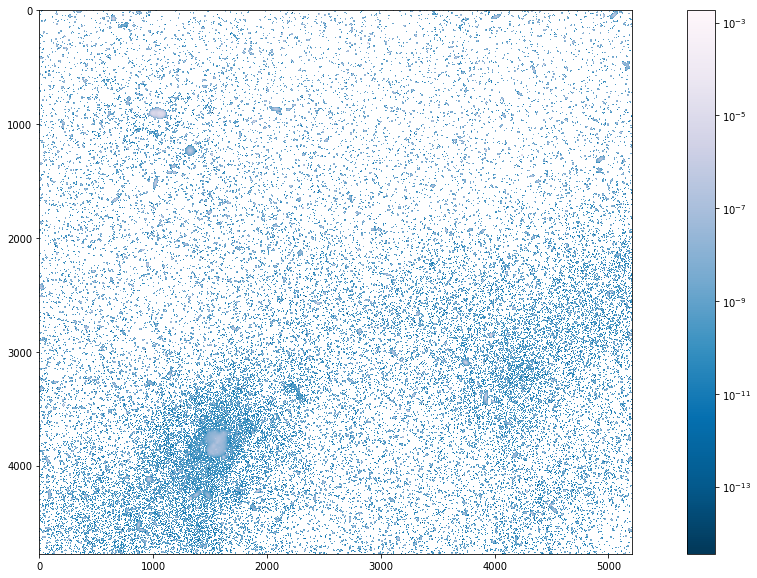

In [8]:
from matplotlib.colors import LogNorm
# https://github.com/HorizonIITM/PythonForAstronomy/blob/master/FITS%20Handling/PythonforAstronomy3.ipynb
plt.figure(figsize=(20, 10))
plt.imshow(img1400_1000h, cmap='PuBu_r', norm=LogNorm())
plt.colorbar()

@Q: is there is no why we can turn the above image like the one from the website ? 


---
**Exercise 3:** Display the 2 other image frequencies 
<br>


In [9]:
# -- code here --



---

### Pre-processing
now we will do the following:
1) Preprocess images (correct PB)
2) crop out the training area for building ML model

---

improting some packges

In [10]:
from astropy.io import fits
from astropy import units as u
from MontagePy.main import mGetHdr, mProjectQL

from source.utils.image_utils import (
    crop_to_training_area,
    get_image_centre_coord,
    get_pixel_value_at_skycoord,
    save_subimage,
)

from source.pre.sdc1_image import Sdc1Image
from path import image_path, pb_path

---

first let us define a new image from the Sdc1Image in sdc1_image.py, and also the frequencies

In [11]:
freq = 1400
new_image = Sdc1Image(freq, image_path(freq), pb_path(freq))

first let us define the method

In [12]:
def _create_pb_corr(image):
    """
    Apply PB correction to the image at image.path, using the primary beam
    file at image.pb_path.

    This uses Montage to regrid the primary beam image to the same pixel scale
    as the image to be corrected.
    """
    image._pb_corr_image = None

    # Establish input image to PB image pixel size ratios:
    with fits.open(image.pb_path) as pb_hdu:
        pb_x_pixel_deg = pb_hdu[0].header["CDELT2"]
    with fits.open(image.path) as image_hdu:
        x_size = image_hdu[0].header["NAXIS1"]
        x_pixel_deg = image_hdu[0].header["CDELT2"]

    ratio_image_pb_pix = (x_size * x_pixel_deg) / pb_x_pixel_deg
    coord_image_centre = get_image_centre_coord(image.path)

    if ratio_image_pb_pix < 2.0:
        # Image not large enough to regrid (< 2 pixels in PB image);
        # apply simple correction
        pb_value = get_pixel_value_at_skycoord(image.pb_path, coord_image_centre)
        image._apply_pb_corr(pb_value)
        return

    with fits.open(image.pb_path) as pb_hdu:
        # Create cropped PB image larger than the input image
        # TODO: May be inefficient when images get large
        size = (
            x_size * x_pixel_deg * u.degree * 2,
            x_size * x_pixel_deg * u.degree * 2,
        )

        save_subimage(
            image.pb_path,
            image._get_pb_cut_path(),
            coord_image_centre,
            size,
            overwrite=True,
        )

    # Regrid image PB cutout to same pixel scale as input image
    mGetHdr(image.path, image._get_hdr_path())

    # TODO: mProjectQL better than mProject, which outputs too-small images?
    rtn = mProjectQL(
        input_file=image._get_pb_cut_path(),
        output_file=image._get_pb_cut_rg_path(),
        template_file=image._get_hdr_path(),
    )
    if rtn["status"] == "1":
        raise ImageNotPreprocessed(
            "Unable to reproject image: {}".format(rtn["msg"])
        )

    # Correct Montage output (convert to 32-bit and fill NaNs)
    pb_array = image._postprocess_montage_out()

    # Apply PB correction and delete temporary files
    image._apply_pb_corr(pb_array)
    image._cleanup_pb()



# @@@ should we reduce this method abit ?

In [13]:
# cropping out the training area for building ML model
def _create_train(image, pad_factor=1.0):
    """
    Create the training image (crop to the frequency-dependent training area)
    """
    image._train = None
    train_path = image.path[:-5] + "_train.fits" # creating a new path for the training image 
    crop_to_training_area(image._pb_corr_image, train_path, image.freq, pad_factor)
    image._train = train_path
        
        

In [14]:
def preprocess(image):
    """
    Perform preprocessing steps:
        1) Create PB-corrected image (image.pb_corr_image)
        2) Output separate training image (image.train)
    """
    image._prep = False
    _create_pb_corr(image)
    _create_train(image)
    image._prep = True

@@@ I wander why do we need to to cut an area for the training, instead what we can do.

In [15]:
image_path(freq)

'data/sample_images/1400mhz_1000h.fits'

In [16]:
pb_path(freq)

'data/sample_images/1400mhz_pb.fits'

In [17]:
new_image = Sdc1Image(freq, image_path(freq), pb_path(freq))
preprocess(new_image) 

 [astropy.io.fits.verify]


### now let is visualise the ouput images:
- corrected image
- trained area image

first let us see the path for both images

In [18]:
print("primary corrected image:\n   "+new_image.pb_corr_image)
print()
print("trainig image:\n   "+new_image.train)

primary corrected image:
   data/sample_images/1400mhz_1000h_pbcor.fits

trainig image:
   data/sample_images/1400mhz_1000h_train.fits


In [19]:
arr_path = [new_image.pb_corr_image, new_image.train]

Filename: data/sample_images/1400mhz_1000h_pbcor.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     113   (5204, 4776, 1, 1)   float32   
None
4
(4776, 5204)


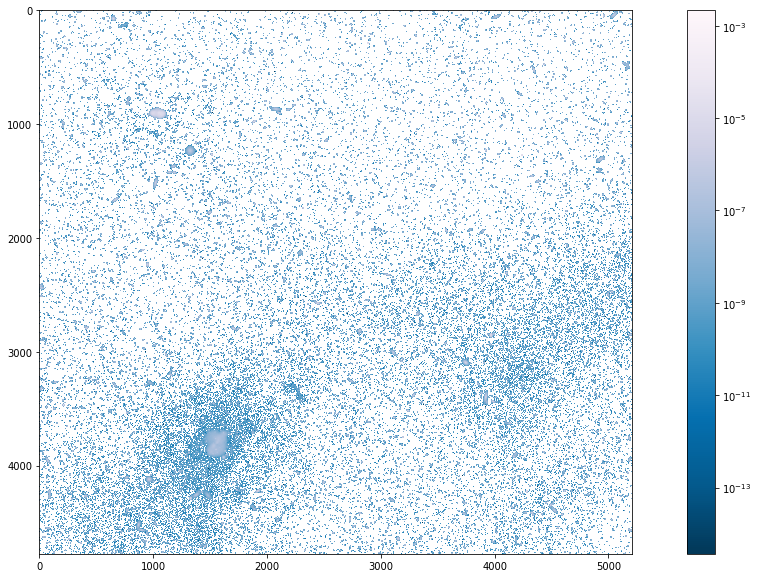

Filename: data/sample_images/1400mhz_1000h_train.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     113   (3469, 3184, 1, 1)   float32   
None
4
(3184, 3469)


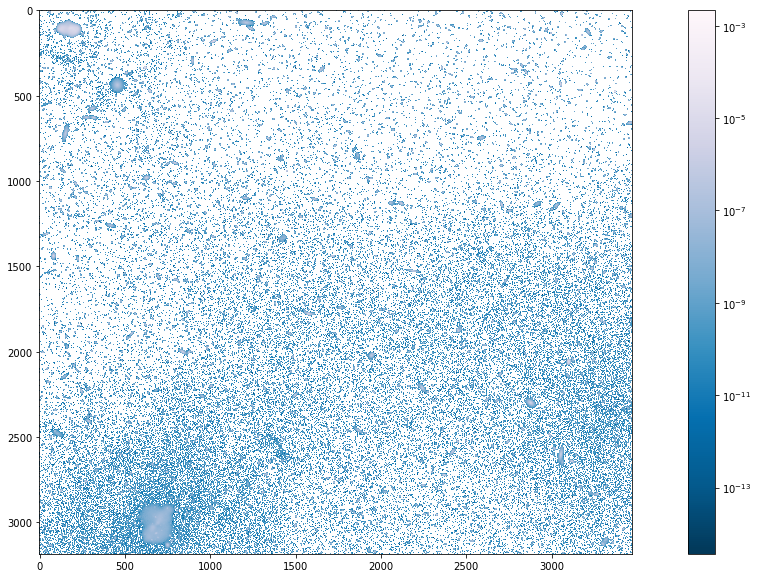

In [20]:

for newImg in arr_path:
    plt.figure(figsize=(20, 10))
    print(fits.info(newImg))
    img = fits.getdata(newImg, ext=0)
    print(len(img.shape))
    if len(img.shape) == 4:
        img = img.reshape(img.shape[2:])
        print(img.shape)
    plt.imshow(img, cmap='PuBu_r', norm=LogNorm())
    plt.colorbar()
    plt.show()



@@@ visually I dont think I can spot the diffrince between the original, and the corrected PB image. what can we do to see that. a sugesstion would be to test both on a ml model, and then check the difference 

---

### Source finding

In [21]:
from source.utils.source_finder import SourceFinder
from path import write_df_to_disk, train_source_df_path

In [22]:

def _get_beam_from_hdu(sFinder):
    """
    Look up the beam information in the header of the SourceFinder's image
    """
    try:
        with fits.open(sFinder.image_name) as hdu:
            beam_maj = hdu[0].header["BMAJ"]
            beam_min = hdu[0].header["BMIN"]
            beam_pa = 0
            return (beam_maj, beam_min, beam_pa)
    except IndexError:
        raise SourceFinderException("Unable to automatically determine beam info")

In [23]:
def _get_rms_box_from_hdu(sFinder):
    """
    Determine an appropriate RMS box size using the header of the SourceFinder's
    image
    """
    try:
        with fits.open(sFinder.image_name) as hdu:
            beam_maj = hdu[0].header["BMAJ"]
            pix_per_beam = beam_maj / hdu[0].header["CDELT2"]
            return (30 * pix_per_beam, 8 * pix_per_beam)
    except IndexError:
        raise SourceFinderException(
            "Unable to automatically determine RMS box size"
        )

---

In [24]:
def run(sFinder, **kwargs):
    import def_run 
    """
    Run the source finder algorithm.

    Args are the same as for the bdsf.process_image method, with sensible defaults
    submitted for any not given.

    The 'beam' and 'rms_box' arg defaults are determined from the image header if
    not provided.
    """

    sFinder._run_complete = False

    # Must switch the executor's working directory to the image directory to
    # run PyBDSF, and switch back after the run is complete.
    cwd = os.getcwd()
    print()
    
    os.chdir(sFinder.image_dirname)

    # Get beam info automatically if not provided
    if not def_run.beam:
        def_run.beam = _get_beam_from_hdu(sFinder)
    if not def_run.rms_box:
        def_run.rms_box = _get_rms_box_from_hdu(sFinder)

    # Run PyBDSF
    try:
        bdsf.process_image(
            sFinder.image_name,
            adaptive_rms_box=def_run.adaptive_rms_box,
            advanced_opts=def_run.advanced_opts,
            atrous_do=def_run.atrous_do,
            psf_vary_do=def_run.psf_vary_do,
            psf_snrcut=def_run.psf_snrcut,
            psf_snrcutstack=def_run.psf_snrcutstack,
            output_opts=def_run.output_opts,
            output_all=def_run.output_all,
            opdir_overwrite=def_run.opdir_overwrite,
            beam=def_run.beam,
            blank_limit=def_run.blank_limit,
            thresh=def_run.thresh,
            thresh_isl=def_run.thresh_isl,
            thresh_pix=def_run.thresh_pix,
            psf_snrtop=def_run.psf_snrtop,
            rms_map=def_run.rms_map,
            rms_box=def_run.rms_box,
            do_cache=def_run.do_cache,
            **kwargs
        )
    except Exception as e:
        # Catch all exceptions to ensure CWD reverted
        os.chdir(cwd)
        raise e

    # Revert current working directory
    os.chdir(cwd)
    sFinder.clean_tmp()
    sFinder._run_complete = True

    return sFinder.get_source_df()



---

now let us do source finding on the training 

In [42]:
sources_training = {}
source_finder = SourceFinder(new_image.train)
print(source_finder.image_dirname)
sl_df = run(source_finder)

sources_training[new_image.freq] = sl_df

# (Optional) Write source list DataFrame to disk
write_df_to_disk(sl_df, train_source_df_path(new_image.freq))

# Remove temp files:
source_finder.reset()

--> Opened '1400mhz_1000h_train.fits'
Image size .............................. : (3469, 3184) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1


data/sample_images



Beam shape (major, minor, pos angle) .... : (1.66667e-04, 1.66667e-04, 0.0) degrees
Frequency of image ...................... : 1400.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.034 Jy
--> Calculating background rms and mean images
/idia/projects/hack4dev/dc1/vDC1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
Using user-specified rms_box ............ : (74, 19) pixels
--> Using 2D map for background rms
--> Variation in mean image significant
--> Using 2D map for background mean
Min/max values of background rms map .... : (6.40e-08, 1.38e-05) Jy/beam
Min/max values of background mean map ... : (-5

Fitting islands with Gaussians .......... : [|] 0/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [/] 1/6636

stty: 'standard input'

-

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1/6636\Fitting islands with Gaussians .......... : [-] 2/6636

stty: 'standard input': Inappropriate ioctl for device


\||Fitting islands with Gaussians .......... : [\] 3/6636|Fitting islands with Gaussians .......... : [\] 3/6636/-Fitting islands with Gaussians .......... : [|] 4/6636Fitting islands with Gaussians .......... : [|] 4/6636\Fitting islands with Gaussians .......... : [|] 4/6636/\Fitting islands with Gaussians .......... : [/] 5/6636-Fitting islands with Gaussians .......... : [\] 6/6636-Fitting islands with Gaussians .......... : [-] 6/6636\|Fitting islands with Gaussians .......... : [\] 7/6636Fitting islands with Gaussians .......... : [/] 9/6636Fitting islands with Gaussians .......... : [-] 10/6636/Fitting islands with Gaussians .......... : [-] 10/6636-Fitting islands with Gaussians .......... : [\] 11/6636\\|Fitting islands with Gaussians .......... : [|] 12/6636Fitting islands with Gaussians .......... : [/] 13/6636-Fitting islands with Gaussians .......... : [-] 14/6636Fitting islands with Gaussians .......... : [|] 17/6636\Fitting islands with Gaussians .......... : [\] 16/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 19/6636/-Fitting islands with Gaussians .......... : [\] 20/6636Fitting islands with Gaussians .......... : [|] 21/6636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [-] 23/6636Fitting islands with Gaussians .......... : [/] 22/6636Fitting islands with Gaussians .......... : [/] 26/6636\Fitting islands with Gaussians .......... : [/] 24/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||/Fitting islands with Gaussians .......... : [/] 26/6636

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [|] 29/6636Fitting islands with Gaussians .......... : [|] 29/6636-Fitting islands with Gaussians .......... : [\] 28/6636Fitting islands with Gaussians .......... : [/] 30/6636//-/Fitting islands with Gaussians .......... : [/] 34/6636Fitting islands with Gaussians .......... : [-] 31/6636Fitting islands with Gaussians .......... : [/] 34/6636Fitting islands with Gaussians .......... : [-] 35/6636Fitting islands with Gaussians .......... : [/] 34/6636/\/-\Fitting islands with Gaussians .......... : [/] 38/6636\Fitting islands with Gaussians .......... : [\] 36/6636Fitting islands with Gaussians .......... : [-] 39/6636\|-Fitting islands with Gaussians .......... : [/] 38/6636-\Fitting islands with Gaussians .......... : [\] 40/6636Fitting islands with Gaussians .......... : [|] 41/6636Fitting islands with Gaussians .......... : [-] 43/6636Fitting islands with Gaussians .......... : [\] 40/6636\Fitting islands with Gaussians .......... : [-] 

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [\] 48/6636Fitting islands with Gaussians .......... : [-] 51/6636Fitting islands with Gaussians .......... : [\] 48/6636\

stty: 'standard input'

Fitting islands with Gaussians .......... : [|] 50/6636/|Fitting islands with Gaussians .......... : [-] 51/6636-\

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 52/6636Fitting islands with Gaussians .......... : [/] 54/6636Fitting islands with Gaussians .......... : [|] 53/6636/--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 55/6636Fitting islands with Gaussians .......... : [\] 56/6636|Fitting islands with Gaussians .......... : [/] 58/6636|Fitting islands with Gaussians .......... : [-] 59/6636/Fitting islands with Gaussians .......... : [-] 58/6636-Fitting islands with Gaussians .......... : [|] 61/6636\Fitting islands with Gaussians .......... : [|] 61/6636||Fitting islands with Gaussians .......... : [/] 62/6636|/Fitting islands with Gaussians .......... : [\] 64/6636Fitting islands with Gaussians .......... : [-] 63/6636\|\Fitting islands with Gaussians .......... : [|] 65/6636Fitting islands with Gaussians .......... : [|] 65/6636Fitting islands with Gaussians .......... : [|] 65/6636Fitting islands with Gaussians .......... : [/] 66/6636Fitting islands with Gaussians .......... : [\] 68/6636//|Fitting islands with Gaussians .......... : [\] 68/6636||/Fitting islands with Gaussians .......... : [|] 69/6636-Fitting islands with Gaussians .......... : [/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 75/6636\Fitting islands with Gaussians .......... : [|] 77/6636|/Fitting islands with Gaussians .......... : [\] 76/6636Fitting islands with Gaussians .......... : [|] 77/6636Fitting islands with Gaussians .......... : [\] 80/6636Fitting islands with Gaussians .......... : [-] 79/6636Fitting islands with Gaussians .......... : [/] 78/6636|||/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [/] 82/6636-Fitting islands with Gaussians .......... : [|] 82/6636\Fitting islands with Gaussians .......... : [|] 85/6636Fitting islands with Gaussians .......... : [|] 85/6636

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|--Fitting islands with Gaussians .......... : [|] 85/6636Fitting islands with Gaussians .......... : [-] 87/6636Fitting islands with Gaussians .......... : [/] 86/6636Fitting islands with Gaussians .......... : [\] 88/6636//-Fitting islands with Gaussians .......... : [|] 89/6636Fitting islands with Gaussians .......... : [-] 91/6636-Fitting islands with Gaussians .......... : [-] 91/6636\Fitting islands with Gaussians .......... : [/] 94/6636|Fitting islands with Gaussians .......... : [/] 94/6636Fitting islands with Gaussians .......... : [-] 95/6636/Fitting islands with Gaussians .......... : [-] 95/6636-\|Fitting islands with Gaussians .......... : [\] 96/6636Fitting islands with Gaussians .......... : [-] 99/6636Fitting islands with Gaussians .......... : [/] 98/6636Fitting islands with Gaussians .......... : [|] 97/6636|-\\|Fitting islands with Gaussians .......... : [-] 103/6636/Fitting islands with Gaussians .......... : [\] 100/6636Fitting islands with Gaussians .......... : 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 110/6636///Fitting islands with Gaussians .......... : [/] 110/6636-\Fitting islands with Gaussians .......... : [/] 110/6636Fitting islands with Gaussians .......... : [/] 114/6636|Fitting islands with Gaussians .......... : [-] 111/6636/Fitting islands with Gaussians .......... : [/] 114/6636Fitting islands with Gaussians .......... : [/] 114/6636Fitting islands with Gaussians .......... : [-] 115/6636Fitting islands with Gaussians .......... : [\] 116/6636|||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

-Fitting islands with Gaussians .......... : [|] 117/6636-Fitting islands with Gaussians .......... : [/] 118/6636Fitting islands with Gaussians .......... : [|] 121/6636Fitting islands with Gaussians .......... : [|] 122/6636Fitting islands with Gaussians .......... : [|] 121/6636\/-Fitting islands with Gaussians .......... : [-] 123/6636\Fitting islands with Gaussians .......... : [-] 123/6636\|Fitting islands with Gaussians .......... : [-] 127/6636Fitting islands with Gaussians .......... : [/] 126/6636/

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [\] 124/6636--Fitting islands with Gaussians .......... : [\] 128/6636Fitting islands with Gaussians .......... : [\] 128/6636Fitting islands with Gaussians .......... : [|] 129/6636||Fitting islands with Gaussians .......... : [-] 132/6636Fitting islands with Gaussians .......... : [/] 130/6636/\\\Fitting islands with Gaussians .......... : [-] 132/6636Fitting islands with Gaussians .......... : [|] 134/6636Fitting islands with Gaussians .......... : [|] 134/6636/Fitting islands with Gaussians .......... : [/] 135/6636/-Fitting islands with Gaussians .......... : [\] 137/6636Fitting islands with Gaussians .......... : [\] 137/6636|Fitting islands with Gaussians .......... : [\] 137/6636|--Fitting islands with Gaussians .......... : [-] 140/6636Fitting islands with Gaussians .......... : [|] 142/6636Fitting islands with Gaussians .......... : [/] 139/6636Fitting islands with Gaussians .......... : [|] 142/6636Fitting islands with Gaussians ..

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [|] 150/6636Fitting islands with Gaussians .......... : [-] 152/6636|Fitting islands with Gaussians .......... : [|] 154/6636/Fitting islands with Gaussians .......... : [|] 154/6636/Fitting islands with Gaussians .......... : [/] 155/6636-\Fitting islands with Gaussians .......... : [/] 159/6636|Fitting islands with Gaussians .......... : [|] 158/6636Fitting islands with Gaussians .......... : [/] 159/6636/-\Fitting islands with Gaussians .......... : [\] 161/6636Fitting islands with Gaussians .......... : [-] 160/6636\//Fitting islands with Gaussians .......... : [|] 162/6636Fitting islands with Gaussians .......... : [-] 164/6636-Fitting islands with Gaussians .......... : [/] 163/6636Fitting islands with Gaussians .......... : [\] 165/6636Fitting islands with Gaussians .......... : [/] 167/6636\Fitting islands with Gaussians .......... : [\] 165/6636/--Fitting islands with Gaussians .......... : [-] 168/6636

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [\] 169/6636Fitting islands with Gaussians .......... : [/] 167/6636\///Fitting islands with Gaussians .......... : [/] 171/6636Fitting islands with Gaussians .......... : [/] 176/6636Fitting islands with Gaussians .......... : [-] 172/6636Fitting islands with Gaussians .......... : [-] 172/6636Fitting islands with Gaussians .......... : [\] 173/6636////-Fitting islands with Gaussians .......... : [/] 176/6636Fitting islands with Gaussians .......... : [/] 176/6636Fitting islands with Gaussians .......... : [/] 180/6636Fitting islands with Gaussians .......... : [/] 180/6636||Fitting islands with Gaussians .......... : [/] 180/6636/Fitting islands with Gaussians .......... : [/] 180/6636Fitting islands with Gaussians .......... : [-] 181/6636\-/Fitting islands with Gaussians .......... : [|] 183/6636/Fitting islands with Gaussians .......... : [|] 183/6636Fitting islands with Gaussians .......... : [/] 185/6636Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 193/6636\\Fitting islands with Gaussians .......... : [/] 193/6636Fitting islands with Gaussians .......... : [\] 195/6636Fitting islands with Gaussians .......... : [\] 195/6636Fitting islands with Gaussians .......... : [/] 197/6636Fitting islands with Gaussians .......... : [|] 196/6636\/\\\Fitting islands with Gaussians .......... : [\] 199/6636Fitting islands with Gaussians .......... : [\] 199/6636Fitting islands with Gaussians .......... : [\] 204/6636/Fitting islands with Gaussians .......... : [\] 204/6636/Fitting islands with Gaussians .......... : [/] 201/6636-Fitting islands with Gaussians .......... : [\] 204/6636Fitting islands with Gaussians .......... : [\] 204/6636||/-Fitting islands with Gaussians .......... : [/] 206/6636Fitting islands with Gaussians .......... : [/] 206/6636\Fitting islands with Gaussians .......... : [-] 207/6636|Fitting islands with Gaussians .......... : [|] 209/6636

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [|] 209/6636Fitting islands with Gaussians .......... : [/] 210/6636/\\|Fitting islands with Gaussians .......... : [-] 211/6636Fitting islands with Gaussians .......... : [\] 212/6636Fitting islands with Gaussians .......... : [|] 213/6636Fitting islands with Gaussians .......... : [/] 214/6636-Fitting islands with Gaussians .......... : [\] 216/6636\Fitting islands with Gaussians .......... : [\] 216/6636\\|Fitting islands with Gaussians .......... : [|] 217/6636/Fitting islands with Gaussians .......... : [\] 221/6636Fitting islands with Gaussians .......... : [-] 219/6636-Fitting islands with Gaussians .......... : [\] 221/6636Fitting islands with Gaussians .......... : [|] 222/6636|/-Fitting islands with Gaussians .......... : [\] 221/6636/\Fitting islands with Gaussians .......... : [-] 224/6636Fitting islands with Gaussians .......... : [/] 223/6636Fitting islands with Gaussians .......... : [/] 226/6636Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 236/6636Fitting islands with Gaussians .......... : [\] 233/6636|Fitting islands with Gaussians .......... : [/] 239/6636Fitting islands with Gaussians .......... : [\] 241/6636/Fitting islands with Gaussians .......... : [\] 241/6636/Fitting islands with Gaussians .......... : [-] 240/6636Fitting islands with Gaussians .......... : [|] 242/6636-\|Fitting islands with Gaussians .......... : [|] 238/6636Fitting islands with Gaussians .......... : [/] 243/6636/

stty: 'standard input'

Fitting islands with Gaussians .......... : [/] 243/6636-Fitting islands with Gaussians .......... : [\] 246/6636||Fitting islands with Gaussians .......... : [|] 247/6636/Fitting islands with Gaussians .......... : [-] 246/6636Fitting islands with Gaussians .......... : [/] 248/6636Fitting islands with Gaussians .......... : [-] 249/6636Fitting islands with Gaussians .......... : [|] 251/6636|||Fitting islands with Gaussians .......... : [|] 251/6636/-Fitting islands with Gaussians .......... : [/] 252/6636Fitting islands with Gaussians .......... : [|] 255/6636Fitting islands with Gaussians .......... : [|] 255/6636\Fitting islands with Gaussians .......... : [/] 256/6636//Fitting islands with Gaussians .......... : [\] 258/6636/Fitting islands with Gaussians .......... : [|] 255/6636-Fitting islands with Gaussians .......... : [/] 261/6636Fitting islands with Gaussians .......... : [-] 257/6636|Fitting islands with Gaussians .......... : [/] 261/6636//-Fitting islands with Gaussians

: Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [/] 265/6636Fitting islands with Gaussians .......... : [|] 268/6636Fitting islands with Gaussians .......... : [|] 268/6636Fitting islands with Gaussians .......... : [/] 269/6636---Fitting islands with Gaussians .......... : [\] 271/6636Fitting islands with Gaussians .......... : [-] 270/6636||Fitting islands with Gaussians .......... : [-] 274/6636Fitting islands with Gaussians .......... : [-] 274/6636Fitting islands with Gaussians .......... : [-] 274/6636---\Fitting islands with Gaussians .......... : [|] 276/6636Fitting islands with Gaussians .......... : [|] 276/6636|Fitting islands with Gaussians .......... : [-] 278/6636Fitting islands with Gaussians .......... : [-] 278/6636Fitting islands with Gaussians .......... : [-] 278/6636/Fitting islands with Gaussians .......... : [\] 279/6636\

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inapprop

\//Fitting islands with Gaussians .......... : [|] 280/6636-Fitting islands with Gaussians .......... : [/] 281/6636Fitting islands with Gaussians .......... : [\] 283/6636Fitting islands with Gaussians .......... : [\] 283/6636||Fitting islands with Gaussians .......... : [/] 285/6636/Fitting islands with Gaussians .......... : [/] 285/6636-Fitting islands with Gaussians .......... : [|] 288/6636Fitting islands with Gaussians .......... : [-] 286/6636Fitting islands with Gaussians .......... : [|] 288/6636||/--Fitting islands with Gaussians .......... : [-] 290/6636Fitting islands with Gaussians .......... : [/] 289/6636Fitting islands with Gaussians .......... : [|] 292/6636|/Fitting islands with Gaussians .......... : [|] 292/6636Fitting islands with Gaussians .......... : [/] 293/6636Fitting islands with Gaussians .......... : [-] 294/6636/Fitting islands with Gaussians .......... : [-] 294/6636\\//Fitting islands with Gaussians .......... : [|] 296/6636-Fitting islands with Gaussi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 305/6636Fitting islands with Gaussians .......... : [/] 305/6636Fitting islands with Gaussians .......... : [|] 308/6636Fitting islands with Gaussians .......... : [-] 306/6636\\Fitting islands with Gaussians .......... : [|] 308/6636|Fitting islands with Gaussians .......... : [-] 310/6636/-Fitting islands with Gaussians .......... : [\] 311/6636Fitting islands with Gaussians .......... : [\] 311/6636\/Fitting islands with Gaussians .......... : [|] 312/6636/Fitting islands with Gaussians .......... : [/] 313/6636-Fitting islands with Gaussians .......... : [-] 314/6636\|Fitting islands with Gaussians .......... : [/] 317/6636Fitting islands with Gaussians .......... : [\] 315/6636Fitting islands with Gaussians .......... : [/] 317/6636Fitting islands with Gaussians .......... : [-] 318/6636Fitting islands with Gaussians .......... : [|] 320/6636\\\Fitting islands with Gaussians .......... : [\] 319/6636//Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 345/6636|Fitting islands with Gaussians .......... : [/] 345/6636Fitting islands with Gaussians .......... : [-] 346/6636/Fitting islands with Gaussians .......... : [\] 347/6636Fitting islands with Gaussians .......... : [-] 346/6636/\\Fitting islands with Gaussians .......... : [|] 348/6636Fitting islands with Gaussians .......... : [/] 349/6636|Fitting islands with Gaussians .......... : [/] 349/6636Fitting islands with Gaussians .......... : [\] 351/6636/-Fitting islands with Gaussians .......... : [\] 351/6636\\|Fitting islands with Gaussians .......... : [/] 353/6636Fitting islands with Gaussians .......... : [-] 354/6636-Fitting islands with Gaussians .......... : [|] 353/6636Fitting islands with Gaussians .......... : [\] 355/6636-Fitting islands with Gaussians .......... : [|] 356/6636\/Fitting islands with Gaussians .......... : [\] 355/6636Fitting islands with Gaussians .......... : [-] 358/6636Fitting islands with Gaussians ..

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [\] 371/6636Fitting islands with Gaussians .......... : [-] 370/6636|||Fitting islands with Gaussians .......... : [/] 373/6636Fitting islands with Gaussians .......... : [|] 372/6636Fitting islands with Gaussians .......... : [-] 374/6636/-\Fitting islands with Gaussians .......... : [|] 376/6636Fitting islands with Gaussians .......... : [|] 376/6636|Fitting islands with Gaussians .......... : [|] 376/6636|Fitting islands with Gaussians .......... : [/] 377/6636/-Fitting islands with Gaussians .......... : [-] 378/6636Fitting islands with Gaussians .......... : [\] 379/6636Fitting islands with Gaussians .......... : [|] 380/6636Fitting islands with Gaussians .......... : [|] 380/6636\|-Fitting islands with Gaussians .......... : [/] 381/6636-Fitting islands with Gaussians .......... : [\] 383/6636\Fitting islands with Gaussians .......... : [-] 382/6636Fitting islands with Gaussians .......... : [-] 386/6636Fitting islands with Gaussians ..

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 400/6636Fitting islands with Gaussians .......... : [|] 400/6636|Fitting islands with Gaussians .......... : [|] 400/6636//-Fitting islands with Gaussians .......... : [-] 402/6636Fitting islands with Gaussians .......... : [|] 404/6636\Fitting islands with Gaussians .......... : [/] 405/6636Fitting islands with Gaussians .......... : [|] 404/6636Fitting islands with Gaussians .......... : [/] 405/6636/-Fitting islands with Gaussians .......... : [-] 406/6636\\Fitting islands with Gaussians .......... : [\] 407/6636//Fitting islands with Gaussians .......... : [/] 409/6636Fitting islands with Gaussians .......... : [\] 411/6636Fitting islands with Gaussians .......... : [\] 411/6636Fitting islands with Gaussians .......... : [-] 410/6636\\|Fitting islands with Gaussians .......... : [/] 413/6636/Fitting islands with Gaussians .......... : [/] 413/6636/Fitting islands with Gaussians .......... : [\] 415/6636\\Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 436/6636/Fitting islands with Gaussians .......... : [/] 437/6636-Fitting islands with Gaussians .......... : [-] 438/6636\Fitting islands with Gaussians .......... : [|] 440/6636Fitting islands with Gaussians .......... : [|] 440/6636|/-Fitting islands with Gaussians .......... : [-] 442/6636Fitting islands with Gaussians .......... : [/] 441/6636|Fitting islands with Gaussians .......... : [\] 443/6636/Fitting islands with Gaussians .......... : [|] 444/6636/Fitting islands with Gaussians .......... : [/] 446/6636--Fitting islands with Gaussians .......... : [-] 446/6636Fitting islands with Gaussians .......... : [|] 448/6636\Fitting islands with Gaussians .......... : [/] 449/6636Fitting islands with Gaussians .......... : [/] 449/6636|/-Fitting islands with Gaussians .......... : [-] 450/6636Fitting islands with Gaussians .......... : [-] 450/6636\|Fitting islands with Gaussians .......... : [\] 451/6636Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 468/6636/Fitting islands with Gaussians .......... : [|] 468/6636Fitting islands with Gaussians .......... : [|] 469/6636Fitting islands with Gaussians .......... : [\] 471/6636Fitting islands with Gaussians .......... : [\] 471/6636Fitting islands with Gaussians .......... : [\] 471/6636\|Fitting islands with Gaussians .......... : [|] 472/6636//Fitting islands with Gaussians .......... : [/] 473/6636\\Fitting islands with Gaussians .......... : [\] 475/6636Fitting islands with Gaussians .......... : [/] 477/6636|Fitting islands with Gaussians .......... : [|] 476/6636Fitting islands with Gaussians .......... : [/] 477/6636--Fitting islands with Gaussians .......... : [\] 479/6636Fitting islands with Gaussians .......... : [\] 479/6636Fitting islands with Gaussians .......... : [|] 480/6636\||Fitting islands with Gaussians .......... : [-] 482/6636-|-Fitting islands with Gaussians .......... : [-] 482/6636Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 512/6636/Fitting islands with Gaussians .......... : [\] 510/6636\Fitting islands with Gaussians .......... : [\] 514/6636\Fitting islands with Gaussians .......... : [/] 512/6636|Fitting islands with Gaussians .......... : [\] 514/6636/Fitting islands with Gaussians .......... : [\] 518/6636Fitting islands with Gaussians .......... : [/] 516/6636Fitting islands with Gaussians .......... : [|] 515/6636Fitting islands with Gaussians .......... : [\] 518/6636-Fitting islands with Gaussians .......... : [|] 519/6636/|\\\Fitting islands with Gaussians .......... : [-] 521/6636Fitting islands with Gaussians .......... : [/] 524/6636Fitting islands with Gaussians .......... : [/] 520/6636|Fitting islands with Gaussians .......... : [\] 526/6636Fitting islands with Gaussians .......... : [|] 523/6636--Fitting islands with Gaussians .......... : [\] 526/6636||Fitting islands with Gaussians .......... : [\] 526/6636/Fitting islands with Gaussians 

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

-\\Fitting islands with Gaussians .......... : [/] 547/6636|Fitting islands with Gaussians .......... : [-] 548/6636/Fitting islands with Gaussians .......... : [\] 549/6636Fitting islands with Gaussians .......... : [\] 553/6636Fitting islands with Gaussians .......... : [/] 551/6636Fitting islands with Gaussians .......... : [\] 553/6636|/Fitting islands with Gaussians .......... : [/] 555/6636/Fitting islands with Gaussians .......... : [-] 552/6636Fitting islands with Gaussians .......... : [|] 554/6636||||Fitting islands with Gaussians .......... : [|] 559/6636Fitting islands with Gaussians .......... : [/] 559/6636/-Fitting islands with Gaussians .......... : [|] 562/6636Fitting islands with Gaussians .......... : [|] 562/6636Fitting islands with Gaussians .......... : [/] 559/6636|Fitting islands with Gaussians .......... : [|] 562/6636/-Fitting islands with Gaussians .......... : [/] 563/6636-Fitting islands with Gaussians .......... : [-] 564/6636Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

: Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 590/6636\/\Fitting islands with Gaussians .......... : [|] 593/6636Fitting islands with Gaussians .......... : [\] 592/6636Fitting islands with Gaussians .......... : [\] 592/6636|--Fitting islands with Gaussians .......... : [\] 596/6636Fitting islands with Gaussians .......... : [/] 594/6636||Fitting islands with Gaussians .......... : [\] 596/6636|Fitting islands with Gaussians .......... : [-] 599/6636Fitting islands with Gaussians .......... : [|] 597/6636Fitting islands with Gaussians .......... : [-] 599/6636--Fitting islands with Gaussians .......... : [|] 601/6636Fitting islands with Gaussians .......... : [|] 601/6636|/--Fitting islands with Gaussians .......... : [|] 601/6636Fitting islands with Gaussians .......... : [-] 603/6636Fitting islands with Gaussians .......... : [-] 603/6636Fitting islands with Gaussians .......... : [|] 605/6636\//-Fitting islands with Gaussians .......... : [/] 606/6636Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 629/6636\||Fitting islands with Gaussians .......... : [|] 634/6636Fitting islands with Gaussians .......... : [-] 635/6636Fitting islands with Gaussians .......... : [-] 635/6636Fitting islands with Gaussians .......... : [\] 636/6636Fitting islands with Gaussians .......... : [|] 634/6636||||/Fitting islands with Gaussians .......... : [|] 638/6636-Fitting islands with Gaussians .......... : [|] 638/6636Fitting islands with Gaussians .......... : [|] 642/6636|Fitting islands with Gaussians .......... : [|] 642/6636|Fitting islands with Gaussians .......... : [|] 642/6636/Fitting islands with Gaussians .......... : [|] 642/6636Fitting islands with Gaussians .......... : [/] 643/6636Fitting islands with Gaussians .......... : [-] 644/6636\\//Fitting islands with Gaussians .......... : [|] 646/6636Fitting islands with Gaussians .......... : [|] 646/6636Fitting islands with Gaussians .......... : [/] 647/6636Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 674/6636\/-\\Fitting islands with Gaussians .......... : [/] 675/6636Fitting islands with Gaussians .......... : [-] 676/6636|Fitting islands with Gaussians .......... : [\] 677/6636/Fitting islands with Gaussians .......... : [/] 678/6636Fitting islands with Gaussians .......... : [-] 679/6636-|Fitting islands with Gaussians .......... : [\] 680/6636Fitting islands with Gaussians .......... : [\] 680/6636|Fitting islands with Gaussians .......... : [|] 681/6636--\Fitting islands with Gaussians .......... : [/] 682/6636Fitting islands with Gaussians .......... : [-] 683/6636|Fitting islands with Gaussians .......... : [|] 685/6636Fitting islands with Gaussians .......... : [-] 687/6636Fitting islands with Gaussians .......... : [|] 685/6636-\||Fitting islands with Gaussians .......... : [-] 687/6636/Fitting islands with Gaussians .......... : [|] 689/6636Fitting islands with Gaussians .......... : [\] 688/6636\\Fitting islands with Gaussi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 710/6636/-Fitting islands with Gaussians .......... : [\] 714/6636Fitting islands with Gaussians .......... : [\] 714/6636Fitting islands with Gaussians .......... : [\] 714/6636Fitting islands with Gaussians .......... : [\] 714/6636\//-Fitting islands with Gaussians .......... : [-] 717/6636Fitting islands with Gaussians .......... : [|] 715/6636Fitting islands with Gaussians .......... : [/] 716/6636Fitting islands with Gaussians .......... : [\] 718/6636|Fitting islands with Gaussians .......... : [/] 720/6636//Fitting islands with Gaussians .......... : [/] 720/6636-Fitting islands with Gaussians .......... : [-] 721/6636||Fitting islands with Gaussians .......... : [/] 724/6636/Fitting islands with Gaussians .......... : [-] 725/6636Fitting islands with Gaussians .......... : [|] 724/6636-Fitting islands with Gaussians .......... : [/] 724/6636\||Fitting islands with Gaussians .......... : [|] 727/6636Fitting islands with Gaussians

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [|] 743/6636Fitting islands with Gaussians .......... : [\] 746/6636Fitting islands with Gaussians .......... : [|] 747/6636|-//--Fitting islands with Gaussians .......... : [/] 748/6636Fitting islands with Gaussians .......... : [/] 752/6636Fitting islands with Gaussians .......... : [-] 749/6636Fitting islands with Gaussians .......... : [|] 751/6636/Fitting islands with Gaussians .......... : [/] 752/6636/-Fitting islands with Gaussians .......... : [-] 753/6636Fitting islands with Gaussians .......... : [-] 753/6636\Fitting islands with Gaussians .......... : [/] 756/6636Fitting islands with Gaussians .......... : [/] 756/6636//|-Fitting islands with Gaussians .......... : [-] 757/6636\Fitting islands with Gaussians .......... : [\] 759/6636||Fitting islands with Gaussians .......... : [/] 761/6636Fitting islands with Gaussians .......... : [\] 763/6636Fitting islands with Gaussians .......... : [-] 762/6636Fitting islands with Gaussians 

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [|] 786/6636Fitting islands with Gaussians .......... : [/] 788/6636////-Fitting islands with Gaussians .......... : [-] 788/6636\Fitting islands with Gaussians .......... : [/] 791/6636Fitting islands with Gaussians .......... : [/] 791/6636|Fitting islands with Gaussians .......... : [/] 791/6636Fitting islands with Gaussians .......... : [/] 791/6636Fitting islands with Gaussians .......... : [-] 792/6636\//\Fitting islands with Gaussians .......... : [\] 793/6636Fitting islands with Gaussians .......... : [|] 794/6636--\Fitting islands with Gaussians .......... : [\] 797/6636Fitting islands with Gaussians .......... : [/] 799/6636Fitting islands with Gaussians .......... : [/] 799/6636Fitting islands with Gaussians .......... : [\] 797/6636--Fitting islands with Gaussians .......... : [-] 800/6636-Fitting islands with Gaussians .......... : [-] 800/6636|Fitting islands with Gaussians .......... : [\] 801/6636|/Fitting islands with Gaussia

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

\|Fitting islands with Gaussians .......... : [|] 836/6636|Fitting islands with Gaussians .......... : [/] 838/6636Fitting islands with Gaussians .......... : [\] 839/6636Fitting islands with Gaussians .......... : [|] 836/6636/\||Fitting islands with Gaussians .......... : [|] 840/6636Fitting islands with Gaussians .......... : [|] 840/6636-Fitting islands with Gaussians .......... : [\] 843/6636-Fitting islands with Gaussians .......... : [|] 844/6636Fitting islands with Gaussians .......... : [|] 844/6636Fitting islands with Gaussians .......... : [/] 841/6636\//Fitting islands with Gaussians .......... : [-] 846/6636-\Fitting islands with Gaussians .......... : [\] 847/6636Fitting islands with Gaussians .......... : [-] 846/6636Fitting islands with Gaussians .......... : [/] 849/6636|-Fitting islands with Gaussians .......... : [/] 849/6636-\Fitting islands with Gaussians .......... : [\] 851/6636Fitting islands with Gaussians .......... : [|] 852/6636|Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 866/6636-Fitting islands with Gaussians .......... : [-] 866/6636Fitting islands with Gaussians .......... : [\] 867/6636Fitting islands with Gaussians .......... : [/] 869/6636\Fitting islands with Gaussians .......... : [/] 869/6636Fitting islands with Gaussians .......... : [/] 869/6636///-\Fitting islands with Gaussians .......... : [-] 870/6636Fitting islands with Gaussians .......... : [\] 871/6636Fitting islands with Gaussians .......... : [/] 874/6636|Fitting islands with Gaussians .......... : [/] 874/6636/Fitting islands with Gaussians .......... : [/] 874/6636-||Fitting islands with Gaussians .......... : [-] 875/6636Fitting islands with Gaussians .......... : [\] 876/6636/Fitting islands with Gaussians .......... : [|] 877/6636-Fitting islands with Gaussians .......... : [-] 879/6636Fitting islands with Gaussians .......... : [|] 881/6636Fitting islands with Gaussians .......... : [|] 881/6636\Fitting islands with Gaussians ..

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [\] 900/6636Fitting islands with Gaussians .......... : [/] 902/6636Fitting islands with Gaussians .......... : [/] 902/6636\\Fitting islands with Gaussians .......... : [\] 904/6636\Fitting islands with Gaussians .......... : [\] 904/6636Fitting islands with Gaussians .......... : [|] 905/6636//Fitting islands with Gaussians .......... : [|] 905/6636-\Fitting islands with Gaussians .......... : [\] 908/6636|Fitting islands with Gaussians .......... : [\] 908/6636Fitting islands with Gaussians .......... : [\] 908/6636Fitting islands with Gaussians .......... : [/] 910/6636Fitting islands with Gaussians .......... : [/] 910/6636-||Fitting islands with Gaussians .......... : [\] 912/6636|Fitting islands with Gaussians .......... : [|] 913/6636Fitting islands with Gaussians .......... : [-] 911/6636--Fitting islands with Gaussians .......... : [|] 917/6636\Fitting islands with Gaussians .......... : [|] 917/6636|Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [/] 950/6636Fitting islands with Gaussians .......... : [/] 950/6636--Fitting islands with Gaussians .......... : [/] 951/6636Fitting islands with Gaussians .......... : [-] 951/6636Fitting islands with Gaussians .......... : [|] 953/6636Fitting islands with Gaussians .......... : [\] 952/6636\/Fitting islands with Gaussians .......... : [\] 952/6636/Fitting islands with Gaussians .......... : [-] 955/6636\\Fitting islands with Gaussians .......... : [-] 955/6636Fitting islands with Gaussians .......... : [\] 956/6636Fitting islands with Gaussians .......... : [/] 958/6636//Fitting islands with Gaussians .......... : [/] 958/6636Fitting islands with Gaussians .......... : [\] 960/6636/|\|Fitting islands with Gaussians .......... : [\] 960/6636Fitting islands with Gaussians .......... : [/] 962/6636/Fitting islands with Gaussians .......... : [|] 965/6636Fitting islands with Gaussians .......... : [/] 962/6636-\|Fitting islands with Gaussian

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [\] 997/6636|-Fitting islands with Gaussians .......... : [-] 1000/6636--Fitting islands with Gaussians .......... : [/] 999/6636\|Fitting islands with Gaussians .......... : [/] 999/6636Fitting islands with Gaussians .......... : [-] 1004/6636Fitting islands with Gaussians .......... : [|] 1002/6636Fitting islands with Gaussians .......... : [-] 1004/6636/Fitting islands with Gaussians .......... : [-] 1004/6636-|/Fitting islands with Gaussians .......... : [\] 1005/6636Fitting islands with Gaussians .......... : [/] 1007/6636-Fitting islands with Gaussians .......... : [|] 1010/6636Fitting islands with Gaussians .......... : [|] 1006/6636Fitting islands with Gaussians .......... : [/] 1010/6636--Fitting islands with Gaussians .......... : [-] 1008/6636-Fitting islands with Gaussians .......... : [-] 1011/6636\\Fitting islands with Gaussians .......... : [-] 1015/6636|Fitting islands with Gaussians .......... : [-] 1015/6636Fitting islands w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1030/6636Fitting islands with Gaussians .......... : [-] 1030/6636-Fitting islands with Gaussians .......... : [\] 1031/6636\Fitting islands with Gaussians .......... : [-] 1030/6636//-Fitting islands with Gaussians .......... : [/] 1033/6636Fitting islands with Gaussians .......... : [-] 1034/6636Fitting islands with Gaussians .......... : [/] 1033/6636||/Fitting islands with Gaussians .......... : [\] 1035/6636Fitting islands with Gaussians .......... : [/] 1037/6636Fitting islands with Gaussians .......... : [/] 1037/6636-Fitting islands with Gaussians .......... : [|] 1040/6636|Fitting islands with Gaussians .......... : [-] 1038/6636|Fitting islands with Gaussians .......... : [/] 1041/6636--/Fitting islands with Gaussians .......... : [|] 1040/6636Fitting islands with Gaussians .......... : [-] 1042/6636Fitting islands with Gaussians .......... : [|] 1044/6636-Fitting islands with Gaussians .......... : [|] 1044/6636||Fitting island

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

/\Fitting islands with Gaussians .......... : [|] 1076/6636\Fitting islands with Gaussians .......... : [\] 1076/6636Fitting islands with Gaussians .......... : [|] 1076/6636|/Fitting islands with Gaussians .......... : [/] 1077/6636Fitting islands with Gaussians .......... : [\] 1079/6636|||Fitting islands with Gaussians .......... : [\] 1079/6636Fitting islands with Gaussians .......... : [|] 1080/6636Fitting islands with Gaussians .......... : [/] 1081/6636--Fitting islands with Gaussians .......... : [|] 1084/6636\Fitting islands with Gaussians .......... : [|] 1084/6636Fitting islands with Gaussians .......... : [|] 1084/6636///Fitting islands with Gaussians .......... : [-] 1086/6636-Fitting islands with Gaussians .......... : [-] 1086/6636Fitting islands with Gaussians .......... : [\] 1087/6636\Fitting islands with Gaussians .......... : [/] 1089/6636Fitting islands with Gaussians .......... : [/] 1089/6636Fitting islands with Gaussians .......... : [/] 1089/6636/-/-Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--\\Fitting islands with Gaussians .......... : [/] 1107/6636|Fitting islands with Gaussians .......... : [-] 1108/6636Fitting islands with Gaussians .......... : [-] 1108/6636Fitting islands with Gaussians .......... : [\] 1109/6636Fitting islands with Gaussians .......... : [\] 1109/6636-\||Fitting islands with Gaussians .......... : [|] 1110/6636/Fitting islands with Gaussians .......... : [\] 1113/6636Fitting islands with Gaussians .......... : [|] 1114/6636Fitting islands with Gaussians .......... : [-] 1112/6636\Fitting islands with Gaussians .......... : [|] 1114/6636\|Fitting islands with Gaussians .......... : [/] 1115/6636//Fitting islands with Gaussians .......... : [\] 1116/6636--\Fitting islands with Gaussians .......... : [\] 1116/6636|Fitting islands with Gaussians .......... : [|] 1117/6636Fitting islands with Gaussians .......... : [/] 1118/6636Fitting islands with Gaussians .......... : [/] 1118/6636//Fitting islands with Gaussians .......... : [-] 1119/6636Fitting is

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/|||Fitting islands with Gaussians .......... : [-] 1131/6636Fitting islands with Gaussians .......... : [\] 1132/6636Fitting islands with Gaussians .......... : [|] 1137/6636Fitting islands with Gaussians .......... : [|] 1137/6636-Fitting islands with Gaussians .......... : [-] 1136/6636-Fitting islands with Gaussians .......... : [|] 1137/6636Fitting islands with Gaussians .......... : [/] 1134/6636|||/Fitting islands with Gaussians .......... : [-] 1139/6636Fitting islands with Gaussians .......... : [-] 1139/6636\\Fitting islands with Gaussians .......... : [|] 1141/6636Fitting islands with Gaussians .......... : [|] 1141/6636|Fitting islands with Gaussians .......... : [|] 1141/6636Fitting islands with Gaussians .......... : [/] 1142/6636/\\|Fitting islands with Gaussians .......... : [\] 1144/6636Fitting islands with Gaussians .......... : [\] 1144/6636Fitting islands with Gaussians .......... : [/] 1146/6636-Fitting islands with Gaussians .......... : [|] 1145/6636-Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 1167/6636Fitting islands with Gaussians .......... : [|] 1164/6636Fitting islands with Gaussians .......... : [-] 1167/6636Fitting islands with Gaussians .......... : [\] 1167/6636Fitting islands with Gaussians .......... : [\] 1167/6636---\|\Fitting islands with Gaussians .......... : [|] 1168/6636/Fitting islands with Gaussians .......... : [-] 1170/6636Fitting islands with Gaussians .......... : [-] 1170/6636\Fitting islands with Gaussians .......... : [\] 1171/6636Fitting islands with Gaussians .......... : [-] 1170/6636\Fitting islands with Gaussians .......... : [|] 1172/6636Fitting islands with Gaussians .......... : [\] 1171/6636---\Fitting islands with Gaussians .......... : [/] 1173/6636Fitting islands with Gaussians .......... : [\] 1175/6636|Fitting islands with Gaussians .......... : [\] 1175/6636/Fitting islands with Gaussians .......... : [-] 1178/6636Fitting islands with Gaussians .......... : [\] 1179/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|\\\Fitting islands with Gaussians .......... : [-] 1198/6636Fitting islands with Gaussians .......... : [\] 1203/6636Fitting islands with Gaussians .......... : [|] 1201/6636Fitting islands with Gaussians .......... : [\] 1199/6636||Fitting islands with Gaussians .......... : [\] 1203/6636Fitting islands with Gaussians .......... : [\] 1203/6636/--\Fitting islands with Gaussians .......... : [|] 1204/6636|/Fitting islands with Gaussians .......... : [/] 1205/6636Fitting islands with Gaussians .......... : [|] 1204/6636Fitting islands with Gaussians .......... : [-] 1206/6636Fitting islands with Gaussians .......... : [-] 1206/6636Fitting islands with Gaussians .......... : [|] 1208/6636-|||Fitting islands with Gaussians .......... : [\] 1207/6636/Fitting islands with Gaussians .......... : [-] 1210/6636-Fitting islands with Gaussians .......... : [|] 1212/6636Fitting islands with Gaussians .......... : [/] 1209/6636Fitting islands with Gaussians .......... : [|] 1212/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1231/6636Fitting islands with Gaussians .......... : [\] 1232/6636|Fitting islands with Gaussians .......... : [/] 1236/6636/Fitting islands with Gaussians .......... : [\] 1237/6636\\Fitting islands with Gaussians .......... : [/] 1235/6636Fitting islands with Gaussians .......... : [\] 1237/6636Fitting islands with Gaussians .......... : [\] 1235/6636/Fitting islands with Gaussians .......... : [|] 1238/6636-\Fitting islands with Gaussians .......... : [\] 1241/6636Fitting islands with Gaussians .......... : [\] 1241/6636Fitting islands with Gaussians .......... : [/] 1243/6636/Fitting islands with Gaussians .......... : [/] 1239/6636/-Fitting islands with Gaussians .......... : [-] 1244/6636\Fitting islands with Gaussians .......... : [\] 1245/6636Fitting islands with Gaussians .......... : [/] 1247/6636Fitting islands with Gaussians .......... : [/] 1247/6636/Fitting islands with Gaussians .......... : [-] 1248/6636\|Fitting islands w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 1266/6636Fitting islands with Gaussians .......... : [|] 1265/6636/\\Fitting islands with Gaussians .......... : [\] 1269/6636Fitting islands with Gaussians .......... : [-] 1268/6636Fitting islands with Gaussians .......... : [|] 1270/6636Fitting islands with Gaussians .......... : [-] 1268/6636|///Fitting islands with Gaussians .......... : [\] 1273/6636Fitting islands with Gaussians .......... : [/] 1272/6636-Fitting islands with Gaussians .......... : [\] 1273/6636Fitting islands with Gaussians .......... : [|] 1274/6636Fitting islands with Gaussians .......... : [/] 1276/6636\Fitting islands with Gaussians .......... : [/] 1276/6636Fitting islands with Gaussians .......... : [/] 1276/6636|/--\Fitting islands with Gaussians .......... : [\] 1278/6636Fitting islands with Gaussians .......... : [-] 1277/6636|Fitting islands with Gaussians .......... : [/] 1281/6636Fitting islands with Gaussians .......... : [|] 1281/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1299/6636Fitting islands with Gaussians .......... : [-] 1299/6636Fitting islands with Gaussians .......... : [-] 1299/6636||Fitting islands with Gaussians .......... : [|] 1302/6636Fitting islands with Gaussians .......... : [-] 1303/6636/Fitting islands with Gaussians .......... : [|] 1301/6636Fitting islands with Gaussians .......... : [-] 1303/6636|-//Fitting islands with Gaussians .......... : [|] 1305/6636Fitting islands with Gaussians .......... : [|] 1305/6636-Fitting islands with Gaussians .......... : [/] 1306/6636Fitting islands with Gaussians .......... : [-] 1307/6636Fitting islands with Gaussians .......... : [|] 1309/6636||-Fitting islands with Gaussians .......... : [/] 1310/6636-Fitting islands with Gaussians .......... : [-] 1311/6636Fitting islands with Gaussians .......... : [/] 1310/6636Fitting islands with Gaussians .......... : [|] 1313/6636---Fitting islands with Gaussians .......... : [|] 1314/6636-Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [/] 1342/6636Fitting islands with Gaussians .......... : [-] 1343/6636Fitting islands with Gaussians .......... : [-] 1343/6636Fitting islands with Gaussians .......... : [\] 1340/6636-Fitting islands with Gaussians .......... : [|] 1345/6636-Fitting islands with Gaussians .......... : [|] 1342/6636//Fitting islands with Gaussians .......... : [|] 1345/6636-/\Fitting islands with Gaussians .......... : [-] 1347/6636|Fitting islands with Gaussians .......... : [-] 1347/6636Fitting islands with Gaussians .......... : [/] 1350/6636/Fitting islands with Gaussians .......... : [/] 1350/6636Fitting islands with Gaussians .......... : [-] 1351/6636-Fitting islands with Gaussians .......... : [/] 1350/6636//Fitting islands with Gaussians .......... : [|] 1353/6636/Fitting islands with Gaussians .......... : [\] 1352/6636Fitting islands with Gaussians .......... : [/] 1358/6636Fitting islands with Gaussians .......... : [/] 1354/6636-/Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1377/6636/Fitting islands with Gaussians .......... : [/] 1378/6636Fitting islands with Gaussians .......... : [-] 1379/6636Fitting islands with Gaussians .......... : [-] 1379/6636|/Fitting islands with Gaussians .......... : [|] 1381/6636/-Fitting islands with Gaussians .......... : [/] 1382/6636-\Fitting islands with Gaussians .......... : [/] 1386/6636Fitting islands with Gaussians .......... : [|] 1381/6636|Fitting islands with Gaussians .......... : [-] 1387/6636Fitting islands with Gaussians .......... : [|] 1385/6636/Fitting islands with Gaussians .......... : [/] 1386/6636Fitting islands with Gaussians .......... : [-] 1387/6636\\Fitting islands with Gaussians .......... : [\] 1388/6636Fitting islands with Gaussians .......... : [/] 1390/6636//\\Fitting islands with Gaussians .......... : [|] 1389/6636Fitting islands with Gaussians .......... : [\] 1392/6636Fitting islands with Gaussians .......... : [\] 1393/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 1410/6636Fitting islands with Gaussians .......... : [|] 1413/6636Fitting islands with Gaussians .......... : [|] 1413/6636|Fitting islands with Gaussians .......... : [|] 1413/6636Fitting islands with Gaussians .......... : [/] 1414/6636-Fitting islands with Gaussians .......... : [-] 1416/6636||Fitting islands with Gaussians .......... : [\] 1416/6636//Fitting islands with Gaussians .......... : [|] 1417/6636-Fitting islands with Gaussians .......... : [|] 1421/6636Fitting islands with Gaussians .......... : [|] 1421/6636\Fitting islands with Gaussians .......... : [/] 1422/6636Fitting islands with Gaussians .......... : [-] 1419/6636|Fitting islands with Gaussians .......... : [/] 1422/6636Fitting islands with Gaussians .......... : [-] 1423/6636---\Fitting islands with Gaussians .......... : [-] 1428/6636Fitting islands with Gaussians .......... : [\] 1424/6636Fitting islands with Gaussians .......... : [|] 1425/6636|Fitting islands 

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1444/6636Fitting islands with Gaussians .......... : [\] 1446/6636-Fitting islands with Gaussians .......... : [\] 1446/6636-\\\Fitting islands with Gaussians .......... : [-] 1449/6636//Fitting islands with Gaussians .......... : [\] 1450/6636/Fitting islands with Gaussians .......... : [-] 1449/6636Fitting islands with Gaussians .......... : [\] 1450/6636\Fitting islands with Gaussians .......... : [\] 1450/6636\|Fitting islands with Gaussians .......... : [/] 1452/6636/-Fitting islands with Gaussians .......... : [/] 1452/6636Fitting islands with Gaussians .......... : [/] 1452/6636Fitting islands with Gaussians .......... : [\] 1454/6636|Fitting islands with Gaussians .......... : [\] 1454/6636|Fitting islands with Gaussians .......... : [|] 1455/6636-\\Fitting islands with Gaussians .......... : [-] 1457/6636Fitting islands with Gaussians .......... : [/] 1456/6636Fitting islands with Gaussians .......... : [|] 1459/6636Fitting islan

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1475/6636Fitting islands with Gaussians .......... : [/] 1477/6636/\\|Fitting islands with Gaussians .......... : [\] 1479/6636Fitting islands with Gaussians .......... : [|] 1480/6636Fitting islands with Gaussians .......... : [/] 1481/6636Fitting islands with Gaussians .......... : [\] 1479/6636\\|Fitting islands with Gaussians .......... : [\] 1483/6636|Fitting islands with Gaussians .......... : [\] 1483/6636Fitting islands with Gaussians .......... : [|] 1484/6636-\\Fitting islands with Gaussians .......... : [|] 1488/6636Fitting islands with Gaussians .......... : [\] 1487/6636/Fitting islands with Gaussians .......... : [|] 1488/6636Fitting islands with Gaussians .......... : [\] 1487/6636Fitting islands with Gaussians .......... : [-] 1490/6636\\Fitting islands with Gaussians .......... : [\] 1491/6636Fitting islands with Gaussians .......... : [\] 1491/6636-/|Fitting islands with Gaussians .......... : [\] 1495/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1516/6636\Fitting islands with Gaussians .......... : [\] 1515/6636|/-Fitting islands with Gaussians .......... : [/] 1517/6636Fitting islands with Gaussians .......... : [-] 1518/6636Fitting islands with Gaussians .......... : [\] 1519/6636\|Fitting islands with Gaussians .......... : [|] 1520/6636/Fitting islands with Gaussians .......... : [-] 1522/6636/Fitting islands with Gaussians .......... : [/] 1521/6636-Fitting islands with Gaussians .......... : [\] 1523/6636Fitting islands with Gaussians .......... : [|] 1524/6636\Fitting islands with Gaussians .......... : [/] 1526/6636|Fitting islands with Gaussians .......... : [/] 1526/6636//-Fitting islands with Gaussians .......... : [\] 1528/6636Fitting islands with Gaussians .......... : [-] 1527/6636Fitting islands with Gaussians .......... : [|] 1529/6636/Fitting islands with Gaussians .......... : [/] 1532/6636Fitting islands with Gaussians .......... : [/] 1531/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 1547/6636Fitting islands with Gaussians .......... : [|] 1550/6636Fitting islands with Gaussians .......... : [\] 1549/6636|Fitting islands with Gaussians .......... : [-] 1552/6636Fitting islands with Gaussians .......... : [-] 1552/6636|/\Fitting islands with Gaussians .......... : [\] 1553/6636\Fitting islands with Gaussians .......... : [/] 1555/6636Fitting islands with Gaussians .......... : [|] 1554/6636Fitting islands with Gaussians .......... : [|] 1554/6636Fitting islands with Gaussians .......... : [\] 1557/6636-||||Fitting islands with Gaussians .......... : [\] 1557/6636/Fitting islands with Gaussians .......... : [|] 1562/6636Fitting islands with Gaussians .......... : [-] 1560/6636\Fitting islands with Gaussians .......... : [|] 1562/6636\Fitting islands with Gaussians .......... : [|] 1558/6636|Fitting islands with Gaussians .......... : [|] 1562/6636/Fitting islands with Gaussians .......... : [/] 1563/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1579/6636/Fitting islands with Gaussians .......... : [-] 1580/6636Fitting islands with Gaussians .......... : [/] 1579/6636-|Fitting islands with Gaussians .......... : [|] 1582/6636|Fitting islands with Gaussians .......... : [|] 1582/6636Fitting islands with Gaussians .......... : [/] 1583/6636/\\Fitting islands with Gaussians .......... : [|] 1585/6636Fitting islands with Gaussians .......... : [-] 1584/6636//Fitting islands with Gaussians .......... : [/] 1587/6636Fitting islands with Gaussians .......... : [\] 1589/6636Fitting islands with Gaussians .......... : [|] 1587/6636Fitting islands with Gaussians .......... : [\] 1589/6636////Fitting islands with Gaussians .......... : [/] 1591/6636Fitting islands with Gaussians .......... : [/] 1591/6636\Fitting islands with Gaussians .......... : [/] 1595/6636\Fitting islands with Gaussians .......... : [/] 1595/6636Fitting islands with Gaussians .......... : [/] 1595/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1610/6636Fitting islands with Gaussians .......... : [/] 1611/6636/Fitting islands with Gaussians .......... : [\] 1613/6636Fitting islands with Gaussians .......... : [\] 1613/6636|\|/Fitting islands with Gaussians .......... : [|] 1614/6636Fitting islands with Gaussians .......... : [/] 1615/6636-Fitting islands with Gaussians .......... : [\] 1617/6636\Fitting islands with Gaussians .......... : [|] 1618/6636|/Fitting islands with Gaussians .......... : [|] 1619/6636Fitting islands with Gaussians .......... : [/] 1619/6636Fitting islands with Gaussians .......... : [-] 1620/6636-\\Fitting islands with Gaussians .......... : [\] 1621/6636Fitting islands with Gaussians .......... : [|] 1623/6636Fitting islands with Gaussians .......... : [/] 1623/6636|Fitting islands with Gaussians .......... : [\] 1625/6636Fitting islands with Gaussians .......... : [\] 1625/6636/-Fitting islands with Gaussians .......... : [-] 1624/6636\Fitting islands

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [/] 1643/6636Fitting islands with Gaussians .......... : [|] 1646/6636Fitting islands with Gaussians .......... : [-] 1644/6636\|Fitting islands with Gaussians .......... : [|] 1646/6636Fitting islands with Gaussians .......... : [/] 1647/6636Fitting islands with Gaussians .......... : [-] 1648/6636/Fitting islands with Gaussians .......... : [\] 1649/6636\///Fitting islands with Gaussians .......... : [|] 1651/6636Fitting islands with Gaussians .......... : [/] 1651/6636Fitting islands with Gaussians .......... : [/] 1655/6636Fitting islands with Gaussians .......... : [\] 1653/6636\Fitting islands with Gaussians .......... : [/] 1655/6636Fitting islands with Gaussians .......... : [/] 1655/6636//--\Fitting islands with Gaussians .......... : [/] 1659/6636Fitting islands with Gaussians .......... : [/] 1659/6636Fitting islands with Gaussians .......... : [\] 1657/6636Fitting islands with Gaussians .......... : [-] 1660/6636Fitting islands wi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1683/6636\Fitting islands with Gaussians .......... : [|] 1683/6636//Fitting islands with Gaussians .......... : [\] 1686/6636/-Fitting islands with Gaussians .......... : [/] 1688/6636Fitting islands with Gaussians .......... : [\] 1686/6636Fitting islands with Gaussians .......... : [/] 1688/6636\Fitting islands with Gaussians .......... : [-] 1689/6636Fitting islands with Gaussians .......... : [\] 1690/6636/\\Fitting islands with Gaussians .......... : [/] 1688/6636|Fitting islands with Gaussians .......... : [/] 1692/6636/Fitting islands with Gaussians .......... : [\] 1694/6636Fitting islands with Gaussians .......... : [\] 1694/6636\-Fitting islands with Gaussians .......... : [|] 1695/6636Fitting islands with Gaussians .......... : [/] 1696/6636Fitting islands with Gaussians .......... : [\] 1698/6636||/Fitting islands with Gaussians .......... : [-] 1697/6636-Fitting islands with Gaussians .......... : [|] 1700/6636Fitting island

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [|] 1707/6636Fitting islands with Gaussians .......... : [-] 1705/6636Fitting islands with Gaussians .......... : [-] 1710/6636Fitting islands with Gaussians .......... : [|] 1707/6636/Fitting islands with Gaussians .......... : [\] 1710/6636/\Fitting islands with Gaussians .......... : [/] 1708/6636\|/Fitting islands with Gaussians .......... : [/] 1712/6636Fitting islands with Gaussians .......... : [\] 1714/6636\Fitting islands with Gaussians .......... : [\] 1714/6636Fitting islands with Gaussians .......... : [/] 1712/6636Fitting islands with Gaussians .......... : [|] 1715/6636\Fitting islands with Gaussians .......... : [/] 1716/6636-/-\Fitting islands with Gaussians .......... : [-] 1721/6636Fitting islands with Gaussians .......... : [\] 1718/6636//Fitting islands with Gaussians .......... : [\] 1718/6636Fitting islands with Gaussians .......... : [-] 1721/6636Fitting islands with Gaussians .......... : [/] 1720/6636\Fitting islands 

stty: : Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

/Fitting islands with Gaussians .......... : [/] 1740/6636Fitting islands with Gaussians .......... : [-] 1741/6636Fitting islands with Gaussians .......... : [-] 1741/6636\Fitting islands with Gaussians .......... : [\] 1742/6636\/Fitting islands with Gaussians .......... : [/] 1744/6636-Fitting islands with Gaussians .......... : [|] 1743/6636Fitting islands with Gaussians .......... : [\] 1746/6636\||Fitting islands with Gaussians .......... : [\] 1746/6636/Fitting islands with Gaussians .......... : [-] 1749/6636Fitting islands with Gaussians .......... : [/] 1748/6636\Fitting islands with Gaussians .......... : [|] 1751/6636\Fitting islands with Gaussians .......... : [|] 1751/6636Fitting islands with Gaussians .......... : [/] 1752/6636|/Fitting islands with Gaussians .......... : [\] 1751/6636-\Fitting islands with Gaussians .......... : [\] 1754/6636Fitting islands with Gaussians .......... : [\] 1753/6636//Fitting islands with Gaussians .......... : [|] 1755/6636-Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 1771/6636|Fitting islands with Gaussians .......... : [|] 1772/6636/Fitting islands with Gaussians .......... : [\] 1775/6636Fitting islands with Gaussians .......... : [-] 1775/6636-Fitting islands with Gaussians .......... : [\] 1775/6636\Fitting islands with Gaussians .......... : [|] 1776/6636--Fitting islands with Gaussians .......... : [/] 1777/6636Fitting islands with Gaussians .......... : [\] 1779/6636Fitting islands with Gaussians .......... : [-] 1778/6636||Fitting islands with Gaussians .......... : [-] 1782/6636/Fitting islands with Gaussians .......... : [-] 1782/6636Fitting islands with Gaussians .......... : [|] 1784/6636Fitting islands with Gaussians .......... : [|] 1784/6636\\Fitting islands with Gaussians .......... : [/] 1785/6636|--Fitting islands with Gaussians .......... : [\] 1787/6636Fitting islands with Gaussians .......... : [\] 1787/6636\|Fitting islands with Gaussians .......... : [|] 1788/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|-Fitting islands with Gaussians .......... : [-] 1798/6636-Fitting islands with Gaussians .......... : [\] 1799/6636Fitting islands with Gaussians .......... : [|] 1800/6636\Fitting islands with Gaussians .......... : [-] 1802/6636Fitting islands with Gaussians .......... : [-] 1802/6636-/\Fitting islands with Gaussians .......... : [\] 1803/6636\Fitting islands with Gaussians .......... : [\] 1807/6636|Fitting islands with Gaussians .......... : [-] 1806/6636Fitting islands with Gaussians .......... : [/] 1805/6636/Fitting islands with Gaussians .......... : [\] 1807/6636-\|Fitting islands with Gaussians .......... : [|] 1808/6636Fitting islands with Gaussians .......... : [/] 1809/6636Fitting islands with Gaussians .......... : [\] 1811/6636Fitting islands with Gaussians .......... : [-] 1810/6636\/\\Fitting islands with Gaussians .......... : [|] 1812/6636Fitting islands with Gaussians .......... : [\] 1815/6636Fitting islands with Gaussians .......... : [\] 1815/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 1827/6636Fitting islands with Gaussians .......... : [-] 1826/6636Fitting islands with Gaussians .......... : [|] 1828/6636\|/Fitting islands with Gaussians .......... : [/] 1829/6636Fitting islands with Gaussians .......... : [-] 1830/6636-Fitting islands with Gaussians .......... : [|] 1833/6636Fitting islands with Gaussians .......... : [\] 1831/6636\//Fitting islands with Gaussians .......... : [/] 1833/6636-Fitting islands with Gaussians .......... : [/] 1837/6636Fitting islands with Gaussians .......... : [/] 1837/6636Fitting islands with Gaussians .......... : [-] 1834/6636\Fitting islands with Gaussians .......... : [\] 1835/6636|--Fitting islands with Gaussians .......... : [-] 1838/6636Fitting islands with Gaussians .......... : [\] 1839/6636\Fitting islands with Gaussians .......... : [|] 1840/6636Fitting islands with Gaussians .......... : [-] 1842/6636--Fitting islands with Gaussians .......... : [-] 1842/6636-\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1853/6636Fitting islands with Gaussians .......... : [/] 1852/6636//-\Fitting islands with Gaussians .......... : [/] 1856/6636Fitting islands with Gaussians .......... : [\] 1854/6636|Fitting islands with Gaussians .......... : [/] 1856/6636-Fitting islands with Gaussians .......... : [-] 1857/6636Fitting islands with Gaussians .......... : [\] 1858/6636\|Fitting islands with Gaussians .......... : [|] 1860/6636Fitting islands with Gaussians .......... : [\] 1862/6636Fitting islands with Gaussians .......... : [-] 1861/6636---\Fitting islands with Gaussians .......... : [|] 1863/6636\|Fitting islands with Gaussians .......... : [-] 1865/6636Fitting islands with Gaussians .......... : [-] 1865/6636Fitting islands with Gaussians .......... : [\] 1866/6636/Fitting islands with Gaussians .......... : [-] 1865/6636-\\Fitting islands with Gaussians .......... : [\] 1866/6636Fitting islands with Gaussians .......... : [|] 1867/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 1878/6636Fitting islands with Gaussians .......... : [-] 1877/6636-/Fitting islands with Gaussians .......... : [|] 1879/6636//-Fitting islands with Gaussians .......... : [/] 1880/6636Fitting islands with Gaussians .......... : [-] 1881/6636\Fitting islands with Gaussians .......... : [/] 1884/6636Fitting islands with Gaussians .......... : [/] 1884/6636|Fitting islands with Gaussians .......... : [-] 1885/6636-Fitting islands with Gaussians .......... : [/] 1884/6636-||Fitting islands with Gaussians .......... : [\] 1886/6636Fitting islands with Gaussians .......... : [|] 1887/6636Fitting islands with Gaussians .......... : [|] 1891/6636Fitting islands with Gaussians .......... : [-] 1889/6636-\|Fitting islands with Gaussians .......... : [|] 1891/6636Fitting islands with Gaussians .......... : [-] 1889/6636/Fitting islands with Gaussians .......... : [\] 1894/6636/\\Fitting islands with Gaussians .......... : [-] 1893/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 1909/6636Fitting islands with Gaussians .......... : [|] 1911/6636Fitting islands with Gaussians .......... : [/] 1908/6636\|/Fitting islands with Gaussians .......... : [|] 1911/6636Fitting islands with Gaussians .......... : [/] 1912/6636Fitting islands with Gaussians .......... : [-] 1913/6636-\Fitting islands with Gaussians .......... : [\] 1914/6636//Fitting islands with Gaussians .......... : [|] 1915/6636Fitting islands with Gaussians .......... : [/] 1916/6636\\Fitting islands with Gaussians .......... : [-] 1917/6636Fitting islands with Gaussians .......... : [\] 1918/6636|/Fitting islands with Gaussians .......... : [/] 1920/6636Fitting islands with Gaussians .......... : [\] 1922/6636Fitting islands with Gaussians .......... : [/] 1920/6636\\Fitting islands with Gaussians .......... : [\] 1922/6636Fitting islands with Gaussians .......... : [/] 1924/6636|Fitting islands with Gaussians .......... : [|] 1923/6636--\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 1939/6636Fitting islands with Gaussians .......... : [/] 1941/6636-Fitting islands with Gaussians .......... : [-] 1943/6636Fitting islands with Gaussians .......... : [\] 1943/6636Fitting islands with Gaussians .......... : [/] 1941/6636||/Fitting islands with Gaussians .......... : [|] 1944/6636Fitting islands with Gaussians .......... : [-] 1946/6636Fitting islands with Gaussians .......... : [|] 1948/6636Fitting islands with Gaussians .......... : [|] 1948/6636/Fitting islands with Gaussians .......... : [/] 1949/6636//-Fitting islands with Gaussians .......... : [/] 1953/6636Fitting islands with Gaussians .......... : [/] 1953/6636Fitting islands with Gaussians .......... : [/] 1953/6636\||Fitting islands with Gaussians .......... : [-] 1954/6636Fitting islands with Gaussians .......... : [|] 1957/6636/-Fitting islands with Gaussians .......... : [|] 1957/6636Fitting islands with Gaussians .......... : [\] 1955/6636\Fitting islands w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [-] 1963/6636Fitting islands with Gaussians .......... : [|] 1965/6636Fitting islands with Gaussians .......... : [/] 1966/6636--\Fitting islands with Gaussians .......... : [|] 1965/6636\|Fitting islands with Gaussians .......... : [-] 1967/6636Fitting islands with Gaussians .......... : [-] 1967/6636-Fitting islands with Gaussians .......... : [\] 1968/6636Fitting islands with Gaussians .......... : [|] 1969/6636-Fitting islands with Gaussians .......... : [\] 1968/6636\Fitting islands with Gaussians .......... : [-] 1971/6636|/Fitting islands with Gaussians .......... : [-] 1971/6636\\Fitting islands with Gaussians .......... : [\] 1972/6636Fitting islands with Gaussians .......... : [|] 1973/6636|/Fitting islands with Gaussians .......... : [\] 1976/6636Fitting islands with Gaussians .......... : [/] 1974/6636-Fitting islands with Gaussians .......... : [\] 1976/6636\Fitting islands with Gaussians .......... : [|] 1977/6636|/Fitting islan

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

-\Fitting islands with Gaussians .......... : [|] 1993/6636Fitting islands with Gaussians .......... : [\] 1992/6636Fitting islands with Gaussians .......... : [-] 1995/6636//Fitting islands with Gaussians .......... : [-] 1995/6636-Fitting islands with Gaussians .......... : [\] 1996/6636|Fitting islands with Gaussians .......... : [/] 1998/6636|Fitting islands with Gaussians .......... : [/] 1998/6636/-Fitting islands with Gaussians .......... : [|] 2001/6636Fitting islands with Gaussians .......... : [-] 1999/6636Fitting islands with Gaussians .......... : [|] 2001/6636Fitting islands with Gaussians .......... : [/] 2002/6636||Fitting islands with Gaussians .......... : [-] 2003/6636/-/Fitting islands with Gaussians .......... : [|] 2005/6636Fitting islands with Gaussians .......... : [|] 2005/6636\|Fitting islands with Gaussians .......... : [-] 2007/6636Fitting islands with Gaussians .......... : [/] 2006/6636Fitting islands with Gaussians .......... : [/] 2006/6636/\\Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2022/6636Fitting islands with Gaussians .......... : [\] 2024/6636Fitting islands with Gaussians .......... : [\] 2024/6636-Fitting islands with Gaussians .......... : [/] 2026/6636||Fitting islands with Gaussians .......... : [/] 2026/6636Fitting islands with Gaussians .......... : [-] 2027/6636/\\Fitting islands with Gaussians .......... : [|] 2029/6636Fitting islands with Gaussians .......... : [|] 2029/6636Fitting islands with Gaussians .......... : [/] 2030/6636|-Fitting islands with Gaussians .......... : [\] 2032/6636Fitting islands with Gaussians .......... : [\] 2032/6636-Fitting islands with Gaussians .......... : [|] 2033/6636//Fitting islands with Gaussians .......... : [-] 2035/6636-Fitting islands with Gaussians .......... : [-] 2035/6636-Fitting islands with Gaussians .......... : [/] 2038/6636Fitting islands with Gaussians .......... : [/] 2038/6636Fitting islands with Gaussians .......... : [-] 2039/6636\|Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 2048/6636Fitting islands with Gaussians .......... : [|] 2049/6636|/Fitting islands with Gaussians .......... : [-] 2051/6636Fitting islands with Gaussians .......... : [-] 2051/6636Fitting islands with Gaussians .......... : [\] 2052/6636\|Fitting islands with Gaussians .......... : [|] 2053/6636|Fitting islands with Gaussians .......... : [/] 2054/6636/Fitting islands with Gaussians .......... : [\] 2056/6636Fitting islands with Gaussians .......... : [|] 2057/6636-Fitting islands with Gaussians .......... : [|] 2057/6636\|\Fitting islands with Gaussians .......... : [/] 2058/6636Fitting islands with Gaussians .......... : [-] 2059/6636|/Fitting islands with Gaussians .......... : [\] 2062/6636Fitting islands with Gaussians .......... : [|] 2062/6636Fitting islands with Gaussians .......... : [\] 2061/6636Fitting islands with Gaussians .......... : [|] 2063/6636|-//Fitting islands with Gaussians .......... : [/] 2064/6636-Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [-] 2077/6636Fitting islands with Gaussians .......... : [-] 2077/6636Fitting islands with Gaussians .......... : [-] 2077/6636--Fitting islands with Gaussians .......... : [|] 2079/6636|Fitting islands with Gaussians .......... : [|] 2079/6636|/Fitting islands with Gaussians .......... : [-] 2081/6636Fitting islands with Gaussians .......... : [|] 2083/6636-Fitting islands with Gaussians .......... : [-] 2081/6636||Fitting islands with Gaussians .......... : [|] 2083/6636Fitting islands with Gaussians .......... : [/] 2084/6636Fitting islands with Gaussians .......... : [-] 2085/6636/-\Fitting islands with Gaussians .......... : [|] 2087/6636|Fitting islands with Gaussians .......... : [/] 2088/6636Fitting islands with Gaussians .......... : [|] 2087/6636Fitting islands with Gaussians .......... : [\] 2090/6636/Fitting islands with Gaussians .......... : [|] 2091/6636\Fitting islands with Gaussians .......... : [-] 2089/6636|/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 2099/6636\Fitting islands with Gaussians .......... : [/] 2100/6636|Fitting islands with Gaussians .......... : [/] 2100/6636/-Fitting islands with Gaussians .......... : [\] 2102/6636Fitting islands with Gaussians .......... : [/] 2104/6636|Fitting islands with Gaussians .......... : [\] 2102/6636|Fitting islands with Gaussians .......... : [|] 2103/6636/-Fitting islands with Gaussians .......... : [|] 2107/6636Fitting islands with Gaussians .......... : [-] 2105/6636Fitting islands with Gaussians .......... : [|] 2107/6636\||Fitting islands with Gaussians .......... : [/] 2108/6636Fitting islands with Gaussians .......... : [-] 2109/6636/Fitting islands with Gaussians .......... : [\] 2110/6636Fitting islands with Gaussians .......... : [|] 2111/6636-Fitting islands with Gaussians .......... : [|] 2111/6636\/Fitting islands with Gaussians .......... : [/] 2112/6636--Fitting islands with Gaussians .......... : [-] 2113/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [/] 2124/6636Fitting islands with Gaussians .......... : [\] 2126/6636/Fitting islands with Gaussians .......... : [|] 2127/6636/Fitting islands with Gaussians .......... : [|] 2127/6636\\|Fitting islands with Gaussians .......... : [/] 2128/6636Fitting islands with Gaussians .......... : [/] 2128/6636/Fitting islands with Gaussians .......... : [\] 2130/6636\\Fitting islands with Gaussians .......... : [|] 2131/6636Fitting islands with Gaussians .......... : [\] 2130/6636Fitting islands with Gaussians .......... : [/] 2132/6636|/Fitting islands with Gaussians .......... : [\] 2134/6636Fitting islands with Gaussians .......... : [\] 2134/6636\\|Fitting islands with Gaussians .......... : [/] 2136/6636Fitting islands with Gaussians .......... : [|] 2135/6636Fitting islands with Gaussians .......... : [\] 2138/6636/\\Fitting islands with Gaussians .......... : [|] 2139/6636Fitting islands with Gaussians .......... : [\] 2138/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2147/6636-Fitting islands with Gaussians .......... : [-] 2149/6636Fitting islands with Gaussians .......... : [|] 2151/6636Fitting islands with Gaussians .......... : [|] 2151/6636\Fitting islands with Gaussians .......... : [/] 2152/6636Fitting islands with Gaussians .......... : [-] 2153/6636-Fitting islands with Gaussians .......... : [-] 2149/6636/\\Fitting islands with Gaussians .......... : [\] 2154/6636|/Fitting islands with Gaussians .......... : [-] 2157/6636Fitting islands with Gaussians .......... : [/] 2156/6636Fitting islands with Gaussians .......... : [\] 2158/6636-\\Fitting islands with Gaussians .......... : [\] 2158/6636Fitting islands with Gaussians .......... : [|] 2159/6636Fitting islands with Gaussians .......... : [/] 2160/6636|/-Fitting islands with Gaussians .......... : [\] 2162/6636Fitting islands with Gaussians .......... : [\] 2162/6636Fitting islands with Gaussians .......... : [|] 2164/6636Fitting islands w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2182/6636-Fitting islands with Gaussians .......... : [/] 2181/6636Fitting islands with Gaussians .......... : [|] 2184/6636||Fitting islands with Gaussians .......... : [|] 2184/6636Fitting islands with Gaussians .......... : [-] 2186/6636Fitting islands with Gaussians .......... : [-] 2186/6636--|Fitting islands with Gaussians .......... : [|] 2188/6636Fitting islands with Gaussians .......... : [|] 2188/6636|-Fitting islands with Gaussians .......... : [-] 2190/6636-Fitting islands with Gaussians .......... : [|] 2192/6636\Fitting islands with Gaussians .......... : [-] 2190/6636|Fitting islands with Gaussians .......... : [|] 2192/6636Fitting islands with Gaussians .......... : [-] 2194/6636Fitting islands with Gaussians .......... : [-] 2194/6636\\/|Fitting islands with Gaussians .......... : [|] 2196/6636Fitting islands with Gaussians .......... : [\] 2195/6636Fitting islands with Gaussians .......... : [\] 2199/6636/\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [|] 2212/6636Fitting islands with Gaussians .......... : [/] 2213/6636-Fitting islands with Gaussians .......... : [-] 2214/6636Fitting islands with Gaussians .......... : [\] 2215/6636\|Fitting islands with Gaussians .......... : [/] 2217/6636/Fitting islands with Gaussians .......... : [-] 2218/6636Fitting islands with Gaussians .......... : [|] 2216/6636\\Fitting islands with Gaussians .......... : [\] 2219/6636|/Fitting islands with Gaussians .......... : [/] 2222/6636Fitting islands with Gaussians .......... : [|] 2220/6636Fitting islands with Gaussians .......... : [\] 2223/6636Fitting islands with Gaussians .......... : [\] 2223/6636Fitting islands with Gaussians .......... : [|] 2225/6636///\Fitting islands with Gaussians .......... : [/] 2225/6636-Fitting islands with Gaussians .......... : [/] 2229/6636\Fitting islands with Gaussians .......... : [/] 2229/6636|Fitting islands with Gaussians .......... : [-] 2230/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-/Fitting islands with Gaussians .......... : [/] 2249/6636Fitting islands with Gaussians .......... : [-] 2250/6636Fitting islands with Gaussians .......... : [|] 2252/6636\Fitting islands with Gaussians .......... : [|] 2252/6636|/-Fitting islands with Gaussians .......... : [/] 2253/6636Fitting islands with Gaussians .......... : [-] 2254/6636Fitting islands with Gaussians .......... : [\] 2255/6636Fitting islands with Gaussians .......... : [/] 2257/6636Fitting islands with Gaussians .......... : [-] 2258/6636Fitting islands with Gaussians .......... : [|] 2256/6636/--/-Fitting islands with Gaussians .......... : [/] 2261/6636Fitting islands with Gaussians .......... : [-] 2262/6636Fitting islands with Gaussians .......... : [-] 2262/6636||/Fitting islands with Gaussians .......... : [-] 2262/6636Fitting islands with Gaussians .......... : [/] 2261/6636-Fitting islands with Gaussians .......... : [|] 2264/6636||Fitting islands with Gaussians .......... : [|] 2264/6636/-Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2281/6636Fitting islands with Gaussians .......... : [\] 2279/6636Fitting islands with Gaussians .......... : [-] 2278/6636Fitting islands with Gaussians .......... : [/] 2281/6636/|Fitting islands with Gaussians .......... : [\] 2283/6636\\Fitting islands with Gaussians .......... : [\] 2283/6636Fitting islands with Gaussians .......... : [|] 2284/6636|/Fitting islands with Gaussians .......... : [/] 2285/6636/Fitting islands with Gaussians .......... : [\] 2287/6636Fitting islands with Gaussians .......... : [\] 2287/6636|||Fitting islands with Gaussians .......... : [|] 2288/6636Fitting islands with Gaussians .......... : [/] 2289/6636-Fitting islands with Gaussians .......... : [/] 2289/6636-Fitting islands with Gaussians .......... : [|] 2292/6636Fitting islands with Gaussians .......... : [|] 2292/6636//Fitting islands with Gaussians .......... : [|] 2292/6636Fitting islands with Gaussians .......... : [-] 2294/6636Fitting islands w

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

-|||Fitting islands with Gaussians .......... : [/] 2309/6636/Fitting islands with Gaussians .......... : [-] 2310/6636Fitting islands with Gaussians .......... : [|] 2312/6636Fitting islands with Gaussians .......... : [|] 2312/6636Fitting islands with Gaussians .......... : [|] 2312/6636-|//Fitting islands with Gaussians .......... : [/] 2313/6636-\Fitting islands with Gaussians .......... : [|] 2317/6636Fitting islands with Gaussians .......... : [-] 2314/6636/Fitting islands with Gaussians .......... : [/] 2317/6636/Fitting islands with Gaussians .......... : [/] 2317/6636Fitting islands with Gaussians .......... : [\] 2319/6636Fitting islands with Gaussians .......... : [-] 2318/6636-|/Fitting islands with Gaussians .......... : [/] 2321/6636/Fitting islands with Gaussians .......... : [/] 2321/6636-\Fitting islands with Gaussians .......... : [-] 2322/6636Fitting islands with Gaussians .......... : [|] 2324/6636Fitting islands with Gaussians .......... : [/] 2325/6636|Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device'stan

Fitting islands with Gaussians .......... : [\] 2339/6636|Fitting islands with Gaussians .......... : [-] 2342/6636Fitting islands with Gaussians .......... : [|] 2340/6636-Fitting islands with Gaussians .......... : [\] 2343/6636\|Fitting islands with Gaussians .......... : [-] 2342/6636Fitting islands with Gaussians .......... : [|] 2344/6636/--Fitting islands with Gaussians .......... : [\] 2347/6636Fitting islands with Gaussians .......... : [|] 2348/6636Fitting islands with Gaussians .......... : [-] 2346/6636//Fitting islands with Gaussians .......... : [-] 2350/6636Fitting islands with Gaussians .......... : [/] 2349/6636Fitting islands with Gaussians .......... : [-] 2349/6636||Fitting islands with Gaussians .......... : [/] 2353/6636Fitting islands with Gaussians .......... : [/] 2353/6636|/Fitting islands with Gaussians .......... : [|] 2356/6636-Fitting islands with Gaussians .......... : [|] 2356/6636Fitting islands with Gaussians .......... : [|] 2356/6636\Fitting islands 

: Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [/] 2369/6636|Fitting islands with Gaussians .......... : [\] 2371/6636Fitting islands with Gaussians .......... : [\] 2371/6636/Fitting islands with Gaussians .......... : [\] 2371/6636\|\Fitting islands with Gaussians .......... : [|] 2372/6636Fitting islands with Gaussians .......... : [/] 2373/6636/Fitting islands with Gaussians .......... : [|] 2376/6636Fitting islands with Gaussians .......... : [\] 2375/6636-|\Fitting islands with Gaussians .......... : [\] 2375/6636Fitting islands with Gaussians .......... : [/] 2377/6636Fitting islands with Gaussians .......... : [-] 2378/6636Fitting islands with Gaussians .......... : [|] 2380/6636||\Fitting islands with Gaussians .......... : [\] 2379/6636/Fitting islands with Gaussians .......... : [|] 2384/6636Fitting islands with Gaussians .......... : [|] 2384/6636\Fitting islands with Gaussians .......... : [\] 2383/6636\Fitting islands with Gaussians .......... : [/] 2385/6636|Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 2394/6636-Fitting islands with Gaussians .......... : [-] 2394/6636Fitting islands with Gaussians .......... : [-] 2394/6636\Fitting islands with Gaussians .......... : [-] 2394/6636-|-Fitting islands with Gaussians .......... : [\] 2395/6636\Fitting islands with Gaussians .......... : [-] 2398/6636Fitting islands with Gaussians .......... : [|] 2396/6636Fitting islands with Gaussians .......... : [-] 2394/6636--Fitting islands with Gaussians .......... : [-] 2398/6636-Fitting islands with Gaussians .......... : [\] 2399/6636\Fitting islands with Gaussians .......... : [-] 2402/6636|Fitting islands with Gaussians .......... : [-] 2402/6636Fitting islands with Gaussians .......... : [-] 2402/6636--Fitting islands with Gaussians .......... : [\] 2403/6636Fitting islands with Gaussians .......... : [|] 2404/6636||/Fitting islands with Gaussians .......... : [-] 2406/6636-Fitting islands with Gaussians .......... : [-] 2406/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 2419/6636/\Fitting islands with Gaussians .......... : [-] 2422/6636\Fitting islands with Gaussians .......... : [\] 2423/6636Fitting islands with Gaussians .......... : [/] 2421/6636///Fitting islands with Gaussians .......... : [\] 2423/6636\\Fitting islands with Gaussians .......... : [/] 2425/6636Fitting islands with Gaussians .......... : [/] 2425/6636Fitting islands with Gaussians .......... : [/] 2425/6636//-Fitting islands with Gaussians .......... : [\] 2427/6636Fitting islands with Gaussians .......... : [\] 2427/6636\Fitting islands with Gaussians .......... : [/] 2429/6636|/Fitting islands with Gaussians .......... : [/] 2429/6636-Fitting islands with Gaussians .......... : [-] 2430/6636Fitting islands with Gaussians .......... : [\] 2431/6636Fitting islands with Gaussians .......... : [|] 2432/6636\|/Fitting islands with Gaussians .......... : [/] 2433/6636Fitting islands with Gaussians .......... : [-] 2434/6636Fitting isla

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

\Fitting islands with Gaussians .......... : [|] 2444/6636Fitting islands with Gaussians .......... : [/] 2445/6636|/Fitting islands with Gaussians .......... : [-] 2446/6636-Fitting islands with Gaussians .......... : [\] 2447/6636\Fitting islands with Gaussians .......... : [|] 2448/6636Fitting islands with Gaussians .......... : [/] 2449/6636|Fitting islands with Gaussians .......... : [-] 2450/6636//Fitting islands with Gaussians .......... : [\] 2451/6636-Fitting islands with Gaussians .......... : [/] 2454/6636||Fitting islands with Gaussians .......... : [/] 2454/6636Fitting islands with Gaussians .......... : [-] 2455/6636Fitting islands with Gaussians .......... : [|] 2452/6636/\\Fitting islands with Gaussians .......... : [|] 2457/6636Fitting islands with Gaussians .......... : [|] 2457/6636|/Fitting islands with Gaussians .......... : [/] 2458/6636Fitting islands with Gaussians .......... : [\] 2460/6636-Fitting islands with Gaussians .......... : [\] 2460/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|||Fitting islands with Gaussians .......... : [|] 2473/6636/Fitting islands with Gaussians .......... : [-] 2475/6636Fitting islands with Gaussians .......... : [|] 2477/6636Fitting islands with Gaussians .......... : [|] 2477/6636-\Fitting islands with Gaussians .......... : [|] 2477/6636Fitting islands with Gaussians .......... : [/] 2478/6636|/-Fitting islands with Gaussians .......... : [\] 2480/6636Fitting islands with Gaussians .......... : [-] 2479/6636Fitting islands with Gaussians .......... : [/] 2482/6636Fitting islands with Gaussians .......... : [|] 2481/6636|//-Fitting islands with Gaussians .......... : [-] 2483/6636Fitting islands with Gaussians .......... : [/] 2486/6636Fitting islands with Gaussians .......... : [-] 2487/6636Fitting islands with Gaussians .......... : [|] 2485/6636|Fitting islands with Gaussians .......... : [/] 2486/6636/\/\\Fitting islands with Gaussians .......... : [|] 2489/6636Fitting islands with Gaussians .......... : [/] 2490/6636Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 2497/6636/Fitting islands with Gaussians .......... : [/] 2498/6636Fitting islands with Gaussians .......... : [-] 2499/6636||Fitting islands with Gaussians .......... : [\] 2500/6636|Fitting islands with Gaussians .......... : [\] 2500/6636-Fitting islands with Gaussians .......... : [/] 2502/6636-Fitting islands with Gaussians .......... : [|] 2501/6636Fitting islands with Gaussians .......... : [|] 2505/6636Fitting islands with Gaussians .......... : [|] 2505/6636||Fitting islands with Gaussians .......... : [|] 2505/6636\\\Fitting islands with Gaussians .......... : [-] 2507/6636Fitting islands with Gaussians .......... : [-] 2507/6636/Fitting islands with Gaussians .......... : [|] 2509/6636/Fitting islands with Gaussians .......... : [|] 2509/6636-Fitting islands with Gaussians .......... : [\] 2512/6636\Fitting islands with Gaussians .......... : [\] 2512/6636Fitting islands with Gaussians .......... : [\] 2512/6636|Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--|Fitting islands with Gaussians .......... : [/] 2543/6636-Fitting islands with Gaussians .......... : [-] 2544/6636||Fitting islands with Gaussians .......... : [-] 2548/6636Fitting islands with Gaussians .......... : [|] 2546/6636Fitting islands with Gaussians .......... : [-] 2548/6636-Fitting islands with Gaussians .......... : [|] 2550/6636-Fitting islands with Gaussians .......... : [-] 2548/6636/Fitting islands with Gaussians .......... : [|] 2550/6636/Fitting islands with Gaussians .......... : [-] 2552/6636-\Fitting islands with Gaussians .......... : [-] 2552/6636Fitting islands with Gaussians .......... : [/] 2555/6636Fitting islands with Gaussians .......... : [/] 2555/6636//-Fitting islands with Gaussians .......... : [-] 2556/6636Fitting islands with Gaussians .......... : [\] 2557/6636\Fitting islands with Gaussians .......... : [/] 2559/6636Fitting islands with Gaussians .......... : [/] 2559/6636--Fitting islands with Gaussians .......... : [-] 2560/6636-Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2571/6636Fitting islands with Gaussians .......... : [\] 2573/6636Fitting islands with Gaussians .......... : [/] 2575/6636|Fitting islands with Gaussians .......... : [|] 2574/6636Fitting islands with Gaussians .......... : [|] 2574/6636Fitting islands with Gaussians .......... : [\] 2577/6636-Fitting islands with Gaussians .......... : [\] 2577/6636-||Fitting islands with Gaussians .......... : [-] 2580/6636/Fitting islands with Gaussians .......... : [|] 2578/6636/\Fitting islands with Gaussians .......... : [|] 2582/6636Fitting islands with Gaussians .......... : [-] 2580/6636\|Fitting islands with Gaussians .......... : [|] 2582/6636Fitting islands with Gaussians .......... : [/] 2583/6636-\Fitting islands with Gaussians .......... : [\] 2585/6636Fitting islands with Gaussians .......... : [/] 2583/6636\|/Fitting islands with Gaussians .......... : [|] 2586/6636Fitting islands with Gaussians .......... : [\] 2589/6636-Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\|Fitting islands with Gaussians .......... : [-] 2612/6636Fitting islands with Gaussians .......... : [-] 2612/6636Fitting islands with Gaussians .......... : [|] 2610/6636Fitting islands with Gaussians .......... : [/] 2611/6636\\Fitting islands with Gaussians .......... : [-] 2612/6636Fitting islands with Gaussians .......... : [\] 2613/6636\//Fitting islands with Gaussians .......... : [|] 2614/6636-\Fitting islands with Gaussians .......... : [\] 2617/6636Fitting islands with Gaussians .......... : [\] 2617/6636Fitting islands with Gaussians .......... : [/] 2619/6636|-Fitting islands with Gaussians .......... : [-] 2620/6636Fitting islands with Gaussians .......... : [/] 2619/6636\Fitting islands with Gaussians .......... : [\] 2617/6636Fitting islands with Gaussians .......... : [\] 2621/6636|Fitting islands with Gaussians .......... : [|] 2623/6636|Fitting islands with Gaussians .......... : [-] 2624/6636-\Fitting islands with Gaussians .......... : [\] 2625/6636||Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 2655/6636Fitting islands with Gaussians .......... : [-] 2654/6636Fitting islands with Gaussians .......... : [\] 2655/6636\Fitting islands with Gaussians .......... : [/] 2657/6636|--Fitting islands with Gaussians .......... : [/] 2657/6636Fitting islands with Gaussians .......... : [-] 2658/6636Fitting islands with Gaussians .......... : [|] 2660/6636\Fitting islands with Gaussians .......... : [\] 2659/6636Fitting islands with Gaussians .......... : [-] 2662/6636/--Fitting islands with Gaussians .......... : [-] 2662/6636\Fitting islands with Gaussians .......... : [\] 2663/6636//Fitting islands with Gaussians .......... : [/] 2665/6636Fitting islands with Gaussians .......... : [-] 2666/6636Fitting islands with Gaussians .......... : [\] 2667/6636-|Fitting islands with Gaussians .......... : [/] 2669/6636/Fitting islands with Gaussians .......... : [/] 2669/6636Fitting islands with Gaussians .......... : [-] 2671/6636Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\-\Fitting islands with Gaussians .......... : [|] 2700/6636|Fitting islands with Gaussians .......... : [-] 2702/6636Fitting islands with Gaussians .......... : [/] 2701/6636Fitting islands with Gaussians .......... : [\] 2703/6636Fitting islands with Gaussians .......... : [-] 2702/6636/Fitting islands with Gaussians .......... : [\] 2703/6636/Fitting islands with Gaussians .......... : [|] 2704/6636\\||Fitting islands with Gaussians .......... : [/] 2706/6636Fitting islands with Gaussians .......... : [/] 2705/6636--Fitting islands with Gaussians .......... : [\] 2707/6636Fitting islands with Gaussians .......... : [|] 2709/6636Fitting islands with Gaussians .......... : [\] 2707/6636||Fitting islands with Gaussians .......... : [|] 2709/6636/Fitting islands with Gaussians .......... : [-] 2711/6636Fitting islands with Gaussians .......... : [-] 2711/6636-Fitting islands with Gaussians .......... : [|] 2713/6636|Fitting islands with Gaussians .......... : [|] 2713/6636|--Fitting is

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2728/6636Fitting islands with Gaussians .......... : [-] 2731/6636Fitting islands with Gaussians .......... : [-] 2731/6636/-\||Fitting islands with Gaussians .......... : [\] 2732/6636/Fitting islands with Gaussians .......... : [\] 2736/6636Fitting islands with Gaussians .......... : [/] 2734/6636Fitting islands with Gaussians .......... : [|] 2737/6636Fitting islands with Gaussians .......... : [-] 2735/6636Fitting islands with Gaussians .......... : [|] 2737/6636\\//Fitting islands with Gaussians .......... : [/] 2738/6636-\Fitting islands with Gaussians .......... : [/] 2741/6636Fitting islands with Gaussians .......... : [/] 2741/6636|Fitting islands with Gaussians .......... : [\] 2740/6636/Fitting islands with Gaussians .......... : [-] 2742/6636Fitting islands with Gaussians .......... : [\] 2740/6636\|Fitting islands with Gaussians .......... : [|] 2744/6636Fitting islands with Gaussians .......... : [\] 2743/6636|Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 2768/6636Fitting islands with Gaussians .......... : [/] 2769/6636Fitting islands with Gaussians .......... : [-] 2770/6636\\\|Fitting islands with Gaussians .......... : [\] 2775/6636Fitting islands with Gaussians .......... : [\] 2771/6636Fitting islands with Gaussians .......... : [\] 2775/6636Fitting islands with Gaussians .......... : [\] 2775/6636--Fitting islands with Gaussians .......... : [|] 2776/6636\-|Fitting islands with Gaussians .......... : [-] 2779/6636Fitting islands with Gaussians .......... : [-] 2779/6636Fitting islands with Gaussians .......... : [-] 2779/6636Fitting islands with Gaussians .......... : [\] 2780/6636\|\|Fitting islands with Gaussians .......... : [|] 2781/6636Fitting islands with Gaussians .......... : [\] 2784/6636Fitting islands with Gaussians .......... : [|] 2785/6636/Fitting islands with Gaussians .......... : [\] 2784/6636-\\Fitting islands with Gaussians .......... : [|] 2785/6636/Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

///Fitting islands with Gaussians .......... : [|] 2805/6636Fitting islands with Gaussians .......... : [/] 2806/6636Fitting islands with Gaussians .......... : [\] 2808/6636Fitting islands with Gaussians .......... : [/] 2810/6636Fitting islands with Gaussians .......... : [/] 2810/6636\||Fitting islands with Gaussians .......... : [/] 2810/6636/-Fitting islands with Gaussians .......... : [\] 2812/6636\Fitting islands with Gaussians .......... : [|] 2813/6636Fitting islands with Gaussians .......... : [|] 2813/6636|Fitting islands with Gaussians .......... : [/] 2814/6636-\Fitting islands with Gaussians .......... : [-] 2816/6636\Fitting islands with Gaussians .......... : [\] 2816/6636|Fitting islands with Gaussians .......... : [|] 2817/6636Fitting islands with Gaussians .......... : [-] 2819/6636/-Fitting islands with Gaussians .......... : [\] 2820/6636Fitting islands with Gaussians .......... : [\] 2820/6636Fitting islands with Gaussians .......... : [|] 2821/6636\-/Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 2846/6636Fitting islands with Gaussians .......... : [\] 2847/6636Fitting islands with Gaussians .......... : [-] 2846/6636||/Fitting islands with Gaussians .......... : [|] 2848/6636Fitting islands with Gaussians .......... : [-] 2850/6636-\Fitting islands with Gaussians .......... : [|] 2852/6636Fitting islands with Gaussians .......... : [|] 2852/6636|Fitting islands with Gaussians .......... : [/] 2853/6636//-Fitting islands with Gaussians .......... : [\] 2855/6636Fitting islands with Gaussians .......... : [-] 2854/6636\Fitting islands with Gaussians .......... : [/] 2857/6636Fitting islands with Gaussians .......... : [/] 2857/6636Fitting islands with Gaussians .......... : [|] 2856/6636|/Fitting islands with Gaussians .......... : [-] 2858/6636--Fitting islands with Gaussians .......... : [\] 2859/6636Fitting islands with Gaussians .......... : [|] 2860/6636|\Fitting islands with Gaussians .......... : [/] 2861/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2881/6636Fitting islands with Gaussians .......... : [-] 2883/6636\Fitting islands with Gaussians .......... : [\] 2879/6636|Fitting islands with Gaussians .......... : [-] 2883/6636|/-Fitting islands with Gaussians .......... : [\] 2884/6636Fitting islands with Gaussians .......... : [|] 2885/6636Fitting islands with Gaussians .......... : [|] 2885/6636\Fitting islands with Gaussians .......... : [/] 2886/6636//-Fitting islands with Gaussians .......... : [/] 2890/6636Fitting islands with Gaussians .......... : [/] 2890/6636Fitting islands with Gaussians .......... : [-] 2887/6636Fitting islands with Gaussians .......... : [\] 2888/6636//Fitting islands with Gaussians .......... : [-] 2891/6636\\Fitting islands with Gaussians .......... : [/] 2894/6636|Fitting islands with Gaussians .......... : [\] 2896/6636Fitting islands with Gaussians .......... : [/] 2894/6636---Fitting islands with Gaussians .......... : [\] 2896/6636\Fitting islan

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

\Fitting islands with Gaussians .......... : [|] 2905/6636Fitting islands with Gaussians .......... : [/] 2906/6636|/Fitting islands with Gaussians .......... : [-] 2907/6636\-Fitting islands with Gaussians .......... : [\] 2908/6636Fitting islands with Gaussians .......... : [|] 2909/6636Fitting islands with Gaussians .......... : [/] 2911/6636|Fitting islands with Gaussians .......... : [-] 2911/6636--Fitting islands with Gaussians .......... : [\] 2912/6636\|Fitting islands with Gaussians .......... : [-] 2915/6636Fitting islands with Gaussians .......... : [|] 2913/6636/Fitting islands with Gaussians .......... : [|] 2917/6636Fitting islands with Gaussians .......... : [-] 2915/6636Fitting islands with Gaussians .......... : [\] 2916/6636\///Fitting islands with Gaussians .......... : [/] 2918/6636Fitting islands with Gaussians .......... : [\] 2920/6636Fitting islands with Gaussians .......... : [/] 2922/6636\\Fitting islands with Gaussians .......... : [/] 2922/6636|Fitting islan

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

\-\\Fitting islands with Gaussians .......... : [\] 2932/6636Fitting islands with Gaussians .......... : [\] 2936/6636Fitting islands with Gaussians .......... : [-] 2935/6636Fitting islands with Gaussians .......... : [\] 2936/6636Fitting islands with Gaussians .......... : [\] 2936/6636/---Fitting islands with Gaussians .......... : [-] 2939/6636\Fitting islands with Gaussians .......... : [/] 2938/6636Fitting islands with Gaussians .......... : [-] 2939/6636|Fitting islands with Gaussians .......... : [-] 2939/6636/Fitting islands with Gaussians .......... : [\] 2940/6636-Fitting islands with Gaussians .......... : [|] 2941/6636\\|Fitting islands with Gaussians .......... : [/] 2942/6636/Fitting islands with Gaussians .......... : [-] 2943/6636Fitting islands with Gaussians .......... : [\] 2944/6636-Fitting islands with Gaussians .......... : [\] 2944/6636Fitting islands with Gaussians .......... : [|] 2945/6636Fitting islands with Gaussians .......... : [/] 2946/6636/--Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2952/6636-\Fitting islands with Gaussians .......... : [/] 2954/6636Fitting islands with Gaussians .......... : [|] 2953/6636Fitting islands with Gaussians .......... : [-] 2955/6636//Fitting islands with Gaussians .......... : [\] 2956/6636-Fitting islands with Gaussians .......... : [/] 2958/6636\Fitting islands with Gaussians .......... : [/] 2958/6636/Fitting islands with Gaussians .......... : [-] 2959/6636Fitting islands with Gaussians .......... : [\] 2960/6636/-\Fitting islands with Gaussians .......... : [/] 2962/6636Fitting islands with Gaussians .......... : [-] 2963/6636Fitting islands with Gaussians .......... : [/] 2962/6636/-Fitting islands with Gaussians .......... : [\] 2964/6636\-Fitting islands with Gaussians .......... : [-] 2967/6636Fitting islands with Gaussians .......... : [\] 2968/6636Fitting islands with Gaussians .......... : [/] 2967/6636|/Fitting islands with Gaussians .......... : [-] 2967/6636\\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|///Fitting islands with Gaussians .......... : [/] 2978/6636Fitting islands with Gaussians .......... : [|] 2978/6636-Fitting islands with Gaussians .......... : [/] 2978/6636\Fitting islands with Gaussians .......... : [/] 2978/6636|/Fitting islands with Gaussians .......... : [-] 2979/6636Fitting islands with Gaussians .......... : [\] 2980/6636-Fitting islands with Gaussians .......... : [|] 2981/6636-Fitting islands with Gaussians .......... : [/] 2982/6636||Fitting islands with Gaussians .......... : [-] 2983/6636Fitting islands with Gaussians .......... : [-] 2983/6636-Fitting islands with Gaussians .......... : [|] 2985/6636-Fitting islands with Gaussians .......... : [|] 2985/6636\Fitting islands with Gaussians .......... : [-] 2987/6636//Fitting islands with Gaussians .......... : [\] 2988/6636Fitting islands with Gaussians .......... : [-] 2987/6636-\Fitting islands with Gaussians .......... : [/] 2990/6636|/Fitting islands with Gaussians .......... : [-] 2991/6636-Fitting i

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [/] 3002/6636Fitting islands with Gaussians .......... : [|] 3001/6636/Fitting islands with Gaussians .......... : [|] 3001/6636Fitting islands with Gaussians .......... : [\] 3004/6636/-\Fitting islands with Gaussians .......... : [/] 3006/6636Fitting islands with Gaussians .......... : [/] 3006/6636Fitting islands with Gaussians .......... : [\] 3004/6636||/Fitting islands with Gaussians .......... : [\] 3008/6636Fitting islands with Gaussians .......... : [-] 3007/6636\Fitting islands with Gaussians .......... : [|] 3009/6636Fitting islands with Gaussians .......... : [|] 3009/6636Fitting islands with Gaussians .......... : [/] 3010/6636||//Fitting islands with Gaussians .......... : [\] 3012/6636Fitting islands with Gaussians .......... : [/] 3015/6636Fitting islands with Gaussians .......... : [/] 3015/6636-Fitting islands with Gaussians .......... : [|] 3013/6636\/Fitting islands with Gaussians .......... : [|] 3014/6636/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl

\|Fitting islands with Gaussians .......... : [|] 3025/6636Fitting islands with Gaussians .......... : [/] 3026/6636Fitting islands with Gaussians .......... : [-] 3027/6636-/\Fitting islands with Gaussians .......... : [|] 3029/6636Fitting islands with Gaussians .......... : [\] 3028/6636Fitting islands with Gaussians .......... : [/] 3030/6636Fitting islands with Gaussians .......... : [-] 3031/6636|/\Fitting islands with Gaussians .......... : [\] 3032/6636|Fitting islands with Gaussians .......... : [|] 3034/6636|Fitting islands with Gaussians .......... : [/] 3034/6636Fitting islands with Gaussians .......... : [\] 3036/6636--\Fitting islands with Gaussians .......... : [|] 3037/6636Fitting islands with Gaussians .......... : [|] 3037/6636Fitting islands with Gaussians .......... : [-] 3039/6636|Fitting islands with Gaussians .......... : [-] 3039/6636--\Fitting islands with Gaussians .......... : [\] 3040/6636|Fitting islands with Gaussians .......... : [|] 3041/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3050/6636/-Fitting islands with Gaussians .......... : [\] 3052/6636Fitting islands with Gaussians .......... : [|] 3053/6636Fitting islands with Gaussians .......... : [|] 3053/6636\Fitting islands with Gaussians .......... : [/] 3054/6636//-Fitting islands with Gaussians .......... : [-] 3055/6636Fitting islands with Gaussians .......... : [\] 3056/6636||Fitting islands with Gaussians .......... : [/] 3058/6636Fitting islands with Gaussians .......... : [/] 3058/6636Fitting islands with Gaussians .......... : [-] 3059/6636/\\Fitting islands with Gaussians .......... : [|] 3061/6636Fitting islands with Gaussians .......... : [|] 3061/6636|Fitting islands with Gaussians .......... : [\] 3064/6636-Fitting islands with Gaussians .......... : [/] 3062/6636-Fitting islands with Gaussians .......... : [\] 3064/6636\Fitting islands with Gaussians .......... : [|] 3065/6636|Fitting islands with Gaussians .......... : [-] 3067/6636Fitting islands

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [-] 3079/6636-Fitting islands with Gaussians .......... : [\] 3080/6636\\Fitting islands with Gaussians .......... : [|] 3081/6636Fitting islands with Gaussians .......... : [-] 3083/6636//Fitting islands with Gaussians .......... : [\] 3084/6636\Fitting islands with Gaussians .......... : [\] 3084/6636|Fitting islands with Gaussians .......... : [/] 3086/6636Fitting islands with Gaussians .......... : [\] 3088/6636Fitting islands with Gaussians .......... : [/] 3086/6636---Fitting islands with Gaussians .......... : [|] 3089/6636|Fitting islands with Gaussians .......... : [-] 3091/6636Fitting islands with Gaussians .......... : [-] 3091/6636/Fitting islands with Gaussians .......... : [-] 3091/6636/Fitting islands with Gaussians .......... : [|] 3093/6636\-Fitting islands with Gaussians .......... : [-] 3095/6636Fitting islands with Gaussians .......... : [\] 3096/6636|Fitting islands with Gaussians .......... : [/] 3095/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3105/6636||Fitting islands with Gaussians .......... : [\] 3104/6636Fitting islands with Gaussians .......... : [/] 3106/6636--Fitting islands with Gaussians .......... : [-] 3107/6636Fitting islands with Gaussians .......... : [|] 3109/6636Fitting islands with Gaussians .......... : [|] 3109/6636|Fitting islands with Gaussians .......... : [-] 3111/6636-/-Fitting islands with Gaussians .......... : [-] 3111/6636|Fitting islands with Gaussians .......... : [|] 3113/6636/Fitting islands with Gaussians .......... : [-] 3114/6636Fitting islands with Gaussians .......... : [-] 3114/6636--Fitting islands with Gaussians .......... : [/] 3113/6636Fitting islands with Gaussians .......... : [/] 3117/6636\Fitting islands with Gaussians .......... : [|] 3116/6636\Fitting islands with Gaussians .......... : [-] 3118/6636/Fitting islands with Gaussians .......... : [-] 3118/6636/Fitting islands with Gaussians .......... : [\] 3119/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [/] 3138/6636\Fitting islands with Gaussians .......... : [|] 3141/6636Fitting islands with Gaussians .......... : [-] 3139/6636Fitting islands with Gaussians .......... : [|] 3141/6636--Fitting islands with Gaussians .......... : [-] 3143/6636Fitting islands with Gaussians .......... : [-] 3143/6636-\|Fitting islands with Gaussians .......... : [\] 3144/6636Fitting islands with Gaussians .......... : [-] 3147/6636/Fitting islands with Gaussians .......... : [-] 3147/6636Fitting islands with Gaussians .......... : [\] 3148/6636Fitting islands with Gaussians .......... : [-] 3147/6636-|Fitting islands with Gaussians .......... : [|] 3149/6636Fitting islands with Gaussians .......... : [/] 3150/6636-Fitting islands with Gaussians .......... : [-] 3151/6636\\\|Fitting islands with Gaussians .......... : [|] 3153/6636Fitting islands with Gaussians .......... : [-] 3156/6636Fitting islands with Gaussians .......... : [\] 3156/6636--Fitting islan

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [\] 3168/6636Fitting islands with Gaussians .......... : [-] 3170/6636Fitting islands with Gaussians .......... : [|] 3169/6636-Fitting islands with Gaussians .......... : [\] 3172/6636--Fitting islands with Gaussians .......... : [-] 3170/6636|Fitting islands with Gaussians .......... : [\] 3172/6636|Fitting islands with Gaussians .......... : [-] 3175/6636Fitting islands with Gaussians .......... : [-] 3175/6636/Fitting islands with Gaussians .......... : [-] 3175/6636\\Fitting islands with Gaussians .......... : [|] 3177/6636Fitting islands with Gaussians .......... : [|] 3177/6636//-Fitting islands with Gaussians .......... : [/] 3178/6636Fitting islands with Gaussians .......... : [/] 3182/6636\Fitting islands with Gaussians .......... : [\] 3180/6636Fitting islands with Gaussians .......... : [\] 3179/6636/Fitting islands with Gaussians .......... : [/] 3182/6636/\Fitting islands with Gaussians .......... : [-] 3183/6636\Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [\] 3200/6636\Fitting islands with Gaussians .......... : [|] 3201/6636||/Fitting islands with Gaussians .......... : [\] 3204/6636Fitting islands with Gaussians .......... : [\] 3204/6636-Fitting islands with Gaussians .......... : [\] 3204/6636\Fitting islands with Gaussians .......... : [|] 3205/6636Fitting islands with Gaussians .......... : [|] 3205/6636Fitting islands with Gaussians .......... : [/] 3206/6636Fitting islands with Gaussians .......... : [-] 3207/6636|/--Fitting islands with Gaussians .......... : [\] 3208/6636\Fitting islands with Gaussians .......... : [/] 3211/6636/Fitting islands with Gaussians .......... : [|] 3210/6636Fitting islands with Gaussians .......... : [-] 3211/6636\\\Fitting islands with Gaussians .......... : [-] 3211/6636Fitting islands with Gaussians .......... : [\] 3212/6636|Fitting islands with Gaussians .......... : [/] 3214/6636Fitting islands with Gaussians .......... : [\] 3216/6636/-Fitting isl

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [|] 3229/6636Fitting islands with Gaussians .......... : [-] 3231/6636\\Fitting islands with Gaussians .......... : [/] 3230/6636Fitting islands with Gaussians .......... : [|] 3233/6636|Fitting islands with Gaussians .......... : [\] 3232/6636Fitting islands with Gaussians .......... : [\] 3236/6636-Fitting islands with Gaussians .......... : [\] 3236/6636|-|Fitting islands with Gaussians .......... : [-] 3239/6636Fitting islands with Gaussians .......... : [|] 3237/6636Fitting islands with Gaussians .......... : [-] 3240/6636Fitting islands with Gaussians .......... : [|] 3241/6636Fitting islands with Gaussians .......... : [|] 3241/6636\||||/Fitting islands with Gaussians .......... : [\] 3244/6636Fitting islands with Gaussians .......... : [/] 3246/6636Fitting islands with Gaussians .......... : [|] 3245/6636Fitting islands with Gaussians .......... : [|] 3245/6636-Fitting islands with Gaussians .......... : [|] 3245/6636||//Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3258/6636-|Fitting islands with Gaussians .......... : [/] 3260/6636//-Fitting islands with Gaussians .......... : [-] 3261/6636Fitting islands with Gaussians .......... : [/] 3260/6636Fitting islands with Gaussians .......... : [|] 3263/6636\//Fitting islands with Gaussians .......... : [/] 3264/6636-Fitting islands with Gaussians .......... : [/] 3264/6636Fitting islands with Gaussians .......... : [-] 3265/6636||Fitting islands with Gaussians .......... : [/] 3268/6636Fitting islands with Gaussians .......... : [\] 3266/6636Fitting islands with Gaussians .......... : [/] 3268/6636-/Fitting islands with Gaussians .......... : [-] 3269/6636Fitting islands with Gaussians .......... : [|] 3271/6636\Fitting islands with Gaussians .......... : [|] 3271/6636|/Fitting islands with Gaussians .......... : [/] 3272/6636-Fitting islands with Gaussians .......... : [-] 3273/6636Fitting islands with Gaussians .......... : [\] 3274/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3290/6636Fitting islands with Gaussians .......... : [\] 3289/6636|/-Fitting islands with Gaussians .......... : [-] 3292/6636Fitting islands with Gaussians .......... : [\] 3293/6636Fitting islands with Gaussians .......... : [\] 3293/6636\/Fitting islands with Gaussians .......... : [|] 3294/6636Fitting islands with Gaussians .......... : [-] 3296/6636Fitting islands with Gaussians .......... : [/] 3295/6636/-Fitting islands with Gaussians .......... : [\] 3297/6636||Fitting islands with Gaussians .......... : [/] 3299/6636/-Fitting islands with Gaussians .......... : [/] 3299/6636Fitting islands with Gaussians .......... : [-] 3300/6636\|Fitting islands with Gaussians .......... : [|] 3302/6636Fitting islands with Gaussians .......... : [|] 3302/6636Fitting islands with Gaussians .......... : [-] 3304/6636//Fitting islands with Gaussians .......... : [/] 3303/6636\\Fitting islands with Gaussians .......... : [\] 3305/6636Fitting island

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

\Fitting islands with Gaussians .......... : [\] 3322/6636Fitting islands with Gaussians .......... : [\] 3322/6636|Fitting islands with Gaussians .......... : [|] 3323/6636/Fitting islands with Gaussians .......... : [/] 3324/6636-Fitting islands with Gaussians .......... : [\] 3326/6636\Fitting islands with Gaussians .......... : [/] 3328/6636|Fitting islands with Gaussians .......... : [\] 3326/6636/-Fitting islands with Gaussians .......... : [|] 3327/6636\Fitting islands with Gaussians .......... : [-] 3329/6636Fitting islands with Gaussians .......... : [\] 3330/6636|Fitting islands with Gaussians .......... : [-] 3333/6636Fitting islands with Gaussians .......... : [|] 3331/6636/Fitting islands with Gaussians .......... : [\] 3334/6636\\Fitting islands with Gaussians .......... : [/] 3332/6636|Fitting islands with Gaussians .......... : [/] 3336/6636Fitting islands with Gaussians .......... : [|] 3335/6636Fitting islands with Gaussians .......... : [\] 3338/6636-\\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3354/6636|Fitting islands with Gaussians .......... : [/] 3356/6636/Fitting islands with Gaussians .......... : [-] 3357/6636-\Fitting islands with Gaussians .......... : [|] 3359/6636Fitting islands with Gaussians .......... : [/] 3360/6636|Fitting islands with Gaussians .......... : [-] 3361/6636//Fitting islands with Gaussians .......... : [\] 3362/6636/-Fitting islands with Gaussians .......... : [/] 3364/6636\Fitting islands with Gaussians .......... : [/] 3364/6636Fitting islands with Gaussians .......... : [|] 3363/6636Fitting islands with Gaussians .......... : [/] 3365/6636|Fitting islands with Gaussians .......... : [-] 3365/6636\||\Fitting islands with Gaussians .......... : [\] 3366/6636/Fitting islands with Gaussians .......... : [|] 3367/6636Fitting islands with Gaussians .......... : [|] 3371/6636Fitting islands with Gaussians .......... : [\] 3369/6636Fitting islands with Gaussians .......... : [\] 3370/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3391/6636\|Fitting islands with Gaussians .......... : [/] 3392/6636//Fitting islands with Gaussians .......... : [-] 3393/6636Fitting islands with Gaussians .......... : [/] 3392/6636Fitting islands with Gaussians .......... : [|] 3395/6636Fitting islands with Gaussians .......... : [\] 3394/6636-||Fitting islands with Gaussians .......... : [/] 3396/6636-Fitting islands with Gaussians .......... : [/] 3396/6636Fitting islands with Gaussians .......... : [-] 3397/6636\Fitting islands with Gaussians .......... : [|] 3399/6636///Fitting islands with Gaussians .......... : [-] 3401/6636Fitting islands with Gaussians .......... : [|] 3399/6636/\-Fitting islands with Gaussians .......... : [\] 3402/6636Fitting islands with Gaussians .......... : [/] 3404/6636Fitting islands with Gaussians .......... : [/] 3404/6636|Fitting islands with Gaussians .......... : [/] 3404/6636//Fitting islands with Gaussians .......... : [\] 3406/6636Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 3421/6636--\Fitting islands with Gaussians .......... : [\] 3423/6636Fitting islands with Gaussians .......... : [/] 3425/6636Fitting islands with Gaussians .......... : [/] 3425/6636Fitting islands with Gaussians .......... : [-] 3426/6636-|-\Fitting islands with Gaussians .......... : [\] 3427/6636Fitting islands with Gaussians .......... : [-] 3426/6636|Fitting islands with Gaussians .......... : [-] 3430/6636Fitting islands with Gaussians .......... : [-] 3430/6636/Fitting islands with Gaussians .......... : [|] 3428/6636-Fitting islands with Gaussians .......... : [\] 3431/6636\/Fitting islands with Gaussians .......... : [|] 3432/6636/Fitting islands with Gaussians .......... : [\] 3435/6636-Fitting islands with Gaussians .......... : [/] 3433/6636Fitting islands with Gaussians .......... : [-] 3434/6636Fitting islands with Gaussians .......... : [/] 3437/6636Fitting islands with Gaussians .......... : [/] 3437/6636\-Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||/Fitting islands with Gaussians .......... : [|] 3456/6636Fitting islands with Gaussians .......... : [\] 3455/6636-Fitting islands with Gaussians .......... : [|] 3456/6636Fitting islands with Gaussians .......... : [|] 3456/6636Fitting islands with Gaussians .......... : [\] 3455/6636Fitting islands with Gaussians .......... : [|] 3456/6636\||//Fitting islands with Gaussians .......... : [/] 3457/6636Fitting islands with Gaussians .......... : [-] 3458/6636-Fitting islands with Gaussians .......... : [|] 3462/6636Fitting islands with Gaussians .......... : [|] 3461/6636\Fitting islands with Gaussians .......... : [/] 3463/6636Fitting islands with Gaussians .......... : [\] 3460/6636////Fitting islands with Gaussians .......... : [/] 3463/6636Fitting islands with Gaussians .......... : [-] 3464/6636Fitting islands with Gaussians .......... : [\] 3465/6636Fitting islands with Gaussians .......... : [/] 3468/6636Fitting islands with Gaussians .......... : [/] 3468/6636\\Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3483/6636Fitting islands with Gaussians .......... : [|] 3486/6636|Fitting islands with Gaussians .......... : [|] 3485/6636/\\Fitting islands with Gaussians .......... : [-] 3488/6636Fitting islands with Gaussians .......... : [-] 3488/6636Fitting islands with Gaussians .......... : [\] 3489/6636Fitting islands with Gaussians .......... : [/] 3491/6636//-Fitting islands with Gaussians .......... : [|] 3490/6636\Fitting islands with Gaussians .......... : [\] 3493/6636Fitting islands with Gaussians .......... : [\] 3493/6636//Fitting islands with Gaussians .......... : [/] 3495/6636Fitting islands with Gaussians .......... : [/] 3495/6636-Fitting islands with Gaussians .......... : [-] 3496/6636Fitting islands with Gaussians .......... : [/] 3499/6636\|/Fitting islands with Gaussians .......... : [\] 3497/6636-Fitting islands with Gaussians .......... : [/] 3499/6636\|Fitting islands with Gaussians .......... : [-] 3500/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3532/6636Fitting islands with Gaussians .......... : [|] 3530/6636Fitting islands with Gaussians .......... : [\] 3529/6636-||Fitting islands with Gaussians .......... : [-] 3532/6636Fitting islands with Gaussians .......... : [\] 3533/6636-Fitting islands with Gaussians .......... : [|] 3534/6636Fitting islands with Gaussians .......... : [|] 3538/6636--Fitting islands with Gaussians .......... : [|] 3538/6636Fitting islands with Gaussians .......... : [-] 3537/6636||--Fitting islands with Gaussians .......... : [-] 3540/6636Fitting islands with Gaussians .......... : [-] 3540/6636Fitting islands with Gaussians .......... : [-] 3540/6636|Fitting islands with Gaussians .......... : [|] 3542/6636Fitting islands with Gaussians .......... : [-] 3544/6636Fitting islands with Gaussians .......... : [|] 3542/6636/Fitting islands with Gaussians .......... : [-] 3544/6636||Fitting islands with Gaussians .......... : [|] 3546/6636|--Fitting island

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

--Fitting islands with Gaussians .......... : [/] 3579/6636-Fitting islands with Gaussians .......... : [\] 3581/6636Fitting islands with Gaussians .......... : [\] 3581/6636\//Fitting islands with Gaussians .......... : [-] 3584/6636Fitting islands with Gaussians .......... : [-] 3584/6636Fitting islands with Gaussians .......... : [-] 3584/6636Fitting islands with Gaussians .......... : [\] 3585/6636-Fitting islands with Gaussians .......... : [/] 3587/6636Fitting islands with Gaussians .......... : [/] 3587/6636|\\Fitting islands with Gaussians .......... : [-] 3588/6636\||Fitting islands with Gaussians .......... : [|] 3591/6636/Fitting islands with Gaussians .......... : [\] 3592/6636Fitting islands with Gaussians .......... : [\] 3592/6636Fitting islands with Gaussians .......... : [\] 3592/6636Fitting islands with Gaussians .......... : [|] 3593/6636-/Fitting islands with Gaussians .......... : [|] 3593/6636/Fitting islands with Gaussians .......... : [/] 3594/6636/-Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 3608/6636|Fitting islands with Gaussians .......... : [\] 3608/6636Fitting islands with Gaussians .......... : [|] 3610/6636/Fitting islands with Gaussians .......... : [\] 3612/6636Fitting islands with Gaussians .......... : [-] 3611/6636\|Fitting islands with Gaussians .......... : [|] 3613/6636Fitting islands with Gaussians .......... : [-] 3612/6636///Fitting islands with Gaussians .......... : [/] 3614/6636Fitting islands with Gaussians .......... : [|] 3617/6636Fitting islands with Gaussians .......... : [\] 3616/6636-Fitting islands with Gaussians .......... : [/] 3619/6636\\Fitting islands with Gaussians .......... : [/] 3619/6636Fitting islands with Gaussians .......... : [/] 3619/6636|Fitting islands with Gaussians .......... : [-] 3620/6636-\Fitting islands with Gaussians .......... : [\] 3621/6636\Fitting islands with Gaussians .......... : [\] 3621/6636/Fitting islands with Gaussians .......... : [-] 3624/6636Fitting islands

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [\] 3638/6636Fitting islands with Gaussians .......... : [/] 3639/6636/Fitting islands with Gaussians .......... : [-] 3640/6636Fitting islands with Gaussians .......... : [-] 3640/6636Fitting islands with Gaussians .......... : [|] 3642/6636-||Fitting islands with Gaussians .......... : [|] 3642/6636Fitting islands with Gaussians .......... : [/] 3643/6636/\\Fitting islands with Gaussians .......... : [|] 3646/6636Fitting islands with Gaussians .......... : [|] 3646/6636Fitting islands with Gaussians .......... : [-] 3644/6636Fitting islands with Gaussians .......... : [\] 3649/6636|Fitting islands with Gaussians .......... : [\] 3649/6636Fitting islands with Gaussians .......... : [/] 3647/6636--\\\Fitting islands with Gaussians .......... : [-] 3654/6636|Fitting islands with Gaussians .......... : [\] 3655/6636Fitting islands with Gaussians .......... : [|] 3650/6636Fitting islands with Gaussians .......... : [\] 3655/6636Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 3669/6636//Fitting islands with Gaussians .......... : [|] 3672/6636Fitting islands with Gaussians .......... : [\] 3671/6636\Fitting islands with Gaussians .......... : [|] 3672/6636||/Fitting islands with Gaussians .......... : [/] 3674/6636Fitting islands with Gaussians .......... : [/] 3674/6636Fitting islands with Gaussians .......... : [\] 3676/6636--||Fitting islands with Gaussians .......... : [|] 3677/6636Fitting islands with Gaussians .......... : [|] 3677/6636Fitting islands with Gaussians .......... : [-] 3679/6636/Fitting islands with Gaussians .......... : [/] 3678/6636-Fitting islands with Gaussians .......... : [-] 3679/6636///Fitting islands with Gaussians .......... : [|] 3681/6636Fitting islands with Gaussians .......... : [/] 3682/6636Fitting islands with Gaussians .......... : [|] 3681/6636\Fitting islands with Gaussians .......... : [-] 3683/6636Fitting islands with Gaussians .......... : [/] 3686/6636\Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3711/6636--Fitting islands with Gaussians .......... : [/] 3710/6636Fitting islands with Gaussians .......... : [|] 3713/6636Fitting islands with Gaussians .......... : [-] 3711/6636Fitting islands with Gaussians .......... : [|] 3713/6636||--Fitting islands with Gaussians .......... : [-] 3715/6636Fitting islands with Gaussians .......... : [-] 3715/6636\Fitting islands with Gaussians .......... : [|] 3717/6636Fitting islands with Gaussians .......... : [-] 3719/6636|Fitting islands with Gaussians .......... : [|] 3717/6636--Fitting islands with Gaussians .......... : [-] 3719/6636Fitting islands with Gaussians .......... : [\] 3720/6636\||/Fitting islands with Gaussians .......... : [|] 3721/6636Fitting islands with Gaussians .......... : [-] 3723/6636\Fitting islands with Gaussians .......... : [\] 3723/6636\Fitting islands with Gaussians .......... : [/] 3726/6636Fitting islands with Gaussians .......... : [|] 3726/6636Fitting islands

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

|-|Fitting islands with Gaussians .......... : [-] 3747/6636Fitting islands with Gaussians .......... : [/] 3750/6636Fitting islands with Gaussians .......... : [/] 3750/6636\\Fitting islands with Gaussians .......... : [-] 3751/6636\Fitting islands with Gaussians .......... : [|] 3753/6636//Fitting islands with Gaussians .......... : [\] 3756/6636Fitting islands with Gaussians .......... : [|] 3753/6636Fitting islands with Gaussians .......... : [\] 3756/6636Fitting islands with Gaussians .......... : [\] 3756/6636\Fitting islands with Gaussians .......... : [/] 3758/6636|//Fitting islands with Gaussians .......... : [/] 3758/6636Fitting islands with Gaussians .......... : [\] 3760/6636Fitting islands with Gaussians .......... : [|] 3761/6636-||Fitting islands with Gaussians .......... : [/] 3762/6636Fitting islands with Gaussians .......... : [/] 3762/6636Fitting islands with Gaussians .......... : [-] 3763/6636/-Fitting islands with Gaussians .......... : [|] 3765/6636Fitting island

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [-] 3775/6636Fitting islands with Gaussians .......... : [/] 3778/6636Fitting islands with Gaussians .......... : [\] 3776/6636/-/-\Fitting islands with Gaussians .......... : [-] 3779/6636Fitting islands with Gaussians .......... : [-] 3783/6636|Fitting islands with Gaussians .......... : [-] 3783/6636Fitting islands with Gaussians .......... : [/] 3782/6636Fitting islands with Gaussians .......... : [/] 3782/6636--Fitting islands with Gaussians .......... : [\] 3784/6636|/Fitting islands with Gaussians .......... : [|] 3785/6636Fitting islands with Gaussians .......... : [-] 3787/6636Fitting islands with Gaussians .......... : [-] 3787/6636-Fitting islands with Gaussians .......... : [|] 3789/6636\//Fitting islands with Gaussians .......... : [/] 3790/6636-Fitting islands with Gaussians .......... : [-] 3791/6636Fitting islands with Gaussians .......... : [/] 3793/6636Fitting islands with Gaussians .......... : [/] 3793/6636\Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3820/6636\Fitting islands with Gaussians .......... : [\] 3818/6636//Fitting islands with Gaussians .......... : [/] 3820/6636-Fitting islands with Gaussians .......... : [-] 3821/6636\Fitting islands with Gaussians .......... : [/] 3824/6636|Fitting islands with Gaussians .......... : [/] 3824/6636/-Fitting islands with Gaussians .......... : [\] 3822/6636Fitting islands with Gaussians .......... : [-] 3825/6636Fitting islands with Gaussians .......... : [\] 3826/6636|Fitting islands with Gaussians .......... : [|] 3827/6636//Fitting islands with Gaussians .......... : [-] 3829/6636Fitting islands with Gaussians .......... : [/] 3828/6636\Fitting islands with Gaussians .......... : [|] 3831/6636\//Fitting islands with Gaussians .......... : [/] 3832/6636Fitting islands with Gaussians .......... : [/] 3832/6636-\Fitting islands with Gaussians .......... : [\] 3834/6636Fitting islands with Gaussians .......... : [\] 3834/6636Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 6101/6636[-5G\Fitting islands with Gaussians .......... : [/] 6102/6636[-5GFitting islands with Gaussians .......... : [-] 6103/6636[-5G|/Fitting islands with Gaussians .......... : [\] 6104/6636[-5G-Fitting islands with Gaussians .......... : [|] 6105/6636[-5GFitting islands with Gaussians .......... : [/] 6106/6636[-5G\Fitting islands with Gaussians .......... : [-] 6107/6636|[-5GFitting islands with Gaussians .......... : [\] 6108/6636/[-5GFitting islands with Gaussians .......... : [|] 6109/6636[-5G-\Fitting islands with Gaussians .......... : [/] 6110/6636[-5G|Fitting islands with Gaussians .......... : [-] 6111/6636[-5GFitting islands with Gaussians .......... : [\] 6112/6636[-5G/-Fitting islands with Gaussians .......... : [|] 6113/6636[-5G\Fitting islands with Gaussians .......... : [/] 6114/6636[-5GFitting islands with Gaussians .......... : [-] 6115/6636[-5G|/Fitting islands with Gaussians .......... : [\] 6116/66

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

-Fitting islands with Gaussians .......... : [/] 6126/6636[-5G\Fitting islands with Gaussians .......... : [-] 6127/6636[-5G|Fitting islands with Gaussians .......... : [\] 6128/6636[-5G/Fitting islands with Gaussians .......... : [|] 6129/6636[-5G-Fitting islands with Gaussians .......... : [/] 6130/6636[-5G\Fitting islands with Gaussians .......... : [-] 6131/6636[-5G|Fitting islands with Gaussians .......... : [\] 6132/6636[-5GFitting islands with Gaussians .......... : [|] 6133/6636[-5G/-Fitting islands with Gaussians .......... : [/] 6134/6636[-5GFitting islands with Gaussians .......... : [-] 6135/6636[-5G||Fitting islands with Gaussians .......... : [|] 6137/6636Fitting islands with Gaussians .......... : [|] 6137/6636[-5G[-5G--Fitting islands with Gaussians .......... : [-] 6139/6636[-5GFitting islands with Gaussians .......... : [-] 6139/6636[-5G\|Fitting islands with Gaussians .......... : [\] 6140/6636[-5G/Fitting islands with Gaussians .......... : [|] 6141/6

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

[-5G|Fitting islands with Gaussians .......... : [\] 6144/6636[-5G/Fitting islands with Gaussians .......... : [|] 6145/6636[-5G-Fitting islands with Gaussians .......... : [/] 6146/6636[-5G\Fitting islands with Gaussians .......... : [-] 6147/6636[-5G|Fitting islands with Gaussians .......... : [|] 6149/6636Fitting islands with Gaussians .......... : [\] 6148/6636[-5G[-5G--Fitting islands with Gaussians .......... : [-] 6151/6636[-5GFitting islands with Gaussians .......... : [-] 6151/6636[-5G\|Fitting islands with Gaussians .......... : [\] 6152/6636[-5GFitting islands with Gaussians .......... : [|] 6153/6636[-5G//Fitting islands with Gaussians .......... : [/] 6154/6636[-5GFitting islands with Gaussians .......... : [/] 6154/6636[-5G\\Fitting islands with Gaussians .......... : [\] 6156/6636[-5G|Fitting islands with Gaussians .......... : [\] 6156/6636[-5G/Fitting islands with Gaussians .......... : [|] 6157/6636[-5G-Fitting islands with Gaussians .......... : [/] 6

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

/Fitting islands with Gaussians .......... : [|] 6161/6636[-5G-Fitting islands with Gaussians .......... : [/] 6162/6636[-6G\Fitting islands with Gaussians .......... : [-] 6163/6636[-6G|Fitting islands with Gaussians .......... : [\] 6164/6636[-6G/Fitting islands with Gaussians .......... : [|] 6165/6636[-6GFitting islands with Gaussians .......... : [/] 6166/6636[-6G-\Fitting islands with Gaussians .......... : [-] 6167/6636[-6GFitting islands with Gaussians .......... : [\] 6168/6636[-6G|/Fitting islands with Gaussians .......... : [|] 6169/6636[-6G-Fitting islands with Gaussians .......... : [/] 6170/6636[-6G\Fitting islands with Gaussians .......... : [-] 6171/6636[-6G|Fitting islands with Gaussians .......... : [\] 6172/6636[-6G/Fitting islands with Gaussians .......... : [|] 6173/6636[-6G-Fitting islands with Gaussians .......... : [/] 6174/6636[-6GFitting islands with Gaussians .......... : [-] 6175/6636[-6G||Fitting islands with Gaussians .......... : [|] 6177/6

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

[-6G|Fitting islands with Gaussians .......... : [\] 6180/6636[-6G/Fitting islands with Gaussians .......... : [|] 6181/6636[-6G-Fitting islands with Gaussians .......... : [/] 6182/6636[-6G\Fitting islands with Gaussians .......... : [-] 6183/6636[-6G|Fitting islands with Gaussians .......... : [\] 6184/6636[-6G/Fitting islands with Gaussians .......... : [|] 6185/6636[-6G-Fitting islands with Gaussians .......... : [/] 6186/6636[-6G\Fitting islands with Gaussians .......... : [-] 6187/6636[-6G|Fitting islands with Gaussians .......... : [\] 6188/6636[-6G/Fitting islands with Gaussians .......... : [|] 6189/6636[-6GFitting islands with Gaussians .......... : [/] 6190/6636-[-6G\Fitting islands with Gaussians .......... : [-] 6191/6636[-6GFitting islands with Gaussians .......... : [\] 6192/6636|[-6G/Fitting islands with Gaussians .......... : [|] 6193/6636[-6G-Fitting islands with Gaussians .......... : [/] 6194/6636[-6G\Fitting islands with Gaussians .......... : [-] 6

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [-] 6199/6636\[-6G|Fitting islands with Gaussians .......... : [\] 6200/6636[-6GFitting islands with Gaussians .......... : [|] 6201/6636[-6G--Fitting islands with Gaussians .......... : [-] 6203/6636[-6G\Fitting islands with Gaussians .......... : [-] 6203/6636[-6G|Fitting islands with Gaussians .......... : [\] 6204/6636[-6GFitting islands with Gaussians .......... : [|] 6205/6636[-6G/-Fitting islands with Gaussians .......... : [/] 6206/6636[-6GFitting islands with Gaussians .......... : [-] 6207/6636\[-6G|Fitting islands with Gaussians .......... : [\] 6208/6636[-6G/Fitting islands with Gaussians .......... : [|] 6209/6636[-6GFitting islands with Gaussians .......... : [|] 6401/6636[-8G/Fitting islands with Gaussians .......... : [/] 6402/6636[-8G-Fitting islands with Gaussians .......... : [-] 6403/6636[-8G\Fitting islands with Gaussians .......... : [\] 6404/6636[-8G|Fitting islands with Gaussians .......... : [|] 6405/66

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [|] 6409/6636[-8G/Fitting islands with Gaussians .......... : [/] 6410/6636[-8G-Fitting islands with Gaussians .......... : [-] 6411/6636[-8G\Fitting islands with Gaussians .......... : [\] 6412/6636[-8G|Fitting islands with Gaussians .......... : [|] 6413/6636[-8G/Fitting islands with Gaussians .......... : [/] 6414/6636[-8G-Fitting islands with Gaussians .......... : [-] 6415/6636[-8G\Fitting islands with Gaussians .......... : [\] 6416/6636[-8G|Fitting islands with Gaussians .......... : [|] 6417/6636[-8G/

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6418/6636[-8G-Fitting islands with Gaussians .......... : [-] 6419/6636[-8G\Fitting islands with Gaussians .......... : [\] 6420/6636[-8G|Fitting islands with Gaussians .......... : [|] 6421/6636[-8G/Fitting islands with Gaussians .......... : [/] 6422/6636[-8G-Fitting islands with Gaussians .......... : [-] 6423/6636[-8G\Fitting islands with Gaussians .......... : [\] 6424/6636[-8G|Fitting islands with Gaussians .......... : [|] 6425/6636[-8G/Fitting islands with Gaussians .......... : [/] 6426/6636[-8G-Fitting islands with Gaussians .......... : [-] 6427/6636[-8G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6428/6636[-8G|Fitting islands with Gaussians .......... : [|] 6429/6636[-8G/Fitting islands with Gaussians .......... : [/] 6430/6636[-8G-Fitting islands with Gaussians .......... : [-] 6431/6636[-8G\Fitting islands with Gaussians .......... : [\] 6432/6636[-8G|Fitting islands with Gaussians .......... : [|] 6433/6636[-8G/Fitting islands with Gaussians .......... : [/] 6434/6636[-8G-Fitting islands with Gaussians .......... : [-] 6435/6636[-8G\Fitting islands with Gaussians .......... : [\] 6436/6636[-8G|Fitting islands with Gaussians .......... : [|] 6437/6636[-8G/Fitting islands with Gaussians .......... : [/] 6438/6636[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [] 6636/6636[-10G

stty: 'standard input': Inappropriate ioctl for device


Total number of Gaussians fit to image .. : 7037
Total flux density in model ............. : 0.043 Jy
stty: 'standard input': Inappropriate ioctl for device
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 6718
    Island #3 (x=0, y=2667): fit with 1 Gaussian with flag = 278
    Island #4 (x=0, y=2713): fit with 1 Gaussian with flag = 4
    Island #107 (x=56, y=394): fit with 1 Gaussian with flag = 256
    Island #197 (x=110, y=2479): fit with 1 Gaussian with flag = 64
    Island #342 (x=192, y=150): fit with 1 Gaussian with flag = 74
    Island #371 (x=185, y=503): fit with 1 Gaussian with flag = 256
    Island #372 (x=186, y=838): fit with 1 Gaussian with flag = 256
    Island #408 (x=202, y=1908): fit with 1 Gaussian with flag = 268
    Island #419 (x=211, y=2552): fit with 1 Gaussian with flag = 256
    Island #425 (x=215, y=699): fit with 1 Gaussian with flag = 256
    Island #518 (x=259, y=2959): fit with 1 Gaussian with flag = 256
    Island #555 (

In [25]:
sources_full = {}
source_finder = SourceFinder(new_image.pb_corr_image)
print(source_finder.image_dirname)
sl_df = run(source_finder)

sources_full[new_image.freq] = sl_df

# (Optional) Write source list DataFrame to disk
write_df_to_disk(sl_df, train_source_df_path(new_image.freq))

# Remove temp files:
source_finder.reset()

--> Opened '1400mhz_1000h_pbcor.fits'
Image size .............................. : (5204, 4776) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (1.66667e-04, 1.66667e-04, 0.0) degrees


data/sample_images



Frequency of image ...................... : 1400.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.037 Jy
--> Calculating background rms and mean images
/idia/projects/hack4dev/dc1/vDC1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
Using user-specified rms_box ............ : (74, 19) pixels
--> Using 2D map for background rms
--> Variation in mean image significant
--> Using 2D map for background mean
Min/max values of background rms map .... : (6.23e-08, 1.37e-05) Jy/beam
Min/max values of background mean map ... : (-6.50e-08, 9.69e-06) Jy/beam
Minimum number of pixels per island ..... : 6
Number of i

Fitting islands with Gaussians .......... : [|] 0/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [/] 1/14812/----Fitting islands with Gaussians .......... : [/] 1/14812Fitting islands with Gaussians .......... : [/] 1/14812Fitting islands with Gaussians .......... : [-] 2/14812\|/Fitting islands with Gaussians .......... : [-] 2/14812--Fitting islands with Gaussians .......... : [-] 2/14812Fitting islands with Gaussians .......... : [-] 2/14812\Fitting islands with Gaussians .......... : [/] 5/14812|/Fitting islands with Gaussians .......... : [|] 4/14812Fitting islands with Gaussians .......... : [\] 3/14812-\Fitting islands with Gaussians .......... : [-] 6/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 7/14812Fitting islands with Gaussians .......... : [-] 6/14812/Fitting islands with Gaussians .......... : [|] 8/14812Fitting islands with Gaussians .......... : [-] 10/14812\Fitting islands with Gaussians .......... : [/] 9/14812/Fitting islands with Gaussians .......... : [\] 11/14812-Fitting islands with Gaussians .......... : [|] 12/14812\Fitting islands with Gaussians .......... : [/] 13/14812|Fitting islands with Gaussians .......... : [\] 15/14812/Fitting islands with Gaussians .......... : [/] 17/14812-Fitting islands with Gaussians .......... : [-] 18/14812Fitting islands with Gaussians .......... : [\] 19/14812\|Fitting islands with Gaussians .......... : [|] 20/14812Fitting islands with Gaussians .......... : [/] 21/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 22/14812--\Fitting islands with Gaussians .......... : [|] 24/14812Fitting islands with Gaussians .......... : [/] 25/14812|Fitting islands with Gaussians .......... : [\] 23/14812Fitting islands with Gaussians .......... : [\] 27/14812--\Fitting islands with Gaussians .......... : [-] 26/14812Fitting islands with Gaussians .......... : [-] 25/14812Fitting islands with Gaussians .......... : [|] 28/14812Fitting islands with Gaussians .......... : [-] 30/14812Fitting islands with Gaussians .......... : [\] 31/14812---\Fitting islands with Gaussians .......... : [-] 30/14812|/Fitting islands with Gaussians .......... : [-] 34/14812Fitting islands with Gaussians .......... : [-] 34/14812Fitting islands with Gaussians .......... : [\] 35/14812Fitting islands with Gaussians .......... : [/] 37/14812Fitting islands with Gaussians .......... : [|] 36/14812-///-Fitting islands with Gaussians .......... : [-] 34/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 41/14812Fitting islands with Gaussians .......... : [/] 41/14812Fitting islands with Gaussians .......... : [-] 38/14812Fitting islands with Gaussians .......... : [/] 41/14812|-Fitting islands with Gaussians .......... : [\] 43/14812\Fitting islands with Gaussians .......... : [-] 42/14812|\/Fitting islands with Gaussians .......... : [|] 44/14812Fitting islands with Gaussians .......... : [-] 46/14812Fitting islands with Gaussians .......... : [\] 48/14812Fitting islands with Gaussians .......... : [|] 48/14812Fitting islands with Gaussians .......... : [/] 49/14812-/Fitting islands with Gaussians .......... : [\] 47/14812//\\Fitting islands with Gaussians .......... : [-] 50/14812Fitting islands with Gaussians .......... : [/] 53/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 55/14812Fitting islands with Gaussians .......... : [/] 53/14812Fitting islands with Gaussians .......... : [\] 55/14812/|||Fitting islands with Gaussians .......... : [/] 53/14812Fitting islands with Gaussians .......... : [/] 57/14812/-Fitting islands with Gaussians .......... : [|] 60/14812Fitting islands with Gaussians .......... : [/] 57/14812Fitting islands with Gaussians .......... : [|] 60/14812\Fitting islands with Gaussians .......... : [|] 60/14812|Fitting islands with Gaussians .......... : [-] 62/14812-\\Fitting islands with Gaussians .......... : [/] 61/14812|Fitting islands with Gaussians .......... : [\] 63/14812Fitting islands with Gaussians .......... : [|] 64/14812-Fitting islands with Gaussians .......... : [|] 68/14812Fitting islands with Gaussians .......... : [\] 67/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 66/14812|Fitting islands with Gaussians .......... : [\] 67/14812\/Fitting islands with Gaussians .......... : [-] 70/14812-Fitting islands with Gaussians .......... : [\] 71/14812\Fitting islands with Gaussians .......... : [/] 73/14812Fitting islands with Gaussians .......... : [|] 72/14812|Fitting islands with Gaussians .......... : [-] 74/14812-\Fitting islands with Gaussians .......... : [|] 76/14812Fitting islands with Gaussians .......... : [\] 75/14812/Fitting islands with Gaussians .......... : [\] 79/14812Fitting islands with Gaussians .......... : [-] 78/14812/--Fitting islands with Gaussians .......... : [/] 81/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 82/14812Fitting islands with Gaussians .......... : [/] 81/14812Fitting islands with Gaussians .......... : [-] 82/14812\\|/--Fitting islands with Gaussians .......... : [/] 85/14812Fitting islands with Gaussians .......... : [-] 86/14812Fitting islands with Gaussians .......... : [\] 83/14812|Fitting islands with Gaussians .......... : [\] 83/14812--/Fitting islands with Gaussians .......... : [-] 86/14812\Fitting islands with Gaussians .......... : [|] 84/14812Fitting islands with Gaussians .......... : [-] 89/14812|/Fitting islands with Gaussians .......... : [-] 90/14812Fitting islands with Gaussians .......... : [/] 89/14812-Fitting islands with Gaussians .......... : [|] 88/14812\Fitting islands with Gaussians .......... : [|] 92/14812|Fitting islands with Gaussians .......... : [\] 91/14812/-Fitting islands with Gaussians .......... : [/] 93/14812\Fitting islands with Gaussians .......... : [-] 94/14812Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/--Fitting islands with Gaussians .......... : [-] 98/14812Fitting islands with Gaussians .......... : [/] 97/14812\Fitting islands with Gaussians .......... : [\] 99/14812|Fitting islands with Gaussians .......... : [-] 102/14812Fitting islands with Gaussians .......... : [-] 102/14812Fitting islands with Gaussians .......... : [/] 101/14812/\\|Fitting islands with Gaussians .......... : [\] 103/14812Fitting islands with Gaussians .......... : [|] 104/14812/Fitting islands with Gaussians .......... : [\] 106/14812Fitting islands with Gaussians .......... : [\] 107/14812-Fitting islands with Gaussians .......... : [|] 108/14812||Fitting islands with Gaussians .......... : [/] 105/14812/-Fitting islands with Gaussians .......... : [/] 109/14812\Fitting islands with Gaussians .......... : [-] 110/14812Fitting islands with Gaussians .......... : [/] 113/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 112/14812|/-Fitting islands with Gaussians .......... : [|] 112/14812\Fitting islands with Gaussians .......... : [-] 114/14812Fitting islands with Gaussians .......... : [\] 115/14812/Fitting islands with Gaussians .......... : [/] 117/14812Fitting islands with Gaussians .......... : [|] 116/14812-Fitting islands with Gaussians .......... : [-] 118/14812\\Fitting islands with Gaussians .......... : [\] 119/14812|/Fitting islands with Gaussians .......... : [/] 121/14812Fitting islands with Gaussians .......... : [-] 122/14812Fitting islands with Gaussians .......... : [\] 123/14812\Fitting islands with Gaussians .......... : [\] 123/14812|Fitting islands with Gaussians .......... : [|] 124/14812Fitting islands with Gaussians .......... : [/] 125/14812\Fitting islands with Gaussians .......... : [\] 127/14812\Fitting islands with Gaussians .......... : [|] 128/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/|Fitting islands with Gaussians .......... : [\] 131/14812Fitting islands with Gaussians .......... : [\] 131/14812--\Fitting islands with Gaussians .......... : [|] 132/14812\Fitting islands with Gaussians .......... : [/] 133/14812//Fitting islands with Gaussians .......... : [-] 134/14812-Fitting islands with Gaussians .......... : [\] 135/14812Fitting islands with Gaussians .......... : [\] 135/14812Fitting islands with Gaussians .......... : [-] 134/14812\Fitting islands with Gaussians .......... : [/] 137/14812|/Fitting islands with Gaussians .......... : [/] 137/14812\Fitting islands with Gaussians .......... : [-] 138/14812\Fitting islands with Gaussians .......... : [\] 139/14812|/Fitting islands with Gaussians .......... : [|] 140/14812Fitting islands with Gaussians .......... : [\] 143/14812Fitting islands with Gaussians .......... : [/] 141/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 143/14812|\/Fitting islands with Gaussians .......... : [/] 145/14812Fitting islands with Gaussians .......... : [|] 144/14812Fitting islands with Gaussians .......... : [-] 146/14812Fitting islands with Gaussians .......... : [|] 148/14812-Fitting islands with Gaussians .......... : [/] 149/14812\|Fitting islands with Gaussians .......... : [\] 147/14812/-\Fitting islands with Gaussians .......... : [-] 150/14812Fitting islands with Gaussians .......... : [/] 153/14812Fitting islands with Gaussians .......... : [|] 152/14812|Fitting islands with Gaussians .......... : [\] 155/14812Fitting islands with Gaussians .......... : [-] 154/14812Fitting islands with Gaussians .......... : [\] 151/14812/--\Fitting islands with Gaussians .......... : [|] 156/14812|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 161/14812Fitting islands with Gaussians .......... : [/] 158/14812Fitting islands with Gaussians .......... : [-] 159/14812Fitting islands with Gaussians .......... : [\] 160/14812Fitting islands with Gaussians .......... : [-] 159/14812-Fitting islands with Gaussians .......... : [/] 162/14812\|--\Fitting islands with Gaussians .......... : [-] 163/14812|Fitting islands with Gaussians .......... : [-] 167/14812Fitting islands with Gaussians .......... : [|] 169/14812Fitting islands with Gaussians .......... : [\] 168/14812Fitting islands with Gaussians .......... : [-] 167/14812Fitting islands with Gaussians .......... : [|] 165/14812Fitting islands with Gaussians .......... : [\] 164/14812/||||/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 173/14812Fitting islands with Gaussians .......... : [|] 173/14812Fitting islands with Gaussians .......... : [|] 173/14812Fitting islands with Gaussians .......... : [|] 173/14812Fitting islands with Gaussians .......... : [/] 174/14812-|Fitting islands with Gaussians .......... : [/] 170/14812|//-Fitting islands with Gaussians .......... : [-] 176/14812Fitting islands with Gaussians .......... : [|] 177/14812Fitting islands with Gaussians .......... : [|] 179/14812Fitting islands with Gaussians .......... : [/] 179/14812\Fitting islands with Gaussians .......... : [/] 179/14812|/-\Fitting islands with Gaussians .......... : [-] 180/14812|Fitting islands with Gaussians .......... : [\] 181/14812/Fitting islands with Gaussians .......... : [/] 183/14812Fitting islands with Gaussians .......... : [-] 184/14812Fitting islands with Gaussians .......... : [|] 182/14812Fitting islands with Gaussians .......... : [\] 185/14812-Fitting islands w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//-\Fitting islands with Gaussians .......... : [-] 188/14812Fitting islands with Gaussians .......... : [/] 191/14812Fitting islands with Gaussians .......... : [-] 192/14812Fitting islands with Gaussians .......... : [/] 191/14812Fitting islands with Gaussians .......... : [\] 193/14812|Fitting islands with Gaussians .......... : [\] 189/14812//-\\Fitting islands with Gaussians .......... : [|] 194/14812Fitting islands with Gaussians .......... : [/] 196/14812Fitting islands with Gaussians .......... : [-] 197/14812|Fitting islands with Gaussians .......... : [/] 196/14812-Fitting islands with Gaussians .......... : [\] 198/14812\\|Fitting islands with Gaussians .......... : [\] 198/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 199/14812Fitting islands with Gaussians .......... : [\] 202/14812Fitting islands with Gaussians .......... : [\] 202/14812Fitting islands with Gaussians .......... : [|] 203/14812Fitting islands with Gaussians .......... : [-] 201/14812\\|Fitting islands with Gaussians .......... : [/] 204/14812--\Fitting islands with Gaussians .......... : [\] 206/14812|Fitting islands with Gaussians .......... : [\] 206/14812Fitting islands with Gaussians .......... : [|] 207/14812Fitting islands with Gaussians .......... : [\] 210/14812Fitting islands with Gaussians .......... : [-] 209/14812Fitting islands with Gaussians .......... : [-] 209/14812-\\|\Fitting islands with Gaussians .......... : [|] 211/14812Fitting islands with Gaussians .......... : [-] 214/14812Fitting islands with Gaussians .......... : [\] 214/14812Fitting islands with Gaussians .......... : [|] 215/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [\] 214/14812|Fitting islands with Gaussians .......... : [\] 214/14812-Fitting islands with Gaussians .......... : [-] 217/14812Fitting islands with Gaussians .......... : [|] 219/14812Fitting islands with Gaussians .......... : [\] 218/14812-||Fitting islands with Gaussians .......... : [-] 221/14812--Fitting islands with Gaussians .......... : [|] 223/14812Fitting islands with Gaussians .......... : [|] 223/14812Fitting islands with Gaussians .......... : [-] 220/14812\|/Fitting islands with Gaussians .......... : [-] 225/14812-Fitting islands with Gaussians .......... : [-] 225/14812Fitting islands with Gaussians .......... : [\] 226/14812Fitting islands with Gaussians .......... : [|] 227/14812-Fitting islands with Gaussians .......... : [/] 228/14812\/-/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 229/14812Fitting islands with Gaussians .......... : [-] 229/14812\Fitting islands with Gaussians .......... : [\] 230/14812Fitting islands with Gaussians .......... : [/] 232/14812Fitting islands with Gaussians .......... : [-] 233/14812|Fitting islands with Gaussians .......... : [/] 232/14812--\|Fitting islands with Gaussians .......... : [-] 237/14812Fitting islands with Gaussians .......... : [\] 234/14812/-Fitting islands with Gaussians .......... : [\] 238/14812Fitting islands with Gaussians .......... : [|] 235/14812\Fitting islands with Gaussians .......... : [-] 237/14812|Fitting islands with Gaussians .......... : [|] 239/14812/-Fitting islands with Gaussians .......... : [-] 241/14812Fitting islands with Gaussians .......... : [/] 240/14812|Fitting islands with Gaussians .......... : [\] 242/14812|Fitting islands with Gaussians .......... : [|] 243/14812/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 244/14812Fitting islands with Gaussians .......... : [-] 245/14812\|Fitting islands with Gaussians .......... : [|] 247/14812Fitting islands with Gaussians .......... : [|] 247/14812Fitting islands with Gaussians .......... : [/] 248/14812Fitting islands with Gaussians .......... : [\] 250/14812\\Fitting islands with Gaussians .......... : [-] 249/14812\//Fitting islands with Gaussians .......... : [|] 251/14812Fitting islands with Gaussians .......... : [\] 254/14812Fitting islands with Gaussians .......... : [\] 254/14812-Fitting islands with Gaussians .......... : [\] 254/14812Fitting islands with Gaussians .......... : [/] 256/14812Fitting islands with Gaussians .......... : [/] 256/14812|---\Fitting islands with Gaussians .......... : [-] 260/14812Fitting islands with Gaussians .......... : [-] 261/14812Fitting islands with Gaussians .......... : [|] 259/14812Fitting islands with Gaussians .......... : [\] 262/14812|Fitting islands w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 267/14812Fitting islands with Gaussians .......... : [|] 267/14812Fitting islands with Gaussians .......... : [|] 267/14812Fitting islands with Gaussians .......... : [/] 268/14812Fitting islands with Gaussians .......... : [-] 265/14812|\|/Fitting islands with Gaussians .......... : [|] 263/14812-\Fitting islands with Gaussians .......... : [|] 271/14812Fitting islands with Gaussians .......... : [\] 270/14812|Fitting islands with Gaussians .......... : [/] 272/14812/-Fitting islands with Gaussians .......... : [\] 274/14812Fitting islands with Gaussians .......... : [|] 271/14812Fitting islands with Gaussians .......... : [-] 273/14812\Fitting islands with Gaussians .......... : [|] 275/14812//Fitting islands with Gaussians .......... : [/] 276/14812\\Fitting islands with Gaussians .......... : [-] 277/14812Fitting islands with Gaussians .......... : [\] 278/14812Fitting islands with Gaussians .......... : [/] 280/14812|Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 282/14812Fitting islands with Gaussians .......... : [|] 283/14812Fitting islands with Gaussians .......... : [/] 284/14812|Fitting islands with Gaussians .......... : [\] 282/14812--Fitting islands with Gaussians .......... : [\] 286/14812Fitting islands with Gaussians .......... : [\] 286/14812|/\Fitting islands with Gaussians .......... : [|] 287/14812-Fitting islands with Gaussians .......... : [-] 289/14812Fitting islands with Gaussians .......... : [-] 289/14812||Fitting islands with Gaussians .......... : [/] 292/14812Fitting islands with Gaussians .......... : [\] 290/14812Fitting islands with Gaussians .......... : [|] 291/14812--\Fitting islands with Gaussians .......... : [|] 295/14812Fitting islands with Gaussians .......... : [-] 293/14812Fitting islands with Gaussians .......... : [|] 295/14812|/-Fitting islands with Gaussians .......... : [-] 297/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device



\Fitting islands with Gaussians .......... : [\] 298/14812Fitting islands with Gaussians .......... : [-] 297/14812/|Fitting islands with Gaussians .......... : [-] 301/14812-Fitting islands with Gaussians .......... : [|] 299/14812Fitting islands with Gaussians .......... : [/] 300/14812\|Fitting islands with Gaussians .......... : [\] 302/14812Fitting islands with Gaussians .......... : [-] 305/14812/Fitting islands with Gaussians .......... : [/] 304/14812-Fitting islands with Gaussians .......... : [|] 307/14812Fitting islands with Gaussians .......... : [|] 303/14812\Fitting islands with Gaussians .......... : [\] 306/14812|--Fitting islands with Gaussians .......... : [-] 309/14812Fitting islands with Gaussians .......... : [/] 308/14812Fitting islands with Gaussians .......... : [|] 311/14812Fitting islands with Gaussians .......... : [\] 310/14812\Fitting islands with Gaussians .......... : [-] 313/14812|-Fitting islands with Gaussians .......... : [-] 313/14812-\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 315/14812Fitting islands with Gaussians .......... : [-] 317/14812Fitting islands with Gaussians .......... : [-] 317/14812Fitting islands with Gaussians .......... : [\] 314/14812--||Fitting islands with Gaussians .......... : [\] 318/14812Fitting islands with Gaussians .......... : [|] 319/14812/Fitting islands with Gaussians .......... : [-] 321/14812Fitting islands with Gaussians .......... : [|] 323/14812Fitting islands with Gaussians .......... : [|] 322/14812Fitting islands with Gaussians .......... : [-] 321/14812-||--Fitting islands with Gaussians .......... : [/] 324/14812Fitting islands with Gaussians .......... : [-] 325/14812Fitting islands with Gaussians .......... : [|] 327/14812Fitting islands with Gaussians .......... : [-] 329/14812Fitting islands with Gaussians .......... : [-] 329/14812Fitting islands with Gaussians .......... : [|] 327/14812||\-||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 333/14812/Fitting islands with Gaussians .......... : [|] 331/14812Fitting islands with Gaussians .......... : [|] 334/14812-Fitting islands with Gaussians .......... : [|] 334/14812Fitting islands with Gaussians .......... : [|] 331/14812|Fitting islands with Gaussians .......... : [\] 333/14812/Fitting islands with Gaussians .......... : [/] 335/14812--Fitting islands with Gaussians .......... : [-] 336/14812||Fitting islands with Gaussians .......... : [|] 334/14812/Fitting islands with Gaussians .......... : [/] 339/14812Fitting islands with Gaussians .......... : [|] 342/14812Fitting islands with Gaussians .......... : [/] 343/14812-Fitting islands with Gaussians .......... : [|] 339/14812\|/Fitting islands with Gaussians .......... : [-] 340/14812Fitting islands with Gaussians .......... : [|] 342/14812-Fitting islands with Gaussians .......... : [-] 339/14812\|Fitting islands with Gaussians .......... : [-] 344/14812Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 346/14812-Fitting islands with Gaussians .......... : [/] 347/14812-Fitting islands with Gaussians .......... : [-] 348/14812|//Fitting islands with Gaussians .......... : [\] 349/14812Fitting islands with Gaussians .......... : [|] 350/14812Fitting islands with Gaussians .......... : [|] 354/14812Fitting islands with Gaussians .......... : [/] 355/14812Fitting islands with Gaussians .......... : [-] 352/14812\\Fitting islands with Gaussians .......... : [-] 352/14812Fitting islands with Gaussians .......... : [/] 354/14812|/-\|Fitting islands with Gaussians .......... : [\] 357/14812Fitting islands with Gaussians .......... : [\] 357/14812Fitting islands with Gaussians .......... : [|] 358/14812-Fitting islands with Gaussians .......... : [\] 361/14812-\|Fitting islands with Gaussians .......... : [/] 359/14812Fitting islands with Gaussians .......... : [-] 360/14812Fitting islands with Gaussians .......... : [|] 362/14812--\Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 368/14812-\||Fitting islands with Gaussians .......... : [\] 369/14812/Fitting islands with Gaussians .......... : [-] 368/14812Fitting islands with Gaussians .......... : [-] 372/14812Fitting islands with Gaussians .......... : [|] 374/14812Fitting islands with Gaussians .......... : [|] 374/14812Fitting islands with Gaussians .......... : [|] 370/14812//--Fitting islands with Gaussians .......... : [\] 373/14812-Fitting islands with Gaussians .......... : [/] 375/14812Fitting islands with Gaussians .......... : [/] 376/14812|Fitting islands with Gaussians .......... : [-] 380/14812/-Fitting islands with Gaussians .......... : [-] 380/14812\Fitting islands with Gaussians .......... : [-] 380/14812Fitting islands with Gaussians .......... : [/] 379/14812//Fitting islands with Gaussians .......... : [-] 384/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 383/14812Fitting islands with Gaussians .......... : [|] 382/14812Fitting islands with Gaussians .......... : [\] 385/14812-\|||Fitting islands with Gaussians .......... : [/] 387/14812/Fitting islands with Gaussians .......... : [/] 387/14812-Fitting islands with Gaussians .......... : [-] 388/14812Fitting islands with Gaussians .......... : [|] 390/14812Fitting islands with Gaussians .......... : [|] 390/14812Fitting islands with Gaussians .......... : [\] 389/14812Fitting islands with Gaussians .......... : [|] 390/14812|Fitting islands with Gaussians .......... : [/] 391/14812Fitting islands with Gaussians .......... : [-] 392/14812--///

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 399/14812Fitting islands with Gaussians .......... : [-] 396/14812Fitting islands with Gaussians .......... : [|] 394/14812Fitting islands with Gaussians .......... : [-] 396/14812-\Fitting islands with Gaussians .......... : [/] 399/14812Fitting islands with Gaussians .......... : [/] 399/14812//Fitting islands with Gaussians .......... : [-] 400/14812\Fitting islands with Gaussians .......... : [/] 399/14812\|/Fitting islands with Gaussians .......... : [/] 403/14812Fitting islands with Gaussians .......... : [/] 403/14812Fitting islands with Gaussians .......... : [\] 405/14812Fitting islands with Gaussians .......... : [/] 407/14812-\Fitting islands with Gaussians .......... : [|] 407/14812|Fitting islands with Gaussians .......... : [\] 401/14812-Fitting islands with Gaussians .......... : [\] 405/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 410/14812||Fitting islands with Gaussians .......... : [|] 410/14812Fitting islands with Gaussians .......... : [-] 408/14812-Fitting islands with Gaussians .......... : [-] 412/14812Fitting islands with Gaussians .......... : [|] 413/14812|\|Fitting islands with Gaussians .......... : [|] 412/14812Fitting islands with Gaussians .......... : [-] 415/14812-Fitting islands with Gaussians .......... : [|] 417/14812Fitting islands with Gaussians .......... : [\] 416/14812Fitting islands with Gaussians .......... : [|] 413/14812\//-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 419/14812Fitting islands with Gaussians .......... : [|] 417/14812\|Fitting islands with Gaussians .......... : [/] 422/14812Fitting islands with Gaussians .......... : [\] 420/14812Fitting islands with Gaussians .......... : [-] 423/14812--Fitting islands with Gaussians .......... : [/] 422/14812\Fitting islands with Gaussians .......... : [\] 425/14812||Fitting islands with Gaussians .......... : [-] 427/14812/Fitting islands with Gaussians .......... : [|] 425/14812-Fitting islands with Gaussians .......... : [\] 428/14812\|Fitting islands with Gaussians .......... : [|] 429/14812Fitting islands with Gaussians .......... : [|] 429/14812Fitting islands with Gaussians .......... : [/] 430/14812Fitting islands with Gaussians .......... : [-] 427/14812/-Fitting islands with Gaussians .......... : [-] 431/14812||Fitting islands with Gaussians .......... : [\] 432/14812/Fitting islands with Gaussians .......... : [|] 433/14812-Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 438/14812//Fitting islands with Gaussians .......... : [/] 442/14812Fitting islands with Gaussians .......... : [\] 444/14812Fitting islands with Gaussians .......... : [-] 439/14812Fitting islands with Gaussians .......... : [/] 442/14812Fitting islands with Gaussians .......... : [\] 444/14812||Fitting islands with Gaussians .......... : [/] 446/14812|\\Fitting islands with Gaussians .......... : [/] 446/14812/|Fitting islands with Gaussians .......... : [|] 448/14812/Fitting islands with Gaussians .......... : [|] 448/14812Fitting islands with Gaussians .......... : [|] 448/14812Fitting islands with Gaussians .......... : [\] 451/14812Fitting islands with Gaussians .......... : [\] 451/14812Fitting islands with Gaussians .......... : [/] 449/14812|Fitting islands with Gaussians .......... : [|] 452/14812\\|Fitting islands with Gaussians .......... : [/] 453/14812||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 456/14812|Fitting islands with Gaussians .......... : [\] 459/14812Fitting islands with Gaussians .......... : [\] 459/14812Fitting islands with Gaussians .......... : [|] 456/14812\\Fitting islands with Gaussians .......... : [|] 460/14812\|/Fitting islands with Gaussians .......... : [|] 456/14812Fitting islands with Gaussians .......... : [|] 464/14812-Fitting islands with Gaussians .......... : [|] 460/14812||Fitting islands with Gaussians .......... : [\] 463/14812Fitting islands with Gaussians .......... : [\] 463/14812Fitting islands with Gaussians .......... : [/] 465/14812/Fitting islands with Gaussians .......... : [\] 463/14812-Fitting islands with Gaussians .......... : [-] 466/14812Fitting islands with Gaussians .......... : [|] 468/14812\//Fitting islands with Gaussians .......... : [|] 468/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 469/14812|Fitting islands with Gaussians .......... : [-] 470/14812Fitting islands with Gaussians .......... : [/] 474/14812Fitting islands with Gaussians .......... : [-] 474/14812/Fitting islands with Gaussians .......... : [/] 473/14812-Fitting islands with Gaussians .......... : [\] 471/14812\\\|Fitting islands with Gaussians .......... : [|] 476/14812/Fitting islands with Gaussians .......... : [\] 479/14812Fitting islands with Gaussians .......... : [\] 479/14812-Fitting islands with Gaussians .......... : [-] 478/14812Fitting islands with Gaussians .......... : [\] 479/14812Fitting islands with Gaussians .......... : [|] 480/14812\Fitting islands with Gaussians .......... : [/] 477/14812Fitting islands with Gaussians .......... : [/] 481/14812/-\||Fitting islands with Gaussians .......... : [-] 482/14812Fitting islands with Gaussians .......... : [/] 485/14812/Fitting islands with Gaussians .......... : [|] 488/14812Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 488/14812/--\Fitting islands with Gaussians .......... : [/] 489/14812Fitting islands with Gaussians .......... : [-] 490/14812Fitting islands with Gaussians .......... : [/] 493/14812|Fitting islands with Gaussians .......... : [-] 494/14812Fitting islands with Gaussians .......... : [\] 491/14812Fitting islands with Gaussians .......... : [\] 495/14812Fitting islands with Gaussians .......... : [-] 494/14812\\|\\|Fitting islands with Gaussians .......... : [|] 496/14812/Fitting islands with Gaussians .......... : [\] 500/14812Fitting islands with Gaussians .......... : [|] 502/14812Fitting islands with Gaussians .......... : [\] 500/14812Fitting islands with Gaussians .......... : [|] 502/14812-|/Fitting islands with Gaussians .......... : [\] 500/14812Fitting islands with Gaussians .......... : [\] 500/14812Fitting islands with Gaussians .......... : [/] 503/14812\Fitting islands with Gaussians .......... : [|] 505/14812Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 511/14812Fitting islands with Gaussians .......... : [|] 508/14812Fitting islands with Gaussians .......... : [\] 507/14812|Fitting islands with Gaussians .......... : [\] 507/14812/Fitting islands with Gaussians .......... : [/] 509/14812/|\|Fitting islands with Gaussians .......... : [/] 513/14812Fitting islands with Gaussians .......... : [/] 513/14812Fitting islands with Gaussians .......... : [|] 512/14812Fitting islands with Gaussians .......... : [|] 516/14812/\Fitting islands with Gaussians .......... : [|] 516/14812\|Fitting islands with Gaussians .......... : [\] 515/14812/-Fitting islands with Gaussians .......... : [/] 517/14812Fitting islands with Gaussians .......... : [\] 519/14812\Fitting islands with Gaussians .......... : [-] 522/14812||Fitting islands with Gaussians .......... : [\] 519/14812Fitting islands with Gaussians .......... : [/] 521/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 520/14812--Fitting islands with Gaussians .......... : [\] 523/14812\|\Fitting islands with Gaussians .......... : [-] 526/14812Fitting islands with Gaussians .......... : [|] 524/14812Fitting islands with Gaussians .......... : [|] 528/14812Fitting islands with Gaussians .......... : [\] 527/14812Fitting islands with Gaussians .......... : [|] 524/14812Fitting islands with Gaussians .......... : [-] 526/14812/-|---Fitting islands with Gaussians .......... : [\] 526/14812\Fitting islands with Gaussians .......... : [|] 532/14812Fitting islands with Gaussians .......... : [-] 530/14812Fitting islands with Gaussians .......... : [/] 529/14812Fitting islands with Gaussians .......... : [-] 534/14812Fitting islands with Gaussians .......... : [-] 534/14812Fitting islands with Gaussians .......... : [-] 534/14812\|\\Fitting islands with Gaussians .......... : [\] 535/14812//-

stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 541/14812Fitting islands with Gaussians .......... : [\] 539/14812\Fitting islands with Gaussians .......... : [\] 539/14812Fitting islands with Gaussians .......... : [|] 536/14812|--Fitting islands with Gaussians .......... : [\] 539/14812Fitting islands with Gaussians .......... : [\] 543/14812Fitting islands with Gaussians .......... : [-] 542/14812\/Fitting islands with Gaussians .......... : [/] 541/14812/Fitting islands with Gaussians .......... : [-] 546/14812-\Fitting islands with Gaussians .......... : [|] 544/14812Fitting islands with Gaussians .......... : [-] 546/14812//Fitting islands with Gaussians .......... : [\] 547/14812Fitting islands with Gaussians .......... : [\] 551/14812Fitting islands with Gaussians .......... : [/] 549/14812-Fitting islands with Gaussians .......... : [/] 549/14812Fitting islands with Gaussians .......... : [-] 550/14812||Fitting islands with Gaussians .......... : [/] 553/14812/Fitting islands 

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [/] 557/14812Fitting islands with Gaussians .......... : [|] 556/14812Fitting islands with Gaussians .......... : [|] 560/14812Fitting islands with Gaussians .......... : [|] 556/14812Fitting islands with Gaussians .......... : [-] 558/14812||-Fitting islands with Gaussians .......... : [/] 561/14812\|Fitting islands with Gaussians .......... : [-] 562/14812/Fitting islands with Gaussians .......... : [|] 564/14812Fitting islands with Gaussians .......... : [-] 565/14812Fitting islands with Gaussians .......... : [|] 564/14812Fitting islands with Gaussians .......... : [\] 567/14812--\|Fitting islands with Gaussians .......... : [/] 569/14812Fitting islands with Gaussians .......... : [|] 572/14812-Fitting islands with Gaussians .......... : [-] 570/14812Fitting islands with Gaussians .......... : [|] 568/14812\||Fitting islands with Gaussians .......... : [-] 570/14812/Fitting islands with Gaussians .......... : [-] 574/14812Fitting island

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 576/14812/\Fitting islands with Gaussians .......... : [/] 577/14812\Fitting islands with Gaussians .......... : [-] 578/14812|/Fitting islands with Gaussians .......... : [|] 580/14812Fitting islands with Gaussians .......... : [/] 581/14812-Fitting islands with Gaussians .......... : [|] 580/14812\Fitting islands with Gaussians .......... : [|] 584/14812Fitting islands with Gaussians .......... : [\] 583/14812Fitting islands with Gaussians .......... : [\] 583/14812|Fitting islands with Gaussians .......... : [/] 585/14812Fitting islands with Gaussians .......... : [-] 586/14812-\\|/Fitting islands with Gaussians .......... : [\] 587/14812-Fitting islands with Gaussians .......... : [-] 590/14812\Fitting islands with Gaussians .......... : [\] 591/14812|Fitting islands with Gaussians .......... : [|] 588/14812Fitting islands with Gaussians .......... : [\] 595/14812Fitting islands with Gaussians .......... : [/] 593/14812Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 597/14812Fitting islands with Gaussians .......... : [/] 601/14812|Fitting islands with Gaussians .......... : [\] 599/14812Fitting islands with Gaussians .......... : [\] 599/14812Fitting islands with Gaussians .......... : [\] 603/14812Fitting islands with Gaussians .......... : [-] 602/14812Fitting islands with Gaussians .......... : [|] 600/14812\\Fitting islands with Gaussians .......... : [|] 604/14812/||/-Fitting islands with Gaussians .......... : [\] 607/14812Fitting islands with Gaussians .......... : [/] 609/14812Fitting islands with Gaussians .......... : [-] 610/14812\|Fitting islands with Gaussians .......... : [\] 607/14812/Fitting islands with Gaussians .......... : [/] 605/14812Fitting islands with Gaussians .......... : [|] 608/14812-Fitting islands with Gaussians .......... : [|] 608/14812\Fitting islands with Gaussians .......... : [\] 611/14812|Fitting islands with Gaussians .......... : [|] 612/14812/Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 617/14812Fitting islands with Gaussians .......... : [|] 616/14812Fitting islands with Gaussians .......... : [-] 618/14812||Fitting islands with Gaussians .......... : [|] 620/14812/Fitting islands with Gaussians .......... : [|] 620/14812-Fitting islands with Gaussians .......... : [/] 621/14812Fitting islands with Gaussians .......... : [-] 622/14812\//Fitting islands with Gaussians .......... : [/] 625/14812Fitting islands with Gaussians .......... : [|] 624/14812-\Fitting islands with Gaussians .......... : [/] 629/14812Fitting islands with Gaussians .......... : [\] 627/14812Fitting islands with Gaussians .......... : [|] 624/14812Fitting islands with Gaussians .......... : [-] 630/14812Fitting islands with Gaussians .......... : [-] 626/14812//||Fitting islands with Gaussians .......... : [\] 631/14812Fitting islands with Gaussians .......... : [/] 629/14812/-Fitting islands with Gaussians .......... : [|] 635/14812Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 633/14812Fitting islands with Gaussians .......... : [/] 633/14812Fitting islands with Gaussians .......... : [/] 636/14812|/Fitting islands with Gaussians .......... : [-] 637/14812-Fitting islands with Gaussians .......... : [\] 638/14812\Fitting islands with Gaussians .......... : [|] 639/14812Fitting islands with Gaussians .......... : [\] 638/14812/-Fitting islands with Gaussians .......... : [/] 640/14812Fitting islands with Gaussians .......... : [-] 641/14812\\|Fitting islands with Gaussians .......... : [-] 645/14812/Fitting islands with Gaussians .......... : [/] 644/14812Fitting islands with Gaussians .......... : [\] 642/14812\\Fitting islands with Gaussians .......... : [|] 647/14812|Fitting islands with Gaussians .......... : [\] 646/14812Fitting islands with Gaussians .......... : [/] 648/14812Fitting islands with Gaussians .......... : [\] 650/14812Fitting islands with Gaussians .......... : [\] 650/14812Fitting islands wi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 651/14812/Fitting islands with Gaussians .......... : [-] 653/14812/-Fitting islands with Gaussians .......... : [/] 652/14812Fitting islands with Gaussians .......... : [|] 656/14812-\//Fitting islands with Gaussians .......... : [/] 656/14812Fitting islands with Gaussians .......... : [/] 656/14812Fitting islands with Gaussians .......... : [-] 657/14812Fitting islands with Gaussians .......... : [/] 660/14812-||Fitting islands with Gaussians .......... : [-] 657/14812/Fitting islands with Gaussians .......... : [/] 660/14812-\Fitting islands with Gaussians .......... : [-] 661/14812Fitting islands with Gaussians .......... : [\] 658/14812//Fitting islands with Gaussians .......... : [|] 663/14812Fitting islands with Gaussians .......... : [|] 663/14812\\Fitting islands with Gaussians .......... : [/] 664/14812Fitting islands with Gaussians .......... : [\] 666/14812Fitting islands with Gaussians .......... : [-] 665/14812Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [\] 670/14812Fitting islands with Gaussians .......... : [\] 670/14812--Fitting islands with Gaussians .......... : [-] 673/14812Fitting islands with Gaussians .......... : [-] 673/14812Fitting islands with Gaussians .......... : [|] 671/14812|Fitting islands with Gaussians .......... : [-] 677/14812/Fitting islands with Gaussians .......... : [-] 677/14812Fitting islands with Gaussians .......... : [\] 674/14812/-Fitting islands with Gaussians .......... : [|] 675/14812\//Fitting islands with Gaussians .......... : [/] 680/14812Fitting islands with Gaussians .......... : [/] 680/14812Fitting islands with Gaussians .......... : [|] 679/14812Fitting islands with Gaussians .......... : [\] 682/14812Fitting islands with Gaussians .......... : [/] 684/14812Fitting islands with Gaussians .......... : [-] 681/14812|Fitting islands with Gaussians .......... : [/] 684/14812|/\\||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 687/14812Fitting islands with Gaussians .......... : [/] 688/14812Fitting islands with Gaussians .......... : [|] 687/14812Fitting islands with Gaussians .......... : [\] 690/14812Fitting islands with Gaussians .......... : [|] 687/14812Fitting islands with Gaussians .......... : [\] 690/14812Fitting islands with Gaussians .......... : [|] 691/14812|------Fitting islands with Gaussians .......... : [-] 693/14812\Fitting islands with Gaussians .......... : [|] 695/14812Fitting islands with Gaussians .......... : [-] 697/14812Fitting islands with Gaussians .......... : [-] 697/14812Fitting islands with Gaussians .......... : [-] 693/14812|Fitting islands with Gaussians .......... : [-] 697/14812//-Fitting islands with Gaussians .......... : [\] 698/14812|Fitting islands with Gaussians .......... : [-] 697/14812/Fitting islands with Gaussians .......... : [|] 699/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 703/14812Fitting islands with Gaussians .......... : [-] 701/14812Fitting islands with Gaussians .......... : [/] 700/14812-Fitting islands with Gaussians .......... : [/] 700/14812|/Fitting islands with Gaussians .......... : [/] 704/14812-Fitting islands with Gaussians .......... : [-] 705/14812Fitting islands with Gaussians .......... : [|] 707/14812||/Fitting islands with Gaussians .......... : [/] 708/14812/Fitting islands with Gaussians .......... : [-] 709/14812-\Fitting islands with Gaussians .......... : [|] 711/14812Fitting islands with Gaussians .......... : [|] 711/14812|\/Fitting islands with Gaussians .......... : [/] 712/14812Fitting islands with Gaussians .......... : [/] 712/14812Fitting islands with Gaussians .......... : [-] 713/14812-||Fitting islands with Gaussians .......... : [\] 714/14812Fitting islands with Gaussians .......... : [|] 715/14812Fitting islands with Gaussians .......... : [\] 714/14812--\Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 717/14812Fitting islands with Gaussians .......... : [|] 719/14812/Fitting islands with Gaussians .......... : [-] 721/14812Fitting islands with Gaussians .......... : [|] 719/14812Fitting islands with Gaussians .......... : [-] 721/14812Fitting islands with Gaussians .......... : [\] 722/14812Fitting islands with Gaussians .......... : [|] 723/14812\||/-Fitting islands with Gaussians .......... : [/] 724/14812Fitting islands with Gaussians .......... : [\] 726/14812||/Fitting islands with Gaussians .......... : [/] 728/14812Fitting islands with Gaussians .......... : [|] 727/14812Fitting islands with Gaussians .......... : [|] 727/14812Fitting islands with Gaussians .......... : [|] 731/14812Fitting islands with Gaussians .......... : [|] 731/14812||Fitting islands with Gaussians .......... : [/] 732/14812Fitting islands with Gaussians .......... : [-] 729/14812|-||-Fitting islands with Gaussians .......... : [|] 735/14812Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'stan

/Fitting islands with Gaussians .......... : [|] 735/14812Fitting islands with Gaussians .......... : [-] 737/14812Fitting islands with Gaussians .......... : [-] 737/14812-|--\Fitting islands with Gaussians .......... : [-] 741/14812|Fitting islands with Gaussians .......... : [-] 745/14812Fitting islands with Gaussians .......... : [|] 743/14812Fitting islands with Gaussians .......... : [-] 745/14812Fitting islands with Gaussians .......... : [/] 740/14812Fitting islands with Gaussians .......... : [\] 746/14812-/|||/Fitting islands with Gaussians .......... : [|] 747/14812Fitting islands with Gaussians .......... : [|] 751/14812-Fitting islands with Gaussians .......... : [-] 749/14812\|Fitting islands with Gaussians .......... : [|] 751/14812Fitting islands with Gaussians .......... : [/] 752/14812Fitting islands with Gaussians .......... : [/] 748/14812/-Fitting islands with Gaussians .......... : [|] 751/14812\|Fitting islands with Gaussians .......... : [-] 753/14812Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 758/14812Fitting islands with Gaussians .......... : [/] 756/14812Fitting islands with Gaussians .......... : [|] 759/14812Fitting islands with Gaussians .......... : [-] 757/14812Fitting islands with Gaussians .......... : [-] 761/14812Fitting islands with Gaussians .......... : [-] 761/14812|\\\///Fitting islands with Gaussians .......... : [/] 768/14812Fitting islands with Gaussians .......... : [|] 763/14812-Fitting islands with Gaussians .......... : [\] 766/14812Fitting islands with Gaussians .......... : [\] 766/14812Fitting islands with Gaussians .......... : [/] 768/14812Fitting islands with Gaussians .......... : [/] 768/14812Fitting islands with Gaussians .......... : [\] 766/14812\/\Fitting islands with Gaussians .......... : [-] 769/14812\||/Fitting islands with Gaussians .......... : [/] 773/14812-Fitting islands with Gaussians .......... : [\] 774/14812Fitting islands with Gaussians .......... : [\] 770/14812\Fitting island

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\\Fitting islands with Gaussians .......... : [-] 777/14812|/Fitting islands with Gaussians .......... : [-] 781/14812Fitting islands with Gaussians .......... : [\] 782/14812Fitting islands with Gaussians .......... : [\] 778/14812Fitting islands with Gaussians .......... : [|] 779/14812Fitting islands with Gaussians .......... : [\] 782/14812\/Fitting islands with Gaussians .......... : [|] 783/14812/Fitting islands with Gaussians .......... : [/] 784/14812--||Fitting islands with Gaussians .......... : [\] 786/14812Fitting islands with Gaussians .......... : [/] 788/14812Fitting islands with Gaussians .......... : [/] 788/14812--Fitting islands with Gaussians .......... : [-] 789/14812Fitting islands with Gaussians .......... : [-] 789/14812Fitting islands with Gaussians .......... : [|] 791/14812\//-Fitting islands with Gaussians .......... : [-] 793/14812Fitting islands with Gaussians .......... : [|] 791/14812||Fitting islands with Gaussians .......... : [\] 794/14812Fitting isl

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [-] 801/14812Fitting islands with Gaussians .......... : [/] 800/14812-\|/Fitting islands with Gaussians .......... : [/] 804/14812Fitting islands with Gaussians .......... : [\] 802/14812Fitting islands with Gaussians .......... : [|] 803/14812Fitting islands with Gaussians .......... : [-] 805/14812Fitting islands with Gaussians .......... : [\] 806/14812-\//-Fitting islands with Gaussians .......... : [/] 808/14812Fitting islands with Gaussians .......... : [|] 807/14812||Fitting islands with Gaussians .......... : [\] 810/14812Fitting islands with Gaussians .......... : [/] 812/14812Fitting islands with Gaussians .......... : [-] 809/14812--Fitting islands with Gaussians .......... : [-] 813/14812Fitting islands with Gaussians .......... : [/] 812/14812Fitting islands with Gaussians .......... : [|] 815/14812||/Fitting islands with Gaussians .......... : [|] 815/14812-\Fitting islands with Gaussians .......... : [-] 817/14812|Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 821/14812Fitting islands with Gaussians .......... : [/] 820/14812Fitting islands with Gaussians .......... : [/] 824/14812/Fitting islands with Gaussians .......... : [-] 825/14812|||Fitting islands with Gaussians .......... : [\] 826/14812---Fitting islands with Gaussians .......... : [/] 828/14812Fitting islands with Gaussians .......... : [|] 831/14812|\Fitting islands with Gaussians .......... : [|] 831/14812Fitting islands with Gaussians .......... : [|] 831/14812Fitting islands with Gaussians .......... : [-] 833/14812Fitting islands with Gaussians .......... : [-] 833/14812Fitting islands with Gaussians .......... : [-] 833/14812Fitting islands with Gaussians .......... : [\] 834/14812||||/Fitting islands with Gaussians .......... : [|] 835/14812-\Fitting islands with Gaussians .......... : [|] 839/14812Fitting islands with Gaussians .......... : [|] 839/14812Fitting islands with Gaussians .......... : [|] 839/14812|/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 845/14812Fitting islands with Gaussians .......... : [\] 846/14812-Fitting islands with Gaussians .......... : [|] 847/14812-\Fitting islands with Gaussians .......... : [-] 849/14812Fitting islands with Gaussians .......... : [-] 849/14812Fitting islands with Gaussians .......... : [|] 851/14812Fitting islands with Gaussians .......... : [|] 851/14812//-\Fitting islands with Gaussians .......... : [-] 853/14812Fitting islands with Gaussians .......... : [-] 853/14812|Fitting islands with Gaussians .......... : [/] 856/14812Fitting islands with Gaussians .......... : [\] 854/14812/Fitting islands with Gaussians .......... : [\] 858/14812Fitting islands with Gaussians .......... : [/] 856/14812-/Fitting islands with Gaussians .......... : [-] 857/14812//Fitting islands with Gaussians .......... : [|] 859/14812\\Fitting islands with Gaussians .......... : [\] 866/14812Fitting islands with Gaussians .......... : [-] 861/14812Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 867/14812Fitting islands with Gaussians .......... : [\] 866/14812/Fitting islands with Gaussians .......... : [-] 869/14812Fitting islands with Gaussians .......... : [-] 869/14812Fitting islands with Gaussians .......... : [\] 870/14812\Fitting islands with Gaussians .......... : [/] 872/14812|-\\Fitting islands with Gaussians .......... : [/] 872/14812|Fitting islands with Gaussians .......... : [|] 875/14812Fitting islands with Gaussians .......... : [\] 878/14812/-Fitting islands with Gaussians .......... : [\] 877/14812Fitting islands with Gaussians .......... : [\] 874/14812Fitting islands with Gaussians .......... : [-] 877/14812Fitting islands with Gaussians .......... : [|] 879/14812||/Fitting islands with Gaussians .......... : [-] 881/14812Fitting islands with Gaussians .......... : [/] 880/14812-\|Fitting islands with Gaussians .......... : [|] 883/14812Fitting islands with Gaussians .......... : [/] 884/14812Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 888/14812Fitting islands with Gaussians .......... : [-] 885/14812/Fitting islands with Gaussians .......... : [|] 887/14812-\Fitting islands with Gaussians .......... : [-] 889/14812Fitting islands with Gaussians .......... : [|] 891/14812|/Fitting islands with Gaussians .......... : [/] 892/14812Fitting islands with Gaussians .......... : [-] 893/14812-\Fitting islands with Gaussians .......... : [|] 895/14812Fitting islands with Gaussians .......... : [/] 896/14812Fitting islands with Gaussians .......... : [\] 894/14812Fitting islands with Gaussians .......... : [-] 897/14812\|/-Fitting islands with Gaussians .......... : [\] 898/14812||Fitting islands with Gaussians .......... : [|] 899/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 898/14812Fitting islands with Gaussians .......... : [/] 900/14812/-Fitting islands with Gaussians .......... : [|] 903/14812\Fitting islands with Gaussians .......... : [|] 903/14812|Fitting islands with Gaussians .......... : [-] 901/14812--Fitting islands with Gaussians .......... : [-] 905/14812Fitting islands with Gaussians .......... : [\] 906/14812Fitting islands with Gaussians .......... : [/] 904/14812\Fitting islands with Gaussians .......... : [|] 907/14812//-Fitting islands with Gaussians .......... : [-] 908/14812Fitting islands with Gaussians .......... : [-] 909/14812\Fitting islands with Gaussians .......... : [/] 912/14812Fitting islands with Gaussians .......... : [/] 912/14812Fitting islands with Gaussians .......... : [\] 910/14812Fitting islands with Gaussians .......... : [-] 913/14812|-\\Fitting islands with Gaussians .......... : [\] 914/14812|/Fitting islands with Gaussians .......... : [|] 915/14812Fitting island

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 918/14812|Fitting islands with Gaussians .......... : [/] 920/14812Fitting islands with Gaussians .......... : [|] 919/14812--Fitting islands with Gaussians .......... : [|] 923/14812\Fitting islands with Gaussians .......... : [\] 922/14812||Fitting islands with Gaussians .......... : [\] 922/14812-Fitting islands with Gaussians .......... : [-] 925/14812-\Fitting islands with Gaussians .......... : [-] 925/14812Fitting islands with Gaussians .......... : [|] 927/14812Fitting islands with Gaussians .......... : [\] 926/14812Fitting islands with Gaussians .......... : [-] 929/14812|/Fitting islands with Gaussians .......... : [|] 927/14812\\Fitting islands with Gaussians .......... : [\] 930/14812Fitting islands with Gaussians .......... : [-] 929/14812/-/Fitting islands with Gaussians .......... : [/] 932/14812Fitting islands with Gaussians .......... : [\] 934/14812Fitting islands with Gaussians .......... : [|] 931/14812Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 939/14812-Fitting islands with Gaussians .......... : [-] 941/14812Fitting islands with Gaussians .......... : [|] 939/14812||Fitting islands with Gaussians .......... : [|] 943/14812/Fitting islands with Gaussians .......... : [\] 942/14812Fitting islands with Gaussians .......... : [/] 944/14812Fitting islands with Gaussians .......... : [/] 944/14812-Fitting islands with Gaussians .......... : [|] 947/14812Fitting islands with Gaussians .......... : [|] 947/14812Fitting islands with Gaussians .......... : [-] 945/14812|-\Fitting islands with Gaussians .......... : [/] 948/14812Fitting islands with Gaussians .......... : [-] 949/14812|//Fitting islands with Gaussians .......... : [|] 951/14812Fitting islands with Gaussians .......... : [\] 954/14812-\Fitting islands with Gaussians .......... : [-] 953/14812Fitting islands with Gaussians .......... : [|] 955/14812Fitting islands with Gaussians .......... : [\] 958/14812Fitting islands wi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 964/14812Fitting islands with Gaussians .......... : [|] 963/14812Fitting islands with Gaussians .......... : [|] 963/14812Fitting islands with Gaussians .......... : [\] 962/14812Fitting islands with Gaussians .......... : [\] 962/14812Fitting islands with Gaussians .......... : [|] 963/14812--////Fitting islands with Gaussians .......... : [-] 965/14812Fitting islands with Gaussians .......... : [-] 965/14812Fitting islands with Gaussians .......... : [/] 968/14812Fitting islands with Gaussians .......... : [/] 968/14812/Fitting islands with Gaussians .......... : [/] 968/14812Fitting islands with Gaussians .......... : [/] 968/14812|-|/\-Fitting islands with Gaussians .......... : [/] 968/14812|Fitting islands with Gaussians .......... : [\] 974/14812Fitting islands with Gaussians .......... : [-] 969/14812Fitting islands with Gaussians .......... : [|] 971/14812Fitting islands with Gaussians .......... : [/] 972/14812Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 978/14812|Fitting islands with Gaussians .......... : [-] 977/14812/Fitting islands with Gaussians .......... : [/] 980/14812-Fitting islands with Gaussians .......... : [-] 981/14812Fitting islands with Gaussians .......... : [-] 981/14812Fitting islands with Gaussians .......... : [|] 983/14812\|Fitting islands with Gaussians .......... : [|] 983/14812Fitting islands with Gaussians .......... : [/] 984/14812/Fitting islands with Gaussians .......... : [-] 985/14812\|/\Fitting islands with Gaussians .......... : [\] 986/14812Fitting islands with Gaussians .......... : [/] 988/14812\\Fitting islands with Gaussians .......... : [|] 987/14812Fitting islands with Gaussians .......... : [\] 990/14812Fitting islands with Gaussians .......... : [\] 990/14812Fitting islands with Gaussians .......... : [|] 991/14812Fitting islands with Gaussians .......... : [/] 992/14812Fitting islands with Gaussians .......... : [\] 994/14812-Fitting islands w

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [\] 1002/14812/Fitting islands with Gaussians .......... : [-] 1005/14812-\Fitting islands with Gaussians .......... : [|] 1003/14812Fitting islands with Gaussians .......... : [|] 1007/14812Fitting islands with Gaussians .......... : [|] 1007/14812|Fitting islands with Gaussians .......... : [-] 1005/14812--Fitting islands with Gaussians .......... : [/] 1008/14812\|Fitting islands with Gaussians .......... : [-] 1009/14812Fitting islands with Gaussians .......... : [\] 1010/14812/-Fitting islands with Gaussians .......... : [-] 1013/14812Fitting islands with Gaussians .......... : [|] 1011/14812Fitting islands with Gaussians .......... : [-] 1013/14812\Fitting islands with Gaussians .......... : [\] 1014/14812|--Fitting islands with Gaussians .......... : [/] 1016/14812Fitting islands with Gaussians .......... : [|] 1015/14812Fitting islands with Gaussians .......... : [\] 1018/14812Fitting islands with Gaussians .......... : [|] 1019/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1022/14812Fitting islands with Gaussians .......... : [-] 1026/14812Fitting islands with Gaussians .......... : [/] 1024/14812Fitting islands with Gaussians .......... : [/] 1024/14812Fitting islands with Gaussians .......... : [\] 1027/14812Fitting islands with Gaussians .......... : [\] 1027/14812-\||Fitting islands with Gaussians .......... : [|] 1028/14812--Fitting islands with Gaussians .......... : [|] 1032/14812Fitting islands with Gaussians .......... : [|] 1032/14812Fitting islands with Gaussians .......... : [-] 1030/14812Fitting islands with Gaussians .......... : [\] 1031/14812||/-Fitting islands with Gaussians .......... : [-] 1034/14812\Fitting islands with Gaussians .......... : [-] 1034/14812Fitting islands with Gaussians .......... : [|] 1037/14812Fitting islands with Gaussians .......... : [-] 1038/14812|Fitting islands with Gaussians .......... : [|] 1037/14812/\\Fitting islands with Gaussians .......... : [/] 1037/1481

stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [\] 1039/14812Fitting islands with Gaussians .......... : [|] 1044/14812/Fitting islands with Gaussians .......... : [/] 1041/14812Fitting islands with Gaussians .......... : [\] 1043/14812Fitting islands with Gaussians .......... : [\] 1043/14812-//-/Fitting islands with Gaussians .......... : [/] 1045/14812Fitting islands with Gaussians .......... : [-] 1046/14812Fitting islands with Gaussians .......... : [-] 1050/14812Fitting islands with Gaussians .......... : [/] 1049/14812||Fitting islands with Gaussians .......... : [/] 1049/14812Fitting islands with Gaussians .......... : [/] 1049/14812/-\Fitting islands with Gaussians .......... : [|] 1052/14812|\Fitting islands with Gaussians .......... : [\] 1056/14812Fitting islands with Gaussians .......... : [|] 1052/14812Fitting islands with Gaussians .......... : [/] 1054/14812Fitting islands with Gaussians .......... : [-] 1055/14812--\Fitting islands with Gaussians .......... : [|] 1057/148

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [\] 1056/14812Fitting islands with Gaussians .......... : [-] 1059/14812Fitting islands with Gaussians .......... : [/] 1062/14812--Fitting islands with Gaussians .......... : [|] 1061/14812Fitting islands with Gaussians .......... : [-] 1059/14812Fitting islands with Gaussians .......... : [\] 1060/14812\|\\Fitting islands with Gaussians .......... : [-] 1063/14812Fitting islands with Gaussians .......... : [\] 1064/14812Fitting islands with Gaussians .......... : [\] 1068/14812Fitting islands with Gaussians .......... : [\] 1068/14812Fitting islands with Gaussians .......... : [|] 1065/14812Fitting islands with Gaussians .......... : [-] 1063/14812-\|||/Fitting islands with Gaussians .......... : [|] 1073/14812Fitting islands with Gaussians .......... : [/] 1074/14812Fitting islands with Gaussians .......... : [|] 1073/14812Fitting islands with Gaussians .......... : [\] 1072/14812Fitting islands with Gaussians .......... : [-] 1071/14812F

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 1080/14812Fitting islands with Gaussians .......... : [-] 1075/14812Fitting islands with Gaussians .......... : [/] 1078/14812Fitting islands with Gaussians .......... : [\] 1080/14812Fitting islands with Gaussians .......... : [\] 1079/14812//Fitting islands with Gaussians .......... : [\] 1080/14812\|//Fitting islands with Gaussians .......... : [/] 1082/14812Fitting islands with Gaussians .......... : [/] 1082/14812-Fitting islands with Gaussians .......... : [\] 1084/14812-Fitting islands with Gaussians .......... : [/] 1086/14812\Fitting islands with Gaussians .......... : [|] 1085/14812Fitting islands with Gaussians .......... : [/] 1086/14812|--Fitting islands with Gaussians .......... : [-] 1087/14812-Fitting islands with Gaussians .......... : [-] 1087/14812\Fitting islands with Gaussians .......... : [\] 1088/14812Fitting islands with Gaussians .......... : [-] 1092/14812Fitting islands with Gaussians .......... : [-] 1092/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/\Fitting islands with Gaussians .......... : [|] 1089/14812\|\Fitting islands with Gaussians .......... : [\] 1097/14812Fitting islands with Gaussians .......... : [-] 1092/14812Fitting islands with Gaussians .......... : [/] 1095/14812Fitting islands with Gaussians .......... : [|] 1098/14812\\Fitting islands with Gaussians .......... : [\] 1093/14812\Fitting islands with Gaussians .......... : [\] 1097/14812|Fitting islands with Gaussians .......... : [\] 1097/14812/-\Fitting islands with Gaussians .......... : [\] 1101/14812|Fitting islands with Gaussians .......... : [\] 1101/14812/Fitting islands with Gaussians .......... : [/] 1103/14812Fitting islands with Gaussians .......... : [\] 1101/14812Fitting islands with Gaussians .......... : [-] 1104/14812Fitting islands with Gaussians .......... : [|] 1102/14812Fitting islands with Gaussians .......... : [|] 1106/14812-|Fitting islands with Gaussians .......... : [\] 1105/14812|Fitting islands with Gaussians .......... : [/] 1107/14

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

\Fitting islands with Gaussians .......... : [/] 1111/14812Fitting islands with Gaussians .......... : [|] 1113/14812Fitting islands with Gaussians .......... : [|] 1110/14812Fitting islands with Gaussians .......... : [|] 1110/14812|-Fitting islands with Gaussians .......... : [-] 1115/14812Fitting islands with Gaussians .......... : [/] 1114/14812Fitting islands with Gaussians .......... : [\] 1116/14812\----Fitting islands with Gaussians .......... : [-] 1119/14812\Fitting islands with Gaussians .......... : [|] 1117/14812Fitting islands with Gaussians .......... : [-] 1123/14812Fitting islands with Gaussians .......... : [-] 1123/14812Fitting islands with Gaussians .......... : [\] 1120/14812Fitting islands with Gaussians .......... : [-] 1121/14812|/-\\Fitting islands with Gaussians .......... : [-] 1123/14812Fitting islands with Gaussians .......... : [/] 1126/14812Fitting islands with Gaussians .......... : [\] 1127/14812Fitting islands with Gaussians .......... : [\] 1128/14812

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [\] 1132/14812Fitting islands with Gaussians .......... : [/] 1130/14812Fitting islands with Gaussians .......... : [/] 1130/14812Fitting islands with Gaussians .......... : [\] 1132/14812\/--Fitting islands with Gaussians .......... : [-] 1135/14812Fitting islands with Gaussians .......... : [-] 1135/14812Fitting islands with Gaussians .......... : [|] 1133/14812\//Fitting islands with Gaussians .......... : [\] 1136/14812Fitting islands with Gaussians .......... : [-] 1139/14812Fitting islands with Gaussians .......... : [-] 1139/14812\Fitting islands with Gaussians .......... : [/] 1138/14812||Fitting islands with Gaussians .......... : [/] 1142/14812Fitting islands with Gaussians .......... : [\] 1140/14812/-Fitting islands with Gaussians .......... : [/] 1142/14812\|Fitting islands with Gaussians .......... : [|] 1144/14812Fitting islands with Gaussians .......... : [/] 1146/14812Fitting islands with Gaussians .......... : [\] 1144/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1147/14812-Fitting islands with Gaussians .......... : [|] 1154/14812Fitting islands with Gaussians .......... : [/] 1154/14812Fitting islands with Gaussians .......... : [/] 1154/14812Fitting islands with Gaussians .......... : [/] 1154/14812\Fitting islands with Gaussians .......... : [/] 1154/14812//\\Fitting islands with Gaussians .......... : [-] 1155/14812|Fitting islands with Gaussians .......... : [/] 1158/14812Fitting islands with Gaussians .......... : [\] 1156/14812Fitting islands with Gaussians .......... : [\] 1160/14812Fitting islands with Gaussians .......... : [/] 1158/14812Fitting islands with Gaussians .......... : [\] 1159/14812Fitting islands with Gaussians .......... : [|] 1161/14812\\||/-Fitting islands with Gaussians .......... : [\] 1164/14812Fitting islands with Gaussians .......... : [\] 1164/14812Fitting islands with Gaussians .......... : [|] 1165/14812Fitting islands with Gaussians .......... : [|] 1165/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--\Fitting islands with Gaussians .......... : [/] 1166/14812|Fitting islands with Gaussians .......... : [\] 1168/14812Fitting islands with Gaussians .......... : [-] 1171/14812Fitting islands with Gaussians .......... : [-] 1171/14812Fitting islands with Gaussians .......... : [\] 1172/14812Fitting islands with Gaussians .......... : [-] 1171/14812Fitting islands with Gaussians .......... : [|] 1173/14812-|||/-Fitting islands with Gaussians .......... : [-] 1175/14812Fitting islands with Gaussians .......... : [/] 1178/14812Fitting islands with Gaussians .......... : [|] 1177/14812Fitting islands with Gaussians .......... : [|] 1177/14812\--Fitting islands with Gaussians .......... : [|] 1177/14812-Fitting islands with Gaussians .......... : [-] 1179/14812\|Fitting islands with Gaussians .......... : [\] 1180/14812/Fitting islands with Gaussians .......... : [\] 1184/14812Fitting islands with Gaussians .......... : [-] 1183/14812Fitting islands with Gaussians .......... : [-] 1183/14

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\||Fitting islands with Gaussians .......... : [-] 1183/14812Fitting islands with Gaussians .......... : [|] 1185/14812-Fitting islands with Gaussians .......... : [\] 1188/14812Fitting islands with Gaussians .......... : [|] 1189/14812Fitting islands with Gaussians .......... : [/] 1186/14812\|Fitting islands with Gaussians .......... : [|] 1189/14812//-Fitting islands with Gaussians .......... : [-] 1191/14812\Fitting islands with Gaussians .......... : [\] 1192/14812Fitting islands with Gaussians .......... : [/] 1194/14812Fitting islands with Gaussians .......... : [|] 1192/14812|Fitting islands with Gaussians .......... : [/] 1194/14812/\\Fitting islands with Gaussians .......... : [-] 1195/14812|Fitting islands with Gaussians .......... : [\] 1196/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1197/14812Fitting islands with Gaussians .......... : [|] 1201/14812Fitting islands with Gaussians .......... : [\] 1200/14812Fitting islands with Gaussians .......... : [\] 1200/14812-||Fitting islands with Gaussians .......... : [/] 1198/14812Fitting islands with Gaussians .......... : [/] 1202/14812-/\Fitting islands with Gaussians .......... : [-] 1203/14812|Fitting islands with Gaussians .......... : [|] 1205/14812Fitting islands with Gaussians .......... : [-] 1207/14812Fitting islands with Gaussians .......... : [|] 1205/14812|-Fitting islands with Gaussians .......... : [/] 1206/14812Fitting islands with Gaussians .......... : [\] 1208/14812\\Fitting islands with Gaussians .......... : [|] 1209/14812|--Fitting islands with Gaussians .......... : [\] 1212/14812Fitting islands with Gaussians .......... : [-] 1211/14812Fitting islands with Gaussians .......... : [|] 1209/14812Fitting islands with Gaussians .......... : [\] 1212/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 1218/14812Fitting islands with Gaussians .......... : [-] 1218/14812-Fitting islands with Gaussians .......... : [\] 1219/14812\Fitting islands with Gaussians .......... : [-] 1218/14812|/Fitting islands with Gaussians .......... : [-] 1218/14812Fitting islands with Gaussians .......... : [/] 1221/14812-\Fitting islands with Gaussians .......... : [-] 1223/14812Fitting islands with Gaussians .......... : [/] 1221/14812Fitting islands with Gaussians .......... : [\] 1223/14812Fitting islands with Gaussians .......... : [|] 1224/14812|Fitting islands with Gaussians .......... : [/] 1225/14812/-Fitting islands with Gaussians .......... : [-] 1226/14812Fitting islands with Gaussians .......... : [\] 1227/14812\|/-Fitting islands with Gaussians .......... : [|] 1228/14812Fitting islands with Gaussians .......... : [/] 1229/14812||Fitting islands with Gaussians .......... : [\] 1231/14812Fitting islands with Gaussians .......... : [-] 1234/148

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [/] 1237/14812Fitting islands with Gaussians .......... : [/] 1241/14812Fitting islands with Gaussians .......... : [|] 1240/14812|Fitting islands with Gaussians .......... : [\] 1243/14812Fitting islands with Gaussians .......... : [|] 1240/14812Fitting islands with Gaussians .......... : [-] 1242/14812--///Fitting islands with Gaussians .......... : [-] 1246/14812Fitting islands with Gaussians .......... : [/] 1249/14812-Fitting islands with Gaussians .......... : [-] 1246/14812||Fitting islands with Gaussians .......... : [/] 1249/14812Fitting islands with Gaussians .......... : [|] 1244/14812Fitting islands with Gaussians .......... : [/] 1249/14812Fitting islands with Gaussians .......... : [-] 1250/14812/\||Fitting islands with Gaussians .......... : [|] 1252/14812|Fitting islands with Gaussians .......... : [|] 1252/14812/-Fitting islands with Gaussians .......... : [\] 1255/14812Fitting islands with Gaussians .......... : [|] 1256/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|--Fitting islands with Gaussians .......... : [\] 1259/14812\Fitting islands with Gaussians .......... : [-] 1266/14812Fitting islands with Gaussians .......... : [-] 1266/14812Fitting islands with Gaussians .......... : [/] 1261/14812Fitting islands with Gaussians .......... : [-] 1262/14812|Fitting islands with Gaussians .......... : [|] 1264/14812-\\|Fitting islands with Gaussians .......... : [|] 1264/14812Fitting islands with Gaussians .......... : [\] 1267/14812Fitting islands with Gaussians .......... : [|] 1268/14812/-\Fitting islands with Gaussians .......... : [\] 1271/14812Fitting islands with Gaussians .......... : [-] 1270/14812Fitting islands with Gaussians .......... : [|] 1272/14812Fitting islands with Gaussians .......... : [\] 1271/14812-Fitting islands with Gaussians .......... : [\] 1275/14812--\Fitting islands with Gaussians .......... : [-] 1274/14812Fitting islands with Gaussians .......... : [-] 1278/14812/Fitting islands with Gaussians .......... : [/] 1273/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1284/14812Fitting islands with Gaussians .......... : [/] 1285/14812/Fitting islands with Gaussians .......... : [|] 1284/14812Fitting islands with Gaussians .......... : [-] 1286/14812Fitting islands with Gaussians .......... : [-] 1286/14812|\Fitting islands with Gaussians .......... : [|] 1288/14812|Fitting islands with Gaussians .......... : [/] 1289/14812Fitting islands with Gaussians .......... : [\] 1287/14812/-\|Fitting islands with Gaussians .......... : [\] 1291/14812/Fitting islands with Gaussians .......... : [/] 1293/14812Fitting islands with Gaussians .......... : [|] 1292/14812Fitting islands with Gaussians .......... : [|] 1292/14812-Fitting islands with Gaussians .......... : [\] 1295/14812\Fitting islands with Gaussians .......... : [-] 1294/14812Fitting islands with Gaussians .......... : [|] 1296/14812|-\Fitting islands with Gaussians .......... : [\] 1299/14812Fitting islands with Gaussians .......... : [/] 1297/14812

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [/] 1305/14812||\Fitting islands with Gaussians .......... : [\] 1307/14812/Fitting islands with Gaussians .......... : [|] 1308/14812/Fitting islands with Gaussians .......... : [|] 1312/14812-\Fitting islands with Gaussians .......... : [\] 1311/14812Fitting islands with Gaussians .......... : [/] 1309/14812Fitting islands with Gaussians .......... : [/] 1313/14812Fitting islands with Gaussians .......... : [|] 1312/14812Fitting islands with Gaussians .......... : [-] 1314/14812|-\||Fitting islands with Gaussians .......... : [|] 1316/14812Fitting islands with Gaussians .......... : [\] 1315/14812/Fitting islands with Gaussians .......... : [-] 1318/14812-\\Fitting islands with Gaussians .......... : [\] 1319/14812Fitting islands with Gaussians .......... : [|] 1320/14812//Fitting islands with Gaussians .......... : [|] 1320/14812Fitting islands with Gaussians .......... : [\] 1323/14812Fitting islands with Gaussians .......... : [-] 1322/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1325/14812\|Fitting islands with Gaussians .......... : [-] 1330/14812Fitting islands with Gaussians .......... : [/] 1329/14812Fitting islands with Gaussians .......... : [\] 1331/14812Fitting islands with Gaussians .......... : [|] 1328/14812-||Fitting islands with Gaussians .......... : [|] 1328/14812|Fitting islands with Gaussians .......... : [|] 1332/14812Fitting islands with Gaussians .......... : [-] 1326/14812/\\Fitting islands with Gaussians .......... : [|] 1336/14812Fitting islands with Gaussians .......... : [|] 1336/14812//Fitting islands with Gaussians .......... : [/] 1337/14812-Fitting islands with Gaussians .......... : [-] 1334/14812Fitting islands with Gaussians .......... : [\] 1339/14812Fitting islands with Gaussians .......... : [/] 1341/14812Fitting islands with Gaussians .......... : [\] 1339/14812\Fitting islands with Gaussians .......... : [|] 1336/14812Fitting islands with Gaussians .......... : [/] 1341/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1350/14812Fitting islands with Gaussians .......... : [\] 1351/14812\||/Fitting islands with Gaussians .......... : [|] 1352/14812-\Fitting islands with Gaussians .......... : [/] 1353/14812|Fitting islands with Gaussians .......... : [-] 1358/14812Fitting islands with Gaussians .......... : [/] 1357/14812Fitting islands with Gaussians .......... : [\] 1355/14812Fitting islands with Gaussians .......... : [|] 1356/14812/Fitting islands with Gaussians .......... : [|] 1356/14812|||/Fitting islands with Gaussians .......... : [\] 1359/14812Fitting islands with Gaussians .......... : [|] 1360/14812-Fitting islands with Gaussians .......... : [|] 1363/14812\Fitting islands with Gaussians .......... : [/] 1361/14812|Fitting islands with Gaussians .......... : [|] 1363/14812Fitting islands with Gaussians .......... : [/] 1364/14812-\Fitting islands with Gaussians .......... : [|] 1363/14812\|Fitting islands with Gaussians .......... : [\] 1366/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 1375/14812Fitting islands with Gaussians .......... : [-] 1377/14812\|Fitting islands with Gaussians .......... : [/] 1372/14812Fitting islands with Gaussians .......... : [-] 1373/14812Fitting islands with Gaussians .......... : [\] 1378/14812/\Fitting islands with Gaussians .......... : [-] 1377/14812Fitting islands with Gaussians .......... : [-] 1377/14812Fitting islands with Gaussians .......... : [|] 1375/14812||Fitting islands with Gaussians .......... : [|] 1379/14812/-Fitting islands with Gaussians .......... : [|] 1383/14812Fitting islands with Gaussians .......... : [/] 1380/14812\Fitting islands with Gaussians .......... : [|] 1382/14812Fitting islands with Gaussians .......... : [\] 1382/14812/--\Fitting islands with Gaussians .......... : [\] 1386/14812Fitting islands with Gaussians .......... : [/] 1384/14812|/Fitting islands with Gaussians .......... : [\] 1390/14812Fitting islands with Gaussians .......... : [-] 1385/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1392/14812Fitting islands with Gaussians .......... : [-] 1389/14812-Fitting islands with Gaussians .......... : [\] 1394/14812||Fitting islands with Gaussians .......... : [|] 1391/14812Fitting islands with Gaussians .......... : [/] 1396/14812--Fitting islands with Gaussians .......... : [/] 1395/14812Fitting islands with Gaussians .......... : [-] 1397/14812\|Fitting islands with Gaussians .......... : [|] 1399/14812Fitting islands with Gaussians .......... : [|] 1399/14812Fitting islands with Gaussians .......... : [-] 1401/14812Fitting islands with Gaussians .......... : [-] 1401/14812--Fitting islands with Gaussians .......... : [\] 1402/14812|Fitting islands with Gaussians .......... : [|] 1403/14812/---Fitting islands with Gaussians .......... : [|] 1407/14812Fitting islands with Gaussians .......... : [-] 1405/14812Fitting islands with Gaussians .......... : [-] 1405/14812Fitting islands with Gaussians .......... : [-] 1409/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1408/14812\Fitting islands with Gaussians .......... : [-] 1409/14812Fitting islands with Gaussians .......... : [-] 1408/14812//||||Fitting islands with Gaussians .......... : [\] 1410/14812/Fitting islands with Gaussians .......... : [/] 1412/14812-Fitting islands with Gaussians .......... : [/] 1412/14812Fitting islands with Gaussians .......... : [|] 1415/14812Fitting islands with Gaussians .......... : [|] 1415/14812Fitting islands with Gaussians .......... : [|] 1415/14812Fitting islands with Gaussians .......... : [|] 1415/14812Fitting islands with Gaussians .......... : [/] 1416/14812\//\Fitting islands with Gaussians .......... : [-] 1417/14812|//Fitting islands with Gaussians .......... : [\] 1422/14812Fitting islands with Gaussians .......... : [|] 1423/14812-Fitting islands with Gaussians .......... : [/] 1420/14812Fitting islands with Gaussians .......... : [/] 1424/14812Fitting islands with Gaussians .......... : [/] 1424/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/\\Fitting islands with Gaussians .......... : [\] 1418/14812|Fitting islands with Gaussians .......... : [-] 1425/14812Fitting islands with Gaussians .......... : [\] 1430/14812Fitting islands with Gaussians .......... : [|] 1427/14812Fitting islands with Gaussians .......... : [|] 1427/14812Fitting islands with Gaussians .......... : [/] 1428/14812Fitting islands with Gaussians .......... : [\] 1430/14812--/-/-Fitting islands with Gaussians .......... : [-] 1433/14812Fitting islands with Gaussians .......... : [|] 1431/14812Fitting islands with Gaussians .......... : [-] 1433/14812Fitting islands with Gaussians .......... : [/] 1436/14812Fitting islands with Gaussians .......... : [-] 1437/14812/Fitting islands with Gaussians .......... : [-] 1437/14812/\Fitting islands with Gaussians .......... : [/] 1436/14812|||Fitting islands with Gaussians .......... : [/] 1440/14812/-Fitting islands with Gaussians .......... : [/] 1440/14812\Fitting islands with Gaussians .......... : [\] 1442/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [/] 1448/14812-Fitting islands with Gaussians .......... : [\] 1448/14812Fitting islands with Gaussians .......... : [\] 1450/14812Fitting islands with Gaussians .......... : [-] 1449/14812Fitting islands with Gaussians .......... : [|] 1451/14812Fitting islands with Gaussians .......... : [|] 1447/14812|||/-Fitting islands with Gaussians .......... : [/] 1452/14812Fitting islands with Gaussians .......... : [|] 1455/14812Fitting islands with Gaussians .......... : [-] 1453/14812\|/Fitting islands with Gaussians .......... : [|] 1455/14812Fitting islands with Gaussians .......... : [/] 1456/14812Fitting islands with Gaussians .......... : [\] 1458/14812Fitting islands with Gaussians .......... : [-] 1457/14812Fitting islands with Gaussians .......... : [|] 1455/14812\\Fitting islands with Gaussians .......... : [/] 1460/14812Fitting islands with Gaussians .......... : [|] 1459/14812|\\|-Fitting islands with Gaussians .......... : [\] 1462/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 1463/14812Fitting islands with Gaussians .......... : [|] 1467/14812Fitting islands with Gaussians .......... : [\] 1466/14812Fitting islands with Gaussians .......... : [-] 1465/14812Fitting islands with Gaussians .......... : [\] 1466/14812Fitting islands with Gaussians .......... : [/] 1468/14812----\Fitting islands with Gaussians .......... : [-] 1469/14812|Fitting islands with Gaussians .......... : [-] 1473/14812Fitting islands with Gaussians .......... : [|] 1475/14812/Fitting islands with Gaussians .......... : [-] 1472/14812|||Fitting islands with Gaussians .......... : [-] 1473/14812Fitting islands with Gaussians .......... : [-] 1473/14812-Fitting islands with Gaussians .......... : [|] 1479/14812Fitting islands with Gaussians .......... : [\] 1475/14812-Fitting islands with Gaussians .......... : [|] 1479/14812|Fitting islands with Gaussians .......... : [/] 1476/14812//Fitting islands with Gaussians .......... : [|] 1479/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 1486/14812Fitting islands with Gaussians .......... : [-] 1485/14812-Fitting islands with Gaussians .......... : [|] 1483/14812\//Fitting islands with Gaussians .......... : [|] 1487/14812-Fitting islands with Gaussians .......... : [-] 1489/14812\Fitting islands with Gaussians .......... : [/] 1492/14812Fitting islands with Gaussians .......... : [-] 1489/14812//Fitting islands with Gaussians .......... : [/] 1492/14812-\Fitting islands with Gaussians .......... : [\] 1490/14812Fitting islands with Gaussians .......... : [-] 1493/14812Fitting islands with Gaussians .......... : [\] 1494/14812Fitting islands with Gaussians .......... : [/] 1496/14812--Fitting islands with Gaussians .......... : [-] 1497/14812Fitting islands with Gaussians .......... : [\] 1498/14812-Fitting islands with Gaussians .......... : [/] 1496/14812\///Fitting islands with Gaussians .......... : [\] 1502/14812-Fitting islands with Gaussians .......... : [-] 1501/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [\] 1506/14812Fitting islands with Gaussians .......... : [/] 1504/14812Fitting islands with Gaussians .......... : [-] 1505/14812\/|Fitting islands with Gaussians .......... : [|] 1507/14812\-\Fitting islands with Gaussians .......... : [/] 1508/14812Fitting islands with Gaussians .......... : [/] 1512/14812|Fitting islands with Gaussians .......... : [|] 1511/14812Fitting islands with Gaussians .......... : [-] 1513/14812Fitting islands with Gaussians .......... : [\] 1510/14812--Fitting islands with Gaussians .......... : [\] 1510/14812Fitting islands with Gaussians .......... : [\] 1513/14812\//-Fitting islands with Gaussians .......... : [|] 1514/14812Fitting islands with Gaussians .......... : [-] 1516/14812Fitting islands with Gaussians .......... : [\] 1517/14812Fitting islands with Gaussians .......... : [/] 1519/14812Fitting islands with Gaussians .......... : [-] 1516/14812|-Fitting islands with Gaussians .......... : [/] 1519/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1522/14812Fitting islands with Gaussians .......... : [-] 1524/14812-Fitting islands with Gaussians .......... : [/] 1522/14812Fitting islands with Gaussians .......... : [|] 1527/14812\Fitting islands with Gaussians .......... : [-] 1524/14812|Fitting islands with Gaussians .......... : [/] 1527/14812-//Fitting islands with Gaussians .......... : [-] 1528/14812\|Fitting islands with Gaussians .......... : [\] 1529/14812Fitting islands with Gaussians .......... : [\] 1533/14812Fitting islands with Gaussians .......... : [/] 1531/14812Fitting islands with Gaussians .......... : [|] 1530/14812/Fitting islands with Gaussians .......... : [/] 1531/14812\Fitting islands with Gaussians .......... : [-] 1532/14812Fitting islands with Gaussians .......... : [|] 1534/14812\|/\\Fitting islands with Gaussians .......... : [\] 1538/14812Fitting islands with Gaussians .......... : [\] 1537/14812Fitting islands with Gaussians .......... : [\] 1541/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [/] 1543/14812Fitting islands with Gaussians .......... : [/] 1543/14812\\Fitting islands with Gaussians .......... : [|] 1546/14812Fitting islands with Gaussians .......... : [\] 1545/14812|Fitting islands with Gaussians .......... : [-] 1548/14812Fitting islands with Gaussians .......... : [/] 1547/14812--\|Fitting islands with Gaussians .......... : [\] 1549/14812/Fitting islands with Gaussians .......... : [\] 1549/14812Fitting islands with Gaussians .......... : [-] 1552/14812Fitting islands with Gaussians .......... : [-] 1552/14812Fitting islands with Gaussians .......... : [|] 1550/14812Fitting islands with Gaussians .......... : [\] 1553/14812\\/Fitting islands with Gaussians .......... : [|] 1554/14812/-\Fitting islands with Gaussians .......... : [-] 1560/14812Fitting islands with Gaussians .......... : [/] 1555/14812Fitting islands with Gaussians .......... : [\] 1557/14812|Fitting islands with Gaussians .......... : [/] 1559/1481

stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

|/Fitting islands with Gaussians .......... : [|] 1567/14812Fitting islands with Gaussians .......... : [/] 1564/14812Fitting islands with Gaussians .......... : [\] 1566/14812-Fitting islands with Gaussians .......... : [|] 1564/14812Fitting islands with Gaussians .......... : [|] 1563/14812Fitting islands with Gaussians .......... : [/] 1568/14812Fitting islands with Gaussians .......... : [/] 1568/14812|//-/Fitting islands with Gaussians .......... : [-] 1569/14812\|Fitting islands with Gaussians .......... : [/] 1573/14812Fitting islands with Gaussians .......... : [|] 1571/14812/Fitting islands with Gaussians .......... : [\] 1575/14812-Fitting islands with Gaussians .......... : [/] 1573/14812Fitting islands with Gaussians .......... : [/] 1573/14812Fitting islands with Gaussians .......... : [-] 1574/14812\Fitting islands with Gaussians .......... : [|] 1576/14812/--\Fitting islands with Gaussians .......... : [-] 1578/14812Fitting islands with Gaussians .......... : [/] 1581/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1577/14812\|/Fitting islands with Gaussians .......... : [/] 1585/14812Fitting islands with Gaussians .......... : [|] 1584/14812Fitting islands with Gaussians .......... : [-] 1586/14812-\/Fitting islands with Gaussians .......... : [\] 1587/14812/-Fitting islands with Gaussians .......... : [|] 1588/14812Fitting islands with Gaussians .......... : [/] 1589/14812Fitting islands with Gaussians .......... : [/] 1593/14812Fitting islands with Gaussians .......... : [-] 1590/14812Fitting islands with Gaussians .......... : [/] 1593/14812|Fitting islands with Gaussians .......... : [\] 1591/14812/\Fitting islands with Gaussians .......... : [-] 1594/14812||//Fitting islands with Gaussians .......... : [|] 1596/14812Fitting islands with Gaussians .......... : [/] 1597/14812Fitting islands with Gaussians .......... : [|] 1600/14812Fitting islands with Gaussians .......... : [|] 1600/14812Fitting islands with Gaussians .......... : [\] 1599/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 1601/14812Fitting islands with Gaussians .......... : [\] 1603/14812|//Fitting islands with Gaussians .......... : [|] 1604/14812Fitting islands with Gaussians .......... : [\] 1603/14812Fitting islands with Gaussians .......... : [/] 1605/14812Fitting islands with Gaussians .......... : [-] 1606/14812Fitting islands with Gaussians .......... : [/] 1609/14812Fitting islands with Gaussians .......... : [|] 1609/14812\/\-Fitting islands with Gaussians .......... : [\] 1615/14812\|Fitting islands with Gaussians .......... : [/] 1609/14812Fitting islands with Gaussians .......... : [\] 1611/14812/-Fitting islands with Gaussians .......... : [-] 1614/14812Fitting islands with Gaussians .......... : [\] 1615/14812Fitting islands with Gaussians .......... : [/] 1613/14812|/Fitting islands with Gaussians .......... : [|] 1616/14812/Fitting islands with Gaussians .......... : [/] 1617/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

-Fitting islands with Gaussians .......... : [/] 1620/14812Fitting islands with Gaussians .......... : [-] 1618/14812Fitting islands with Gaussians .......... : [|] 1620/14812\/-Fitting islands with Gaussians .......... : [-] 1621/14812Fitting islands with Gaussians .......... : [/] 1620/14812Fitting islands with Gaussians .......... : [\] 1622/14812\||/Fitting islands with Gaussians .......... : [/] 1624/14812Fitting islands with Gaussians .......... : [-] 1625/14812--Fitting islands with Gaussians .......... : [\] 1626/14812\Fitting islands with Gaussians .......... : [|] 1627/14812Fitting islands with Gaussians .......... : [/] 1628/14812|Fitting islands with Gaussians .......... : [-] 1629/14812Fitting islands with Gaussians .......... : [|] 1627/14812/\\|Fitting islands with Gaussians .......... : [-] 1629/14812Fitting islands with Gaussians .......... : [\] 1630/14812/Fitting islands with Gaussians .......... : [|] 1635/14812Fitting islands with Gaussians .......... : [|] 1631/14

stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'sta

Fitting islands with Gaussians .......... : [/] 1632/14812|Fitting islands with Gaussians .......... : [\] 1634/14812|--Fitting islands with Gaussians .......... : [/] 1636/14812-\Fitting islands with Gaussians .......... : [|] 1639/14812Fitting islands with Gaussians .......... : [-] 1637/14812Fitting islands with Gaussians .......... : [-] 1642/14812Fitting islands with Gaussians .......... : [|] 1639/14812Fitting islands with Gaussians .......... : [-] 1642/14812Fitting islands with Gaussians .......... : [-] 1642/14812/Fitting islands with Gaussians .......... : [\] 1643/14812/||---Fitting islands with Gaussians .......... : [/] 1645/14812Fitting islands with Gaussians .......... : [/] 1645/14812Fitting islands with Gaussians .......... : [-] 1650/14812\|Fitting islands with Gaussians .......... : [|] 1648/14812Fitting islands with Gaussians .......... : [|] 1648/14812/Fitting islands with Gaussians .......... : [-] 1650/14812\\|Fitting islands with Gaussians .......... : [-] 1650/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 1655/14812\Fitting islands with Gaussians .......... : [\] 1655/14812/Fitting islands with Gaussians .......... : [/] 1657/14812/Fitting islands with Gaussians .......... : [|] 1656/14812-\|Fitting islands with Gaussians .......... : [-] 1658/14812/Fitting islands with Gaussians .......... : [\] 1659/14812Fitting islands with Gaussians .......... : [/] 1660/14812Fitting islands with Gaussians .......... : [/] 1661/14812Fitting islands with Gaussians .......... : [\] 1663/14812\|Fitting islands with Gaussians .......... : [|] 1664/14812|Fitting islands with Gaussians .......... : [-] 1662/14812/Fitting islands with Gaussians .......... : [/] 1665/14812-\|Fitting islands with Gaussians .......... : [|] 1668/14812/Fitting islands with Gaussians .......... : [\] 1667/14812Fitting islands with Gaussians .......... : [-] 1671/14812Fitting islands with Gaussians .......... : [/] 1669/14812Fitting islands with Gaussians .......... : [|] 1668/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 1676/14812/Fitting islands with Gaussians .......... : [/] 1675/14812Fitting islands with Gaussians .......... : [/] 1677/14812Fitting islands with Gaussians .......... : [/] 1677/14812Fitting islands with Gaussians .......... : [|] 1680/14812Fitting islands with Gaussians .......... : [-] 1678/14812\\|Fitting islands with Gaussians .......... : [|] 1680/14812--\Fitting islands with Gaussians .......... : [/] 1681/14812Fitting islands with Gaussians .......... : [\] 1683/14812//Fitting islands with Gaussians .......... : [\] 1683/14812-Fitting islands with Gaussians .......... : [/] 1689/14812Fitting islands with Gaussians .......... : [/] 1689/14812Fitting islands with Gaussians .......... : [|] 1684/14812Fitting islands with Gaussians .......... : [-] 1686/14812Fitting islands with Gaussians .......... : [\] 1687/14812|||/|Fitting islands with Gaussians .......... : [-] 1686/14812Fitting islands with Gaussians .......... : [-] 1690/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 1692/14812Fitting islands with Gaussians .......... : [|] 1692/14812Fitting islands with Gaussians .......... : [|] 1692/14812//-Fitting islands with Gaussians .......... : [|] 1692/14812Fitting islands with Gaussians .......... : [-] 1694/14812\|Fitting islands with Gaussians .......... : [/] 1693/14812/Fitting islands with Gaussians .......... : [\] 1695/14812Fitting islands with Gaussians .......... : [/] 1697/14812-\Fitting islands with Gaussians .......... : [-] 1698/14812Fitting islands with Gaussians .......... : [\] 1699/14812Fitting islands with Gaussians .......... : [/] 1697/14812|Fitting islands with Gaussians .......... : [|] 1700/14812-\Fitting islands with Gaussians .......... : [/] 1701/14812\|Fitting islands with Gaussians .......... : [-] 1702/14812/Fitting islands with Gaussians .......... : [-] 1706/14812Fitting islands with Gaussians .......... : [|] 1704/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 1703/14812Fitting islands with Gaussians .......... : [\] 1707/14812|Fitting islands with Gaussians .......... : [/] 1709/14812/Fitting islands with Gaussians .......... : [|] 1708/14812-Fitting islands with Gaussians .......... : [\] 1706/14812\|Fitting islands with Gaussians .......... : [|] 1712/14812/Fitting islands with Gaussians .......... : [-] 1710/14812Fitting islands with Gaussians .......... : [/] 1713/14812Fitting islands with Gaussians .......... : [-] 1714/14812\-Fitting islands with Gaussians .......... : [\] 1715/14812|\Fitting islands with Gaussians .......... : [/] 1717/14812/-Fitting islands with Gaussians .......... : [|] 1716/14812\Fitting islands with Gaussians .......... : [/] 1721/14812Fitting islands with Gaussians .......... : [-] 1718/14812Fitting islands with Gaussians .......... : [|] 1720/14812Fitting islands with Gaussians .......... : [\] 1719/14812Fitting islands with Gaussians .......... : [\] 1719/14812

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1725/14812Fitting islands with Gaussians .......... : [/] 1725/14812Fitting islands with Gaussians .......... : [\] 1727/14812Fitting islands with Gaussians .......... : [\] 1723/14812Fitting islands with Gaussians .......... : [\] 1727/14812Fitting islands with Gaussians .......... : [|] 1728/14812-\Fitting islands with Gaussians .......... : [-] 1726/14812//\-Fitting islands with Gaussians .......... : [/] 1733/14812Fitting islands with Gaussians .......... : [\] 1731/14812|Fitting islands with Gaussians .......... : [-] 1730/14812/Fitting islands with Gaussians .......... : [\] 1735/14812-Fitting islands with Gaussians .......... : [-] 1734/14812Fitting islands with Gaussians .......... : [/] 1733/14812\|/Fitting islands with Gaussians .......... : [/] 1737/14812Fitting islands with Gaussians .......... : [|] 1736/14812/-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1738/14812Fitting islands with Gaussians .......... : [/] 1741/14812Fitting islands with Gaussians .......... : [\] 1739/14812|Fitting islands with Gaussians .......... : [|] 1740/14812//Fitting islands with Gaussians .......... : [/] 1741/14812Fitting islands with Gaussians .......... : [|] 1744/14812Fitting islands with Gaussians .......... : [-] 1742/14812Fitting islands with Gaussians .......... : [\] 1743/14812\/Fitting islands with Gaussians .......... : [/] 1747/14812\//-Fitting islands with Gaussians .......... : [/] 1747/14812Fitting islands with Gaussians .......... : [/] 1751/14812Fitting islands with Gaussians .......... : [/] 1751/14812\|Fitting islands with Gaussians .......... : [\] 1749/14812Fitting islands with Gaussians .......... : [/] 1751/14812--Fitting islands with Gaussians .......... : [-] 1752/14812\|Fitting islands with Gaussians .......... : [\] 1749/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1754/14812-Fitting islands with Gaussians .......... : [-] 1756/14812Fitting islands with Gaussians .......... : [-] 1756/14812Fitting islands with Gaussians .......... : [\] 1753/14812Fitting islands with Gaussians .......... : [\] 1757/14812||/-Fitting islands with Gaussians .......... : [-] 1760/14812Fitting islands with Gaussians .......... : [/] 1759/14812Fitting islands with Gaussians .......... : [|] 1758/14812\Fitting islands with Gaussians .......... : [|] 1762/14812/-Fitting islands with Gaussians .......... : [-] 1764/14812Fitting islands with Gaussians .......... : [/] 1763/14812\Fitting islands with Gaussians .......... : [|] 1762/14812|/Fitting islands with Gaussians .......... : [/] 1767/14812Fitting islands with Gaussians .......... : [\] 1765/14812-Fitting islands with Gaussians .......... : [-] 1768/14812\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1773/14812Fitting islands with Gaussians .......... : [|] 1770/14812Fitting islands with Gaussians .......... : [|] 1774/14812/Fitting islands with Gaussians .......... : [\] 1769/14812-\|Fitting islands with Gaussians .......... : [/] 1771/14812Fitting islands with Gaussians .......... : [/] 1775/14812Fitting islands with Gaussians .......... : [-] 1772/14812Fitting islands with Gaussians .......... : [-] 1776/14812Fitting islands with Gaussians .......... : [\] 1777/14812Fitting islands with Gaussians .......... : [|] 1778/14812\\///-Fitting islands with Gaussians .......... : [\] 1781/14812Fitting islands with Gaussians .......... : [/] 1779/14812\Fitting islands with Gaussians .......... : [\] 1781/14812|/Fitting islands with Gaussians .......... : [/] 1783/14812Fitting islands with Gaussians .......... : [/] 1783/14812Fitting islands with Gaussians .......... : [-] 1784/14812Fitting islands with Gaussians .......... : [|] 1786/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1785/14812Fitting islands with Gaussians .......... : [/] 1787/14812||//-Fitting islands with Gaussians .......... : [|] 1791/14812Fitting islands with Gaussians .......... : [|] 1791/14812Fitting islands with Gaussians .......... : [/] 1792/14812\//Fitting islands with Gaussians .......... : [/] 1792/14812-Fitting islands with Gaussians .......... : [/] 1796/14812Fitting islands with Gaussians .......... : [-] 1793/14812\|Fitting islands with Gaussians .......... : [\] 1794/14812Fitting islands with Gaussians .......... : [/] 1795/14812/-Fitting islands with Gaussians .......... : [\] 1798/14812Fitting islands with Gaussians .......... : [-] 1797/14812\|Fitting islands with Gaussians .......... : [|] 1799/14812Fitting islands with Gaussians .......... : [/] 1800/14812Fitting islands with Gaussians .......... : [-] 1801/14812/-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1802/14812Fitting islands with Gaussians .......... : [|] 1803/14812|/Fitting islands with Gaussians .......... : [-] 1805/14812Fitting islands with Gaussians .......... : [\] 1806/14812Fitting islands with Gaussians .......... : [/] 1804/14812-Fitting islands with Gaussians .......... : [|] 1807/14812\|/Fitting islands with Gaussians .......... : [/] 1808/14812--Fitting islands with Gaussians .......... : [-] 1809/14812Fitting islands with Gaussians .......... : [\] 1810/14812\|Fitting islands with Gaussians .......... : [/] 1812/14812Fitting islands with Gaussians .......... : [-] 1813/14812Fitting islands with Gaussians .......... : [|] 1811/14812-\-Fitting islands with Gaussians .......... : [\] 1814/14812Fitting islands with Gaussians .......... : [|] 1815/14812//Fitting islands with Gaussians .......... : [-] 1817/14812Fitting islands with Gaussians .......... : [-] 1817/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1813/14812Fitting islands with Gaussians .......... : [\] 1818/14812\//Fitting islands with Gaussians .......... : [/] 1820/14812-Fitting islands with Gaussians .......... : [/] 1820/14812Fitting islands with Gaussians .......... : [-] 1821/14812\|Fitting islands with Gaussians .......... : [-] 1825/14812Fitting islands with Gaussians .......... : [\] 1822/14812Fitting islands with Gaussians .......... : [/] 1824/14812Fitting islands with Gaussians .......... : [/] 1824/14812Fitting islands with Gaussians .......... : [\] 1826/14812--|//Fitting islands with Gaussians .......... : [|] 1827/14812Fitting islands with Gaussians .......... : [/] 1832/14812Fitting islands with Gaussians .......... : [-] 1829/14812\\||Fitting islands with Gaussians .......... : [-] 1829/14812Fitting islands with Gaussians .......... : [/] 1832/14812-Fitting islands with Gaussians .......... : [|] 1831/14812\-Fitting islands with Gaussians .......... : [\] 1834/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1837/14812/\\\|Fitting islands with Gaussians .......... : [\] 1842/14812/Fitting islands with Gaussians .......... : [-] 1837/14812Fitting islands with Gaussians .......... : [\] 1842/14812Fitting islands with Gaussians .......... : [\] 1838/14812\||Fitting islands with Gaussians .......... : [/] 1840/14812/Fitting islands with Gaussians .......... : [\] 1842/14812Fitting islands with Gaussians .......... : [|] 1843/14812Fitting islands with Gaussians .......... : [|] 1847/14812Fitting islands with Gaussians .......... : [\] 1846/14812\//Fitting islands with Gaussians .......... : [/] 1844/14812-Fitting islands with Gaussians .......... : [|] 1847/14812Fitting islands with Gaussians .......... : [/] 1848/14812Fitting islands with Gaussians .......... : [\] 1850/14812||/Fitting islands with Gaussians .......... : [/] 1852/14812Fitting islands with Gaussians .......... : [/] 1852/14812-Fitting islands with Gaussians .......... : [-] 1853/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1855/14812Fitting islands with Gaussians .......... : [|] 1855/14812/-Fitting islands with Gaussians .......... : [-] 1857/14812Fitting islands with Gaussians .......... : [\] 1859/14812\|Fitting islands with Gaussians .......... : [|] 1859/14812Fitting islands with Gaussians .......... : [/] 1856/14812Fitting islands with Gaussians .......... : [-] 1857/14812/\Fitting islands with Gaussians .......... : [/] 1860/14812\Fitting islands with Gaussians .......... : [-] 1861/14812Fitting islands with Gaussians .......... : [\] 1862/14812Fitting islands with Gaussians .......... : [|] 1863/14812--Fitting islands with Gaussians .......... : [\] 1866/14812Fitting islands with Gaussians .......... : [/] 1864/14812-\Fitting islands with Gaussians .......... : [\] 1866/14812|Fitting islands with Gaussians .......... : [-] 1869/14812\-\Fitting islands with Gaussians .......... : [-] 1869/14812Fitting islands with Gaussians .......... : [|] 1871/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 1870/14812-Fitting islands with Gaussians .......... : [-] 1873/14812Fitting islands with Gaussians .......... : [\] 1874/14812Fitting islands with Gaussians .......... : [\] 1874/14812Fitting islands with Gaussians .......... : [-] 1877/14812|Fitting islands with Gaussians .......... : [/] 1875/14812|||Fitting islands with Gaussians .......... : [-] 1877/14812Fitting islands with Gaussians .......... : [|] 1879/14812//-Fitting islands with Gaussians .......... : [|] 1879/14812\Fitting islands with Gaussians .......... : [|] 1883/14812Fitting islands with Gaussians .......... : [|] 1883/14812Fitting islands with Gaussians .......... : [/] 1884/14812//Fitting islands with Gaussians .......... : [/] 1884/14812Fitting islands with Gaussians .......... : [-] 1885/14812-||Fitting islands with Gaussians .......... : [\] 1886/14812/Fitting islands with Gaussians .......... : [/] 1888/14812Fitting islands with Gaussians .......... : [/] 1888/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1889/14812-||\Fitting islands with Gaussians .......... : [|] 1891/14812/Fitting islands with Gaussians .......... : [/] 1892/14812Fitting islands with Gaussians .......... : [|] 1896/14812Fitting islands with Gaussians .......... : [\] 1895/14812\\Fitting islands with Gaussians .......... : [/] 1897/14812Fitting islands with Gaussians .......... : [|] 1896/14812Fitting islands with Gaussians .......... : [-] 1893/14812||//Fitting islands with Gaussians .......... : [|] 1901/14812Fitting islands with Gaussians .......... : [\] 1899/14812-\Fitting islands with Gaussians .......... : [\] 1899/14812Fitting islands with Gaussians .......... : [/] 1902/14812Fitting islands with Gaussians .......... : [|] 1901/14812Fitting islands with Gaussians .......... : [/] 1902/14812\\\\

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1903/14812Fitting islands with Gaussians .......... : [\] 1904/14812Fitting islands with Gaussians .......... : [\] 1908/14812|Fitting islands with Gaussians .......... : [\] 1908/14812Fitting islands with Gaussians .......... : [\] 1908/14812/Fitting islands with Gaussians .......... : [\] 1908/14812-\|/Fitting islands with Gaussians .......... : [/] 1910/14812Fitting islands with Gaussians .......... : [-] 1911/14812\Fitting islands with Gaussians .......... : [|] 1909/14812Fitting islands with Gaussians .......... : [\] 1912/14812//Fitting islands with Gaussians .......... : [|] 1913/14812/Fitting islands with Gaussians .......... : [/] 1914/14812-\Fitting islands with Gaussians .......... : [\] 1916/14812|Fitting islands with Gaussians .......... : [/] 1918/14812Fitting islands with Gaussians .......... : [/] 1918/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1918/14812Fitting islands with Gaussians .......... : [-] 1919/14812--\Fitting islands with Gaussians .......... : [\] 1920/14812|/Fitting islands with Gaussians .......... : [-] 1923/14812-Fitting islands with Gaussians .......... : [-] 1923/14812Fitting islands with Gaussians .......... : [|] 1921/14812\Fitting islands with Gaussians .......... : [\] 1924/14812//Fitting islands with Gaussians .......... : [|] 1925/14812Fitting islands with Gaussians .......... : [/] 1926/14812-Fitting islands with Gaussians .......... : [\] 1928/14812Fitting islands with Gaussians .......... : [-] 1927/14812\//Fitting islands with Gaussians .......... : [/] 1930/14812Fitting islands with Gaussians .......... : [/] 1930/14812-Fitting islands with Gaussians .......... : [\] 1932/14812Fitting islands with Gaussians .......... : [-] 1931/14812Fitting islands with Gaussians .......... : [/] 1934/14812|/Fitting islands with Gaussians .......... : [/] 1934/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 1937/14812Fitting islands with Gaussians .......... : [-] 1935/14812Fitting islands with Gaussians .......... : [/] 1938/14812Fitting islands with Gaussians .......... : [\] 1940/14812|--Fitting islands with Gaussians .......... : [\] 1940/14812Fitting islands with Gaussians .......... : [\] 1940/14812\//Fitting islands with Gaussians .......... : [|] 1941/14812Fitting islands with Gaussians .......... : [-] 1943/14812Fitting islands with Gaussians .......... : [\] 1944/14812\|Fitting islands with Gaussians .......... : [-] 1943/14812/Fitting islands with Gaussians .......... : [/] 1946/14812Fitting islands with Gaussians .......... : [/] 1946/14812Fitting islands with Gaussians .......... : [\] 1948/14812-Fitting islands with Gaussians .......... : [|] 1949/14812||/Fitting islands with Gaussians .......... : [/] 1950/14812Fitting islands with Gaussians .......... : [-] 1951/14812--Fitting islands with Gaussians .......... : [/] 1954/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [|] 1953/14812-Fitting islands with Gaussians .......... : [-] 1955/14812Fitting islands with Gaussians .......... : [-] 1955/14812\|Fitting islands with Gaussians .......... : [\] 1956/14812Fitting islands with Gaussians .......... : [/] 1958/14812/Fitting islands with Gaussians .......... : [/] 1958/14812Fitting islands with Gaussians .......... : [-] 1959/14812Fitting islands with Gaussians .......... : [\] 1960/14812\\Fitting islands with Gaussians .......... : [|] 1961/14812/|-Fitting islands with Gaussians .......... : [/] 1962/14812Fitting islands with Gaussians .......... : [\] 1964/14812Fitting islands with Gaussians .......... : [\] 1964/14812Fitting islands with Gaussians .......... : [|] 1965/14812|Fitting islands with Gaussians .......... : [-] 1967/14812\--Fitting islands with Gaussians .......... : [/] 1966/14812\|Fitting islands with Gaussians .......... : [\] 1968/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 1971/14812Fitting islands with Gaussians .......... : [|] 1973/14812Fitting islands with Gaussians .......... : [\] 1972/14812Fitting islands with Gaussians .......... : [-] 1971/14812-Fitting islands with Gaussians .......... : [|] 1969/14812|//\Fitting islands with Gaussians .......... : [/] 1974/14812-Fitting islands with Gaussians .......... : [-] 1975/14812Fitting islands with Gaussians .......... : [\] 1976/14812Fitting islands with Gaussians .......... : [/] 1979/14812|Fitting islands with Gaussians .......... : [/] 1979/14812/Fitting islands with Gaussians .......... : [|] 1977/14812/-\Fitting islands with Gaussians .......... : [-] 1980/14812|Fitting islands with Gaussians .......... : [/] 1983/14812Fitting islands with Gaussians .......... : [|] 1983/14812Fitting islands with Gaussians .......... : [-] 1984/14812Fitting islands with Gaussians .......... : [/] 1983/14812/Fitting islands with Gaussians .......... : [|] 1986/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-Fitting islands with Gaussians .......... : [/] 1987/14812\Fitting islands with Gaussians .......... : [\] 1989/14812Fitting islands with Gaussians .......... : [-] 1992/14812Fitting islands with Gaussians .......... : [\] 1993/14812Fitting islands with Gaussians .......... : [/] 1991/14812Fitting islands with Gaussians .......... : [|] 1990/14812|\\Fitting islands with Gaussians .......... : [|] 1990/14812///Fitting islands with Gaussians .......... : [/] 1999/14812-Fitting islands with Gaussians .......... : [\] 1997/14812Fitting islands with Gaussians .......... : [|] 1994/14812\|Fitting islands with Gaussians .......... : [/] 1999/14812Fitting islands with Gaussians .......... : [/] 1999/14812Fitting islands with Gaussians .......... : [\] 1997/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

-Fitting islands with Gaussians .......... : [\] 2001/14812\Fitting islands with Gaussians .......... : [-] 2000/14812Fitting islands with Gaussians .......... : [|] 2002/14812|/-Fitting islands with Gaussians .......... : [-] 2004/14812Fitting islands with Gaussians .......... : [-] 2004/14812Fitting islands with Gaussians .......... : [\] 2005/14812\Fitting islands with Gaussians .......... : [|] 2006/14812|Fitting islands with Gaussians .......... : [/] 2007/14812/Fitting islands with Gaussians .......... : [\] 2009/14812\\|Fitting islands with Gaussians .......... : [/] 2011/14812/Fitting islands with Gaussians .......... : [-] 2008/14812Fitting islands with Gaussians .......... : [|] 2011/14812\Fitting islands with Gaussians .......... : [\] 2013/14812Fitting islands with Gaussians .......... : [|] 2014/14812//

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [\] 2013/14812Fitting islands with Gaussians .......... : [/] 2015/14812-\Fitting islands with Gaussians .......... : [/] 2019/14812Fitting islands with Gaussians .......... : [\] 2017/14812Fitting islands with Gaussians .......... : [/] 2019/14812|--Fitting islands with Gaussians .......... : [\] 2021/14812Fitting islands with Gaussians .......... : [-] 2024/14812Fitting islands with Gaussians .......... : [|] 2022/14812Fitting islands with Gaussians .......... : [-] 2024/14812Fitting islands with Gaussians .......... : [-] 2020/14812///-\Fitting islands with Gaussians .......... : [-] 2028/14812Fitting islands with Gaussians .......... : [/] 2027/14812Fitting islands with Gaussians .......... : [/] 2027/14812Fitting islands with Gaussians .......... : [/] 2027/14812Fitting islands with Gaussians .......... : [\] 2029/14812|-|||

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2030/14812/Fitting islands with Gaussians .......... : [-] 2033/14812Fitting islands with Gaussians .......... : [|] 2034/14812Fitting islands with Gaussians .......... : [|] 2034/14812Fitting islands with Gaussians .......... : [|] 2033/14812-\|/Fitting islands with Gaussians .......... : [/] 2035/14812Fitting islands with Gaussians .......... : [-] 2036/14812-Fitting islands with Gaussians .......... : [\] 2037/14812\Fitting islands with Gaussians .......... : [/] 2039/14812Fitting islands with Gaussians .......... : [|] 2038/14812|/Fitting islands with Gaussians .......... : [\] 2041/14812-Fitting islands with Gaussians .......... : [-] 2040/14812\Fitting islands with Gaussians .......... : [|] 2042/14812|Fitting islands with Gaussians .......... : [/] 2043/14812/Fitting islands with Gaussians .......... : [-] 2044/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 2045/14812\Fitting islands with Gaussians .......... : [|] 2046/14812Fitting islands with Gaussians .......... : [/] 2047/14812|/-Fitting islands with Gaussians .......... : [\] 2049/14812Fitting islands with Gaussians .......... : [-] 2048/14812Fitting islands with Gaussians .......... : [\] 2049/14812|Fitting islands with Gaussians .......... : [/] 2051/14812|Fitting islands with Gaussians .......... : [|] 2050/14812-Fitting islands with Gaussians .......... : [-] 2052/14812|||Fitting islands with Gaussians .......... : [-] 2056/14812Fitting islands with Gaussians .......... : [|] 2058/14812Fitting islands with Gaussians .......... : [|] 2054/14812Fitting islands with Gaussians .......... : [|] 2054/14812Fitting islands with Gaussians .......... : [|] 2058/14812-||Fitting islands with Gaussians .......... : [|] 2058/14812/-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2063/14812\Fitting islands with Gaussians .......... : [/] 2063/14812Fitting islands with Gaussians .......... : [-] 2064/14812Fitting islands with Gaussians .......... : [|] 2062/14812|/Fitting islands with Gaussians .......... : [-] 2060/14812Fitting islands with Gaussians .......... : [\] 2061/14812\-Fitting islands with Gaussians .......... : [\] 2065/14812Fitting islands with Gaussians .......... : [/] 2067/14812Fitting islands with Gaussians .......... : [|] 2066/14812|/-\Fitting islands with Gaussians .......... : [\] 2069/14812Fitting islands with Gaussians .......... : [|] 2070/14812Fitting islands with Gaussians .......... : [-] 2072/14812Fitting islands with Gaussians .......... : [-] 2068/14812Fitting islands with Gaussians .......... : [/] 2071/14812//\\Fitting islands with Gaussians .......... : [\] 2073/14812|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2077/14812Fitting islands with Gaussians .......... : [\] 2077/14812Fitting islands with Gaussians .......... : [/] 2075/14812Fitting islands with Gaussians .......... : [/] 2075/14812|||Fitting islands with Gaussians .......... : [/] 2079/14812/Fitting islands with Gaussians .......... : [|] 2078/14812-\Fitting islands with Gaussians .......... : [|] 2082/14812Fitting islands with Gaussians .......... : [|] 2082/14812|Fitting islands with Gaussians .......... : [|] 2082/14812Fitting islands with Gaussians .......... : [-] 2084/14812/Fitting islands with Gaussians .......... : [/] 2083/14812-Fitting islands with Gaussians .......... : [\] 2085/14812Fitting islands with Gaussians .......... : [|] 2086/14812\/--Fitting islands with Gaussians .......... : [/] 2087/14812\Fitting islands with Gaussians .......... : [-] 2088/14812Fitting islands with Gaussians .......... : [\] 2089/14812

stty: stty: 'standard input'stty: : Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 2091/14812|Fitting islands with Gaussians .......... : [-] 2092/14812/-\Fitting islands with Gaussians .......... : [\] 2093/14812Fitting islands with Gaussians .......... : [-] 2091/14812Fitting islands with Gaussians .......... : [|] 2094/14812Fitting islands with Gaussians .......... : [/] 2096/14812Fitting islands with Gaussians .......... : [-] 2096/14812Fitting islands with Gaussians .......... : [|] 2094/14812|\-//Fitting islands with Gaussians .......... : [/] 2103/14812Fitting islands with Gaussians .......... : [\] 2097/14812Fitting islands with Gaussians .......... : [-] 2100/14812\\Fitting islands with Gaussians .......... : [|] 2099/14812Fitting islands with Gaussians .......... : [\] 2101/14812---Fitting islands with Gaussians .......... : [/] 2103/14812\Fitting islands with Gaussians .......... : [\] 2105/14812Fitting islands with Gaussians .......... : [\] 2105/14812Fitting islands with Gaussians .......... : [-] 2108/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2109/14812Fitting islands with Gaussians .......... : [-] 2108/14812/||//Fitting islands with Gaussians .......... : [/] 2111/14812Fitting islands with Gaussians .......... : [|] 2114/14812Fitting islands with Gaussians .......... : [|] 2110/14812Fitting islands with Gaussians .......... : [|] 2114/14812\\|Fitting islands with Gaussians .......... : [/] 2115/14812/Fitting islands with Gaussians .......... : [/] 2115/14812-\Fitting islands with Gaussians .......... : [|] 2118/14812Fitting islands with Gaussians .......... : [\] 2121/14812Fitting islands with Gaussians .......... : [\] 2117/14812Fitting islands with Gaussians .......... : [\] 2117/14812/Fitting islands with Gaussians .......... : [-] 2120/14812Fitting islands with Gaussians .......... : [/] 2119/14812\\/\|/Fitting islands with Gaussians .......... : [/] 2123/14812Fitting islands with Gaussians .......... : [/] 2123/14812Fitting islands with Gaussians .......... : [\] 2125/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2129/14812/Fitting islands with Gaussians .......... : [|] 2130/14812Fitting islands with Gaussians .......... : [\] 2133/14812\Fitting islands with Gaussians .......... : [\] 2129/14812Fitting islands with Gaussians .......... : [|] 2134/14812|//Fitting islands with Gaussians .......... : [/] 2135/14812Fitting islands with Gaussians .......... : [\] 2133/14812Fitting islands with Gaussians .......... : [\] 2133/14812Fitting islands with Gaussians .......... : [\] 2137/14812Fitting islands with Gaussians .......... : [|] 2138/14812-\Fitting islands with Gaussians .......... : [/] 2139/14812|/-\Fitting islands with Gaussians .......... : [-] 2140/14812Fitting islands with Gaussians .......... : [/] 2139/14812Fitting islands with Gaussians .......... : [\] 2141/14812Fitting islands with Gaussians .......... : [/] 2143/14812|Fitting islands with Gaussians .......... : [|] 2142/14812/-||Fitting islands with Gaussians .......... : [-] 2144/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input''standard input': Inappropriate

|Fitting islands with Gaussians .......... : [|] 2150/14812Fitting islands with Gaussians .......... : [|] 2149/14812Fitting islands with Gaussians .......... : [/] 2151/14812Fitting islands with Gaussians .......... : [-] 2148/14812/-Fitting islands with Gaussians .......... : [|] 2154/14812Fitting islands with Gaussians .......... : [-] 2152/14812Fitting islands with Gaussians .......... : [\] 2153/14812|//-\Fitting islands with Gaussians .......... : [/] 2155/14812Fitting islands with Gaussians .......... : [-] 2156/14812Fitting islands with Gaussians .......... : [/] 2159/14812Fitting islands with Gaussians .......... : [-] 2160/14812|Fitting islands with Gaussians .......... : [|] 2158/14812Fitting islands with Gaussians .......... : [/] 2159/14812Fitting islands with Gaussians .......... : [\] 2161/14812---||/Fitting islands with Gaussians .......... : [-] 2163/14812Fitting islands with Gaussians .......... : [-] 2164/14812Fitting islands with Gaussians .......... : [|] 2165/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [-] 2167/14812Fitting islands with Gaussians .......... : [-] 2167/14812/Fitting islands with Gaussians .......... : [\] 2168/14812-Fitting islands with Gaussians .......... : [|] 2169/14812Fitting islands with Gaussians .......... : [\] 2172/14812Fitting islands with Gaussians .......... : [-] 2171/14812Fitting islands with Gaussians .......... : [\] 2172/14812|Fitting islands with Gaussians .......... : [/] 2174/14812|\\\Fitting islands with Gaussians .......... : [-] 2175/14812Fitting islands with Gaussians .......... : [|] 2177/14812|Fitting islands with Gaussians .......... : [\] 2180/14812Fitting islands with Gaussians .......... : [\] 2179/14812Fitting islands with Gaussians .......... : [|] 2177/14812-Fitting islands with Gaussians .......... : [\] 2178/14812-\//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2186/14812Fitting islands with Gaussians .......... : [|] 2181/14812Fitting islands with Gaussians .......... : [\] 2184/14812Fitting islands with Gaussians .......... : [-] 2183/14812Fitting islands with Gaussians .......... : [-] 2183/14812|||/Fitting islands with Gaussians .......... : [/] 2185/14812-\Fitting islands with Gaussians .......... : [-] 2191/14812Fitting islands with Gaussians .......... : [|] 2189/14812Fitting islands with Gaussians .......... : [|] 2189/14812Fitting islands with Gaussians .......... : [|] 2189/14812//Fitting islands with Gaussians .......... : [/] 2190/14812Fitting islands with Gaussians .......... : [\] 2192/14812-||Fitting islands with Gaussians .......... : [|] 2197/14812-Fitting islands with Gaussians .......... : [/] 2194/14812Fitting islands with Gaussians .......... : [/] 2194/14812\|Fitting islands with Gaussians .......... : [-] 2195/14812Fitting islands with Gaussians .......... : [|] 2197/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 2199/14812--Fitting islands with Gaussians .......... : [\] 2200/14812Fitting islands with Gaussians .......... : [|] 2201/14812\//Fitting islands with Gaussians .......... : [|] 2201/14812-Fitting islands with Gaussians .......... : [-] 2203/14812Fitting islands with Gaussians .......... : [-] 2203/14812|Fitting islands with Gaussians .......... : [\] 2204/14812Fitting islands with Gaussians .......... : [/] 2206/14812|Fitting islands with Gaussians .......... : [-] 2207/14812Fitting islands with Gaussians .......... : [/] 2206/14812\\|Fitting islands with Gaussians .......... : [|] 2209/14812/Fitting islands with Gaussians .......... : [|] 2209/14812-Fitting islands with Gaussians .......... : [|] 2213/14812Fitting islands with Gaussians .......... : [\] 2212/14812||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [/] 2214/14812Fitting islands with Gaussians .......... : [\] 2212/14812/Fitting islands with Gaussians .......... : [-] 2215/14812Fitting islands with Gaussians .......... : [|] 2217/14812-\Fitting islands with Gaussians .......... : [|] 2217/14812|Fitting islands with Gaussians .......... : [/] 2218/14812--Fitting islands with Gaussians .......... : [-] 2219/14812Fitting islands with Gaussians .......... : [|] 2221/14812\Fitting islands with Gaussians .......... : [\] 2220/14812|/Fitting islands with Gaussians .......... : [-] 2223/14812--Fitting islands with Gaussians .......... : [\] 2224/14812Fitting islands with Gaussians .......... : [-] 2223/14812\Fitting islands with Gaussians .......... : [|] 2225/14812|Fitting islands with Gaussians .......... : [-] 2227/14812Fitting islands with Gaussians .......... : [/] 2226/14812/

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2227/14812\\Fitting islands with Gaussians .......... : [\] 2228/14812|Fitting islands with Gaussians .......... : [|] 2229/14812/-Fitting islands with Gaussians .......... : [/] 2230/14812\Fitting islands with Gaussians .......... : [\] 2232/14812Fitting islands with Gaussians .......... : [/] 2234/14812Fitting islands with Gaussians .......... : [\] 2232/14812Fitting islands with Gaussians .......... : [-] 2235/14812Fitting islands with Gaussians .......... : [|] 2233/14812|--\\Fitting islands with Gaussians .......... : [\] 2236/14812|Fitting islands with Gaussians .......... : [-] 2239/14812Fitting islands with Gaussians .......... : [-] 2239/14812Fitting islands with Gaussians .......... : [|] 2237/14812/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 2241/14812|Fitting islands with Gaussians .......... : [\] 2241/14812/Fitting islands with Gaussians .......... : [|] 2242/14812Fitting islands with Gaussians .......... : [/] 2243/14812Fitting islands with Gaussians .......... : [|] 2246/14812Fitting islands with Gaussians .......... : [\] 2245/14812-\//Fitting islands with Gaussians .......... : [-] 2244/14812-Fitting islands with Gaussians .......... : [-] 2248/14812Fitting islands with Gaussians .......... : [/] 2247/14812Fitting islands with Gaussians .......... : [/] 2251/14812Fitting islands with Gaussians .......... : [/] 2251/14812//--Fitting islands with Gaussians .......... : [\] 2249/14812\Fitting islands with Gaussians .......... : [-] 2252/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2255/14812Fitting islands with Gaussians .......... : [/] 2255/14812Fitting islands with Gaussians .......... : [-] 2256/14812|/Fitting islands with Gaussians .......... : [-] 2256/14812Fitting islands with Gaussians .......... : [\] 2257/14812\//-Fitting islands with Gaussians .......... : [|] 2258/14812Fitting islands with Gaussians .......... : [/] 2263/14812--Fitting islands with Gaussians .......... : [/] 2263/14812Fitting islands with Gaussians .......... : [\] 2261/14812Fitting islands with Gaussians .......... : [/] 2259/14812Fitting islands with Gaussians .......... : [-] 2260/14812\|--Fitting islands with Gaussians .......... : [-] 2264/14812\Fitting islands with Gaussians .......... : [-] 2264/14812|Fitting islands with Gaussians .......... : [\] 2265/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2266/14812Fitting islands with Gaussians .......... : [-] 2268/14812Fitting islands with Gaussians .......... : [-] 2268/14812Fitting islands with Gaussians .......... : [\] 2269/14812-\\|Fitting islands with Gaussians .......... : [/] 2271/14812Fitting islands with Gaussians .......... : [|] 2270/14812/-Fitting islands with Gaussians .......... : [\] 2273/14812Fitting islands with Gaussians .......... : [-] 2272/14812Fitting islands with Gaussians .......... : [\] 2273/14812Fitting islands with Gaussians .......... : [/] 2275/14812\//Fitting islands with Gaussians .......... : [-] 2276/14812-\Fitting islands with Gaussians .......... : [|] 2274/14812|Fitting islands with Gaussians .......... : [|] 2282/14812Fitting islands with Gaussians .......... : [/] 2279/14812Fitting islands with Gaussians .......... : [\] 2277/14812/-\Fitting islands with Gaussians .......... : [-] 2280/14812Fitting islands with Gaussians .......... : [\] 2281/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2284/14812Fitting islands with Gaussians .......... : [/] 2283/14812Fitting islands with Gaussians .......... : [\] 2285/14812Fitting islands with Gaussians .......... : [/] 2287/14812-Fitting islands with Gaussians .......... : [|] 2286/14812Fitting islands with Gaussians .......... : [|] 2286/14812|||//Fitting islands with Gaussians .......... : [-] 2288/14812-Fitting islands with Gaussians .......... : [|] 2290/14812Fitting islands with Gaussians .......... : [|] 2290/14812Fitting islands with Gaussians .......... : [|] 2290/14812Fitting islands with Gaussians .......... : [/] 2291/14812Fitting islands with Gaussians .......... : [/] 2291/14812///\\Fitting islands with Gaussians .......... : [-] 2292/14812|Fitting islands with Gaussians .......... : [/] 2294/14812Fitting islands with Gaussians .......... : [\] 2297/14812Fitting islands with Gaussians .......... : [/] 2295/14812Fitting islands with Gaussians .......... : [\] 2297/14812F

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [-] 2300/14812Fitting islands with Gaussians .......... : [-] 2304/14812\Fitting islands with Gaussians .......... : [/] 2303/14812Fitting islands with Gaussians .......... : [|] 2302/14812|--Fitting islands with Gaussians .......... : [-] 2304/14812-Fitting islands with Gaussians .......... : [\] 2305/14812\|Fitting islands with Gaussians .......... : [|] 2306/14812/Fitting islands with Gaussians .......... : [-] 2308/14812Fitting islands with Gaussians .......... : [-] 2308/14812Fitting islands with Gaussians .......... : [-] 2308/14812-\Fitting islands with Gaussians .......... : [|] 2310/14812Fitting islands with Gaussians .......... : [\] 2309/14812/-|Fitting islands with Gaussians .......... : [\] 2313/14812Fitting islands with Gaussians .......... : [-] 2312/14812||Fitting islands with Gaussians .......... : [/] 2311/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2315/14812Fitting islands with Gaussians .......... : [|] 2314/14812-Fitting islands with Gaussians .......... : [|] 2318/14812Fitting islands with Gaussians .......... : [-] 2316/14812Fitting islands with Gaussians .......... : [|] 2318/14812\|/Fitting islands with Gaussians .......... : [/] 2319/14812Fitting islands with Gaussians .......... : [-] 2320/14812-\Fitting islands with Gaussians .......... : [\] 2321/14812||Fitting islands with Gaussians .......... : [|] 2322/14812Fitting islands with Gaussians .......... : [/] 2323/14812Fitting islands with Gaussians .......... : [-] 2324/14812/Fitting islands with Gaussians .......... : [\] 2325/14812-Fitting islands with Gaussians .......... : [|] 2326/14812Fitting islands with Gaussians .......... : [|] 2326/14812||/-Fitting islands with Gaussians .......... : [/] 2327/14812Fitting islands with Gaussians .......... : [|] 2331/14812Fitting islands with Gaussians .......... : [|] 2331/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [|] 2334/14812Fitting islands with Gaussians .......... : [|] 2334/14812|Fitting islands with Gaussians .......... : [-] 2332/14812|/Fitting islands with Gaussians .......... : [-] 2336/14812Fitting islands with Gaussians .......... : [-] 2336/14812Fitting islands with Gaussians .......... : [\] 2333/14812Fitting islands with Gaussians .......... : [|] 2338/14812-||/Fitting islands with Gaussians .......... : [|] 2338/14812-Fitting islands with Gaussians .......... : [-] 2340/14812Fitting islands with Gaussians .......... : [/] 2339/14812\Fitting islands with Gaussians .......... : [|] 2342/14812Fitting islands with Gaussians .......... : [/] 2343/14812|/-Fitting islands with Gaussians .......... : [|] 2342/14812Fitting islands with Gaussians .......... : [-] 2344/14812Fitting islands with Gaussians .......... : [\] 2345/14812\|/Fitting islands with Gaussians .......... : [|] 2347/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2349/14812-Fitting islands with Gaussians .......... : [-] 2348/14812\|Fitting islands with Gaussians .......... : [|] 2350/14812Fitting islands with Gaussians .......... : [/] 2347/14812Fitting islands with Gaussians .......... : [/] 2351/14812-Fitting islands with Gaussians .......... : [\] 2353/14812\Fitting islands with Gaussians .......... : [-] 2352/14812||Fitting islands with Gaussians .......... : [|] 2354/14812Fitting islands with Gaussians .......... : [-] 2356/14812-\Fitting islands with Gaussians .......... : [\] 2357/14812\Fitting islands with Gaussians .......... : [|] 2358/14812|/Fitting islands with Gaussians .......... : [|] 2358/14812Fitting islands with Gaussians .......... : [\] 2361/14812Fitting islands with Gaussians .......... : [\] 2361/14812-Fitting islands with Gaussians .......... : [-] 2360/14812Fitting islands with Gaussians .......... : [|] 2362/14812\//-Fitting islands with Gaussians .......... : [/] 2363/14

stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [\] 2365/14812Fitting islands with Gaussians .......... : [-] 2368/14812\|/-||Fitting islands with Gaussians .......... : [/] 2371/14812/Fitting islands with Gaussians .......... : [|] 2374/14812Fitting islands with Gaussians .......... : [|] 2374/14812Fitting islands with Gaussians .......... : [-] 2372/14812Fitting islands with Gaussians .......... : [\] 2369/14812////Fitting islands with Gaussians .......... : [|] 2371/14812Fitting islands with Gaussians .......... : [/] 2375/14812-\Fitting islands with Gaussians .......... : [/] 2379/14812Fitting islands with Gaussians .......... : [/] 2379/14812Fitting islands with Gaussians .......... : [/] 2379/14812Fitting islands with Gaussians .......... : [/] 2379/14812|/Fitting islands with Gaussians .......... : [\] 2381/14812-Fitting islands with Gaussians .......... : [-] 2380/14812\|Fitting islands with Gaussians .......... : [\] 2385/14812Fitting islands with Gaussians .......... : [-] 2384/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2387/14812Fitting islands with Gaussians .......... : [-] 2388/14812-Fitting islands with Gaussians .......... : [/] 2391/14812\Fitting islands with Gaussians .......... : [/] 2391/14812Fitting islands with Gaussians .......... : [\] 2389/14812Fitting islands with Gaussians .......... : [/] 2391/14812Fitting islands with Gaussians .......... : [-] 2392/14812|-\|\Fitting islands with Gaussians .......... : [\] 2393/14812/Fitting islands with Gaussians .......... : [-] 2397/14812-Fitting islands with Gaussians .......... : [|] 2394/14812Fitting islands with Gaussians .......... : [|] 2398/14812\|Fitting islands with Gaussians .......... : [/] 2399/14812Fitting islands with Gaussians .......... : [\] 2397/14812Fitting islands with Gaussians .......... : [\] 2397/14812Fitting islands with Gaussians .......... : [-] 2400/14812/Fitting islands with Gaussians .......... : [\] 2401/14812Fitting islands with Gaussians .......... : [|] 2402/14812-|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\-Fitting islands with Gaussians .......... : [-] 2407/14812Fitting islands with Gaussians .......... : [/] 2407/14812|Fitting islands with Gaussians .......... : [|] 2405/14812/Fitting islands with Gaussians .......... : [-] 2407/14812Fitting islands with Gaussians .......... : [-] 2404/14812Fitting islands with Gaussians .......... : [\] 2408/14812Fitting islands with Gaussians .......... : [-] 2407/14812Fitting islands with Gaussians .......... : [|] 2409/14812\|||//Fitting islands with Gaussians .......... : [|] 2413/14812Fitting islands with Gaussians .......... : [/] 2410/14812Fitting islands with Gaussians .......... : [|] 2414/14812Fitting islands with Gaussians .......... : [\] 2412/14812/Fitting islands with Gaussians .......... : [/] 2415/14812\Fitting islands with Gaussians .......... : [|] 2414/14812//-Fitting islands with Gaussians .......... : [/] 2415/14812\|Fitting islands with Gaussians .......... : [/] 2419/14812Fitting islands with Gaussians .......... : [/] 2419/1

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2426/14812Fitting islands with Gaussians .......... : [/] 2423/14812\Fitting islands with Gaussians .......... : [-] 2424/14812\Fitting islands with Gaussians .......... : [\] 2425/14812/-Fitting islands with Gaussians .......... : [/] 2427/14812-\|Fitting islands with Gaussians .......... : [\] 2433/14812Fitting islands with Gaussians .......... : [|] 2434/14812Fitting islands with Gaussians .......... : [\] 2429/14812Fitting islands with Gaussians .......... : [\] 2429/14812Fitting islands with Gaussians .......... : [/] 2431/14812\Fitting islands with Gaussians .......... : [-] 2432/14812/Fitting islands with Gaussians .......... : [-] 2432/14812///\\Fitting islands with Gaussians .......... : [\] 2437/14812Fitting islands with Gaussians .......... : [\] 2441/14812Fitting islands with Gaussians .......... : [/] 2439/14812Fitting islands with Gaussians .......... : [/] 2439/14812Fitting islands with Gaussians .......... : [/] 2439/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 2447/14812\\Fitting islands with Gaussians .......... : [-] 2448/14812|Fitting islands with Gaussians .......... : [\] 2449/14812-Fitting islands with Gaussians .......... : [/] 2451/14812-Fitting islands with Gaussians .......... : [\] 2453/14812\|Fitting islands with Gaussians .......... : [\] 2453/14812Fitting islands with Gaussians .......... : [-] 2456/14812/Fitting islands with Gaussians .......... : [\] 2457/14812Fitting islands with Gaussians .......... : [|] 2450/14812Fitting islands with Gaussians .......... : [|] 2458/14812Fitting islands with Gaussians .......... : [-] 2455/14812Fitting islands with Gaussians .......... : [|] 2454/14812\|-|\\Fitting islands with Gaussians .......... : [/] 2459/14812|Fitting islands with Gaussians .......... : [\] 2465/14812Fitting islands with Gaussians .......... : [|] 2462/14812/Fitting islands with Gaussians .......... : [-] 2464/14812-Fitting islands with Gaussians .......... : [|] 2466/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2469/14812Fitting islands with Gaussians .......... : [/] 2471/14812Fitting islands with Gaussians .......... : [-] 2472/14812-||Fitting islands with Gaussians .......... : [/] 2475/14812Fitting islands with Gaussians .......... : [/] 2473/14812Fitting islands with Gaussians .......... : [/] 2475/14812Fitting islands with Gaussians .......... : [-] 2476/14812Fitting islands with Gaussians .......... : [|] 2478/14812-Fitting islands with Gaussians .......... : [|] 2478/14812||--/Fitting islands with Gaussians .......... : [-] 2480/14812Fitting islands with Gaussians .......... : [|] 2481/14812-||Fitting islands with Gaussians .......... : [/] 2479/14812Fitting islands with Gaussians .......... : [-] 2484/14812/Fitting islands with Gaussians .......... : [|] 2486/14812Fitting islands with Gaussians .......... : [-] 2484/14812-Fitting islands with Gaussians .......... : [-] 2484/14812\\Fitting islands with Gaussians .......... : [|] 2482/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2487/14812\Fitting islands with Gaussians .......... : [|] 2490/14812Fitting islands with Gaussians .......... : [-] 2492/14812Fitting islands with Gaussians .......... : [-] 2488/14812Fitting islands with Gaussians .......... : [\] 2489/14812Fitting islands with Gaussians .......... : [\] 2489/14812|-Fitting islands with Gaussians .......... : [\] 2493/14812Fitting islands with Gaussians .......... : [-] 2492/14812\|-|Fitting islands with Gaussians .......... : [|] 2494/14812Fitting islands with Gaussians .......... : [-] 2497/14812/Fitting islands with Gaussians .......... : [\] 2498/14812-\Fitting islands with Gaussians .......... : [-] 2497/14812Fitting islands with Gaussians .......... : [|] 2499/14812Fitting islands with Gaussians .......... : [|] 2499/14812//Fitting islands with Gaussians .......... : [/] 2500/14812Fitting islands with Gaussians .......... : [\] 2502/14812-/||Fitting islands with Gaussians .......... : [-] 2501/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2507/14812Fitting islands with Gaussians .......... : [/] 2504/14812Fitting islands with Gaussians .......... : [/] 2504/14812Fitting islands with Gaussians .......... : [/] 2504/14812Fitting islands with Gaussians .......... : [-] 2505/14812|Fitting islands with Gaussians .......... : [|] 2507/14812|/-Fitting islands with Gaussians .......... : [/] 2508/14812-\|Fitting islands with Gaussians .......... : [|] 2512/14812Fitting islands with Gaussians .......... : [/] 2512/14812Fitting islands with Gaussians .......... : [-] 2513/14812Fitting islands with Gaussians .......... : [|] 2511/14812-\||Fitting islands with Gaussians .......... : [-] 2512/14812Fitting islands with Gaussians .......... : [\] 2514/14812--Fitting islands with Gaussians .......... : [|] 2515/14812Fitting islands with Gaussians .......... : [-] 2517/14812\Fitting islands with Gaussians .......... : [\] 2518/14812Fitting islands with Gaussians .......... : [|] 2519/14812

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [-] 2525/14812-Fitting islands with Gaussians .......... : [-] 2525/14812|Fitting islands with Gaussians .......... : [\] 2526/14812Fitting islands with Gaussians .......... : [/] 2528/14812|Fitting islands with Gaussians .......... : [|] 2527/14812--\Fitting islands with Gaussians .......... : [-] 2529/14812Fitting islands with Gaussians .......... : [|] 2531/14812|/Fitting islands with Gaussians .......... : [|] 2527/14812Fitting islands with Gaussians .......... : [-] 2533/14812Fitting islands with Gaussians .......... : [\] 2534/14812-Fitting islands with Gaussians .......... : [|] 2531/14812\Fitting islands with Gaussians .......... : [-] 2533/14812|--Fitting islands with Gaussians .......... : [|] 2535/14812Fitting islands with Gaussians .......... : [|] 2539/14812Fitting islands with Gaussians .......... : [/] 2536/14812Fitting islands with Gaussians .......... : [-] 2537/14812\/-Fitting islands with Gaussians .......... : [\] 2538/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 2545/14812-Fitting islands with Gaussians .......... : [/] 2544/14812\Fitting islands with Gaussians .......... : [-] 2545/14812|Fitting islands with Gaussians .......... : [/] 2548/14812/Fitting islands with Gaussians .......... : [|] 2548/14812-\Fitting islands with Gaussians .......... : [-] 2549/14812Fitting islands with Gaussians .......... : [/] 2548/14812Fitting islands with Gaussians .......... : [|] 2551/14812/Fitting islands with Gaussians .......... : [/] 2552/14812-Fitting islands with Gaussians .......... : [\] 2550/14812\Fitting islands with Gaussians .......... : [\] 2554/14812Fitting islands with Gaussians .......... : [-] 2553/14812/Fitting islands with Gaussians .......... : [/] 2556/14812/-\Fitting islands with Gaussians .......... : [-] 2557/14812\|Fitting islands with Gaussians .......... : [\] 2558/14812Fitting islands with Gaussians .......... : [-] 2561/14812Fitting islands with Gaussians .......... : [/] 2560/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

|Fitting islands with Gaussians .......... : [|] 2563/14812Fitting islands with Gaussians .......... : [/] 2566/14812Fitting islands with Gaussians .......... : [-] 2567/14812-Fitting islands with Gaussians .......... : [/] 2566/14812Fitting islands with Gaussians .......... : [-] 2567/14812\\|/Fitting islands with Gaussians .......... : [\] 2568/14812Fitting islands with Gaussians .......... : [-] 2571/14812Fitting islands with Gaussians .......... : [|] 2569/14812\|Fitting islands with Gaussians .......... : [|] 2573/14812Fitting islands with Gaussians .......... : [\] 2572/14812Fitting islands with Gaussians .......... : [\] 2571/14812Fitting islands with Gaussians .......... : [|] 2577/14812Fitting islands with Gaussians .......... : [/] 2574/14812-Fitting islands with Gaussians .......... : [\] 2576/14812-\//-Fitting islands with Gaussians .......... : [-] 2583/14812Fitting islands with Gaussians .......... : [-] 2579/14812Fitting islands with Gaussians .......... : [-] 2579/14812

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 2586/14812Fitting islands with Gaussians .......... : [\] 2588/14812Fitting islands with Gaussians .......... : [-] 2587/14812Fitting islands with Gaussians .......... : [\] 2585/14812--Fitting islands with Gaussians .......... : [\] 2588/14812Fitting islands with Gaussians .......... : [|] 2589/14812\|--Fitting islands with Gaussians .......... : [\] 2592/14812-Fitting islands with Gaussians .......... : [-] 2591/14812Fitting islands with Gaussians .......... : [-] 2595/14812Fitting islands with Gaussians .......... : [-] 2595/14812Fitting islands with Gaussians .......... : [-] 2591/14812Fitting islands with Gaussians .......... : [|] 2593/14812|//--\Fitting islands with Gaussians .......... : [|] 2597/14812Fitting islands with Gaussians .......... : [-] 2599/14812Fitting islands with Gaussians .......... : [/] 2598/14812Fitting islands with Gaussians .......... : [-] 2595/14812|Fitting islands with Gaussians .......... : [\] 2600/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: stty: stty: : Inappropriate ioctl for device
'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device
stty: 

'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [|] 2601/14812Fitting islands with Gaussians .......... : [\] 2604/14812Fitting islands with Gaussians .......... : [/] 2605/14812Fitting islands with Gaussians .......... : [/] 2606/14812\\|Fitting islands with Gaussians .......... : [/] 2606/14812/Fitting islands with Gaussians .......... : [-] 2603/14812Fitting islands with Gaussians .......... : [|] 2605/14812-||Fitting islands with Gaussians .......... : [\] 2608/14812Fitting islands with Gaussians .......... : [\] 2608/14812Fitting islands with Gaussians .......... : [/] 2610/14812/Fitting islands with Gaussians .......... : [|] 2609/14812-\|Fitting islands with Gaussians .......... : [/] 2614/14812Fitting islands with Gaussians .......... : [-] 2611/14812Fitting islands with Gaussians .......... : [|] 2613/14812--Fitting islands with Gaussians .......... : [|] 2613/14812Fitting islands with Gaussians .......... : [-] 2615/14812\|Fitting islands with Gaussians .......... : [\] 2616/1481

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [/] 2622/14812Fitting islands with Gaussians .......... : [-] 2619/14812-Fitting islands with Gaussians .......... : [\] 2624/14812Fitting islands with Gaussians .......... : [-] 2623/14812\|/Fitting islands with Gaussians .......... : [/] 2626/14812Fitting islands with Gaussians .......... : [-] 2627/14812-|Fitting islands with Gaussians .......... : [|] 2625/14812|Fitting islands with Gaussians .......... : [/] 2630/14812-/Fitting islands with Gaussians .......... : [-] 2631/14812Fitting islands with Gaussians .......... : [|] 2633/14812Fitting islands with Gaussians .......... : [\] 2628/14812Fitting islands with Gaussians .......... : [|] 2629/14812\--Fitting islands with Gaussians .......... : [|] 2633/14812-Fitting islands with Gaussians .......... : [/] 2634/14812Fitting islands with Gaussians .......... : [\] 2636/14812\//Fitting islands with Gaussians .......... : [-] 2635/14812Fitting islands with Gaussians .......... : [-] 2639/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device'stan

-Fitting islands with Gaussians .......... : [-] 2647/14812Fitting islands with Gaussians .......... : [\] 2644/14812Fitting islands with Gaussians .......... : [\] 2648/14812||/Fitting islands with Gaussians .......... : [|] 2649/14812Fitting islands with Gaussians .......... : [-] 2647/14812Fitting islands with Gaussians .......... : [/] 2654/14812Fitting islands with Gaussians .......... : [-] 2651/14812Fitting islands with Gaussians .......... : [|] 2653/14812Fitting islands with Gaussians .......... : [|] 2653/14812||Fitting islands with Gaussians .......... : [/] 2650/14812|//\\Fitting islands with Gaussians .......... : [|] 2656/14812|Fitting islands with Gaussians .......... : [|] 2657/14812Fitting islands with Gaussians .......... : [|] 2657/14812-Fitting islands with Gaussians .......... : [\] 2661/14812Fitting islands with Gaussians .......... : [\] 2660/14812Fitting islands with Gaussians .......... : [/] 2659/14812Fitting islands with Gaussians .......... : [-] 2664/14812F

stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inapprop

Fitting islands with Gaussians .......... : [-] 2668/14812Fitting islands with Gaussians .......... : [\] 2669/14812Fitting islands with Gaussians .......... : [-] 2668/14812Fitting islands with Gaussians .......... : [-] 2668/14812Fitting islands with Gaussians .......... : [/] 2667/14812/--\Fitting islands with Gaussians .......... : [\] 2673/14812Fitting islands with Gaussians .......... : [/] 2670/14812|Fitting islands with Gaussians .......... : [-] 2668/14812Fitting islands with Gaussians .......... : [-] 2672/14812/-Fitting islands with Gaussians .......... : [-] 2672/14812\Fitting islands with Gaussians .......... : [-] 2668/14812//Fitting islands with Gaussians .......... : [|] 2674/14812Fitting islands with Gaussians .......... : [/] 2675/14812-||Fitting islands with Gaussians .......... : [-] 2676/14812Fitting islands with Gaussians .......... : [/] 2679/14812Fitting islands with Gaussians .......... : [/] 2679/14812Fitting islands with Gaussians .......... : [\] 2677/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2686/14812/-Fitting islands with Gaussians .......... : [\] 2685/14812Fitting islands with Gaussians .......... : [|] 2690/14812Fitting islands with Gaussians .......... : [\] 2689/14812Fitting islands with Gaussians .......... : [\] 2688/14812Fitting islands with Gaussians .......... : [/] 2691/14812Fitting islands with Gaussians .......... : [/] 2687/14812\|--Fitting islands with Gaussians .......... : [-] 2692/14812\|Fitting islands with Gaussians .......... : [\] 2693/14812/Fitting islands with Gaussians .......... : [|] 2694/14812Fitting islands with Gaussians .......... : [-] 2696/14812-\|Fitting islands with Gaussians .......... : [-] 2696/14812Fitting islands with Gaussians .......... : [|] 2698/14812Fitting islands with Gaussians .......... : [\] 2697/14812/-Fitting islands with Gaussians .......... : [/] 2699/14812Fitting islands with Gaussians .......... : [-] 2701/14812Fitting islands with Gaussians .......... : [\] 2701/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 2708/14812-\|Fitting islands with Gaussians .......... : [|] 2710/14812/Fitting islands with Gaussians .......... : [|] 2710/14812Fitting islands with Gaussians .......... : [-] 2712/14812Fitting islands with Gaussians .......... : [|] 2714/14812Fitting islands with Gaussians .......... : [\] 2713/14812Fitting islands with Gaussians .......... : [/] 2711/14812\-///Fitting islands with Gaussians .......... : [/] 2715/14812-Fitting islands with Gaussians .......... : [/] 2719/14812-\Fitting islands with Gaussians .......... : [-] 2716/14812Fitting islands with Gaussians .......... : [\] 2717/14812Fitting islands with Gaussians .......... : [/] 2719/14812Fitting islands with Gaussians .......... : [/] 2719/14812/Fitting islands with Gaussians .......... : [-] 2720/14812\\\\Fitting islands with Gaussians .......... : [\] 2721/14812Fitting islands with Gaussians .......... : [/] 2723/14812Fitting islands with Gaussians .......... : [-] 2720/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 2725/14812|Fitting islands with Gaussians .......... : [\] 2725/14812Fitting islands with Gaussians .......... : [|] 2727/14812/Fitting islands with Gaussians .......... : [-] 2728/14812\Fitting islands with Gaussians .......... : [-] 2728/14812\|/Fitting islands with Gaussians .......... : [|] 2730/14812Fitting islands with Gaussians .......... : [\] 2729/14812Fitting islands with Gaussians .......... : [/] 2731/14812-Fitting islands with Gaussians .......... : [\] 2733/14812||/Fitting islands with Gaussians .......... : [\] 2733/14812-Fitting islands with Gaussians .......... : [/] 2735/14812Fitting islands with Gaussians .......... : [|] 2734/14812||Fitting islands with Gaussians .......... : [-] 2736/14812Fitting islands with Gaussians .......... : [|] 2738/14812Fitting islands with Gaussians .......... : [|] 2738/14812--Fitting islands with Gaussians .......... : [-] 2740/14812\Fitting islands with Gaussians .......... : [/] 2739/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [-] 2744/14812Fitting islands with Gaussians .......... : [|] 2746/14812/Fitting islands with Gaussians .......... : [|] 2746/14812-\Fitting islands with Gaussians .......... : [|] 2750/14812Fitting islands with Gaussians .......... : [/] 2747/14812|Fitting islands with Gaussians .......... : [-] 2748/14812Fitting islands with Gaussians .......... : [/] 2751/14812/Fitting islands with Gaussians .......... : [-] 2752/14812Fitting islands with Gaussians .......... : [|] 2750/14812\\//Fitting islands with Gaussians .......... : [|] 2754/14812Fitting islands with Gaussians .......... : [\] 2753/14812Fitting islands with Gaussians .......... : [/] 2758/14812Fitting islands with Gaussians .......... : [/] 2759/14812-Fitting islands with Gaussians .......... : [/] 2755/14812\Fitting islands with Gaussians .......... : [\] 2757/14812/Fitting islands with Gaussians .......... : [\] 2757/14812/-|\Fitting islands with Gaussians .......... : [-] 2764/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2763/14812Fitting islands with Gaussians .......... : [\] 2761/14812Fitting islands with Gaussians .......... : [-] 2760/14812||Fitting islands with Gaussians .......... : [|] 2766/14812/Fitting islands with Gaussians .......... : [\] 2765/14812Fitting islands with Gaussians .......... : [-] 2768/14812-Fitting islands with Gaussians .......... : [/] 2767/14812\|/Fitting islands with Gaussians .......... : [|] 2770/14812-Fitting islands with Gaussians .......... : [|] 2770/14812Fitting islands with Gaussians .......... : [/] 2771/14812Fitting islands with Gaussians .......... : [-] 2772/14812Fitting islands with Gaussians .......... : [|] 2774/14812Fitting islands with Gaussians .......... : [\] 2773/14812||--\Fitting islands with Gaussians .......... : [-] 2776/14812|Fitting islands with Gaussians .......... : [/] 2775/14812/Fitting islands with Gaussians .......... : [|] 2778/14812-Fitting islands with Gaussians .......... : [|] 2778/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2781/14812Fitting islands with Gaussians .......... : [|] 2782/14812/Fitting islands with Gaussians .......... : [-] 2780/14812/Fitting islands with Gaussians .......... : [/] 2783/14812-\Fitting islands with Gaussians .......... : [\] 2785/14812//Fitting islands with Gaussians .......... : [/] 2787/14812Fitting islands with Gaussians .......... : [/] 2787/14812Fitting islands with Gaussians .......... : [\] 2789/14812Fitting islands with Gaussians .......... : [-] 2784/14812Fitting islands with Gaussians .......... : [-] 2788/14812\Fitting islands with Gaussians .......... : [/] 2791/14812Fitting islands with Gaussians .......... : [/] 2791/14812|||/--Fitting islands with Gaussians .......... : [|] 2795/14812\Fitting islands with Gaussians .......... : [|] 2795/14812Fitting islands with Gaussians .......... : [|] 2795/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2797/14812|Fitting islands with Gaussians .......... : [\] 2793/14812--Fitting islands with Gaussians .......... : [-] 2797/14812||Fitting islands with Gaussians .......... : [/] 2796/14812/Fitting islands with Gaussians .......... : [|] 2799/14812-Fitting islands with Gaussians .......... : [\] 2798/14812\Fitting islands with Gaussians .......... : [-] 2801/14812Fitting islands with Gaussians .......... : [|] 2802/14812Fitting islands with Gaussians .......... : [/] 2804/14812Fitting islands with Gaussians .......... : [-] 2801/14812|Fitting islands with Gaussians .......... : [|] 2803/14812/\||Fitting islands with Gaussians .......... : [-] 2805/14812Fitting islands with Gaussians .......... : [\] 2806/14812--Fitting islands with Gaussians .......... : [|] 2811/14812\Fitting islands with Gaussians .......... : [/] 2808/14812Fitting islands with Gaussians .......... : [-] 2813/14812Fitting islands with Gaussians .......... : [|] 2807/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2813/14812Fitting islands with Gaussians .......... : [\] 2814/14812/-Fitting islands with Gaussians .......... : [-] 2817/14812Fitting islands with Gaussians .......... : [-] 2817/14812Fitting islands with Gaussians .......... : [\] 2818/14812Fitting islands with Gaussians .......... : [-] 2817/14812Fitting islands with Gaussians .......... : [-] 2821/14812\Fitting islands with Gaussians .......... : [|] 2819/14812Fitting islands with Gaussians .......... : [/] 2820/14812|||||/Fitting islands with Gaussians .......... : [|] 2827/14812Fitting islands with Gaussians .......... : [\] 2822/14812Fitting islands with Gaussians .......... : [|] 2827/14812Fitting islands with Gaussians .......... : [|] 2827/14812-Fitting islands with Gaussians .......... : [|] 2823/14812Fitting islands with Gaussians .......... : [|] 2827/14812\//--Fitting islands with Gaussians .......... : [/] 2828/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2832/14812\Fitting islands with Gaussians .......... : [-] 2829/14812|Fitting islands with Gaussians .......... : [/] 2832/14812--Fitting islands with Gaussians .......... : [\] 2830/14812Fitting islands with Gaussians .......... : [-] 2833/14812||Fitting islands with Gaussians .......... : [-] 2833/14812Fitting islands with Gaussians .......... : [|] 2835/14812-/Fitting islands with Gaussians .......... : [-] 2837/14812Fitting islands with Gaussians .......... : [\] 2834/14812\|Fitting islands with Gaussians .......... : [|] 2839/14812Fitting islands with Gaussians .......... : [-] 2837/14812Fitting islands with Gaussians .......... : [/] 2840/14812Fitting islands with Gaussians .......... : [-] 2841/14812Fitting islands with Gaussians .......... : [|] 2839/14812--\/Fitting islands with Gaussians .......... : [|] 2843/14812Fitting islands with Gaussians .......... : [-] 2845/14812-Fitting islands with Gaussians .......... : [\] 2842/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/--Fitting islands with Gaussians .......... : [-] 2849/14812\\Fitting islands with Gaussians .......... : [|] 2851/14812|Fitting islands with Gaussians .......... : [|] 2851/14812Fitting islands with Gaussians .......... : [-] 2853/14812Fitting islands with Gaussians .......... : [-] 2853/14812Fitting islands with Gaussians .......... : [/] 2852/14812---\Fitting islands with Gaussians .......... : [\] 2854/14812Fitting islands with Gaussians .......... : [\] 2858/14812Fitting islands with Gaussians .......... : [\] 2854/14812|/Fitting islands with Gaussians .......... : [|] 2855/14812-Fitting islands with Gaussians .......... : [-] 2857/14812\Fitting islands with Gaussians .......... : [-] 2857/14812//Fitting islands with Gaussians .......... : [|] 2859/14812Fitting islands with Gaussians .......... : [-] 2857/14812\\Fitting islands with Gaussians .......... : [/] 2864/14812Fitting islands with Gaussians .......... : [/] 2864/14812Fitting islands with Gaussians .......... : [/] 2860/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\Fitting islands with Gaussians .......... : [\] 2866/14812Fitting islands with Gaussians .......... : [\] 2866/14812|/Fitting islands with Gaussians .......... : [/] 2868/14812Fitting islands with Gaussians .......... : [/] 2868/14812Fitting islands with Gaussians .......... : [/] 2868/14812\-|Fitting islands with Gaussians .......... : [-] 2869/14812/Fitting islands with Gaussians .......... : [\] 2870/14812Fitting islands with Gaussians .......... : [|] 2872/14812Fitting islands with Gaussians .......... : [/] 2872/14812-\|Fitting islands with Gaussians .......... : [\] 2874/14812Fitting islands with Gaussians .......... : [|] 2875/14812/Fitting islands with Gaussians .......... : [/] 2876/14812/-Fitting islands with Gaussians .......... : [-] 2877/14812Fitting islands with Gaussians .......... : [|] 2879/14812|Fitting islands with Gaussians .......... : [\] 2878/14812Fitting islands with Gaussians .......... : [-] 2873/14812|/-Fitting islands with Gaussians .......... : [/] 2880/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 2881/14812/Fitting islands with Gaussians .......... : [\] 2886/14812Fitting islands with Gaussians .......... : [|] 2883/14812Fitting islands with Gaussians .......... : [|] 2883/14812\\Fitting islands with Gaussians .......... : [|] 2887/14812Fitting islands with Gaussians .......... : [/] 2884/14812Fitting islands with Gaussians .......... : [-] 2885/14812Fitting islands with Gaussians .......... : [/] 2888/14812/\\\Fitting islands with Gaussians .......... : [\] 2890/14812Fitting islands with Gaussians .......... : [/] 2892/14812\Fitting islands with Gaussians .......... : [\] 2890/14812|/Fitting islands with Gaussians .......... : [\] 2894/14812\Fitting islands with Gaussians .......... : [\] 2894/14812\Fitting islands with Gaussians .......... : [\] 2894/14812|/Fitting islands with Gaussians .......... : [\] 2898/14812-Fitting islands with Gaussians .......... : [|] 2899/14812Fitting islands with Gaussians .......... : [\] 2894/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 2895/14812|Fitting islands with Gaussians .......... : [/] 2900/14812|Fitting islands with Gaussians .......... : [\] 2898/14812--Fitting islands with Gaussians .......... : [-] 2901/14812Fitting islands with Gaussians .......... : [/] 2896/14812||Fitting islands with Gaussians .......... : [-] 2905/14812/Fitting islands with Gaussians .......... : [|] 2903/14812-\Fitting islands with Gaussians .......... : [|] 2903/14812Fitting islands with Gaussians .......... : [-] 2905/14812|Fitting islands with Gaussians .......... : [|] 2907/14812-Fitting islands with Gaussians .......... : [|] 2907/14812-Fitting islands with Gaussians .......... : [-] 2909/14812\Fitting islands with Gaussians .......... : [/] 2908/14812Fitting islands with Gaussians .......... : [\] 2910/14812|--Fitting islands with Gaussians .......... : [|] 2911/14812Fitting islands with Gaussians .......... : [-] 2913/14812Fitting islands with Gaussians .......... : [-] 2913/148

stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [-] 2917/14812//Fitting islands with Gaussians .......... : [|] 2915/14812-\Fitting islands with Gaussians .......... : [|] 2920/14812|Fitting islands with Gaussians .......... : [|] 2920/14812/Fitting islands with Gaussians .......... : [/] 2921/14812Fitting islands with Gaussians .......... : [|] 2920/14812Fitting islands with Gaussians .......... : [/] 2921/14812Fitting islands with Gaussians .......... : [\] 2923/14812Fitting islands with Gaussians .......... : [|] 2924/14812\|Fitting islands with Gaussians .......... : [-] 2922/14812/Fitting islands with Gaussians .......... : [/] 2925/14812\\\Fitting islands with Gaussians .......... : [|] 2928/14812|/Fitting islands with Gaussians .......... : [\] 2927/14812-Fitting islands with Gaussians .......... : [-] 2934/14812Fitting islands with Gaussians .......... : [/] 2929/14812Fitting islands with Gaussians .......... : [/] 2933/14812\Fitting islands with Gaussians .......... : [\] 2931/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [\] 2935/14812-Fitting islands with Gaussians .......... : [|] 2940/14812Fitting islands with Gaussians .......... : [|] 2940/14812Fitting islands with Gaussians .......... : [-] 2938/14812Fitting islands with Gaussians .......... : [/] 2937/14812Fitting islands with Gaussians .......... : [|] 2940/14812Fitting islands with Gaussians .......... : [/] 2941/14812\Fitting islands with Gaussians .......... : [-] 2942/14812/\||//Fitting islands with Gaussians .......... : [/] 2946/14812-Fitting islands with Gaussians .......... : [\] 2943/14812Fitting islands with Gaussians .......... : [/] 2949/14812Fitting islands with Gaussians .......... : [/] 2949/14812Fitting islands with Gaussians .......... : [\] 2947/14812Fitting islands with Gaussians .......... : [|] 2948/14812\Fitting islands with Gaussians .......... : [|] 2948/14812//-\|Fitting islands with Gaussians .......... : [-] 2950/14812Fitting islands with Gaussians .......... : [-] 2954/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

-Fitting islands with Gaussians .......... : [\] 2951/14812\Fitting islands with Gaussians .......... : [/] 2953/14812||/Fitting islands with Gaussians .......... : [|] 2956/14812Fitting islands with Gaussians .......... : [/] 2953/14812-\Fitting islands with Gaussians .......... : [|] 2959/14812Fitting islands with Gaussians .......... : [|] 2960/14812Fitting islands with Gaussians .......... : [\] 2959/14812Fitting islands with Gaussians .......... : [-] 2959/14812//-Fitting islands with Gaussians .......... : [/] 2961/14812\|Fitting islands with Gaussians .......... : [-] 2962/14812/Fitting islands with Gaussians .......... : [\] 2963/14812Fitting islands with Gaussians .......... : [|] 2968/14812Fitting islands with Gaussians .......... : [-] 2966/14812Fitting islands with Gaussians .......... : [/] 2965/14812\Fitting islands with Gaussians .......... : [/] 2965/14812\|/Fitting islands with Gaussians .......... : [\] 2967/14812-\Fitting islands with Gaussians .......... : [/] 2969/

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 2978/14812\|Fitting islands with Gaussians .......... : [\] 2979/14812Fitting islands with Gaussians .......... : [/] 2977/14812/-Fitting islands with Gaussians .......... : [-] 2982/14812Fitting islands with Gaussians .......... : [/] 2981/14812\|Fitting islands with Gaussians .......... : [|] 2984/14812Fitting islands with Gaussians .......... : [\] 2983/14812Fitting islands with Gaussians .......... : [-] 2982/14812Fitting islands with Gaussians .......... : [-] 2986/14812/\Fitting islands with Gaussians .......... : [/] 2985/14812\//Fitting islands with Gaussians .......... : [\] 2991/14812Fitting islands with Gaussians .......... : [\] 2987/14812Fitting islands with Gaussians .......... : [\] 2991/14812Fitting islands with Gaussians .......... : [|] 2988/14812-Fitting islands with Gaussians .......... : [/] 2993/14812|/Fitting islands with Gaussians .......... : [/] 2989/14812/-\Fitting islands with Gaussians .......... : [/] 2992/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [/] 2997/14812Fitting islands with Gaussians .......... : [/] 2997/14812--Fitting islands with Gaussians .......... : [|] 3004/14812\Fitting islands with Gaussians .......... : [-] 3002/14812Fitting islands with Gaussians .......... : [|] 3000/14812/|-Fitting islands with Gaussians .......... : [-] 3006/14812Fitting islands with Gaussians .......... : [|] 3004/14812Fitting islands with Gaussians .......... : [-] 3006/14812\Fitting islands with Gaussians .......... : [/] 3009/14812Fitting islands with Gaussians .......... : [|] 3008/14812Fitting islands with Gaussians .......... : [\] 3007/14812--\\Fitting islands with Gaussians .......... : [\] 3011/14812Fitting islands with Gaussians .......... : [-] 3010/14812//Fitting islands with Gaussians .......... : [-] 3014/14812--Fitting islands with Gaussians .......... : [-] 3014/14812Fitting islands with Gaussians .......... : [\] 3015/14812\|Fitting islands with Gaussians .......... : [/] 3017/1

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'sta

-Fitting islands with Gaussians .......... : [|] 3020/14812/\Fitting islands with Gaussians .......... : [-] 3022/14812|Fitting islands with Gaussians .......... : [/] 3024/14812Fitting islands with Gaussians .......... : [|] 3023/14812/Fitting islands with Gaussians .......... : [-] 3026/14812Fitting islands with Gaussians .......... : [/] 3025/14812\/Fitting islands with Gaussians .......... : [\] 3027/14812//Fitting islands with Gaussians .......... : [|] 3028/14812-\Fitting islands with Gaussians .......... : [/] 3029/14812Fitting islands with Gaussians .......... : [/] 3033/14812Fitting islands with Gaussians .......... : [\] 3031/14812Fitting islands with Gaussians .......... : [/] 3033/14812/Fitting islands with Gaussians .......... : [/] 3033/14812/Fitting islands with Gaussians .......... : [-] 3034/14812\/|/Fitting islands with Gaussians .......... : [\] 3035/14812Fitting islands with Gaussians .......... : [/] 3037/14812Fitting islands with Gaussians .......... : [/] 3041/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 3041/14812|Fitting islands with Gaussians .......... : [-] 3042/14812Fitting islands with Gaussians .......... : [|] 3044/14812Fitting islands with Gaussians .......... : [-] 3046/14812Fitting islands with Gaussians .......... : [/] 3045/14812Fitting islands with Gaussians .......... : [\] 3047/14812Fitting islands with Gaussians .......... : [|] 3044/14812\\-|/Fitting islands with Gaussians .......... : [|] 3048/14812/Fitting islands with Gaussians .......... : [\] 3051/14812-Fitting islands with Gaussians .......... : [-] 3051/14812\Fitting islands with Gaussians .......... : [\] 3051/14812Fitting islands with Gaussians .......... : [/] 3053/14812|/Fitting islands with Gaussians .......... : [/] 3053/14812-Fitting islands with Gaussians .......... : [-] 3054/14812Fitting islands with Gaussians .......... : [|] 3052/14812\Fitting islands with Gaussians .......... : [|] 3056/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 3057/14812-Fitting islands with Gaussians .......... : [\] 3055/14812-\|Fitting islands with Gaussians .......... : [-] 3058/14812/Fitting islands with Gaussians .......... : [\] 3059/14812Fitting islands with Gaussians .......... : [\] 3063/14812Fitting islands with Gaussians .......... : [-] 3062/14812Fitting islands with Gaussians .......... : [|] 3064/14812-\Fitting islands with Gaussians .......... : [-] 3062/14812|Fitting islands with Gaussians .......... : [/] 3065/14812--\Fitting islands with Gaussians .......... : [-] 3066/14812\Fitting islands with Gaussians .......... : [\] 3067/14812Fitting islands with Gaussians .......... : [|] 3068/14812|/Fitting islands with Gaussians .......... : [-] 3070/14812Fitting islands with Gaussians .......... : [\] 3071/14812Fitting islands with Gaussians .......... : [-] 3070/14812////Fitting islands with Gaussians .......... : [|] 3072/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 3071/14812Fitting islands with Gaussians .......... : [/] 3077/14812Fitting islands with Gaussians .......... : [/] 3077/14812Fitting islands with Gaussians .......... : [/] 3077/14812Fitting islands with Gaussians .......... : [/] 3077/14812Fitting islands with Gaussians .......... : [/] 3073/14812\|/-Fitting islands with Gaussians .......... : [\] 3079/14812Fitting islands with Gaussians .......... : [|] 3080/14812/-Fitting islands with Gaussians .......... : [-] 3078/14812-\Fitting islands with Gaussians .......... : [/] 3081/14812\Fitting islands with Gaussians .......... : [-] 3082/14812|Fitting islands with Gaussians .......... : [/] 3085/14812/Fitting islands with Gaussians .......... : [-] 3086/14812\Fitting islands with Gaussians .......... : [-] 3086/14812\|Fitting islands with Gaussians .......... : [/] 3089/14812Fitting islands with Gaussians .......... : [\] 3087/14812-Fitting islands with Gaussians .......... : [\] 3087/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'stan

Fitting islands with Gaussians .......... : [|] 3088/14812Fitting islands with Gaussians .......... : [\] 3091/14812Fitting islands with Gaussians .......... : [-] 3094/14812Fitting islands with Gaussians .......... : [|] 3092/14812/Fitting islands with Gaussians .......... : [\] 3095/14812-|Fitting islands with Gaussians .......... : [|] 3096/14812|/-Fitting islands with Gaussians .......... : [-] 3094/14812Fitting islands with Gaussians .......... : [-] 3098/14812Fitting islands with Gaussians .......... : [|] 3100/14812||Fitting islands with Gaussians .......... : [/] 3097/14812/Fitting islands with Gaussians .......... : [-] 3102/14812Fitting islands with Gaussians .......... : [|] 3100/14812Fitting islands with Gaussians .......... : [/] 3101/14812-|\Fitting islands with Gaussians .......... : [|] 3104/14812/Fitting islands with Gaussians .......... : [-] 3106/14812-Fitting islands with Gaussians .......... : [/] 3105/14812\Fitting islands with Gaussians .......... : [|] 3104/1481

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

//Fitting islands with Gaussians .......... : [/] 3113/14812\Fitting islands with Gaussians .......... : [-] 3114/14812\|Fitting islands with Gaussians .......... : [\] 3115/14812/Fitting islands with Gaussians .......... : [/] 3117/14812\Fitting islands with Gaussians .......... : [/] 3117/14812\Fitting islands with Gaussians .......... : [\] 3119/14812|Fitting islands with Gaussians .......... : [\] 3119/14812/-Fitting islands with Gaussians .......... : [/] 3121/14812Fitting islands with Gaussians .......... : [\] 3123/14812Fitting islands with Gaussians .......... : [|] 3120/14812\|/Fitting islands with Gaussians .......... : [\] 3123/14812Fitting islands with Gaussians .......... : [-] 3126/14812Fitting islands with Gaussians .......... : [/] 3125/14812-Fitting islands with Gaussians .......... : [|] 3124/14812||Fitting islands with Gaussians .......... : [\] 3127/14812/Fitting islands with Gaussians .......... : [|] 3128/14812-\Fitting islands with Gaussians .......... : [-] 3130

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-\Fitting islands with Gaussians .......... : [/] 3133/14812Fitting islands with Gaussians .......... : [-] 3134/14812Fitting islands with Gaussians .......... : [\] 3135/14812Fitting islands with Gaussians .......... : [|] 3136/14812--\Fitting islands with Gaussians .......... : [-] 3138/14812Fitting islands with Gaussians .......... : [\] 3139/14812Fitting islands with Gaussians .......... : [/] 3137/14812//-Fitting islands with Gaussians .......... : [-] 3142/14812Fitting islands with Gaussians .......... : [\] 3143/14812Fitting islands with Gaussians .......... : [-] 3142/14812\|Fitting islands with Gaussians .......... : [/] 3145/14812/-Fitting islands with Gaussians .......... : [/] 3145/14812Fitting islands with Gaussians .......... : [\] 3147/14812-\|Fitting islands with Gaussians .......... : [/] 3149/14812Fitting islands with Gaussians .......... : [|] 3148/14812Fitting islands with Gaussians .......... : [-] 3150/14812Fitting islands with Gaussians .......... : [-] 3146/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'sta

\|Fitting islands with Gaussians .......... : [|] 3156/14812Fitting islands with Gaussians .......... : [-] 3154/14812/-Fitting islands with Gaussians .......... : [-] 3157/14812Fitting islands with Gaussians .......... : [-] 3157/14812\Fitting islands with Gaussians .......... : [\] 3158/14812Fitting islands with Gaussians .......... : [-] 3157/14812/Fitting islands with Gaussians .......... : [|] 3159/14812-Fitting islands with Gaussians .......... : [/] 3160/14812\|Fitting islands with Gaussians .......... : [-] 3161/14812Fitting islands with Gaussians .......... : [\] 3162/14812Fitting islands with Gaussians .......... : [/] 3164/14812/\\Fitting islands with Gaussians .......... : [-] 3165/14812|Fitting islands with Gaussians .......... : [\] 3166/14812/Fitting islands with Gaussians .......... : [|] 3167/14812Fitting islands with Gaussians .......... : [|] 3171/14812-\Fitting islands with Gaussians .......... : [/] 3168/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 3169/14812Fitting islands with Gaussians .......... : [\] 3170/14812|--Fitting islands with Gaussians .......... : [/] 3172/14812Fitting islands with Gaussians .......... : [\] 3174/14812Fitting islands with Gaussians .......... : [-] 3173/14812||/Fitting islands with Gaussians .......... : [-] 3177/14812Fitting islands with Gaussians .......... : [|] 3175/14812-\Fitting islands with Gaussians .......... : [-] 3176/14812Fitting islands with Gaussians .......... : [|] 3179/14812Fitting islands with Gaussians .......... : [|] 3179/14812|--Fitting islands with Gaussians .......... : [/] 3180/14812-Fitting islands with Gaussians .......... : [-] 3181/14812||Fitting islands with Gaussians .......... : [-] 3185/14812Fitting islands with Gaussians .......... : [\] 3182/14812Fitting islands with Gaussians .......... : [|] 3183/14812-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 3187/14812-Fitting islands with Gaussians .......... : [-] 3185/14812Fitting islands with Gaussians .......... : [-] 3185/14812|Fitting islands with Gaussians .......... : [|] 3187/14812/Fitting islands with Gaussians .......... : [\] 3190/14812-Fitting islands with Gaussians .......... : [-] 3189/14812Fitting islands with Gaussians .......... : [-] 3189/14812\//-Fitting islands with Gaussians .......... : [|] 3191/14812Fitting islands with Gaussians .......... : [/] 3196/14812Fitting islands with Gaussians .......... : [/] 3192/14812\Fitting islands with Gaussians .......... : [\] 3194/14812/Fitting islands with Gaussians .......... : [-] 3193/14812\\Fitting islands with Gaussians .......... : [-] 3197/14812|Fitting islands with Gaussians .......... : [/] 3196/14812/|Fitting islands with Gaussians .......... : [\] 3198/14812Fitting islands with Gaussians .......... : [/] 3200/14812Fitting islands with Gaussians .......... : [\] 3202/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\/Fitting islands with Gaussians .......... : [|] 3203/14812Fitting islands with Gaussians .......... : [-] 3205/14812|/Fitting islands with Gaussians .......... : [\] 3206/14812Fitting islands with Gaussians .......... : [/] 3208/14812-Fitting islands with Gaussians .......... : [\] 3210/14812Fitting islands with Gaussians .......... : [|] 3207/14812\Fitting islands with Gaussians .......... : [/] 3212/14812Fitting islands with Gaussians .......... : [\] 3210/14812//--Fitting islands with Gaussians .......... : [|] 3211/14812Fitting islands with Gaussians .......... : [-] 3213/14812\|Fitting islands with Gaussians .......... : [\] 3219/14812Fitting islands with Gaussians .......... : [\] 3214/14812/Fitting islands with Gaussians .......... : [-] 3218/14812-Fitting islands with Gaussians .......... : [-] 3218/14812Fitting islands with Gaussians .......... : [|] 3220/14812Fitting islands with Gaussians .......... : [/] 3218/14812Fitting islands with Gaussians .......... : [/] 3217/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 3222/14812Fitting islands with Gaussians .......... : [/] 3221/14812|Fitting islands with Gaussians .......... : [-] 3227/14812Fitting islands with Gaussians .......... : [|] 3224/14812-/Fitting islands with Gaussians .......... : [|] 3224/14812Fitting islands with Gaussians .......... : [-] 3226/14812||/Fitting islands with Gaussians .......... : [\] 3227/14812Fitting islands with Gaussians .......... : [-] 3230/14812Fitting islands with Gaussians .......... : [/] 3229/14812||Fitting islands with Gaussians .......... : [|] 3228/14812|/Fitting islands with Gaussians .......... : [|] 3232/14812Fitting islands with Gaussians .......... : [|] 3232/14812Fitting islands with Gaussians .......... : [|] 3236/14812Fitting islands with Gaussians .......... : [|] 3236/14812Fitting islands with Gaussians .......... : [/] 3233/14812/|Fitting islands with Gaussians .......... : [|] 3236/14812/\Fitting islands with Gaussians .......... : [/] 3237/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3241/14812Fitting islands with Gaussians .......... : [\] 3243/14812Fitting islands with Gaussians .......... : [/] 3241/14812Fitting islands with Gaussians .......... : [\] 3243/14812\Fitting islands with Gaussians .......... : [|] 3240/14812Fitting islands with Gaussians .......... : [|] 3244/14812/Fitting islands with Gaussians .......... : [/] 3245/14812--\|Fitting islands with Gaussians .......... : [\] 3247/14812Fitting islands with Gaussians .......... : [-] 3250/14812Fitting islands with Gaussians .......... : [-] 3250/14812/Fitting islands with Gaussians .......... : [/] 3248/14812Fitting islands with Gaussians .......... : [\] 3251/14812Fitting islands with Gaussians .......... : [|] 3252/14812||---Fitting islands with Gaussians .......... : [/] 3253/14812\Fitting islands with Gaussians .......... : [|] 3256/14812Fitting islands with Gaussians .......... : [|] 3256/14812Fitting islands with Gaussians .......... : [-] 3258/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 3261/14812/-Fitting islands with Gaussians .......... : [\] 3263/14812Fitting islands with Gaussians .......... : [|] 3260/14812\Fitting islands with Gaussians .......... : [-] 3262/14812Fitting islands with Gaussians .......... : [|] 3264/14812Fitting islands with Gaussians .......... : [-] 3266/14812/Fitting islands with Gaussians .......... : [/] 3265/14812--\\Fitting islands with Gaussians .......... : [\] 3267/14812|Fitting islands with Gaussians .......... : [/] 3269/14812Fitting islands with Gaussians .......... : [\] 3271/14812Fitting islands with Gaussians .......... : [-] 3270/14812Fitting islands with Gaussians .......... : [-] 3270/14812/-\Fitting islands with Gaussians .......... : [\] 3271/14812|/Fitting islands with Gaussians .......... : [|] 3272/14812Fitting islands with Gaussians .......... : [/] 3273/14812Fitting islands with Gaussians .......... : [-] 3274/14812Fitting islands with Gaussians .......... : [\] 3275/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3276/14812Fitting islands with Gaussians .......... : [/] 3277/14812/-\Fitting islands with Gaussians .......... : [|] 3280/14812Fitting islands with Gaussians .......... : [|] 3280/14812|Fitting islands with Gaussians .......... : [-] 3282/14812Fitting islands with Gaussians .......... : [\] 3283/14812/Fitting islands with Gaussians .......... : [/] 3281/14812/Fitting islands with Gaussians .......... : [|] 3284/14812-\/Fitting islands with Gaussians .......... : [/] 3285/14812Fitting islands with Gaussians .......... : [-] 3286/14812Fitting islands with Gaussians .......... : [\] 3287/14812Fitting islands with Gaussians .......... : [/] 3284/14812-///Fitting islands with Gaussians .......... : [/] 3289/14812-Fitting islands with Gaussians .......... : [-] 3290/14812Fitting islands with Gaussians .......... : [/] 3293/14812Fitting islands with Gaussians .......... : [/] 3293/14812Fitting islands with Gaussians .......... : [/] 3293/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 3296/14812|Fitting islands with Gaussians .......... : [-] 3298/14812Fitting islands with Gaussians .......... : [\] 3295/14812/-Fitting islands with Gaussians .......... : [-] 3298/14812\Fitting islands with Gaussians .......... : [\] 3299/14812|Fitting islands with Gaussians .......... : [/] 3301/14812Fitting islands with Gaussians .......... : [|] 3300/14812Fitting islands with Gaussians .......... : [-] 3302/14812/-\Fitting islands with Gaussians .......... : [\] 3303/14812Fitting islands with Gaussians .......... : [|] 3304/14812|Fitting islands with Gaussians .......... : [/] 3305/14812/Fitting islands with Gaussians .......... : [-] 3306/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 3307/14812|Fitting islands with Gaussians .......... : [\] 3311/14812Fitting islands with Gaussians .......... : [|] 3308/14812Fitting islands with Gaussians .......... : [/] 3309/14812/\\Fitting islands with Gaussians .......... : [-] 3310/14812Fitting islands with Gaussians .......... : [\] 3311/14812|Fitting islands with Gaussians .......... : [|] 3312/14812-Fitting islands with Gaussians .......... : [\] 3315/14812Fitting islands with Gaussians .......... : [/] 3313/14812Fitting islands with Gaussians .......... : [\] 3315/14812||/Fitting islands with Gaussians .......... : [|] 3316/14812Fitting islands with Gaussians .......... : [-] 3318/14812-\Fitting islands with Gaussians .......... : [|] 3319/14812Fitting islands with Gaussians .......... : [/] 3320/14812|Fitting islands with Gaussians .......... : [|] 3319/14812Fitting islands with Gaussians .......... : [-] 3321/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 3322/14812\\\|Fitting islands with Gaussians .......... : [|] 3323/14812/Fitting islands with Gaussians .......... : [\] 3326/14812Fitting islands with Gaussians .......... : [\] 3326/14812-Fitting islands with Gaussians .......... : [|] 3327/14812\Fitting islands with Gaussians .......... : [/] 3328/14812Fitting islands with Gaussians .......... : [\] 3326/14812\//Fitting islands with Gaussians .......... : [-] 3329/14812-\Fitting islands with Gaussians .......... : [\] 3330/14812Fitting islands with Gaussians .......... : [\] 3330/14812Fitting islands with Gaussians .......... : [/] 3332/14812//Fitting islands with Gaussians .......... : [-] 3333/14812-Fitting islands with Gaussians .......... : [\] 3334/14812\Fitting islands with Gaussians .......... : [/] 3332/14812|/Fitting islands with Gaussians .......... : [/] 3336/14812Fitting islands with Gaussians .......... : [\] 3338/14812-Fitting islands with Gaussians .......... : [|] 3339/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3337/14812Fitting islands with Gaussians .......... : [/] 3340/14812Fitting islands with Gaussians .......... : [/] 3336/14812|/Fitting islands with Gaussians .......... : [-] 3342/14812\\Fitting islands with Gaussians .......... : [\] 3342/14812|Fitting islands with Gaussians .......... : [/] 3344/14812/Fitting islands with Gaussians .......... : [|] 3343/14812\Fitting islands with Gaussians .......... : [|] 3347/14812Fitting islands with Gaussians .......... : [\] 3346/14812|Fitting islands with Gaussians .......... : [\] 3346/14812/-Fitting islands with Gaussians .......... : [/] 3348/14812\Fitting islands with Gaussians .......... : [|] 3351/14812Fitting islands with Gaussians .......... : [\] 3350/14812Fitting islands with Gaussians .......... : [/] 3352/14812|Fitting islands with Gaussians .......... : [-] 3353/14812--Fitting islands with Gaussians .......... : [\] 3354/14812\||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 3355/14812Fitting islands with Gaussians .......... : [-] 3357/14812Fitting islands with Gaussians .......... : [|] 3359/14812Fitting islands with Gaussians .......... : [-] 3357/14812--Fitting islands with Gaussians .......... : [\] 3358/14812Fitting islands with Gaussians .......... : [|] 3359/14812|-Fitting islands with Gaussians .......... : [-] 3361/14812Fitting islands with Gaussians .......... : [-] 3361/14812--||Fitting islands with Gaussians .......... : [|] 3363/14812/Fitting islands with Gaussians .......... : [|] 3367/14812Fitting islands with Gaussians .......... : [-] 3365/14812Fitting islands with Gaussians .......... : [-] 3364/14812Fitting islands with Gaussians .......... : [|] 3367/14812-|Fitting islands with Gaussians .......... : [-] 3365/14812|/-Fitting islands with Gaussians .......... : [/] 3368/14812Fitting islands with Gaussians .......... : [-] 3369/14812Fitting islands with Gaussians .......... : [|] 3371/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 3375/14812Fitting islands with Gaussians .......... : [/] 3376/14812Fitting islands with Gaussians .......... : [|] 3375/14812/Fitting islands with Gaussians .......... : [|] 3379/14812-\\Fitting islands with Gaussians .......... : [|] 3379/14812|Fitting islands with Gaussians .......... : [/] 3380/14812Fitting islands with Gaussians .......... : [\] 3383/14812/Fitting islands with Gaussians .......... : [\] 3383/14812\\Fitting islands with Gaussians .......... : [-] 3382/14812Fitting islands with Gaussians .......... : [|] 3384/14812|/Fitting islands with Gaussians .......... : [/] 3385/14812/-Fitting islands with Gaussians .......... : [\] 3387/14812Fitting islands with Gaussians .......... : [\] 3387/14812\|Fitting islands with Gaussians .......... : [|] 3388/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 3389/14812Fitting islands with Gaussians .......... : [-] 3390/14812Fitting islands with Gaussians .......... : [/] 3389/14812Fitting islands with Gaussians .......... : [\] 3391/14812Fitting islands with Gaussians .......... : [|] 3392/14812/|//\|Fitting islands with Gaussians .......... : [/] 3398/14812Fitting islands with Gaussians .......... : [|] 3397/14812Fitting islands with Gaussians .......... : [|] 3395/14812||Fitting islands with Gaussians .......... : [/] 3394/14812Fitting islands with Gaussians .......... : [/] 3398/14812Fitting islands with Gaussians .......... : [\] 3396/14812|/-Fitting islands with Gaussians .......... : [|] 3401/14812\Fitting islands with Gaussians .......... : [|] 3401/14812||/Fitting islands with Gaussians .......... : [/] 3402/14812Fitting islands with Gaussians .......... : [-] 3403/14812\\Fitting islands with Gaussians .......... : [|] 3401/14812Fitting islands with Gaussians .......... : [\] 3404/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 3405/14812Fitting islands with Gaussians .......... : [\] 3408/14812Fitting islands with Gaussians .......... : [\] 3408/14812Fitting islands with Gaussians .......... : [|] 3405/14812|\|/Fitting islands with Gaussians .......... : [/] 3410/14812Fitting islands with Gaussians .......... : [/] 3406/14812-Fitting islands with Gaussians .......... : [/] 3410/14812\Fitting islands with Gaussians .......... : [|] 3413/14812Fitting islands with Gaussians .......... : [\] 3412/14812|Fitting islands with Gaussians .......... : [|] 3413/14812Fitting islands with Gaussians .......... : [/] 3414/14812/\Fitting islands with Gaussians .......... : [-] 3415/14812\Fitting islands with Gaussians .......... : [\] 3416/14812|--Fitting islands with Gaussians .......... : [/] 3418/14812Fitting islands with Gaussians .......... : [\] 3420/14812Fitting islands with Gaussians .......... : [|] 3417/14812\Fitting islands with Gaussians .......... : [\] 3420/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3426/14812\|//Fitting islands with Gaussians .......... : [/] 3429/14812-Fitting islands with Gaussians .......... : [/] 3429/14812Fitting islands with Gaussians .......... : [\] 3427/14812\Fitting islands with Gaussians .......... : [\] 3431/14812Fitting islands with Gaussians .......... : [|] 3432/14812|/Fitting islands with Gaussians .......... : [/] 3433/14812Fitting islands with Gaussians .......... : [/] 3433/14812-\Fitting islands with Gaussians .......... : [-] 3434/14812/Fitting islands with Gaussians .......... : [\] 3435/14812Fitting islands with Gaussians .......... : [-] 3438/14812Fitting islands with Gaussians .......... : [/] 3437/14812Fitting islands with Gaussians .......... : [|] 3436/14812-\Fitting islands with Gaussians .......... : [\] 3439/14812Fitting islands with Gaussians .......... : [/] 3441/14812|\\/Fitting islands with Gaussians .......... : [-] 3442/14812Fitting islands with Gaussians .......... : [/] 3445/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 3448/14812Fitting islands with Gaussians .......... : [/] 3450/14812/Fitting islands with Gaussians .......... : [\] 3452/14812--Fitting islands with Gaussians .......... : [\] 3452/14812Fitting islands with Gaussians .......... : [/] 3450/14812|/Fitting islands with Gaussians .......... : [/] 3454/14812/Fitting islands with Gaussians .......... : [|] 3453/14812\\Fitting islands with Gaussians .......... : [|] 3457/14812Fitting islands with Gaussians .......... : [/] 3458/14812Fitting islands with Gaussians .......... : [-] 3455/14812Fitting islands with Gaussians .......... : [-] 3455/14812//Fitting islands with Gaussians .......... : [/] 3458/14812\\Fitting islands with Gaussians .......... : [\] 3460/14812//Fitting islands with Gaussians .......... : [\] 3460/14812Fitting islands with Gaussians .......... : [/] 3462/14812-\Fitting islands with Gaussians .......... : [\] 3463/14812Fitting islands with Gaussians .......... : [\] 3464/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: stty: 
stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

'sta

Fitting islands with Gaussians .......... : [/] 3466/14812/Fitting islands with Gaussians .......... : [-] 3467/14812-||Fitting islands with Gaussians .......... : [\] 3468/14812|Fitting islands with Gaussians .......... : [|] 3469/14812/-Fitting islands with Gaussians .......... : [|] 3473/14812Fitting islands with Gaussians .......... : [/] 3470/14812Fitting islands with Gaussians .......... : [-] 3471/14812Fitting islands with Gaussians .......... : [/] 3474/14812\Fitting islands with Gaussians .......... : [-] 3475/14812Fitting islands with Gaussians .......... : [|] 3473/14812||/Fitting islands with Gaussians .......... : [|] 3472/14812-||Fitting islands with Gaussians .......... : [\] 3476/14812Fitting islands with Gaussians .......... : [/] 3478/14812Fitting islands with Gaussians .......... : [-] 3479/14812Fitting islands with Gaussians .......... : [|] 3481/14812Fitting islands with Gaussians .......... : [|] 3481/14812-Fitting islands with Gaussians .......... : [|] 3477/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for devic

|--Fitting islands with Gaussians .......... : [|] 3485/14812\\|Fitting islands with Gaussians .......... : [-] 3490/14812Fitting islands with Gaussians .......... : [\] 3488/14812Fitting islands with Gaussians .......... : [|] 3489/14812--Fitting islands with Gaussians .......... : [\] 3491/14812Fitting islands with Gaussians .......... : [-] 3490/14812Fitting islands with Gaussians .......... : [\] 3491/14812\-Fitting islands with Gaussians .......... : [|] 3492/14812--\Fitting islands with Gaussians .......... : [-] 3494/14812Fitting islands with Gaussians .......... : [-] 3494/14812Fitting islands with Gaussians .......... : [\] 3495/14812|/-Fitting islands with Gaussians .......... : [-] 3498/14812Fitting islands with Gaussians .......... : [-] 3498/14812Fitting islands with Gaussians .......... : [\] 3499/14812Fitting islands with Gaussians .......... : [-] 3498/14812\/Fitting islands with Gaussians .......... : [/] 3501/14812/Fitting islands with Gaussians .......... : [|] 3500/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3510/14812/Fitting islands with Gaussians .......... : [|] 3508/14812-Fitting islands with Gaussians .......... : [-] 3510/14812\Fitting islands with Gaussians .......... : [|] 3512/14812Fitting islands with Gaussians .......... : [-] 3514/14812Fitting islands with Gaussians .......... : [/] 3513/14812Fitting islands with Gaussians .......... : [\] 3511/14812|\\\||Fitting islands with Gaussians .......... : [\] 3515/14812/Fitting islands with Gaussians .......... : [|] 3516/14812Fitting islands with Gaussians .......... : [\] 3519/14812\\Fitting islands with Gaussians .......... : [/] 3521/14812|Fitting islands with Gaussians .......... : [\] 3522/14812Fitting islands with Gaussians .......... : [\] 3522/14812Fitting islands with Gaussians .......... : [\] 3519/14812Fitting islands with Gaussians .......... : [\] 3519/14812\\\Fitting islands with Gaussians .......... : [|] 3520/14812|Fitting islands with Gaussians .......... : [|] 3523/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 3526/14812Fitting islands with Gaussians .......... : [\] 3526/14812Fitting islands with Gaussians .......... : [|] 3527/14812Fitting islands with Gaussians .......... : [\] 3530/14812|-Fitting islands with Gaussians .......... : [\] 3530/14812Fitting islands with Gaussians .......... : [\] 3526/14812Fitting islands with Gaussians .......... : [-] 3529/14812\---Fitting islands with Gaussians .......... : [\] 3534/14812Fitting islands with Gaussians .......... : [|] 3531/14812\Fitting islands with Gaussians .......... : [-] 3533/14812Fitting islands with Gaussians .......... : [-] 3537/14812Fitting islands with Gaussians .......... : [-] 3537/14812Fitting islands with Gaussians .......... : [-] 3537/14812///-\|Fitting islands with Gaussians .......... : [\] 3538/14812Fitting islands with Gaussians .......... : [/] 3539/14812/-Fitting islands with Gaussians .......... : [/] 3540/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 3541/14812Fitting islands with Gaussians .......... : [-] 3541/14812Fitting islands with Gaussians .......... : [\] 3542/14812Fitting islands with Gaussians .......... : [|] 3543/14812Fitting islands with Gaussians .......... : [/] 3544/14812Fitting islands with Gaussians .......... : [-] 3545/14812-\\|Fitting islands with Gaussians .......... : [\] 3546/14812//-Fitting islands with Gaussians .......... : [\] 3550/14812Fitting islands with Gaussians .......... : [|] 3551/14812||Fitting islands with Gaussians .......... : [\] 3549/14812Fitting islands with Gaussians .......... : [-] 3549/14812--Fitting islands with Gaussians .......... : [/] 3552/14812Fitting islands with Gaussians .......... : [/] 3551/14812Fitting islands with Gaussians .......... : [|] 3555/14812//Fitting islands with Gaussians .......... : [|] 3555/14812Fitting islands with Gaussians .......... : [-] 3553/14812Fitting islands with Gaussians .......... : [-] 3557/14812F

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

-Fitting islands with Gaussians .......... : [/] 3560/14812--\Fitting islands with Gaussians .......... : [-] 3565/14812Fitting islands with Gaussians .......... : [\] 3562/14812Fitting islands with Gaussians .......... : [\] 3562/14812Fitting islands with Gaussians .......... : [-] 3563/14812Fitting islands with Gaussians .......... : [\] 3566/14812Fitting islands with Gaussians .......... : [-] 3565/14812|||||Fitting islands with Gaussians .......... : [\] 3562/14812/Fitting islands with Gaussians .......... : [|] 3571/14812-Fitting islands with Gaussians .......... : [|] 3567/14812Fitting islands with Gaussians .......... : [|] 3571/14812Fitting islands with Gaussians .......... : [|] 3571/14812Fitting islands with Gaussians .......... : [/] 3572/14812Fitting islands with Gaussians .......... : [|] 3571/14812Fitting islands with Gaussians .......... : [-] 3573/14812///--\Fitting islands with Gaussians .......... : [/] 3576/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 3576/14812Fitting islands with Gaussians .......... : [/] 3576/14812|Fitting islands with Gaussians .......... : [-] 3578/14812Fitting islands with Gaussians .......... : [-] 3578/14812Fitting islands with Gaussians .......... : [\] 3579/14812\-Fitting islands with Gaussians .......... : [|] 3581/14812/--/Fitting islands with Gaussians .......... : [\] 3583/14812\Fitting islands with Gaussians .......... : [-] 3585/14812Fitting islands with Gaussians .......... : [/] 3584/14812|/Fitting islands with Gaussians .......... : [\] 3586/14812Fitting islands with Gaussians .......... : [-] 3582/14812Fitting islands with Gaussians .......... : [|] 3587/14812Fitting islands with Gaussians .......... : [/] 3584/14812Fitting islands with Gaussians .......... : [-] 3581/14812\\Fitting islands with Gaussians .......... : [/] 3588/14812--/Fitting islands with Gaussians .......... : [\] 3590/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 3590/14812Fitting islands with Gaussians .......... : [/] 3592/14812Fitting islands with Gaussians .......... : [-] 3593/14812Fitting islands with Gaussians .......... : [-] 3593/14812|Fitting islands with Gaussians .......... : [-] 3593/14812-\Fitting islands with Gaussians .......... : [\] 3594/14812Fitting islands with Gaussians .......... : [\] 3597/14812|/Fitting islands with Gaussians .......... : [|] 3595/14812/|-\Fitting islands with Gaussians .......... : [-] 3596/14812|Fitting islands with Gaussians .......... : [-] 3600/14812Fitting islands with Gaussians .......... : [|] 3598/14812Fitting islands with Gaussians .......... : [|] 3598/14812Fitting islands with Gaussians .......... : [\] 3601/14812Fitting islands with Gaussians .......... : [/] 3599/14812-Fitting islands with Gaussians .......... : [|] 3602/14812|||Fitting islands with Gaussians .......... : [/] 3599/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/|-Fitting islands with Gaussians .......... : [|] 3606/14812Fitting islands with Gaussians .......... : [|] 3606/14812Fitting islands with Gaussians .......... : [|] 3606/14812Fitting islands with Gaussians .......... : [-] 3604/14812Fitting islands with Gaussians .......... : [/] 3607/14812//Fitting islands with Gaussians .......... : [-] 3608/14812\Fitting islands with Gaussians .......... : [|] 3606/14812-\||Fitting islands with Gaussians .......... : [|] 3614/14812/Fitting islands with Gaussians .......... : [|] 3614/14812Fitting islands with Gaussians .......... : [\] 3613/14812Fitting islands with Gaussians .......... : [/] 3611/14812Fitting islands with Gaussians .......... : [-] 3612/14812|/Fitting islands with Gaussians .......... : [/] 3611/14812//Fitting islands with Gaussians .......... : [\] 3609/14812Fitting islands with Gaussians .......... : [/] 3619/14812\Fitting islands with Gaussians .......... : [/] 3615/14812\Fitting islands with Gaussians .......... : [/] 3619/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 3621/14812/Fitting islands with Gaussians .......... : [\] 3621/14812Fitting islands with Gaussians .......... : [|] 3626/14812Fitting islands with Gaussians .......... : [|] 3626/14812-Fitting islands with Gaussians .......... : [|] 3626/14812\|Fitting islands with Gaussians .......... : [-] 3624/14812Fitting islands with Gaussians .......... : [/] 3627/14812Fitting islands with Gaussians .......... : [\] 3629/14812/Fitting islands with Gaussians .......... : [-] 3628/14812\\|Fitting islands with Gaussians .......... : [|] 3630/14812/Fitting islands with Gaussians .......... : [\] 3633/14812-Fitting islands with Gaussians .......... : [\] 3633/14812Fitting islands with Gaussians .......... : [/] 3631/14812||/Fitting islands with Gaussians .......... : [/] 3635/14812/Fitting islands with Gaussians .......... : [-] 3636/14812Fitting islands with Gaussians .......... : [|] 3634/14812\||Fitting islands with Gaussians .......... : [|] 3638/1

stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3642/14812Fitting islands with Gaussians .......... : [\] 3645/14812-Fitting islands with Gaussians .......... : [|] 3646/14812\Fitting islands with Gaussians .......... : [\] 3645/14812Fitting islands with Gaussians .......... : [\] 3645/14812\Fitting islands with Gaussians .......... : [|] 3642/14812|-\\Fitting islands with Gaussians .......... : [-] 3648/14812Fitting islands with Gaussians .......... : [\] 3649/14812|/Fitting islands with Gaussians .......... : [-] 3652/14812-Fitting islands with Gaussians .......... : [\] 3653/14812\Fitting islands with Gaussians .......... : [|] 3650/14812Fitting islands with Gaussians .......... : [\] 3649/14812//Fitting islands with Gaussians .......... : [-] 3656/14812Fitting islands with Gaussians .......... : [/] 3655/14812Fitting islands with Gaussians .......... : [|] 3654/14812Fitting islands with Gaussians .......... : [\] 3653/14812-Fitting islands with Gaussians .......... : [\] 3657/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3661/14812Fitting islands with Gaussians .......... : [-] 3665/14812|Fitting islands with Gaussians .......... : [/] 3663/14812Fitting islands with Gaussians .......... : [/] 3663/14812-Fitting islands with Gaussians .......... : [-] 3660/14812-|Fitting islands with Gaussians .......... : [\] 3666/14812||/Fitting islands with Gaussians .......... : [|] 3667/14812Fitting islands with Gaussians .......... : [-] 3669/14812Fitting islands with Gaussians .......... : [-] 3669/14812Fitting islands with Gaussians .......... : [|] 3671/14812||//Fitting islands with Gaussians .......... : [|] 3671/14812Fitting islands with Gaussians .......... : [/] 3672/14812Fitting islands with Gaussians .......... : [|] 3671/14812\\\Fitting islands with Gaussians .......... : [/] 3676/14812Fitting islands with Gaussians .......... : [/] 3676/14812Fitting islands with Gaussians .......... : [|] 3675/14812|//Fitting islands with Gaussians .......... : [\] 3678/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [|] 3679/14812/Fitting islands with Gaussians .......... : [/] 3681/14812Fitting islands with Gaussians .......... : [\] 3683/14812Fitting islands with Gaussians .......... : [|] 3684/14812\Fitting islands with Gaussians .......... : [/] 3681/14812Fitting islands with Gaussians .......... : [|] 3684/14812|//Fitting islands with Gaussians .......... : [/] 3685/14812\-|Fitting islands with Gaussians .......... : [\] 3687/14812Fitting islands with Gaussians .......... : [|] 3689/14812Fitting islands with Gaussians .......... : [\] 3691/14812//Fitting islands with Gaussians .......... : [/] 3690/14812Fitting islands with Gaussians .......... : [|] 3692/14812-Fitting islands with Gaussians .......... : [/] 3689/14812\Fitting islands with Gaussians .......... : [-] 3690/14812|--Fitting islands with Gaussians .......... : [/] 3693/14812\Fitting islands with Gaussians .......... : [/] 3693/14812Fitting islands with Gaussians .......... : [-] 3694/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|--Fitting islands with Gaussians .......... : [-] 3698/14812Fitting islands with Gaussians .......... : [|] 3696/14812Fitting islands with Gaussians .......... : [-] 3698/14812\|Fitting islands with Gaussians .......... : [\] 3699/14812Fitting islands with Gaussians .......... : [|] 3700/14812/Fitting islands with Gaussians .......... : [-] 3702/14812Fitting islands with Gaussians .......... : [-] 3702/14812-||/Fitting islands with Gaussians .......... : [\] 3704/14812Fitting islands with Gaussians .......... : [|] 3704/14812Fitting islands with Gaussians .......... : [/] 3705/14812\\\Fitting islands with Gaussians .......... : [-] 3706/14812Fitting islands with Gaussians .......... : [|] 3708/14812|Fitting islands with Gaussians .......... : [|] 3708/14812-Fitting islands with Gaussians .......... : [\] 3711/14812\Fitting islands with Gaussians .......... : [/] 3709/14812Fitting islands with Gaussians .......... : [\] 3711/14812Fitting islands with Gaussians .......... : [\] 3711/148

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [\] 3719/14812|Fitting islands with Gaussians .......... : [-] 3718/14812Fitting islands with Gaussians .......... : [-] 3718/14812--\Fitting islands with Gaussians .......... : [|] 3719/14812\Fitting islands with Gaussians .......... : [-] 3722/14812Fitting islands with Gaussians .......... : [|] 3720/14812Fitting islands with Gaussians .......... : [\] 3723/14812Fitting islands with Gaussians .......... : [|] 3720/14812Fitting islands with Gaussians .......... : [-] 3722/14812--|\\|Fitting islands with Gaussians .......... : [\] 3723/14812Fitting islands with Gaussians .......... : [-] 3726/14812//Fitting islands with Gaussians .......... : [|] 3724/14812Fitting islands with Gaussians .......... : [|] 3728/14812Fitting islands with Gaussians .......... : [\] 3727/14812Fitting islands with Gaussians .......... : [-] 3726/14812Fitting islands with Gaussians .......... : [\] 3727/14812Fitting islands with Gaussians .......... : [/] 3729/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 3734/14812Fitting islands with Gaussians .......... : [|] 3732/14812/Fitting islands with Gaussians .......... : [/] 3733/14812Fitting islands with Gaussians .......... : [-] 3730/14812\Fitting islands with Gaussians .......... : [|] 3736/14812Fitting islands with Gaussians .......... : [|] 3736/14812Fitting islands with Gaussians .......... : [|] 3732/14812|Fitting islands with Gaussians .......... : [/] 3737/14812|--\\Fitting islands with Gaussians .......... : [\] 3739/14812|Fitting islands with Gaussians .......... : [|] 3740/14812Fitting islands with Gaussians .......... : [-] 3742/14812Fitting islands with Gaussians .......... : [\] 3743/14812Fitting islands with Gaussians .......... : [\] 3743/14812Fitting islands with Gaussians .......... : [|] 3740/14812Fitting islands with Gaussians .......... : [-] 3742/14812--\///Fitting islands with Gaussians .......... : [|] 3744/14812-Fitting islands with Gaussians .......... : [-] 3746/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input'stty: : Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3747/14812\|||Fitting islands with Gaussians .......... : [/] 3749/14812/Fitting islands with Gaussians .......... : [\] 3751/14812Fitting islands with Gaussians .......... : [|] 3756/14812Fitting islands with Gaussians .......... : [|] 3756/14812Fitting islands with Gaussians .......... : [/] 3753/14812Fitting islands with Gaussians .......... : [|] 3755/14812|Fitting islands with Gaussians .......... : [\] 3755/14812||/-\Fitting islands with Gaussians .......... : [/] 3757/14812Fitting islands with Gaussians .......... : [|] 3760/14812Fitting islands with Gaussians .......... : [\] 3763/14812Fitting islands with Gaussians .......... : [-] 3762/14812|Fitting islands with Gaussians .......... : [/] 3761/14812Fitting islands with Gaussians .......... : [|] 3760/14812/-Fitting islands with Gaussians .......... : [|] 3760/14812-\|/Fitting islands with Gaussians .......... : [/] 3766/14812Fitting islands with Gaussians .......... : [|] 3764/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 3768/14812Fitting islands with Gaussians .......... : [-] 3767/14812\Fitting islands with Gaussians .......... : [|] 3769/14812|/-Fitting islands with Gaussians .......... : [-] 3766/14812Fitting islands with Gaussians .......... : [/] 3770/14812Fitting islands with Gaussians .......... : [-] 3771/14812\Fitting islands with Gaussians .......... : [\] 3772/14812|Fitting islands with Gaussians .......... : [|] 3773/14812/Fitting islands with Gaussians .......... : [/] 3774/14812\\|Fitting islands with Gaussians .......... : [-] 3775/14812Fitting islands with Gaussians .......... : [\] 3780/14812Fitting islands with Gaussians .......... : [\] 3776/14812--Fitting islands with Gaussians .......... : [\] 3780/14812Fitting islands with Gaussians .......... : [|] 3777/14812Fitting islands with Gaussians .......... : [/] 3778/14812||/-Fitting islands with Gaussians .......... : [|] 3781/14812Fitting islands with Gaussians .......... : [-] 3783/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 3785/14812Fitting islands with Gaussians .......... : [|] 3785/14812|Fitting islands with Gaussians .......... : [/] 3790/14812-Fitting islands with Gaussians .......... : [/] 3790/14812-Fitting islands with Gaussians .......... : [-] 3791/14812\/Fitting islands with Gaussians .......... : [\] 3792/14812/Fitting islands with Gaussians .......... : [|] 3793/14812-Fitting islands with Gaussians .......... : [-] 3795/14812\|Fitting islands with Gaussians .......... : [-] 3795/14812Fitting islands with Gaussians .......... : [\] 3796/14812Fitting islands with Gaussians .......... : [/] 3798/14812--\Fitting islands with Gaussians .......... : [-] 3799/14812Fitting islands with Gaussians .......... : [\] 3800/14812Fitting islands with Gaussians .......... : [/] 3798/14812|/Fitting islands with Gaussians .......... : [|] 3801/14812/Fitting islands with Gaussians .......... : [\] 3804/14812Fitting islands with Gaussians .......... : [-] 3803/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [|] 3809/14812Fitting islands with Gaussians .......... : [/] 3811/14812Fitting islands with Gaussians .......... : [/] 3811/14812|-\\Fitting islands with Gaussians .......... : [\] 3813/14812Fitting islands with Gaussians .......... : [\] 3813/14812//Fitting islands with Gaussians .......... : [-] 3815/14812Fitting islands with Gaussians .......... : [|] 3814/14812Fitting islands with Gaussians .......... : [\] 3817/14812-\\Fitting islands with Gaussians .......... : [\] 3817/14812\|Fitting islands with Gaussians .......... : [/] 3819/14812Fitting islands with Gaussians .......... : [/] 3819/14812/Fitting islands with Gaussians .......... : [\] 3821/14812Fitting islands with Gaussians .......... : [\] 3821/14812Fitting islands with Gaussians .......... : [/] 3824/14812-Fitting islands with Gaussians .......... : [-] 3820/14812\Fitting islands with Gaussians .......... : [|] 3822/14812|Fitting islands with Gaussians .......... : [\] 3821/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 3828/14812Fitting islands with Gaussians .......... : [-] 3830/14812Fitting islands with Gaussians .......... : [\] 3826/14812Fitting islands with Gaussians .......... : [-] 3825/14812Fitting islands with Gaussians .......... : [/] 3828/14812Fitting islands with Gaussians .......... : [-] 3830/14812\////-Fitting islands with Gaussians .......... : [\] 3831/14812\Fitting islands with Gaussians .......... : [/] 3833/14812Fitting islands with Gaussians .......... : [/] 3833/14812Fitting islands with Gaussians .......... : [-] 3834/14812Fitting islands with Gaussians .......... : [/] 3833/14812/Fitting islands with Gaussians .......... : [/] 3833/14812--Fitting islands with Gaussians .......... : [\] 3835/14812\|/Fitting islands with Gaussians .......... : [-] 3838/14812Fitting islands with Gaussians .......... : [-] 3838/14812Fitting islands with Gaussians .......... : [\] 3839/14812-||Fitting islands with Gaussians .......... : [/] 3837/148

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 3841/14812--\Fitting islands with Gaussians .......... : [|] 3844/14812Fitting islands with Gaussians .......... : [|] 3844/14812Fitting islands with Gaussians .......... : [\] 3847/14812Fitting islands with Gaussians .......... : [-] 3842/14812Fitting islands with Gaussians .......... : [-] 3846/14812/Fitting islands with Gaussians .......... : [-] 3846/14812\\|/Fitting islands with Gaussians .......... : [|] 3852/14812Fitting islands with Gaussians .......... : [\] 3851/14812Fitting islands with Gaussians .......... : [\] 3851/14812Fitting islands with Gaussians .......... : [/] 3849/14812Fitting islands with Gaussians .......... : [/] 3853/14812\\//-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 3855/14812\Fitting islands with Gaussians .......... : [/] 3857/14812Fitting islands with Gaussians .......... : [-] 3858/14812Fitting islands with Gaussians .......... : [\] 3855/14812Fitting islands with Gaussians .......... : [/] 3857/14812/--\Fitting islands with Gaussians .......... : [\] 3859/14812|Fitting islands with Gaussians .......... : [/] 3860/14812/Fitting islands with Gaussians .......... : [-] 3862/14812Fitting islands with Gaussians .......... : [|] 3864/14812Fitting islands with Gaussians .......... : [\] 3863/14812Fitting islands with Gaussians .......... : [-] 3862/14812|||/Fitting islands with Gaussians .......... : [/] 3865/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 3866/14812\Fitting islands with Gaussians .......... : [|] 3868/14812Fitting islands with Gaussians .......... : [/] 3869/14812Fitting islands with Gaussians .......... : [|] 3868/14812--Fitting islands with Gaussians .......... : [-] 3870/14812Fitting islands with Gaussians .......... : [-] 3870/14812Fitting islands with Gaussians .......... : [\] 3871/14812|///Fitting islands with Gaussians .......... : [-] 3874/14812Fitting islands with Gaussians .......... : [-] 3874/14812-Fitting islands with Gaussians .......... : [/] 3877/14812Fitting islands with Gaussians .......... : [/] 3877/14812\//Fitting islands with Gaussians .......... : [-] 3878/14812/Fitting islands with Gaussians .......... : [/] 3877/14812Fitting islands with Gaussians .......... : [|] 3876/14812\\|Fitting islands with Gaussians .......... : [\] 3879/14812Fitting islands with Gaussians .......... : [/] 3881/14812Fitting islands with Gaussians .......... : [/] 3881/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 3881/14812Fitting islands with Gaussians .......... : [|] 3884/14812|Fitting islands with Gaussians .......... : [-] 3886/14812Fitting islands with Gaussians .......... : [\] 3883/14812/Fitting islands with Gaussians .......... : [\] 3887/14812Fitting islands with Gaussians .......... : [\] 3883/14812-Fitting islands with Gaussians .......... : [-] 3886/14812///-Fitting islands with Gaussians .......... : [/] 3889/14812Fitting islands with Gaussians .......... : [/] 3893/14812Fitting islands with Gaussians .......... : [|] 3888/14812Fitting islands with Gaussians .......... : [/] 3893/14812Fitting islands with Gaussians .......... : [-] 3894/14812Fitting islands with Gaussians .......... : [/] 3893/14812Fitting islands with Gaussians .......... : [-] 3890/14812----\|Fitting islands with Gaussians .......... : [-] 3899/14812Fitting islands with Gaussians .......... : [-] 3899/14812Fitting islands with Gaussians .......... : [\] 3900/14812F

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 3899/14812Fitting islands with Gaussians .......... : [-] 3899/14812/-///Fitting islands with Gaussians .......... : [/] 3902/14812-Fitting islands with Gaussians .......... : [/] 3902/14812Fitting islands with Gaussians .......... : [-] 3903/14812\Fitting islands with Gaussians .......... : [-] 3907/14812Fitting islands with Gaussians .......... : [/] 3906/14812Fitting islands with Gaussians .......... : [/] 3906/14812Fitting islands with Gaussians .......... : [/] 3906/14812|--\\Fitting islands with Gaussians .......... : [\] 3912/14812Fitting islands with Gaussians .......... : [-] 3911/14812Fitting islands with Gaussians .......... : [|] 3909/14812|Fitting islands with Gaussians .......... : [\] 3908/14812\Fitting islands with Gaussians .......... : [\] 3912/14812\Fitting islands with Gaussians .......... : [-] 3911/14812\||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 3913/14812Fitting islands with Gaussians .......... : [\] 3916/14812Fitting islands with Gaussians .......... : [\] 3916/14812\\Fitting islands with Gaussians .......... : [|] 3917/14812|Fitting islands with Gaussians .......... : [\] 3916/14812Fitting islands with Gaussians .......... : [|] 3917/14812\/\Fitting islands with Gaussians .......... : [\] 3920/14812Fitting islands with Gaussians .......... : [\] 3920/14812|Fitting islands with Gaussians .......... : [/] 3922/14812/-Fitting islands with Gaussians .......... : [\] 3924/14812Fitting islands with Gaussians .......... : [|] 3921/14812Fitting islands with Gaussians .......... : [\] 3924/14812\Fitting islands with Gaussians .......... : [/] 3926/14812|Fitting islands with Gaussians .......... : [|] 3925/14812Fitting islands with Gaussians .......... : [-] 3927/14812/\\\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 3932/14812Fitting islands with Gaussians .......... : [\] 3932/14812Fitting islands with Gaussians .......... : [/] 3930/14812Fitting islands with Gaussians .......... : [|] 3933/14812Fitting islands with Gaussians .......... : [\] 3931/14812Fitting islands with Gaussians .......... : [\] 3928/14812Fitting islands with Gaussians .......... : [|] 3929/14812|/--\Fitting islands with Gaussians .......... : [-] 3940/14812Fitting islands with Gaussians .......... : [\] 3940/14812Fitting islands with Gaussians .......... : [|] 3938/14812Fitting islands with Gaussians .......... : [/] 3938/14812Fitting islands with Gaussians .......... : [-] 3940/14812|\\/|Fitting islands with Gaussians .......... : [\] 3944/14812/Fitting islands with Gaussians .......... : [|] 3941/14812Fitting islands with Gaussians .......... : [\] 3944/14812Fitting islands with Gaussians .......... : [/] 3942/14812-\|Fitting islands with Gaussians .......... : [/] 3946/14812

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 3945/14812-Fitting islands with Gaussians .......... : [-] 3947/14812\Fitting islands with Gaussians .......... : [/] 3950/14812Fitting islands with Gaussians .......... : [\] 3948/14812|Fitting islands with Gaussians .......... : [|] 3949/14812/-Fitting islands with Gaussians .......... : [-] 3951/14812Fitting islands with Gaussians .......... : [|] 3953/14812-\\Fitting islands with Gaussians .......... : [\] 3952/14812Fitting islands with Gaussians .......... : [/] 3954/14812\|Fitting islands with Gaussians .......... : [-] 3955/14812/Fitting islands with Gaussians .......... : [-] 3955/14812Fitting islands with Gaussians .......... : [\] 3956/14812-Fitting islands with Gaussians .......... : [\] 3956/14812\//Fitting islands with Gaussians .......... : [\] 3956/14812Fitting islands with Gaussians .......... : [|] 3957/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 3958/14812Fitting islands with Gaussians .......... : [/] 3962/14812|Fitting islands with Gaussians .......... : [\] 3960/14812Fitting islands with Gaussians .......... : [-] 3959/14812Fitting islands with Gaussians .......... : [/] 3962/14812/Fitting islands with Gaussians .......... : [\] 3964/14812\Fitting islands with Gaussians .......... : [-] 3963/14812//--Fitting islands with Gaussians .......... : [/] 3969/14812Fitting islands with Gaussians .......... : [\] 3967/14812\Fitting islands with Gaussians .......... : [/] 3969/14812|Fitting islands with Gaussians .......... : [/] 3966/14812Fitting islands with Gaussians .......... : [|] 3965/14812/\\Fitting islands with Gaussians .......... : [\] 3971/14812Fitting islands with Gaussians .......... : [-] 3970/14812|Fitting islands with Gaussians .......... : [-] 3970/14812Fitting islands with Gaussians .......... : [|] 3972/14812/-Fitting islands with Gaussians .......... : [\] 3975/148

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 3977/14812Fitting islands with Gaussians .......... : [/] 3981/14812/---Fitting islands with Gaussians .......... : [-] 3982/14812Fitting islands with Gaussians .......... : [\] 3979/14812Fitting islands with Gaussians .......... : [/] 3981/14812\|Fitting islands with Gaussians .......... : [-] 3986/14812/Fitting islands with Gaussians .......... : [-] 3986/14812Fitting islands with Gaussians .......... : [-] 3986/14812-Fitting islands with Gaussians .......... : [/] 3985/14812\|/Fitting islands with Gaussians .......... : [\] 3987/14812Fitting islands with Gaussians .......... : [|] 3988/14812Fitting islands with Gaussians .......... : [/] 3989/14812\|\Fitting islands with Gaussians .......... : [\] 3991/14812Fitting islands with Gaussians .......... : [-] 3990/14812Fitting islands with Gaussians .......... : [|] 3992/14812/\\Fitting islands with Gaussians .......... : [\] 3995/14812Fitting islands with Gaussians .......... : [/] 3993/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4001/14812-Fitting islands with Gaussians .......... : [\] 4004/14812\Fitting islands with Gaussians .......... : [/] 4006/14812Fitting islands with Gaussians .......... : [/] 4006/14812Fitting islands with Gaussians .......... : [/] 4006/14812Fitting islands with Gaussians .......... : [\] 4004/14812|Fitting islands with Gaussians .......... : [-] 4007/14812\\/|Fitting islands with Gaussians .......... : [\] 4008/14812/Fitting islands with Gaussians .......... : [\] 4012/14812Fitting islands with Gaussians .......... : [\] 4012/14812--Fitting islands with Gaussians .......... : [|] 4010/14812Fitting islands with Gaussians .......... : [|] 4013/14812Fitting islands with Gaussians .......... : [/] 4010/14812\\|Fitting islands with Gaussians .......... : [/] 4014/14812/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 4015/14812Fitting islands with Gaussians .......... : [-] 4015/14812\|Fitting islands with Gaussians .......... : [|] 4017/14812Fitting islands with Gaussians .......... : [\] 4016/14812Fitting islands with Gaussians .......... : [\] 4016/14812\/Fitting islands with Gaussians .......... : [/] 4018/14812Fitting islands with Gaussians .......... : [-] 4019/14812||Fitting islands with Gaussians .......... : [\] 4020/14812Fitting islands with Gaussians .......... : [|] 4021/14812Fitting islands with Gaussians .......... : [/] 4022/14812--\Fitting islands with Gaussians .......... : [\] 4024/14812|Fitting islands with Gaussians .......... : [|] 4025/14812Fitting islands with Gaussians .......... : [-] 4027/14812/Fitting islands with Gaussians .......... : [|] 4025/14812\Fitting islands with Gaussians .......... : [\] 4028/14812|Fitting islands with Gaussians .......... : [-] 4027/14812//Fitting islands with Gaussians .......... : [|] 4029/1481

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4035/14812/\Fitting islands with Gaussians .......... : [/] 4038/14812\|Fitting islands with Gaussians .......... : [-] 4039/14812/Fitting islands with Gaussians .......... : [|] 4041/14812Fitting islands with Gaussians .......... : [\] 4040/14812Fitting islands with Gaussians .......... : [\] 4044/14812Fitting islands with Gaussians .......... : [|] 4045/14812Fitting islands with Gaussians .......... : [/] 4042/14812Fitting islands with Gaussians .......... : [\] 4044/14812///-Fitting islands with Gaussians .......... : [/] 4046/14812\\|Fitting islands with Gaussians .......... : [-] 4050/14812Fitting islands with Gaussians .......... : [/] 4049/14812Fitting islands with Gaussians .......... : [\] 4051/14812Fitting islands with Gaussians .......... : [/] 4049/14812---\Fitting islands with Gaussians .......... : [/] 4049/14812Fitting islands with Gaussians .......... : [\] 4051/14812Fitting islands with Gaussians .......... : [|] 4052/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 4059/14812\|Fitting islands with Gaussians .......... : [/] 4057/14812/Fitting islands with Gaussians .......... : [\] 4059/14812Fitting islands with Gaussians .......... : [/] 4061/14812Fitting islands with Gaussians .......... : [|] 4060/14812Fitting islands with Gaussians .......... : [-] 4062/14812Fitting islands with Gaussians .......... : [\] 4063/14812||Fitting islands with Gaussians .......... : [|] 4064/14812|//Fitting islands with Gaussians .......... : [/] 4065/14812-Fitting islands with Gaussians .......... : [|] 4068/14812\Fitting islands with Gaussians .......... : [|] 4068/14812|/Fitting islands with Gaussians .......... : [/] 4070/14812Fitting islands with Gaussians .......... : [|] 4068/14812Fitting islands with Gaussians .......... : [/] 4070/14812Fitting islands with Gaussians .......... : [-] 4071/14812|||/Fitting islands with Gaussians .......... : [\] 4072/14812Fitting islands with Gaussians .......... : [|] 4073/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4081/14812Fitting islands with Gaussians .......... : [\] 4084/14812Fitting islands with Gaussians .......... : [/] 4082/14812|Fitting islands with Gaussians .......... : [|] 4085/14812Fitting islands with Gaussians .......... : [/] 4086/14812/Fitting islands with Gaussians .......... : [-] 4087/14812/|||Fitting islands with Gaussians .......... : [/] 4086/14812Fitting islands with Gaussians .......... : [|] 4089/14812Fitting islands with Gaussians .......... : [/] 4090/14812/Fitting islands with Gaussians .......... : [/] 4090/14812Fitting islands with Gaussians .......... : [|] 4093/14812\||/Fitting islands with Gaussians .......... : [|] 4093/14812Fitting islands with Gaussians .......... : [|] 4093/14812\\Fitting islands with Gaussians .......... : [/] 4094/14812Fitting islands with Gaussians .......... : [\] 4100/14812|Fitting islands with Gaussians .......... : [|] 4097/14812Fitting islands with Gaussians .......... : [\] 4096/14812

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4102/14812Fitting islands with Gaussians .......... : [\] 4104/14812Fitting islands with Gaussians .......... : [/] 4106/14812Fitting islands with Gaussians .......... : [/] 4106/14812\\\//Fitting islands with Gaussians .......... : [-] 4103/14812Fitting islands with Gaussians .......... : [|] 4101/14812-\Fitting islands with Gaussians .......... : [\] 4108/14812Fitting islands with Gaussians .......... : [/] 4110/14812Fitting islands with Gaussians .......... : [\] 4108/14812|Fitting islands with Gaussians .......... : [/] 4110/14812Fitting islands with Gaussians .......... : [-] 4111/14812/Fitting islands with Gaussians .......... : [\] 4108/14812-||Fitting islands with Gaussians .......... : [\] 4112/14812/Fitting islands with Gaussians .......... : [|] 4113/14812Fitting islands with Gaussians .......... : [/] 4114/14812-\Fitting islands with Gaussians .......... : [|] 4117/14812Fitting islands with Gaussians .......... : [|] 4117/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4123/14812|Fitting islands with Gaussians .......... : [-] 4123/14812Fitting islands with Gaussians .......... : [\] 4124/14812Fitting islands with Gaussians .......... : [/] 4126/14812-Fitting islands with Gaussians .......... : [\] 4128/14812Fitting islands with Gaussians .......... : [-] 4127/14812-|/Fitting islands with Gaussians .......... : [/] 4126/14812/-Fitting islands with Gaussians .......... : [|] 4129/14812Fitting islands with Gaussians .......... : [|] 4133/14812Fitting islands with Gaussians .......... : [/] 4133/14812Fitting islands with Gaussians .......... : [-] 4131/14812Fitting islands with Gaussians .......... : [-] 4131/14812-Fitting islands with Gaussians .......... : [-] 4135/14812-Fitting islands with Gaussians .......... : [/] 4134/14812\\|/\Fitting islands with Gaussians .......... : [-] 4139/14812Fitting islands with Gaussians .......... : [\] 4140/14812-Fitting islands with Gaussians .......... : [\] 4140/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4144/14812|Fitting islands with Gaussians .......... : [|] 4145/14812Fitting islands with Gaussians .......... : [-] 4143/14812Fitting islands with Gaussians .......... : [\] 4148/14812Fitting islands with Gaussians .......... : [/] 4146/14812/-\|/Fitting islands with Gaussians .......... : [|] 4149/14812Fitting islands with Gaussians .......... : [-] 4151/14812Fitting islands with Gaussians .......... : [\] 4152/14812-Fitting islands with Gaussians .......... : [|] 4153/14812\Fitting islands with Gaussians .......... : [/] 4151/14812/Fitting islands with Gaussians .......... : [/] 4154/14812//\\Fitting islands with Gaussians .......... : [-] 4155/14812Fitting islands with Gaussians .......... : [\] 4156/14812Fitting islands with Gaussians .......... : [/] 4158/14812||Fitting islands with Gaussians .......... : [/] 4158/14812Fitting islands with Gaussians .......... : [\] 4160/14812Fitting islands with Gaussians .......... : [/] 4158/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4162/14812Fitting islands with Gaussians .......... : [\] 4164/14812|Fitting islands with Gaussians .......... : [|] 4165/14812Fitting islands with Gaussians .......... : [|] 4165/14812Fitting islands with Gaussians .......... : [\] 4168/14812/Fitting islands with Gaussians .......... : [\] 4168/14812\\||Fitting islands with Gaussians .......... : [/] 4166/14812/Fitting islands with Gaussians .......... : [|] 4174/14812Fitting islands with Gaussians .......... : [\] 4172/14812Fitting islands with Gaussians .......... : [|] 4174/14812Fitting islands with Gaussians .......... : [|] 4169/14812Fitting islands with Gaussians .......... : [\] 4173/14812||Fitting islands with Gaussians .......... : [/] 4170/14812--\\Fitting islands with Gaussians .......... : [/] 4175/14812Fitting islands with Gaussians .......... : [|] 4178/14812Fitting islands with Gaussians .......... : [-] 4180/14812Fitting islands with Gaussians .......... : [-] 4180/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 4186/14812Fitting islands with Gaussians .......... : [/] 4183/14812Fitting islands with Gaussians .......... : [-] 4188/14812|Fitting islands with Gaussians .......... : [\] 4185/14812--\Fitting islands with Gaussians .......... : [\] 4185/14812|Fitting islands with Gaussians .......... : [\] 4189/14812Fitting islands with Gaussians .......... : [-] 4192/14812/Fitting islands with Gaussians .......... : [|] 4190/14812Fitting islands with Gaussians .......... : [-] 4192/14812Fitting islands with Gaussians .......... : [\] 4193/14812/\//Fitting islands with Gaussians .......... : [|] 4194/14812Fitting islands with Gaussians .......... : [/] 4195/14812-\Fitting islands with Gaussians .......... : [/] 4199/14812Fitting islands with Gaussians .......... : [/] 4199/14812Fitting islands with Gaussians .......... : [/] 4199/14812|-Fitting islands with Gaussians .......... : [\] 4197/14812-Fitting islands with Gaussians .......... : [-] 4200/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4201/14812Fitting islands with Gaussians .......... : [|] 4203/14812|Fitting islands with Gaussians .......... : [-] 4204/14812-Fitting islands with Gaussians .......... : [-] 4204/14812-\Fitting islands with Gaussians .......... : [\] 4205/14812Fitting islands with Gaussians .......... : [|] 4206/14812//-Fitting islands with Gaussians .......... : [-] 4208/14812Fitting islands with Gaussians .......... : [-] 4208/14812|Fitting islands with Gaussians .......... : [/] 4211/14812Fitting islands with Gaussians .......... : [/] 4211/14812|Fitting islands with Gaussians .......... : [\] 4209/14812-\Fitting islands with Gaussians .......... : [-] 4212/14812\|Fitting islands with Gaussians .......... : [|] 4214/14812Fitting islands with Gaussians .......... : [|] 4214/14812/Fitting islands with Gaussians .......... : [\] 4215/14812-Fitting islands with Gaussians .......... : [-] 4216/14812Fitting islands with Gaussians .......... : [\] 4217/1481

'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [|] 4222/14812Fitting islands with Gaussians .......... : [|] 4222/14812/Fitting islands with Gaussians .......... : [/] 4223/14812-Fitting islands with Gaussians .......... : [-] 4224/14812Fitting islands with Gaussians .......... : [|] 4226/14812\//Fitting islands with Gaussians .......... : [\] 4225/14812Fitting islands with Gaussians .......... : [-] 4228/14812Fitting islands with Gaussians .......... : [/] 4227/14812-\\Fitting islands with Gaussians .......... : [/] 4231/14812Fitting islands with Gaussians .......... : [/] 4231/14812Fitting islands with Gaussians .......... : [\] 4229/14812|/Fitting islands with Gaussians .......... : [-] 4232/14812Fitting islands with Gaussians .......... : [\] 4233/14812-Fitting islands with Gaussians .......... : [\] 4233/14812||//Fitting islands with Gaussians .......... : [/] 4235/14812Fitting islands with Gaussians .......... : [|] 4238/14812Fitting islands with Gaussians .......... : [|] 4234/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 4239/14812Fitting islands with Gaussians .......... : [\] 4241/14812Fitting islands with Gaussians .......... : [\] 4241/14812\//Fitting islands with Gaussians .......... : [|] 4242/14812-\Fitting islands with Gaussians .......... : [/] 4243/14812Fitting islands with Gaussians .......... : [\] 4245/14812Fitting islands with Gaussians .......... : [\] 4245/14812|/-Fitting islands with Gaussians .......... : [-] 4248/14812\Fitting islands with Gaussians .......... : [/] 4247/14812Fitting islands with Gaussians .......... : [/] 4247/14812Fitting islands with Gaussians .......... : [-] 4252/14812Fitting islands with Gaussians .......... : [\] 4249/14812|Fitting islands with Gaussians .......... : [/] 4251/14812-Fitting islands with Gaussians .......... : [\] 4253/14812-Fitting islands with Gaussians .......... : [|] 4250/14812||/-Fitting islands with Gaussians .......... : [|] 4254/14812Fitting islands with Gaussians .......... : [-] 4256/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4260/14812Fitting islands with Gaussians .......... : [|] 4262/14812Fitting islands with Gaussians .......... : [\] 4261/14812|Fitting islands with Gaussians .......... : [-] 4264/14812/Fitting islands with Gaussians .......... : [-] 4264/14812-/\/Fitting islands with Gaussians .......... : [|] 4266/14812Fitting islands with Gaussians .......... : [/] 4267/14812Fitting islands with Gaussians .......... : [\] 4265/14812\\Fitting islands with Gaussians .......... : [-] 4268/14812\Fitting islands with Gaussians .......... : [/] 4271/14812Fitting islands with Gaussians .......... : [\] 4269/14812|/Fitting islands with Gaussians .......... : [\] 4273/14812Fitting islands with Gaussians .......... : [\] 4273/14812Fitting islands with Gaussians .......... : [/] 4271/14812-Fitting islands with Gaussians .......... : [\] 4273/14812||/-Fitting islands with Gaussians .......... : [|] 4274/14812Fitting islands with Gaussians .......... : [-] 4276/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 4282/14812/-Fitting islands with Gaussians .......... : [/] 4283/14812\Fitting islands with Gaussians .......... : [|] 4286/14812Fitting islands with Gaussians .......... : [-] 4289/14812Fitting islands with Gaussians .......... : [\] 4285/14812|Fitting islands with Gaussians .......... : [/] 4288/14812Fitting islands with Gaussians .......... : [\] 4285/14812\Fitting islands with Gaussians .......... : [/] 4288/14812Fitting islands with Gaussians .......... : [\] 4290/14812\\/--Fitting islands with Gaussians .......... : [|] 4291/14812Fitting islands with Gaussians .......... : [\] 4294/14812Fitting islands with Gaussians .......... : [\] 4294/14812\|/Fitting islands with Gaussians .......... : [/] 4296/14812Fitting islands with Gaussians .......... : [\] 4294/14812-Fitting islands with Gaussians .......... : [/] 4300/14812Fitting islands with Gaussians .......... : [-] 4297/14812Fitting islands with Gaussians .......... : [|] 4299/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4302/14812Fitting islands with Gaussians .......... : [|] 4303/14812Fitting islands with Gaussians .......... : [-] 4305/14812Fitting islands with Gaussians .......... : [/] 4304/14812\Fitting islands with Gaussians .......... : [\] 4306/14812|/Fitting islands with Gaussians .......... : [|] 4307/14812-Fitting islands with Gaussians .......... : [/] 4308/14812-\|Fitting islands with Gaussians .......... : [|] 4311/14812Fitting islands with Gaussians .......... : [\] 4310/14812Fitting islands with Gaussians .......... : [-] 4313/14812-/Fitting islands with Gaussians .......... : [-] 4313/14812\Fitting islands with Gaussians .......... : [/] 4312/14812|Fitting islands with Gaussians .......... : [\] 4314/14812/Fitting islands with Gaussians .......... : [/] 4316/14812-Fitting islands with Gaussians .......... : [|] 4315/14812Fitting islands with Gaussians .......... : [-] 4317/14812\|/Fitting islands with Gaussians .......... : [|] 4319/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [|] 4327/14812|Fitting islands with Gaussians .......... : [\] 4330/14812/Fitting islands with Gaussians .......... : [\] 4330/14812-Fitting islands with Gaussians .......... : [\] 4326/14812\|Fitting islands with Gaussians .......... : [|] 4331/14812Fitting islands with Gaussians .......... : [\] 4330/14812/-Fitting islands with Gaussians .......... : [/] 4332/14812Fitting islands with Gaussians .......... : [\] 4334/14812Fitting islands with Gaussians .......... : [-] 4333/14812-Fitting islands with Gaussians .......... : [|] 4335/14812\|--Fitting islands with Gaussians .......... : [/] 4336/14812Fitting islands with Gaussians .......... : [-] 4337/14812Fitting islands with Gaussians .......... : [\] 4338/14812\|Fitting islands with Gaussians .......... : [-] 4337/14812Fitting islands with Gaussians .......... : [-] 4341/14812Fitting islands with Gaussians .......... : [|] 4339/14812Fitting islands with Gaussians .......... : [-] 4341/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4347/14812Fitting islands with Gaussians .......... : [|] 4348/14812\//-\Fitting islands with Gaussians .......... : [-] 4350/14812Fitting islands with Gaussians .......... : [-] 4350/14812|/Fitting islands with Gaussians .......... : [/] 4353/14812Fitting islands with Gaussians .......... : [/] 4357/14812Fitting islands with Gaussians .......... : [/] 4353/14812Fitting islands with Gaussians .......... : [-] 4354/14812-Fitting islands with Gaussians .......... : [\] 4355/14812Fitting islands with Gaussians .......... : [\] 4351/14812/|/Fitting islands with Gaussians .......... : [|] 4356/14812\\|Fitting islands with Gaussians .......... : [-] 4358/14812Fitting islands with Gaussians .......... : [/] 4361/14812Fitting islands with Gaussians .......... : [|] 4360/14812--Fitting islands with Gaussians .......... : [/] 4361/14812Fitting islands with Gaussians .......... : [\] 4363/14812||Fitting islands with Gaussians .......... : [\] 4363/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 4370/14812Fitting islands with Gaussians .......... : [\] 4375/14812/Fitting islands with Gaussians .......... : [|] 4372/14812Fitting islands with Gaussians .......... : [/] 4373/14812\Fitting islands with Gaussians .......... : [-] 4374/14812|Fitting islands with Gaussians .......... : [-] 4374/14812/-Fitting islands with Gaussians .......... : [|] 4376/14812-\Fitting islands with Gaussians .......... : [/] 4377/14812Fitting islands with Gaussians .......... : [\] 4379/14812|Fitting islands with Gaussians .......... : [|] 4380/14812Fitting islands with Gaussians .......... : [-] 4382/14812/Fitting islands with Gaussians .......... : [/] 4381/14812Fitting islands with Gaussians .......... : [\] 4383/14812Fitting islands with Gaussians .......... : [-] 4382/14812-||/Fitting islands with Gaussians .......... : [|] 4384/14812-Fitting islands with Gaussians .......... : [/] 4385/14812\Fitting islands with Gaussians .......... : [|] 4388/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [-] 4390/14812Fitting islands with Gaussians .......... : [|] 4392/14812-Fitting islands with Gaussians .......... : [\] 4395/14812\Fitting islands with Gaussians .......... : [\] 4395/14812Fitting islands with Gaussians .......... : [/] 4393/14812Fitting islands with Gaussians .......... : [/] 4397/14812//-\Fitting islands with Gaussians .......... : [-] 4398/14812Fitting islands with Gaussians .......... : [\] 4399/14812\|/Fitting islands with Gaussians .......... : [/] 4401/14812Fitting islands with Gaussians .......... : [\] 4403/14812Fitting islands with Gaussians .......... : [-] 4402/14812\Fitting islands with Gaussians .......... : [/] 4401/14812\//Fitting islands with Gaussians .......... : [|] 4404/14812Fitting islands with Gaussians .......... : [\] 4403/14812-\Fitting islands with Gaussians .......... : [\] 4407/14812Fitting islands with Gaussians .......... : [\] 4407/14812Fitting islands with Gaussians .......... : [/] 4405/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [|] 4412/14812\Fitting islands with Gaussians .......... : [-] 4418/14812Fitting islands with Gaussians .......... : [-] 4418/14812Fitting islands with Gaussians .......... : [/] 4413/14812/-Fitting islands with Gaussians .......... : [\] 4415/14812Fitting islands with Gaussians .......... : [\] 4415/14812Fitting islands with Gaussians .......... : [|] 4416/14812||//Fitting islands with Gaussians .......... : [\] 4419/14812Fitting islands with Gaussians .......... : [/] 4420/14812Fitting islands with Gaussians .......... : [-] 4421/14812\||Fitting islands with Gaussians .......... : [|] 4422/14812Fitting islands with Gaussians .......... : [/] 4423/14812/Fitting islands with Gaussians .......... : [\] 4425/14812Fitting islands with Gaussians .......... : [/] 4423/14812Fitting islands with Gaussians .......... : [|] 4422/14812Fitting islands with Gaussians .......... : [|] 4426/14812-||//Fitting islands with Gaussians .......... : [|] 4426/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 4433/14812||/Fitting islands with Gaussians .......... : [|] 4439/14812Fitting islands with Gaussians .......... : [-] 4437/14812Fitting islands with Gaussians .......... : [|] 4435/14812Fitting islands with Gaussians .......... : [|] 4439/14812Fitting islands with Gaussians .......... : [\] 4434/14812Fitting islands with Gaussians .......... : [-] 4437/14812-|Fitting islands with Gaussians .......... : [/] 4440/14812//-||Fitting islands with Gaussians .......... : [|] 4443/14812Fitting islands with Gaussians .......... : [/] 4444/14812Fitting islands with Gaussians .......... : [/] 4444/14812Fitting islands with Gaussians .......... : [-] 4441/14812Fitting islands with Gaussians .......... : [-] 4445/14812|Fitting islands with Gaussians .......... : [|] 4447/14812|||-Fitting islands with Gaussians .......... : [|] 4447/14812/\Fitting islands with Gaussians .......... : [|] 4451/14812|Fitting islands with Gaussians .......... : [\] 4454/

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4460/14812Fitting islands with Gaussians .......... : [|] 4459/14812Fitting islands with Gaussians .......... : [|] 4455/14812||Fitting islands with Gaussians .......... : [/] 4460/14812Fitting islands with Gaussians .......... : [-] 4461/14812/\Fitting islands with Gaussians .......... : [-] 4457/14812|//Fitting islands with Gaussians .......... : [|] 4463/14812Fitting islands with Gaussians .......... : [|] 4463/14812Fitting islands with Gaussians .......... : [\] 4466/14812Fitting islands with Gaussians .......... : [|] 4467/14812Fitting islands with Gaussians .......... : [/] 4464/14812\Fitting islands with Gaussians .......... : [/] 4468/14812\/\\\Fitting islands with Gaussians .......... : [/] 4468/14812|Fitting islands with Gaussians .......... : [\] 4473/14812Fitting islands with Gaussians .......... : [\] 4473/14812Fitting islands with Gaussians .......... : [\] 4470/14812Fitting islands with Gaussians .......... : [\] 4470/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 4477/14812Fitting islands with Gaussians .......... : [|] 4478/14812Fitting islands with Gaussians .......... : [|] 4478/14812|Fitting islands with Gaussians .......... : [/] 4479/14812--\Fitting islands with Gaussians .......... : [\] 4476/14812Fitting islands with Gaussians .......... : [\] 4481/14812Fitting islands with Gaussians .......... : [-] 4480/14812|Fitting islands with Gaussians .......... : [|] 4482/14812-Fitting islands with Gaussians .......... : [-] 4484/14812Fitting islands with Gaussians .......... : [\] 4485/14812Fitting islands with Gaussians .......... : [-] 4484/14812\Fitting islands with Gaussians .......... : [|] 4486/14812Fitting islands with Gaussians .......... : [-] 4488/14812|/--\Fitting islands with Gaussians .......... : [\] 4489/14812|Fitting islands with Gaussians .......... : [\] 4494/14812Fitting islands with Gaussians .......... : [|] 4492/14812Fitting islands with Gaussians .......... : [/] 4492/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 4497/14812Fitting islands with Gaussians .......... : [/] 4496/14812Fitting islands with Gaussians .......... : [\] 4498/14812|Fitting islands with Gaussians .......... : [/] 4500/14812|Fitting islands with Gaussians .......... : [|] 4499/14812--Fitting islands with Gaussians .......... : [-] 4501/14812||Fitting islands with Gaussians .......... : [-] 4505/14812Fitting islands with Gaussians .......... : [|] 4503/14812Fitting islands with Gaussians .......... : [-] 4505/14812Fitting islands with Gaussians .......... : [|] 4507/14812/-Fitting islands with Gaussians .......... : [|] 4503/14812--Fitting islands with Gaussians .......... : [|] 4507/14812\|Fitting islands with Gaussians .......... : [-] 4510/14812Fitting islands with Gaussians .......... : [/] 4508/14812Fitting islands with Gaussians .......... : [-] 4510/14812Fitting islands with Gaussians .......... : [-] 4510/14812/-\Fitting islands with Gaussians .......... : [\] 4511/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4512/14812/Fitting islands with Gaussians .......... : [/] 4513/14812Fitting islands with Gaussians .......... : [-] 4514/14812-\Fitting islands with Gaussians .......... : [\] 4515/14812Fitting islands with Gaussians .......... : [/] 4517/14812Fitting islands with Gaussians .......... : [|] 4516/14812/Fitting islands with Gaussians .......... : [-] 4518/14812\Fitting islands with Gaussians .......... : [\] 4519/14812Fitting islands with Gaussians .......... : [/] 4521/14812|/--Fitting islands with Gaussians .......... : [\] 4523/14812Fitting islands with Gaussians .......... : [/] 4525/14812Fitting islands with Gaussians .......... : [|] 4524/14812Fitting islands with Gaussians .......... : [-] 4526/14812\Fitting islands with Gaussians .......... : [-] 4526/14812///-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 4527/14812-Fitting islands with Gaussians .......... : [/] 4530/14812Fitting islands with Gaussians .......... : [/] 4530/14812Fitting islands with Gaussians .......... : [-] 4531/14812\Fitting islands with Gaussians .......... : [/] 4530/14812|--\Fitting islands with Gaussians .......... : [-] 4531/14812Fitting islands with Gaussians .......... : [|] 4533/14812Fitting islands with Gaussians .......... : [-] 4535/14812Fitting islands with Gaussians .......... : [\] 4532/14812|\\\Fitting islands with Gaussians .......... : [\] 4536/14812|Fitting islands with Gaussians .......... : [-] 4535/14812/Fitting islands with Gaussians .......... : [|] 4537/14812Fitting islands with Gaussians .......... : [\] 4540/14812Fitting islands with Gaussians .......... : [\] 4540/14812\Fitting islands with Gaussians .......... : [\] 4540/14812\-/Fitting islands with Gaussians .......... : [/] 4542/14812Fitting islands with Gaussians .......... : [|] 4541/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [\] 4544/14812\Fitting islands with Gaussians .......... : [\] 4544/14812Fitting islands with Gaussians .......... : [-] 4543/14812//-Fitting islands with Gaussians .......... : [-] 4546/14812Fitting islands with Gaussians .......... : [-] 4547/14812Fitting islands with Gaussians .......... : [/] 4546/14812||/Fitting islands with Gaussians .......... : [\] 4548/14812Fitting islands with Gaussians .......... : [/] 4550/14812Fitting islands with Gaussians .......... : [-] 4551/14812-Fitting islands with Gaussians .......... : [/] 4554/14812Fitting islands with Gaussians .......... : [|] 4553/14812Fitting islands with Gaussians .......... : [/] 4550/14812\Fitting islands with Gaussians .......... : [|] 4553/14812|-\||Fitting islands with Gaussians .......... : [-] 4555/14812Fitting islands with Gaussians .......... : [\] 4556/14812/-Fitting islands with Gaussians .......... : [|] 4557/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

\Fitting islands with Gaussians .......... : [/] 4562/14812Fitting islands with Gaussians .......... : [|] 4561/14812Fitting islands with Gaussians .......... : [-] 4559/14812Fitting islands with Gaussians .......... : [|] 4561/14812|--Fitting islands with Gaussians .......... : [-] 4563/14812Fitting islands with Gaussians .......... : [\] 4560/14812\//Fitting islands with Gaussians .......... : [\] 4564/14812Fitting islands with Gaussians .......... : [|] 4566/14812Fitting islands with Gaussians .......... : [-] 4567/14812\-Fitting islands with Gaussians .......... : [\] 4568/14812Fitting islands with Gaussians .......... : [-] 4567/14812|Fitting islands with Gaussians .......... : [/] 4570/14812-Fitting islands with Gaussians .......... : [/] 4570/14812\\|Fitting islands with Gaussians .......... : [\] 4572/14812Fitting islands with Gaussians .......... : [-] 4571/14812Fitting islands with Gaussians .......... : [-] 4575/14812Fitting islands with Gaussians .......... : [|] 4573/14812

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-/-Fitting islands with Gaussians .......... : [\] 4576/14812\Fitting islands with Gaussians .......... : [/] 4578/14812|Fitting islands with Gaussians .......... : [\] 4584/14812Fitting islands with Gaussians .......... : [|] 4585/14812Fitting islands with Gaussians .......... : [-] 4583/14812/Fitting islands with Gaussians .......... : [-] 4583/14812Fitting islands with Gaussians .......... : [/] 4582/14812\||Fitting islands with Gaussians .......... : [/] 4582/14812Fitting islands with Gaussians .......... : [-] 4579/14812/\\Fitting islands with Gaussians .......... : [/] 4586/14812|Fitting islands with Gaussians .......... : [\] 4588/14812Fitting islands with Gaussians .......... : [|] 4589/14812--Fitting islands with Gaussians .......... : [|] 4588/14812Fitting islands with Gaussians .......... : [/] 4590/14812\Fitting islands with Gaussians .......... : [\] 4592/14812Fitting islands with Gaussians .......... : [\] 4592/14812Fitting islands with Gaussians .......... : [|] 4593/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [-] 4595/14812|Fitting islands with Gaussians .......... : [-] 4595/14812Fitting islands with Gaussians .......... : [\] 4596/14812Fitting islands with Gaussians .......... : [/] 4598/14812Fitting islands with Gaussians .......... : [\] 4600/14812-Fitting islands with Gaussians .......... : [/] 4598/14812-\Fitting islands with Gaussians .......... : [-] 4599/14812//-Fitting islands with Gaussians .......... : [\] 4604/14812Fitting islands with Gaussians .......... : [|] 4601/14812\|Fitting islands with Gaussians .......... : [/] 4606/14812Fitting islands with Gaussians .......... : [-] 4603/14812Fitting islands with Gaussians .......... : [/] 4606/14812Fitting islands with Gaussians .......... : [-] 4603/14812Fitting islands with Gaussians .......... : [-] 4607/14812-||Fitting islands with Gaussians .......... : [|] 4609/14812Fitting islands with Gaussians .......... : [\] 4608/14812\/\Fitting islands with Gaussians .......... : [-] 4611/1481

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [\] 4616/14812Fitting islands with Gaussians .......... : [|] 4613/14812Fitting islands with Gaussians .......... : [|] 4613/14812Fitting islands with Gaussians .......... : [\] 4616/14812/\\Fitting islands with Gaussians .......... : [/] 4614/14812|/Fitting islands with Gaussians .......... : [|] 4617/14812-Fitting islands with Gaussians .......... : [\] 4620/14812Fitting islands with Gaussians .......... : [\] 4620/14812Fitting islands with Gaussians .......... : [|] 4621/14812|Fitting islands with Gaussians .......... : [/] 4618/14812//-Fitting islands with Gaussians .......... : [/] 4622/14812Fitting islands with Gaussians .......... : [-] 4623/14812\||Fitting islands with Gaussians .......... : [/] 4626/14812Fitting islands with Gaussians .......... : [|] 4625/14812Fitting islands with Gaussians .......... : [-] 4627/14812Fitting islands with Gaussians .......... : [\] 4628/14812Fitting islands with Gaussians .......... : [/] 4626/14812-

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

/-Fitting islands with Gaussians .......... : [|] 4629/14812Fitting islands with Gaussians .......... : [-] 4631/14812|\Fitting islands with Gaussians .......... : [-] 4635/14812Fitting islands with Gaussians .......... : [-] 4631/14812--Fitting islands with Gaussians .......... : [|] 4633/14812Fitting islands with Gaussians .......... : [\] 4636/14812Fitting islands with Gaussians .......... : [/] 4634/14812\Fitting islands with Gaussians .......... : [|] 4633/14812Fitting islands with Gaussians .......... : [-] 4638/14812//-Fitting islands with Gaussians .......... : [\] 4640/14812-\Fitting islands with Gaussians .......... : [|] 4637/14812Fitting islands with Gaussians .......... : [-] 4639/14812|Fitting islands with Gaussians .......... : [/] 4642/14812/-Fitting islands with Gaussians .......... : [/] 4642/14812Fitting islands with Gaussians .......... : [|] 4646/14812Fitting islands with Gaussians .......... : [-] 4644/14812Fitting islands with Gaussians .......... : [-] 4644/1481

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [-] 4648/14812Fitting islands with Gaussians .......... : [/] 4647/14812Fitting islands with Gaussians .......... : [\] 4645/14812||/Fitting islands with Gaussians .......... : [/] 4651/14812-Fitting islands with Gaussians .......... : [|] 4650/14812Fitting islands with Gaussians .......... : [/] 4651/14812Fitting islands with Gaussians .......... : [-] 4652/14812Fitting islands with Gaussians .......... : [|] 4654/14812//Fitting islands with Gaussians .......... : [|] 4654/14812/Fitting islands with Gaussians .......... : [/] 4655/14812-\Fitting islands with Gaussians .......... : [-] 4656/14812|/Fitting islands with Gaussians .......... : [/] 4659/14812Fitting islands with Gaussians .......... : [-] 4660/14812Fitting islands with Gaussians .......... : [/] 4659/14812Fitting islands with Gaussians .......... : [/] 4659/14812\Fitting islands with Gaussians .......... : [|] 4662/14812Fitting islands with Gaussians .......... : [/] 4663/14812Fi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 4668/14812Fitting islands with Gaussians .......... : [/] 4666/14812Fitting islands with Gaussians .......... : [\] 4664/14812Fitting islands with Gaussians .......... : [-] 4667/14812Fitting islands with Gaussians .......... : [|] 4669/14812-|\/|-\Fitting islands with Gaussians .......... : [\] 4672/14812Fitting islands with Gaussians .......... : [|] 4673/14812Fitting islands with Gaussians .......... : [|] 4673/14812Fitting islands with Gaussians .......... : [/] 4674/14812|/-Fitting islands with Gaussians .......... : [\] 4676/14812-Fitting islands with Gaussians .......... : [-] 4675/14812Fitting islands with Gaussians .......... : [-] 4670/14812/\/Fitting islands with Gaussians .......... : [|] 4677/14812Fitting islands with Gaussians .......... : [/] 4679/14812Fitting islands with Gaussians .......... : [-] 4680/14812\\|Fitting islands with Gaussians .......... : [-] 4680/14812Fitting islands with Gaussians .......... : [\] 4681/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [/] 4683/14812Fitting islands with Gaussians .......... : [\] 4685/14812Fitting islands with Gaussians .......... : [|] 4686/14812||/Fitting islands with Gaussians .......... : [\] 4685/14812-Fitting islands with Gaussians .......... : [/] 4687/14812Fitting islands with Gaussians .......... : [\] 4689/14812\|Fitting islands with Gaussians .......... : [\] 4689/14812Fitting islands with Gaussians .......... : [/] 4691/14812/Fitting islands with Gaussians .......... : [|] 4690/14812-\Fitting islands with Gaussians .......... : [-] 4692/14812Fitting islands with Gaussians .......... : [|] 4690/14812|/Fitting islands with Gaussians .......... : [|] 4694/14812-Fitting islands with Gaussians .......... : [\] 4693/14812\Fitting islands with Gaussians .......... : [/] 4695/14812Fitting islands with Gaussians .......... : [-] 4696/14812|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 4697/14812Fitting islands with Gaussians .......... : [\] 4701/14812-Fitting islands with Gaussians .......... : [|] 4703/14812\Fitting islands with Gaussians .......... : [/] 4699/14812Fitting islands with Gaussians .......... : [|] 4698/14812/Fitting islands with Gaussians .......... : [-] 4700/14812-Fitting islands with Gaussians .......... : [/] 4703/14812\|Fitting islands with Gaussians .......... : [\] 4705/14812//Fitting islands with Gaussians .......... : [\] 4709/14812Fitting islands with Gaussians .......... : [-] 4704/14812-\Fitting islands with Gaussians .......... : [/] 4707/14812Fitting islands with Gaussians .......... : [-] 4708/14812Fitting islands with Gaussians .......... : [|] 4710/14812//Fitting islands with Gaussians .......... : [/] 4711/14812-Fitting islands with Gaussians .......... : [/] 4711/14812Fitting islands with Gaussians .......... : [\] 4713/14812Fitting islands with Gaussians .......... : [-] 4712/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 4715/14812\Fitting islands with Gaussians .......... : [-] 4716/14812Fitting islands with Gaussians .......... : [/] 4719/14812|Fitting islands with Gaussians .......... : [|] 4718/14812Fitting islands with Gaussians .......... : [|] 4718/14812Fitting islands with Gaussians .......... : [-] 4720/14812\\|Fitting islands with Gaussians .......... : [\] 4721/14812//-Fitting islands with Gaussians .......... : [/] 4727/14812Fitting islands with Gaussians .......... : [|] 4727/14812Fitting islands with Gaussians .......... : [|] 4722/14812||/Fitting islands with Gaussians .......... : [\] 4725/14812Fitting islands with Gaussians .......... : [/] 4727/14812Fitting islands with Gaussians .......... : [\] 4725/14812-\Fitting islands with Gaussians .......... : [|] 4730/14812|Fitting islands with Gaussians .......... : [-] 4728/14812Fitting islands with Gaussians .......... : [|] 4730/14812/Fitting islands with Gaussians .......... : [/] 4731/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4734/14812-Fitting islands with Gaussians .......... : [/] 4740/14812Fitting islands with Gaussians .......... : [/] 4735/14812\Fitting islands with Gaussians .......... : [\] 4737/14812|Fitting islands with Gaussians .......... : [|] 4738/14812/Fitting islands with Gaussians .......... : [-] 4741/14812Fitting islands with Gaussians .......... : [/] 4740/14812Fitting islands with Gaussians .......... : [-] 4736/14812Fitting islands with Gaussians .......... : [\] 4742/14812\|-Fitting islands with Gaussians .......... : [|] 4743/14812Fitting islands with Gaussians .......... : [\] 4746/14812\\Fitting islands with Gaussians .......... : [|] 4747/14812|Fitting islands with Gaussians .......... : [-] 4749/14812/-Fitting islands with Gaussians .......... : [/] 4744/14812\Fitting islands with Gaussians .......... : [\] 4750/14812Fitting islands with Gaussians .......... : [\] 4754/14812Fitting islands with Gaussians .......... : [\] 4750/14812F

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||\/Fitting islands with Gaussians .......... : [\] 4758/14812Fitting islands with Gaussians .......... : [-] 4757/14812\\Fitting islands with Gaussians .......... : [|] 4759/14812Fitting islands with Gaussians .......... : [/] 4760/14812|Fitting islands with Gaussians .......... : [|] 4759/14812/Fitting islands with Gaussians .......... : [-] 4757/14812Fitting islands with Gaussians .......... : [\] 4762/14812-||Fitting islands with Gaussians .......... : [|] 4763/14812Fitting islands with Gaussians .......... : [\] 4762/14812--Fitting islands with Gaussians .......... : [/] 4764/14812Fitting islands with Gaussians .......... : [-] 4765/14812Fitting islands with Gaussians .......... : [|] 4767/14812|/\Fitting islands with Gaussians .......... : [|] 4767/14812-Fitting islands with Gaussians .......... : [-] 4769/14812Fitting islands with Gaussians .......... : [|] 4771/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [\] 4770/14812Fitting islands with Gaussians .......... : [/] 4772/14812/Fitting islands with Gaussians .......... : [-] 4769/14812Fitting islands with Gaussians .......... : [-] 4773/14812-||Fitting islands with Gaussians .......... : [\] 4774/14812Fitting islands with Gaussians .......... : [|] 4775/14812Fitting islands with Gaussians .......... : [/] 4776/14812--\Fitting islands with Gaussians .......... : [-] 4777/14812\|Fitting islands with Gaussians .......... : [|] 4778/14812Fitting islands with Gaussians .......... : [-] 4780/14812Fitting islands with Gaussians .......... : [|] 4778/14812-Fitting islands with Gaussians .......... : [-] 4780/14812-||Fitting islands with Gaussians .......... : [\] 4781/14812/Fitting islands with Gaussians .......... : [|] 4782/14812Fitting islands with Gaussians .......... : [\] 4781/14812Fitting islands with Gaussians .......... : [|] 4785/14812Fitting islands with Gaussians .......... : [-] 4784/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 4790/14812Fitting islands with Gaussians .......... : [/] 4791/14812Fitting islands with Gaussians .......... : [\] 4789/14812Fitting islands with Gaussians .......... : [\] 4793/14812Fitting islands with Gaussians .......... : [/] 4791/14812---Fitting islands with Gaussians .......... : [\] 4793/14812||Fitting islands with Gaussians .......... : [|] 4794/14812/-Fitting islands with Gaussians .......... : [-] 4796/14812Fitting islands with Gaussians .......... : [/] 4799/14812Fitting islands with Gaussians .......... : [-] 4796/14812|Fitting islands with Gaussians .......... : [-] 4800/14812/Fitting islands with Gaussians .......... : [-] 4796/14812Fitting islands with Gaussians .......... : [|] 4798/14812/Fitting islands with Gaussians .......... : [|] 4798/14812\\||Fitting islands with Gaussians .......... : [\] 4805/14812Fitting islands with Gaussians .......... : [|] 4807/14812Fitting islands with Gaussians .......... : [|] 4802/1481

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [/] 4803/14812Fitting islands with Gaussians .......... : [/] 4809/14812Fitting islands with Gaussians .......... : [|] 4811/14812Fitting islands with Gaussians .......... : [\] 4810/14812\|/-Fitting islands with Gaussians .......... : [-] 4813/14812\Fitting islands with Gaussians .......... : [|] 4811/14812Fitting islands with Gaussians .......... : [/] 4812/14812|/Fitting islands with Gaussians .......... : [|] 4815/14812-Fitting islands with Gaussians .......... : [/] 4816/14812Fitting islands with Gaussians .......... : [\] 4814/14812\|Fitting islands with Gaussians .......... : [-] 4817/14812Fitting islands with Gaussians .......... : [/] 4820/14812Fitting islands with Gaussians .......... : [\] 4818/14812/Fitting islands with Gaussians .......... : [|] 4819/14812-Fitting islands with Gaussians .......... : [\] 4822/14812||/Fitting islands with Gaussians .......... : [-] 4825/14812Fitting islands with Gaussians .......... : [/] 4825/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 4827/14812\\Fitting islands with Gaussians .......... : [-] 4829/14812Fitting islands with Gaussians .......... : [\] 4830/14812|/-Fitting islands with Gaussians .......... : [|] 4831/14812Fitting islands with Gaussians .......... : [\] 4833/14812Fitting islands with Gaussians .......... : [/] 4832/14812\Fitting islands with Gaussians .......... : [\] 4833/14812Fitting islands with Gaussians .......... : [-] 4836/14812Fitting islands with Gaussians .......... : [|] 4834/14812|--||Fitting islands with Gaussians .......... : [/] 4835/14812Fitting islands with Gaussians .......... : [\] 4837/14812/-Fitting islands with Gaussians .......... : [|] 4838/14812\Fitting islands with Gaussians .......... : [/] 4843/14812Fitting islands with Gaussians .......... : [-] 4844/14812Fitting islands with Gaussians .......... : [-] 4840/14812|Fitting islands with Gaussians .......... : [-] 4840/14812--Fitting islands with Gaussians .......... : [|] 4842/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 4846/14812\Fitting islands with Gaussians .......... : [-] 4848/14812|Fitting islands with Gaussians .......... : [|] 4850/14812/Fitting islands with Gaussians .......... : [\] 4849/14812-\Fitting islands with Gaussians .......... : [/] 4851/14812Fitting islands with Gaussians .......... : [-] 4852/14812|Fitting islands with Gaussians .......... : [\] 4853/14812Fitting islands with Gaussians .......... : [|] 4854/14812Fitting islands with Gaussians .......... : [\] 4857/14812Fitting islands with Gaussians .......... : [/] 4855/14812-Fitting islands with Gaussians .......... : [-] 4856/14812-||/-Fitting islands with Gaussians .......... : [-] 4860/14812Fitting islands with Gaussians .......... : [|] 4862/14812Fitting islands with Gaussians .......... : [|] 4858/14812Fitting islands with Gaussians .......... : [/] 4863/14812Fitting islands with Gaussians .......... : [-] 4864/14812|/-Fitting islands with Gaussians .......... : [-] 4860/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 4868/14812Fitting islands with Gaussians .......... : [|] 4865/14812Fitting islands with Gaussians .......... : [|] 4870/14812Fitting islands with Gaussians .......... : [-] 4868/14812|Fitting islands with Gaussians .......... : [/] 4867/14812||Fitting islands with Gaussians .......... : [/] 4871/14812|Fitting islands with Gaussians .......... : [|] 4870/14812/-\Fitting islands with Gaussians .......... : [-] 4875/14812Fitting islands with Gaussians .......... : [|] 4873/14812Fitting islands with Gaussians .......... : [/] 4874/14812Fitting islands with Gaussians .......... : [|] 4873/14812Fitting islands with Gaussians .......... : [|] 4873/14812Fitting islands with Gaussians .......... : [|] 4873/14812|\-||Fitting islands with Gaussians .......... : [\] 4876/14812/-Fitting islands with Gaussians .......... : [\] 4880/14812Fitting islands with Gaussians .......... : [|] 4877/14812\Fitting islands with Gaussians .......... : [-] 4883/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 4891/14812Fitting islands with Gaussians .......... : [-] 4891/14812Fitting islands with Gaussians .......... : [|] 4891/14812Fitting islands with Gaussians .......... : [-] 4891/14812Fitting islands with Gaussians .......... : [-] 4891/14812|Fitting islands with Gaussians .......... : [-] 4891/14812-\\\\|Fitting islands with Gaussians .......... : [\] 4896/14812Fitting islands with Gaussians .......... : [\] 4896/14812Fitting islands with Gaussians .......... : [-] 4895/14812--\Fitting islands with Gaussians .......... : [|] 4893/14812Fitting islands with Gaussians .......... : [\] 4896/14812|/Fitting islands with Gaussians .......... : [\] 4896/14812Fitting islands with Gaussians .......... : [|] 4897/14812Fitting islands with Gaussians .......... : [-] 4898/14812-|Fitting islands with Gaussians .......... : [\] 4900/14812Fitting islands with Gaussians .......... : [-] 4899/14812|/-Fitting islands with Gaussians .......... : [/] 4902/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [|] 4905/14812\Fitting islands with Gaussians .......... : [-] 4907/14812Fitting islands with Gaussians .......... : [/] 4906/14812Fitting islands with Gaussians .......... : [|] 4909/14812|/-Fitting islands with Gaussians .......... : [|] 4909/14812Fitting islands with Gaussians .......... : [-] 4911/14812\|Fitting islands with Gaussians .......... : [-] 4911/14812Fitting islands with Gaussians .......... : [/] 4914/14812Fitting islands with Gaussians .......... : [|] 4913/14812--Fitting islands with Gaussians .......... : [\] 4912/14812Fitting islands with Gaussians .......... : [-] 4915/14812\//Fitting islands with Gaussians .......... : [|] 4917/14812-Fitting islands with Gaussians .......... : [/] 4922/14812Fitting islands with Gaussians .......... : [\] 4916/14812\Fitting islands with Gaussians .......... : [-] 4919/14812//Fitting islands with Gaussians .......... : [-] 4919/14812Fitting islands with Gaussians .......... : [\] 4920/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 4929/14812|Fitting islands with Gaussians .......... : [\] 4928/14812/--Fitting islands with Gaussians .......... : [/] 4934/14812Fitting islands with Gaussians .......... : [/] 4930/14812Fitting islands with Gaussians .......... : [-] 4927/14812Fitting islands with Gaussians .......... : [\] 4932/14812\Fitting islands with Gaussians .......... : [|] 4933/14812|--\Fitting islands with Gaussians .......... : [-] 4935/14812Fitting islands with Gaussians .......... : [-] 4935/14812Fitting islands with Gaussians .......... : [\] 4936/14812--/Fitting islands with Gaussians .......... : [|] 4937/14812Fitting islands with Gaussians .......... : [-] 4938/14812Fitting islands with Gaussians .......... : [-] 4939/14812Fitting islands with Gaussians .......... : [\] 4938/14812\Fitting islands with Gaussians .......... : [-] 4941/14812//Fitting islands with Gaussians .......... : [/] 4940/14812Fitting islands with Gaussians .......... : [-] 4941/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 4947/14812Fitting islands with Gaussians .......... : [-] 4945/14812Fitting islands with Gaussians .......... : [-] 4953/14812\Fitting islands with Gaussians .......... : [/] 4952/14812Fitting islands with Gaussians .......... : [-] 4949/14812Fitting islands with Gaussians .......... : [|] 4951/14812/-|\Fitting islands with Gaussians .......... : [\] 4954/14812Fitting islands with Gaussians .......... : [/] 4952/14812Fitting islands with Gaussians .......... : [/] 4955/14812--Fitting islands with Gaussians .......... : [-] 4957/14812Fitting islands with Gaussians .......... : [\] 4958/14812-||Fitting islands with Gaussians .......... : [|] 4959/14812/Fitting islands with Gaussians .......... : [-] 4961/14812Fitting islands with Gaussians .......... : [-] 4961/14812-\|Fitting islands with Gaussians .......... : [-] 4961/14812/Fitting islands with Gaussians .......... : [|] 4963/14812Fitting islands with Gaussians .......... : [/] 4964/1481

stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device'standard i

//\\Fitting islands with Gaussians .......... : [-] 4969/14812|/Fitting islands with Gaussians .......... : [/] 4972/14812Fitting islands with Gaussians .......... : [/] 4972/14812-\Fitting islands with Gaussians .......... : [/] 4976/14812Fitting islands with Gaussians .......... : [|] 4975/14812Fitting islands with Gaussians .......... : [\] 4974/14812Fitting islands with Gaussians .......... : [\] 4970/14812//Fitting islands with Gaussians .......... : [\] 4974/14812-Fitting islands with Gaussians .......... : [-] 4977/14812-\Fitting islands with Gaussians .......... : [\] 4978/14812//Fitting islands with Gaussians .......... : [-] 4982/14812Fitting islands with Gaussians .......... : [/] 4980/14812-Fitting islands with Gaussians .......... : [/] 4980/14812Fitting islands with Gaussians .......... : [-] 4982/14812\|/Fitting islands with Gaussians .......... : [\] 4983/14812Fitting islands with Gaussians .......... : [/] 4985/14812-Fitting islands with Gaussians .......... : [/] 4985

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 4987/14812\Fitting islands with Gaussians .......... : [|] 4988/14812/Fitting islands with Gaussians .......... : [/] 4989/14812\\Fitting islands with Gaussians .......... : [-] 4990/14812|Fitting islands with Gaussians .......... : [\] 4991/14812/Fitting islands with Gaussians .......... : [|] 4992/14812-Fitting islands with Gaussians .......... : [\] 4995/14812\Fitting islands with Gaussians .......... : [/] 4993/14812|/Fitting islands with Gaussians .......... : [|] 4996/14812Fitting islands with Gaussians .......... : [\] 4995/14812-\Fitting islands with Gaussians .......... : [/] 4997/14812Fitting islands with Gaussians .......... : [-] 4998/14812Fitting islands with Gaussians .......... : [/] 5001/14812//Fitting islands with Gaussians .......... : [\] 4999/14812Fitting islands with Gaussians .......... : [|] 5000/14812Fitting islands with Gaussians .......... : [-] 5002/14812\||Fitting islands with Gaussians .......... : [\] 5003/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5010/14812Fitting islands with Gaussians .......... : [/] 5009/14812Fitting islands with Gaussians .......... : [|] 5008/14812\Fitting islands with Gaussians .......... : [/] 5013/14812//Fitting islands with Gaussians .......... : [\] 5011/14812-Fitting islands with Gaussians .......... : [/] 5013/14812Fitting islands with Gaussians .......... : [-] 5014/14812\|/Fitting islands with Gaussians .......... : [/] 5017/14812Fitting islands with Gaussians .......... : [\] 5015/14812Fitting islands with Gaussians .......... : [/] 5017/14812Fitting islands with Gaussians .......... : [-] 5018/14812Fitting islands with Gaussians .......... : [|] 5020/14812-Fitting islands with Gaussians .......... : [\] 5019/14812\|Fitting islands with Gaussians .......... : [/] 5021/14812//\-Fitting islands with Gaussians .......... : [-] 5022/14812|Fitting islands with Gaussians .......... : [\] 5023/14812Fitting islands with Gaussians .......... : [|] 5024/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5029/14812Fitting islands with Gaussians .......... : [|] 5033/14812Fitting islands with Gaussians .......... : [\] 5032/14812Fitting islands with Gaussians .......... : [/] 5030/14812Fitting islands with Gaussians .......... : [-] 5031/14812|/---Fitting islands with Gaussians .......... : [|] 5033/14812Fitting islands with Gaussians .......... : [|] 5037/14812|Fitting islands with Gaussians .......... : [/] 5034/14812Fitting islands with Gaussians .......... : [/] 5038/14812Fitting islands with Gaussians .......... : [-] 5035/14812Fitting islands with Gaussians .......... : [-] 5039/14812///Fitting islands with Gaussians .......... : [-] 5039/14812Fitting islands with Gaussians .......... : [|] 5041/14812-\|Fitting islands with Gaussians .......... : [/] 5044/14812Fitting islands with Gaussians .......... : [/] 5044/14812-Fitting islands with Gaussians .......... : [/] 5044/14812-\Fitting islands with Gaussians .......... : [\] 5046/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [|] 5051/14812/-Fitting islands with Gaussians .......... : [/] 5052/14812\Fitting islands with Gaussians .......... : [\] 5054/14812Fitting islands with Gaussians .......... : [/] 5056/14812Fitting islands with Gaussians .......... : [\] 5054/14812|Fitting islands with Gaussians .......... : [/] 5056/14812/-\Fitting islands with Gaussians .......... : [|] 5059/14812Fitting islands with Gaussians .......... : [/] 5056/14812Fitting islands with Gaussians .......... : [-] 5057/14812--Fitting islands with Gaussians .......... : [-] 5061/14812Fitting islands with Gaussians .......... : [\] 5058/14812-Fitting islands with Gaussians .......... : [\] 5062/14812||/Fitting islands with Gaussians .......... : [/] 5060/14812Fitting islands with Gaussians .......... : [|] 5067/14812Fitting islands with Gaussians .......... : [/] 5068/14812Fitting islands with Gaussians .......... : [-] 5065/14812Fitting islands with Gaussians .......... : [-] 5065/1481

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\\|Fitting islands with Gaussians .......... : [-] 5069/14812Fitting islands with Gaussians .......... : [-] 5073/14812/Fitting islands with Gaussians .......... : [\] 5074/14812Fitting islands with Gaussians .......... : [\] 5074/14812Fitting islands with Gaussians .......... : [/] 5072/14812-||Fitting islands with Gaussians .......... : [|] 5075/14812Fitting islands with Gaussians .......... : [\] 5074/14812--\Fitting islands with Gaussians .......... : [-] 5077/14812Fitting islands with Gaussians .......... : [|] 5079/14812//Fitting islands with Gaussians .......... : [\] 5082/14812Fitting islands with Gaussians .......... : [/] 5076/14812Fitting islands with Gaussians .......... : [/] 5084/14812Fitting islands with Gaussians .......... : [|] 5079/14812-Fitting islands with Gaussians .......... : [-] 5082/14812||-Fitting islands with Gaussians .......... : [-] 5081/14812-Fitting islands with Gaussians .......... : [/] 5084/14812\\Fitting islands with Gaussians .......... : [\] 5090

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 5087/14812Fitting islands with Gaussians .......... : [|] 5087/14812Fitting islands with Gaussians .......... : [-] 5089/14812Fitting islands with Gaussians .......... : [\] 5090/14812Fitting islands with Gaussians .......... : [-] 5085/14812Fitting islands with Gaussians .......... : [-] 5089/14812-\|//-Fitting islands with Gaussians .......... : [|] 5091/14812\Fitting islands with Gaussians .......... : [-] 5093/14812Fitting islands with Gaussians .......... : [|] 5096/14812Fitting islands with Gaussians .......... : [/] 5096/14812Fitting islands with Gaussians .......... : [\] 5094/14812Fitting islands with Gaussians .......... : [/] 5096/14812-\-\\Fitting islands with Gaussians .......... : [-] 5097/14812Fitting islands with Gaussians .......... : [\] 5103/14812Fitting islands with Gaussians .......... : [\] 5101/14812|Fitting islands with Gaussians .......... : [\] 5098/14812Fitting islands with Gaussians .......... : [-] 5102/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//-Fitting islands with Gaussians .......... : [|] 5104/14812\Fitting islands with Gaussians .......... : [/] 5105/14812|Fitting islands with Gaussians .......... : [/] 5108/14812Fitting islands with Gaussians .......... : [-] 5106/14812Fitting islands with Gaussians .......... : [-] 5109/14812Fitting islands with Gaussians .......... : [/] 5108/14812-Fitting islands with Gaussians .......... : [/] 5108/14812-\Fitting islands with Gaussians .......... : [\] 5110/14812//-Fitting islands with Gaussians .......... : [-] 5113/14812Fitting islands with Gaussians .......... : [\] 5114/14812Fitting islands with Gaussians .......... : [/] 5116/14812Fitting islands with Gaussians .......... : [|] 5111/14812///Fitting islands with Gaussians .......... : [/] 5115/14812-\Fitting islands with Gaussians .......... : [-] 5113/14812Fitting islands with Gaussians .......... : [-] 5117/14812|Fitting islands with Gaussians .......... : [/] 5120/14812/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5122/14812Fitting islands with Gaussians .......... : [-] 5121/14812Fitting islands with Gaussians .......... : [/] 5120/14812||Fitting islands with Gaussians .......... : [/] 5120/14812/Fitting islands with Gaussians .......... : [|] 5123/14812\-Fitting islands with Gaussians .......... : [/] 5124/14812Fitting islands with Gaussians .......... : [-] 5125/14812Fitting islands with Gaussians .......... : [|] 5127/14812Fitting islands with Gaussians .......... : [|] 5127/14812Fitting islands with Gaussians .......... : [/] 5128/14812|Fitting islands with Gaussians .......... : [\] 5130/14812/Fitting islands with Gaussians .......... : [-] 5129/14812|\|/-Fitting islands with Gaussians .......... : [/] 5132/14812Fitting islands with Gaussians .......... : [\] 5134/14812Fitting islands with Gaussians .......... : [|] 5135/14812Fitting islands with Gaussians .......... : [/] 5136/14812Fitting islands with Gaussians .......... : [|] 5131/14812\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 5138/14812/Fitting islands with Gaussians .......... : [|] 5139/14812Fitting islands with Gaussians .......... : [/] 5141/14812Fitting islands with Gaussians .......... : [-] 5142/14812-Fitting islands with Gaussians .......... : [|] 5144/14812Fitting islands with Gaussians .......... : [/] 5141/14812||Fitting islands with Gaussians .......... : [\] 5143/14812--\Fitting islands with Gaussians .......... : [-] 5146/14812Fitting islands with Gaussians .......... : [/] 5145/14812Fitting islands with Gaussians .......... : [|] 5148/14812|Fitting islands with Gaussians .......... : [-] 5150/14812Fitting islands with Gaussians .......... : [|] 5148/14812Fitting islands with Gaussians .......... : [\] 5151/14812/\\||Fitting islands with Gaussians .......... : [-] 5150/14812/Fitting islands with Gaussians .......... : [/] 5153/14812Fitting islands with Gaussians .......... : [|] 5156/14812\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 5155/14812Fitting islands with Gaussians .......... : [|] 5152/14812Fitting islands with Gaussians .......... : [\] 5159/14812Fitting islands with Gaussians .......... : [\] 5155/14812Fitting islands with Gaussians .......... : [|] 5156/14812Fitting islands with Gaussians .......... : [/] 5157/14812/Fitting islands with Gaussians .......... : [\] 5159/14812|||---Fitting islands with Gaussians .......... : [/] 5161/14812\Fitting islands with Gaussians .......... : [|] 5163/14812Fitting islands with Gaussians .......... : [-] 5162/14812Fitting islands with Gaussians .......... : [|] 5163/14812|-Fitting islands with Gaussians .......... : [-] 5165/14812Fitting islands with Gaussians .......... : [|] 5163/14812\Fitting islands with Gaussians .......... : [-] 5165/14812|//Fitting islands with Gaussians .......... : [-] 5169/14812Fitting islands with Gaussians .......... : [|] 5167/14812Fitting islands with Gaussians .......... : [\] 5170/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5172/14812\\|Fitting islands with Gaussians .......... : [|] 5175/14812Fitting islands with Gaussians .......... : [/] 5176/14812Fitting islands with Gaussians .......... : [|] 5175/14812/-Fitting islands with Gaussians .......... : [|] 5175/14812\|Fitting islands with Gaussians .......... : [\] 5178/14812Fitting islands with Gaussians .......... : [|] 5179/14812Fitting islands with Gaussians .......... : [\] 5178/14812/\Fitting islands with Gaussians .......... : [/] 5180/14812\Fitting islands with Gaussians .......... : [\] 5182/14812Fitting islands with Gaussians .......... : [|] 5183/14812Fitting islands with Gaussians .......... : [-] 5181/14812-|-\Fitting islands with Gaussians .......... : [/] 5184/14812Fitting islands with Gaussians .......... : [\] 5186/14812Fitting islands with Gaussians .......... : [\] 5186/14812|/Fitting islands with Gaussians .......... : [-] 5189/14812-Fitting islands with Gaussians .......... : [-] 5189/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5193/14812\Fitting islands with Gaussians .......... : [\] 5194/14812|Fitting islands with Gaussians .......... : [/] 5196/14812-\Fitting islands with Gaussians .......... : [/] 5196/14812Fitting islands with Gaussians .......... : [-] 5197/14812Fitting islands with Gaussians .......... : [|] 5200/14812/Fitting islands with Gaussians .......... : [\] 5198/14812Fitting islands with Gaussians .......... : [-] 5201/14812/--\\Fitting islands with Gaussians .......... : [\] 5202/14812|Fitting islands with Gaussians .......... : [/] 5204/14812Fitting islands with Gaussians .......... : [-] 5205/14812Fitting islands with Gaussians .......... : [-] 5205/14812/-Fitting islands with Gaussians .......... : [\] 5207/14812Fitting islands with Gaussians .......... : [\] 5207/14812Fitting islands with Gaussians .......... : [|] 5208/14812Fitting islands with Gaussians .......... : [/] 5204/14812||/-\Fitting islands with Gaussians .......... : [/] 5209/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||/Fitting islands with Gaussians .......... : [|] 5216/14812Fitting islands with Gaussians .......... : [\] 5215/14812Fitting islands with Gaussians .......... : [-] 5218/14812Fitting islands with Gaussians .......... : [/] 5217/14812\\|/Fitting islands with Gaussians .......... : [|] 5220/14812Fitting islands with Gaussians .......... : [/] 5221/14812-\Fitting islands with Gaussians .......... : [|] 5220/14812Fitting islands with Gaussians .......... : [/] 5225/14812Fitting islands with Gaussians .......... : [\] 5223/14812Fitting islands with Gaussians .......... : [|] 5224/14812//-Fitting islands with Gaussians .......... : [\] 5223/14812\Fitting islands with Gaussians .......... : [-] 5226/14812Fitting islands with Gaussians .......... : [\] 5227/14812|Fitting islands with Gaussians .......... : [-] 5230/14812--Fitting islands with Gaussians .......... : [/] 5229/14812\Fitting islands with Gaussians .......... : [/] 5229/14812|/Fitting islands with Gaussians .......... : [-] 5234/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input''standard input': Inappropriate ioctl

Fitting islands with Gaussians .......... : [\] 5235/14812\Fitting islands with Gaussians .......... : [-] 5234/14812|Fitting islands with Gaussians .......... : [|] 5236/14812/-Fitting islands with Gaussians .......... : [-] 5238/14812\|Fitting islands with Gaussians .......... : [/] 5237/14812Fitting islands with Gaussians .......... : [|] 5240/14812-Fitting islands with Gaussians .......... : [\] 5239/14812-Fitting islands with Gaussians .......... : [-] 5242/14812Fitting islands with Gaussians .......... : [/] 5241/14812Fitting islands with Gaussians .......... : [\] 5243/14812\\Fitting islands with Gaussians .......... : [|] 5244/14812//Fitting islands with Gaussians .......... : [-] 5246/14812-Fitting islands with Gaussians .......... : [-] 5246/14812Fitting islands with Gaussians .......... : [-] 5250/14812|//Fitting islands with Gaussians .......... : [\] 5247/14812Fitting islands with Gaussians .......... : [/] 5249/14812Fitting islands with Gaussians .......... : [/] 5248/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 5253/14812Fitting islands with Gaussians .......... : [|] 5252/14812-\Fitting islands with Gaussians .......... : [/] 5253/14812Fitting islands with Gaussians .......... : [|] 5256/14812|Fitting islands with Gaussians .......... : [/] 5257/14812/Fitting islands with Gaussians .......... : [|] 5256/14812Fitting islands with Gaussians .......... : [-] 5254/14812\Fitting islands with Gaussians .......... : [-] 5258/14812\//Fitting islands with Gaussians .......... : [\] 5259/14812-Fitting islands with Gaussians .......... : [\] 5263/14812Fitting islands with Gaussians .......... : [/] 5264/14812Fitting islands with Gaussians .......... : [|] 5260/14812Fitting islands with Gaussians .......... : [\] 5263/14812Fitting islands with Gaussians .......... : [/] 5261/14812\-\-Fitting islands with Gaussians .......... : [/] 5265/14812\Fitting islands with Gaussians .......... : [-] 5266/14812Fitting islands with Gaussians .......... : [\] 5267/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-||Fitting islands with Gaussians .......... : [\] 5275/14812Fitting islands with Gaussians .......... : [|] 5276/14812/Fitting islands with Gaussians .......... : [-] 5274/14812-\Fitting islands with Gaussians .......... : [/] 5277/14812Fitting islands with Gaussians .......... : [|] 5280/14812Fitting islands with Gaussians .......... : [-] 5278/14812|/-Fitting islands with Gaussians .......... : [|] 5280/14812Fitting islands with Gaussians .......... : [/] 5281/14812\|Fitting islands with Gaussians .......... : [-] 5282/14812Fitting islands with Gaussians .......... : [|] 5284/14812/-Fitting islands with Gaussians .......... : [\] 5283/14812Fitting islands with Gaussians .......... : [/] 5285/14812Fitting islands with Gaussians .......... : [\] 5287/14812Fitting islands with Gaussians .......... : [|] 5288/14812|Fitting islands with Gaussians .......... : [/] 5289/14812//-Fitting islands with Gaussians .......... : [-] 5286/14812\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 5290/14812Fitting islands with Gaussians .......... : [/] 5293/14812/Fitting islands with Gaussians .......... : [-] 5294/14812Fitting islands with Gaussians .......... : [|] 5293/14812Fitting islands with Gaussians .......... : [/] 5293/14812Fitting islands with Gaussians .......... : [|] 5296/14812-Fitting islands with Gaussians .......... : [\] 5295/14812|//--Fitting islands with Gaussians .......... : [|] 5302/14812Fitting islands with Gaussians .......... : [/] 5297/14812Fitting islands with Gaussians .......... : [/] 5302/14812\Fitting islands with Gaussians .......... : [-] 5298/14812|Fitting islands with Gaussians .......... : [/] 5302/14812-Fitting islands with Gaussians .......... : [-] 5303/14812\\Fitting islands with Gaussians .......... : [-] 5303/14812|Fitting islands with Gaussians .......... : [\] 5304/14812--Fitting islands with Gaussians .......... : [|] 5305/14812Fitting islands with Gaussians .......... : [\] 5308/1481

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'stan

Fitting islands with Gaussians .......... : [-] 5307/14812Fitting islands with Gaussians .......... : [-] 5311/14812Fitting islands with Gaussians .......... : [-] 5311/14812Fitting islands with Gaussians .......... : [/] 5314/14812\Fitting islands with Gaussians .......... : [\] 5313/14812Fitting islands with Gaussians .......... : [/] 5314/14812\/--\\Fitting islands with Gaussians .......... : [\] 5316/14812Fitting islands with Gaussians .......... : [\] 5316/14812|/Fitting islands with Gaussians .......... : [/] 5318/14812Fitting islands with Gaussians .......... : [\] 5320/14812Fitting islands with Gaussians .......... : [-] 5319/14812--Fitting islands with Gaussians .......... : [/] 5322/14812\Fitting islands with Gaussians .......... : [-] 5319/14812Fitting islands with Gaussians .......... : [\] 5320/14812|//Fitting islands with Gaussians .......... : [|] 5325/14812Fitting islands with Gaussians .......... : [/] 5326/14812Fitting islands with Gaussians .......... : [/] 5326/1481

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

||Fitting islands with Gaussians .......... : [-] 5331/14812Fitting islands with Gaussians .......... : [|] 5333/14812Fitting islands with Gaussians .......... : [\] 5328/14812/Fitting islands with Gaussians .......... : [-] 5327/14812-Fitting islands with Gaussians .......... : [\] 5331/14812\Fitting islands with Gaussians .......... : [|] 5332/14812/Fitting islands with Gaussians .......... : [/] 5330/14812/-\Fitting islands with Gaussians .......... : [-] 5335/14812Fitting islands with Gaussians .......... : [/] 5338/14812|Fitting islands with Gaussians .......... : [/] 5334/14812/Fitting islands with Gaussians .......... : [\] 5336/14812\\Fitting islands with Gaussians .......... : [/] 5338/14812|Fitting islands with Gaussians .......... : [-] 5339/14812/Fitting islands with Gaussians .......... : [/] 5342/14812Fitting islands with Gaussians .......... : [\] 5340/14812-Fitting islands with Gaussians .......... : [\] 5343/14812\Fitting islands with Gaussians .......... : [\] 5344/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'sta

Fitting islands with Gaussians .......... : [/] 5350/14812Fitting islands with Gaussians .......... : [-] 5347/14812|/Fitting islands with Gaussians .......... : [|] 5345/14812Fitting islands with Gaussians .......... : [\] 5352/14812Fitting islands with Gaussians .......... : [\] 5348/14812Fitting islands with Gaussians .......... : [|] 5349/14812\|/Fitting islands with Gaussians .......... : [|] 5353/14812Fitting islands with Gaussians .......... : [/] 5354/14812\\Fitting islands with Gaussians .......... : [\] 5356/14812Fitting islands with Gaussians .......... : [-] 5351/14812|Fitting islands with Gaussians .......... : [/] 5358/14812Fitting islands with Gaussians .......... : [|] 5357/14812Fitting islands with Gaussians .......... : [\] 5360/14812/Fitting islands with Gaussians .......... : [\] 5360/14812\\|/Fitting islands with Gaussians .......... : [|] 5361/14812--Fitting islands with Gaussians .......... : [\] 5364/14812Fitting islands with Gaussians .......... : [|] 5365/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|//-Fitting islands with Gaussians .......... : [/] 5370/14812Fitting islands with Gaussians .......... : [-] 5367/14812Fitting islands with Gaussians .......... : [-] 5367/14812\Fitting islands with Gaussians .......... : [/] 5370/14812Fitting islands with Gaussians .......... : [|] 5370/14812//Fitting islands with Gaussians .......... : [|] 5369/14812Fitting islands with Gaussians .......... : [-] 5371/14812\\//Fitting islands with Gaussians .......... : [/] 5374/14812Fitting islands with Gaussians .......... : [\] 5372/14812-Fitting islands with Gaussians .......... : [/] 5374/14812\|Fitting islands with Gaussians .......... : [\] 5376/14812Fitting islands with Gaussians .......... : [\] 5376/14812Fitting islands with Gaussians .......... : [/] 5378/14812Fitting islands with Gaussians .......... : [/] 5378/14812--||Fitting islands with Gaussians .......... : [|] 5381/14812Fitting islands with Gaussians .......... : [-] 5379/14812Fitting islands with Gaussians .......... : [|] 5385/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5385/14812Fitting islands with Gaussians .......... : [-] 5383/14812/Fitting islands with Gaussians .......... : [-] 5387/14812-Fitting islands with Gaussians .......... : [\] 5388/14812\Fitting islands with Gaussians .......... : [\] 5388/14812|Fitting islands with Gaussians .......... : [|] 5389/14812Fitting islands with Gaussians .......... : [-] 5387/14812-Fitting islands with Gaussians .......... : [/] 5390/14812\\|Fitting islands with Gaussians .......... : [|] 5393/14812/Fitting islands with Gaussians .......... : [-] 5391/14812Fitting islands with Gaussians .......... : [\] 5396/14812Fitting islands with Gaussians .......... : [\] 5392/14812-Fitting islands with Gaussians .......... : [\] 5396/14812Fitting islands with Gaussians .......... : [-] 5395/14812\/-/Fitting islands with Gaussians .......... : [|] 5397/14812\Fitting islands with Gaussians .......... : [-] 5403/14812Fitting islands with Gaussians .......... : [-] 5399/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'sta

\/--Fitting islands with Gaussians .......... : [|] 5405/14812Fitting islands with Gaussians .......... : [-] 5407/14812\Fitting islands with Gaussians .......... : [/] 5406/14812|/Fitting islands with Gaussians .......... : [-] 5411/14812Fitting islands with Gaussians .......... : [/] 5410/14812Fitting islands with Gaussians .......... : [-] 5411/14812-\|Fitting islands with Gaussians .......... : [/] 5414/14812/Fitting islands with Gaussians .......... : [\] 5408/14812-Fitting islands with Gaussians .......... : [|] 5413/14812\Fitting islands with Gaussians .......... : [|] 5417/14812Fitting islands with Gaussians .......... : [/] 5418/14812|Fitting islands with Gaussians .......... : [\] 5412/14812/-Fitting islands with Gaussians .......... : [\] 5416/14812\Fitting islands with Gaussians .......... : [-] 5415/14812Fitting islands with Gaussians .......... : [-] 5419/14812Fitting islands with Gaussians .......... : [/] 5422/14812|Fitting islands with Gaussians .......... : [-] 5423/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5421/14812-Fitting islands with Gaussians .......... : [\] 5424/14812\-Fitting islands with Gaussians .......... : [\] 5420/14812//-Fitting islands with Gaussians .......... : [-] 5428/14812Fitting islands with Gaussians .......... : [\] 5428/14812Fitting islands with Gaussians .......... : [-] 5427/14812\Fitting islands with Gaussians .......... : [|] 5425/14812Fitting islands with Gaussians .......... : [/] 5430/14812|/Fitting islands with Gaussians .......... : [/] 5430/14812-Fitting islands with Gaussians .......... : [-] 5431/14812\Fitting islands with Gaussians .......... : [\] 5432/14812---Fitting islands with Gaussians .......... : [-] 5435/14812Fitting islands with Gaussians .......... : [|] 5433/14812Fitting islands with Gaussians .......... : [/] 5434/14812Fitting islands with Gaussians .......... : [-] 5439/14812Fitting islands with Gaussians .......... : [\] 5436/14812Fitting islands with Gaussians .......... : [-] 5439/14812

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\Fitting islands with Gaussians .......... : [\] 5448/14812Fitting islands with Gaussians .......... : [-] 5447/14812|Fitting islands with Gaussians .......... : [-] 5451/14812/Fitting islands with Gaussians .......... : [-] 5451/14812Fitting islands with Gaussians .......... : [-] 5451/14812-\Fitting islands with Gaussians .......... : [\] 5452/14812Fitting islands with Gaussians .......... : [-] 5451/14812/--Fitting islands with Gaussians .......... : [/] 5454/14812\Fitting islands with Gaussians .......... : [\] 5456/14812Fitting islands with Gaussians .......... : [-] 5455/14812Fitting islands with Gaussians .......... : [|] 5453/14812/--Fitting islands with Gaussians .......... : [/] 5458/14812Fitting islands with Gaussians .......... : [-] 5459/14812\Fitting islands with Gaussians .......... : [-] 5459/14812|Fitting islands with Gaussians .......... : [/] 5462/14812Fitting islands with Gaussians .......... : [\] 5460/14812Fitting islands with Gaussians .......... : [-] 5463/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5464/14812Fitting islands with Gaussians .......... : [-] 5466/14812\-Fitting islands with Gaussians .......... : [\] 5467/14812Fitting islands with Gaussians .......... : [|] 5468/14812Fitting islands with Gaussians .......... : [|] 5468/14812Fitting islands with Gaussians .......... : [-] 5466/14812|Fitting islands with Gaussians .......... : [/] 5469/14812-\|Fitting islands with Gaussians .......... : [\] 5471/14812/-Fitting islands with Gaussians .......... : [-] 5470/14812-Fitting islands with Gaussians .......... : [-] 5474/14812Fitting islands with Gaussians .......... : [|] 5472/14812\|Fitting islands with Gaussians .......... : [/] 5477/14812Fitting islands with Gaussians .......... : [-] 5474/14812Fitting islands with Gaussians .......... : [|] 5476/14812Fitting islands with Gaussians .......... : [\] 5475/14812-\Fitting islands with Gaussians .......... : [\] 5479/14812|-/Fitting islands with Gaussians .......... : [-] 5478/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [/] 5485/14812Fitting islands with Gaussians .......... : [\] 5483/14812Fitting islands with Gaussians .......... : [|] 5484/14812Fitting islands with Gaussians .......... : [\] 5487/14812-|Fitting islands with Gaussians .......... : [-] 5482/14812||/Fitting islands with Gaussians .......... : [|] 5488/14812Fitting islands with Gaussians .......... : [-] 5486/14812-Fitting islands with Gaussians .......... : [|] 5491/14812Fitting islands with Gaussians .......... : [-] 5490/14812\Fitting islands with Gaussians .......... : [|] 5492/14812Fitting islands with Gaussians .......... : [|] 5492/14812Fitting islands with Gaussians .......... : [/] 5493/14812/-Fitting islands with Gaussians .......... : [-] 5494/14812\\//Fitting islands with Gaussians .......... : [\] 5495/14812-Fitting islands with Gaussians .......... : [-] 5498/14812\Fitting islands with Gaussians .......... : [/] 5497/14812Fitting islands with Gaussians .......... : [\] 5499/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [-] 5502/14812\||Fitting islands with Gaussians .......... : [\] 5503/14812-Fitting islands with Gaussians .......... : [-] 5506/14812Fitting islands with Gaussians .......... : [\] 5507/14812||Fitting islands with Gaussians .......... : [|] 5504/14812Fitting islands with Gaussians .......... : [|] 5507/14812/-Fitting islands with Gaussians .......... : [|] 5508/14812Fitting islands with Gaussians .......... : [-] 5510/14812Fitting islands with Gaussians .......... : [|] 5512/14812\//Fitting islands with Gaussians .......... : [|] 5512/14812-Fitting islands with Gaussians .......... : [-] 5514/14812Fitting islands with Gaussians .......... : [/] 5517/14812Fitting islands with Gaussians .......... : [/] 5513/14812\Fitting islands with Gaussians .......... : [\] 5515/14812Fitting islands with Gaussians .......... : [/] 5517/14812Fitting islands with Gaussians .......... : [-] 5518/14812\\\\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 5524/14812Fitting islands with Gaussians .......... : [\] 5519/14812|/Fitting islands with Gaussians .......... : [\] 5524/14812Fitting islands with Gaussians .......... : [\] 5524/14812Fitting islands with Gaussians .......... : [\] 5521/14812Fitting islands with Gaussians .......... : [\] 5524/14812||||Fitting islands with Gaussians .......... : [/] 5526/14812/Fitting islands with Gaussians .......... : [|] 5525/14812Fitting islands with Gaussians .......... : [|] 5527/14812Fitting islands with Gaussians .......... : [|] 5529/14812Fitting islands with Gaussians .......... : [|] 5529/14812||Fitting islands with Gaussians .......... : [/] 5530/14812Fitting islands with Gaussians .......... : [|] 5529/14812/-\Fitting islands with Gaussians .......... : [|] 5533/14812Fitting islands with Gaussians .......... : [|] 5533/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 5535/14812Fitting islands with Gaussians .......... : [/] 5534/14812//Fitting islands with Gaussians .......... : [\] 5536/14812\Fitting islands with Gaussians .......... : [|] 5537/14812|\/Fitting islands with Gaussians .......... : [\] 5540/14812Fitting islands with Gaussians .......... : [\] 5540/14812Fitting islands with Gaussians .......... : [|] 5541/14812Fitting islands with Gaussians .......... : [/] 5538/14812-Fitting islands with Gaussians .......... : [|] 5537/14812Fitting islands with Gaussians .......... : [/] 5538/14812|//-Fitting islands with Gaussians .......... : [/] 5542/14812|Fitting islands with Gaussians .......... : [-] 5543/14812Fitting islands with Gaussians .......... : [/] 5546/14812/Fitting islands with Gaussians .......... : [|] 5545/14812-Fitting islands with Gaussians .......... : [/] 5546/14812Fitting islands with Gaussians .......... : [-] 5547/14812\Fitting islands with Gaussians .......... : [|] 5549/148

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 5551/14812|Fitting islands with Gaussians .......... : [/] 5554/14812Fitting islands with Gaussians .......... : [/] 5554/14812Fitting islands with Gaussians .......... : [-] 5555/14812Fitting islands with Gaussians .......... : [\] 5552/14812--Fitting islands with Gaussians .......... : [|] 5557/14812\Fitting islands with Gaussians .......... : [-] 5555/14812|Fitting islands with Gaussians .......... : [\] 5556/14812---Fitting islands with Gaussians .......... : [|] 5561/14812Fitting islands with Gaussians .......... : [-] 5559/14812Fitting islands with Gaussians .......... : [\] 5560/14812Fitting islands with Gaussians .......... : [-] 5564/14812\/--Fitting islands with Gaussians .......... : [-] 5564/14812Fitting islands with Gaussians .......... : [-] 5564/14812Fitting islands with Gaussians .......... : [-] 5559/14812\\|Fitting islands with Gaussians .......... : [-] 5568/14812Fitting islands with Gaussians .......... : [\] 5565/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 5576/14812Fitting islands with Gaussians .......... : [|] 5575/14812/Fitting islands with Gaussians .......... : [/] 5572/14812/Fitting islands with Gaussians .......... : [-] 5577/14812\\Fitting islands with Gaussians .......... : [\] 5574/14812|Fitting islands with Gaussians .......... : [/] 5580/14812Fitting islands with Gaussians .......... : [\] 5578/14812Fitting islands with Gaussians .......... : [\] 5582/14812Fitting islands with Gaussians .......... : [/] 5580/14812/Fitting islands with Gaussians .......... : [|] 5583/14812-||/Fitting islands with Gaussians .......... : [\] 5582/14812Fitting islands with Gaussians .......... : [/] 5588/14812Fitting islands with Gaussians .......... : [/] 5584/14812Fitting islands with Gaussians .......... : [|] 5587/14812\\|Fitting islands with Gaussians .......... : [|] 5587/14812/

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 5585/14812Fitting islands with Gaussians .......... : [\] 5590/14812Fitting islands with Gaussians .......... : [\] 5590/14812\|/Fitting islands with Gaussians .......... : [/] 5592/14812Fitting islands with Gaussians .......... : [|] 5591/14812-\Fitting islands with Gaussians .......... : [/] 5596/14812Fitting islands with Gaussians .......... : [|] 5595/14812Fitting islands with Gaussians .......... : [\] 5594/14812//-Fitting islands with Gaussians .......... : [\] 5598/14812Fitting islands with Gaussians .......... : [-] 5597/14812\|Fitting islands with Gaussians .......... : [/] 5600/14812/Fitting islands with Gaussians .......... : [/] 5600/14812Fitting islands with Gaussians .......... : [-] 5601/14812/-\Fitting islands with Gaussians .......... : [|] 5603/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 5602/14812|Fitting islands with Gaussians .......... : [/] 5604/14812/-Fitting islands with Gaussians .......... : [-] 5605/14812Fitting islands with Gaussians .......... : [|] 5607/14812\Fitting islands with Gaussians .......... : [/] 5604/14812|Fitting islands with Gaussians .......... : [\] 5606/14812Fitting islands with Gaussians .......... : [/] 5608/14812Fitting islands with Gaussians .......... : [-] 5609/14812/Fitting islands with Gaussians .......... : [\] 5610/14812--\|/Fitting islands with Gaussians .......... : [|] 5611/14812-Fitting islands with Gaussians .......... : [|] 5615/14812Fitting islands with Gaussians .......... : [/] 5612/14812|Fitting islands with Gaussians .......... : [/] 5616/14812Fitting islands with Gaussians .......... : [-] 5613/14812|Fitting islands with Gaussians .......... : [\] 5614/14812Fitting islands with Gaussians .......... : [-] 5617/14812/-||Fitting islands with Gaussians .......... : [-] 5613/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 5623/14812Fitting islands with Gaussians .......... : [/] 5624/14812||Fitting islands with Gaussians .......... : [|] 5627/14812Fitting islands with Gaussians .......... : [\] 5626/14812Fitting islands with Gaussians .......... : [-] 5625/14812/Fitting islands with Gaussians .......... : [-] 5629/14812Fitting islands with Gaussians .......... : [/] 5628/14812||/Fitting islands with Gaussians .......... : [|] 5631/14812Fitting islands with Gaussians .......... : [|] 5631/14812\\Fitting islands with Gaussians .......... : [|] 5635/14812Fitting islands with Gaussians .......... : [/] 5636/14812Fitting islands with Gaussians .......... : [/] 5632/14812//-Fitting islands with Gaussians .......... : [|] 5635/14812Fitting islands with Gaussians .......... : [\] 5638/14812\Fitting islands with Gaussians .......... : [\] 5638/14812||Fitting islands with Gaussians .......... : [/] 5640/14812/-Fitting islands with Gaussians .......... : [-] 5641/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5644/14812Fitting islands with Gaussians .......... : [|] 5643/14812|--||Fitting islands with Gaussians .......... : [\] 5646/14812Fitting islands with Gaussians .......... : [|] 5647/14812Fitting islands with Gaussians .......... : [-] 5649/14812/\\\Fitting islands with Gaussians .......... : [-] 5649/14812|Fitting islands with Gaussians .......... : [|] 5651/14812Fitting islands with Gaussians .......... : [|] 5649/14812Fitting islands with Gaussians .......... : [/] 5652/14812/\\Fitting islands with Gaussians .......... : [\] 5654/14812|Fitting islands with Gaussians .......... : [\] 5654/14812Fitting islands with Gaussians .......... : [\] 5654/14812/Fitting islands with Gaussians .......... : [|] 5655/14812Fitting islands with Gaussians .......... : [|] 5659/14812-Fitting islands with Gaussians .......... : [\] 5658/14812Fitting islands with Gaussians .......... : [\] 5658/14812Fitting islands with Gaussians .......... : [/] 5656/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5666/14812Fitting islands with Gaussians .......... : [|] 5667/14812\---\Fitting islands with Gaussians .......... : [/] 5668/14812|Fitting islands with Gaussians .......... : [-] 5673/14812Fitting islands with Gaussians .......... : [\] 5670/14812/Fitting islands with Gaussians .......... : [\] 5674/14812Fitting islands with Gaussians .......... : [-] 5673/14812Fitting islands with Gaussians .......... : [-] 5673/14812-///Fitting islands with Gaussians .......... : [|] 5675/14812-Fitting islands with Gaussians .......... : [-] 5677/14812\Fitting islands with Gaussians .......... : [/] 5676/14812\|Fitting islands with Gaussians .......... : [\] 5682/14812Fitting islands with Gaussians .......... : [/] 5680/14812Fitting islands with Gaussians .......... : [/] 5680/14812Fitting islands with Gaussians .......... : [-] 5681/14812Fitting islands with Gaussians .......... : [/] 5680/14812Fitting islands with Gaussians .......... : [\] 5682/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 5688/14812/Fitting islands with Gaussians .......... : [/] 5687/14812Fitting islands with Gaussians .......... : [/] 5687/14812-Fitting islands with Gaussians .......... : [/] 5687/14812|\|Fitting islands with Gaussians .......... : [/] 5691/14812Fitting islands with Gaussians .......... : [|] 5690/14812Fitting islands with Gaussians .......... : [\] 5689/14812---Fitting islands with Gaussians .......... : [|] 5694/14812Fitting islands with Gaussians .......... : [-] 5692/14812Fitting islands with Gaussians .......... : [\] 5693/14812Fitting islands with Gaussians .......... : [-] 5697/14812Fitting islands with Gaussians .......... : [|] 5694/14812/|-Fitting islands with Gaussians .......... : [-] 5697/14812-\|Fitting islands with Gaussians .......... : [-] 5697/14812/Fitting islands with Gaussians .......... : [-] 5701/14812Fitting islands with Gaussians .......... : [|] 5699/14812Fitting islands with Gaussians .......... : [/] 5700/148

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 5705/14812Fitting islands with Gaussians .......... : [|] 5707/14812Fitting islands with Gaussians .......... : [|] 5706/14812|Fitting islands with Gaussians .......... : [/] 5708/14812Fitting islands with Gaussians .......... : [\] 5710/14812\Fitting islands with Gaussians .......... : [-] 5709/14812\/|--Fitting islands with Gaussians .......... : [|] 5711/14812\Fitting islands with Gaussians .......... : [\] 5714/14812Fitting islands with Gaussians .......... : [/] 5716/14812Fitting islands with Gaussians .......... : [\] 5714/14812|/-Fitting islands with Gaussians .......... : [|] 5715/14812Fitting islands with Gaussians .......... : [-] 5717/14812Fitting islands with Gaussians .......... : [\] 5718/14812||Fitting islands with Gaussians .......... : [-] 5717/14812Fitting islands with Gaussians .......... : [|] 5719/14812--Fitting islands with Gaussians .......... : [/] 5720/14812Fitting islands with Gaussians .......... : [-] 5721/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [-] 5729/14812Fitting islands with Gaussians .......... : [|] 5727/14812Fitting islands with Gaussians .......... : [|] 5731/14812-Fitting islands with Gaussians .......... : [/] 5728/14812Fitting islands with Gaussians .......... : [|] 5727/14812Fitting islands with Gaussians .......... : [/] 5732/14812\|--Fitting islands with Gaussians .......... : [\] 5730/14812\Fitting islands with Gaussians .......... : [-] 5733/14812|/Fitting islands with Gaussians .......... : [|] 5735/14812Fitting islands with Gaussians .......... : [\] 5734/14812Fitting islands with Gaussians .......... : [-] 5737/14812\\Fitting islands with Gaussians .......... : [/] 5740/14812Fitting islands with Gaussians .......... : [\] 5738/14812Fitting islands with Gaussians .......... : [|] 5740/14812|Fitting islands with Gaussians .......... : [-] 5737/14812/\\|Fitting islands with Gaussians .......... : [\] 5742/14812/Fitting islands with Gaussians .......... : [\] 5742/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 5743/14812Fitting islands with Gaussians .......... : [\] 5746/14812Fitting islands with Gaussians .......... : [\] 5746/14812----Fitting islands with Gaussians .......... : [/] 5748/14812\Fitting islands with Gaussians .......... : [\] 5750/14812|Fitting islands with Gaussians .......... : [\] 5754/14812Fitting islands with Gaussians .......... : [\] 5750/14812/Fitting islands with Gaussians .......... : [-] 5753/14812-Fitting islands with Gaussians .......... : [-] 5753/14812Fitting islands with Gaussians .......... : [-] 5753/14812Fitting islands with Gaussians .......... : [|] 5755/14812Fitting islands with Gaussians .......... : [-] 5753/14812\/Fitting islands with Gaussians .......... : [/] 5756/14812\\\|Fitting islands with Gaussians .......... : [-] 5757/14812/Fitting islands with Gaussians .......... : [\] 5758/14812Fitting islands with Gaussians .......... : [\] 5762/14812Fitting islands with Gaussians .......... : [|] 5763/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 5762/14812/-\Fitting islands with Gaussians .......... : [\] 5766/14812Fitting islands with Gaussians .......... : [-] 5765/14812Fitting islands with Gaussians .......... : [|] 5767/14812|\\Fitting islands with Gaussians .......... : [/] 5768/14812Fitting islands with Gaussians .......... : [-] 5769/14812|Fitting islands with Gaussians .......... : [\] 5770/14812Fitting islands with Gaussians .......... : [|] 5771/14812/Fitting islands with Gaussians .......... : [\] 5774/14812Fitting islands with Gaussians .......... : [\] 5774/14812\\|/Fitting islands with Gaussians .......... : [\] 5778/14812Fitting islands with Gaussians .......... : [|] 5775/14812Fitting islands with Gaussians .......... : [|] 5779/14812Fitting islands with Gaussians .......... : [/] 5776/14812Fitting islands with Gaussians .......... : [\] 5778/14812\Fitting islands with Gaussians .......... : [/] 5780/14812||/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 5784/14812Fitting islands with Gaussians .......... : [-] 5785/14812Fitting islands with Gaussians .......... : [/] 5784/14812||Fitting islands with Gaussians .......... : [|] 5783/14812Fitting islands with Gaussians .......... : [\] 5782/14812/-\Fitting islands with Gaussians .......... : [-] 5785/14812Fitting islands with Gaussians .......... : [-] 5789/14812Fitting islands with Gaussians .......... : [|] 5787/14812Fitting islands with Gaussians .......... : [|] 5787/14812|Fitting islands with Gaussians .......... : [/] 5788/14812\\|\Fitting islands with Gaussians .......... : [\] 5790/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 5791/14812/Fitting islands with Gaussians .......... : [|] 5795/14812Fitting islands with Gaussians .......... : [\] 5794/14812Fitting islands with Gaussians .......... : [\] 5794/14812-|/|Fitting islands with Gaussians .......... : [/] 5796/14812-Fitting islands with Gaussians .......... : [\] 5793/14812Fitting islands with Gaussians .......... : [/] 5796/14812||Fitting islands with Gaussians .......... : [|] 5799/14812Fitting islands with Gaussians .......... : [|] 5799/14812Fitting islands with Gaussians .......... : [-] 5797/14812Fitting islands with Gaussians .......... : [/] 5800/14812/Fitting islands with Gaussians .......... : [|] 5803/14812\\Fitting islands with Gaussians .......... : [|] 5803/14812|Fitting islands with Gaussians .......... : [-] 5801/14812\/Fitting islands with Gaussians .......... : [/] 5804/14812Fitting islands with Gaussians .......... : [\] 5806/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 5806/14812Fitting islands with Gaussians .......... : [\] 5810/14812--Fitting islands with Gaussians .......... : [/] 5808/14812Fitting islands with Gaussians .......... : [|] 5807/14812\Fitting islands with Gaussians .......... : [|] 5811/14812Fitting islands with Gaussians .......... : [-] 5813/14812Fitting islands with Gaussians .......... : [|] 5811/14812//Fitting islands with Gaussians .......... : [-] 5813/14812\||Fitting islands with Gaussians .......... : [\] 5814/14812-Fitting islands with Gaussians .......... : [/] 5816/14812Fitting islands with Gaussians .......... : [|] 5819/14812Fitting islands with Gaussians .......... : [|] 5819/14812Fitting islands with Gaussians .......... : [\] 5818/14812Fitting islands with Gaussians .......... : [/] 5816/14812\/Fitting islands with Gaussians .......... : [-] 5821/14812-\\|Fitting islands with Gaussians .......... : [\] 5822/14812Fitting islands with Gaussians .......... : [-] 5825/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'sta

/-Fitting islands with Gaussians .......... : [/] 5828/14812Fitting islands with Gaussians .......... : [|] 5831/14812\Fitting islands with Gaussians .......... : [\] 5830/14812|Fitting islands with Gaussians .......... : [\] 5830/14812Fitting islands with Gaussians .......... : [\] 5830/14812Fitting islands with Gaussians .......... : [/] 5832/14812-Fitting islands with Gaussians .......... : [\] 5834/14812-Fitting islands with Gaussians .......... : [-] 5833/14812\//Fitting islands with Gaussians .......... : [|] 5835/14812-\Fitting islands with Gaussians .......... : [/] 5840/14812Fitting islands with Gaussians .......... : [-] 5837/14812Fitting islands with Gaussians .......... : [/] 5840/14812Fitting islands with Gaussians .......... : [-] 5837/14812|Fitting islands with Gaussians .......... : [\] 5838/14812Fitting islands with Gaussians .......... : [\] 5842/14812Fitting islands with Gaussians .......... : [-] 5841/14812\\///Fitting islands with Gaussians .......... : [|] 5843/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\-Fitting islands with Gaussians .......... : [\] 5846/14812Fitting islands with Gaussians .......... : [/] 5848/14812//Fitting islands with Gaussians .......... : [/] 5848/14812Fitting islands with Gaussians .......... : [/] 5844/14812Fitting islands with Gaussians .......... : [\] 5846/14812Fitting islands with Gaussians .......... : [-] 5849/14812||Fitting islands with Gaussians .......... : [\] 5850/14812--Fitting islands with Gaussians .......... : [/] 5852/14812Fitting islands with Gaussians .......... : [/] 5852/14812\Fitting islands with Gaussians .......... : [|] 5855/14812Fitting islands with Gaussians .......... : [|] 5855/14812|/-Fitting islands with Gaussians .......... : [-] 5857/14812Fitting islands with Gaussians .......... : [-] 5857/14812\|Fitting islands with Gaussians .......... : [-] 5861/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 5859/14812Fitting islands with Gaussians .......... : [\] 5858/14812Fitting islands with Gaussians .......... : [/] 5860/14812--\|-Fitting islands with Gaussians .......... : [|] 5863/14812Fitting islands with Gaussians .......... : [\] 5862/14812Fitting islands with Gaussians .......... : [-] 5865/14812/-Fitting islands with Gaussians .......... : [\] 5866/14812Fitting islands with Gaussians .......... : [-] 5863/14812\|/Fitting islands with Gaussians .......... : [/] 5868/14812Fitting islands with Gaussians .......... : [|] 5867/14812Fitting islands with Gaussians .......... : [-] 5865/14812Fitting islands with Gaussians .......... : [\] 5870/14812Fitting islands with Gaussians .......... : [-] 5869/14812Fitting islands with Gaussians .......... : [/] 5872/14812\\Fitting islands with Gaussians .......... : [|] 5871/14812-/\\Fitting islands with Gaussians .......... : [\] 5875/14812|Fitting islands with Gaussians .......... : [\] 5874/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5878/14812Fitting islands with Gaussians .......... : [\] 5878/14812-\|Fitting islands with Gaussians .......... : [|] 5879/14812/Fitting islands with Gaussians .......... : [|] 5879/14812/Fitting islands with Gaussians .......... : [-] 5881/14812\\Fitting islands with Gaussians .......... : [\] 5882/14812Fitting islands with Gaussians .......... : [/] 5880/14812|Fitting islands with Gaussians .......... : [|] 5883/14812-Fitting islands with Gaussians .......... : [/] 5884/14812Fitting islands with Gaussians .......... : [|] 5887/14812\Fitting islands with Gaussians .......... : [/] 5880/14812///Fitting islands with Gaussians .......... : [\] 5886/14812Fitting islands with Gaussians .......... : [-] 5889/14812Fitting islands with Gaussians .......... : [\] 5886/14812Fitting islands with Gaussians .......... : [/] 5892/14812-\Fitting islands with Gaussians .......... : [\] 5890/14812//Fitting islands with Gaussians .......... : [/] 5892/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-\Fitting islands with Gaussians .......... : [/] 5900/14812Fitting islands with Gaussians .......... : [-] 5901/14812/Fitting islands with Gaussians .......... : [-] 5906/14812Fitting islands with Gaussians .......... : [/] 5904/14812/Fitting islands with Gaussians .......... : [/] 5904/14812Fitting islands with Gaussians .......... : [/] 5904/14812Fitting islands with Gaussians .......... : [\] 5906/14812///-Fitting islands with Gaussians .......... : [/] 5908/14812\Fitting islands with Gaussians .......... : [/] 5912/14812Fitting islands with Gaussians .......... : [/] 5908/14812Fitting islands with Gaussians .......... : [/] 5912/14812\Fitting islands with Gaussians .......... : [/] 5912/14812|\\\Fitting islands with Gaussians .......... : [-] 5913/14812Fitting islands with Gaussians .......... : [\] 5914/14812|/Fitting islands with Gaussians .......... : [\] 5918/14812Fitting islands with Gaussians .......... : [\] 5914/14812Fitting islands with Gaussians .......... : [\] 5918/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [-] 5925/14812Fitting islands with Gaussians .......... : [/] 5924/14812Fitting islands with Gaussians .......... : [\] 5922/14812--Fitting islands with Gaussians .......... : [/] 5924/14812Fitting islands with Gaussians .......... : [\] 5926/14812Fitting islands with Gaussians .......... : [\] 5922/14812\Fitting islands with Gaussians .......... : [|] 5927/14812|/\\Fitting islands with Gaussians .......... : [|] 5931/14812Fitting islands with Gaussians .......... : [-] 5929/14812Fitting islands with Gaussians .......... : [-] 5929/14812|--Fitting islands with Gaussians .......... : [\] 5930/14812Fitting islands with Gaussians .......... : [/] 5932/14812Fitting islands with Gaussians .......... : [\] 5934/14812Fitting islands with Gaussians .......... : [\] 5934/14812Fitting islands with Gaussians .......... : [-] 5937/14812/Fitting islands with Gaussians .......... : [|] 5935/14812//Fitting islands with Gaussians .......... : [-] 5937/1481

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/---Fitting islands with Gaussians .......... : [/] 5945/14812Fitting islands with Gaussians .......... : [-] 5946/14812\|Fitting islands with Gaussians .......... : [-] 5951/14812Fitting islands with Gaussians .......... : [\] 5947/14812Fitting islands with Gaussians .......... : [-] 5951/14812Fitting islands with Gaussians .......... : [-] 5951/14812Fitting islands with Gaussians .......... : [\] 5952/14812Fitting islands with Gaussians .......... : [|] 5953/14812--||/Fitting islands with Gaussians .......... : [/] 5950/14812-\Fitting islands with Gaussians .......... : [/] 5958/14812Fitting islands with Gaussians .......... : [|] 5957/14812Fitting islands with Gaussians .......... : [|] 5957/14812Fitting islands with Gaussians .......... : [-] 5956/14812Fitting islands with Gaussians .......... : [-] 5959/14812|Fitting islands with Gaussians .......... : [\] 5960/14812-\\\|Fitting islands with Gaussians .......... : [-] 5955/14812/

stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 5964/14812Fitting islands with Gaussians .......... : [|] 5961/14812Fitting islands with Gaussians .......... : [\] 5965/14812Fitting islands with Gaussians .......... : [|] 5966/14812Fitting islands with Gaussians .......... : [\] 5965/14812\\|/Fitting islands with Gaussians .......... : [\] 5965/14812Fitting islands with Gaussians .......... : [/] 5967/14812-\|Fitting islands with Gaussians .......... : [\] 5969/14812/Fitting islands with Gaussians .......... : [\] 5973/14812Fitting islands with Gaussians .......... : [/] 5971/14812Fitting islands with Gaussians .......... : [\] 5969/14812-Fitting islands with Gaussians .......... : [|] 5970/14812\Fitting islands with Gaussians .......... : [|] 5974/14812|Fitting islands with Gaussians .......... : [-] 5972/14812Fitting islands with Gaussians .......... : [/] 5975/14812/\||Fitting islands with Gaussians .......... : [-] 5976/14812/Fitting islands with Gaussians .......... : [\] 5977/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 5981/14812Fitting islands with Gaussians .......... : [|] 5982/14812Fitting islands with Gaussians .......... : [/] 5979/14812|Fitting islands with Gaussians .......... : [|] 5982/14812Fitting islands with Gaussians .......... : [/] 5983/14812/-\Fitting islands with Gaussians .......... : [\] 5985/14812||/Fitting islands with Gaussians .......... : [|] 5986/14812Fitting islands with Gaussians .......... : [/] 5987/14812Fitting islands with Gaussians .......... : [\] 5989/14812\\|Fitting islands with Gaussians .......... : [-] 5988/14812Fitting islands with Gaussians .......... : [\] 5993/14812Fitting islands with Gaussians .......... : [|] 5990/14812Fitting islands with Gaussians .......... : [|] 5990/14812Fitting islands with Gaussians .......... : [\] 5993/14812Fitting islands with Gaussians .......... : [/] 5991/14812Fitting islands with Gaussians .......... : [|] 5994/14812/|\//-\Fitting islands with Gaussians .......... : [/] 5995/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 5999/14812--\Fitting islands with Gaussians .......... : [\] 6001/14812Fitting islands with Gaussians .......... : [|] 5998/14812Fitting islands with Gaussians .......... : [/] 5999/14812Fitting islands with Gaussians .......... : [|] 6002/14812//-Fitting islands with Gaussians .......... : [-] 6004/14812\Fitting islands with Gaussians .......... : [-] 6004/14812|Fitting islands with Gaussians .......... : [\] 6005/14812/-Fitting islands with Gaussians .......... : [\] 6009/14812Fitting islands with Gaussians .......... : [/] 6011/14812Fitting islands with Gaussians .......... : [/] 6007/14812Fitting islands with Gaussians .......... : [/] 6007/14812Fitting islands with Gaussians .......... : [-] 6008/14812Fitting islands with Gaussians .......... : [|] 6010/14812|Fitting islands with Gaussians .......... : [-] 6012/14812--/Fitting islands with Gaussians .......... : [|] 6014/14812|\/Fitting islands with Gaussians .......... : [/] 6017/14

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 6019/14812|Fitting islands with Gaussians .......... : [\] 6018/14812Fitting islands with Gaussians .......... : [|] 6019/14812-\-Fitting islands with Gaussians .......... : [-] 6021/14812Fitting islands with Gaussians .......... : [/] 6020/14812|Fitting islands with Gaussians .......... : [\] 6026/14812Fitting islands with Gaussians .......... : [-] 6025/14812Fitting islands with Gaussians .......... : [|] 6023/14812--Fitting islands with Gaussians .......... : [|] 6023/14812||Fitting islands with Gaussians .......... : [-] 6025/14812/Fitting islands with Gaussians .......... : [|] 6027/14812\\Fitting islands with Gaussians .......... : [-] 6029/14812|Fitting islands with Gaussians .......... : [/] 6032/14812Fitting islands with Gaussians .......... : [-] 6029/14812/Fitting islands with Gaussians .......... : [|] 6031/14812\\Fitting islands with Gaussians .......... : [|] 6035/14812Fitting islands with Gaussians .......... : [|] 6031/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6034/14812Fitting islands with Gaussians .......... : [\] 6034/14812Fitting islands with Gaussians .......... : [\] 6038/14812Fitting islands with Gaussians .......... : [\] 6038/14812-\|/Fitting islands with Gaussians .......... : [|] 6039/14812-Fitting islands with Gaussians .......... : [/] 6040/14812||Fitting islands with Gaussians .......... : [-] 6041/14812Fitting islands with Gaussians .......... : [\] 6042/14812Fitting islands with Gaussians .......... : [/] 6044/14812Fitting islands with Gaussians .......... : [|] 6043/14812/Fitting islands with Gaussians .......... : [-] 6045/14812Fitting islands with Gaussians .......... : [|] 6047/14812|-|-Fitting islands with Gaussians .......... : [|] 6047/14812\\Fitting islands with Gaussians .......... : [/] 6048/14812Fitting islands with Gaussians .......... : [|] 6049/14812Fitting islands with Gaussians .......... : [-] 6053/14812Fitting islands with Gaussians .......... : [|] 6051/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [\] 6054/14812Fitting islands with Gaussians .......... : [\] 6054/14812Fitting islands with Gaussians .......... : [-] 6058/14812Fitting islands with Gaussians .......... : [/] 6057/14812Fitting islands with Gaussians .......... : [|] 6057/14812Fitting islands with Gaussians .......... : [/] 6057/14812//Fitting islands with Gaussians .......... : [\] 6059/14812-|\||Fitting islands with Gaussians .......... : [|] 6065/14812Fitting islands with Gaussians .......... : [/] 6061/14812/Fitting islands with Gaussians .......... : [/] 6061/14812Fitting islands with Gaussians .......... : [\] 6065/14812Fitting islands with Gaussians .......... : [-] 6062/14812-\//Fitting islands with Gaussians .......... : [|] 6066/14812Fitting islands with Gaussians .......... : [/] 6067/14812-Fitting islands with Gaussians .......... : [|] 6066/14812\Fitting islands with Gaussians .......... : [/] 6071/14812|Fitting islands with Gaussians .......... : [-] 6068/1481

stty: stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device'standard input'
'standard input': Inappropriate ioctl for device

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 6074/14812\Fitting islands with Gaussians .......... : [/] 6075/14812Fitting islands with Gaussians .......... : [-] 6076/14812Fitting islands with Gaussians .......... : [|] 6077/14812|Fitting islands with Gaussians .......... : [|] 6078/14812/Fitting islands with Gaussians .......... : [-] 6080/14812|\Fitting islands with Gaussians .......... : [\] 6081/14812Fitting islands with Gaussians .......... : [/] 6079/14812|/Fitting islands with Gaussians .......... : [|] 6082/14812-\Fitting islands with Gaussians .......... : [/] 6083/14812|Fitting islands with Gaussians .......... : [\] 6085/14812Fitting islands with Gaussians .......... : [|] 6084/14812Fitting islands with Gaussians .......... : [|] 6086/14812Fitting islands with Gaussians .......... : [\] 6089/14812/\\|Fitting islands with Gaussians .......... : [/] 6087/14812Fitting islands with Gaussians .......... : [-] 6088/14812/-Fitting islands with Gaussians .......... : [|] 6090/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 6094/14812Fitting islands with Gaussians .......... : [/] 6095/14812/Fitting islands with Gaussians .......... : [\] 6093/14812/--Fitting islands with Gaussians .......... : [-] 6096/14812Fitting islands with Gaussians .......... : [/] 6098/14812Fitting islands with Gaussians .......... : [\] 6093/14812Fitting islands with Gaussians .......... : [/] 6099/14812Fitting islands with Gaussians .......... : [\] 6097/14812||\-\Fitting islands with Gaussians .......... : [-] 6100/14812Fitting islands with Gaussians .......... : [-] 6100/14812Fitting islands with Gaussians .......... : [|] 6102/14812//-Fitting islands with Gaussians .......... : [\] 6105/14812Fitting islands with Gaussians .......... : [\] 6105/14812\Fitting islands with Gaussians .......... : [|] 6102/14812|/Fitting islands with Gaussians .......... : [-] 6104/14812Fitting islands with Gaussians .......... : [|] 6110/14812Fitting islands with Gaussians .......... : [/] 6107/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 6108/14812-Fitting islands with Gaussians .......... : [/] 6111/14812Fitting islands with Gaussians .......... : [-] 6112/14812\Fitting islands with Gaussians .......... : [\] 6109/14812//Fitting islands with Gaussians .......... : [/] 6115/14812Fitting islands with Gaussians .......... : [|] 6114/14812Fitting islands with Gaussians .......... : [\] 6113/14812|||Fitting islands with Gaussians .......... : [-] 6116/14812/Fitting islands with Gaussians .......... : [/] 6119/14812Fitting islands with Gaussians .......... : [\] 6117/14812Fitting islands with Gaussians .......... : [/] 6119/14812\||Fitting islands with Gaussians .......... : [|] 6122/14812Fitting islands with Gaussians .......... : [/] 6123/14812Fitting islands with Gaussians .......... : [|] 6122/14812/\Fitting islands with Gaussians .......... : [|] 6122/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 6126/14812Fitting islands with Gaussians .......... : [\] 6125/14812Fitting islands with Gaussians .......... : [|] 6130/14812Fitting islands with Gaussians .......... : [/] 6127/14812-\Fitting islands with Gaussians .......... : [\] 6129/14812\Fitting islands with Gaussians .......... : [|] 6126/14812//-Fitting islands with Gaussians .......... : [|] 6130/14812\Fitting islands with Gaussians .......... : [/] 6135/14812Fitting islands with Gaussians .......... : [-] 6136/14812Fitting islands with Gaussians .......... : [\] 6133/14812Fitting islands with Gaussians .......... : [-] 6132/14812/Fitting islands with Gaussians .......... : [\] 6133/14812-|||Fitting islands with Gaussians .......... : [\] 6137/14812/Fitting islands with Gaussians .......... : [/] 6135/14812-Fitting islands with Gaussians .......... : [/] 6139/14812\Fitting islands with Gaussians .......... : [|] 6142/14812Fitting islands with Gaussians .......... : [-] 6144/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [|] 6142/14812Fitting islands with Gaussians .......... : [/] 6143/14812/Fitting islands with Gaussians .......... : [|] 6146/14812Fitting islands with Gaussians .......... : [\] 6145/14812---Fitting islands with Gaussians .......... : [-] 6148/14812Fitting islands with Gaussians .......... : [\] 6149/14812Fitting islands with Gaussians .......... : [/] 6147/14812|//Fitting islands with Gaussians .......... : [-] 6153/14812Fitting islands with Gaussians .......... : [/] 6151/14812Fitting islands with Gaussians .......... : [-] 6153/14812Fitting islands with Gaussians .......... : [-] 6153/14812-\|Fitting islands with Gaussians .......... : [/] 6156/14812/Fitting islands with Gaussians .......... : [|] 6155/14812Fitting islands with Gaussians .......... : [/] 6156/14812-\\Fitting islands with Gaussians .......... : [|] 6159/14812|Fitting islands with Gaussians .......... : [-] 6161/14812Fitting islands with Gaussians .......... : [\] 6158/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

//Fitting islands with Gaussians .......... : [|] 6163/14812Fitting islands with Gaussians .......... : [-] 6166/14812-Fitting islands with Gaussians .......... : [/] 6168/14812Fitting islands with Gaussians .......... : [/] 6168/14812Fitting islands with Gaussians .......... : [|] 6167/14812\Fitting islands with Gaussians .......... : [-] 6166/14812Fitting islands with Gaussians .......... : [-] 6166/14812|//--Fitting islands with Gaussians .......... : [-] 6169/14812\Fitting islands with Gaussians .......... : [\] 6170/14812Fitting islands with Gaussians .......... : [-] 6173/14812Fitting islands with Gaussians .......... : [|] 6171/14812Fitting islands with Gaussians .......... : [-] 6173/14812Fitting islands with Gaussians .......... : [/] 6173/14812Fitting islands with Gaussians .......... : [/] 6172/14812--|//|Fitting islands with Gaussians .......... : [\] 6174/14812Fitting islands with Gaussians .......... : [|] 6179/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 6180/14812Fitting islands with Gaussians .......... : [-] 6177/14812|Fitting islands with Gaussians .......... : [|] 6175/14812/Fitting islands with Gaussians .......... : [/] 6180/14812Fitting islands with Gaussians .......... : [-] 6177/14812\|Fitting islands with Gaussians .......... : [\] 6182/14812/Fitting islands with Gaussians .......... : [|] 6183/14812Fitting islands with Gaussians .......... : [-] 6181/14812Fitting islands with Gaussians .......... : [/] 6188/14812Fitting islands with Gaussians .......... : [/] 6184/14812-|Fitting islands with Gaussians .......... : [|] 6187/14812Fitting islands with Gaussians .......... : [\] 6186/14812|/-\\Fitting islands with Gaussians .......... : [\] 6194/14812Fitting islands with Gaussians .......... : [|] 6191/14812Fitting islands with Gaussians .......... : [-] 6189/14812Fitting islands with Gaussians .......... : [/] 6192/14812Fitting islands with Gaussians .......... : [-] 6193/14812/

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-||Fitting islands with Gaussians .......... : [|] 6191/14812/Fitting islands with Gaussians .......... : [\] 6194/14812Fitting islands with Gaussians .......... : [/] 6195/14812Fitting islands with Gaussians .......... : [|] 6199/14812Fitting islands with Gaussians .......... : [/] 6196/14812Fitting islands with Gaussians .......... : [-] 6197/14812-|---Fitting islands with Gaussians .......... : [|] 6199/14812Fitting islands with Gaussians .......... : [-] 6201/14812Fitting islands with Gaussians .......... : [/] 6200/14812||Fitting islands with Gaussians .......... : [-] 6205/14812/-Fitting islands with Gaussians .......... : [|] 6203/14812\Fitting islands with Gaussians .......... : [-] 6205/14812Fitting islands with Gaussians .......... : [-] 6204/14812Fitting islands with Gaussians .......... : [|] 6206/14812|/Fitting islands with Gaussians .......... : [/] 6208/14812Fitting islands with Gaussians .......... : [|] 6207/14812Fitting islands with Gaussians .......... : [-] 6209/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\-Fitting islands with Gaussians .......... : [\] 6214/14812Fitting islands with Gaussians .......... : [-] 6213/14812|/Fitting islands with Gaussians .......... : [-] 6216/14812\\Fitting islands with Gaussians .......... : [-] 6216/14812Fitting islands with Gaussians .......... : [|] 6218/14812Fitting islands with Gaussians .......... : [\] 6218/14812Fitting islands with Gaussians .......... : [/] 6219/14812///Fitting islands with Gaussians .......... : [|] 6215/14812\\Fitting islands with Gaussians .......... : [/] 6224/14812Fitting islands with Gaussians .......... : [\] 6221/14812Fitting islands with Gaussians .......... : [\] 6221/14812Fitting islands with Gaussians .......... : [\] 6226/14812Fitting islands with Gaussians .......... : [/] 6224/14812/Fitting islands with Gaussians .......... : [/] 6224/14812Fitting islands with Gaussians .......... : [\] 6226/14812/\\/-/Fitting islands with Gaussians .......... : [/] 6228/14812\Fitting islands with Gaussians .......... : [/] 6232

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 6230/14812|Fitting islands with Gaussians .......... : [/] 6232/14812-\|||Fitting islands with Gaussians .......... : [\] 6234/14812Fitting islands with Gaussians .......... : [\] 6238/14812Fitting islands with Gaussians .......... : [|] 6239/14812Fitting islands with Gaussians .......... : [|] 6239/14812/Fitting islands with Gaussians .......... : [|] 6235/14812Fitting islands with Gaussians .......... : [|] 6239/14812Fitting islands with Gaussians .......... : [-] 6237/14812-|||/-Fitting islands with Gaussians .......... : [-] 6241/14812Fitting islands with Gaussians .......... : [/] 6240/14812\|Fitting islands with Gaussians .......... : [/] 6244/14812Fitting islands with Gaussians .......... : [|] 6243/14812/Fitting islands with Gaussians .......... : [|] 6247/14812Fitting islands with Gaussians .......... : [|] 6243/14812Fitting islands with Gaussians .......... : [\] 6246/14812Fitting islands with Gaussians .......... : [|] 6243/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 6252/14812Fitting islands with Gaussians .......... : [/] 6252/14812Fitting islands with Gaussians .......... : [|] 6251/14812/||//Fitting islands with Gaussians .......... : [|] 6255/14812-Fitting islands with Gaussians .......... : [|] 6255/14812\Fitting islands with Gaussians .......... : [/] 6256/14812Fitting islands with Gaussians .......... : [/] 6259/14812Fitting islands with Gaussians .......... : [|] 6260/14812-Fitting islands with Gaussians .......... : [|] 6259/14812Fitting islands with Gaussians .......... : [-] 6261/14812Fitting islands with Gaussians .......... : [/] 6260/14812-Fitting islands with Gaussians .......... : [\] 6262/14812||/-Fitting islands with Gaussians .......... : [|] 6267/14812Fitting islands with Gaussians .......... : [-] 6265/14812\|Fitting islands with Gaussians .......... : [-] 6265/14812/Fitting islands with Gaussians .......... : [|] 6267/14812Fitting islands with Gaussians .......... : [/] 6268/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 6276/14812Fitting islands with Gaussians .......... : [\] 6278/14812/Fitting islands with Gaussians .......... : [/] 6276/14812\\Fitting islands with Gaussians .......... : [/] 6276/14812Fitting islands with Gaussians .......... : [\] 6278/14812|Fitting islands with Gaussians .......... : [|] 6279/14812/Fitting islands with Gaussians .......... : [\] 6278/14812Fitting islands with Gaussians .......... : [/] 6280/14812-\Fitting islands with Gaussians .......... : [\] 6282/14812|/Fitting islands with Gaussians .......... : [\] 6282/14812Fitting islands with Gaussians .......... : [|] 6283/14812Fitting islands with Gaussians .......... : [|] 6287/14812Fitting islands with Gaussians .......... : [/] 6284/14812Fitting islands with Gaussians .......... : [\] 6286/14812Fitting islands with Gaussians .......... : [-] 6285/14812Fitting islands with Gaussians .......... : [/] 6288/14812//-\\\\Fitting islands with Gaussians .......... : [/] 6293/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 6295/14812/-Fitting islands with Gaussians .......... : [-] 6298/14812Fitting islands with Gaussians .......... : [|] 6296/14812\|Fitting islands with Gaussians .......... : [|] 6300/14812Fitting islands with Gaussians .......... : [-] 6298/14812/-Fitting islands with Gaussians .......... : [|] 6304/14812Fitting islands with Gaussians .......... : [/] 6301/14812Fitting islands with Gaussians .......... : [\] 6299/14812|Fitting islands with Gaussians .......... : [/] 6305/14812/Fitting islands with Gaussians .......... : [-] 6302/14812/\\Fitting islands with Gaussians .......... : [\] 6303/14812|Fitting islands with Gaussians .......... : [-] 6306/14812Fitting islands with Gaussians .......... : [\] 6311/14812Fitting islands with Gaussians .......... : [/] 6309/14812-Fitting islands with Gaussians .......... : [|] 6312/14812-Fitting islands with Gaussians .......... : [|] 6308/14812Fitting islands with Gaussians .......... : [\] 6311/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 6317/14812|Fitting islands with Gaussians .......... : [-] 6318/14812Fitting islands with Gaussians .......... : [\] 6315/14812Fitting islands with Gaussians .......... : [-] 6318/14812//Fitting islands with Gaussians .......... : [\] 6319/14812Fitting islands with Gaussians .......... : [-] 6314/14812-///Fitting islands with Gaussians .......... : [/] 6321/14812Fitting islands with Gaussians .......... : [/] 6321/14812Fitting islands with Gaussians .......... : [|] 6320/14812-Fitting islands with Gaussians .......... : [/] 6325/14812||/Fitting islands with Gaussians .......... : [-] 6322/14812Fitting islands with Gaussians .......... : [-] 6326/14812Fitting islands with Gaussians .......... : [/] 6325/14812Fitting islands with Gaussians .......... : [/] 6325/14812-\Fitting islands with Gaussians .......... : [/] 6329/14812|/Fitting islands with Gaussians .......... : [|] 6328/14812-Fitting islands with Gaussians .......... : [|] 6328/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 6337/14812Fitting islands with Gaussians .......... : [\] 6335/14812Fitting islands with Gaussians .......... : [/] 6341/14812-Fitting islands with Gaussians .......... : [|] 6340/14812Fitting islands with Gaussians .......... : [|] 6336/14812|Fitting islands with Gaussians .......... : [/] 6341/14812-Fitting islands with Gaussians .......... : [/] 6341/14812-||Fitting islands with Gaussians .......... : [-] 6342/14812/Fitting islands with Gaussians .......... : [|] 6348/14812-Fitting islands with Gaussians .......... : [|] 6344/14812\Fitting islands with Gaussians .......... : [-] 6346/14812Fitting islands with Gaussians .......... : [|] 6348/14812Fitting islands with Gaussians .......... : [-] 6346/14812Fitting islands with Gaussians .......... : [/] 6349/14812Fitting islands with Gaussians .......... : [-] 6350/14812/\--Fitting islands with Gaussians .......... : [\] 6351/14812|/Fitting islands with Gaussians .......... : [\] 6355/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\-Fitting islands with Gaussians .......... : [-] 6358/14812|Fitting islands with Gaussians .......... : [\] 6359/14812/Fitting islands with Gaussians .......... : [-] 6362/14812Fitting islands with Gaussians .......... : [|] 6360/14812Fitting islands with Gaussians .......... : [-] 6362/14812-|Fitting islands with Gaussians .......... : [-] 6362/14812|Fitting islands with Gaussians .......... : [\] 6363/14812Fitting islands with Gaussians .......... : [|] 6364/14812Fitting islands with Gaussians .......... : [/] 6365/14812--\|Fitting islands with Gaussians .......... : [-] 6367/14812/Fitting islands with Gaussians .......... : [|] 6368/14812Fitting islands with Gaussians .......... : [/] 6373/14812\Fitting islands with Gaussians .......... : [-] 6370/14812Fitting islands with Gaussians .......... : [|] 6368/14812Fitting islands with Gaussians .......... : [-] 6370/14812\Fitting islands with Gaussians .......... : [\] 6371/14812Fitting islands with Gaussians .......... : [|] 6372/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 6378/14812Fitting islands with Gaussians .......... : [-] 6378/14812Fitting islands with Gaussians .......... : [\] 6375/14812Fitting islands with Gaussians .......... : [-] 6378/14812-Fitting islands with Gaussians .......... : [/] 6381/14812|/Fitting islands with Gaussians .......... : [|] 6380/14812--Fitting islands with Gaussians .......... : [\] 6379/14812\|Fitting islands with Gaussians .......... : [/] 6385/14812Fitting islands with Gaussians .......... : [|] 6385/14812Fitting islands with Gaussians .......... : [-] 6386/14812/-Fitting islands with Gaussians .......... : [-] 6382/14812\Fitting islands with Gaussians .......... : [-] 6386/14812Fitting islands with Gaussians .......... : [\] 6387/14812Fitting islands with Gaussians .......... : [|] 6388/14812|-\\Fitting islands with Gaussians .......... : [/] 6389/14812|Fitting islands with Gaussians .......... : [\] 6391/14812Fitting islands with Gaussians .......... : [-] 6390/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6399/14812|Fitting islands with Gaussians .......... : [-] 6402/14812Fitting islands with Gaussians .......... : [\] 6399/14812Fitting islands with Gaussians .......... : [\] 6399/14812Fitting islands with Gaussians .......... : [-] 6402/14812Fitting islands with Gaussians .......... : [|] 6400/14812-||//Fitting islands with Gaussians .......... : [|] 6404/14812-Fitting islands with Gaussians .......... : [|] 6408/14812Fitting islands with Gaussians .......... : [/] 6409/14812Fitting islands with Gaussians .......... : [|] 6408/14812Fitting islands with Gaussians .......... : [/] 6409/14812Fitting islands with Gaussians .......... : [-] 6406/14812\\/--\Fitting islands with Gaussians .......... : [-] 6410/14812Fitting islands with Gaussians .......... : [/] 6413/14812Fitting islands with Gaussians .......... : [\] 6411/14812|Fitting islands with Gaussians .......... : [\] 6411/14812-Fitting islands with Gaussians .......... : [\] 6415/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|///Fitting islands with Gaussians .......... : [|] 6416/14812Fitting islands with Gaussians .......... : [-] 6418/14812Fitting islands with Gaussians .......... : [/] 6422/14812Fitting islands with Gaussians .......... : [-] 6418/14812/\\/Fitting islands with Gaussians .......... : [/] 6422/14812Fitting islands with Gaussians .......... : [|] 6420/14812-Fitting islands with Gaussians .......... : [/] 6422/14812\|Fitting islands with Gaussians .......... : [\] 6424/14812Fitting islands with Gaussians .......... : [\] 6424/14812Fitting islands with Gaussians .......... : [/] 6426/14812\\Fitting islands with Gaussians .......... : [-] 6427/14812Fitting islands with Gaussians .......... : [/] 6426/14812\Fitting islands with Gaussians .......... : [\] 6428/14812//-Fitting islands with Gaussians .......... : [|] 6429/14812Fitting islands with Gaussians .......... : [/] 6434/14812Fitting islands with Gaussians .......... : [\] 6432/14812\Fitting islands with Gaussians .......... : [\] 6432/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

/Fitting islands with Gaussians .......... : [|] 6441/14812Fitting islands with Gaussians .......... : [\] 6436/14812-Fitting islands with Gaussians .......... : [/] 6438/14812\Fitting islands with Gaussians .......... : [\] 6440/14812Fitting islands with Gaussians .......... : [|] 6438/14812|Fitting islands with Gaussians .......... : [/] 6442/14812Fitting islands with Gaussians .......... : [\] 6440/14812--\Fitting islands with Gaussians .......... : [-] 6443/14812|/Fitting islands with Gaussians .......... : [-] 6447/14812Fitting islands with Gaussians .......... : [\] 6444/14812Fitting islands with Gaussians .......... : [\] 6448/14812-||Fitting islands with Gaussians .......... : [|] 6445/14812Fitting islands with Gaussians .......... : [-] 6451/14812Fitting islands with Gaussians .......... : [-] 6447/14812--\Fitting islands with Gaussians .......... : [|] 6449/14812Fitting islands with Gaussians .......... : [|] 6453/14812Fitting islands with Gaussians .......... : [/] 6450/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'sta

Fitting islands with Gaussians .......... : [\] 6456/14812|Fitting islands with Gaussians .......... : [/] 6459/14812Fitting islands with Gaussians .......... : [-] 6455/14812Fitting islands with Gaussians .......... : [-] 6460/14812Fitting islands with Gaussians .......... : [|] 6457/14812Fitting islands with Gaussians .......... : [-] 6460/14812Fitting islands with Gaussians .......... : [\] 6461/14812//////Fitting islands with Gaussians .......... : [|] 6462/14812-Fitting islands with Gaussians .......... : [/] 6467/14812Fitting islands with Gaussians .......... : [/] 6467/14812Fitting islands with Gaussians .......... : [/] 6463/14812Fitting islands with Gaussians .......... : [/] 6467/14812//Fitting islands with Gaussians .......... : [-] 6468/14812/\\Fitting islands with Gaussians .......... : [/] 6467/14812Fitting islands with Gaussians .......... : [/] 6467/14812|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [/] 6471/14812Fitting islands with Gaussians .......... : [/] 6471/14812Fitting islands with Gaussians .......... : [\] 6472/14812Fitting islands with Gaussians .......... : [\] 6473/14812Fitting islands with Gaussians .......... : [|] 6474/14812|\/--Fitting islands with Gaussians .......... : [/] 6475/14812\Fitting islands with Gaussians .......... : [/] 6471/14812|Fitting islands with Gaussians .......... : [-] 6480/14812/Fitting islands with Gaussians .......... : [\] 6481/14812Fitting islands with Gaussians .......... : [\] 6477/14812Fitting islands with Gaussians .......... : [/] 6479/14812Fitting islands with Gaussians .......... : [|] 6478/14812Fitting islands with Gaussians .......... : [-] 6480/14812\/--Fitting islands with Gaussians .......... : [|] 6482/14812-Fitting islands with Gaussians .......... : [\] 6484/14812Fitting islands with Gaussians .......... : [/] 6483/14812\Fitting islands with Gaussians .......... : [/] 6486/14812

stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 6487/14812Fitting islands with Gaussians .......... : [-] 6487/14812\Fitting islands with Gaussians .......... : [-] 6487/14812\Fitting islands with Gaussians .......... : [\] 6488/14812|Fitting islands with Gaussians .......... : [|] 6489/14812--\Fitting islands with Gaussians .......... : [\] 6492/14812Fitting islands with Gaussians .......... : [/] 6490/14812|/Fitting islands with Gaussians .......... : [\] 6492/14812-Fitting islands with Gaussians .......... : [-] 6494/14812\Fitting islands with Gaussians .......... : [-] 6495/14812Fitting islands with Gaussians .......... : [\] 6496/14812Fitting islands with Gaussians .......... : [|] 6497/14812---Fitting islands with Gaussians .......... : [|] 6493/14812Fitting islands with Gaussians .......... : [-] 6499/14812|Fitting islands with Gaussians .......... : [/] 6498/14812//Fitting islands with Gaussians .......... : [\] 6500/14812Fitting islands with Gaussians .......... : [-] 6503/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|--Fitting islands with Gaussians .......... : [/] 6506/14812\Fitting islands with Gaussians .......... : [\] 6508/14812Fitting islands with Gaussians .......... : [|] 6509/14812Fitting islands with Gaussians .......... : [-] 6511/14812Fitting islands with Gaussians .......... : [\] 6512/14812Fitting islands with Gaussians .......... : [-] 6511/14812/Fitting islands with Gaussians .......... : [|] 6509/14812\\Fitting islands with Gaussians .......... : [|] 6509/14812||--Fitting islands with Gaussians .......... : [/] 6514/14812\Fitting islands with Gaussians .......... : [-] 6519/14812Fitting islands with Gaussians .......... : [\] 6516/14812Fitting islands with Gaussians .......... : [|] 6517/14812Fitting islands with Gaussians .......... : [|] 6517/14812Fitting islands with Gaussians .......... : [-] 6519/14812//Fitting islands with Gaussians .......... : [\] 6516/14812\|Fitting islands with Gaussians .......... : [\] 6520/14812-/-Fitting islands with Gaussians .......... : [\] 6524/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\//Fitting islands with Gaussians .......... : [|] 6529/14812Fitting islands with Gaussians .......... : [\] 6528/14812Fitting islands with Gaussians .......... : [-] 6531/14812Fitting islands with Gaussians .......... : [-] 6531/14812-|//Fitting islands with Gaussians .......... : [/] 6534/14812-Fitting islands with Gaussians .......... : [\] 6532/14812Fitting islands with Gaussians .......... : [/] 6534/14812||Fitting islands with Gaussians .......... : [-] 6535/14812/Fitting islands with Gaussians .......... : [|] 6537/14812-Fitting islands with Gaussians .......... : [|] 6541/14812\Fitting islands with Gaussians .......... : [|] 6541/14812Fitting islands with Gaussians .......... : [-] 6539/14812Fitting islands with Gaussians .......... : [/] 6538/14812Fitting islands with Gaussians .......... : [/] 6538/14812Fitting islands with Gaussians .......... : [/] 6542/14812|-\\|Fitting islands with Gaussians .......... : [-] 6543/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 6547/14812Fitting islands with Gaussians .......... : [\] 6548/14812Fitting islands with Gaussians .......... : [\] 6548/14812Fitting islands with Gaussians .......... : [\] 6544/14812Fitting islands with Gaussians .......... : [/] 6550/14812Fitting islands with Gaussians .......... : [|] 6549/14812||/-\Fitting islands with Gaussians .......... : [|] 6545/14812|Fitting islands with Gaussians .......... : [|] 6552/14812/Fitting islands with Gaussians .......... : [|] 6552/14812Fitting islands with Gaussians .......... : [|] 6556/14812Fitting islands with Gaussians .......... : [/] 6553/14812Fitting islands with Gaussians .......... : [-] 6554/14812Fitting islands with Gaussians .......... : [\] 6555/14812-||/-Fitting islands with Gaussians .......... : [/] 6557/14812\Fitting islands with Gaussians .......... : [-] 6558/14812|Fitting islands with Gaussians .......... : [-] 6562/14812Fitting islands with Gaussians .......... : [|] 6560/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 6561/14812Fitting islands with Gaussians .......... : [|] 6560/14812--Fitting islands with Gaussians .......... : [\] 6563/14812-\-Fitting islands with Gaussians .......... : [|] 6564/14812|Fitting islands with Gaussians .......... : [\] 6567/14812Fitting islands with Gaussians .......... : [-] 6566/14812Fitting islands with Gaussians .......... : [-] 6566/14812Fitting islands with Gaussians .......... : [-] 6566/14812/Fitting islands with Gaussians .......... : [-] 6566/14812||/Fitting islands with Gaussians .......... : [|] 6568/14812-Fitting islands with Gaussians .......... : [/] 6569/14812Fitting islands with Gaussians .......... : [|] 6572/14812\|Fitting islands with Gaussians .......... : [|] 6570/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6573/14812Fitting islands with Gaussians .......... : [-] 6574/14812/-\Fitting islands with Gaussians .......... : [-] 6578/14812Fitting islands with Gaussians .......... : [\] 6575/14812Fitting islands with Gaussians .......... : [/] 6577/14812Fitting islands with Gaussians .......... : [|] 6576/14812/-Fitting islands with Gaussians .......... : [\] 6579/14812\\|Fitting islands with Gaussians .......... : [/] 6581/14812/Fitting islands with Gaussians .......... : [-] 6582/14812Fitting islands with Gaussians .......... : [\] 6583/14812Fitting islands with Gaussians .......... : [\] 6583/14812\\||Fitting islands with Gaussians .......... : [|] 6584/14812Fitting islands with Gaussians .......... : [/] 6585/14812--Fitting islands with Gaussians .......... : [\] 6587/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6587/14812\|Fitting islands with Gaussians .......... : [|] 6588/14812Fitting islands with Gaussians .......... : [|] 6588/14812Fitting islands with Gaussians .......... : [-] 6590/14812--Fitting islands with Gaussians .......... : [-] 6590/14812||Fitting islands with Gaussians .......... : [\] 6591/14812Fitting islands with Gaussians .......... : [|] 6592/14812Fitting islands with Gaussians .......... : [-] 6594/14812/\Fitting islands with Gaussians .......... : [-] 6594/14812\|Fitting islands with Gaussians .......... : [|] 6596/14812/Fitting islands with Gaussians .......... : [|] 6596/14812-Fitting islands with Gaussians .......... : [/] 6597/14812Fitting islands with Gaussians .......... : [\] 6599/14812\Fitting islands with Gaussians .......... : [\] 6599/14812||/Fitting islands with Gaussians .......... : [|] 6600/14812-Fitting islands with Gaussians .......... : [\] 6603/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 6604/14812Fitting islands with Gaussians .......... : [-] 6602/14812Fitting islands with Gaussians .......... : [/] 6601/14812Fitting islands with Gaussians .......... : [|] 6604/14812\Fitting islands with Gaussians .......... : [/] 6605/14812/-\Fitting islands with Gaussians .......... : [-] 6606/14812|//Fitting islands with Gaussians .......... : [/] 6608/14812Fitting islands with Gaussians .......... : [\] 6607/14812Fitting islands with Gaussians .......... : [\] 6611/14812Fitting islands with Gaussians .......... : [-] 6610/14812-\Fitting islands with Gaussians .......... : [|] 6612/14812Fitting islands with Gaussians .......... : [/] 6613/14812Fitting islands with Gaussians .......... : [/] 6613/14812//-\|Fitting islands with Gaussians .......... : [-] 6614/14812Fitting islands with Gaussians .......... : [/] 6617/14812Fitting islands with Gaussians .......... : [\] 6615/14812Fitting islands with Gaussians .......... : [/] 6617/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 6622/14812Fitting islands with Gaussians .......... : [-] 6626/14812Fitting islands with Gaussians .......... : [|] 6624/14812Fitting islands with Gaussians .......... : [|] 6624/14812Fitting islands with Gaussians .......... : [\] 6627/14812Fitting islands with Gaussians .......... : [/] 6625/14812|Fitting islands with Gaussians .......... : [-] 6622/14812/|||/Fitting islands with Gaussians .......... : [|] 6628/14812Fitting islands with Gaussians .......... : [|] 6632/14812Fitting islands with Gaussians .......... : [/] 6629/14812Fitting islands with Gaussians .......... : [|] 6632/14812-||/Fitting islands with Gaussians .......... : [|] 6632/14812-Fitting islands with Gaussians .......... : [/] 6633/14812Fitting islands with Gaussians .......... : [-] 6634/14812Fitting islands with Gaussians .......... : [|] 6636/14812Fitting islands with Gaussians .......... : [/] 6637/14812\Fitting islands with Gaussians .......... : [|] 6636/14812//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 6643/14812\Fitting islands with Gaussians .......... : [\] 6639/14812//Fitting islands with Gaussians .......... : [/] 6642/14812Fitting islands with Gaussians .......... : [\] 6644/14812Fitting islands with Gaussians .......... : [/] 6642/14812-||Fitting islands with Gaussians .......... : [/] 6642/14812Fitting islands with Gaussians .......... : [/] 6646/14812Fitting islands with Gaussians .......... : [\] 6644/14812/-\Fitting islands with Gaussians .......... : [/] 6646/14812Fitting islands with Gaussians .......... : [-] 6647/14812/|Fitting islands with Gaussians .......... : [|] 6649/14812Fitting islands with Gaussians .......... : [|] 6649/14812Fitting islands with Gaussians .......... : [/] 6650/14812Fitting islands with Gaussians .......... : [-] 6651/14812\\Fitting islands with Gaussians .......... : [\] 6652/14812Fitting islands with Gaussians .......... : [/] 6654/14812/Fitting islands with Gaussians .......... : [|] 6653/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6656/14812Fitting islands with Gaussians .......... : [\] 6660/14812Fitting islands with Gaussians .......... : [-] 6659/14812Fitting islands with Gaussians .......... : [/] 6658/14812Fitting islands with Gaussians .......... : [\] 6656/14812/\\|Fitting islands with Gaussians .......... : [|] 6661/14812/--Fitting islands with Gaussians .......... : [/] 6662/14812Fitting islands with Gaussians .......... : [\] 6664/14812Fitting islands with Gaussians .......... : [\] 6664/14812|\Fitting islands with Gaussians .......... : [-] 6667/14812/Fitting islands with Gaussians .......... : [|] 6665/14812-Fitting islands with Gaussians .......... : [/] 6666/14812Fitting islands with Gaussians .......... : [-] 6667/14812Fitting islands with Gaussians .......... : [|] 6669/14812\//Fitting islands with Gaussians .......... : [/] 6674/14812Fitting islands with Gaussians .......... : [\] 6668/14812|Fitting islands with Gaussians .......... : [-] 6671/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [\] 6672/14812/-Fitting islands with Gaussians .......... : [/] 6674/14812||Fitting islands with Gaussians .......... : [|] 6677/14812Fitting islands with Gaussians .......... : [|] 6681/14812/Fitting islands with Gaussians .......... : [/] 6678/14812Fitting islands with Gaussians .......... : [|] 6677/14812-Fitting islands with Gaussians .......... : [-] 6679/14812\|/Fitting islands with Gaussians .......... : [|] 6681/14812/-Fitting islands with Gaussians .......... : [\] 6684/14812\Fitting islands with Gaussians .......... : [-] 6687/14812Fitting islands with Gaussians .......... : [-] 6683/14812Fitting islands with Gaussians .......... : [|] 6685/14812Fitting islands with Gaussians .......... : [/] 6686/14812Fitting islands with Gaussians .......... : [/] 6682/14812/Fitting islands with Gaussians .......... : [\] 6688/14812/Fitting islands with Gaussians .......... : [/] 6686/14812\|/-Fitting islands with Gaussians .......... : [/] 6690/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 6692/14812Fitting islands with Gaussians .......... : [|] 6693/14812Fitting islands with Gaussians .......... : [/] 6694/14812|-Fitting islands with Gaussians .......... : [/] 6690/14812-\Fitting islands with Gaussians .......... : [-] 6695/14812Fitting islands with Gaussians .......... : [\] 6696/14812Fitting islands with Gaussians .......... : [\] 6696/14812|/-Fitting islands with Gaussians .......... : [|] 6697/14812\Fitting islands with Gaussians .......... : [|] 6701/14812Fitting islands with Gaussians .......... : [-] 6703/14812Fitting islands with Gaussians .......... : [-] 6699/14812Fitting islands with Gaussians .......... : [\] 6700/14812|Fitting islands with Gaussians .......... : [\] 6704/14812Fitting islands with Gaussians .......... : [-] 6699/14812Fitting islands with Gaussians .......... : [/] 6702/14812/\----Fitting islands with Gaussians .......... : [|] 6705/14812\Fitting islands with Gaussians .......... : [/] 6706/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

|Fitting islands with Gaussians .......... : [-] 6715/14812Fitting islands with Gaussians .......... : [|] 6717/14812Fitting islands with Gaussians .......... : [\] 6712/14812Fitting islands with Gaussians .......... : [|] 6713/14812Fitting islands with Gaussians .......... : [-] 6708/14812Fitting islands with Gaussians .......... : [-] 6715/14812Fitting islands with Gaussians .......... : [\] 6716/14812/-||/-\Fitting islands with Gaussians .......... : [/] 6718/14812Fitting islands with Gaussians .......... : [|] 6721/14812/Fitting islands with Gaussians .......... : [-] 6723/14812/Fitting islands with Gaussians .......... : [/] 6722/14812Fitting islands with Gaussians .......... : [\] 6724/14812\Fitting islands with Gaussians .......... : [-] 6719/14812Fitting islands with Gaussians .......... : [|] 6721/14812|---Fitting islands with Gaussians .......... : [/] 6726/14812Fitting islands with Gaussians .......... : [/] 6726/14812\|Fitting islands with Gaussians .......... : [\] 6728/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 6731/14812/-Fitting islands with Gaussians .......... : [-] 6729/14812Fitting islands with Gaussians .......... : [\] 6732/14812||Fitting islands with Gaussians .......... : [|] 6733/14812/\\Fitting islands with Gaussians .......... : [/] 6734/14812|Fitting islands with Gaussians .......... : [-] 6735/14812Fitting islands with Gaussians .......... : [|] 6737/14812/Fitting islands with Gaussians .......... : [|] 6741/14812Fitting islands with Gaussians .......... : [|] 6737/14812-Fitting islands with Gaussians .......... : [\] 6740/14812Fitting islands with Gaussians .......... : [/] 6738/14812Fitting islands with Gaussians .......... : [\] 6740/14812||/--Fitting islands with Gaussians .......... : [/] 6742/14812Fitting islands with Gaussians .......... : [-] 6743/14812Fitting islands with Gaussians .......... : [-] 6747/14812|Fitting islands with Gaussians .......... : [-] 6747/14812Fitting islands with Gaussians .......... : [|] 6745/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 6749/14812Fitting islands with Gaussians .......... : [|] 6753/14812Fitting islands with Gaussians .......... : [\] 6752/14812\|/-Fitting islands with Gaussians .......... : [-] 6755/14812Fitting islands with Gaussians .......... : [\] 6756/14812Fitting islands with Gaussians .......... : [/] 6754/14812\Fitting islands with Gaussians .......... : [|] 6757/14812|/-Fitting islands with Gaussians .......... : [/] 6758/14812Fitting islands with Gaussians .......... : [-] 6759/14812||Fitting islands with Gaussians .......... : [-] 6763/14812Fitting islands with Gaussians .......... : [|] 6761/14812Fitting islands with Gaussians .......... : [/] 6762/14812Fitting islands with Gaussians .......... : [\] 6760/14812//\Fitting islands with Gaussians .......... : [|] 6765/14812\//Fitting islands with Gaussians .......... : [|] 6765/14812-Fitting islands with Gaussians .......... : [/] 6766/14812Fitting islands with Gaussians .......... : [/] 6766/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 6775/14812Fitting islands with Gaussians .......... : [-] 6775/14812-\Fitting islands with Gaussians .......... : [|] 6773/14812Fitting islands with Gaussians .......... : [\] 6776/14812Fitting islands with Gaussians .......... : [/] 6779/14812Fitting islands with Gaussians .......... : [|] 6777/14812Fitting islands with Gaussians .......... : [/] 6779/14812\\|||Fitting islands with Gaussians .......... : [-] 6780/14812Fitting islands with Gaussians .......... : [|] 6786/14812Fitting islands with Gaussians .......... : [\] 6781/14812Fitting islands with Gaussians .......... : [\] 6785/14812-||Fitting islands with Gaussians .......... : [\] 6785/14812Fitting islands with Gaussians .......... : [|] 6786/14812Fitting islands with Gaussians .......... : [|] 6786/14812Fitting islands with Gaussians .......... : [-] 6788/14812/\\|Fitting islands with Gaussians .......... : [|] 6790/14812Fitting islands with Gaussians .......... : [|] 6790/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 6795/14812\Fitting islands with Gaussians .......... : [\] 6793/14812Fitting islands with Gaussians .......... : [\] 6793/14812Fitting islands with Gaussians .......... : [|] 6794/14812Fitting islands with Gaussians .......... : [/] 6791/14812//Fitting islands with Gaussians .......... : [-] 6796/14812\\|Fitting islands with Gaussians .......... : [/] 6799/14812Fitting islands with Gaussians .......... : [\] 6797/14812Fitting islands with Gaussians .......... : [/] 6799/14812/-Fitting islands with Gaussians .......... : [\] 6801/14812Fitting islands with Gaussians .......... : [\] 6801/14812Fitting islands with Gaussians .......... : [|] 6802/14812\///Fitting islands with Gaussians .......... : [/] 6803/14812Fitting islands with Gaussians .......... : [-] 6804/14812-\Fitting islands with Gaussians .......... : [/] 6807/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6805/14812|Fitting islands with Gaussians .......... : [/] 6807/14812Fitting islands with Gaussians .......... : [/] 6807/14812Fitting islands with Gaussians .......... : [-] 6808/14812Fitting islands with Gaussians .......... : [\] 6809/14812|--\//Fitting islands with Gaussians .......... : [|] 6810/14812-Fitting islands with Gaussians .......... : [|] 6810/14812Fitting islands with Gaussians .......... : [-] 6812/14812Fitting islands with Gaussians .......... : [/] 6815/14812Fitting islands with Gaussians .......... : [-] 6812/14812Fitting islands with Gaussians .......... : [\] 6813/14812|/Fitting islands with Gaussians .......... : [/] 6815/14812\\\Fitting islands with Gaussians .......... : [-] 6816/14812|/Fitting islands with Gaussians .......... : [\] 6821/14812Fitting islands with Gaussians .......... : [\] 6821/14812Fitting islands with Gaussians .......... : [/] 6823/14812Fitting islands with Gaussians .......... : [\] 6821/1481

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'sta

Fitting islands with Gaussians .......... : [\] 6825/14812Fitting islands with Gaussians .......... : [\] 6825/14812/Fitting islands with Gaussians .......... : [|] 6830/14812-\Fitting islands with Gaussians .......... : [-] 6828/14812Fitting islands with Gaussians .......... : [/] 6827/14812|Fitting islands with Gaussians .......... : [|] 6826/14812/-Fitting islands with Gaussians .......... : [\] 6833/14812Fitting islands with Gaussians .......... : [|] 6830/14812Fitting islands with Gaussians .......... : [-] 6832/14812Fitting islands with Gaussians .......... : [|] 6834/14812Fitting islands with Gaussians .......... : [/] 6831/14812Fitting islands with Gaussians .......... : [-] 6836/14812Fitting islands with Gaussians .......... : [/] 6835/14812|||--\Fitting islands with Gaussians .......... : [|] 6838/14812Fitting islands with Gaussians .......... : [-] 6840/14812Fitting islands with Gaussians .......... : [|] 6838/14812Fitting islands with Gaussians .......... : [\] 6840/14812Fi

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 6842/14812Fitting islands with Gaussians .......... : [|] 6845/14812Fitting islands with Gaussians .......... : [/] 6846/14812Fitting islands with Gaussians .......... : [|] 6845/14812Fitting islands with Gaussians .......... : [\] 6844/14812-/-/-Fitting islands with Gaussians .......... : [/] 6842/14812-\Fitting islands with Gaussians .......... : [-] 6847/14812Fitting islands with Gaussians .......... : [/] 6850/14812Fitting islands with Gaussians .......... : [/] 6850/14812Fitting islands with Gaussians .......... : [-] 6851/14812Fitting islands with Gaussians .......... : [-] 6851/14812|-\-|Fitting islands with Gaussians .......... : [-] 6851/14812/Fitting islands with Gaussians .......... : [\] 6852/14812Fitting islands with Gaussians .......... : [\] 6856/14812Fitting islands with Gaussians .......... : [-] 6855/14812-||Fitting islands with Gaussians .......... : [|] 6857/14812Fitting islands with Gaussians .......... : [-] 6855/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl

\|Fitting islands with Gaussians .......... : [|] 6861/14812Fitting islands with Gaussians .......... : [|] 6861/14812/Fitting islands with Gaussians .......... : [-] 6859/14812Fitting islands with Gaussians .......... : [-] 6863/14812-\|Fitting islands with Gaussians .......... : [|] 6865/14812Fitting islands with Gaussians .......... : [\] 6864/14812/Fitting islands with Gaussians .......... : [\] 6868/14812-Fitting islands with Gaussians .......... : [-] 6863/14812Fitting islands with Gaussians .......... : [-] 6867/14812Fitting islands with Gaussians .......... : [/] 6866/14812|//Fitting islands with Gaussians .......... : [|] 6869/14812-Fitting islands with Gaussians .......... : [/] 6870/14812||Fitting islands with Gaussians .......... : [|] 6873/14812Fitting islands with Gaussians .......... : [-] 6871/14812Fitting islands with Gaussians .......... : [/] 6874/14812Fitting islands with Gaussians .......... : [/] 6874/14812-\Fitting islands with Gaussians .......... : [|] 6877/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [\] 6880/14812Fitting islands with Gaussians .......... : [/] 6882/14812Fitting islands with Gaussians .......... : [-] 6879/14812Fitting islands with Gaussians .......... : [/] 6882/14812Fitting islands with Gaussians .......... : [\] 6880/14812Fitting islands with Gaussians .......... : [\] 6884/14812-||||/Fitting islands with Gaussians .......... : [\] 6884/14812Fitting islands with Gaussians .......... : [|] 6889/14812\Fitting islands with Gaussians .......... : [|] 6889/14812\Fitting islands with Gaussians .......... : [-] 6887/14812Fitting islands with Gaussians .......... : [|] 6889/14812Fitting islands with Gaussians .......... : [/] 6890/14812/-Fitting islands with Gaussians .......... : [|] 6889/14812\Fitting islands with Gaussians .......... : [\] 6892/14812|Fitting islands with Gaussians .......... : [/] 6894/14812/--Fitting islands with Gaussians .......... : [\] 6892/14812Fitting islands with Gaussians .......... : [-] 6895/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'stan

\Fitting islands with Gaussians .......... : [-] 6899/14812Fitting islands with Gaussians .......... : [-] 6899/14812|/Fitting islands with Gaussians .......... : [|] 6901/14812Fitting islands with Gaussians .......... : [-] 6903/14812Fitting islands with Gaussians .......... : [\] 6904/14812Fitting islands with Gaussians .......... : [-] 6903/14812\\//Fitting islands with Gaussians .......... : [|] 6905/14812-Fitting islands with Gaussians .......... : [/] 6906/14812Fitting islands with Gaussians .......... : [\] 6907/14812\Fitting islands with Gaussians .......... : [/] 6909/14812Fitting islands with Gaussians .......... : [\] 6907/14812//Fitting islands with Gaussians .......... : [/] 6909/14812Fitting islands with Gaussians .......... : [-] 6910/14812-||Fitting islands with Gaussians .......... : [\] 6911/14812Fitting islands with Gaussians .......... : [/] 6913/14812Fitting islands with Gaussians .......... : [/] 6913/14812--Fitting islands with Gaussians .......... : [-] 6914/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 6916/14812Fitting islands with Gaussians .......... : [|] 6919/14812/-Fitting islands with Gaussians .......... : [|] 6916/14812\Fitting islands with Gaussians .......... : [-] 6918/14812Fitting islands with Gaussians .......... : [-] 6918/14812Fitting islands with Gaussians .......... : [|] 6920/14812Fitting islands with Gaussians .......... : [/] 6921/14812|//Fitting islands with Gaussians .......... : [-] 6922/14812Fitting islands with Gaussians .......... : [\] 6923/14812\Fitting islands with Gaussians .......... : [|] 6924/14812Fitting islands with Gaussians .......... : [/] 6925/14812Fitting islands with Gaussians .......... : [/] 6925/14812|/--Fitting islands with Gaussians .......... : [\] 6927/14812Fitting islands with Gaussians .......... : [-] 6930/14812Fitting islands with Gaussians .......... : [|] 6928/14812Fitting islands with Gaussians .......... : [-] 6930/14812Fitting islands with Gaussians .......... : [/] 6929/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


---\Fitting islands with Gaussians .......... : [\] 6931/14812Fitting islands with Gaussians .......... : [-] 6933/14812\/Fitting islands with Gaussians .......... : [-] 6933/14812Fitting islands with Gaussians .......... : [\] 6934/14812/Fitting islands with Gaussians .......... : [-] 6933/14812-||Fitting islands with Gaussians .......... : [/] 6936/14812Fitting islands with Gaussians .......... : [-] 6937/14812/Fitting islands with Gaussians .......... : [\] 6934/14812Fitting islands with Gaussians .......... : [|] 6939/14812Fitting islands with Gaussians .......... : [/] 6936/14812\\|Fitting islands with Gaussians .......... : [|] 6939/14812-Fitting islands with Gaussians .......... : [/] 6940/14812-\Fitting islands with Gaussians .......... : [\] 6942/14812Fitting islands with Gaussians .......... : [-] 6945/14812Fitting islands with Gaussians .......... : [|] 6943/14812Fitting islands with Gaussians .......... : [\] 6942/14812/-\\Fitting islands with Gaussians .......... : [-] 694

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 6950/14812Fitting islands with Gaussians .......... : [-] 6949/14812Fitting islands with Gaussians .......... : [/] 6948/14812-||/Fitting islands with Gaussians .......... : [|] 6951/14812Fitting islands with Gaussians .......... : [/] 6952/14812Fitting islands with Gaussians .......... : [-] 6953/14812Fitting islands with Gaussians .......... : [/] 6956/14812\Fitting islands with Gaussians .......... : [|] 6955/14812|/Fitting islands with Gaussians .......... : [|] 6955/14812-\Fitting islands with Gaussians .......... : [\] 6958/14812Fitting islands with Gaussians .......... : [|] 6959/14812|Fitting islands with Gaussians .......... : [-] 6961/14812Fitting islands with Gaussians .......... : [/] 6960/14812/\Fitting islands with Gaussians .......... : [\] 6962/14812\|Fitting islands with Gaussians .......... : [|] 6963/14812/Fitting islands with Gaussians .......... : [/] 6964/14812Fitting islands with Gaussians .......... : [\] 6966/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 6967/14812Fitting islands with Gaussians .......... : [\] 6966/14812\\|/Fitting islands with Gaussians .......... : [/] 6968/14812-Fitting islands with Gaussians .......... : [\] 6970/14812Fitting islands with Gaussians .......... : [\] 6970/14812Fitting islands with Gaussians .......... : [-] 6973/14812Fitting islands with Gaussians .......... : [|] 6971/14812-||/-Fitting islands with Gaussians .......... : [/] 6972/14812\Fitting islands with Gaussians .......... : [/] 6976/14812|Fitting islands with Gaussians .......... : [|] 6975/14812Fitting islands with Gaussians .......... : [-] 6977/14812Fitting islands with Gaussians .......... : [\] 6978/14812/Fitting islands with Gaussians .......... : [|] 6975/14812Fitting islands with Gaussians .......... : [-] 6973/14812-|\/Fitting islands with Gaussians .......... : [|] 6979/14812Fitting islands with Gaussians .......... : [-] 6981/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [/] 6980/14812Fitting islands with Gaussians .......... : [\] 6982/14812||Fitting islands with Gaussians .......... : [|] 6983/14812Fitting islands with Gaussians .......... : [\] 6986/14812Fitting islands with Gaussians .......... : [/] 6984/14812Fitting islands with Gaussians .......... : [-] 6985/14812/\||Fitting islands with Gaussians .......... : [|] 6987/14812Fitting islands with Gaussians .......... : [/] 6988/14812/Fitting islands with Gaussians .......... : [|] 6991/14812-Fitting islands with Gaussians .......... : [|] 6987/14812\Fitting islands with Gaussians .......... : [\] 6990/14812Fitting islands with Gaussians .......... : [|] 6990/14812|--Fitting islands with Gaussians .......... : [/] 6992/14812\Fitting islands with Gaussians .......... : [-] 6993/14812Fitting islands with Gaussians .......... : [\] 6994/14812Fitting islands with Gaussians .......... : [-] 6996/14812Fitting islands with Gaussians .......... : [|] 6995/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 7002/14812Fitting islands with Gaussians .......... : [-] 7001/14812Fitting islands with Gaussians .......... : [\] 6998/14812Fitting islands with Gaussians .......... : [/] 7000/14812Fitting islands with Gaussians .......... : [|] 7002/14812Fitting islands with Gaussians .......... : [|] 7002/14812/--||/Fitting islands with Gaussians .......... : [-] 7005/14812-Fitting islands with Gaussians .......... : [|] 7007/14812Fitting islands with Gaussians .......... : [/] 7004/14812Fitting islands with Gaussians .......... : [/] 7008/14812Fitting islands with Gaussians .......... : [-] 7005/14812Fitting islands with Gaussians .......... : [|] 7007/14812/\/-\Fitting islands with Gaussians .......... : [\] 7010/14812Fitting islands with Gaussians .......... : [/] 7012/14812Fitting islands with Gaussians .......... : [-] 7009/14812Fitting islands with Gaussians .......... : [/] 7012/14812/Fitting islands with Gaussians .......... : [-] 7013/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [-] 7017/14812Fitting islands with Gaussians .......... : [\] 7018/14812-Fitting islands with Gaussians .......... : [/] 7016/14812Fitting islands with Gaussians .......... : [/] 7019/14812|Fitting islands with Gaussians .......... : [/] 7019/14812/-Fitting islands with Gaussians .......... : [/] 7019/14812Fitting islands with Gaussians .......... : [-] 7020/14812Fitting islands with Gaussians .......... : [|] 7023/14812Fitting islands with Gaussians .......... : [-] 7024/14812||Fitting islands with Gaussians .......... : [/] 7023/14812--\Fitting islands with Gaussians .......... : [|] 7026/14812Fitting islands with Gaussians .......... : [-] 7028/14812Fitting islands with Gaussians .......... : [-] 7028/14812Fitting islands with Gaussians .......... : [\] 7029/14812Fitting islands with Gaussians .......... : [|] 7026/14812|///-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7033/14812\Fitting islands with Gaussians .......... : [-] 7034/14812Fitting islands with Gaussians .......... : [|] 7033/14812Fitting islands with Gaussians .......... : [/] 7033/14812|/Fitting islands with Gaussians .......... : [/] 7033/14812-Fitting islands with Gaussians .......... : [\] 7035/14812Fitting islands with Gaussians .......... : [|] 7036/14812\Fitting islands with Gaussians .......... : [/] 7037/14812\|--Fitting islands with Gaussians .......... : [-] 7038/14812Fitting islands with Gaussians .......... : [\] 7039/14812Fitting islands with Gaussians .......... : [\] 7038/14812Fitting islands with Gaussians .......... : [|] 7040/14812Fitting islands with Gaussians .......... : [-] 7042/14812|/Fitting islands with Gaussians .......... : [-] 7042/14812--\|Fitting islands with Gaussians .......... : [|] 7044/14812Fitting islands with Gaussians .......... : [-] 7046/14812Fitting islands with Gaussians .......... : [/] 7046/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 7048/14812//Fitting islands with Gaussians .......... : [\] 7047/14812Fitting islands with Gaussians .......... : [-] 7050/14812Fitting islands with Gaussians .......... : [-] 7050/14812Fitting islands with Gaussians .......... : [\] 7051/14812-Fitting islands with Gaussians .......... : [/] 7053/14812|/--Fitting islands with Gaussians .......... : [-] 7058/14812\Fitting islands with Gaussians .......... : [-] 7054/14812Fitting islands with Gaussians .......... : [/] 7057/14812Fitting islands with Gaussians .......... : [|] 7056/14812|Fitting islands with Gaussians .......... : [/] 7053/14812Fitting islands with Gaussians .......... : [-] 7058/14812/\\Fitting islands with Gaussians .......... : [\] 7059/14812|Fitting islands with Gaussians .......... : [|] 7060/14812/Fitting islands with Gaussians .......... : [/] 7061/14812-\Fitting islands with Gaussians .......... : [|] 7064/14812Fitting islands with Gaussians .......... : [\] 7063/14

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard 

//Fitting islands with Gaussians .......... : [\] 7067/14812\Fitting islands with Gaussians .......... : [-] 7066/14812\//Fitting islands with Gaussians .......... : [/] 7069/14812Fitting islands with Gaussians .......... : [\] 7071/14812Fitting islands with Gaussians .......... : [/] 7069/14812-||Fitting islands with Gaussians .......... : [\] 7071/14812Fitting islands with Gaussians .......... : [/] 7073/14812--Fitting islands with Gaussians .......... : [/] 7073/14812Fitting islands with Gaussians .......... : [|] 7076/14812Fitting islands with Gaussians .......... : [-] 7078/14812Fitting islands with Gaussians .......... : [|] 7076/14812Fitting islands with Gaussians .......... : [-] 7074/14812|Fitting islands with Gaussians .......... : [-] 7078/14812//\\Fitting islands with Gaussians .......... : [|] 7080/14812Fitting islands with Gaussians .......... : [/] 7081/14812Fitting islands with Gaussians .......... : [\] 7083/14812Fitting islands with Gaussians .......... : [/] 7081/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7085/14812Fitting islands with Gaussians .......... : [/] 7085/14812Fitting islands with Gaussians .......... : [|] 7086/14812Fitting islands with Gaussians .......... : [|] 7088/14812/Fitting islands with Gaussians .......... : [|] 7088/14812-\|/Fitting islands with Gaussians .......... : [/] 7089/14812Fitting islands with Gaussians .......... : [\] 7091/14812Fitting islands with Gaussians .......... : [-] 7090/14812Fitting islands with Gaussians .......... : [/] 7093/14812Fitting islands with Gaussians .......... : [|] 7092/14812\||//Fitting islands with Gaussians .......... : [\] 7095/14812Fitting islands with Gaussians .......... : [|] 7096/14812-Fitting islands with Gaussians .......... : [|] 7096/14812||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [/] 7097/14812Fitting islands with Gaussians .......... : [/] 7097/14812Fitting islands with Gaussians .......... : [|] 7100/14812/Fitting islands with Gaussians .......... : [-] 7098/14812Fitting islands with Gaussians .......... : [|] 7100/14812\\||/Fitting islands with Gaussians .......... : [/] 7104/14812Fitting islands with Gaussians .......... : [/] 7101/14812Fitting islands with Gaussians .......... : [\] 7102/14812-Fitting islands with Gaussians .......... : [|] 7103/14812||Fitting islands with Gaussians .......... : [|] 7103/14812Fitting islands with Gaussians .......... : [\] 7102/14812/--Fitting islands with Gaussians .......... : [-] 7105/14812\Fitting islands with Gaussians .......... : [|] 7107/14812Fitting islands with Gaussians .......... : [-] 7109/14812Fitting islands with Gaussians .......... : [|] 7107/14812Fitting islands with Gaussians .......... : [/] 7108/14812Fitting islands with Gaussians .......... : [-] 7109/14812/

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 7112/14812Fitting islands with Gaussians .......... : [-] 7113/14812Fitting islands with Gaussians .......... : [-] 7113/14812/-Fitting islands with Gaussians .......... : [\] 7110/14812-\|Fitting islands with Gaussians .......... : [\] 7114/14812Fitting islands with Gaussians .......... : [\] 7118/14812Fitting islands with Gaussians .......... : [-] 7117/14812/--Fitting islands with Gaussians .......... : [|] 7119/14812Fitting islands with Gaussians .......... : [/] 7116/14812||Fitting islands with Gaussians .......... : [-] 7117/14812Fitting islands with Gaussians .......... : [-] 7121/14812/-Fitting islands with Gaussians .......... : [/] 7120/14812Fitting islands with Gaussians .......... : [-] 7121/14812\Fitting islands with Gaussians .......... : [|] 7123/14812Fitting islands with Gaussians .......... : [|] 7123/14812Fitting islands with Gaussians .......... : [-] 7125/14812//Fitting islands with Gaussians .......... : [/] 7124/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 7126/14812Fitting islands with Gaussians .......... : [/] 7129/14812Fitting islands with Gaussians .......... : [\] 7131/14812|Fitting islands with Gaussians .......... : [/] 7129/14812Fitting islands with Gaussians .......... : [/] 7129/14812-/||Fitting islands with Gaussians .......... : [\] 7131/14812Fitting islands with Gaussians .......... : [|] 7132/14812/-Fitting islands with Gaussians .......... : [/] 7133/14812Fitting islands with Gaussians .......... : [-] 7138/14812|Fitting islands with Gaussians .......... : [|] 7136/14812Fitting islands with Gaussians .......... : [/] 7137/14812Fitting islands with Gaussians .......... : [-] 7134/14812|-\\Fitting islands with Gaussians .......... : [|] 7136/14812|Fitting islands with Gaussians .......... : [|] 7140/14812Fitting islands with Gaussians .......... : [|] 7140/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-Fitting islands with Gaussians .......... : [\] 7142/14812Fitting islands with Gaussians .......... : [-] 7141/14812Fitting islands with Gaussians .......... : [|] 7143/14812Fitting islands with Gaussians .......... : [\] 7142/14812Fitting islands with Gaussians .......... : [-] 7145/14812----Fitting islands with Gaussians .......... : [/] 7144/14812|Fitting islands with Gaussians .......... : [-] 7147/14812|/Fitting islands with Gaussians .......... : [-] 7148/14812Fitting islands with Gaussians .......... : [-] 7148/14812Fitting islands with Gaussians .......... : [|] 7150/14812-|Fitting islands with Gaussians .......... : [-] 7148/14812Fitting islands with Gaussians .......... : [|] 7150/14812|Fitting islands with Gaussians .......... : [/] 7151/14812-\\Fitting islands with Gaussians .......... : [|] 7154/14812Fitting islands with Gaussians .......... : [|] 7153/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 7156/14812|

stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 7152/14812Fitting islands with Gaussians .......... : [\] 7156/14812Fitting islands with Gaussians .......... : [|] 7158/14812Fitting islands with Gaussians .......... : [\] 7157/14812\//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 7159/14812\

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7161/14812Fitting islands with Gaussians .......... : [-] 7160/14812Fitting islands with Gaussians .......... : [\] 7165/14812Fitting islands with Gaussians .......... : [/] 7163/14812Fitting islands with Gaussians .......... : [/] 7163/14812Fitting islands with Gaussians .......... : [-] 7164/14812|---||Fitting islands with Gaussians .......... : [|] 7166/14812/Fitting islands with Gaussians .......... : [-] 7169/14812Fitting islands with Gaussians .......... : [-] 7168/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 7169/14812Fitting islands with Gaussians .......... : [|] 7171/14812-\Fitting islands with Gaussians .......... : [|] 7171/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7172/14812//-/Fitting islands with Gaussians .......... : [-] 7173/14812\Fitting islands with Gaussians .......... : [\] 7174/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7177/14812

stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 7178/14812Fitting islands with Gaussians .......... : [/] 7177/14812Fitting islands with Gaussians .......... : [/] 7177/14812Fitting islands with Gaussians .......... : [\] 7179/14812/--\|Fitting islands with Gaussians .......... : [|] 7180/14812/Fitting islands with Gaussians .......... : [/] 7182/14812Fitting islands with Gaussians .......... : [-] 7183/14812-Fitting islands with Gaussians .......... : [-] 7183/14812Fitting islands with Gaussians .......... : [|] 7185/14812Fitting islands with Gaussians .......... : [/] 7186/14812Fitting islands with Gaussians .......... : [\] 7184/14812\|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [-] 7187/14812|Fitting islands with Gaussians .......... : [\] 7188/14812Fitting islands with Gaussians .......... : [|] 7189/14812/Fitting islands with Gaussians .......... : [\] 7192/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 7191/14812Fitting islands with Gaussians .......... : [|] 7193/14812\|Fitting islands with Gaussians .......... : [/] 7190/14812-Fitting islands with Gaussians .......... : [/] 7194/14812\Fitting islands with Gaussians .......... : [\] 7195/14812\|Fitting islands with Gaussians .......... : [|] 7196/14812/Fitting islands with Gaussians .......... : [\] 7198/14812Fitting islands with Gaussians .......... : [\] 7198/14812Fitting islands with Gaussians .......... : [|] 7199/14812Fitting islands with Gaussians .......... : [-] 7197/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7200/14812||/--Fitting islands with Gaussians .......... : [-] 7201/14812Fitting islands with Gaussians .......... : [|] 7203/14812\Fitting islands with Gaussians .......... : [-] 7205/14812|Fitting islands with Gaussians .......... : [|] 7203/14812/Fitting islands with Gaussians .......... : [-] 7205/14812Fitting islands with Gaussians .......... : [\] 7206/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 7204/14812Fitting islands with Gaussians .......... : [|] 7207/14812/--Fitting islands with Gaussians .......... : [/] 7208/14812-\Fitting islands with Gaussians .......... : [-] 7209/14812Fitting islands with Gaussians .......... : [/] 7212/14812Fitting islands with Gaussians .......... : [-] 7213/14812Fitting islands with Gaussians .......... : [-] 7213/14812/|-Fitting islands with Gaussians .......... : [\] 7214/14812Fitting islands with Gaussians .......... : [-] 7213/14812\//Fitting islands with Gaussians .......... : [|] 7215/14812Fitting islands with Gaussians .......... : [/] 7216/14812Fitting islands with Gaussians .......... : [\] 7218/14812\|\Fitting islands with Gaussians .......... : [/] 7220/14812Fitting islands with Gaussians .......... : [-] 7217/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7220/14812/-

stty: 

Fitting islands with Gaussians .......... : [\] 7222/14812\Fitting islands with Gaussians .......... : [-] 7225/14812Fitting islands with Gaussians .......... : [\] 7222/14812

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 7223/14812//Fitting islands with Gaussians .......... : [/] 7224/14812-Fitting islands with Gaussians .......... : [\] 7226/14812||/Fitting islands with Gaussians .......... : [/] 7228/14812-Fitting islands with Gaussians .......... : [/] 7228/14812Fitting islands with Gaussians .......... : [|] 7231/14812Fitting islands with Gaussians .......... : [|] 7231/14812Fitting islands with Gaussians .......... : [/] 7232/14812\|-Fitting islands with Gaussians .......... : [-] 7229/14812-Fitting islands with Gaussians .......... : [-] 7233/14812\Fitting islands with Gaussians .......... : [\] 7234/14812|Fitting islands with Gaussians .......... : [|] 7235/14812Fitting islands with Gaussians .......... : [-] 7237/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 7237/14812\Fitting islands with Gaussians .......... : [\] 7238/14812/|Fitting islands with Gaussians .......... : [|] 7239/14812/Fitting islands with Gaussians .......... : [-] 7241/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 7240/14812Fitting islands with Gaussians .......... : [\] 7242/14812|Fitting islands with Gaussians .......... : [\] 7246/14812Fitting islands with Gaussians .......... : [|] 7243/14812-/Fitting islands with Gaussians .......... : [-] 7245/14812Fitting islands with Gaussians .......... : [/] 7244/14812Fitting islands with Gaussians .......... : [|] 7247/14812\|//Fitting islands with Gaussians .......... : [-] 7249/14812Fitting islands with Gaussians .......... : [/] 7248/14812-\Fitting islands with Gaussians .......... : [\] 7250/14812Fitting islands with Gaussians .......... : [|] 7251/14812|Fitting islands with Gaussians .......... : [/] 7252/14812/Fitting islands with Gaussians .......... : [-] 7253/14812Fitting islands with Gaussians .......... : [\] 7254/14812Fitting islands with Gaussians .......... : [/] 7252/14812||//Fitting islands with Gaussians .......... : [|] 7255/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 7260/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 7259/14812Fitting islands with Gaussians .......... : [/] 7260/14812Fitting islands with Gaussians .......... : [/] 7256/14812Fitting islands with Gaussians .......... : [|] 7259/14812||/Fitting islands with Gaussians .......... : [-] 7261/14812--Fitting islands with Gaussians .......... : [|] 7263/14812Fitting islands with Gaussians .......... : [|] 7263/14812\//Fitting islands with Gaussians .......... : [-] 7265/14812Fitting islands with Gaussians .......... : [/] 7264/14812Fitting islands with Gaussians .......... : [\] 7266/14812Fitting islands with Gaussians .......... : [-] 7265/14812Fitting islands with Gaussians .......... : [/] 7268/14812|||-Fitting islands with Gaussians .......... : [/] 7268/14812-Fitting islands with Gaussians .......... : [|] 7271/14812Fitting islands with Gaussians .......... : [|] 7271/14812Fitting islands with Gaussians .......... : [-] 7273/14812Fitting islands with Gaussians .......... : [|] 7271/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 7273/14812/-\|

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7276/14812/Fitting islands with Gaussians .......... : [/] 7276/14812Fitting islands with Gaussians .......... : [\] 7278/14812Fitting islands with Gaussians .......... : [-] 7277/14812Fitting islands with Gaussians .......... : [|] 7279/14812Fitting islands with Gaussians .......... : [/] 7280/14812/||/|/Fitting islands with Gaussians .......... : [/] 7280/14812Fitting islands with Gaussians .......... : [|] 7283/14812Fitting islands with Gaussians .......... : [/] 7285/14812-\Fitting islands with Gaussians .......... : [|] 7283/14812|Fitting islands with Gaussians .......... : [|] 7283/14812/-Fitting islands with Gaussians .......... : [/] 7285/14812Fitting islands with Gaussians .......... : [-] 7286/14812Fitting islands with Gaussians .......... : [-] 7290/14812Fitting islands with Gaussians .......... : [|] 7288/14812\/Fitting islands with Gaussians .......... : [\] 7287/14812Fitting islands with Gaussians .......... : [/] 7289/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|/|Fitting islands with Gaussians .......... : [/] 7293/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7291/14812Fitting islands with Gaussians .......... : [/] 7293/14812/Fitting islands with Gaussians .......... : [|] 7296/14812Fitting islands with Gaussians .......... : [\] 7295/14812-\|Fitting islands with Gaussians .......... : [/] 7297/14812Fitting islands with Gaussians .......... : [|] 7296/14812/Fitting islands with Gaussians .......... : [-] 7298/14812-\|Fitting islands with Gaussians .......... : [\] 7303/14812Fitting islands with Gaussians .......... : [|] 7304/14812Fitting islands with Gaussians .......... : [\] 7299/14812Fitting islands with Gaussians .......... : [-] 7302/14812Fitting islands with Gaussians .......... : [/] 7301/14812-\-Fitting islands with Gaussians .......... : [|] 7300/14812|--Fitting islands with Gaussians .......... : [-] 7310/14812Fitting islands with Gaussians .......... : [\] 7307/14812Fitting islands with Gaussians .......... : [-] 7310/14812Fitting islands with Gaussians .......... : [-] 7306/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 7308/14812|Fitting islands with Gaussians .......... : [/] 7313/14812Fitting islands with Gaussians .......... : [|] 7316/14812Fitting islands with Gaussians .......... : [-] 7314/14812Fitting islands with Gaussians .......... : [\] 7315/14812Fitting islands with Gaussians .......... : [-] 7314/14812/-||/Fitting islands with Gaussians .......... : [|] 7312/14812Fitting islands with Gaussians .......... : [|] 7320/14812-Fitting islands with Gaussians .......... : [/] 7317/14812Fitting islands with Gaussians .......... : [-] 7318/14812Fitting islands with Gaussians .......... : [|] 7320/14812||/-Fitting islands with Gaussians .......... : [/] 7321/14812\Fitting islands with Gaussians .......... : [/] 7325/14812Fitting islands with Gaussians .......... : [-] 7322/14812Fitting islands with Gaussians .......... : [|] 7324/14812|-Fitting islands with Gaussians .......... : [-] 7326/14812Fitting islands with Gaussians .......... : [|] 7324/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 7330/14812Fitting islands with Gaussians .......... : [|] 7332/14812Fitting islands with Gaussians .......... : [/] 7333/14812\Fitting islands with Gaussians .......... : [|] 7332/14812-\-Fitting islands with Gaussians .......... : [\] 7335/14812||Fitting islands with Gaussians .......... : [-] 7334/14812/Fitting islands with Gaussians .......... : [-] 7338/14812Fitting islands with Gaussians .......... : [-] 7338/14812Fitting islands with Gaussians .......... : [\] 7339/14812Fitting islands with Gaussians .......... : [|] 7340/14812Fitting islands with Gaussians .......... : [|] 7339/14812||Fitting islands with Gaussians .......... : [/] 7341/14812/\Fitting islands with Gaussians .......... : [|] 7344/14812\Fitting islands with Gaussians .......... : [|] 7344/14812Fitting islands with Gaussians .......... : [/] 7345/14812|/-Fitting islands with Gaussians .......... : [\] 7347/14812Fitting islands with Gaussians .......... : [/] 7349/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 7350/14812|-\Fitting islands with Gaussians .......... : [\] 7351/14812|Fitting islands with Gaussians .......... : [\] 7355/14812Fitting islands with Gaussians .......... : [|] 7352/14812Fitting islands with Gaussians .......... : [-] 7354/14812/\Fitting islands with Gaussians .......... : [/] 7353/14812\|Fitting islands with Gaussians .......... : [|] 7356/14812|Fitting islands with Gaussians .......... : [\] 7359/14812Fitting islands with Gaussians .......... : [/] 7357/14812Fitting islands with Gaussians .......... : [\] 7359/14812--\Fitting islands with Gaussians .......... : [|] 7360/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

/Fitting islands with Gaussians .......... : [|] 7360/14812-

: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 7362/14812Fitting islands with Gaussians .......... : [-] 7362/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7363/14812|Fitting islands with Gaussians .......... : [|] 7364/14812Fitting islands with Gaussians .......... : [-] 7366/14812/Fitting islands with Gaussians .......... : [\] 7367/14812\-Fitting islands with Gaussians .......... : [/] 7365/14812|Fitting islands with Gaussians .......... : [/] 7369/14812/-Fitting islands with Gaussians .......... : [|] 7368/14812Fitting islands with Gaussians .......... : [\] 7371/14812||Fitting islands with Gaussians .......... : [-] 7370/14812Fitting islands with Gaussians .......... : [|] 7372/14812/-Fitting islands with Gaussians .......... : [-] 7374/14812Fitting islands with Gaussians .......... : [-] 7378/14812\|Fitting islands with Gaussians .......... : [/] 7373/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device



Fitting islands with Gaussians .......... : [/] 7377/14812/Fitting islands with Gaussians .......... : [|] 7376/14812Fitting islands with Gaussians .......... : [|] 7376/14812\\Fitting islands with Gaussians .......... : [\] 7379/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 7380/14812|Fitting islands with Gaussians .......... : [/] 7381/14812\\Fitting islands with Gaussians .......... : [\] 7383/14812\|Fitting islands with Gaussians .......... : [\] 7383/14812Fitting islands with Gaussians .......... : [|] 7384/14812Fitting islands with Gaussians .......... : [\] 7387/14812-Fitting islands with Gaussians .......... : [\] 7387/14812-\Fitting islands with Gaussians .......... : [\] 7385/14812Fitting islands with Gaussians .......... : [|] 7388/14812||/Fitting islands with Gaussians .......... : [-] 7390/14812Fitting islands with Gaussians .......... : [-] 7390/14812-\Fitting islands with Gaussians .......... : [\] 7391/14812|Fitting islands with Gaussians .......... : [/] 7393/14812Fitting islands with Gaussians .......... : [-] 7394/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 7392/14812/Fitting islands with Gaussians .......... : [|] 7392/14812\\Fitting islands with Gaussians .......... : [\] 7395/14812

stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [|] 7396/14812Fitting islands with Gaussians .......... : [\] 7399/14812Fitting islands with Gaussians .......... : [\] 7399/14812Fitting islands with Gaussians .......... : [/] 7397/14812Fitting islands with Gaussians .......... : [/] 7401/14812-\//-Fitting islands with Gaussians .......... : [/] 7401/14812Fitting islands with Gaussians .......... : [\] 7403/14812Fitting islands with Gaussians .......... : [-] 7402/14812\//Fitting islands with Gaussians .......... : [/] 7405/14812Fitting islands with Gaussians .......... : [/] 7404/14812Fitting islands with Gaussians .......... : [-] 7406/14812|||Fitting islands with Gaussians .......... : [|] 7411/14812Fitting islands with Gaussians .......... : [|] 7412/14812//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 

Fitting islands with Gaussians .......... : [/] 7409/14812Fitting islands with Gaussians .......... : [/] 7409/14812Fitting islands with Gaussians .......... : [|] 7412/14812\||Fitting islands with Gaussians .......... : [\] 7407/14812

'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 

/Fitting islands with Gaussians .......... : [/] 7413/14812-Fitting islands with Gaussians .......... : [/] 7413/14812Fitting islands with Gaussians .......... : [|] 7416/14812\Fitting islands with Gaussians .......... : [|] 7416/14812//Fitting islands with Gaussians .......... : [\] 7415/14812Fitting islands with Gaussians .......... : [/] 7417/14812Fitting islands with Gaussians .......... : [-] 7418/14812-Fitting islands with Gaussians .......... : [\] 7419/14812Fitting islands with Gaussians .......... : [/] 7421/14812Fitting islands with Gaussians .......... : [/] 7421/14812\/\-/Fitting islands with Gaussians .......... : [-] 7422/14812Fitting islands with Gaussians .......... : [-] 7426/14812Fitting islands with Gaussians .......... : [\] 7427/14812|Fitting islands with Gaussians .......... : [/] 7425/14812Fitting islands with Gaussians .......... : [\] 7423/14812

stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7425/14812|||//Fitting islands with Gaussians .......... : [|] 7428/14812

stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 7429/14812Fitting islands with Gaussians .......... : [|] 7432/14812Fitting islands with Gaussians .......... : [/] 7433/14812Fitting islands with Gaussians .......... : [|] 7432/14812|Fitting islands with Gaussians .......... : [|] 7432/14812/Fitting islands with Gaussians .......... : [-] 7434/14812\\||Fitting islands with Gaussians .......... : [|] 7436/14812Fitting islands with Gaussians .......... : [\] 7439/14812Fitting islands with Gaussians .......... : [\] 7439/14812Fitting islands with Gaussians .......... : [/] 7437/14812-\Fitting islands with Gaussians .......... : [|] 7440/14812Fitting islands with Gaussians .......... : [|] 7440/14812\||/Fitting islands with Gaussians .......... : [-] 7443/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7443/14812Fitting islands with Gaussians .......... : [\] 7443/14812\Fitting islands with Gaussians .......... : [|] 7444/14812

stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 7445/14812|--Fitting islands with Gaussians .......... : [-] 7450/14812Fitting islands with Gaussians .......... : [\] 7447/14812Fitting islands with Gaussians .......... : [/] 7445/14812Fitting islands with Gaussians .......... : [|] 7448/14812Fitting islands with Gaussians .......... : [-] 7450/14812Fitting islands with Gaussians .......... : [|] 7448/14812||///-Fitting islands with Gaussians .......... : [-] 7454/14812Fitting islands with Gaussians .......... : [|] 7453/14812\Fitting islands with Gaussians .......... : [/] 7453/14812|Fitting islands with Gaussians .......... : [|] 7453/14812Fitting islands with Gaussians .......... : [/] 7453/14812/-\Fitting islands with Gaussians .......... : [/] 7453/14812

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 7458/14812Fitting islands with Gaussians .......... : [\] 7459/14812Fitting islands with Gaussians .......... : [|] 7456/14812Fitting islands with Gaussians .......... : [\] 7455/14812Fitting islands with Gaussians .......... : [/] 7457/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\\Fitting islands with Gaussians .......... : [|] 7460/14812\Fitting islands with Gaussians .......... : [-] 7463/14812Fitting islands with Gaussians .......... : [\] 7465/14812Fitting islands with Gaussians .......... : [\] 7465/14812||--\Fitting islands with Gaussians .......... : [\] 7465/14812|Fitting islands with Gaussians .......... : [\] 7469/14812Fitting islands with Gaussians .......... : [|] 7466/14812/Fitting islands with Gaussians .......... : [-] 7468/14812Fitting islands with Gaussians .......... : [|] 7466/14812Fitting islands with Gaussians .......... : [-] 7468/14812-Fitting islands with Gaussians .......... : [|] 7470/14812||-/Fitting islands with Gaussians .......... : [/] 7475/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 7472/14812Fitting islands with Gaussians .......... : [|] 7474/14812Fitting islands with Gaussians .......... : [/] 7471/14812||/Fitting islands with Gaussians .......... : [|] 7474/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 7476/14812\||Fitting islands with Gaussians .......... : [|] 7478/14812/Fitting islands with Gaussians .......... : [|] 7478/14812Fitting islands with Gaussians .......... : [|] 7482/14812-Fitting islands with Gaussians .......... : [/] 7479/14812Fitting islands with Gaussians .......... : [|] 7482/14812Fitting islands with Gaussians .......... : [\] 7481/14812\|/-Fitting islands with Gaussians .......... : [-] 7484/14812\Fitting islands with Gaussians .......... : [\] 7485/14812Fitting islands with Gaussians .......... : [/] 7483/14812Fitting islands with Gaussians .......... : [/] 7487/14812Fitting islands with Gaussians .......... : [|] 7486/14812/-\Fitting islands with Gaussians .......... : [\] 7489/14812\Fitting islands with Gaussians .......... : [-] 7488/14812|Fitting islands with Gaussians .......... : [/] 7491/14812/Fitting islands with Gaussians .......... : [\] 7493/14812-\Fitting islands with Gaussians .......... : [|] 7494/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 7492/14812Fitting islands with Gaussians .......... : [\] 7493/14812|/Fitting islands with Gaussians .......... : [/] 7495/14812Fitting islands with Gaussians .......... : [-] 7496/14812Fitting islands with Gaussians .......... : [|] 7498/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|/Fitting islands with Gaussians .......... : [\] 7497/14812-Fitting islands with Gaussians .......... : [/] 7499/14812Fitting islands with Gaussians .......... : [-] 7500/14812Fitting islands with Gaussians .......... : [\] 7501/14812Fitting islands with Gaussians .......... : [-] 7504/14812/\/Fitting islands with Gaussians .......... : [|] 7502/14812Fitting islands with Gaussians .......... : [/] 7503/14812-||Fitting islands with Gaussians .......... : [\] 7505/14812Fitting islands with Gaussians .......... : [/] 7507/14812Fitting islands with Gaussians .......... : [/] 7507/14812/Fitting islands with Gaussians .......... : [-] 7508/14812\\|Fitting islands with Gaussians .......... : [|] 7510/14812/Fitting islands with Gaussians .......... : [\] 7513/14812Fitting islands with Gaussians .......... : [|] 7510/14812-Fitting islands with Gaussians .......... : [/] 7511/14812\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7515/14812Fitting islands with Gaussians .......... : [|] 7514/14812Fitting islands with Gaussians .......... : [\] 7513/14812Fitting islands with Gaussians .......... : [-] 7516/14812Fitting islands with Gaussians .......... : [\] 7517/14812/-Fitting islands with Gaussians .......... : [|] 7518/14812-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [/] 7519/14812Fitting islands with Gaussians .......... : [-] 7520/14812Fitting islands with Gaussians .......... : [-] 7520/14812Fitting islands with Gaussians .......... : [\] 7521/14812\\|Fitting islands with Gaussians .......... : [|] 7522/14812/Fitting islands with Gaussians .......... : [/] 7523/14812-Fitting islands with Gaussians .......... : [\] 7525/14812\Fitting islands with Gaussians .......... : [|] 7526/14812Fitting islands with Gaussians .......... : [/] 7527/14812/Fitting islands with Gaussians .......... : [\] 7525/14812/-Fitting islands with Gaussians .......... : [-] 7528/14812\Fitting islands with Gaussians .......... : [\] 7529/14812Fitting islands with Gaussians .......... : [-] 7532/14812|Fitting islands with Gaussians .......... : [/] 7531/14812/Fitting islands with Gaussians .......... : [/] 7531/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\-|Fitting islands with Gaussians .......... : [\] 7533/14812/Fitting islands with Gaussians .......... : [|] 7534/14812-Fitting islands with Gaussians .......... : [/] 7539/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7535/14812\Fitting islands with Gaussians .......... : [\] 7537/14812Fitting islands with Gaussians .......... : [|] 7538/14812Fitting islands with Gaussians .......... : [-] 7540/14812Fitting islands with Gaussians .......... : [-] 7536/14812/-Fitting islands with Gaussians .......... : [\] 7541/14812|\//Fitting islands with Gaussians .......... : [/] 7543/14812Fitting islands with Gaussians .......... : [/] 7547/14812Fitting islands with Gaussians .......... : [-] 7544/14812Fitting islands with Gaussians .......... : [\] 7545/14812-Fitting islands with Gaussians .......... : [|] 7546/14812||/Fitting islands with Gaussians .......... : [/] 7547/14812-Fitting islands with Gaussians .......... : [-] 7548/14812\Fitting islands with Gaussians .......... : [|] 7550/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7551/14812|/-Fitting islands with Gaussians .......... : [|] 7550/14812Fitting islands with Gaussians .......... : [-] 7552/14812Fitting islands with Gaussians .......... : [\] 7553/14812Fitting islands with Gaussians .......... : [|] 7554/14812\//-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7555/14812Fitting islands with Gaussians .......... : [-] 7556/14812\Fitting islands with Gaussians .......... : [/] 7559/14812|Fitting islands with Gaussians .......... : [\] 7557/14812/Fitting islands with Gaussians .......... : [/] 7559/14812-Fitting islands with Gaussians .......... : [-] 7560/14812Fitting islands with Gaussians .......... : [/] 7563/14812|Fitting islands with Gaussians .......... : [|] 7562/14812Fitting islands with Gaussians .......... : [\] 7561/14812//-\Fitting islands with Gaussians .......... : [-] 7564/14812|Fitting islands with Gaussians .......... : [/] 7567/14812/Fitting islands with Gaussians .......... : [-] 7568/14812Fitting islands with Gaussians .......... : [\] 7569/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7567/14812Fitting islands with Gaussians .......... : [|] 7566/14812Fitting islands with Gaussians .......... : [|] 7570/14812-//-Fitting islands with Gaussians .......... : [/] 7571/14812/\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7575/14812|Fitting islands with Gaussians .......... : [/] 7575/14812Fitting islands with Gaussians .......... : [\] 7577/14812Fitting islands with Gaussians .......... : [-] 7572/14812Fitting islands with Gaussians .......... : [-] 7576/14812Fitting islands with Gaussians .......... : [/] 7575/14812-||//Fitting islands with Gaussians .......... : [-] 7580/14812-Fitting islands with Gaussians .......... : [|] 7582/14812Fitting islands with Gaussians .......... : [/] 7583/14812Fitting islands with Gaussians .......... : [/] 7583/14812Fitting islands with Gaussians .......... : [|] 7578/14812Fitting islands with Gaussians .......... : [|] 7582/14812-Fitting islands with Gaussians .......... : [-] 7584/14812/-\\|Fitting islands with Gaussians .......... : [-] 7588/14812Fitting islands with Gaussians .......... : [/] 7587/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 7588/14812Fitting islands with Gaussians .......... : [\] 7589/14812Fitting islands with Gaussians .......... : [\] 7589/14812-Fitting islands with Gaussians .......... : [|] 7590/14812/-Fitting islands with Gaussians .......... : [/] 7591/14812--\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 7592/14812|Fitting islands with Gaussians .......... : [/] 7595/14812/Fitting islands with Gaussians .......... : [-] 7596/14812Fitting islands with Gaussians .......... : [-] 7596/14812-Fitting islands with Gaussians .......... : [\] 7597/14812Fitting islands with Gaussians .......... : [-] 7594/14812\Fitting islands with Gaussians .......... : [|] 7598/14812|/-Fitting islands with Gaussians .......... : [/] 7599/14812\Fitting islands with Gaussians .......... : [\] 7601/14812Fitting islands with Gaussians .......... : [|] 7602/14812Fitting islands with Gaussians .......... : [/] 7603/14812Fitting islands with Gaussians .......... : [-] 7600/14812//Fitting islands with Gaussians .......... : [\] 7605/14812Fitting islands with Gaussians .......... : [-] 7604/14812\\/Fitting islands with Gaussians .......... : [/] 7607/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|-Fitting islands with Gaussians .......... : [\] 7609/14812Fitting islands with Gaussians .......... : [/] 7607/14812\Fitting islands with Gaussians .......... : [\] 7609/14812Fitting islands with Gaussians .......... : [-] 7612/14812|Fitting islands with Gaussians .......... : [/] 7611/14812/\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 7610/14812Fitting islands with Gaussians .......... : [|] 7614/14812Fitting islands with Gaussians .......... : [\] 7613/14812\|---Fitting islands with Gaussians .......... : [\] 7617/14812Fitting islands with Gaussians .......... : [/] 7615/14812Fitting islands with Gaussians .......... : [\] 7617/14812|//Fitting islands with Gaussians .......... : [|] 7618/14812-Fitting islands with Gaussians .......... : [-] 7620/14812Fitting islands with Gaussians .......... : [/] 7623/14812Fitting islands with Gaussians .......... : [-] 7620/14812Fitting islands with Gaussians .......... : [-] 7620/14812/Fitting islands with Gaussians .......... : [/] 7623/14812Fitting islands with Gaussians .......... : [|] 7622/14812\/-\Fitting islands with Gaussians .......... : [-] 7624/14812//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7625/14812Fitting islands with Gaussians .......... : [/] 7627/14812Fitting islands with Gaussians .......... : [\] 7629/14812\\|Fitting islands with Gaussians .......... : [/] 7631/14812Fitting islands with Gaussians .......... : [/] 7631/14812Fitting islands with Gaussians .......... : [-] 7628/14812\\\Fitting islands with Gaussians .......... : [/] 7627/14812Fitting islands with Gaussians .......... : [|] 7634/14812Fitting islands with Gaussians .......... : [\] 7633/14812//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7633/14812-Fitting islands with Gaussians .......... : [-] 7640/14812\Fitting islands with Gaussians .......... : [\] 7637/14812Fitting islands with Gaussians .......... : [\] 7637/14812|Fitting islands with Gaussians .......... : [\] 7641/14812Fitting islands with Gaussians .......... : [/] 7639/14812/Fitting islands with Gaussians .......... : [/] 7639/14812Fitting islands with Gaussians .......... : [\] 7637/14812-||//Fitting islands with Gaussians .......... : [|] 7642/14812-Fitting islands with Gaussians .......... : [-] 7644/14812Fitting islands with Gaussians .......... : [|] 7646/14812Fitting islands with Gaussians .......... : [/] 7647/14812Fitting islands with Gaussians .......... : [/] 7647/14812\Fitting islands with Gaussians .......... : [/] 7643/14812|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [|] 7646/14812\Fitting islands with Gaussians .......... : [-] 7648/14812Fitting islands with Gaussians .......... : [|] 7650/14812|Fitting islands with Gaussians .......... : [-] 7652/14812Fitting islands with Gaussians .......... : [-] 7652/14812Fitting islands with Gaussians .......... : [\] 7649/14812/Fitting islands with Gaussians .......... : [/] 7651/14812--Fitting islands with Gaussians .......... : [\] 7653/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 7655/14812/Fitting islands with Gaussians .......... : [|] 7654/14812Fitting islands with Gaussians .......... : [-] 7656/14812-Fitting islands with Gaussians .......... : [|] 7658/14812\Fitting islands with Gaussians .......... : [/] 7659/14812Fitting islands with Gaussians .......... : [-] 7656/14812Fitting islands with Gaussians .......... : [|] 7658/14812/--\\Fitting islands with Gaussians .......... : [\] 7661/14812Fitting islands with Gaussians .......... : [/] 7663/14812Fitting islands with Gaussians .......... : [-] 7664/14812Fitting islands with Gaussians .......... : [-] 7660/14812|/Fitting islands with Gaussians .......... : [-] 7664/14812Fitting islands with Gaussians .......... : [\] 7665/14812\Fitting islands with Gaussians .......... : [\] 7665/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/-Fitting islands with Gaussians .......... : [\] 7669/14812Fitting islands with Gaussians .......... : [|] 7666/14812||Fitting islands with Gaussians .......... : [/] 7667/14812Fitting islands with Gaussians .......... : [\] 7669/14812/Fitting islands with Gaussians .......... : [/] 7671/14812Fitting islands with Gaussians .......... : [-] 7672/14812Fitting islands with Gaussians .......... : [|] 7670/14812-|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 7675/14812Fitting islands with Gaussians .......... : [|] 7674/14812-Fitting islands with Gaussians .......... : [|] 7678/14812\Fitting islands with Gaussians .......... : [|] 7674/14812Fitting islands with Gaussians .......... : [/] 7679/14812Fitting islands with Gaussians .......... : [-] 7676/14812|Fitting islands with Gaussians .......... : [/] 7679/14812-|||Fitting islands with Gaussians .......... : [-] 7680/14812Fitting islands with Gaussians .......... : [|] 7682/14812//Fitting islands with Gaussians .......... : [\] 7681/14812Fitting islands with Gaussians .......... : [-] 7684/14812-Fitting islands with Gaussians .......... : [|] 7685/14812Fitting islands with Gaussians .......... : [|] 7686/14812Fitting islands with Gaussians .......... : [/] 7687/14812|||Fitting islands with Gaussians .......... : [|] 7686/14812/-Fitting islands with Gaussians .......... : [/] 7687/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 7688/14812|Fitting islands with Gaussians .......... : [|] 7690/14812Fitting islands with Gaussians .......... : [|] 7690/14812Fitting islands with Gaussians .......... : [|] 7690/14812/-\Fitting islands with Gaussians .......... : [/] 7691/14812Fitting islands with Gaussians .......... : [-] 7692/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [\] 7693/14812Fitting islands with Gaussians .......... : [|] 7694/14812\\Fitting islands with Gaussians .......... : [\] 7697/14812Fitting islands with Gaussians .......... : [/] 7695/14812Fitting islands with Gaussians .......... : [-] 7696/14812|Fitting islands with Gaussians .......... : [|] 7698/14812/-\Fitting islands with Gaussians .......... : [/] 7699/14812|Fitting islands with Gaussians .......... : [\] 7701/14812Fitting islands with Gaussians .......... : [\] 7701/14812Fitting islands with Gaussians .......... : [|] 7702/14812Fitting islands with Gaussians .......... : [-] 7704/14812-Fitting islands with Gaussians .......... : [/] 7703/14812Fitting islands with Gaussians .......... : [\] 7705/14812\//Fitting islands with Gaussians .......... : [-] 7708/14812-Fitting islands with Gaussians .......... : [|] 7706/14812Fitting islands with Gaussians .......... : [\] 7709/14812\|\

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7711/14812/Fitting islands with Gaussians .......... : [/] 7711/14812Fitting islands with Gaussians .......... : [-] 7712/14812Fitting islands with Gaussians .......... : [\] 7713/14812Fitting islands with Gaussians .......... : [\] 7713/14812||Fitting islands with Gaussians .......... : [|] 7714/14812//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [/] 7715/14812\Fitting islands with Gaussians .......... : [|] 7718/14812|Fitting islands with Gaussians .......... : [/] 7719/14812Fitting islands with Gaussians .......... : [|] 7718/14812Fitting islands with Gaussians .......... : [-] 7720/14812Fitting islands with Gaussians .......... : [/] 7719/14812Fitting islands with Gaussians .......... : [-] 7720/14812/||Fitting islands with Gaussians .......... : [\] 7721/14812/Fitting islands with Gaussians .......... : [|] 7726/14812-Fitting islands with Gaussians .......... : [/] 7723/14812-\Fitting islands with Gaussians .......... : [|] 7726/14812Fitting islands with Gaussians .......... : [|] 7722/14812Fitting islands with Gaussians .......... : [-] 7728/14812|/Fitting islands with Gaussians .......... : [\] 7729/14812Fitting islands with Gaussians .......... : [-] 7728/14812Fitting islands with Gaussians .......... : [/] 7727/14812\\\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [\] 7733/14812Fitting islands with Gaussians .......... : [|] 7734/14812Fitting islands with Gaussians .......... : [/] 7731/14812Fitting islands with Gaussians .......... : [\] 7733/14812Fitting islands with Gaussians .......... : [|] 7731/14812\\|

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7735/14812Fitting islands with Gaussians .......... : [\] 7733/14812--Fitting islands with Gaussians .......... : [\] 7737/14812\||Fitting islands with Gaussians .......... : [|] 7738/14812Fitting islands with Gaussians .......... : [\] 7741/14812Fitting islands with Gaussians .......... : [|] 7742/14812Fitting islands with Gaussians .......... : [-] 7740/14812Fitting islands with Gaussians .......... : [|] 7742/14812Fitting islands with Gaussians .......... : [\] 7737/14812Fitting islands with Gaussians .......... : [-] 7740/14812\//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


/-\Fitting islands with Gaussians .......... : [/] 7743/14812|Fitting islands with Gaussians .......... : [\] 7745/14812Fitting islands with Gaussians .......... : [/] 7747/14812Fitting islands with Gaussians .......... : [-] 7748/14812//-

stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7749/14812\Fitting islands with Gaussians .......... : [|] 7750/14812Fitting islands with Gaussians .......... : [/] 7747/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7751/14812|/Fitting islands with Gaussians .......... : [-] 7752/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 7753/14812Fitting islands with Gaussians .......... : [/] 7751/14812\|

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7755/14812-Fitting islands with Gaussians .......... : [|] 7754/14812-Fitting islands with Gaussians .......... : [-] 7756/14812\|Fitting islands with Gaussians .......... : [|] 7758/14812|/Fitting islands with Gaussians .......... : [\] 7757/14812Fitting islands with Gaussians .......... : [|] 7762/14812-Fitting islands with Gaussians .......... : [-] 7760/14812\Fitting islands with Gaussians .......... : [|] 7762/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 7760/14812Fitting islands with Gaussians .......... : [\] 7761/14812Fitting islands with Gaussians .......... : [/] 7763/14812Fitting islands with Gaussians .......... : [-] 7764/14812\||/||Fitting islands with Gaussians .......... : [\] 7765/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 7768/14812\Fitting islands with Gaussians .......... : [\] 7768/14812Fitting islands with Gaussians .......... : [|] 7768/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 7768/14812Fitting islands with Gaussians .......... : [/] 7769/14812Fitting islands with Gaussians .......... : [|] 7768/14812//\\Fitting islands with Gaussians .......... : [-] 7770/14812|

stty: 'standard input': Inappropriate ioctl for device


/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7773/14812Fitting islands with Gaussians .......... : [\] 7771/14812Fitting islands with Gaussians .......... : [\] 7775/14812-|Fitting islands with Gaussians .......... : [/] 7773/14812|Fitting islands with Gaussians .......... : [\] 7775/14812Fitting islands with Gaussians .......... : [|] 7776/14812/\\Fitting islands with Gaussians .......... : [-] 7778/14812Fitting islands with Gaussians .......... : [/] 7777/14812Fitting islands with Gaussians .......... : [|] 7780/14812Fitting islands with Gaussians .......... : [|] 7780/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 7781/14812Fitting islands with Gaussians .......... : [\] 7783/14812\\|Fitting islands with Gaussians .......... : [\] 7783/14812/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7787/14812Fitting islands with Gaussians .......... : [|] 7785/14812Fitting islands with Gaussians .......... : [/] 7785/14812Fitting islands with Gaussians .......... : [|] 7788/14812\Fitting islands with Gaussians .......... : [-] 7790/14812Fitting islands with Gaussians .......... : [\] 7787/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [/] 7789/14812|||

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 7792/14812

stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 7793/14812Fitting islands with Gaussians .......... : [\] 7791/14812Fitting islands with Gaussians .......... : [/] 7793/14812Fitting islands with Gaussians .......... : [|] 7795/14812Fitting islands with Gaussians .......... : [|] 7795/14812Fitting islands with Gaussians .......... : [|] 7795/14812|//--Fitting islands with Gaussians .......... : [|] 7799/14812Fitting islands with Gaussians .......... : [/] 7800/14812Fitting islands with Gaussians .......... : [/] 7800/14812|Fitting islands with Gaussians .......... : [/] 7796/14812|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 7801/14812Fitting islands with Gaussians .......... : [-] 7801/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 7803/14812Fitting islands with Gaussians .......... : [|] 7803/14812//Fitting islands with Gaussians .......... : [/] 7804/14812Fitting islands with Gaussians .......... : [-] 7805/14812\Fitting islands with Gaussians .......... : [\] 7806/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 7808/14812Fitting islands with Gaussians .......... : [/] 7808/14812/-\Fitting islands with Gaussians .......... : [\] 7810/14812\|Fitting islands with Gaussians .......... : [|] 7811/14812Fitting islands with Gaussians .......... : [|] 7811/14812Fitting islands with Gaussians .......... : [-] 7813/14812/-Fitting islands with Gaussians .......... : [\] 7814/14812Fitting islands with Gaussians .......... : [/] 7812/14812Fitting islands with Gaussians .......... : [|] 7815/14812\/-Fitting islands with Gaussians .......... : [\] 7814/14812Fitting islands with Gaussians .......... : [/] 7816/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 7817/14812||/Fitting islands with Gaussians .......... : [-] 7821/14812Fitting islands with Gaussians .......... : [\] 7818/14812Fitting islands with Gaussians .......... : [/] 7820/14812-Fitting islands with Gaussians .......... : [-] 7821/14812

stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\/Fitting islands with Gaussians .......... : [/] 7824/14812/Fitting islands with Gaussians .......... : [|] 7823/14812Fitting islands with Gaussians .......... : [|] 7823/14812-Fitting islands with Gaussians .......... : [/] 7828/14812\Fitting islands with Gaussians .......... : [\] 7826/14812Fitting islands with Gaussians .......... : [/] 7828/14812|/Fitting islands with Gaussians .......... : [-] 7825/14812\Fitting islands with Gaussians .......... : [-] 7829/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|/Fitting islands with Gaussians .......... : [/] 7832/14812Fitting islands with Gaussians .......... : [\] 7834/14812Fitting islands with Gaussians .......... : [\] 7830/14812Fitting islands with Gaussians .......... : [|] 7831/14812-Fitting islands with Gaussians .......... : [|] 7835/14812Fitting islands with Gaussians .......... : [\] 7834/14812|//\\Fitting islands with Gaussians .......... : [/] 7836/14812|Fitting islands with Gaussians .......... : [-] 7837/14812Fitting islands with Gaussians .......... : [\] 7842/14812/Fitting islands with Gaussians .......... : [\] 7842/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 7839/14812Fitting islands with Gaussians .......... : [|] 7843/14812\Fitting islands with Gaussians .......... : [/] 7840/14812Fitting islands with Gaussians .......... : [/] 7840/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 7844/14812/\\|Fitting islands with Gaussians .......... : [|] 7847/14812Fitting islands with Gaussians .......... : [\] 7846/14812Fitting islands with Gaussians .......... : [-] 7845/14812Fitting islands with Gaussians .......... : [/] 7848/14812Fitting islands with Gaussians .......... : [\] 7850/14812Fitting islands with Gaussians .......... : [\] 7850/14812/\//Fitting islands with Gaussians .......... : [|] 7851/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [/] 7856/14812Fitting islands with Gaussians .......... : [\] 7854/14812Fitting islands with Gaussians .......... : [/] 7852/14812Fitting islands with Gaussians .......... : [\] 7858/14812Fitting islands with Gaussians .......... : [\] 7854/14812Fitting islands with Gaussians .......... : [/] 7856/14812/Fitting islands with Gaussians .......... : [\] 7858/14812/\|||/Fitting islands with Gaussians .......... : [\] 7863/14812Fitting islands with Gaussians .......... : [/] 7860/14812Fitting islands with Gaussians .......... : [/] 7860/14812\

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 7864/14812Fitting islands with Gaussians .......... : [/] 7865/14812/|Fitting islands with Gaussians .......... : [|] 7864/14812Fitting islands with Gaussians .......... : [\] 7867/14812-Fitting islands with Gaussians .......... : [|] 7864/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7867/14812||--Fitting islands with Gaussians .......... : [/] 7869/14812Fitting islands with Gaussians .......... : [|] 7872/14812Fitting islands with Gaussians .......... : [|] 7869/14812Fitting islands with Gaussians .......... : [-] 7870/14812\Fitting islands with Gaussians .......... : [-] 7874/14812|Fitting islands with Gaussians .......... : [|] 7872/14812//--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7875/14812\Fitting islands with Gaussians .......... : [-] 7874/14812Fitting islands with Gaussians .......... : [|] 7876/14812Fitting islands with Gaussians .......... : [/] 7877/14812Fitting islands with Gaussians .......... : [-] 7879/14812/Fitting islands with Gaussians .......... : [/] 7877/14812--Fitting islands with Gaussians .......... : [-] 7879/14812|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

/Fitting islands with Gaussians .......... : [\] 7880/14812Fitting islands with Gaussians .......... : [-] 7883/14812-Fitting islands with Gaussians .......... : [/] 7882/14812Fitting islands with Gaussians .......... : [|] 7884/14812Fitting islands with Gaussians .......... : [-] 7883/14812|Fitting islands with Gaussians .......... : [/] 7885/14812//Fitting islands with Gaussians .......... : [/] 7885/14812Fitting islands with Gaussians .......... : [-] 7886/14812-

'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//\Fitting islands with Gaussians .......... : [/] 7889/14812Fitting islands with Gaussians .......... : [|] 7888/14812-Fitting islands with Gaussians .......... : [/] 7889/14812Fitting islands with Gaussians .......... : [/] 7893/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7891/14812Fitting islands with Gaussians .......... : [-] 7890/14812Fitting islands with Gaussians .......... : [/] 7893/14812|/\\||Fitting islands with Gaussians .......... : [-] 7894/14812/Fitting islands with Gaussians .......... : [|] 7900/14812Fitting islands with Gaussians .......... : [|] 7896/14812Fitting islands with Gaussians .......... : [/] 7897/14812Fitting islands with Gaussians .......... : [\] 7899/14812Fitting islands with Gaussians .......... : [|] 7900/14812

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [\] 7899/14812Fitting islands with Gaussians .......... : [/] 7901/14812-/-||Fitting islands with Gaussians .......... : [|] 7904/14812Fitting islands with Gaussians .......... : [-] 7906/14812Fitting islands with Gaussians .......... : [/] 7905/14812Fitting islands with Gaussians .......... : [/] 7905/14812Fitting islands with Gaussians .......... : [-] 7906/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 7908/14812Fitting islands with Gaussians .......... : [|] 7908/14812/-\Fitting islands with Gaussians .......... : [-] 7910/14812

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 7912/14812Fitting islands with Gaussians .......... : [/] 7913/14812Fitting islands with Gaussians .......... : [\] 7915/14812//-Fitting islands with Gaussians .......... : [-] 7914/14812\Fitting islands with Gaussians .......... : [|] 7912/14812|/Fitting islands with Gaussians .......... : [-] 7918/14812Fitting islands with Gaussians .......... : [/] 7916/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7919/14812Fitting islands with Gaussians .......... : [/] 7917/14812|Fitting islands with Gaussians .......... : [/] 7921/14812/Fitting islands with Gaussians .......... : [\] 7923/14812\\\Fitting islands with Gaussians .......... : [|] 7920/14812|Fitting islands with Gaussians .......... : [/] 7925/14812Fitting islands with Gaussians .......... : [|] 7924/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7925/14812Fitting islands with Gaussians .......... : [\] 7927/14812Fitting islands with Gaussians .......... : [\] 7927/14812--

stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 7928/14812--Fitting islands with Gaussians .......... : [|] 7932/14812Fitting islands with Gaussians .......... : [-] 7930/14812Fitting islands with Gaussians .......... : [-] 7930/14812Fitting islands with Gaussians .......... : [|] 7932/14812Fitting islands with Gaussians .......... : [-] 7934/14812Fitting islands with Gaussians .......... : [-] 7934/14812\/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


---\Fitting islands with Gaussians .......... : [/] 7939/14812Fitting islands with Gaussians .......... : [\] 7935/14812|Fitting islands with Gaussians .......... : [\] 7940/14812/Fitting islands with Gaussians .......... : [-] 7939/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 7939/14812\Fitting islands with Gaussians .......... : [-] 7939/14812|//Fitting islands with Gaussians .......... : [|] 7941/14812-Fitting islands with Gaussians .......... : [/] 7942/14812Fitting islands with Gaussians .......... : [\] 7944/14812Fitting islands with Gaussians .......... : [-] 7943/14812Fitting islands with Gaussians .......... : [|] 7945/14812///Fitting islands with Gaussians .......... : [/] 7946/14812-\Fitting islands with Gaussians .......... : [/] 7946/14812Fitting islands with Gaussians .......... : [-] 7947/14812Fitting islands with Gaussians .......... : [/] 7949/14812Fitting islands with Gaussians .......... : [/] 7949/14812Fitting islands with Gaussians .......... : [-] 7950/14812|--Fitting islands with Gaussians .......... : [/] 7949/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

|Fitting islands with Gaussians .......... : [\] 7951/14812Fitting islands with Gaussians .......... : [|] 7952/14812/-Fitting islands with Gaussians .......... : [-] 7954/14812\|Fitting islands with Gaussians .......... : [-] 7954/14812Fitting islands with Gaussians .......... : [\] 7955/14812Fitting islands with Gaussians .......... : [/] 7957/14812/Fitting islands with Gaussians .......... : [\] 7959/14812Fitting islands with Gaussians .......... : [-] 7958/14812Fitting islands with Gaussians .......... : [|] 7960/14812-Fitting islands with Gaussians .......... : [|] 7956/14812\

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||/Fitting islands with Gaussians .......... : [/] 7961/14812Fitting islands with Gaussians .......... : [-] 7962/14812-Fitting islands with Gaussians .......... : [|] 7964/14812\Fitting islands with Gaussians .......... : [|] 7964/14812Fitting islands with Gaussians .......... : [|] 7964/14812Fitting islands with Gaussians .......... : [\] 7963/14812///Fitting islands with Gaussians .......... : [/] 7965/14812-Fitting islands with Gaussians .......... : [-] 7966/14812\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7967/14812Fitting islands with Gaussians .......... : [/] 7969/14812Fitting islands with Gaussians .......... : [/] 7969/14812Fitting islands with Gaussians .......... : [/] 7969/14812-Fitting islands with Gaussians .......... : [|] 7972/14812Fitting islands with Gaussians .......... : [\] 7971/14812\Fitting islands with Gaussians .......... : [-] 7970/14812|--Fitting islands with Gaussians .......... : [-] 7974/14812\\|Fitting islands with Gaussians .......... : [-] 7978/14812Fitting islands with Gaussians .......... : [\] 7975/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [-] 7978/14812Fitting islands with Gaussians .......... : [|] 7976/14812Fitting islands with Gaussians .......... : [|] 7980/14812Fitting islands with Gaussians .......... : [\] 7979/14812\//Fitting islands with Gaussians .......... : [\] 7979/14812-\Fitting islands with Gaussians .......... : [-] 7982/14812Fitting islands with Gaussians .......... : [-] 7982/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 7986/14812Fitting islands with Gaussians .......... : [\] 7983/14812Fitting islands with Gaussians .......... : [\] 7987/14812-Fitting islands with Gaussians .......... : [/] 7985/14812-Fitting islands with Gaussians .......... : [/] 7985/14812||--Fitting islands with Gaussians .......... : [|] 7988/14812Fitting islands with Gaussians .......... : [-] 7990/14812\Fitting islands with Gaussians .......... : [-] 7990/14812|/Fitting islands with Gaussians .......... : [|] 7992/14812Fitting islands with Gaussians .......... : [|] 7996/14812Fitting islands with Gaussians .......... : [-] 7994/14812Fitting islands with Gaussians .......... : [|] 7992/14812Fitting islands with Gaussians .......... : [-] 7994/14812Fitting islands with Gaussians .......... : [\] 7995/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 7997/14812///\\\Fitting islands with Gaussians .......... : [|] 8000/14812Fitting islands with Gaussians .......... : [\] 8004/14812Fitting islands with Gaussians .......... : [/] 8002/14812|/-

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 8002/14812Fitting islands with Gaussians .......... : [/] 8002/14812Fitting islands with Gaussians .......... : [\] 8004/14812\Fitting islands with Gaussians .......... : [\] 8004/14812Fitting islands with Gaussians .......... : [-] 8007/14812|/Fitting islands with Gaussians .......... : [|] 8006/14812-Fitting islands with Gaussians .......... : [/] 8006/14812\|Fitting islands with Gaussians .......... : [|] 8009/14812-Fitting islands with Gaussians .......... : [/] 8010/14812/\Fitting islands with Gaussians .......... : [\] 8008/14812Fitting islands with Gaussians .......... : [-] 8015/14812Fitting islands with Gaussians .......... : [-] 8011/14812//Fitting islands with Gaussians .......... : [/] 8014/14812Fitting islands with Gaussians .......... : [\] 8016/14812Fitting islands with Gaussians .......... : [|] 8013/14812\Fitting islands with Gaussians .......... : [\] 8012/14812||-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 8018/14812\Fitting islands with Gaussians .......... : [|] 8021/14812Fitting islands with Gaussians .......... : [\] 8020/14812Fitting islands with Gaussians .......... : [|] 8021/14812Fitting islands with Gaussians .......... : [-] 8023/14812Fitting islands with Gaussians .......... : [/] 8018/14812-\-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 8023/14812|/Fitting islands with Gaussians .......... : [\] 8024/14812Fitting islands with Gaussians .......... : [-] 8027/14812Fitting islands with Gaussians .......... : [|] 8029/14812||Fitting islands with Gaussians .......... : [-] 8026/14812Fitting islands with Gaussians .......... : [\] 8028/14812Fitting islands with Gaussians .......... : [\] 8028/14812Fitting islands with Gaussians .......... : [/] 8030/14812/|--\Fitting islands with Gaussians .......... : [|] 8033/14812Fitting islands with Gaussians .......... : [|] 8033/14812|Fitting islands with Gaussians .......... : [/] 8035/14812Fitting islands with Gaussians .......... : [-] 8036/14812/-\Fitting islands with Gaussians .......... : [\] 8037/14812Fitting islands with Gaussians .......... : [|] 8033/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 8036/14812---Fitting islands with Gaussians .......... : [|] 8038/14812Fitting islands with Gaussians .......... : [/] 8039/14812\Fitting islands with Gaussians .......... : [\] 8041/14812//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 8040/14812Fitting islands with Gaussians .......... : [-] 8044/14812Fitting islands with Gaussians .......... : [-] 8044/14812Fitting islands with Gaussians .......... : [/] 8047/14812Fitting islands with Gaussians .......... : [\] 8045/14812Fitting islands with Gaussians .......... : [/] 8047/14812Fitting islands with Gaussians .......... : [-] 8044/14812|/--\|Fitting islands with Gaussians .......... : [/] 8052/14812Fitting islands with Gaussians .......... : [|] 8050/14812Fitting islands with Gaussians .......... : [-] 8053/14812|/-Fitting islands with Gaussians .......... : [-] 8053/14812Fitting islands with Gaussians .......... : [|] 8050/14812Fitting islands with Gaussians .......... : [\] 8054/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|/Fitting islands with Gaussians .......... : [|] 8055/14812Fitting islands with Gaussians .......... : [\] 8058/14812Fitting islands with Gaussians .......... : [-] 8057/14812Fitting islands with Gaussians .......... : [/] 8056/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 8060/14812-||-Fitting islands with Gaussians .......... : [|] 8059/14812-\Fitting islands with Gaussians .......... : [|] 8063/14812|Fitting islands with Gaussians .......... : [-] 8065/14812Fitting islands with Gaussians .......... : [|] 8063/14812Fitting islands with Gaussians .......... : [-] 8061/14812-Fitting islands with Gaussians .......... : [-] 8065/14812Fitting islands with Gaussians .......... : [\] 8066/14812-||//Fitting islands with Gaussians .......... : [-] 8069/14812Fitting islands with Gaussians .......... : [|] 8067/14812-Fitting islands with Gaussians .......... : [-] 8069/14812Fitting islands with Gaussians .......... : [|] 8071/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 8071/14812//Fitting islands with Gaussians .......... : [/] 8072/14812Fitting islands with Gaussians .......... : [/] 8072/14812-Fitting islands with Gaussians .......... : [-] 8073/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [/] 8076/14812/Fitting islands with Gaussians .......... : [-] 8077/14812-Fitting islands with Gaussians .......... : [\] 8074/14812\Fitting islands with Gaussians .......... : [|] 8079/14812Fitting islands with Gaussians .......... : [|] 8079/14812Fitting islands with Gaussians .......... : [/] 8076/14812Fitting islands with Gaussians .......... : [-] 8081/14812|/\\Fitting islands with Gaussians .......... : [/] 8080/14812Fitting islands with Gaussians .......... : [\] 8082/14812|/-Fitting islands with Gaussians .......... : [\] 8086/14812Fitting islands with Gaussians .......... : [|] 8084/14812Fitting islands with Gaussians .......... : [/] 8084/14812\|/Fitting islands with Gaussians .......... : [-] 8089/14812Fitting islands with Gaussians .......... : [\] 8086/14812Fitting islands with Gaussians .......... : [|] 8087/14812Fitting islands with Gaussians .......... : [/] 8088/14812-\//Fitting islands with Gaussians .......... : [|] 8091/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-

stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [/] 8096/14812Fitting islands with Gaussians .......... : [/] 8096/14812\|Fitting islands with Gaussians .......... : [-] 8097/14812Fitting islands with Gaussians .......... : [|] 8099/14812Fitting islands with Gaussians .......... : [|] 8100/14812Fitting islands with Gaussians .......... : [-] 8101/14812Fitting islands with Gaussians .......... : [/] 8100/14812//-\\Fitting islands with Gaussians .......... : [/] 8105/14812Fitting islands with Gaussians .......... : [|] 8103/14812|Fitting islands with Gaussians .......... : [\] 8106/14812/Fitting islands with Gaussians .......... : [/] 8105/14812Fitting islands with Gaussians .......... : [\] 8107/14812Fitting islands with Gaussians .......... : [\] 8102/14812Fitting islands with Gaussians .......... : [-] 8106/14812\//--Fitting islands with Gaussians .......... : [|] 8108/14812\

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 8113/14812Fitting islands with Gaussians .......... : [\] 8115/14812Fitting islands with Gaussians .......... : [\] 8111/14812|Fitting islands with Gaussians .......... : [-] 8114/14812Fitting islands with Gaussians .......... : [/] 8113/14812-|Fitting islands with Gaussians .......... : [-] 8114/14812//Fitting islands with Gaussians .......... : [/] 8109/14812--Fitting islands with Gaussians .......... : [/] 8121/14812Fitting islands with Gaussians .......... : [/] 8121/14812Fitting islands with Gaussians .......... : [-] 8118/14812Fitting islands with Gaussians .......... : [|] 8120/14812Fitting islands with Gaussians .......... : [|] 8116/14812|--\Fitting islands with Gaussians .......... : [-] 8122/14812|Fitting islands with Gaussians .......... : [-] 8122/14812/Fitting islands with Gaussians .......... : [-] 8126/14812Fitting islands with Gaussians .......... : [|] 8128/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 8126/14812Fitting islands with Gaussians .......... : [\] 8127/14812Fitting islands with Gaussians .......... : [|] 8124/14812-\\|/Fitting islands with Gaussians .......... : [/] 8129/14812Fitting islands with Gaussians .......... : [-] 8130/14812-Fitting islands with Gaussians .......... : [\] 8132/14812Fitting islands with Gaussians .......... : [\] 8132/14812\/Fitting islands with Gaussians .......... : [|] 8133/14812/-Fitting islands with Gaussians .......... : [/] 8134/14812\Fitting islands with Gaussians .......... : [-] 8135/14812|Fitting islands with Gaussians .......... : [\] 8136/14812Fitting islands with Gaussians .......... : [/] 8138/14812Fitting islands with Gaussians .......... : [/] 8138/14812Fitting islands with Gaussians .......... : [-] 8139/14812/\\|Fitting islands with Gaussians .......... : [\] 8140/14812/Fitting islands with Gaussians .......... : [|] 8141/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 8144/14812Fitting islands with Gaussians .......... : [\] 8144/14812\Fitting islands with Gaussians .......... : [/] 8142/14812//Fitting islands with Gaussians .......... : [|] 8145/14812Fitting islands with Gaussians .......... : [\] 8148/14812-\Fitting islands with Gaussians .......... : [/] 8146/14812Fitting islands with Gaussians .......... : [/] 8150/14812Fitting islands with Gaussians .......... : [/] 8150/14812Fitting islands with Gaussians .......... : [-] 8147/14812||/Fitting islands with Gaussians .......... : [-] 8151/14812-\Fitting islands with Gaussians .......... : [\] 8152/14812Fitting islands with Gaussians .......... : [|] 8153/14812Fitting islands with Gaussians .......... : [|] 8155/14812/Fitting islands with Gaussians .......... : [/] 8155/14812-\Fitting islands with Gaussians .......... : [-] 8156/14812Fitting islands with Gaussians .......... : [-] 8160/14812/|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [\] 8157/14812Fitting islands with Gaussians .......... : [/] 8159/14812\\Fitting islands with Gaussians .......... : [|] 8163/14812Fitting islands with Gaussians .......... : [\] 8161/14812Fitting islands with Gaussians .......... : [/] 8163/14812-/-Fitting islands with Gaussians .......... : [/] 8166/14812\Fitting islands with Gaussians .......... : [\] 8164/14812Fitting islands with Gaussians .......... : [\] 8164/14812|/Fitting islands with Gaussians .......... : [-] 8166/14812Fitting islands with Gaussians .......... : [-] 8167/14812-/Fitting islands with Gaussians .......... : [\] 8168/14812\|Fitting islands with Gaussians .......... : [|] 8169/14812/Fitting islands with Gaussians .......... : [/] 8170/14812Fitting islands with Gaussians .......... : [-] 8171/14812Fitting islands with Gaussians .......... : [\] 8172/14812

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 8173/14812||Fitting islands with Gaussians .......... : [/] 8170/14812Fitting islands with Gaussians .......... : [/] 8174/14812/-\Fitting islands with Gaussians .......... : [\] 8176/14812|Fitting islands with Gaussians .......... : [|] 8177/14812Fitting islands with Gaussians .......... : [|] 8177/14812/Fitting islands with Gaussians .......... : [-] 8179/14812Fitting islands with Gaussians .......... : [/] 8178/14812Fitting islands with Gaussians .......... : [\] 8180/14812\\|Fitting islands with Gaussians .......... : [|] 8181/14812/-Fitting islands with Gaussians .......... : [/] 8182/14812Fitting islands with Gaussians .......... : [\] 8184/14812Fitting islands with Gaussians .......... : [\] 8184/14812Fitting islands with Gaussians .......... : [|] 8185/14812\Fitting islands with Gaussians .......... : [/] 8186/14812/-Fitting islands with Gaussians .......... : [-] 8187/14812\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 8192/14812Fitting islands with Gaussians .......... : [\] 8188/14812/-Fitting islands with Gaussians .......... : [-] 8191/14812Fitting islands with Gaussians .......... : [\] 8192/14812Fitting islands with Gaussians .......... : [/] 8190/14812Fitting islands with Gaussians .......... : [|] 8193/14812||/-Fitting islands with Gaussians .......... : [/] 8194/14812Fitting islands with Gaussians .......... : [|] 8197/14812Fitting islands with Gaussians .......... : [-] 8195/14812Fitting islands with Gaussians .......... : [|] 8197/14812\Fitting islands with Gaussians .......... : [-] 8199/14812/Fitting islands with Gaussians .......... : [/] 8198/14812--||Fitting islands with Gaussians .......... : [\] 8200/14812Fitting islands with Gaussians .......... : [/] 8202/14812--Fitting islands with Gaussians .......... : [|] 8205/14812Fitting islands with Gaussians .......... : [|] 8205/14812Fitting islands with Gaussians .......... : [-] 8203/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 8203/14812|//-Fitting islands with Gaussians .......... : [-] 8207/14812\Fitting islands with Gaussians .......... : [|] 8208/14812Fitting islands with Gaussians .......... : [-] 8207/14812Fitting islands with Gaussians .......... : [-] 8210/14812Fitting islands with Gaussians .......... : [/] 8209/14812//Fitting islands with Gaussians .......... : [/] 8209/14812\\|Fitting islands with Gaussians .......... : [\] 8211/14812/Fitting islands with Gaussians .......... : [/] 8213/14812Fitting islands with Gaussians .......... : [\] 8215/14812Fitting islands with Gaussians .......... : [|] 8216/14812Fitting islands with Gaussians .......... : [/] 8213/14812-\|/Fitting islands with Gaussians .......... : [\] 8215/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 8217/14812\Fitting islands with Gaussians .......... : [-] 8218/14812Fitting islands with Gaussians .......... : [|] 8220/14812Fitting islands with Gaussians .......... : [-] 8222/14812|Fitting islands with Gaussians .......... : [\] 8219/14812Fitting islands with Gaussians .......... : [\] 8223/14812Fitting islands with Gaussians .......... : [/] 8221/14812--|/Fitting islands with Gaussians .......... : [|] 8224/14812Fitting islands with Gaussians .......... : [-] 8226/14812Fitting islands with Gaussians .......... : [|] 8228/14812Fitting islands with Gaussians .......... : [/] 8229/14812-Fitting islands with Gaussians .......... : [-] 8226/14812||/--Fitting islands with Gaussians .......... : [-] 8230/14812Fitting islands with Gaussians .......... : [/] 8233/14812Fitting islands with Gaussians .......... : [|] 8232/14812\Fitting islands with Gaussians .......... : [|] 8232/14812|/Fitting islands with Gaussians .......... : [-] 8234/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 8234/14812\|Fitting islands with Gaussians .......... : [\] 8235/14812Fitting islands with Gaussians .......... : [\] 8239/14812Fitting islands with Gaussians .......... : [|] 8236/14812--\Fitting islands with Gaussians .......... : [/] 8237/14812|Fitting islands with Gaussians .......... : [|] 8240/14812Fitting islands with Gaussians .......... : [-] 8238/14812/Fitting islands with Gaussians .......... : [-] 8242/14812-\Fitting islands with Gaussians .......... : [\] 8243/14812Fitting islands with Gaussians .......... : [|] 8244/14812Fitting islands with Gaussians .......... : [-] 8242/14812---Fitting islands with Gaussians .......... : [/] 8245/14812Fitting islands with Gaussians .......... : [-] 8246/14812Fitting islands with Gaussians .......... : [\] 8247/14812|//Fitting islands with Gaussians .......... : [-] 8250/14812Fitting islands with Gaussians .......... : [-] 8250/14812Fitting islands with Gaussians .......... : [/] 8253/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\Fitting islands with Gaussians .......... : [\] 8255/14812Fitting islands with Gaussians .......... : [\] 8255/14812Fitting islands with Gaussians .......... : [|] 8256/14812///Fitting islands with Gaussians .......... : [\] 8259/14812-Fitting islands with Gaussians .......... : [\] 8259/14812\|Fitting islands with Gaussians .......... : [/] 8261/14812Fitting islands with Gaussians .......... : [/] 8261/14812Fitting islands with Gaussians .......... : [/] 8261/14812\\Fitting islands with Gaussians .......... : [-] 8262/14812Fitting islands with Gaussians .......... : [\] 8263/14812|/\Fitting islands with Gaussians .......... : [\] 8267/14812Fitting islands with Gaussians .......... : [|] 8264/14812-\Fitting islands with Gaussians .......... : [\] 8267/14812Fitting islands with Gaussians .......... : [/] 8269/14812Fitting islands with Gaussians .......... : [\] 8267/14812|Fitting islands with Gaussians .......... : [|] 8268/14812/\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 8272/14812Fitting islands with Gaussians .......... : [\] 8271/14812Fitting islands with Gaussians .......... : [-] 8270/14812Fitting islands with Gaussians .......... : [/] 8273/14812Fitting islands with Gaussians .......... : [\] 8275/14812|Fitting islands with Gaussians .......... : [\] 8274/14812--||/Fitting islands with Gaussians .......... : [-] 8278/14812Fitting islands with Gaussians .......... : [|] 8277/14812Fitting islands with Gaussians .......... : [-] 8278/14812Fitting islands with Gaussians .......... : [|] 8280/14812-|/Fitting islands with Gaussians .......... : [/] 8281/14812Fitting islands with Gaussians .......... : [|] 8280/14812/\\Fitting islands with Gaussians .......... : [-] 8282/14812Fitting islands with Gaussians .......... : [/] 8285/14812Fitting islands with Gaussians .......... : [|] 8284/14812Fitting islands with Gaussians .......... : [\] 8287/14812/-Fitting islands with Gaussians .......... : [/] 8285/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [-] 8290/14812Fitting islands with Gaussians .......... : [/] 8289/14812Fitting islands with Gaussians .......... : [\] 8291/14812-Fitting islands with Gaussians .......... : [/] 8293/14812Fitting islands with Gaussians .......... : [-] 8290/14812|Fitting islands with Gaussians .......... : [/] 8293/14812-\-Fitting islands with Gaussians .......... : [|] 8296/14812Fitting islands with Gaussians .......... : [-] 8294/14812Fitting islands with Gaussians .......... : [\] 8299/14812|Fitting islands with Gaussians .......... : [-] 8298/14812--Fitting islands with Gaussians .......... : [-] 8298/14812\||Fitting islands with Gaussians .......... : [-] 8301/14812|Fitting islands with Gaussians .......... : [-] 8301/14812Fitting islands with Gaussians .......... : [|] 8300/14812Fitting islands with Gaussians .......... : [|] 8303/14812Fitting islands with Gaussians .......... : [\] 8302/14812\/

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 8303/14812/\/-Fitting islands with Gaussians .......... : [|] 8303/14812\Fitting islands with Gaussians .......... : [/] 8308/14812Fitting islands with Gaussians .......... : [/] 8304/14812|/Fitting islands with Gaussians .......... : [\] 8306/14812Fitting islands with Gaussians .......... : [\] 8310/14812Fitting islands with Gaussians .......... : [\] 8306/14812Fitting islands with Gaussians .......... : [/] 8308/14812Fitting islands with Gaussians .......... : [-] 8309/14812Fitting islands with Gaussians .......... : [|] 8311/14812|Fitting islands with Gaussians .......... : [/] 8312/14812///-\|Fitting islands with Gaussians .......... : [|] 8315/14812/Fitting islands with Gaussians .......... : [/] 8316/14812Fitting islands with Gaussians .......... : [/] 8315/14812Fitting islands with Gaussians .......... : [|] 8319/14812Fitting islands with Gaussians .......... : [-] 8318/14812-\|Fitting islands with Gaussians .......... : [/] 8316/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 8327/14812Fitting islands with Gaussians .......... : [\] 8322/14812Fitting islands with Gaussians .......... : [/] 8324/14812Fitting islands with Gaussians .......... : [/] 8328/14812Fitting islands with Gaussians .......... : [|] 8323/14812\||Fitting islands with Gaussians .......... : [-] 8325/14812/-Fitting islands with Gaussians .......... : [|] 8327/14812\|Fitting islands with Gaussians .......... : [|] 8331/14812Fitting islands with Gaussians .......... : [\] 8330/14812Fitting islands with Gaussians .......... : [|] 8335/14812-Fitting islands with Gaussians .......... : [-] 8333/14812Fitting islands with Gaussians .......... : [|] 8331/14812-\Fitting islands with Gaussians .......... : [/] 8332/14812||Fitting islands with Gaussians .......... : [\] 8334/14812/-Fitting islands with Gaussians .......... : [-] 8337/14812Fitting islands with Gaussians .......... : [|] 8339/14812Fitting islands with Gaussians .......... : [\] 8338/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 8339/14812Fitting islands with Gaussians .......... : [\] 8342/14812-||--Fitting islands with Gaussians .......... : [|] 8343/14812Fitting islands with Gaussians .......... : [|] 8348/14812\Fitting islands with Gaussians .......... : [/] 8344/14812|Fitting islands with Gaussians .......... : [-] 8349/14812/Fitting islands with Gaussians .......... : [\] 8350/14812Fitting islands with Gaussians .......... : [-] 8345/14812Fitting islands with Gaussians .......... : [|] 8347/14812Fitting islands with Gaussians .......... : [-] 8349/14812Fitting islands with Gaussians .......... : [|] 8351/14812\\/---Fitting islands with Gaussians .......... : [/] 8352/14812Fitting islands with Gaussians .......... : [\] 8354/14812\Fitting islands with Gaussians .......... : [\] 8355/14812/Fitting islands with Gaussians .......... : [-] 8357/14812Fitting islands with Gaussians .......... : [-] 8357/14812Fitting islands with Gaussians .......... : [\] 8358/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 8362/14812|/Fitting islands with Gaussians .......... : [-] 8365/14812Fitting islands with Gaussians .......... : [\] 8366/14812Fitting islands with Gaussians .......... : [-] 8365/14812\Fitting islands with Gaussians .......... : [-] 8365/14812\Fitting islands with Gaussians .......... : [|] 8367/14812/Fitting islands with Gaussians .......... : [/] 8368/14812Fitting islands with Gaussians .......... : [\] 8370/14812\Fitting islands with Gaussians .......... : [\] 8370/14812|/|Fitting islands with Gaussians .......... : [/] 8372/14812-Fitting islands with Gaussians .......... : [|] 8375/14812Fitting islands with Gaussians .......... : [\] 8374/14812Fitting islands with Gaussians .......... : [|] 8375/14812Fitting islands with Gaussians .......... : [/] 8376/14812||--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 8377/14812\Fitting islands with Gaussians .......... : [|] 8379/14812Fitting islands with Gaussians .......... : [-] 8381/14812Fitting islands with Gaussians .......... : [|] 8379/14812|/Fitting islands with Gaussians .......... : [-] 8381/14812-Fitting islands with Gaussians .......... : [\] 8382/14812\Fitting islands with Gaussians .......... : [|] 8384/14812//Fitting islands with Gaussians .......... : [-] 8385/14812Fitting islands with Gaussians .......... : [/] 8384/14812-Fitting islands with Gaussians .......... : [\] 8386/14812\Fitting islands with Gaussians .......... : [/] 8387/14812Fitting islands with Gaussians .......... : [/] 8387/14812|/Fitting islands with Gaussians .......... : [-] 8388/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 8389/14812|Fitting islands with Gaussians .......... : [/] 8391/14812/Fitting islands with Gaussians .......... : [|] 8390/14812Fitting islands with Gaussians .......... : [\] 8393/14812Fitting islands with Gaussians .......... : [|] 8394/14812Fitting islands with Gaussians .......... : [\] 8393/14812\-|Fitting islands with Gaussians .......... : [/] 8395/14812/-Fitting islands with Gaussians .......... : [-] 8396/14812Fitting islands with Gaussians .......... : [\] 8397/14812\Fitting islands with Gaussians .......... : [|] 8398/14812|Fitting islands with Gaussians .......... : [/] 8399/14812/-Fitting islands with Gaussians .......... : [-] 8400/14812\Fitting islands with Gaussians .......... : [/] 8403/14812Fitting islands with Gaussians .......... : [\] 8401/14812Fitting islands with Gaussians .......... : [|] 8402/14812\Fitting islands with Gaussians .......... : [-] 8404/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\\Fitting islands with Gaussians .......... : [\] 8405/14812Fitting islands with Gaussians .......... : [-] 8408/14812|Fitting islands with Gaussians .......... : [\] 8405/14812/Fitting islands with Gaussians .......... : [\] 8409/14812Fitting islands with Gaussians .......... : [\] 8409/14812-|Fitting islands with Gaussians .......... : [|] 8410/14812Fitting islands with Gaussians .......... : [\] 8409/14812//-Fitting islands with Gaussians .......... : [/] 8411/14812Fitting islands with Gaussians .......... : [-] 8412/14812\|Fitting islands with Gaussians .......... : [|] 8414/14812/Fitting islands with Gaussians .......... : [/] 8415/14812Fitting islands with Gaussians .......... : [-] 8416/14812-\Fitting islands with Gaussians .......... : [/] 8415/14812Fitting islands with Gaussians .......... : [-] 8420/14812Fitting islands with Gaussians .......... : [|] 8418/14812/Fitting islands with Gaussians .......... : [/] 8419/14812Fitting islands with Gaussians .......... : [\] 8417/148

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 8423/14812/Fitting islands with Gaussians .......... : [/] 8423/14812Fitting islands with Gaussians .......... : [|] 8426/14812Fitting islands with Gaussians .......... : [\] 8425/14812-//-Fitting islands with Gaussians .......... : [-] 8428/14812Fitting islands with Gaussians .......... : [/] 8427/14812Fitting islands with Gaussians .......... : [-] 8432/14812\|\Fitting islands with Gaussians .......... : [/] 8431/14812Fitting islands with Gaussians .......... : [/] 8431/14812|Fitting islands with Gaussians .......... : [\] 8435/14812Fitting islands with Gaussians .......... : [|] 8435/14812/Fitting islands with Gaussians .......... : [\] 8434/14812\\|Fitting islands with Gaussians .......... : [\] 8439/14812Fitting islands with Gaussians .......... : [|] 8436/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 8437/14812Fitting islands with Gaussians .......... : [|] 8440/14812Fitting islands with Gaussians .......... : [\] 8439/14812|/Fitting islands with Gaussians .......... : [/] 8441/14812-/-

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 8445/14812Fitting islands with Gaussians .......... : [|] 8444/14812Fitting islands with Gaussians .......... : [-] 8446/14812Fitting islands with Gaussians .......... : [/] 8445/14812\|--Fitting islands with Gaussians .......... : [-] 8446/14812-Fitting islands with Gaussians .......... : [|] 8448/14812Fitting islands with Gaussians .......... : [\] 8447/14812Fitting islands with Gaussians .......... : [-] 8450/14812|/-Fitting islands with Gaussians .......... : [-] 8450/14812\Fitting islands with Gaussians .......... : [-] 8450/14812|Fitting islands with Gaussians .......... : [/] 8453/14812Fitting islands with Gaussians .......... : [|] 8452/14812Fitting islands with Gaussians .......... : [\] 8455/14812/Fitting islands with Gaussians .......... : [-] 8454/14812\\Fitting islands with Gaussians .......... : [|] 8456/14812|/Fitting islands with Gaussians .......... : [/] 8457/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 8460/14812Fitting islands with Gaussians .......... : [\] 8459/14812Fitting islands with Gaussians .......... : [\] 8459/14812-\/Fitting islands with Gaussians .......... : [/] 8461/14812/-Fitting islands with Gaussians .......... : [/] 8465/14812Fitting islands with Gaussians .......... : [\] 8463/14812Fitting islands with Gaussians .......... : [-] 8462/14812Fitting islands with Gaussians .......... : [/] 8465/14812\Fitting islands with Gaussians .......... : [-] 8466/14812---Fitting islands with Gaussians .......... : [\] 8467/14812|\Fitting islands with Gaussians .......... : [-] 8470/14812Fitting islands with Gaussians .......... : [-] 8470/14812/-Fitting islands with Gaussians .......... : [-] 8470/14812Fitting islands with Gaussians .......... : [\] 8471/14812\|Fitting islands with Gaussians .......... : [|] 8472/14812Fitting islands with Gaussians .......... : [-] 8474/14812/Fitting islands with Gaussians .......... : [/] 8473/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 8477/14812-Fitting islands with Gaussians .......... : [|] 8480/14812Fitting islands with Gaussians .......... : [\] 8479/14812Fitting islands with Gaussians .......... : [\] 8479/14812Fitting islands with Gaussians .......... : [/] 8481/14812||Fitting islands with Gaussians .......... : [|] 8480/14812Fitting islands with Gaussians .......... : [-] 8482/14812/-||Fitting islands with Gaussians .......... : [|] 8484/14812/Fitting islands with Gaussians .......... : [/] 8485/14812Fitting islands with Gaussians .......... : [|] 8488/14812Fitting islands with Gaussians .......... : [|] 8484/14812\-Fitting islands with Gaussians .......... : [|] 8488/14812Fitting islands with Gaussians .......... : [-] 8486/14812|--Fitting islands with Gaussians .......... : [/] 8489/14812Fitting islands with Gaussians .......... : [-] 8490/14812Fitting islands with Gaussians .......... : [-] 8494/14812\Fitting islands with Gaussians .......... : [\] 8491/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 8499/14812Fitting islands with Gaussians .......... : [|] 8496/14812Fitting islands with Gaussians .......... : [|] 8500/14812Fitting islands with Gaussians .......... : [|] 8500/14812Fitting islands with Gaussians .......... : [\] 8499/14812\\//Fitting islands with Gaussians .......... : [/] 8501/14812-Fitting islands with Gaussians .......... : [\] 8503/14812\|Fitting islands with Gaussians .......... : [\] 8503/14812Fitting islands with Gaussians .......... : [/] 8505/14812/Fitting islands with Gaussians .......... : [/] 8505/14812\\Fitting islands with Gaussians .......... : [\] 8507/14812|Fitting islands with Gaussians .......... : [-] 8506/14812Fitting islands with Gaussians .......... : [\] 8511/14812Fitting islands with Gaussians .......... : [|] 8508/14812Fitting islands with Gaussians .......... : [/] 8509/14812-\Fitting islands with Gaussians .......... : [\] 8511/14812\|/Fitting islands with Gaussians .......... : [|] 8512/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [|] 8516/14812Fitting islands with Gaussians .......... : [/] 8517/14812\\Fitting islands with Gaussians .......... : [-] 8519/14812Fitting islands with Gaussians .......... : [\] 8523/14812|/Fitting islands with Gaussians .......... : [\] 8523/14812Fitting islands with Gaussians .......... : [/] 8521/14812-Fitting islands with Gaussians .......... : [/] 8521/14812Fitting islands with Gaussians .......... : [/] 8521/14812\\|Fitting islands with Gaussians .......... : [|] 8524/14812Fitting islands with Gaussians .......... : [/] 8525/14812/\\Fitting islands with Gaussians .......... : [-] 8526/14812Fitting islands with Gaussians .......... : [/] 8529/14812|Fitting islands with Gaussians .......... : [\] 8531/14812/Fitting islands with Gaussians .......... : [\] 8527/14812Fitting islands with Gaussians .......... : [\] 8531/14812Fitting islands with Gaussians .......... : [|] 8528/14812Fitting islands with Gaussians .......... : [\] 8527/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [/] 8536/14812\Fitting islands with Gaussians .......... : [|] 8536/14812|Fitting islands with Gaussians .......... : [-] 8538/14812Fitting islands with Gaussians .......... : [\] 8539/14812Fitting islands with Gaussians .......... : [-] 8542/14812Fitting islands with Gaussians .......... : [-] 8542/14812/Fitting islands with Gaussians .......... : [\] 8543/14812Fitting islands with Gaussians .......... : [|] 8544/14812---Fitting islands with Gaussians .......... : [-] 8542/14812||/Fitting islands with Gaussians .......... : [/] 8545/14812-Fitting islands with Gaussians .......... : [-] 8547/14812Fitting islands with Gaussians .......... : [-] 8547/14812Fitting islands with Gaussians .......... : [-] 8547/14812Fitting islands with Gaussians .......... : [-] 8551/14812//Fitting islands with Gaussians .......... : [|] 8549/14812Fitting islands with Gaussians .......... : [/] 8550/14812Fitting islands with Gaussians .......... : [|] 8548/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [/] 8554/14812-/Fitting islands with Gaussians .......... : [\] 8562/14812Fitting islands with Gaussians .......... : [-] 8561/14812||Fitting islands with Gaussians .......... : [-] 8561/14812Fitting islands with Gaussians .......... : [-] 8561/14812/Fitting islands with Gaussians .......... : [-] 8565/14812Fitting islands with Gaussians .......... : [|] 8567/14812-|Fitting islands with Gaussians .......... : [/] 8563/14812/Fitting islands with Gaussians .......... : [|] 8567/14812/Fitting islands with Gaussians .......... : [/] 8568/14812\\Fitting islands with Gaussians .......... : [|] 8571/14812\|Fitting islands with Gaussians .......... : [-] 8569/14812/Fitting islands with Gaussians .......... : [/] 8572/14812Fitting islands with Gaussians .......... : [\] 8574/14812-Fitting islands with Gaussians .......... : [|] 8575/14812Fitting islands with Gaussians .......... : [/] 8576/14812\Fitting islands with Gaussians .......... : [/] 8572/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [\] 8578/14812Fitting islands with Gaussians .......... : [\] 8583/14812Fitting islands with Gaussians .......... : [-] 8577/14812Fitting islands with Gaussians .......... : [-] 8581/14812-\Fitting islands with Gaussians .......... : [|] 8580/14812|/Fitting islands with Gaussians .......... : [\] 8582/14812Fitting islands with Gaussians .......... : [|] 8583/14812-\Fitting islands with Gaussians .......... : [-] 8585/14812\|Fitting islands with Gaussians .......... : [\] 8586/14812Fitting islands with Gaussians .......... : [|] 8587/14812/-Fitting islands with Gaussians .......... : [|] 8591/14812Fitting islands with Gaussians .......... : [-] 8593/14812Fitting islands with Gaussians .......... : [-] 8589/14812/Fitting islands with Gaussians .......... : [\] 8590/14812|Fitting islands with Gaussians .......... : [/] 8588/14812/-Fitting islands with Gaussians .......... : [\] 8590/14812Fitting islands with Gaussians .......... : [/] 8592/14812

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

|Fitting islands with Gaussians .......... : [-] 8597/14812/Fitting islands with Gaussians .......... : [|] 8599/14812Fitting islands with Gaussians .......... : [-] 8601/14812Fitting islands with Gaussians .......... : [/] 8600/14812Fitting islands with Gaussians .......... : [|] 8599/14812Fitting islands with Gaussians .......... : [\] 8602/14812||Fitting islands with Gaussians .......... : [|] 8603/14812/Fitting islands with Gaussians .......... : [/] 8604/14812/\\|Fitting islands with Gaussians .......... : [|] 8607/14812/Fitting islands with Gaussians .......... : [|] 8607/14812Fitting islands with Gaussians .......... : [/] 8608/14812\\Fitting islands with Gaussians .......... : [/] 8608/14812Fitting islands with Gaussians .......... : [|] 8611/14812Fitting islands with Gaussians .......... : [\] 8610/14812|Fitting islands with Gaussians .......... : [\] 8610/14812//-Fitting islands with Gaussians .......... : [/] 8612/14812Fitting islands with Gaussians .......... : [\] 8614/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-\-|/Fitting islands with Gaussians .......... : [\] 8619/14812-Fitting islands with Gaussians .......... : [\] 8623/14812Fitting islands with Gaussians .......... : [/] 8621/14812Fitting islands with Gaussians .......... : [|] 8624/14812\/Fitting islands with Gaussians .......... : [/] 8625/14812/Fitting islands with Gaussians .......... : [-] 8622/14812Fitting islands with Gaussians .......... : [-] 8622/14812Fitting islands with Gaussians .......... : [-] 8626/14812-\|/Fitting islands with Gaussians .......... : [/] 8629/14812-Fitting islands with Gaussians .......... : [/] 8629/14812Fitting islands with Gaussians .......... : [-] 8630/14812||Fitting islands with Gaussians .......... : [\] 8631/14812/Fitting islands with Gaussians .......... : [|] 8632/14812Fitting islands with Gaussians .......... : [-] 8634/14812-Fitting islands with Gaussians .......... : [\] 8627/14812Fitting islands with Gaussians .......... : [/] 8633/14812\Fitting islands with Gaussians .......... : [|] 8636/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 8638/14812Fitting islands with Gaussians .......... : [\] 8639/14812Fitting islands with Gaussians .......... : [|] 8636/14812Fitting islands with Gaussians .......... : [/] 8637/14812|Fitting islands with Gaussians .......... : [-] 8642/14812/|-\Fitting islands with Gaussians .......... : [|] 8640/14812Fitting islands with Gaussians .......... : [/] 8645/14812Fitting islands with Gaussians .......... : [-] 8642/14812/Fitting islands with Gaussians .......... : [|] 8644/14812/Fitting islands with Gaussians .......... : [|] 8644/14812\\Fitting islands with Gaussians .......... : [-] 8646/14812|Fitting islands with Gaussians .......... : [/] 8649/14812/-Fitting islands with Gaussians .......... : [\] 8651/14812Fitting islands with Gaussians .......... : [\] 8647/14812Fitting islands with Gaussians .......... : [|] 8652/14812||/Fitting islands with Gaussians .......... : [-] 8654/14812Fitting islands with Gaussians .......... : [/] 8653/1481

stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 8660/14812Fitting islands with Gaussians .......... : [|] 8656/14812Fitting islands with Gaussians .......... : [|] 8656/14812Fitting islands with Gaussians .......... : [/] 8657/14812Fitting islands with Gaussians .......... : [-] 8662/14812\/-Fitting islands with Gaussians .......... : [-] 8662/14812Fitting islands with Gaussians .......... : [\] 8659/14812-\Fitting islands with Gaussians .......... : [\] 8663/14812|Fitting islands with Gaussians .......... : [-] 8667/14812Fitting islands with Gaussians .......... : [/] 8666/14812Fitting islands with Gaussians .......... : [-] 8667/14812Fitting islands with Gaussians .......... : [\] 8668/14812//\|\/Fitting islands with Gaussians .......... : [/] 8670/14812Fitting islands with Gaussians .......... : [|] 8669/14812Fitting islands with Gaussians .......... : [/] 8670/14812Fitting islands with Gaussians .......... : [/] 8674/14812Fitting islands with Gaussians .......... : [\] 8672/14812Fi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 8675/14812|Fitting islands with Gaussians .......... : [/] 8677/14812Fitting islands with Gaussians .......... : [-] 8678/14812Fitting islands with Gaussians .......... : [|] 8677/14812/Fitting islands with Gaussians .......... : [|] 8677/14812Fitting islands with Gaussians .......... : [|] 8680/14812Fitting islands with Gaussians .......... : [\] 8679/14812|Fitting islands with Gaussians .......... : [/] 8677/14812-\\\Fitting islands with Gaussians .......... : [|] 8684/14812Fitting islands with Gaussians .......... : [\] 8687/14812Fitting islands with Gaussians .......... : [/] 8681/14812Fitting islands with Gaussians .......... : [\] 8687/14812|Fitting islands with Gaussians .......... : [-] 8686/14812Fitting islands with Gaussians .......... : [\] 8687/14812--||/Fitting islands with Gaussians .......... : [-] 8690/14812-Fitting islands with Gaussians .......... : [|] 8688/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 8692/14812Fitting islands with Gaussians .......... : [-] 8694/14812Fitting islands with Gaussians .......... : [-] 8690/14812Fitting islands with Gaussians .......... : [|] 8692/14812/-/Fitting islands with Gaussians .......... : [\] 8695/14812-Fitting islands with Gaussians .......... : [/] 8693/14812\|Fitting islands with Gaussians .......... : [\] 8699/14812Fitting islands with Gaussians .......... : [-] 8698/14812-/\Fitting islands with Gaussians .......... : [/] 8697/14812Fitting islands with Gaussians .......... : [-] 8698/14812|/Fitting islands with Gaussians .......... : [-] 8702/14812Fitting islands with Gaussians .......... : [/] 8701/14812Fitting islands with Gaussians .......... : [|] 8700/14812Fitting islands with Gaussians .......... : [/] 8697/14812-\Fitting islands with Gaussians .......... : [|] 8704/14812Fitting islands with Gaussians .......... : [\] 8703/14812//Fitting islands with Gaussians .......... : [/] 8705/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 8706/14812Fitting islands with Gaussians .......... : [/] 8709/14812/Fitting islands with Gaussians .......... : [/] 8708/14812Fitting islands with Gaussians .......... : [\] 8711/14812-\\Fitting islands with Gaussians .......... : [|] 8712/14812|Fitting islands with Gaussians .......... : [\] 8707/14812/Fitting islands with Gaussians .......... : [\] 8715/14812Fitting islands with Gaussians .......... : [\] 8711/14812Fitting islands with Gaussians .......... : [\] 8715/14812Fitting islands with Gaussians .......... : [-] 8714/14812|\/|Fitting islands with Gaussians .......... : [|] 8716/14812-Fitting islands with Gaussians .......... : [/] 8717/14812Fitting islands with Gaussians .......... : [/] 8713/14812Fitting islands with Gaussians .......... : [\] 8719/14812\\|Fitting islands with Gaussians .......... : [|] 8720/14812Fitting islands with Gaussians .......... : [/] 8721/14812Fitting islands with Gaussians .......... : [-] 8722/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 8720/14812Fitting islands with Gaussians .......... : [\] 8723/14812Fitting islands with Gaussians .......... : [-] 8726/14812Fitting islands with Gaussians .......... : [|] 8724/14812Fitting islands with Gaussians .......... : [\] 8727/14812Fitting islands with Gaussians .......... : [-] 8727/14812/Fitting islands with Gaussians .......... : [\] 8723/14812//\\\|Fitting islands with Gaussians .......... : [/] 8730/14812Fitting islands with Gaussians .......... : [/] 8730/14812/-Fitting islands with Gaussians .......... : [\] 8732/14812Fitting islands with Gaussians .......... : [|] 8733/14812Fitting islands with Gaussians .......... : [\] 8732/14812Fitting islands with Gaussians .......... : [\] 8732/14812||Fitting islands with Gaussians .......... : [-] 8735/14812Fitting islands with Gaussians .......... : [/] 8730/14812Fitting islands with Gaussians .......... : [/] 8734/14812//\\|Fitting islands with Gaussians .......... : [/] 8738/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 8741/14812Fitting islands with Gaussians .......... : [/] 8738/14812\\|||Fitting islands with Gaussians .......... : [\] 8744/14812/-Fitting islands with Gaussians .......... : [|] 8746/14812Fitting islands with Gaussians .......... : [|] 8747/14812Fitting islands with Gaussians .......... : [|] 8746/14812|\/Fitting islands with Gaussians .......... : [\] 8744/14812Fitting islands with Gaussians .......... : [\] 8744/14812-Fitting islands with Gaussians .......... : [/] 8747/14812\Fitting islands with Gaussians .......... : [\] 8750/14812Fitting islands with Gaussians .......... : [-] 8748/14812|/Fitting islands with Gaussians .......... : [|] 8750/14812Fitting islands with Gaussians .......... : [-] 8752/14812\Fitting islands with Gaussians .......... : [/] 8751/14812|/Fitting islands with Gaussians .......... : [\] 8753/14812Fitting islands with Gaussians .......... : [|] 8754/14812\Fitting islands with Gaussians .......... : [/] 8755/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [\] 8757/14812/Fitting islands with Gaussians .......... : [/] 8763/14812Fitting islands with Gaussians .......... : [|] 8758/14812Fitting islands with Gaussians .......... : [/] 8759/14812Fitting islands with Gaussians .......... : [\] 8761/14812Fitting islands with Gaussians .......... : [|] 8762/14812|Fitting islands with Gaussians .......... : [|] 8762/14812Fitting islands with Gaussians .......... : [\] 8761/14812||-\|Fitting islands with Gaussians .......... : [|] 8766/14812Fitting islands with Gaussians .......... : [-] 8768/14812/Fitting islands with Gaussians .......... : [|] 8766/14812Fitting islands with Gaussians .......... : [|] 8766/14812-Fitting islands with Gaussians .......... : [\] 8769/14812\|Fitting islands with Gaussians .......... : [|] 8770/14812/Fitting islands with Gaussians .......... : [/] 8771/14812-Fitting islands with Gaussians .......... : [\] 8773/14812Fitting islands with Gaussians .......... : [-] 8772/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/\\Fitting islands with Gaussians .......... : [-] 8776/14812||Fitting islands with Gaussians .......... : [|] 8778/14812Fitting islands with Gaussians .......... : [/] 8779/14812/-Fitting islands with Gaussians .......... : [|] 8782/14812Fitting islands with Gaussians .......... : [\] 8781/14812Fitting islands with Gaussians .......... : [|] 8782/14812Fitting islands with Gaussians .......... : [\] 8781/14812///-Fitting islands with Gaussians .......... : [/] 8783/14812Fitting islands with Gaussians .......... : [-] 8788/14812Fitting islands with Gaussians .......... : [/] 8787/14812Fitting islands with Gaussians .......... : [/] 8787/14812Fitting islands with Gaussians .......... : [-] 8784/14812||--Fitting islands with Gaussians .......... : [/] 8787/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 8790/14812Fitting islands with Gaussians .......... : [-] 8792/14812Fitting islands with Gaussians .......... : [|] 8790/14812Fitting islands with Gaussians .......... : [-] 8792/14812|Fitting islands with Gaussians .......... : [\] 8793/14812Fitting islands with Gaussians .......... : [-] 8792/14812\\|||Fitting islands with Gaussians .......... : [\] 8797/14812Fitting islands with Gaussians .......... : [|] 8794/14812Fitting islands with Gaussians .......... : [|] 8796/14812Fitting islands with Gaussians .......... : [|] 8798/14812Fitting islands with Gaussians .......... : [|] 8798/14812Fitting islands with Gaussians .......... : [\] 8797/14812--\|//

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 8800/14812Fitting islands with Gaussians .......... : [/] 8804/14812Fitting islands with Gaussians .......... : [\] 8801/14812-Fitting islands with Gaussians .......... : [|] 8802/14812\//Fitting islands with Gaussians .......... : [/] 8804/14812Fitting islands with Gaussians .......... : [-] 8800/14812\\Fitting islands with Gaussians .......... : [-] 8805/14812|Fitting islands with Gaussians .......... : [/] 8808/14812Fitting islands with Gaussians .......... : [/] 8808/14812Fitting islands with Gaussians .......... : [\] 8806/14812Fitting islands with Gaussians .......... : [\] 8810/14812-Fitting islands with Gaussians .......... : [\] 8810/14812/Fitting islands with Gaussians .......... : [|] 8811/14812\//-Fitting islands with Gaussians .......... : [\] 8814/14812Fitting islands with Gaussians .......... : [/] 8816/14812\Fitting islands with Gaussians .......... : [/] 8812/14812Fitting islands with Gaussians .......... : [-] 8813/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-Fitting islands with Gaussians .......... : [-] 8817/14812Fitting islands with Gaussians .......... : [\] 8818/14812\\|Fitting islands with Gaussians .......... : [/] 8820/14812/Fitting islands with Gaussians .......... : [-] 8821/14812-Fitting islands with Gaussians .......... : [\] 8822/14812Fitting islands with Gaussians .......... : [|] 8819/14812Fitting islands with Gaussians .......... : [\] 8822/14812\Fitting islands with Gaussians .......... : [|] 8823/14812|---Fitting islands with Gaussians .......... : [-] 8825/14812Fitting islands with Gaussians .......... : [/] 8824/14812|Fitting islands with Gaussians .......... : [\] 8826/14812|/Fitting islands with Gaussians .......... : [|] 8827/14812Fitting islands with Gaussians .......... : [-] 8829/14812\\Fitting islands with Gaussians .......... : [-] 8829/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 8831/14812Fitting islands with Gaussians .......... : [|] 8831/14812Fitting islands with Gaussians .......... : [-] 8829/14812Fitting islands with Gaussians .......... : [/] 8832/14812|--Fitting islands with Gaussians .......... : [\] 8834/14812\|Fitting islands with Gaussians .......... : [\] 8834/14812Fitting islands with Gaussians .......... : [-] 8837/14812Fitting islands with Gaussians .......... : [|] 8835/14812/Fitting islands with Gaussians .......... : [-] 8837/14812-\|Fitting islands with Gaussians .......... : [/] 8840/14812Fitting islands with Gaussians .......... : [|] 8839/14812//-Fitting islands with Gaussians .......... : [\] 8838/14812Fitting islands with Gaussians .......... : [-] 8841/14812Fitting islands with Gaussians .......... : [\] 8842/14812|//Fitting islands with Gaussians .......... : [|] 8843/14812Fitting islands with Gaussians .......... : [-] 8845/14812Fitting islands with Gaussians .......... : [/] 8844/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

|Fitting islands with Gaussians .......... : [/] 8851/14812Fitting islands with Gaussians .......... : [|] 8850/14812-Fitting islands with Gaussians .......... : [\] 8853/14812Fitting islands with Gaussians .......... : [-] 8852/14812Fitting islands with Gaussians .......... : [-] 8852/14812Fitting islands with Gaussians .......... : [|] 8854/14812-\|/-Fitting islands with Gaussians .......... : [-] 8856/14812Fitting islands with Gaussians .......... : [|] 8859/14812-Fitting islands with Gaussians .......... : [/] 8859/14812|Fitting islands with Gaussians .......... : [-] 8860/14812|Fitting islands with Gaussians .......... : [\] 8858/14812//-Fitting islands with Gaussians .......... : [-] 8856/14812\Fitting islands with Gaussians .......... : [|] 8862/14812Fitting islands with Gaussians .......... : [-] 8860/14812Fitting islands with Gaussians .......... : [|] 8862/14812Fitting islands with Gaussians .......... : [-] 8865/14812Fitting islands with Gaussians .......... : [/] 8864/14812

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [|] 8870/14812\|Fitting islands with Gaussians .......... : [|] 8870/14812/Fitting islands with Gaussians .......... : [|] 8870/14812Fitting islands with Gaussians .......... : [-] 8872/14812-\|Fitting islands with Gaussians .......... : [\] 8873/14812Fitting islands with Gaussians .......... : [|] 8870/14812/Fitting islands with Gaussians .......... : [|] 8874/14812-Fitting islands with Gaussians .......... : [|] 8878/14812\|Fitting islands with Gaussians .......... : [\] 8877/14812Fitting islands with Gaussians .......... : [/] 8875/14812Fitting islands with Gaussians .......... : [-] 8876/14812/Fitting islands with Gaussians .......... : [\] 8881/14812-\Fitting islands with Gaussians .......... : [/] 8880/14812|Fitting islands with Gaussians .......... : [|] 8882/14812Fitting islands with Gaussians .......... : [-] 8880/14812Fitting islands with Gaussians .......... : [/] 8883/14812-|||Fitting islands with Gaussians .......... : [|] 8890/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

-\\Fitting islands with Gaussians .......... : [\] 8893/14812Fitting islands with Gaussians .......... : [|] 8895/14812|/Fitting islands with Gaussians .......... : [-] 8892/14812Fitting islands with Gaussians .......... : [\] 8898/14812Fitting islands with Gaussians .......... : [|] 8896/14812-Fitting islands with Gaussians .......... : [-] 8897/14812Fitting islands with Gaussians .......... : [/] 8900/14812||Fitting islands with Gaussians .......... : [|] 8899/14812Fitting islands with Gaussians .......... : [\] 8898/14812\/Fitting islands with Gaussians .......... : [-] 8901/14812\|/Fitting islands with Gaussians .......... : [\] 8906/14812Fitting islands with Gaussians .......... : [|] 8903/14812Fitting islands with Gaussians .......... : [/] 8904/14812-Fitting islands with Gaussians .......... : [\] 8906/14812\Fitting islands with Gaussians .......... : [|] 8907/14812/Fitting islands with Gaussians .......... : [/] 8908/14812Fitting islands with Gaussians .......... : [|] 8903/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 8915/14812Fitting islands with Gaussians .......... : [-] 8913/14812Fitting islands with Gaussians .......... : [\] 8914/14812Fitting islands with Gaussians .......... : [\] 8910/14812|-Fitting islands with Gaussians .......... : [/] 8912/14812Fitting islands with Gaussians .......... : [/] 8916/14812-\\|Fitting islands with Gaussians .......... : [-] 8917/14812Fitting islands with Gaussians .......... : [|] 8919/14812/Fitting islands with Gaussians .......... : [-] 8921/14812Fitting islands with Gaussians .......... : [\] 8922/14812Fitting islands with Gaussians .......... : [-] 8921/14812Fitting islands with Gaussians .......... : [|] 8923/14812-Fitting islands with Gaussians .......... : [\] 8921/14812|Fitting islands with Gaussians .......... : [/] 8924/14812/\\\Fitting islands with Gaussians .......... : [|] 8927/14812Fitting islands with Gaussians .......... : [\] 8930/14812Fitting islands with Gaussians .......... : [/] 8928/14812F

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|/Fitting islands with Gaussians .......... : [/] 8932/14812Fitting islands with Gaussians .......... : [\] 8934/14812Fitting islands with Gaussians .......... : [-] 8933/14812Fitting islands with Gaussians .......... : [|] 8935/14812Fitting islands with Gaussians .......... : [\] 8934/14812Fitting islands with Gaussians .......... : [/] 8936/14812\\/--\Fitting islands with Gaussians .......... : [\] 8938/14812Fitting islands with Gaussians .......... : [\] 8938/14812Fitting islands with Gaussians .......... : [/] 8940/14812Fitting islands with Gaussians .......... : [\] 8942/14812Fitting islands with Gaussians .......... : [-] 8941/14812//Fitting islands with Gaussians .......... : [-] 8941/14812||\/Fitting islands with Gaussians .......... : [/] 8948/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 8944/14812Fitting islands with Gaussians .......... : [/] 8944/14812Fitting islands with Gaussians .......... : [|] 8947/14812--Fitting islands with Gaussians .......... : [\] 8946/14812Fitting islands with Gaussians .......... : [|] 8947/14812||/--Fitting islands with Gaussians .......... : [-] 8954/14812Fitting islands with Gaussians .......... : [-] 8949/14812Fitting islands with Gaussians .......... : [-] 8954/14812||/Fitting islands with Gaussians .......... : [|] 8951/14812Fitting islands with Gaussians .......... : [/] 8953/14812Fitting islands with Gaussians .......... : [|] 8951/14812Fitting islands with Gaussians .......... : [-] 8949/14812Fitting islands with Gaussians .......... : [|] 8956/14812-|Fitting islands with Gaussians .......... : [|] 8956/14812//--Fitting islands with Gaussians .......... : [/] 8957/14812Fitting islands with Gaussians .......... : [-] 8958/14812||Fitting islands with Gaussians .......... : [/] 8961/1

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 8962/14812\Fitting islands with Gaussians .......... : [|] 8964/14812\|Fitting islands with Gaussians .......... : [|] 8964/14812\\\Fitting islands with Gaussians .......... : [/] 8965/14812Fitting islands with Gaussians .......... : [\] 8967/14812|Fitting islands with Gaussians .......... : [\] 8967/14812Fitting islands with Gaussians .......... : [\] 8971/14812/Fitting islands with Gaussians .......... : [|] 8968/14812-\Fitting islands with Gaussians .......... : [\] 8971/14812Fitting islands with Gaussians .......... : [\] 8971/14812|//Fitting islands with Gaussians .......... : [|] 8972/14812-Fitting islands with Gaussians .......... : [/] 8973/14812Fitting islands with Gaussians .......... : [-] 8974/14812|Fitting islands with Gaussians .......... : [\] 8975/14812/Fitting islands with Gaussians .......... : [|] 8976/14812Fitting islands with Gaussians .......... : [/] 8978/14812Fitting islands with Gaussians .......... : [|] 8981/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 8979/14812|Fitting islands with Gaussians .......... : [/] 8978/14812/-Fitting islands with Gaussians .......... : [/] 8982/14812\Fitting islands with Gaussians .......... : [\] 8984/14812Fitting islands with Gaussians .......... : [/] 8986/14812|Fitting islands with Gaussians .......... : [|] 8985/14812/Fitting islands with Gaussians .......... : [-] 8983/14812Fitting islands with Gaussians .......... : [\] 8988/14812-Fitting islands with Gaussians .......... : [|] 8985/14812||Fitting islands with Gaussians .......... : [-] 8987/14812/Fitting islands with Gaussians .......... : [|] 8989/14812-\Fitting islands with Gaussians .......... : [/] 8990/14812|Fitting islands with Gaussians .......... : [-] 8991/14812Fitting islands with Gaussians .......... : [/] 8994/14812--Fitting islands with Gaussians .......... : [|] 8993/14812Fitting islands with Gaussians .......... : [|] 8993/14812|Fitting islands with Gaussians .......... : [-] 8995/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 9002/14812Fitting islands with Gaussians .......... : [|] 9001/14812|Fitting islands with Gaussians .......... : [|] 9001/14812-/Fitting islands with Gaussians .......... : [\] 9004/14812Fitting islands with Gaussians .......... : [\] 9004/14812\|/Fitting islands with Gaussians .......... : [\] 9004/14812-Fitting islands with Gaussians .......... : [-] 9007/14812Fitting islands with Gaussians .......... : [|] 9005/14812Fitting islands with Gaussians .......... : [\] 9008/14812Fitting islands with Gaussians .......... : [/] 9006/14812\//Fitting islands with Gaussians .......... : [|] 9009/14812-\Fitting islands with Gaussians .......... : [/] 9010/14812Fitting islands with Gaussians .......... : [\] 9012/14812Fitting islands with Gaussians .......... : [/] 9014/14812Fitting islands with Gaussians .......... : [/] 9014/14812Fitting islands with Gaussians .......... : [-] 9011/14812|--\Fitting islands with Gaussians .......... : [\] 9016/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl

Fitting islands with Gaussians .......... : [\] 9020/14812Fitting islands with Gaussians .......... : [-] 9023/14812Fitting islands with Gaussians .......... : [|] 9021/14812Fitting islands with Gaussians .......... : [|] 9025/14812-Fitting islands with Gaussians .......... : [-] 9023/14812Fitting islands with Gaussians .......... : [|] 9025/14812\//\Fitting islands with Gaussians .......... : [/] 9026/14812Fitting islands with Gaussians .......... : [-] 9027/14812|/Fitting islands with Gaussians .......... : [/] 9030/14812Fitting islands with Gaussians .......... : [/] 9029/14812Fitting islands with Gaussians .......... : [\] 9032/14812Fitting islands with Gaussians .......... : [\] 9028/14812\\Fitting islands with Gaussians .......... : [|] 9033/14812|Fitting islands with Gaussians .......... : [/] 9034/14812-\\Fitting islands with Gaussians .......... : [|] 9037/14812Fitting islands with Gaussians .......... : [\] 9036/14812Fitting islands with Gaussians .......... : [\] 9036/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 9041/14812Fitting islands with Gaussians .......... : [/] 9042/14812Fitting islands with Gaussians .......... : [\] 9044/14812Fitting islands with Gaussians .......... : [\] 9044/14812-\/Fitting islands with Gaussians .......... : [|] 9045/14812/-Fitting islands with Gaussians .......... : [/] 9046/14812Fitting islands with Gaussians .......... : [-] 9047/14812Fitting islands with Gaussians .......... : [\] 9048/14812Fitting islands with Gaussians .......... : [/] 9050/14812///Fitting islands with Gaussians .......... : [/] 9050/14812-\\Fitting islands with Gaussians .......... : [-] 9051/14812Fitting islands with Gaussians .......... : [/] 9054/14812|/Fitting islands with Gaussians .......... : [/] 9054/14812Fitting islands with Gaussians .......... : [/] 9054/14812-Fitting islands with Gaussians .......... : [|] 9057/14812Fitting islands with Gaussians .......... : [-] 9055/14812Fitting islands with Gaussians .......... : [\] 9056/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 9064/14812Fitting islands with Gaussians .......... : [/] 9062/14812Fitting islands with Gaussians .......... : [\] 9060/14812Fitting islands with Gaussians .......... : [|] 9065/14812\\Fitting islands with Gaussians .......... : [|] 9065/14812Fitting islands with Gaussians .......... : [/] 9066/14812/Fitting islands with Gaussians .......... : [-] 9063/14812/-||Fitting islands with Gaussians .......... : [\] 9068/14812Fitting islands with Gaussians .......... : [/] 9069/14812Fitting islands with Gaussians .......... : [|] 9072/14812/Fitting islands with Gaussians .......... : [|] 9072/14812-Fitting islands with Gaussians .......... : [\] 9068/14812Fitting islands with Gaussians .......... : [/] 9069/14812Fitting islands with Gaussians .......... : [-] 9070/14812|//-\Fitting islands with Gaussians .......... : [/] 9073/14812Fitting islands with Gaussians .......... : [-] 9074/14812//Fitting islands with Gaussians .......... : [/] 9077/148

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [-] 9082/14812Fitting islands with Gaussians .......... : [-] 9086/14812|-Fitting islands with Gaussians .......... : [/] 9085/14812\\Fitting islands with Gaussians .......... : [\] 9087/14812|/-Fitting islands with Gaussians .......... : [-] 9090/14812Fitting islands with Gaussians .......... : [|] 9088/14812Fitting islands with Gaussians .......... : [/] 9093/14812\Fitting islands with Gaussians .......... : [\] 9091/14812Fitting islands with Gaussians .......... : [\] 9091/14812Fitting islands with Gaussians .......... : [|] 9092/14812|-\|Fitting islands with Gaussians .......... : [-] 9094/14812/Fitting islands with Gaussians .......... : [-] 9098/14812Fitting islands with Gaussians .......... : [\] 9095/14812Fitting islands with Gaussians .......... : [|] 9096/14812Fitting islands with Gaussians .......... : [\] 9099/14812\Fitting islands with Gaussians .......... : [|] 9099/14812///-Fitting islands with Gaussians .......... : [/] 9101/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 9105/14812\Fitting islands with Gaussians .......... : [\] 9103/14812|Fitting islands with Gaussians .......... : [/] 9105/14812Fitting islands with Gaussians .......... : [/] 9105/14812Fitting islands with Gaussians .......... : [\] 9107/14812\\\Fitting islands with Gaussians .......... : [-] 9106/14812|/Fitting islands with Gaussians .......... : [\] 9107/14812Fitting islands with Gaussians .......... : [|] 9108/14812-\Fitting islands with Gaussians .......... : [\] 9111/14812Fitting islands with Gaussians .......... : [/] 9113/14812Fitting islands with Gaussians .......... : [\] 9111/14812|/-Fitting islands with Gaussians .......... : [|] 9112/14812Fitting islands with Gaussians .......... : [\] 9111/14812\|Fitting islands with Gaussians .......... : [\] 9115/14812Fitting islands with Gaussians .......... : [-] 9118/14812Fitting islands with Gaussians .......... : [-] 9114/14812Fitting islands with Gaussians .......... : [|] 9116/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 9120/14812\Fitting islands with Gaussians .......... : [\] 9123/14812Fitting islands with Gaussians .......... : [/] 9124/14812|Fitting islands with Gaussians .......... : [/] 9121/14812Fitting islands with Gaussians .......... : [-] 9125/14812/Fitting islands with Gaussians .......... : [/] 9124/14812-||Fitting islands with Gaussians .......... : [-] 9122/14812/Fitting islands with Gaussians .......... : [\] 9126/14812Fitting islands with Gaussians .......... : [/] 9128/14812-Fitting islands with Gaussians .......... : [-] 9129/14812Fitting islands with Gaussians .......... : [|] 9131/14812Fitting islands with Gaussians .......... : [|] 9127/14812\Fitting islands with Gaussians .......... : [|] 9131/14812/|-\Fitting islands with Gaussians .......... : [/] 9132/14812Fitting islands with Gaussians .......... : [/] 9136/14812|/Fitting islands with Gaussians .......... : [\] 9134/14812Fitting islands with Gaussians .......... : [-] 9133/1481

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 9139/14812Fitting islands with Gaussians .......... : [/] 9140/14812Fitting islands with Gaussians .......... : [\] 9138/14812Fitting islands with Gaussians .......... : [-] 9137/14812---\Fitting islands with Gaussians .......... : [|] 9143/14812|Fitting islands with Gaussians .......... : [|] 9142/14812Fitting islands with Gaussians .......... : [|] 9143/14812/Fitting islands with Gaussians .......... : [-] 9145/14812Fitting islands with Gaussians .......... : [-] 9145/14812-\Fitting islands with Gaussians .......... : [|] 9147/14812Fitting islands with Gaussians .......... : [-] 9145/14812Fitting islands with Gaussians .......... : [\] 9146/14812|Fitting islands with Gaussians .......... : [/] 9148/14812|//-Fitting islands with Gaussians .......... : [|] 9151/14812Fitting islands with Gaussians .......... : [\] 9150/14812Fitting islands with Gaussians .......... : [-] 9149/14812|Fitting islands with Gaussians .......... : [/] 9154/148

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

/Fitting islands with Gaussians .......... : [-] 9159/14812Fitting islands with Gaussians .......... : [|] 9157/14812\-Fitting islands with Gaussians .......... : [/] 9158/14812|Fitting islands with Gaussians .......... : [/] 9158/14812|/Fitting islands with Gaussians .......... : [|] 9161/14812Fitting islands with Gaussians .......... : [/] 9162/14812Fitting islands with Gaussians .......... : [\] 9164/14812\\|Fitting islands with Gaussians .......... : [-] 9163/14812/Fitting islands with Gaussians .......... : [|] 9165/14812-Fitting islands with Gaussians .......... : [|] 9169/14812Fitting islands with Gaussians .......... : [/] 9166/14812Fitting islands with Gaussians .......... : [\] 9168/14812Fitting islands with Gaussians .......... : [\] 9168/14812Fitting islands with Gaussians .......... : [|] 9165/14812Fitting islands with Gaussians .......... : [/] 9170/14812\/--|Fitting islands with Gaussians .......... : [-] 9171/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 9177/14812/Fitting islands with Gaussians .......... : [/] 9174/14812Fitting islands with Gaussians .......... : [\] 9172/14812\\Fitting islands with Gaussians .......... : [-] 9175/14812|Fitting islands with Gaussians .......... : [-] 9175/14812--Fitting islands with Gaussians .......... : [/] 9178/14812Fitting islands with Gaussians .......... : [\] 9180/14812\|Fitting islands with Gaussians .......... : [-] 9183/14812Fitting islands with Gaussians .......... : [|] 9181/14812Fitting islands with Gaussians .......... : [-] 9183/14812Fitting islands with Gaussians .......... : [\] 9180/14812---Fitting islands with Gaussians .......... : [\] 9184/14812///Fitting islands with Gaussians .......... : [|] 9185/14812Fitting islands with Gaussians .......... : [/] 9190/14812Fitting islands with Gaussians .......... : [-] 9187/14812Fitting islands with Gaussians .......... : [-] 9187/14812-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 9187/14812|/Fitting islands with Gaussians .......... : [/] 9190/14812Fitting islands with Gaussians .......... : [/] 9190/14812-||Fitting islands with Gaussians .......... : [-] 9195/14812Fitting islands with Gaussians .......... : [/] 9194/14812Fitting islands with Gaussians .......... : [|] 9193/14812Fitting islands with Gaussians .......... : [\] 9192/14812Fitting islands with Gaussians .......... : [-] 9191/14812Fitting islands with Gaussians .......... : [|] 9197/14812-\\|Fitting islands with Gaussians .......... : [|] 9197/14812/Fitting islands with Gaussians .......... : [-] 9199/14812\-|Fitting islands with Gaussians .......... : [-] 9203/14812Fitting islands with Gaussians .......... : [\] 9200/14812Fitting islands with Gaussians .......... : [|] 9201/14812Fitting islands with Gaussians .......... : [|] 9205/14812Fitting islands with Gaussians .......... : [\] 9204/14812----\Fitting islands with Gaussians .......... : [\] 9200/1

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [-] 9209/14812Fitting islands with Gaussians .......... : [\] 9210/14812Fitting islands with Gaussians .......... : [-] 9209/14812Fitting islands with Gaussians .......... : [-] 9209/14812\Fitting islands with Gaussians .......... : [-] 9209/14812|Fitting islands with Gaussians .......... : [|] 9211/14812|Fitting islands with Gaussians .......... : [/] 9212/14812\\|\Fitting islands with Gaussians .......... : [|] 9215/14812Fitting islands with Gaussians .......... : [\] 9218/14812Fitting islands with Gaussians .......... : [\] 9214/14812Fitting islands with Gaussians .......... : [|] 9215/14812Fitting islands with Gaussians .......... : [\] 9218/14812/||||Fitting islands with Gaussians .......... : [|] 9219/14812Fitting islands with Gaussians .......... : [\] 9218/14812/-Fitting islands with Gaussians .......... : [|] 9223/14812Fitting islands with Gaussians .......... : [/] 9220/14812Fitting islands with Gaussians .......... : [|] 9223/14812

'standard input'stty: stty: stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device'standard input''standard input'
: Inappropriate ioctl for device: Inappropriate ioctl for device

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

|Fitting islands with Gaussians .......... : [-] 9229/14812Fitting islands with Gaussians .......... : [|] 9227/14812Fitting islands with Gaussians .......... : [\] 9230/14812Fitting islands with Gaussians .......... : [-] 9229/14812Fitting islands with Gaussians .......... : [|] 9227/14812Fitting islands with Gaussians .......... : [|] 9227/14812--||//Fitting islands with Gaussians .......... : [|] 9231/14812Fitting islands with Gaussians .......... : [|] 9235/14812Fitting islands with Gaussians .......... : [-] 9233/14812-Fitting islands with Gaussians .......... : [/] 9236/14812Fitting islands with Gaussians .......... : [-] 9233/14812|Fitting islands with Gaussians .......... : [|] 9235/14812Fitting islands with Gaussians .......... : [/] 9236/14812|-|||Fitting islands with Gaussians .......... : [|] 9239/14812/Fitting islands with Gaussians .......... : [|] 9239/14812Fitting islands with Gaussians .......... : [-] 9241/14812Fitting islands with Gaussians .......... : [-] 9237/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 9245/14812Fitting islands with Gaussians .......... : [|] 9247/14812-Fitting islands with Gaussians .......... : [|] 9247/14812Fitting islands with Gaussians .......... : [|] 9251/14812Fitting islands with Gaussians .......... : [-] 9249/14812-Fitting islands with Gaussians .......... : [/] 9248/14812Fitting islands with Gaussians .......... : [|] 9251/14812\/--\Fitting islands with Gaussians .......... : [\] 9254/14812Fitting islands with Gaussians .......... : [-] 9253/14812Fitting islands with Gaussians .......... : [-] 9255/14812Fitting islands with Gaussians .......... : [-] 9253/14812Fitting islands with Gaussians .......... : [/] 9256/14812//Fitting islands with Gaussians .......... : [\] 9258/14812Fitting islands with Gaussians .......... : [-] 9257/14812|||/Fitting islands with Gaussians .......... : [/] 9260/14812-\Fitting islands with Gaussians .......... : [/] 9260/14812|Fitting islands with Gaussians .......... : [|] 9263/148

'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

-\/Fitting islands with Gaussians .......... : [-] 9265/14812/-Fitting islands with Gaussians .......... : [-] 9270/14812Fitting islands with Gaussians .......... : [/] 9273/14812Fitting islands with Gaussians .......... : [-] 9270/14812\|Fitting islands with Gaussians .......... : [/] 9273/14812Fitting islands with Gaussians .......... : [\] 9271/14812Fitting islands with Gaussians .......... : [-] 9274/14812\\\|Fitting islands with Gaussians .......... : [\] 9275/14812|/Fitting islands with Gaussians .......... : [|] 9276/14812Fitting islands with Gaussians .......... : [\] 9279/14812Fitting islands with Gaussians .......... : [\] 9279/14812\\|Fitting islands with Gaussians .......... : [\] 9279/14812Fitting islands with Gaussians .......... : [|] 9280/14812Fitting islands with Gaussians .......... : [/] 9281/14812/\\Fitting islands with Gaussians .......... : [|] 9280/14812|Fitting islands with Gaussians .......... : [|] 9284/14812Fitting islands with Gaussians .......... : [\] 9283

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 9283/14812--Fitting islands with Gaussians .......... : [|] 9288/14812Fitting islands with Gaussians .......... : [\] 9287/14812Fitting islands with Gaussians .......... : [\] 9287/14812\Fitting islands with Gaussians .......... : [/] 9285/14812/\\\Fitting islands with Gaussians .......... : [-] 9290/14812Fitting islands with Gaussians .......... : [-] 9290/14812Fitting islands with Gaussians .......... : [\] 9295/14812-/-Fitting islands with Gaussians .......... : [/] 9293/14812Fitting islands with Gaussians .......... : [\] 9291/14812Fitting islands with Gaussians .......... : [\] 9295/14812||/Fitting islands with Gaussians .......... : [-] 9298/14812Fitting islands with Gaussians .......... : [/] 9297/14812Fitting islands with Gaussians .......... : [\] 9295/14812|||Fitting islands with Gaussians .......... : [-] 9298/14812Fitting islands with Gaussians .......... : [|] 9300/14812--Fitting islands with Gaussians .......... : [/] 9301/1

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [|] 9304/14812-Fitting islands with Gaussians .......... : [-] 9306/14812-Fitting islands with Gaussians .......... : [-] 9306/14812\|/Fitting islands with Gaussians .......... : [\] 9311/14812Fitting islands with Gaussians .......... : [-] 9309/14812Fitting islands with Gaussians .......... : [-] 9310/14812\-|Fitting islands with Gaussians .......... : [|] 9308/14812Fitting islands with Gaussians .......... : [|] 9308/14812Fitting islands with Gaussians .......... : [|] 9312/14812/Fitting islands with Gaussians .......... : [|] 9316/14812Fitting islands with Gaussians .......... : [-] 9314/14812Fitting islands with Gaussians .......... : [/] 9313/14812Fitting islands with Gaussians .......... : [\] 9315/14812----\Fitting islands with Gaussians .......... : [/] 9317/14812Fitting islands with Gaussians .......... : [-] 9318/14812\Fitting islands with Gaussians .......... : [\] 9323/14812Fitting islands with Gaussians .......... : [-] 9322/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 9329/14812Fitting islands with Gaussians .......... : [-] 9330/14812\Fitting islands with Gaussians .......... : [/] 9325/14812Fitting islands with Gaussians .......... : [|] 9328/14812Fitting islands with Gaussians .......... : [\] 9327/14812Fitting islands with Gaussians .......... : [\] 9327/14812|/Fitting islands with Gaussians .......... : [\] 9327/14812|||Fitting islands with Gaussians .......... : [\] 9331/14812Fitting islands with Gaussians .......... : [/] 9333/14812Fitting islands with Gaussians .......... : [|] 9332/14812Fitting islands with Gaussians .......... : [|] 9336/14812Fitting islands with Gaussians .......... : [|] 9336/14812\\|Fitting islands with Gaussians .......... : [|] 9336/14812//-Fitting islands with Gaussians .......... : [\] 9339/14812\Fitting islands with Gaussians .......... : [|] 9340/14812|Fitting islands with Gaussians .......... : [/] 9341/14812Fitting islands with Gaussians .......... : [\] 9339/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 9344/14812-Fitting islands with Gaussians .......... : [\] 9343/14812Fitting islands with Gaussians .......... : [/] 9341/14812Fitting islands with Gaussians .......... : [-] 9342/14812\|\/Fitting islands with Gaussians .......... : [-] 9346/14812Fitting islands with Gaussians .......... : [\] 9347/14812-Fitting islands with Gaussians .......... : [|] 9348/14812Fitting islands with Gaussians .......... : [\] 9347/14812\Fitting islands with Gaussians .......... : [/] 9349/14812|Fitting islands with Gaussians .......... : [/] 9345/14812/-Fitting islands with Gaussians .......... : [-] 9350/14812Fitting islands with Gaussians .......... : [\] 9351/14812Fitting islands with Gaussians .......... : [|] 9352/14812\/--Fitting islands with Gaussians .......... : [-] 9354/14812-\Fitting islands with Gaussians .......... : [/] 9353/14812Fitting islands with Gaussians .......... : [/] 9357/14812Fitting islands with Gaussians .......... : [-] 9358/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'sta

\//Fitting islands with Gaussians .......... : [|] 9363/14812Fitting islands with Gaussians .......... : [\] 9362/14812Fitting islands with Gaussians .......... : [/] 9364/14812-\|Fitting islands with Gaussians .......... : [-] 9365/14812Fitting islands with Gaussians .......... : [\] 9366/14812Fitting islands with Gaussians .......... : [/] 9367/14812Fitting islands with Gaussians .......... : [/] 9368/14812Fitting islands with Gaussians .......... : [|] 9371/14812Fitting islands with Gaussians .......... : [-] 9369/14812\/--/Fitting islands with Gaussians .......... : [\] 9370/14812\Fitting islands with Gaussians .......... : [/] 9376/14812Fitting islands with Gaussians .......... : [-] 9377/14812Fitting islands with Gaussians .......... : [\] 9374/14812Fitting islands with Gaussians .......... : [-] 9377/14812Fitting islands with Gaussians .......... : [/] 9372/14812///Fitting islands with Gaussians .......... : [\] 9378/14812|\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 9382/14812Fitting islands with Gaussians .......... : [/] 9380/14812Fitting islands with Gaussians .......... : [/] 9380/14812Fitting islands with Gaussians .......... : [/] 9380/14812/--\|Fitting islands with Gaussians .......... : [|] 9383/14812/Fitting islands with Gaussians .......... : [-] 9385/14812Fitting islands with Gaussians .......... : [-] 9385/14812Fitting islands with Gaussians .......... : [\] 9386/14812Fitting islands with Gaussians .......... : [|] 9387/14812Fitting islands with Gaussians .......... : [/] 9384/14812\\|/-Fitting islands with Gaussians .......... : [/] 9388/14812\Fitting islands with Gaussians .......... : [|] 9391/14812Fitting islands with Gaussians .......... : [/] 9392/14812Fitting islands with Gaussians .......... : [\] 9390/14812Fitting islands with Gaussians .......... : [\] 9390/14812|Fitting islands with Gaussians .......... : [\] 9394/14812/-\Fitting islands with Gaussians .......... : [-] 9393/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 9395/14812Fitting islands with Gaussians .......... : [|] 9399/14812-\Fitting islands with Gaussians .......... : [/] 9396/14812Fitting islands with Gaussians .......... : [-] 9397/14812//Fitting islands with Gaussians .......... : [/] 9400/14812-Fitting islands with Gaussians .......... : [\] 9398/14812\Fitting islands with Gaussians .......... : [-] 9401/14812Fitting islands with Gaussians .......... : [\] 9402/14812Fitting islands with Gaussians .......... : [/] 9404/14812Fitting islands with Gaussians .......... : [/] 9404/14812Fitting islands with Gaussians .......... : [-] 9405/14812/\||Fitting islands with Gaussians .......... : [\] 9406/14812/Fitting islands with Gaussians .......... : [/] 9408/14812Fitting islands with Gaussians .......... : [|] 9411/14812Fitting islands with Gaussians .......... : [\] 9410/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 9411/14812/\\//Fitting islands with Gaussians .......... : [/] 9416/14812Fitting islands with Gaussians .......... : [\] 9414/14812-Fitting islands with Gaussians .......... : [/] 9416/14812\|Fitting islands with Gaussians .......... : [/] 9412/14812Fitting islands with Gaussians .......... : [/] 9412/14812/Fitting islands with Gaussians .......... : [\] 9414/14812-Fitting islands with Gaussians .......... : [-] 9417/14812\\|Fitting islands with Gaussians .......... : [\] 9418/14812Fitting islands with Gaussians .......... : [\] 9422/14812Fitting islands with Gaussians .......... : [|] 9419/14812/Fitting islands with Gaussians .......... : [|] 9423/14812Fitting islands with Gaussians .......... : [\] 9422/14812-Fitting islands with Gaussians .......... : [/] 9420/14812||/Fitting islands with Gaussians .......... : [-] 9421/14812-Fitting islands with Gaussians .......... : [/] 9424/14812Fitting islands with Gaussians .......... : [-] 9425/

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [/] 9428/14812|Fitting islands with Gaussians .......... : [-] 9429/14812Fitting islands with Gaussians .......... : [|] 9427/14812--\||Fitting islands with Gaussians .......... : [\] 9430/14812/Fitting islands with Gaussians .......... : [|] 9431/14812Fitting islands with Gaussians .......... : [-] 9433/14812\\Fitting islands with Gaussians .......... : [|] 9435/14812Fitting islands with Gaussians .......... : [-] 9433/14812Fitting islands with Gaussians .......... : [|] 9435/14812Fitting islands with Gaussians .......... : [\] 9434/14812|Fitting islands with Gaussians .......... : [/] 9436/14812--\Fitting islands with Gaussians .......... : [\] 9438/14812Fitting islands with Gaussians .......... : [\] 9438/14812|/-Fitting islands with Gaussians .......... : [|] 9439/14812Fitting islands with Gaussians .......... : [-] 9441/14812Fitting islands with Gaussians .......... : [-] 9441/14812//Fitting islands with Gaussians .......... : [\] 9442/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--||Fitting islands with Gaussians .......... : [/] 9448/14812Fitting islands with Gaussians .......... : [/] 9448/14812Fitting islands with Gaussians .......... : [-] 9449/14812/\\Fitting islands with Gaussians .......... : [/] 9448/14812Fitting islands with Gaussians .......... : [|] 9451/14812|Fitting islands with Gaussians .......... : [-] 9449/14812/Fitting islands with Gaussians .......... : [|] 9451/14812-Fitting islands with Gaussians .......... : [/] 9452/14812\|Fitting islands with Gaussians .......... : [\] 9454/14812Fitting islands with Gaussians .......... : [\] 9454/14812Fitting islands with Gaussians .......... : [|] 9455/14812/-\Fitting islands with Gaussians .......... : [-] 9457/14812Fitting islands with Gaussians .......... : [/] 9456/14812|/Fitting islands with Gaussians .......... : [-] 9461/14812Fitting islands with Gaussians .......... : [|] 9459/14812Fitting islands with Gaussians .......... : [/] 9460/14812-Fitting islands with Gaussians .......... : [\] 9458/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [/] 9464/14812Fitting islands with Gaussians .......... : [|] 9467/14812//Fitting islands with Gaussians .......... : [|] 9467/14812-Fitting islands with Gaussians .......... : [-] 9465/14812Fitting islands with Gaussians .......... : [/] 9468/14812\Fitting islands with Gaussians .......... : [-] 9469/14812/Fitting islands with Gaussians .......... : [/] 9472/14812/Fitting islands with Gaussians .......... : [\] 9470/14812-Fitting islands with Gaussians .......... : [-] 9473/14812\Fitting islands with Gaussians .......... : [/] 9472/14812Fitting islands with Gaussians .......... : [\] 9474/14812|Fitting islands with Gaussians .......... : [/] 9476/14812/-\Fitting islands with Gaussians .......... : [-] 9477/14812Fitting islands with Gaussians .......... : [\] 9478/14812Fitting islands with Gaussians .......... : [/] 9476/14812|/-Fitting islands with Gaussians .......... : [|] 9479/14812Fitting islands with Gaussians .......... : [/] 9480/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 9486/14812-Fitting islands with Gaussians .......... : [|] 9487/14812Fitting islands with Gaussians .......... : [\] 9490/14812Fitting islands with Gaussians .......... : [\] 9490/14812Fitting islands with Gaussians .......... : [\] 9491/14812Fitting islands with Gaussians .......... : [/] 9492/14812|Fitting islands with Gaussians .......... : [|] 9491/14812|//Fitting islands with Gaussians .......... : [-] 9493/14812-\|Fitting islands with Gaussians .......... : [|] 9499/14812Fitting islands with Gaussians .......... : [|] 9495/14812Fitting islands with Gaussians .......... : [|] 9495/14812/Fitting islands with Gaussians .......... : [-] 9497/14812Fitting islands with Gaussians .......... : [/] 9496/14812Fitting islands with Gaussians .......... : [\] 9498/14812-\//-Fitting islands with Gaussians .......... : [/] 9495/14812\Fitting islands with Gaussians .......... : [-] 9501/14812Fitting islands with Gaussians .......... : [/] 9500/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

Fitting islands with Gaussians .......... : [/] 9504/14812\Fitting islands with Gaussians .......... : [\] 9506/14812Fitting islands with Gaussians .......... : [-] 9505/14812\|-Fitting islands with Gaussians .......... : [|] 9507/14812-Fitting islands with Gaussians .......... : [/] 9508/14812\Fitting islands with Gaussians .......... : [\] 9510/14812Fitting islands with Gaussians .......... : [\] 9510/14812Fitting islands with Gaussians .......... : [|] 9511/14812|Fitting islands with Gaussians .......... : [-] 9513/14812\\\Fitting islands with Gaussians .......... : [-] 9513/14812|/Fitting islands with Gaussians .......... : [\] 9514/14812Fitting islands with Gaussians .......... : [\] 9518/14812Fitting islands with Gaussians .......... : [\] 9518/14812Fitting islands with Gaussians .......... : [|] 9515/14812-Fitting islands with Gaussians .......... : [\] 9518/14812Fitting islands with Gaussians .......... : [|] 9519/14812Fitting islands with Gaussians .......... : [/] 9520/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 9521/14812Fitting islands with Gaussians .......... : [-] 9527/14812Fitting islands with Gaussians .......... : [|] 9524/14812Fitting islands with Gaussians .......... : [|] 9526/14812Fitting islands with Gaussians .......... : [|] 9526/14812Fitting islands with Gaussians .......... : [/] 9526/14812|\\\Fitting islands with Gaussians .......... : [-] 9527/14812|/|Fitting islands with Gaussians .......... : [|] 9529/14812Fitting islands with Gaussians .......... : [\] 9532/14812Fitting islands with Gaussians .......... : [|] 9533/14812Fitting islands with Gaussians .......... : [\] 9532/14812Fitting islands with Gaussians .......... : [\] 9532/14812Fitting islands with Gaussians .......... : [|] 9529/14812Fitting islands with Gaussians .......... : [/] 9534/14812|||/-||Fitting islands with Gaussians .......... : [|] 9538/14812/Fitting islands with Gaussians .......... : [-] 9539/14812Fitting islands with Gaussians .......... : [/] 9538/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 9537/14812/Fitting islands with Gaussians .......... : [|] 9541/14812Fitting islands with Gaussians .......... : [|] 9541/14812Fitting islands with Gaussians .......... : [-] 9543/14812\Fitting islands with Gaussians .......... : [|] 9545/14812|/Fitting islands with Gaussians .......... : [/] 9542/14812-Fitting islands with Gaussians .......... : [/] 9546/14812Fitting islands with Gaussians .......... : [\] 9548/14812Fitting islands with Gaussians .......... : [\] 9544/14812||/Fitting islands with Gaussians .......... : [|] 9549/14812Fitting islands with Gaussians .......... : [-] 9551/14812Fitting islands with Gaussians .......... : [|] 9553/14812||Fitting islands with Gaussians .......... : [|] 9553/14812Fitting islands with Gaussians .......... : [/] 9550/14812/Fitting islands with Gaussians .......... : [/] 9554/14812-\Fitting islands with Gaussians .......... : [|] 9557/14812Fitting islands with Gaussians .......... : [|] 9557/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 9558/14812/-Fitting islands with Gaussians .......... : [\] 9560/14812Fitting islands with Gaussians .......... : [-] 9559/14812Fitting islands with Gaussians .......... : [|] 9561/14812||/Fitting islands with Gaussians .......... : [/] 9562/14812-Fitting islands with Gaussians .......... : [-] 9563/14812\Fitting islands with Gaussians .......... : [|] 9565/14812Fitting islands with Gaussians .......... : [|] 9565/14812|Fitting islands with Gaussians .......... : [/] 9566/14812Fitting islands with Gaussians .......... : [-] 9567/14812Fitting islands with Gaussians .......... : [/] 9562/14812/-\|Fitting islands with Gaussians .......... : [\] 9568/14812/Fitting islands with Gaussians .......... : [|] 9569/14812Fitting islands with Gaussians .......... : [\] 9572/14812Fitting islands with Gaussians .......... : [/] 9570/14812Fitting islands with Gaussians .......... : [-] 9571/14812-\Fitting islands with Gaussians .......... : [|] 9573/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 9574/14812Fitting islands with Gaussians .......... : [\] 9576/14812\|Fitting islands with Gaussians .......... : [/] 9578/14812Fitting islands with Gaussians .......... : [-] 9579/14812Fitting islands with Gaussians .......... : [-] 9579/14812Fitting islands with Gaussians .......... : [\] 9576/14812Fitting islands with Gaussians .......... : [-] 9575/14812/Fitting islands with Gaussians .......... : [\] 9580/14812-\\//Fitting islands with Gaussians .......... : [/] 9582/14812Fitting islands with Gaussians .......... : [|] 9581/14812-\Fitting islands with Gaussians .......... : [\] 9584/14812Fitting islands with Gaussians .......... : [-] 9583/14812Fitting islands with Gaussians .......... : [\] 9584/14812Fitting islands with Gaussians .......... : [/] 9586/14812Fitting islands with Gaussians .......... : [-] 9587/14812/Fitting islands with Gaussians .......... : [\] 9588/14812\||/Fitting islands with Gaussians .......... : [/] 9586/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

Fitting islands with Gaussians .......... : [|] 9592/14812-Fitting islands with Gaussians .......... : [/] 9593/14812\Fitting islands with Gaussians .......... : [/] 9589/14812Fitting islands with Gaussians .......... : [-] 9594/14812|/-\|Fitting islands with Gaussians .......... : [-] 9594/14812Fitting islands with Gaussians .......... : [-] 9598/14812Fitting islands with Gaussians .......... : [|] 9596/14812Fitting islands with Gaussians .......... : [\] 9595/14812/--Fitting islands with Gaussians .......... : [/] 9597/14812Fitting islands with Gaussians .......... : [|] 9600/14812\Fitting islands with Gaussians .......... : [\] 9599/14812-/-Fitting islands with Gaussians .......... : [-] 9607/14812Fitting islands with Gaussians .......... : [-] 9603/14812Fitting islands with Gaussians .......... : [/] 9602/14812Fitting islands with Gaussians .......... : [\] 9604/14812Fitting islands with Gaussians .......... : [/] 9607/14812\/\\Fitting islands with Gaussians .......... : [-] 9603/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 9612/14812///Fitting islands with Gaussians .......... : [|] 9613/14812-Fitting islands with Gaussians .......... : [/] 9614/14812\|Fitting islands with Gaussians .......... : [/] 9618/14812Fitting islands with Gaussians .......... : [-] 9615/14812Fitting islands with Gaussians .......... : [/] 9618/14812Fitting islands with Gaussians .......... : [-] 9619/14812/Fitting islands with Gaussians .......... : [/] 9618/14812|Fitting islands with Gaussians .......... : [|] 9621/14812|//Fitting islands with Gaussians .......... : [\] 9620/14812\\Fitting islands with Gaussians .......... : [/] 9626/14812Fitting islands with Gaussians .......... : [/] 9622/14812Fitting islands with Gaussians .......... : [\] 9628/14812Fitting islands with Gaussians .......... : [/] 9626/14812|Fitting islands with Gaussians .......... : [\] 9628/14812/-\|Fitting islands with Gaussians .......... : [|] 9625/14812/Fitting islands with Gaussians .......... : [|] 9629

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|Fitting islands with Gaussians .......... : [\] 9632/14812Fitting islands with Gaussians .......... : [-] 9631/14812Fitting islands with Gaussians .......... : [/] 9634/14812Fitting islands with Gaussians .......... : [|] 9633/14812/\\|Fitting islands with Gaussians .......... : [\] 9636/14812Fitting islands with Gaussians .......... : [|] 9637/14812-Fitting islands with Gaussians .......... : [\] 9636/14812-Fitting islands with Gaussians .......... : [/] 9638/14812\Fitting islands with Gaussians .......... : [\] 9640/14812|Fitting islands with Gaussians .......... : [\] 9640/14812/-Fitting islands with Gaussians .......... : [|] 9641/14812Fitting islands with Gaussians .......... : [-] 9643/14812Fitting islands with Gaussians .......... : [-] 9643/14812Fitting islands with Gaussians .......... : [\] 9644/14812\/--Fitting islands with Gaussians .......... : [/] 9646/14812\Fitting islands with Gaussians .......... : [|] 9645/14812Fitting islands with Gaussians .......... : [-] 9651/14

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 9651/14812|/Fitting islands with Gaussians .......... : [-] 9655/14812Fitting islands with Gaussians .......... : [|] 9653/14812Fitting islands with Gaussians .......... : [-] 9655/14812Fitting islands with Gaussians .......... : [\] 9656/14812\Fitting islands with Gaussians .......... : [\] 9652/14812\Fitting islands with Gaussians .......... : [|] 9657/14812/Fitting islands with Gaussians .......... : [/] 9658/14812-||\Fitting islands with Gaussians .......... : [\] 9660/14812Fitting islands with Gaussians .......... : [/] 9662/14812/Fitting islands with Gaussians .......... : [\] 9660/14812-Fitting islands with Gaussians .......... : [|] 9665/14812Fitting islands with Gaussians .......... : [|] 9665/14812Fitting islands with Gaussians .......... : [-] 9663/14812|\--Fitting islands with Gaussians .......... : [\] 9664/14812\Fitting islands with Gaussians .......... : [/] 9666/14812|Fitting islands with Gaussians .......... : [-] 9667/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/-Fitting islands with Gaussians .......... : [\] 9672/14812\//Fitting islands with Gaussians .......... : [|] 9673/14812Fitting islands with Gaussians .......... : [-] 9676/14812Fitting islands with Gaussians .......... : [/] 9675/14812Fitting islands with Gaussians .......... : [-] 9676/14812Fitting islands with Gaussians .......... : [/] 9679/14812-Fitting islands with Gaussians .......... : [\] 9677/14812//-Fitting islands with Gaussians .......... : [/] 9679/14812|-|Fitting islands with Gaussians .......... : [-] 9680/14812Fitting islands with Gaussians .......... : [/] 9683/14812/-Fitting islands with Gaussians .......... : [|] 9686/14812Fitting islands with Gaussians .......... : [/] 9683/14812Fitting islands with Gaussians .......... : [-] 9684/14812Fitting islands with Gaussians .......... : [-] 9684/14812||Fitting islands with Gaussians .......... : [|] 9686/14812/Fitting islands with Gaussians .......... : [/] 9687/14812\\Fitting islands with Gaussians .......... : [-] 9688/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\-Fitting islands with Gaussians .......... : [/] 9691/14812Fitting islands with Gaussians .......... : [/] 9695/14812|Fitting islands with Gaussians .......... : [\] 9693/14812--Fitting islands with Gaussians .......... : [|] 9694/14812\Fitting islands with Gaussians .......... : [-] 9696/14812|/Fitting islands with Gaussians .......... : [\] 9697/14812Fitting islands with Gaussians .......... : [|] 9698/14812Fitting islands with Gaussians .......... : [-] 9700/14812\\Fitting islands with Gaussians .......... : [-] 9700/14812Fitting islands with Gaussians .......... : [\] 9701/14812--Fitting islands with Gaussians .......... : [|] 9702/14812Fitting islands with Gaussians .......... : [\] 9705/14812Fitting islands with Gaussians .......... : [/] 9703/14812-\Fitting islands with Gaussians .......... : [-] 9708/14812Fitting islands with Gaussians .......... : [\] 9705/14812|Fitting islands with Gaussians .......... : [-] 9708/14812--|\Fitting islands with Gaussians .......... : [\] 9709/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 9714/14812/Fitting islands with Gaussians .......... : [/] 9715/14812Fitting islands with Gaussians .......... : [\] 9713/14812\-Fitting islands with Gaussians .......... : [\] 9717/14812\Fitting islands with Gaussians .......... : [\] 9717/14812|/Fitting islands with Gaussians .......... : [/] 9719/14812Fitting islands with Gaussians .......... : [-] 9720/14812Fitting islands with Gaussians .......... : [\] 9721/14812Fitting islands with Gaussians .......... : [|] 9718/14812-\/Fitting islands with Gaussians .......... : [\] 9721/14812/Fitting islands with Gaussians .......... : [|] 9722/14812Fitting islands with Gaussians .......... : [/] 9723/14812\\Fitting islands with Gaussians .......... : [/] 9727/14812|/Fitting islands with Gaussians .......... : [/] 9727/14812-Fitting islands with Gaussians .......... : [\] 9725/14812Fitting islands with Gaussians .......... : [-] 9724/14812Fitting islands with Gaussians .......... : [\] 9729/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 9733/14812-Fitting islands with Gaussians .......... : [/] 9735/14812Fitting islands with Gaussians .......... : [|] 9738/14812Fitting islands with Gaussians .......... : [/] 9735/14812||/Fitting islands with Gaussians .......... : [-] 9736/14812Fitting islands with Gaussians .......... : [|] 9738/14812Fitting islands with Gaussians .......... : [/] 9739/14812\||Fitting islands with Gaussians .......... : [-] 9740/14812Fitting islands with Gaussians .......... : [|] 9742/14812Fitting islands with Gaussians .......... : [|] 9742/14812-Fitting islands with Gaussians .......... : [/] 9743/14812-\|Fitting islands with Gaussians .......... : [\] 9745/14812Fitting islands with Gaussians .......... : [|] 9746/14812/Fitting islands with Gaussians .......... : [|] 9746/14812-Fitting islands with Gaussians .......... : [-] 9748/14812Fitting islands with Gaussians .......... : [\] 9749/14812|||Fitting islands with Gaussians .......... : [-] 9748/148

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 9756/14812Fitting islands with Gaussians .......... : [-] 9756/14812/Fitting islands with Gaussians .......... : [/] 9761/14812Fitting islands with Gaussians .......... : [/] 9761/14812Fitting islands with Gaussians .......... : [|] 9759/14812\Fitting islands with Gaussians .......... : [/] 9761/14812\|/-Fitting islands with Gaussians .......... : [/] 9761/14812\|Fitting islands with Gaussians .......... : [/] 9765/14812Fitting islands with Gaussians .......... : [\] 9763/14812Fitting islands with Gaussians .......... : [|] 9764/14812Fitting islands with Gaussians .......... : [\] 9763/14812\-Fitting islands with Gaussians .......... : [-] 9766/14812Fitting islands with Gaussians .......... : [|] 9768/14812\Fitting islands with Gaussians .......... : [\] 9767/14812//-\Fitting islands with Gaussians .......... : [-] 9770/14812Fitting islands with Gaussians .......... : [\] 9771/14812/|Fitting islands with Gaussians .......... : [/] 9774/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 9775/14812-\Fitting islands with Gaussians .......... : [/] 9777/14812|Fitting islands with Gaussians .......... : [|] 9780/14812Fitting islands with Gaussians .......... : [\] 9779/14812Fitting islands with Gaussians .......... : [/] 9781/14812Fitting islands with Gaussians .......... : [-] 9778/14812Fitting islands with Gaussians .......... : [-] 9782/14812Fitting islands with Gaussians .......... : [\] 9783/14812/////\Fitting islands with Gaussians .......... : [|] 9784/14812-Fitting islands with Gaussians .......... : [/] 9789/14812\Fitting islands with Gaussians .......... : [-] 9790/14812Fitting islands with Gaussians .......... : [/] 9789/14812|Fitting islands with Gaussians .......... : [/] 9789/14812Fitting islands with Gaussians .......... : [\] 9791/14812Fitting islands with Gaussians .......... : [/] 9789/14812Fitting islands with Gaussians .......... : [/] 9789/14812/Fitting islands with Gaussians .......... : [\] 9788/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 9797/14812-Fitting islands with Gaussians .......... : [-] 9798/14812\Fitting islands with Gaussians .......... : [-] 9798/14812|/Fitting islands with Gaussians .......... : [/] 9801/14812Fitting islands with Gaussians .......... : [|] 9800/14812Fitting islands with Gaussians .......... : [\] 9799/14812Fitting islands with Gaussians .......... : [-] 9802/14812-Fitting islands with Gaussians .......... : [\] 9803/14812|//-Fitting islands with Gaussians .......... : [|] 9808/14812Fitting islands with Gaussians .......... : [/] 9809/14812Fitting islands with Gaussians .......... : [-] 9806/14812\Fitting islands with Gaussians .......... : [/] 9805/14812Fitting islands with Gaussians .......... : [-] 9810/14812---\Fitting islands with Gaussians .......... : [|] 9804/14812|Fitting islands with Gaussians .......... : [\] 9815/14812Fitting islands with Gaussians .......... : [\] 9811/14812Fitting islands with Gaussians .......... : [/] 9809/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 9818/14812Fitting islands with Gaussians .......... : [-] 9818/14812Fitting islands with Gaussians .......... : [\] 9819/14812|Fitting islands with Gaussians .......... : [/] 9821/14812-Fitting islands with Gaussians .......... : [\] 9823/14812Fitting islands with Gaussians .......... : [/] 9821/14812Fitting islands with Gaussians .......... : [-] 9822/14812|/|--Fitting islands with Gaussians .......... : [|] 9824/14812Fitting islands with Gaussians .......... : [-] 9826/14812||Fitting islands with Gaussians .......... : [|] 9832/14812Fitting islands with Gaussians .......... : [|] 9829/14812Fitting islands with Gaussians .......... : [/] 9829/14812Fitting islands with Gaussians .......... : [-] 9830/14812Fitting islands with Gaussians .......... : [|] 9832/14812Fitting islands with Gaussians .......... : [|] 9828/14812\\||/Fitting islands with Gaussians .......... : [-] 9830/14812\Fitting islands with Gaussians .......... : [\] 9835/1481

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 9836/14812--||Fitting islands with Gaussians .......... : [|] 9840/14812Fitting islands with Gaussians .......... : [\] 9839/14812/--Fitting islands with Gaussians .......... : [|] 9844/14812Fitting islands with Gaussians .......... : [-] 9842/14812Fitting islands with Gaussians .......... : [-] 9842/14812Fitting islands with Gaussians .......... : [|] 9844/14812--|-Fitting islands with Gaussians .......... : [/] 9845/14812Fitting islands with Gaussians .......... : [-] 9846/14812Fitting islands with Gaussians .......... : [-] 9850/14812|Fitting islands with Gaussians .......... : [-] 9846/14812/Fitting islands with Gaussians .......... : [|] 9849/14812Fitting islands with Gaussians .......... : [-] 9850/14812Fitting islands with Gaussians .......... : [-] 9850/14812-\///Fitting islands with Gaussians .......... : [|] 9852/14812-Fitting islands with Gaussians .......... : [/] 9853/14812Fitting islands with Gaussians .......... : [/] 9857/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 9858/14812\\|/Fitting islands with Gaussians .......... : [|] 9860/14812-Fitting islands with Gaussians .......... : [|] 9860/14812Fitting islands with Gaussians .......... : [\] 9863/14812Fitting islands with Gaussians .......... : [|] 9864/14812Fitting islands with Gaussians .......... : [/] 9865/14812Fitting islands with Gaussians .......... : [\] 9863/14812|/Fitting islands with Gaussians .......... : [\] 9863/14812|-\|Fitting islands with Gaussians .......... : [-] 9866/14812Fitting islands with Gaussians .......... : [\] 9871/14812Fitting islands with Gaussians .......... : [|] 9868/14812Fitting islands with Gaussians .......... : [|] 9868/14812-Fitting islands with Gaussians .......... : [|] 9872/14812||Fitting islands with Gaussians .......... : [/] 9869/14812Fitting islands with Gaussians .......... : [-] 9870/14812--\Fitting islands with Gaussians .......... : [|] 9876/14812Fitting islands with Gaussians .......... : [-] 9874/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 9878/14812Fitting islands with Gaussians .......... : [\] 9879/14812Fitting islands with Gaussians .......... : [-] 9882/14812Fitting islands with Gaussians .......... : [-] 9878/14812//Fitting islands with Gaussians .......... : [/] 9881/14812/-\Fitting islands with Gaussians .......... : [/] 9881/14812Fitting islands with Gaussians .......... : [-] 9882/14812//Fitting islands with Gaussians .......... : [/] 9885/14812Fitting islands with Gaussians .......... : [/] 9885/14812Fitting islands with Gaussians .......... : [-] 9886/14812Fitting islands with Gaussians .......... : [/] 9885/14812\Fitting islands with Gaussians .......... : [\] 9887/14812//Fitting islands with Gaussians .......... : [/] 9889/14812-\Fitting islands with Gaussians .......... : [\] 9891/14812Fitting islands with Gaussians .......... : [/] 9889/14812Fitting islands with Gaussians .......... : [/] 9893/14812Fitting islands with Gaussians .......... : [/] 9893/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty

/-Fitting islands with Gaussians .......... : [\] 9899/14812Fitting islands with Gaussians .......... : [/] 9897/14812Fitting islands with Gaussians .......... : [-] 9898/14812\/Fitting islands with Gaussians .......... : [|] 9900/14812Fitting islands with Gaussians .......... : [/] 9901/14812/-Fitting islands with Gaussians .......... : [-] 9902/14812||Fitting islands with Gaussians .......... : [\] 9903/14812Fitting islands with Gaussians .......... : [/] 9905/14812Fitting islands with Gaussians .......... : [/] 9905/14812/Fitting islands with Gaussians .......... : [-] 9906/14812Fitting islands with Gaussians .......... : [|] 9908/14812-||Fitting islands with Gaussians .......... : [|] 9908/14812Fitting islands with Gaussians .......... : [/] 9909/14812/-Fitting islands with Gaussians .......... : [-] 9910/14812Fitting islands with Gaussians .......... : [|] 9912/14812Fitting islands with Gaussians .......... : [|] 9912/14812\|//Fitting islands with Gaussians .......... : [/] 9913/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [-] 9918/14812Fitting islands with Gaussians .......... : [/] 9917/14812Fitting islands with Gaussians .......... : [/] 9917/14812-Fitting islands with Gaussians .......... : [|] 9916/14812Fitting islands with Gaussians .......... : [\] 9919/14812Fitting islands with Gaussians .......... : [|] 9920/14812/--\Fitting islands with Gaussians .......... : [/] 9921/14812|Fitting islands with Gaussians .......... : [-] 9922/14812Fitting islands with Gaussians .......... : [/] 9925/14812/-Fitting islands with Gaussians .......... : [-] 9926/14812Fitting islands with Gaussians .......... : [|] 9928/14812Fitting islands with Gaussians .......... : [\] 9927/14812Fitting islands with Gaussians .......... : [-] 9926/14812-///Fitting islands with Gaussians .......... : [-] 9930/14812-Fitting islands with Gaussians .......... : [/] 9929/14812Fitting islands with Gaussians .......... : [-] 9930/14812\Fitting islands with Gaussians .......... : [/] 9933/148

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 9934/14812Fitting islands with Gaussians .......... : [\] 9935/14812Fitting islands with Gaussians .......... : [-] 9938/14812Fitting islands with Gaussians .......... : [/] 9937/14812Fitting islands with Gaussians .......... : [|] 9940/14812/Fitting islands with Gaussians .......... : [|] 9936/14812-/---Fitting islands with Gaussians .......... : [\] 9939/14812Fitting islands with Gaussians .......... : [/] 9941/14812\Fitting islands with Gaussians .......... : [-] 9942/14812|Fitting islands with Gaussians .......... : [-] 9946/14812Fitting islands with Gaussians .......... : [-] 9946/14812Fitting islands with Gaussians .......... : [/] 9945/14812Fitting islands with Gaussians .......... : [-] 9946/14812/Fitting islands with Gaussians .......... : [\] 9947/14812||||/Fitting islands with Gaussians .......... : [|] 9952/14812Fitting islands with Gaussians .......... : [/] 9949/14812Fitting islands with Gaussians .......... : [/] 9953/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 9957/14812Fitting islands with Gaussians .......... : [/] 9957/14812||-\Fitting islands with Gaussians .......... : [-] 9958/14812\//Fitting islands with Gaussians .......... : [|] 9960/14812Fitting islands with Gaussians .......... : [-] 9962/14812-\Fitting islands with Gaussians .......... : [/] 9964/14812Fitting islands with Gaussians .......... : [|] 9960/14812Fitting islands with Gaussians .......... : [\] 9963/14812Fitting islands with Gaussians .......... : [\] 9963/14812|Fitting islands with Gaussians .......... : [-] 9965/14812/Fitting islands with Gaussians .......... : [/] 9964/14812-||/Fitting islands with Gaussians .......... : [-] 9969/14812Fitting islands with Gaussians .......... : [\] 9966/14812Fitting islands with Gaussians .......... : [|] 9971/14812Fitting islands with Gaussians .......... : [|] 9971/14812-Fitting islands with Gaussians .......... : [/] 9972/14812\Fitting islands with Gaussians .......... : [|] 9967/14

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 9973/14812--Fitting islands with Gaussians .......... : [/] 9976/14812Fitting islands with Gaussians .......... : [\] 9978/14812Fitting islands with Gaussians .......... : [/] 9976/14812Fitting islands with Gaussians .......... : [\] 9978/14812Fitting islands with Gaussians .......... : [|] 9979/14812\Fitting islands with Gaussians .......... : [-] 9981/14812|---Fitting islands with Gaussians .......... : [-] 9981/14812\Fitting islands with Gaussians .......... : [|] 9983/14812Fitting islands with Gaussians .......... : [\] 9982/14812Fitting islands with Gaussians .......... : [-] 9986/14812Fitting islands with Gaussians .......... : [\] 9987/14812-|||Fitting islands with Gaussians .......... : [|] 9992/14812Fitting islands with Gaussians .......... : [-] 9986/14812|Fitting islands with Gaussians .......... : [-] 9990/14812Fitting islands with Gaussians .......... : [-] 9986/14812Fitting islands with Gaussians .......... : [|] 9992/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'sta

\Fitting islands with Gaussians .......... : [/] 9997/14812Fitting islands with Gaussians .......... : [-] 9998/14812|Fitting islands with Gaussians .......... : [|] 9999/14812Fitting islands with Gaussians .......... : [\] 10002/14812/\\Fitting islands with Gaussians .......... : [-] 10001/14812Fitting islands with Gaussians .......... : [/] 10000/14812|Fitting islands with Gaussians .......... : [/] 10000/14812Fitting islands with Gaussians .......... : [|] 10003/14812\\/Fitting islands with Gaussians .......... : [\] 10006/14812Fitting islands with Gaussians .......... : [\] 10006/14812|/Fitting islands with Gaussians .......... : [\] 10010/14812Fitting islands with Gaussians .......... : [/] 10004/14812Fitting islands with Gaussians .......... : [/] 10008/14812Fitting islands with Gaussians .......... : [\] 10010/14812Fitting islands with Gaussians .......... : [|] 10007/14812|-|/Fitting islands with Gaussians .......... : [/] 10012/14812Fitting islands with Gaussians .......... : 

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

||Fitting islands with Gaussians .......... : [-] 10021/14812/-Fitting islands with Gaussians .......... : [|] 10019/14812Fitting islands with Gaussians .......... : [|] 10023/14812\|Fitting islands with Gaussians .......... : [/] 10024/14812Fitting islands with Gaussians .......... : [|] 10023/14812/Fitting islands with Gaussians .......... : [\] 10026/14812Fitting islands with Gaussians .......... : [-] 10025/14812-Fitting islands with Gaussians .......... : [|] 10027/14812\//Fitting islands with Gaussians .......... : [/] 10028/14812Fitting islands with Gaussians .......... : [\] 10030/14812Fitting islands with Gaussians .......... : [-] 10029/14812-\|Fitting islands with Gaussians .......... : [/] 10031/14812Fitting islands with Gaussians .......... : [/] 10032/14812//Fitting islands with Gaussians .......... : [|] 10035/14812Fitting islands with Gaussians .......... : [\] 10034/14812Fitting islands with Gaussians .......... : [-] 10033/14812-||\Fitting islands with Gaussians .....

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 10036/14812-Fitting islands with Gaussians .......... : [|] 10039/14812Fitting islands with Gaussians .......... : [\] 10039/14812Fitting islands with Gaussians .......... : [-] 10037/14812Fitting islands with Gaussians .......... : [/] 10040/14812\|Fitting islands with Gaussians .......... : [|] 10039/14812\\\Fitting islands with Gaussians .......... : [|] 10043/14812Fitting islands with Gaussians .......... : [\] 10042/14812Fitting islands with Gaussians .......... : [-] 10041/14812|/Fitting islands with Gaussians .......... : [\] 10046/14812Fitting islands with Gaussians .......... : [\] 10046/14812-Fitting islands with Gaussians .......... : [\] 10046/14812\|Fitting islands with Gaussians .......... : [|] 10047/14812Fitting islands with Gaussians .......... : [/] 10048/14812--\\Fitting islands with Gaussians .......... : [\] 10050/14812Fitting islands with Gaussians .......... : [-] 10049/14812|Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 10058/14812|//Fitting islands with Gaussians .......... : [|] 10059/14812Fitting islands with Gaussians .......... : [/] 10060/14812Fitting islands with Gaussians .......... : [/] 10065/14812Fitting islands with Gaussians .......... : [|] 10063/14812Fitting islands with Gaussians .......... : [|] 10063/14812-Fitting islands with Gaussians .......... : [/] 10065/14812|/--\\Fitting islands with Gaussians .......... : [/] 10069/14812Fitting islands with Gaussians .......... : [-] 10070/14812|Fitting islands with Gaussians .......... : [-] 10066/14812Fitting islands with Gaussians .......... : [|] 10068/14812-Fitting islands with Gaussians .......... : [-] 10068/14812-Fitting islands with Gaussians .......... : [|] 10072/14812Fitting islands with Gaussians .......... : [\] 10071/14812/-Fitting islands with Gaussians .......... : [\] 10071/14812\Fitting islands with Gaussians .......... : [-] 10074/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 10081/14812Fitting islands with Gaussians .......... : [/] 10081/14812Fitting islands with Gaussians .......... : [|] 10084/14812Fitting islands with Gaussians .......... : [-] 10082/14812/-Fitting islands with Gaussians .......... : [-] 10082/14812\\Fitting islands with Gaussians .......... : [|] 10084/14812|/Fitting islands with Gaussians .......... : [/] 10085/14812Fitting islands with Gaussians .......... : [|] 10088/14812Fitting islands with Gaussians .......... : [\] 10087/14812|Fitting islands with Gaussians .......... : [/] 10089/14812Fitting islands with Gaussians .......... : [-] 10086/14812|\/Fitting islands with Gaussians .......... : [\] 10087/14812/-\Fitting islands with Gaussians .......... : [/] 10093/14812Fitting islands with Gaussians .......... : [|] 10092/14812|Fitting islands with Gaussians .......... : [\] 10091/14812Fitting islands with Gaussians .......... : [-] 10094/14812Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

///Fitting islands with Gaussians .......... : [/] 10101/14812-\|Fitting islands with Gaussians .......... : [|] 10104/14812Fitting islands with Gaussians .......... : [/] 10106/14812Fitting islands with Gaussians .......... : [-] 10107/14812/Fitting islands with Gaussians .......... : [/] 10106/14812Fitting islands with Gaussians .......... : [|] 10109/14812Fitting islands with Gaussians .......... : [/] 10106/14812\\|/Fitting islands with Gaussians .......... : [/] 10110/14812Fitting islands with Gaussians .......... : [\] 10108/14812-||Fitting islands with Gaussians .......... : [\] 10112/14812/Fitting islands with Gaussians .......... : [|] 10117/14812Fitting islands with Gaussians .......... : [|] 10117/14812Fitting islands with Gaussians .......... : [/] 10114/14812Fitting islands with Gaussians .......... : [-] 10115/14812\Fitting islands with Gaussians .......... : [|] 10113/14812\Fitting islands with Gaussians .......... : [\] 10112/14812-/-Fitting islands with Gaussians .....

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 10131/14812Fitting islands with Gaussians .......... : [\] 10128/14812Fitting islands with Gaussians .......... : [/] 10126/14812Fitting islands with Gaussians .......... : [\] 10132/14812/Fitting islands with Gaussians .......... : [-] 10131/14812-\Fitting islands with Gaussians .......... : [\] 10128/14812|/Fitting islands with Gaussians .......... : [|] 10133/14812Fitting islands with Gaussians .......... : [\] 10136/14812/-Fitting islands with Gaussians .......... : [|] 10137/14812Fitting islands with Gaussians .......... : [-] 10135/14812Fitting islands with Gaussians .......... : [/] 10134/14812\Fitting islands with Gaussians .......... : [/] 10138/14812|/\\Fitting islands with Gaussians .......... : [|] 10141/14812Fitting islands with Gaussians .......... : [\] 10140/14812Fitting islands with Gaussians .......... : [-] 10139/14812Fitting islands with Gaussians .......... : [/] 10138/14812/\/Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 10150/14812\/|Fitting islands with Gaussians .......... : [\] 10152/14812Fitting islands with Gaussians .......... : [/] 10154/14812Fitting islands with Gaussians .......... : [-] 10151/14812/Fitting islands with Gaussians .......... : [\] 10156/14812Fitting islands with Gaussians .......... : [/] 10154/14812\||Fitting islands with Gaussians .......... : [|] 10157/14812/-Fitting islands with Gaussians .......... : [|] 10161/14812Fitting islands with Gaussians .......... : [/] 10158/14812|Fitting islands with Gaussians .......... : [\] 10160/14812|Fitting islands with Gaussians .......... : [|] 10161/14812Fitting islands with Gaussians .......... : [/] 10162/14812/Fitting islands with Gaussians .......... : [-] 10163/14812\\|Fitting islands with Gaussians .......... : [|] 10165/14812Fitting islands with Gaussians .......... : [/] 10166/14812Fitting islands with Gaussians .......... : [|] 10165/14812-Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 10174/14812Fitting islands with Gaussians .......... : [\] 10172/14812\Fitting islands with Gaussians .......... : [|] 10173/14812--Fitting islands with Gaussians .......... : [-] 10175/14812\\Fitting islands with Gaussians .......... : [-] 10179/14812Fitting islands with Gaussians .......... : [-] 10179/14812Fitting islands with Gaussians .......... : [\] 10176/14812Fitting islands with Gaussians .......... : [\] 10180/14812Fitting islands with Gaussians .......... : [\] 10180/14812//-\\|Fitting islands with Gaussians .......... : [\] 10184/14812Fitting islands with Gaussians .......... : [/] 10182/14812Fitting islands with Gaussians .......... : [|] 10185/14812/Fitting islands with Gaussians .......... : [-] 10183/14812-\\\Fitting islands with Gaussians .......... : [\] 10184/14812Fitting islands with Gaussians .......... : [/] 10186/14812|/Fitting islands with Gaussians .......... : [\] 10188/14812Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 10187/14812Fitting islands with Gaussians .......... : [\] 10188/14812Fitting islands with Gaussians .......... : [/] 10182/14812\\||Fitting islands with Gaussians .......... : [|] 10189/14812/Fitting islands with Gaussians .......... : [/] 10190/14812Fitting islands with Gaussians .......... : [\] 10192/14812Fitting islands with Gaussians .......... : [|] 10193/14812Fitting islands with Gaussians .......... : [/] 10194/14812|Fitting islands with Gaussians .......... : [\] 10192/14812Fitting islands with Gaussians .......... : [|] 10193/14812|--||Fitting islands with Gaussians .......... : [|] 10197/14812Fitting islands with Gaussians .......... : [|] 10197/14812|Fitting islands with Gaussians .......... : [-] 10199/14812Fitting islands with Gaussians .......... : [|] 10201/14812Fitting islands with Gaussians .......... : [-] 10199/14812/Fitting islands with Gaussians .......... : [|] 10201/14812Fitting islands with Gaussians .......... :

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 10207/14812//--Fitting islands with Gaussians .......... : [/] 10213/14812Fitting islands with Gaussians .......... : [/] 10213/14812Fitting islands with Gaussians .......... : [-] 10214/14812|Fitting islands with Gaussians .......... : [/] 10209/14812|Fitting islands with Gaussians .......... : [-] 10210/14812Fitting islands with Gaussians .......... : [\] 10211/14812\Fitting islands with Gaussians .......... : [-] 10214/14812\|/Fitting islands with Gaussians .......... : [\] 10219/14812Fitting islands with Gaussians .......... : [|] 10216/14812Fitting islands with Gaussians .......... : [|] 10216/14812Fitting islands with Gaussians .......... : [|] 10220/14812-Fitting islands with Gaussians .......... : [\] 10219/14812||/Fitting islands with Gaussians .......... : [/] 10221/14812-\Fitting islands with Gaussians .......... : [-] 10222/14812Fitting islands with Gaussians .......... : [/] 10225/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [|] 10232/14812Fitting islands with Gaussians .......... : [\] 10231/14812Fitting islands with Gaussians .......... : [-] 10230/14812\Fitting islands with Gaussians .......... : [-] 10230/14812Fitting islands with Gaussians .......... : [/] 10233/14812/-\Fitting islands with Gaussians .......... : [\] 10235/14812Fitting islands with Gaussians .......... : [-] 10234/14812\//Fitting islands with Gaussians .......... : [-] 10238/14812/Fitting islands with Gaussians .......... : [/] 10237/14812\\Fitting islands with Gaussians .......... : [\] 10239/14812Fitting islands with Gaussians .......... : [\] 10239/14812Fitting islands with Gaussians .......... : [/] 10241/14812Fitting islands with Gaussians .......... : [/] 10241/14812Fitting islands with Gaussians .......... : [/] 10241/14812|/|Fitting islands with Gaussians .......... : [\] 10243/14812Fitting islands with Gaussians .......... : [\] 10243/14812-/|/Fitting islands with Gaussians .......

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

\\\Fitting islands with Gaussians .......... : [/] 10245/14812Fitting islands with Gaussians .......... : [|] 10248/14812Fitting islands with Gaussians .......... : [/] 10249/14812Fitting islands with Gaussians .......... : [-] 10246/14812|\\\Fitting islands with Gaussians .......... : [\] 10251/14812Fitting islands with Gaussians .......... : [\] 10251/14812Fitting islands with Gaussians .......... : [\] 10251/14812//Fitting islands with Gaussians .......... : [\] 10255/14812Fitting islands with Gaussians .......... : [|] 10252/14812Fitting islands with Gaussians .......... : [\] 10255/14812-\Fitting islands with Gaussians .......... : [\] 10255/14812|/-Fitting islands with Gaussians .......... : [/] 10257/14812\Fitting islands with Gaussians .......... : [/] 10257/14812|Fitting islands with Gaussians .......... : [\] 10259/14812Fitting islands with Gaussians .......... : [-] 10262/14812Fitting islands with Gaussians .......... : [/] 10261/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 10270/14812Fitting islands with Gaussians .......... : [\] 10267/14812Fitting islands with Gaussians .......... : [|] 10268/14812Fitting islands with Gaussians .......... : [|] 10268/14812Fitting islands with Gaussians .......... : [/] 10270/14812Fitting islands with Gaussians .......... : [|] 10268/14812Fitting islands with Gaussians .......... : [-] 10271/14812||---||Fitting islands with Gaussians .......... : [|] 10273/14812Fitting islands with Gaussians .......... : [|] 10273/14812Fitting islands with Gaussians .......... : [-] 10276/14812-Fitting islands with Gaussians .......... : [-] 10276/14812Fitting islands with Gaussians .......... : [|] 10278/14812Fitting islands with Gaussians .......... : [-] 10276/14812|/Fitting islands with Gaussians .......... : [|] 10278/14812--\Fitting islands with Gaussians .......... : [-] 10280/14812|Fitting islands with Gaussians .......... : [-] 10284/14812Fitting islands with Gaussians .......... 

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for de

Fitting islands with Gaussians .......... : [-] 10288/14812\Fitting islands with Gaussians .......... : [|] 10290/14812Fitting islands with Gaussians .......... : [\] 10289/14812Fitting islands with Gaussians .......... : [\] 10289/14812/Fitting islands with Gaussians .......... : [/] 10291/14812/-\Fitting islands with Gaussians .......... : [-] 10292/14812|Fitting islands with Gaussians .......... : [\] 10297/14812/Fitting islands with Gaussians .......... : [\] 10293/14812Fitting islands with Gaussians .......... : [/] 10295/14812Fitting islands with Gaussians .......... : [/] 10295/14812Fitting islands with Gaussians .......... : [-] 10296/14812Fitting islands with Gaussians .......... : [|] 10298/14812-\/|--Fitting islands with Gaussians .......... : [/] 10299/14812Fitting islands with Gaussians .......... : [-] 10304/14812Fitting islands with Gaussians .......... : [-] 10300/14812\Fitting islands with Gaussians .......... : [|] 10302/14812Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

\|Fitting islands with Gaussians .......... : [-] 10308/14812Fitting islands with Gaussians .......... : [/] 10307/14812Fitting islands with Gaussians .......... : [\] 10305/14812Fitting islands with Gaussians .......... : [-] 10308/14812Fitting islands with Gaussians .......... : [\] 10309/14812Fitting islands with Gaussians .......... : [|] 10310/14812/\\//-Fitting islands with Gaussians .......... : [\] 10313/14812-\Fitting islands with Gaussians .......... : [/] 10311/14812Fitting islands with Gaussians .......... : [-] 10316/14812Fitting islands with Gaussians .......... : [/] 10315/14812/Fitting islands with Gaussians .......... : [\] 10313/14812--Fitting islands with Gaussians .......... : [/] 10315/14812Fitting islands with Gaussians .......... : [\] 10317/14812Fitting islands with Gaussians .......... : [-] 10316/14812\|/-Fitting islands with Gaussians .......... : [-] 10320/14812Fitting islands with Gaussians .......... : [-] 10320/14812Fitting islands with Gaussians ........

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [\] 10325/14812Fitting islands with Gaussians .......... : [-] 10328/14812-Fitting islands with Gaussians .......... : [/] 10327/14812\Fitting islands with Gaussians .......... : [|] 10330/14812|/Fitting islands with Gaussians .......... : [/] 10331/14812Fitting islands with Gaussians .......... : [-] 10332/14812Fitting islands with Gaussians .......... : [|] 10330/14812\Fitting islands with Gaussians .......... : [\] 10333/14812Fitting islands with Gaussians .......... : [|] 10334/14812\|Fitting islands with Gaussians .......... : [/] 10335/14812/\\Fitting islands with Gaussians .......... : [\] 10337/14812Fitting islands with Gaussians .......... : [/] 10339/14812Fitting islands with Gaussians .......... : [|] 10338/14812|Fitting islands with Gaussians .......... : [\] 10337/14812/-Fitting islands with Gaussians .......... : [\] 10341/14812\Fitting islands with Gaussians .......... : [\] 10341/14812|/Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [\] 10349/14812||Fitting islands with Gaussians .......... : [/] 10351/14812Fitting islands with Gaussians .......... : [/] 10351/14812Fitting islands with Gaussians .......... : [\] 10349/14812/\Fitting islands with Gaussians .......... : [/] 10351/14812Fitting islands with Gaussians .......... : [|] 10354/14812\|/Fitting islands with Gaussians .......... : [-] 10352/14812-Fitting islands with Gaussians .......... : [/] 10359/14812Fitting islands with Gaussians .......... : [\] 10357/14812Fitting islands with Gaussians .......... : [|] 10358/14812Fitting islands with Gaussians .......... : [|] 10354/14812Fitting islands with Gaussians .......... : [/] 10355/14812///\Fitting islands with Gaussians .......... : [\] 10357/14812\Fitting islands with Gaussians .......... : [-] 10360/14812|/Fitting islands with Gaussians .......... : [/] 10363/14812Fitting islands with Gaussians .......... : [/] 10363/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 10368/14812/Fitting islands with Gaussians .......... : [/] 10371/14812-Fitting islands with Gaussians .......... : [\] 10373/14812\|Fitting islands with Gaussians .......... : [-] 10372/14812Fitting islands with Gaussians .......... : [-] 10371/14812/Fitting islands with Gaussians .......... : [-] 10376/14812Fitting islands with Gaussians .......... : [/] 10375/14812Fitting islands with Gaussians .......... : [|] 10374/14812-Fitting islands with Gaussians .......... : [\] 10377/14812||/-Fitting islands with Gaussians .......... : [|] 10378/14812Fitting islands with Gaussians .......... : [-] 10380/14812Fitting islands with Gaussians .......... : [/] 10379/14812|//Fitting islands with Gaussians .......... : [|] 10382/14812Fitting islands with Gaussians .......... : [|] 10386/14812Fitting islands with Gaussians .......... : [/] 10387/14812Fitting islands with Gaussians .......... : [|] 10382/14812\Fitting islands with Gaussians .......... 

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard 

Fitting islands with Gaussians .......... : [\] 10393/14812Fitting islands with Gaussians .......... : [/] 10391/14812Fitting islands with Gaussians .......... : [/] 10391/14812Fitting islands with Gaussians .......... : [/] 10391/14812|Fitting islands with Gaussians .......... : [\] 10392/14812||/-Fitting islands with Gaussians .......... : [|] 10394/14812Fitting islands with Gaussians .......... : [|] 10398/14812\|Fitting islands with Gaussians .......... : [|] 10398/14812Fitting islands with Gaussians .......... : [/] 10399/14812Fitting islands with Gaussians .......... : [/] 10395/14812Fitting islands with Gaussians .......... : [|] 10398/14812Fitting islands with Gaussians .......... : [-] 10400/14812Fitting islands with Gaussians .......... : [\] 10401/14812/\Fitting islands with Gaussians .......... : [|] 10402/14812||-\\Fitting islands with Gaussians .......... : [\] 10405/14812|Fitting islands with Gaussians .......... : [/] 10403/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 10413/14812Fitting islands with Gaussians .......... : [|] 10414/14812Fitting islands with Gaussians .......... : [|] 10414/14812||Fitting islands with Gaussians .......... : [/] 10415/14812--Fitting islands with Gaussians .......... : [-] 10416/14812\Fitting islands with Gaussians .......... : [|] 10414/14812|Fitting islands with Gaussians .......... : [-] 10420/14812Fitting islands with Gaussians .......... : [-] 10416/14812/Fitting islands with Gaussians .......... : [|] 10418/14812Fitting islands with Gaussians .......... : [-] 10420/14812-Fitting islands with Gaussians .......... : [|] 10418/14812Fitting islands with Gaussians .......... : [\] 10421/14812|-|Fitting islands with Gaussians .......... : [|] 10422/14812Fitting islands with Gaussians .......... : [-] 10424/14812-\Fitting islands with Gaussians .......... : [/] 10423/14812//Fitting islands with Gaussians .......... : [-] 10428/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 10433/14812Fitting islands with Gaussians .......... : [-] 10432/14812--Fitting islands with Gaussians .......... : [|] 10434/14812Fitting islands with Gaussians .......... : [/] 10435/14812Fitting islands with Gaussians .......... : [|] 10438/14812\Fitting islands with Gaussians .......... : [-] 10437/14812Fitting islands with Gaussians .......... : [\] 10437/14812//-\Fitting islands with Gaussians .......... : [-] 10440/14812Fitting islands with Gaussians .......... : [-] 10440/14812|/Fitting islands with Gaussians .......... : [\] 10441/14812Fitting islands with Gaussians .......... : [-] 10444/14812Fitting islands with Gaussians .......... : [/] 10443/14812Fitting islands with Gaussians .......... : [\] 10445/14812\|//Fitting islands with Gaussians .......... : [/] 10443/14812-Fitting islands with Gaussians .......... : [/] 10447/14812Fitting islands with Gaussians .......... : [/] 10451/14812Fitting islands with Gaussians ..........

stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 10453/14812Fitting islands with Gaussians .......... : [\] 10457/14812Fitting islands with Gaussians .......... : [|] 10454/14812-Fitting islands with Gaussians .......... : [\] 10457/14812Fitting islands with Gaussians .......... : [/] 10455/14812||--Fitting islands with Gaussians .......... : [/] 10459/14812Fitting islands with Gaussians .......... : [/] 10459/14812Fitting islands with Gaussians .......... : [-] 10460/14812|/Fitting islands with Gaussians .......... : [|] 10462/14812Fitting islands with Gaussians .......... : [-] 10464/14812-Fitting islands with Gaussians .......... : [|] 10462/14812\Fitting islands with Gaussians .......... : [-] 10464/14812Fitting islands with Gaussians .......... : [/] 10467/14812Fitting islands with Gaussians .......... : [|] 10466/14812|-Fitting islands with Gaussians .......... : [-] 10468/14812/Fitting islands with Gaussians .......... : [\] 10469/14812\|Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 10472/14812/-Fitting islands with Gaussians .......... : [/] 10471/14812\Fitting islands with Gaussians .......... : [|] 10474/14812Fitting islands with Gaussians .......... : [\] 10473/14812|Fitting islands with Gaussians .......... : [/] 10475/14812/Fitting islands with Gaussians .......... : [/] 10475/14812-Fitting islands with Gaussians .......... : [-] 10476/14812\Fitting islands with Gaussians .......... : [|] 10478/14812|Fitting islands with Gaussians .......... : [\] 10477/14812-Fitting islands with Gaussians .......... : [/] 10479/14812-Fitting islands with Gaussians .......... : [-] 10480/14812\|Fitting islands with Gaussians .......... : [\] 10485/14812Fitting islands with Gaussians .......... : [|] 10482/14812Fitting islands with Gaussians .......... : [\] 10481/14812Fitting islands with Gaussians .......... : [-] 10484/14812/Fitting islands with Gaussians .......... : [-] 10484/14812Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 10487/14812-Fitting islands with Gaussians .......... : [|] 10490/14812Fitting islands with Gaussians .......... : [-] 10488/14812Fitting islands with Gaussians .......... : [/] 10491/14812Fitting islands with Gaussians .......... : [\] 10489/14812|/-Fitting islands with Gaussians .......... : [-] 10488/14812Fitting islands with Gaussians .......... : [/] 10495/14812Fitting islands with Gaussians .......... : [-] 10492/14812Fitting islands with Gaussians .......... : [-] 10496/14812\/---Fitting islands with Gaussians .......... : [|] 10493/14812Fitting islands with Gaussians .......... : [/] 10499/14812\Fitting islands with Gaussians .......... : [\] 10497/14812||Fitting islands with Gaussians .......... : [-] 10498/14812Fitting islands with Gaussians .......... : [-] 10500/14812/Fitting islands with Gaussians .......... : [|] 10502/14812Fitting islands with Gaussians .......... : [-] 10500/14812-Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 10502/14812\//-Fitting islands with Gaussians .......... : [/] 10503/14812Fitting islands with Gaussians .......... : [-] 10504/14812Fitting islands with Gaussians .......... : [/] 10507/14812Fitting islands with Gaussians .......... : [\] 10505/14812\/--Fitting islands with Gaussians .......... : [-] 10508/14812Fitting islands with Gaussians .......... : [/] 10507/14812\|Fitting islands with Gaussians .......... : [/] 10511/14812Fitting islands with Gaussians .......... : [\] 10509/14812Fitting islands with Gaussians .......... : [-] 10512/14812/Fitting islands with Gaussians .......... : [-] 10512/14812/Fitting islands with Gaussians .......... : [\] 10513/14812|Fitting islands with Gaussians .......... : [|] 10514/14812||/Fitting islands with Gaussians .......... : [/] 10516/14812Fitting islands with Gaussians .......... : [/] 10516/14812Fitting islands with Gaussians .......... : [|] 10519/14812-Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//-\Fitting islands with Gaussians .......... : [/] 10524/14812Fitting islands with Gaussians .......... : [-] 10521/14812Fitting islands with Gaussians .......... : [/] 10524/14812Fitting islands with Gaussians .......... : [\] 10522/14812/Fitting islands with Gaussians .......... : [-] 10525/14812/---Fitting islands with Gaussians .......... : [/] 10529/14812Fitting islands with Gaussians .......... : [\] 10526/14812\|Fitting islands with Gaussians .......... : [/] 10529/14812Fitting islands with Gaussians .......... : [-] 10530/14812Fitting islands with Gaussians .......... : [-] 10530/14812/Fitting islands with Gaussians .......... : [-] 10530/14812-\|Fitting islands with Gaussians .......... : [\] 10531/14812/Fitting islands with Gaussians .......... : [|] 10532/14812Fitting islands with Gaussians .......... : [/] 10533/14812-Fitting islands with Gaussians .......... : [-] 10534/14812Fitting islands with Gaussians .......... : [/] 10537/14812Fitting islands with Gaussians ........

stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 10541/14812Fitting islands with Gaussians .......... : [-] 10542/14812Fitting islands with Gaussians .......... : [-] 10542/14812Fitting islands with Gaussians .......... : [-] 10538/14812|\Fitting islands with Gaussians .......... : [\] 10543/14812\\Fitting islands with Gaussians .......... : [|] 10544/14812|/Fitting islands with Gaussians .......... : [\] 10547/14812Fitting islands with Gaussians .......... : [\] 10547/14812Fitting islands with Gaussians .......... : [\] 10547/14812Fitting islands with Gaussians .......... : [|] 10548/14812\\|Fitting islands with Gaussians .......... : [/] 10549/14812/--Fitting islands with Gaussians .......... : [\] 10551/14812Fitting islands with Gaussians .......... : [\] 10551/14812Fitting islands with Gaussians .......... : [/] 10553/14812Fitting islands with Gaussians .......... : [|] 10552/14812||-/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 10554/14812Fitting islands with Gaussians .......... : [-] 10554/14812\|Fitting islands with Gaussians .......... : [|] 10556/14812Fitting islands with Gaussians .......... : [-] 10558/14812Fitting islands with Gaussians .......... : [|] 10556/14812/Fitting islands with Gaussians .......... : [/] 10557/14812-\|Fitting islands with Gaussians .......... : [\] 10559/14812Fitting islands with Gaussians .......... : [|] 10560/14812--Fitting islands with Gaussians .......... : [/] 10561/14812\Fitting islands with Gaussians .......... : [|] 10564/14812Fitting islands with Gaussians .......... : [-] 10562/14812Fitting islands with Gaussians .......... : [\] 10563/14812Fitting islands with Gaussians .......... : [-] 10566/14812Fitting islands with Gaussians .......... : [-] 10566/14812//--\Fitting islands with Gaussians .......... : [\] 10567/14812|Fitting islands with Gaussians .......... : [-] 10570/14812Fitting islands with Gaussians ..........

stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [\] 10571/14812/Fitting islands with Gaussians .......... : [|] 10572/14812Fitting islands with Gaussians .......... : [\] 10575/14812Fitting islands with Gaussians .......... : [-] 10574/14812-Fitting islands with Gaussians .......... : [|] 10576/14812Fitting islands with Gaussians .......... : [\] 10575/14812\/Fitting islands with Gaussians .......... : [/] 10577/14812-\-Fitting islands with Gaussians .......... : [/] 10581/14812Fitting islands with Gaussians .......... : [\] 10579/14812Fitting islands with Gaussians .......... : [-] 10578/14812|-Fitting islands with Gaussians .......... : [-] 10581/14812Fitting islands with Gaussians .......... : [\] 10583/14812\\Fitting islands with Gaussians .......... : [|] 10584/14812|Fitting islands with Gaussians .......... : [-] 10582/14812/-Fitting islands with Gaussians .......... : [\] 10587/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 10586/14812|Fitting islands with Gaussians .......... : [\] 10591/14812Fitting islands with Gaussians .......... : [/] 10589/14812Fitting islands with Gaussians .......... : [-] 10590/14812Fitting islands with Gaussians .......... : [|] 10588/14812--Fitting islands with Gaussians .......... : [\] 10587/14812Fitting islands with Gaussians .......... : [|] 10592/14812\|/-Fitting islands with Gaussians .......... : [-] 10594/14812Fitting islands with Gaussians .......... : [-] 10594/14812Fitting islands with Gaussians .......... : [\] 10595/14812\|/Fitting islands with Gaussians .......... : [|] 10596/14812Fitting islands with Gaussians .......... : [/] 10597/14812Fitting islands with Gaussians .......... : [-] 10598/14812\||Fitting islands with Gaussians .......... : [|] 10604/14812Fitting islands with Gaussians .......... : [/] 10601/14812Fitting islands with Gaussians .......... : [|] 10604/14812/Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-Fitting islands with Gaussians .......... : [/] 10605/14812Fitting islands with Gaussians .......... : [-] 10606/14812||Fitting islands with Gaussians .......... : [\] 10607/14812Fitting islands with Gaussians .......... : [/] 10609/14812/Fitting islands with Gaussians .......... : [/] 10609/14812Fitting islands with Gaussians .......... : [|] 10612/14812\\|Fitting islands with Gaussians .......... : [-] 10610/14812Fitting islands with Gaussians .......... : [|] 10612/14812--Fitting islands with Gaussians .......... : [\] 10615/14812Fitting islands with Gaussians .......... : [/] 10613/14812\|Fitting islands with Gaussians .......... : [\] 10615/14812Fitting islands with Gaussians .......... : [-] 10618/14812/Fitting islands with Gaussians .......... : [-] 10618/14812-Fitting islands with Gaussians .......... : [|] 10616/14812\Fitting islands with Gaussians .......... : [|] 10620/14812|Fitting islands with Gaussians .......... : [/] 10621/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 10623/14812-Fitting islands with Gaussians .......... : [-] 10622/14812||Fitting islands with Gaussians .......... : [|] 10624/14812--Fitting islands with Gaussians .......... : [/] 10625/14812Fitting islands with Gaussians .......... : [-] 10626/14812Fitting islands with Gaussians .......... : [|] 10627/14812||/Fitting islands with Gaussians .......... : [|] 10628/14812-Fitting islands with Gaussians .......... : [-] 10630/14812Fitting islands with Gaussians .......... : [-] 10630/14812||Fitting islands with Gaussians .......... : [-] 10634/14812Fitting islands with Gaussians .......... : [/] 10633/14812Fitting islands with Gaussians .......... : [|] 10632/14812Fitting islands with Gaussians .......... : [|] 10632/14812--\\Fitting islands with Gaussians .......... : [|] 10636/14812|Fitting islands with Gaussians .......... : [|] 10636/14812/Fitting islands with Gaussians .......... : [-] 10638/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//-Fitting islands with Gaussians .......... : [/] 10641/14812\Fitting islands with Gaussians .......... : [/] 10645/14812Fitting islands with Gaussians .......... : [-] 10646/14812Fitting islands with Gaussians .......... : [\] 10647/14812|Fitting islands with Gaussians .......... : [\] 10643/14812Fitting islands with Gaussians .......... : [/] 10645/14812--Fitting islands with Gaussians .......... : [/] 10645/14812||/Fitting islands with Gaussians .......... : [|] 10648/14812Fitting islands with Gaussians .......... : [-] 10650/14812\\Fitting islands with Gaussians .......... : [-] 10650/14812Fitting islands with Gaussians .......... : [|] 10652/14812Fitting islands with Gaussians .......... : [\] 10655/14812Fitting islands with Gaussians .......... : [|] 10652/14812Fitting islands with Gaussians .......... : [/] 10653/14812//--Fitting islands with Gaussians .......... : [\] 10655/14812\|Fitting islands with Gaussians .......... : [-] 10658/14812Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 10657/14812\Fitting islands with Gaussians .......... : [\] 10659/14812Fitting islands with Gaussians .......... : [-] 10658/14812Fitting islands with Gaussians .......... : [|] 10660/14812//-Fitting islands with Gaussians .......... : [-] 10662/14812\Fitting islands with Gaussians .......... : [/] 10661/14812|Fitting islands with Gaussians .......... : [\] 10663/14812Fitting islands with Gaussians .......... : [/] 10665/14812Fitting islands with Gaussians .......... : [/] 10665/14812Fitting islands with Gaussians .......... : [-] 10666/14812/Fitting islands with Gaussians .......... : [\] 10667/14812\|\|Fitting islands with Gaussians .......... : [/] 10669/14812Fitting islands with Gaussians .......... : [\] 10672/14812Fitting islands with Gaussians .......... : [|] 10668/14812Fitting islands with Gaussians .......... : [|] 10673/14812Fitting islands with Gaussians .......... : [\] 10672/14812-\//Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 10677/14812Fitting islands with Gaussians .......... : [/] 10678/14812||--Fitting islands with Gaussians .......... : [/] 10678/14812Fitting islands with Gaussians .......... : [-] 10679/14812Fitting islands with Gaussians .......... : [-] 10683/14812Fitting islands with Gaussians .......... : [|] 10681/14812\Fitting islands with Gaussians .......... : [|] 10681/14812Fitting islands with Gaussians .......... : [-] 10683/14812|/||Fitting islands with Gaussians .......... : [|] 10685/14812|Fitting islands with Gaussians .......... : [/] 10686/14812Fitting islands with Gaussians .......... : [\] 10684/14812/Fitting islands with Gaussians .......... : [|] 10689/14812Fitting islands with Gaussians .......... : [|] 10689/14812-||Fitting islands with Gaussians .......... : [/] 10690/14812Fitting islands with Gaussians .......... : [|] 10689/14812/Fitting islands with Gaussians .......... : [|] 10693/14812\\|Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 10696/14812Fitting islands with Gaussians .......... : [|] 10697/14812Fitting islands with Gaussians .......... : [/] 10698/14812Fitting islands with Gaussians .......... : [\] 10696/14812\Fitting islands with Gaussians .......... : [|] 10693/14812|--\Fitting islands with Gaussians .......... : [\] 10700/14812Fitting islands with Gaussians .......... : [-] 10703/14812Fitting islands with Gaussians .......... : [-] 10703/14812|/Fitting islands with Gaussians .......... : [|] 10701/14812Fitting islands with Gaussians .......... : [\] 10704/14812-||Fitting islands with Gaussians .......... : [/] 10706/14812Fitting islands with Gaussians .......... : [-] 10707/14812Fitting islands with Gaussians .......... : [|] 10709/14812Fitting islands with Gaussians .......... : [|] 10705/14812Fitting islands with Gaussians .......... : [|] 10709/14812\/|

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [\] 10712/14812Fitting islands with Gaussians .......... : [|] 10713/14812Fitting islands with Gaussians .......... : [/] 10710/14812Fitting islands with Gaussians .......... : [/] 10714/14812Fitting islands with Gaussians .......... : [/] 10714/14812\\|--Fitting islands with Gaussians .......... : [\] 10715/14812Fitting islands with Gaussians .......... : [\] 10716/14812Fitting islands with Gaussians .......... : [-] 10719/14812Fitting islands with Gaussians .......... : [-] 10719/14812\Fitting islands with Gaussians .......... : [|] 10717/14812//-\Fitting islands with Gaussians .......... : [/] 10722/14812Fitting islands with Gaussians .......... : [\] 10720/14812|/Fitting islands with Gaussians .......... : [-] 10723/14812Fitting islands with Gaussians .......... : [\] 10724/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 10722/14812Fitting islands with Gaussians .......... : [/] 10726/14812\Fitting islands with Gaussians .......... : [|] 10725/14812|--Fitting islands with Gaussians .......... : [-] 10727/14812\Fitting islands with Gaussians .......... : [|] 10729/14812Fitting islands with Gaussians .......... : [\] 10728/14812Fitting islands with Gaussians .......... : [-] 10731/14812|--Fitting islands with Gaussians .......... : [\] 10732/14812Fitting islands with Gaussians .......... : [-] 10731/14812Fitting islands with Gaussians .......... : [|] 10733/14812Fitting islands with Gaussians .......... : [-] 10735/14812\|-Fitting islands with Gaussians .......... : [-] 10735/14812\/\Fitting islands with Gaussians .......... : [\] 10736/14812Fitting islands with Gaussians .......... : [/] 10738/14812Fitting islands with Gaussians .......... : [\] 10740/14812Fitting islands with Gaussians .......... : [\] 10740/14812Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\\|Fitting islands with Gaussians .......... : [|] 10741/14812Fitting islands with Gaussians .......... : [\] 10745/14812Fitting islands with Gaussians .......... : [\] 10744/14812/\Fitting islands with Gaussians .......... : [|] 10745/14812\Fitting islands with Gaussians .......... : [\] 10744/14812\//Fitting islands with Gaussians .......... : [/] 10746/14812-Fitting islands with Gaussians .......... : [\] 10748/14812Fitting islands with Gaussians .......... : [/] 10750/14812Fitting islands with Gaussians .......... : [\] 10748/14812\|Fitting islands with Gaussians .......... : [\] 10748/14812Fitting islands with Gaussians .......... : [/] 10750/14812/\\Fitting islands with Gaussians .......... : [\] 10752/14812|Fitting islands with Gaussians .......... : [|] 10753/14812Fitting islands with Gaussians .......... : [/] 10754/14812Fitting islands with Gaussians .......... : [-] 10751/14812Fitting islands with Gaussians .......... : [\] 10756/14812-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\\Fitting islands with Gaussians .......... : [|] 10757/14812Fitting islands with Gaussians .......... : [\] 10760/14812|Fitting islands with Gaussians .......... : [\] 10756/14812Fitting islands with Gaussians .......... : [\] 10760/14812\/Fitting islands with Gaussians .......... : [-] 10759/14812Fitting islands with Gaussians .......... : [\] 10760/14812\|/Fitting islands with Gaussians .......... : [|] 10761/14812-Fitting islands with Gaussians .......... : [\] 10764/14812Fitting islands with Gaussians .......... : [\] 10760/14812Fitting islands with Gaussians .......... : [\] 10764/14812\||Fitting islands with Gaussians .......... : [/] 10762/14812/Fitting islands with Gaussians .......... : [/] 10766/14812Fitting islands with Gaussians .......... : [|] 10765/14812Fitting islands with Gaussians .......... : [-] 10767/14812Fitting islands with Gaussians .......... : [\] 10768/14812Fitting islands with Gaussians .......... : [|] 10769/14812-Fitting islands with Gaussians ..........

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 10773/14812Fitting islands with Gaussians .......... : [\] 10773/14812Fitting islands with Gaussians .......... : [-] 10771/14812Fitting islands with Gaussians .......... : [/] 10775/14812/--\Fitting islands with Gaussians .......... : [\] 10777/14812Fitting islands with Gaussians .......... : [-] 10776/14812|/Fitting islands with Gaussians .......... : [|] 10774/14812Fitting islands with Gaussians .......... : [/] 10783/14812Fitting islands with Gaussians .......... : [-] 10780/14812Fitting islands with Gaussians .......... : [-] 10780/14812-|//Fitting islands with Gaussians .......... : [/] 10779/14812Fitting islands with Gaussians .......... : [\] 10781/14812-Fitting islands with Gaussians .......... : [|] 10782/14812\Fitting islands with Gaussians .......... : [/] 10787/14812|/Fitting islands with Gaussians .......... : [-] 10784/14812Fitting islands with Gaussians .......... : [|] 10786/14812Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 10789/14812-Fitting islands with Gaussians .......... : [-] 10792/14812||Fitting islands with Gaussians .......... : [/] 10794/14812/-\Fitting islands with Gaussians .......... : [/] 10795/14812Fitting islands with Gaussians .......... : [-] 10796/14812|/Fitting islands with Gaussians .......... : [-] 10800/14812Fitting islands with Gaussians .......... : [|] 10798/14812Fitting islands with Gaussians .......... : [|] 10798/14812Fitting islands with Gaussians .......... : [/] 10799/14812\\Fitting islands with Gaussians .......... : [|] 10802/14812|Fitting islands with Gaussians .......... : [\] 10801/14812Fitting islands with Gaussians .......... : [/] 10803/14812Fitting islands with Gaussians .......... : [\] 10805/14812|/-\|Fitting islands with Gaussians .......... : [\] 10805/14812Fitting islands with Gaussians .......... : [|] 10806/14812/-Fitting islands with Gaussians .......... : [|] 10806/14812Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 10810/14812-Fitting islands with Gaussians .......... : [-] 10812/14812||Fitting islands with Gaussians .......... : [/] 10811/14812Fitting islands with Gaussians .......... : [|] 10814/14812/Fitting islands with Gaussians .......... : [/] 10815/14812Fitting islands with Gaussians .......... : [\] 10813/14812-Fitting islands with Gaussians .......... : [-] 10816/14812\|Fitting islands with Gaussians .......... : [|] 10818/14812/Fitting islands with Gaussians .......... : [|] 10818/14812-\Fitting islands with Gaussians .......... : [/] 10819/14812Fitting islands with Gaussians .......... : [-] 10820/14812//Fitting islands with Gaussians .......... : [/] 10823/14812Fitting islands with Gaussians .......... : [\] 10821/14812Fitting islands with Gaussians .......... : [\] 10825/14812-Fitting islands with Gaussians .......... : [|] 10822/14812\Fitting islands with Gaussians .......... : [/] 10827/14812|Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 10832/14812\|Fitting islands with Gaussians .......... : [\] 10833/14812Fitting islands with Gaussians .......... : [\] 10837/14812Fitting islands with Gaussians .......... : [/] 10835/14812Fitting islands with Gaussians .......... : [-] 10832/14812/Fitting islands with Gaussians .......... : [/] 10835/14812\Fitting islands with Gaussians .......... : [-] 10836/14812/--Fitting islands with Gaussians .......... : [/] 10839/14812Fitting islands with Gaussians .......... : [|] 10838/14812Fitting islands with Gaussians .......... : [/] 10843/14812Fitting islands with Gaussians .......... : [\] 10841/14812\---Fitting islands with Gaussians .......... : [-] 10844/14812Fitting islands with Gaussians .......... : [-] 10844/14812\|Fitting islands with Gaussians .......... : [-] 10847/14812Fitting islands with Gaussians .......... : [-] 10848/14812Fitting islands with Gaussians .......... : [-] 10848/14812-Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl

\Fitting islands with Gaussians .......... : [-] 10852/14812Fitting islands with Gaussians .......... : [|] 10854/14812Fitting islands with Gaussians .......... : [/] 10855/14812Fitting islands with Gaussians .......... : [|] 10854/14812//\\Fitting islands with Gaussians .......... : [\] 10857/14812Fitting islands with Gaussians .......... : [\] 10857/14812|Fitting islands with Gaussians .......... : [/] 10859/14812Fitting islands with Gaussians .......... : [/] 10859/14812Fitting islands with Gaussians .......... : [\] 10861/14812Fitting islands with Gaussians .......... : [\] 10861/14812/|/Fitting islands with Gaussians .......... : [|] 10862/14812|/-Fitting islands with Gaussians .......... : [|] 10866/14812Fitting islands with Gaussians .......... : [/] 10863/14812-\Fitting islands with Gaussians .......... : [|] 10866/14812|Fitting islands with Gaussians .......... : [-] 10868/14812Fitting islands with Gaussians .......... : [/] 10867/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 10874/14812-\\Fitting islands with Gaussians .......... : [/] 10875/14812Fitting islands with Gaussians .......... : [-] 10876/14812Fitting islands with Gaussians .......... : [\] 10877/14812|Fitting islands with Gaussians .......... : [|] 10878/14812Fitting islands with Gaussians .......... : [-] 10881/14812/\|Fitting islands with Gaussians .......... : [\] 10879/14812/Fitting islands with Gaussians .......... : [\] 10885/14812Fitting islands with Gaussians .......... : [|] 10882/14812Fitting islands with Gaussians .......... : [/] 10883/14812Fitting islands with Gaussians .......... : [\] 10881/14812\||/Fitting islands with Gaussians .......... : [|] 10886/14812Fitting islands with Gaussians .......... : [/] 10887/14812\\Fitting islands with Gaussians .......... : [|] 10890/14812Fitting islands with Gaussians .......... : [/] 10891/14812Fitting islands with Gaussians .......... : [\] 10889/14812Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 10893/14812//Fitting islands with Gaussians .......... : [-] 10896/14812Fitting islands with Gaussians .......... : [-] 10896/14812/Fitting islands with Gaussians .......... : [\] 10897/14812\Fitting islands with Gaussians .......... : [\] 10897/14812\/Fitting islands with Gaussians .......... : [/] 10899/14812Fitting islands with Gaussians .......... : [\] 10901/14812Fitting islands with Gaussians .......... : [/] 10899/14812-Fitting islands with Gaussians .......... : [/] 10899/14812Fitting islands with Gaussians .......... : [\] 10901/14812\\///Fitting islands with Gaussians .......... : [/] 10903/14812-Fitting islands with Gaussians .......... : [\] 10906/14812Fitting islands with Gaussians .......... : [-] 10904/14812||Fitting islands with Gaussians .......... : [-] 10909/14812Fitting islands with Gaussians .......... : [/] 10908/14812/Fitting islands with Gaussians .......... : [\] 10906/14812-\Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [|] 10911/14812Fitting islands with Gaussians .......... : [/] 10912/14812Fitting islands with Gaussians .......... : [-] 10913/14812Fitting islands with Gaussians .......... : [\] 10914/14812||/-Fitting islands with Gaussians .......... : [/] 10916/14812Fitting islands with Gaussians .......... : [|] 10919/14812Fitting islands with Gaussians .......... : [|] 10919/14812Fitting islands with Gaussians .......... : [/] 10920/14812Fitting islands with Gaussians .......... : [/] 10916/14812\|/-Fitting islands with Gaussians .......... : [-] 10921/14812\|Fitting islands with Gaussians .......... : [\] 10922/14812/Fitting islands with Gaussians .......... : [/] 10924/14812Fitting islands with Gaussians .......... : [-] 10925/14812Fitting islands with Gaussians .......... : [|] 10923/14812Fitting islands with Gaussians .......... : [|] 10927/14812-Fitting islands with Gaussians .......... : [\] 10926/14812||/

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [/] 10932/14812Fitting islands with Gaussians .......... : [|] 10931/14812Fitting islands with Gaussians .......... : [/] 10928/14812\Fitting islands with Gaussians .......... : [|] 10931/14812||Fitting islands with Gaussians .......... : [-] 10929/14812|/-Fitting islands with Gaussians .......... : [|] 10935/14812Fitting islands with Gaussians .......... : [/] 10936/14812Fitting islands with Gaussians .......... : [|] 10935/14812Fitting islands with Gaussians .......... : [|] 10935/14812Fitting islands with Gaussians .......... : [-] 10937/14812\|Fitting islands with Gaussians .......... : [\] 10934/14812/-\|Fitting islands with Gaussians .......... : [\] 10938/14812Fitting islands with Gaussians .......... : [|] 10939/14812Fitting islands with Gaussians .......... : [|] 10943/14812Fitting islands with Gaussians .......... : [-] 10941/14812Fitting islands with Gaussians .......... : [/] 10940/14812Fitting islands with Gaussians .......... : 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 10949/14812Fitting islands with Gaussians .......... : [/] 10948/14812Fitting islands with Gaussians .......... : [/] 10948/14812Fitting islands with Gaussians .......... : [\] 10946/14812Fitting islands with Gaussians .......... : [\] 10946/14812Fitting islands with Gaussians .......... : [\] 10946/14812--\\||Fitting islands with Gaussians .......... : [\] 10954/14812/Fitting islands with Gaussians .......... : [-] 10953/14812Fitting islands with Gaussians .......... : [-] 10953/14812Fitting islands with Gaussians .......... : [\] 10954/14812Fitting islands with Gaussians .......... : [|] 10955/14812-\||Fitting islands with Gaussians .......... : [|] 10955/14812/Fitting islands with Gaussians .......... : [-] 10957/14812-\Fitting islands with Gaussians .......... : [\] 10958/14812|Fitting islands with Gaussians .......... : [/] 10960/14812/Fitting islands with Gaussians .......... : [/] 10956/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 10961/14812-\\|Fitting islands with Gaussians .......... : [|] 10963/14812/Fitting islands with Gaussians .......... : [/] 10964/14812\\Fitting islands with Gaussians .......... : [/] 10969/14812Fitting islands with Gaussians .......... : [\] 10971/14812Fitting islands with Gaussians .......... : [\] 10967/14812Fitting islands with Gaussians .......... : [\] 10967/14812|Fitting islands with Gaussians .......... : [-] 10965/14812/Fitting islands with Gaussians .......... : [|] 10968/14812\\|/Fitting islands with Gaussians .......... : [\] 10971/14812-Fitting islands with Gaussians .......... : [/] 10973/14812Fitting islands with Gaussians .......... : [\] 10975/14812Fitting islands with Gaussians .......... : [\] 10975/14812Fitting islands with Gaussians .......... : [/] 10977/14812Fitting islands with Gaussians .......... : [|] 10972/14812Fitting islands with Gaussians .......... : [-] 10978/14812Fitting islands with Gaussians .......... 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 10984/14812||/-\Fitting islands with Gaussians .......... : [|] 10988/14812Fitting islands with Gaussians .......... : [|] 10988/14812\Fitting islands with Gaussians .......... : [|] 10988/14812Fitting islands with Gaussians .......... : [\] 10991/14812Fitting islands with Gaussians .......... : [/] 10989/14812//Fitting islands with Gaussians .......... : [-] 10990/14812\\//Fitting islands with Gaussians .......... : [/] 10993/14812Fitting islands with Gaussians .......... : [/] 10993/14812Fitting islands with Gaussians .......... : [/] 10997/14812Fitting islands with Gaussians .......... : [\] 10991/14812Fitting islands with Gaussians .......... : [/] 10997/14812Fitting islands with Gaussians .......... : [\] 10995/14812\Fitting islands with Gaussians .......... : [\] 10995/14812----\|Fitting islands with Gaussians .......... : [\] 10999/14812Fitting islands with Gaussians .......... : [-] 11002/14812/Fitting islands with Gaussians .....

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|//Fitting islands with Gaussians .......... : [\] 11011/14812-Fitting islands with Gaussians .......... : [/] 11013/14812Fitting islands with Gaussians .......... : [/] 11009/14812Fitting islands with Gaussians .......... : [-] 11010/14812Fitting islands with Gaussians .......... : [|] 11012/14812Fitting islands with Gaussians .......... : [/] 11009/14812\\Fitting islands with Gaussians .......... : [/] 11013/14812Fitting islands with Gaussians .......... : [-] 11014/14812--\Fitting islands with Gaussians .......... : [\] 11015/14812||/Fitting islands with Gaussians .......... : [-] 11018/14812Fitting islands with Gaussians .......... : [-] 11018/14812Fitting islands with Gaussians .......... : [|] 11020/14812Fitting islands with Gaussians .......... : [\] 11015/14812\Fitting islands with Gaussians .......... : [\] 11018/14812\|Fitting islands with Gaussians .......... : [|] 11020/14812/Fitting islands with Gaussians .......... : [/] 11021/14812\\|Fitting islands with Gaussians ......

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 11028/14812Fitting islands with Gaussians .......... : [-] 11030/14812Fitting islands with Gaussians .......... : [\] 11027/14812Fitting islands with Gaussians .......... : [-] 11030/14812--|Fitting islands with Gaussians .......... : [|] 11032/14812Fitting islands with Gaussians .......... : [\] 11031/14812|--\Fitting islands with Gaussians .......... : [|] 11036/14812Fitting islands with Gaussians .......... : [-] 11034/14812Fitting islands with Gaussians .......... : [-] 11038/14812Fitting islands with Gaussians .......... : [|] 11036/14812|Fitting islands with Gaussians .......... : [\] 11039/14812Fitting islands with Gaussians .......... : [-] 11034/14812--\|Fitting islands with Gaussians .......... : [-] 11038/14812//Fitting islands with Gaussians .......... : [|] 11040/14812Fitting islands with Gaussians .......... : [\] 11043/14812Fitting islands with Gaussians .......... : [-] 11042/14812-Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 11049/14812Fitting islands with Gaussians .......... : [\] 11048/14812-Fitting islands with Gaussians .......... : [-] 11051/14812Fitting islands with Gaussians .......... : [/] 11054/14812Fitting islands with Gaussians .......... : [-] 11051/14812\|--Fitting islands with Gaussians .......... : [\] 11052/14812Fitting islands with Gaussians .......... : [/] 11054/14812||Fitting islands with Gaussians .......... : [|] 11057/14812Fitting islands with Gaussians .......... : [\] 11056/14812Fitting islands with Gaussians .......... : [-] 11055/14812/Fitting islands with Gaussians .......... : [-] 11058/14812\\Fitting islands with Gaussians .......... : [-] 11059/14812Fitting islands with Gaussians .......... : [|] 11061/14812Fitting islands with Gaussians .......... : [|] 11061/14812/Fitting islands with Gaussians .......... : [/] 11062/14812--\|Fitting islands with Gaussians .......... : [\] 11064/14812Fitting islands with Gaussians ..........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--\Fitting islands with Gaussians .......... : [-] 11071/14812Fitting islands with Gaussians .......... : [-] 11071/14812Fitting islands with Gaussians .......... : [\] 11072/14812Fitting islands with Gaussians .......... : [|] 11073/14812|/Fitting islands with Gaussians .......... : [-] 11076/14812Fitting islands with Gaussians .......... : [\] 11076/14812\Fitting islands with Gaussians .......... : [-] 11075/14812\|--Fitting islands with Gaussians .......... : [/] 11078/14812Fitting islands with Gaussians .......... : [|] 11077/14812Fitting islands with Gaussians .......... : [\] 11080/14812\|Fitting islands with Gaussians .......... : [\] 11080/14812Fitting islands with Gaussians .......... : [|] 11081/14812/Fitting islands with Gaussians .......... : [-] 11083/14812\\Fitting islands with Gaussians .......... : [-] 11083/14812Fitting islands with Gaussians .......... : [\] 11084/14812|Fitting islands with Gaussians .......... : [|] 11085/14812\-\Fitting islands with Gaussians ......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 11092/14812Fitting islands with Gaussians .......... : [\] 11092/14812|Fitting islands with Gaussians .......... : [/] 11094/14812/Fitting islands with Gaussians .......... : [-] 11091/14812Fitting islands with Gaussians .......... : [\] 11096/14812-Fitting islands with Gaussians .......... : [-] 11096/14812\|Fitting islands with Gaussians .......... : [|] 11094/14812Fitting islands with Gaussians .......... : [/] 11098/14812/-Fitting islands with Gaussians .......... : [|] 11097/14812Fitting islands with Gaussians .......... : [\] 11100/14812|Fitting islands with Gaussians .......... : [-] 11099/14812\/-Fitting islands with Gaussians .......... : [|] 11101/14812Fitting islands with Gaussians .......... : [/] 11102/14812Fitting islands with Gaussians .......... : [-] 11103/14812Fitting islands with Gaussians .......... : [|] 11105/14812//Fitting islands with Gaussians .......... : [-] 11107/14812Fitting islands with Gaussians .......... :

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 11112/14812/Fitting islands with Gaussians .......... : [-] 11115/14812-\Fitting islands with Gaussians .......... : [\] 11116/14812Fitting islands with Gaussians .......... : [-] 11115/14812|/-Fitting islands with Gaussians .......... : [|] 11117/14812Fitting islands with Gaussians .......... : [/] 11118/14812Fitting islands with Gaussians .......... : [-] 11119/14812\Fitting islands with Gaussians .......... : [\] 11120/14812|/Fitting islands with Gaussians .......... : [/] 11122/14812Fitting islands with Gaussians .......... : [|] 11121/14812-\|Fitting islands with Gaussians .......... : [-] 11123/14812/Fitting islands with Gaussians .......... : [\] 11124/14812Fitting islands with Gaussians .......... : [|] 11125/14812Fitting islands with Gaussians .......... : [-] 11127/14812||Fitting islands with Gaussians .......... : [\] 11128/14812Fitting islands with Gaussians .......... : [/] 11126/14812/Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

||Fitting islands with Gaussians .......... : [\] 11136/14812Fitting islands with Gaussians .......... : [/] 11138/14812Fitting islands with Gaussians .......... : [|] 11137/14812Fitting islands with Gaussians .......... : [-] 11139/14812Fitting islands with Gaussians .......... : [|] 11141/14812Fitting islands with Gaussians .......... : [|] 11137/14812\\Fitting islands with Gaussians .......... : [|] 11141/14812/\/-Fitting islands with Gaussians .......... : [/] 11146/14812Fitting islands with Gaussians .......... : [\] 11144/14812Fitting islands with Gaussians .......... : [\] 11144/14812Fitting islands with Gaussians .......... : [-] 11147/14812\\Fitting islands with Gaussians .......... : [/] 11146/14812|-Fitting islands with Gaussians .......... : [\] 11144/14812--\Fitting islands with Gaussians .......... : [\] 11148/14812|Fitting islands with Gaussians .......... : [-] 11152/14812Fitting islands with Gaussians .......... : [|] 11149/14812Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl

Fitting islands with Gaussians .......... : [|] 11154/14812Fitting islands with Gaussians .......... : [/] 11155/14812Fitting islands with Gaussians .......... : [\] 11157/14812|Fitting islands with Gaussians .......... : [\] 11157/14812|Fitting islands with Gaussians .......... : [|] 11158/14812Fitting islands with Gaussians .......... : [-] 11160/14812--|Fitting islands with Gaussians .......... : [-] 11160/14812Fitting islands with Gaussians .......... : [|] 11162/14812|Fitting islands with Gaussians .......... : [|] 11162/14812/\Fitting islands with Gaussians .......... : [-] 11164/14812Fitting islands with Gaussians .......... : [|] 11166/14812\Fitting islands with Gaussians .......... : [-] 11164/14812|Fitting islands with Gaussians .......... : [/] 11167/14812Fitting islands with Gaussians .......... : [|] 11166/14812/-Fitting islands with Gaussians .......... : [\] 11169/14812\\Fitting islands with Gaussians .......... : [\] 11169/14812|/Fitting islands with Gaussians .........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 11173/14812Fitting islands with Gaussians .......... : [/] 11175/14812|Fitting islands with Gaussians .......... : [/] 11171/14812-|\|Fitting islands with Gaussians .......... : [-] 11176/14812|/Fitting islands with Gaussians .......... : [|] 11178/14812Fitting islands with Gaussians .......... : [-] 11180/14812-Fitting islands with Gaussians .......... : [|] 11178/14812|Fitting islands with Gaussians .......... : [/] 11183/14812|Fitting islands with Gaussians .......... : [\] 11181/14812Fitting islands with Gaussians .......... : [|] 11181/14812Fitting islands with Gaussians .......... : [|] 11182/14812--Fitting islands with Gaussians .......... : [-] 11184/14812|/Fitting islands with Gaussians .......... : [-] 11188/14812Fitting islands with Gaussians .......... : [|] 11186/14812Fitting islands with Gaussians .......... : [-] 11188/14812\Fitting islands with Gaussians .......... : [|] 11186/14812\|Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|/Fitting islands with Gaussians .......... : [-] 11200/14812Fitting islands with Gaussians .......... : [\] 11201/14812Fitting islands with Gaussians .......... : [|] 11202/14812Fitting islands with Gaussians .......... : [/] 11199/14812\Fitting islands with Gaussians .......... : [|] 11202/14812\Fitting islands with Gaussians .......... : [|] 11198/14812|//Fitting islands with Gaussians .......... : [/] 11203/14812/-Fitting islands with Gaussians .......... : [/] 11209/14812Fitting islands with Gaussians .......... : [/] 11209/14812Fitting islands with Gaussians .......... : [|] 11206/14812Fitting islands with Gaussians .......... : [\] 11205/14812Fitting islands with Gaussians .......... : [\] 11205/14812\Fitting islands with Gaussians .......... : [/] 11209/14812||||Fitting islands with Gaussians .......... : [-] 11210/14812/-Fitting islands with Gaussians .......... : [|] 11215/14812\Fitting islands with Gaussians .......... : [\] 11211/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\|/Fitting islands with Gaussians .......... : [/] 11216/14812-Fitting islands with Gaussians .......... : [|] 11219/14812Fitting islands with Gaussians .......... : [|] 11223/14812Fitting islands with Gaussians .......... : [-] 11221/14812\//Fitting islands with Gaussians .......... : [/] 11220/14812Fitting islands with Gaussians .......... : [\] 11222/14812Fitting islands with Gaussians .......... : [/] 11224/14812Fitting islands with Gaussians .......... : [-] 11225/14812\-/Fitting islands with Gaussians .......... : [/] 11228/14812Fitting islands with Gaussians .......... : [\] 11230/14812Fitting islands with Gaussians .......... : [/] 11228/14812Fitting islands with Gaussians .......... : [\] 11226/14812Fitting islands with Gaussians .......... : [/] 11232/14812Fitting islands with Gaussians .......... : [-] 11229/14812-/\--Fitting islands with Gaussians .......... : [-] 11233/14812\|Fitting islands with Gaussians .......... : [/] 11236/14812Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 11234/14812Fitting islands with Gaussians .......... : [/] 11240/14812Fitting islands with Gaussians .......... : [\] 11238/14812|Fitting islands with Gaussians .......... : [|] 11239/14812--\Fitting islands with Gaussians .......... : [-] 11241/14812Fitting islands with Gaussians .......... : [\] 11242/14812Fitting islands with Gaussians .......... : [-] 11245/14812|/-Fitting islands with Gaussians .......... : [|] 11243/14812Fitting islands with Gaussians .......... : [\] 11246/14812|Fitting islands with Gaussians .......... : [-] 11245/14812//Fitting islands with Gaussians .......... : [|] 11247/14812Fitting islands with Gaussians .......... : [/] 11252/14812Fitting islands with Gaussians .......... : [|] 11251/14812Fitting islands with Gaussians .......... : [/] 11248/14812\\Fitting islands with Gaussians .......... : [-] 11249/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//--Fitting islands with Gaussians .......... : [/] 11252/14812Fitting islands with Gaussians .......... : [\] 11254/14812||Fitting islands with Gaussians .......... : [/] 11256/14812Fitting islands with Gaussians .......... : [\] 11254/14812/Fitting islands with Gaussians .......... : [/] 11256/14812Fitting islands with Gaussians .......... : [|] 11259/14812Fitting islands with Gaussians .......... : [-] 11257/14812\||Fitting islands with Gaussians .......... : [-] 11257/14812Fitting islands with Gaussians .......... : [|] 11259/14812/\Fitting islands with Gaussians .......... : [/] 11260/14812||Fitting islands with Gaussians .......... : [|] 11263/14812Fitting islands with Gaussians .......... : [\] 11262/14812Fitting islands with Gaussians .......... : [/] 11265/14812--\Fitting islands with Gaussians .......... : [\] 11266/14812Fitting islands with Gaussians .......... : [|] 11263/14812|Fitting islands with Gaussians .......... : [|] 11266/14812/Fitting islands with Gaussians ......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 11271/14812Fitting islands with Gaussians .......... : [\] 11274/14812Fitting islands with Gaussians .......... : [\] 11278/14812Fitting islands with Gaussians .......... : [|] 11275/14812Fitting islands with Gaussians .......... : [\] 11274/14812Fitting islands with Gaussians .......... : [-] 11277/14812|Fitting islands with Gaussians .......... : [-] 11276/14812-\\|//Fitting islands with Gaussians .......... : [\] 11282/14812

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 11281/14812Fitting islands with Gaussians .......... : [|] 11279/14812Fitting islands with Gaussians .......... : [-] 11281/14812|Fitting islands with Gaussians .......... : [/] 11285/14812|Fitting islands with Gaussians .......... : [|] 11284/14812/Fitting islands with Gaussians .......... : [/] 11284/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [-] 11286/14812Fitting islands with Gaussians .......... : [|] 11288/14812--Fitting islands with Gaussians .......... : [-] 11290/14812Fitting islands with Gaussians .......... : [/] 11289/14812\Fitting islands with Gaussians .......... : [|] 11292/14812Fitting islands with Gaussians .......... : [-] 11294/14812/Fitting islands with Gaussians .......... : [-] 11294/14812Fitting islands with Gaussians .......... : [\] 11291/14812/Fitting islands with Gaussians .......... : [|] 11288/14812\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 11295/14812//Fitting islands with Gaussians .......... : [/] 11296/14812Fitting islands with Gaussians .......... : [/] 11297/14812-|Fitting islands with Gaussians .......... : [/] 11301/14812|Fitting islands with Gaussians .......... : [/] 11301/14812/-Fitting islands with Gaussians .......... : [\] 11300/14812Fitting islands with Gaussians .......... : [|] 11304/14812\Fitting islands with Gaussians .......... : [|] 11300/14812Fitting islands with Gaussians .......... : [/] 11305/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 11302/14812Fitting islands with Gaussians .......... : [|] 11304/14812Fitting islands with Gaussians .......... : [-] 11306/14812/-||/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 11308/14812Fitting islands with Gaussians .......... : [/] 11309/14812-Fitting islands with Gaussians .......... : [/] 11313/14812Fitting islands with Gaussians .......... : [\] 11307/14812\/Fitting islands with Gaussians .......... : [|] 11312/14812Fitting islands with Gaussians .......... : [|] 11312/14812Fitting islands with Gaussians .......... : [-] 11314/14812|\|Fitting islands with Gaussians .......... : [-] 11310/14812Fitting islands with Gaussians .......... : [\] 11315/14812/Fitting islands with Gaussians .......... : [|] 11320/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 11317/14812-Fitting islands with Gaussians .......... : [|] 11320/14812Fitting islands with Gaussians .......... : [\] 11319/14812|\---Fitting islands with Gaussians .......... : [/] 11321/14812Fitting islands with Gaussians .......... : [-] 11322/14812Fitting islands with Gaussians .......... : [-] 11326/14812Fitting islands with Gaussians .......... : [|] 11324/14812Fitting islands with Gaussians .......... : [-] 11326/14812Fitting islands with Gaussians .......... : [-] 11326/14812/Fitting islands with Gaussians .......... : [\] 11323/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\\||

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 11329/14812/Fitting islands with Gaussians .......... : [|] 11332/14812Fitting islands with Gaussians .......... : [/] 11329/14812Fitting islands with Gaussians .......... : [\] 11331/14812Fitting islands with Gaussians .......... : [|] 11332/14812Fitting islands with Gaussians .......... : [\] 11331/14812Fitting islands with Gaussians .......... : [-] 11330/14812\\/--\Fitting islands with Gaussians .......... : [\] 11335/14812|Fitting islands with Gaussians .......... : [\] 11338/14812Fitting islands with Gaussians .......... : [/] 11333/14812/Fitting islands with Gaussians .......... : [|] 11339/14812-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 11336/14812Fitting islands with Gaussians .......... : [\] 11335/14812Fitting islands with Gaussians .......... : [-] 11337/14812Fitting islands with Gaussians .......... : [-] 11337/14812//-\Fitting islands with Gaussians .......... : [-] 11341/14812Fitting islands with Gaussians .......... : [/] 11340/14812Fitting islands with Gaussians .......... : [/] 11344/14812|Fitting islands with Gaussians .......... : [\] 11342/14812/Fitting islands with Gaussians .......... : [-] 11345/14812\

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 11344/14812Fitting islands with Gaussians .......... : [\] 11346/14812\--Fitting islands with Gaussians .......... : [\] 11350/14812Fitting islands with Gaussians .......... : [/] 11348/14812Fitting islands with Gaussians .......... : [|] 11347/14812\\|Fitting islands with Gaussians .......... : [-] 11352/14812/Fitting islands with Gaussians .......... : [\] 11350/14812-\Fitting islands with Gaussians .......... : [-] 11353/14812Fitting islands with Gaussians .......... : [|] 11355/14812Fitting islands with Gaussians .......... : [\] 11354/14812Fitting islands with Gaussians .......... : [\] 11353/14812Fitting islands with Gaussians .......... : [-] 11357/14812Fitting islands with Gaussians .......... : [\] 11358/14812|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|/Fitting islands with Gaussians .......... : [/] 11356/14812/-Fitting islands with Gaussians .......... : [/] 11360/14812\Fitting islands with Gaussians .......... : [|] 11363/14812Fitting islands with Gaussians .......... : [/] 11364/14812//Fitting islands with Gaussians .......... : [|] 11359/14812Fitting islands with Gaussians .......... : [-] 11365/14812-\Fitting islands with Gaussians .......... : [/] 11364/14812Fitting islands with Gaussians .......... : [\] 11366/14812Fitting islands with Gaussians .......... : [/] 11368/14812Fitting islands with Gaussians .......... : [\] 11362/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 11368/14812/-Fitting islands with Gaussians .......... : [-] 11369/14812\/Fitting islands with Gaussians .......... : [|] 11371/14812Fitting islands with Gaussians .......... : [-] 11373/14812-Fitting islands with Gaussians .......... : [\] 11370/14812||Fitting islands with Gaussians .......... : [/] 11376/14812Fitting islands with Gaussians .......... : [/] 11372/14812-Fitting islands with Gaussians .......... : [\] 11374/14812Fitting islands with Gaussians .......... : [-] 11377/14812-Fitting islands with Gaussians .......... : [|] 11378/14812\|Fitting islands with Gaussians .......... : [-] 11381/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 11379/14812-\Fitting islands with Gaussians .......... : [\] 11382/14812Fitting islands with Gaussians .......... : [|] 11383/14812\Fitting islands with Gaussians .......... : [-] 11385/14812/Fitting islands with Gaussians .......... : [-] 11381/14812//\\Fitting islands with Gaussians .......... : [\] 11386/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 11386/14812Fitting islands with Gaussians .......... : [/] 11388/14812/-Fitting islands with Gaussians .......... : [\] 11390/14812Fitting islands with Gaussians .......... : [\] 11390/14812Fitting islands with Gaussians .......... : [/] 11388/14812Fitting islands with Gaussians .......... : [/] 11388/14812\---Fitting islands with Gaussians .......... : [|] 11391/14812Fitting islands with Gaussians .......... : [-] 11393/14812Fitting islands with Gaussians .......... : [/] 11392/14812\Fitting islands with Gaussians .......... : [-] 11397/14812|--Fitting islands with Gaussians .......... : [-] 11397/14812Fitting islands with Gaussians .......... : [\] 11394/14812Fitting islands with Gaussians .......... : [-] 11397/14812Fitting islands with Gaussians .......... : [-] 11401/14812|Fitting islands with Gaussians .......... : [\] 11398/14812-Fitting islands with Gaussians .......... : [|] 11399/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 11401/14812Fitting islands with Gaussians .......... : [|] 11403/14812Fitting islands with Gaussians .......... : [-] 11405/14812|//-Fitting islands with Gaussians .......... : [-] 11405/14812\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 11407/14812Fitting islands with Gaussians .......... : [\] 11406/14812Fitting islands with Gaussians .......... : [\] 11410/14812Fitting islands with Gaussians .......... : [/] 11408/14812/Fitting islands with Gaussians .......... : [|] 11411/14812-Fitting islands with Gaussians .......... : [/] 11408/14812|Fitting islands with Gaussians .......... : [-] 11409/14812//-\Fitting islands with Gaussians .......... : [-] 11413/14812Fitting islands with Gaussians .......... : [-] 11417/14812Fitting islands with Gaussians .......... : [/] 11416/14812Fitting islands with Gaussians .......... : [|] 11415/14812Fitting islands with Gaussians .......... : [/] 11412/14812Fitting islands with Gaussians .......... : [\] 11418/14812|-\||Fitting islands with Gaussians .......... : [/] 11415/14812/-Fitting islands with Gaussians .......... : [/] 11424/14812Fitting islands with Gaussians .......... : [|] 11419/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [-] 11425/14812Fitting islands with Gaussians .......... : [|] 11423/14812Fitting islands with Gaussians .......... : [\] 11422/14812/Fitting islands with Gaussians .......... : [-] 11421/14812Fitting islands with Gaussians .......... : [|] 11427/14812\Fitting islands with Gaussians .......... : [|] 11427/14812/-Fitting islands with Gaussians .......... : [|] 11423/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [\] 11429/14812Fitting islands with Gaussians .......... : [-] 11432/14812Fitting islands with Gaussians .......... : [-] 11433/14812Fitting islands with Gaussians .......... : [-] 11433/14812Fitting islands with Gaussians .......... : [/] 11432/14812|Fitting islands with Gaussians .......... : [/] 11428/14812/\\/Fitting islands with Gaussians .......... : [\] 11434/14812Fitting islands with Gaussians .......... : [|] 11435/14812/Fitting islands with Gaussians .......... : [\] 11438/14812-Fitting islands with Gaussians .......... : [/] 11440/14812\Fitting islands with Gaussians .......... : [\] 11438/14812Fitting islands with Gaussians .......... : [/] 11436/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [/] 11440/14812\Fitting islands with Gaussians .......... : [\] 11442/14812Fitting islands with Gaussians .......... : [-] 11441/14812|--Fitting islands with Gaussians .......... : [-] 11445/14812Fitting islands with Gaussians .......... : [|] 11447/14812Fitting islands with Gaussians .......... : [\] 11446/14812\Fitting islands with Gaussians .......... : [\] 11446/14812\//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 11449/14812\Fitting islands with Gaussians .......... : [/] 11452/14812Fitting islands with Gaussians .......... : [\] 11450/14812Fitting islands with Gaussians .......... : [\] 11450/14812Fitting islands with Gaussians .......... : [-] 11449/14812|Fitting islands with Gaussians .......... : [-] 11453/14812/\\Fitting islands with Gaussians .......... : [/] 11452/14812|Fitting islands with Gaussians .......... : [\] 11454/14812Fitting islands with Gaussians .......... : [|] 11455/14812Fitting islands with Gaussians .......... : [/] 11457/14812-\\Fitting islands with Gaussians .......... : [\] 11459/14812Fitting islands with Gaussians .......... : [\] 11459/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 11460/14812|//-Fitting islands with Gaussians .......... : [-] 11462/14812Fitting islands with Gaussians .......... : [\] 11463/14812Fitting islands with Gaussians .......... : [\] 11463/14812\|Fitting islands with Gaussians .......... : [|] 11464/14812/-Fitting islands with Gaussians .......... : [/] 11465/14812Fitting islands with Gaussians .......... : [-] 11466/14812Fitting islands with Gaussians .......... : [/] 11465/14812Fitting islands with Gaussians .......... : [\] 11467/14812||Fitting islands with Gaussians .......... : [/] 11469/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [|] 11468/14812Fitting islands with Gaussians .......... : [-] 11470/14812//Fitting islands with Gaussians .......... : [|] 11472/14812-Fitting islands with Gaussians .......... : [|] 11472/14812\Fitting islands with Gaussians .......... : [\] 11475/14812Fitting islands with Gaussians .......... : [/] 11473/14812Fitting islands with Gaussians .......... : [\] 11475/14812|-Fitting islands with Gaussians .......... : [\] 11479/14812Fitting islands with Gaussians .......... : [/] 11477/14812\||Fitting islands with Gaussians .......... : [/] 11477/14812Fitting islands with Gaussians .......... : [|] 11481/14812Fitting islands with Gaussians .......... : [-] 11478/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 11482/14812/||Fitting islands with Gaussians .......... : [\] 11483/14812Fitting islands with Gaussians .......... : [|] 11488/14812Fitting islands with Gaussians .......... : [|] 11484/14812/Fitting islands with Gaussians .......... : [|] 11484/14812\\Fitting islands with Gaussians .......... : [/] 11485/14812Fitting islands with Gaussians .......... : [|] 11488/14812|/Fitting islands with Gaussians .......... : [/] 11489/14812

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [\] 11491/14812Fitting islands with Gaussians .......... : [|] 11492/14812Fitting islands with Gaussians .......... : [\] 11491/14812/\--Fitting islands with Gaussians .......... : [-] 11494/14812Fitting islands with Gaussians .......... : [/] 11493/14812||Fitting islands with Gaussians .......... : [\] 11495/14812/Fitting islands with Gaussians .......... : [/] 11497/14812-Fitting islands with Gaussians .......... : [-] 11498/14812\Fitting islands with Gaussians .......... : [|] 11500/14812Fitting islands with Gaussians .......... : [-] 11498/14812Fitting islands with Gaussians .......... : [/] 11501/14812|Fitting islands with Gaussians .......... : [|] 11500/14812Fitting islands with Gaussians .......... : [-] 11502/14812Fitting islands with Gaussians .......... : [\] 11495/14812Fitting islands with Gaussians .......... : [\] 11503/14812-

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\//--Fitting islands with Gaussians .......... : [|] 11504/14812\Fitting islands with Gaussians .......... : [-] 11507/14812Fitting islands with Gaussians .......... : [/] 11508/14812Fitting islands with Gaussians .......... : [\] 11507/14812Fitting islands with Gaussians .......... : [\] 11511/14812Fitting islands with Gaussians .......... : [-] 11510/14812Fitting islands with Gaussians .......... : [/] 11509/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/--|/Fitting islands with Gaussians .......... : [-] 11510/14812-Fitting islands with Gaussians .......... : [/] 11513/14812\Fitting islands with Gaussians .......... : [-] 11514/14812Fitting islands with Gaussians .......... : [/] 11515/14812Fitting islands with Gaussians .......... : [|] 11515/14812Fitting islands with Gaussians .......... : [-] 11514/14812\|/-\Fitting islands with Gaussians .......... : [\] 11518/14812Fitting islands with Gaussians .......... : [\] 11522/14812Fitting islands with Gaussians .......... : [\] 11518/14812|Fitting islands with Gaussians .......... : [/] 11520/14812Fitting islands with Gaussians .......... : [-] 11521/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device



---Fitting islands with Gaussians .......... : [-] 11516/14812Fitting islands with Gaussians .......... : [|] 11519/14812Fitting islands with Gaussians .......... : [/] 11524/14812Fitting islands with Gaussians .......... : [|] 11523/14812/|/-Fitting islands with Gaussians .......... : [-] 11525/14812Fitting islands with Gaussians .......... : [-] 11525/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 11525/14812Fitting islands with Gaussians .......... : [|] 11527/14812Fitting islands with Gaussians .......... : [/] 11528/14812|--\Fitting islands with Gaussians .......... : [-] 11529/14812Fitting islands with Gaussians .......... : [/] 11528/14812|/Fitting islands with Gaussians .......... : [|] 11531/14812Fitting islands with Gaussians .......... : [\] 11530/14812Fitting islands with Gaussians .......... : [-] 11533/14812-Fitting islands with Gaussians .......... : [\] 11534/14812Fitting islands with Gaussians .......... : [-] 11533/14812Fitting islands with Gaussians .......... : [/] 11536/14812|Fitting islands with Gaussians .......... : [|] 11535/14812//\||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for devicestty: 

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 11537/14812Fitting islands with Gaussians .......... : [/] 11540/14812Fitting islands with Gaussians .......... : [\] 11542/14812Fitting islands with Gaussians .......... : [|] 11539/14812Fitting islands with Gaussians .......... : [|] 11543/14812Fitting islands with Gaussians .......... : [/] 11540/14812--\Fitting islands with Gaussians .......... : [|] 11543/14812--\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 11546/14812|Fitting islands with Gaussians .......... : [-] 11549/14812Fitting islands with Gaussians .......... : [\] 11550/14812Fitting islands with Gaussians .......... : [-] 11545/14812--Fitting islands with Gaussians .......... : [\] 11550/14812Fitting islands with Gaussians .......... : [-] 11549/14812\//Fitting islands with Gaussians .......... : [-] 11545/14812Fitting islands with Gaussians .......... : [-] 11553/14812Fitting islands with Gaussians .......... : [-] 11553/14812\\Fitting islands with Gaussians .......... : [/] 11556/14812Fitting islands with Gaussians .......... : [|] 11551/14812Fitting islands with Gaussians .......... : [\] 11554/14812Fitting islands with Gaussians .......... : [/] 11556/14812|-\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 11558/14812Fitting islands with Gaussians .......... : [|] 11559/14812Fitting islands with Gaussians .......... : [\] 11558/14812/-Fitting islands with Gaussians .......... : [-] 11561/14812Fitting islands with Gaussians .......... : [\] 11560/14812Fitting islands with Gaussians .......... : [\] 11562/14812\/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 11563/14812Fitting islands with Gaussians .......... : [/] 11564/14812Fitting islands with Gaussians .......... : [\] 11566/14812Fitting islands with Gaussians .......... : [-] 11565/14812\/-Fitting islands with Gaussians .......... : [-] 11569/14812Fitting islands with Gaussians .......... : [/] 11568/14812|\Fitting islands with Gaussians .......... : [/] 11572/14812Fitting islands with Gaussians .......... : [\] 11570/14812|//Fitting islands with Gaussians .......... : [\] 11574/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 11575/14812-Fitting islands with Gaussians .......... : [/] 11577/14812Fitting islands with Gaussians .......... : [/] 11577/14812Fitting islands with Gaussians .......... : [|] 11575/14812|Fitting islands with Gaussians .......... : [-] 11573/14812--/\

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 11581/14812Fitting islands with Gaussians .......... : [-] 11582/14812Fitting islands with Gaussians .......... : [-] 11578/14812|--Fitting islands with Gaussians .......... : [-] 11582/14812\Fitting islands with Gaussians .......... : [/] 11581/14812Fitting islands with Gaussians .......... : [\] 11583/14812Fitting islands with Gaussians .......... : [|] 11584/14812|Fitting islands with Gaussians .......... : [-] 11586/14812|-/Fitting islands with Gaussians .......... : [-] 11585/14812Fitting islands with Gaussians .......... : [\] 11587/14812\Fitting islands with Gaussians .......... : [|] 11588/14812/--Fitting islands with Gaussians .......... : [|] 11588/14812\Fitting islands with Gaussians .......... : [-] 11590/14812

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 11589/14812Fitting islands with Gaussians .......... : [\] 11591/14812Fitting islands with Gaussians .......... : [-] 11594/14812Fitting islands with Gaussians .......... : [/] 11593/14812-\\Fitting islands with Gaussians .......... : [-] 11594/14812|/Fitting islands with Gaussians .......... : [|] 11596/14812Fitting islands with Gaussians .......... : [\] 11595/14812Fitting islands with Gaussians .......... : [-] 11597/14812Fitting islands with Gaussians .......... : [\] 11599/14812Fitting islands with Gaussians .......... : [\] 11599/14812\

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 11600/14812/-Fitting islands with Gaussians .......... : [/] 11601/14812\|Fitting islands with Gaussians .......... : [\] 11603/14812/Fitting islands with Gaussians .......... : [|] 11604/14812-Fitting islands with Gaussians .......... : [|] 11604/14812\Fitting islands with Gaussians .......... : [-] 11606/14812Fitting islands with Gaussians .......... : [/] 11605/14812Fitting islands with Gaussians .......... : [|] 11608/14812Fitting islands with Gaussians .......... : [\] 11607/14812|/Fitting islands with Gaussians .......... : [/] 11609/14812Fitting islands with Gaussians .......... : [\] 11611/14812-|/Fitting islands with Gaussians .......... : [-] 11610/14812Fitting islands with Gaussians .......... : [|] 11612/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [-] 11615/14812Fitting islands with Gaussians .......... : [/] 11617/14812Fitting islands with Gaussians .......... : [|] 11616/14812|Fitting islands with Gaussians .......... : [/] 11613/14812\\\Fitting islands with Gaussians .......... : [/] 11617/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 11618/14812/Fitting islands with Gaussians .......... : [\] 11619/14812Fitting islands with Gaussians .......... : [\] 11623/14812Fitting islands with Gaussians .......... : [\] 11623/14812Fitting islands with Gaussians .......... : [|] 11620/14812||Fitting islands with Gaussians .......... : [\] 11622/14812|/Fitting islands with Gaussians .......... : [|] 11624/14812Fitting islands with Gaussians .......... : [/] 11625/14812-Fitting islands with Gaussians .......... : [|] 11628/14812\|Fitting islands with Gaussians .......... : [|] 11628/14812Fitting islands with Gaussians .......... : [/] 11629/14812-Fitting islands with Gaussians .......... : [|] 11628/14812\Fitting islands with Gaussians .......... : [\] 11631/14812|Fitting islands with Gaussians .......... : [|] 11632/14812Fitting islands with Gaussians .......... : [-] 11630/14812-/Fitting islands with Gaussians .......... : [-] 11634/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 11635/14812|Fitting islands with Gaussians .......... : [|] 11636/14812Fitting islands with Gaussians .......... : [-] 11638/14812/-\Fitting islands with Gaussians .......... : [/] 11637/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 11640/14812Fitting islands with Gaussians .......... : [/] 11641/14812Fitting islands with Gaussians .......... : [|] 11640/14812--\Fitting islands with Gaussians .......... : [-] 11642/14812Fitting islands with Gaussians .......... : [\] 11643/14812Fitting islands with Gaussians .......... : [-] 11646/14812Fitting islands with Gaussians .......... : [-] 11646/14812/Fitting islands with Gaussians .......... : [|] 11644/14812/\\|Fitting islands with Gaussians .......... : [\] 11647/14812/Fitting islands with Gaussians .......... : [/] 11649/14812-Fitting islands with Gaussians .......... : [/] 11649/14812Fitting islands with Gaussians .......... : [/] 11653/14812

'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 11652/14812Fitting islands with Gaussians .......... : [\] 11651/14812Fitting islands with Gaussians .......... : [\] 11651/14812|Fitting islands with Gaussians .......... : [-] 11654/14812//-Fitting islands with Gaussians .......... : [\] 11655/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 11656/14812Fitting islands with Gaussians .......... : [/] 11658/14812/Fitting islands with Gaussians .......... : [/] 11658/14812/\\Fitting islands with Gaussians .......... : [\] 11660/14812Fitting islands with Gaussians .......... : [-] 11659/14812|/Fitting islands with Gaussians .......... : [/] 11662/14812Fitting islands with Gaussians .......... : [/] 11662/14812-Fitting islands with Gaussians .......... : [\] 11664/14812|Fitting islands with Gaussians .......... : [\] 11664/14812Fitting islands with Gaussians .......... : [|] 11665/14812|/Fitting islands with Gaussians .......... : [/] 11666/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 11667/14812|Fitting islands with Gaussians .......... : [|] 11668/14812/Fitting islands with Gaussians .......... : [|] 11669/14812Fitting islands with Gaussians .......... : [-] 11671/14812Fitting islands with Gaussians .......... : [\] 11672/14812Fitting islands with Gaussians .......... : [/] 11670/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\/Fitting islands with Gaussians .......... : [|] 11673/14812--Fitting islands with Gaussians .......... : [/] 11678/14812Fitting islands with Gaussians .......... : [-] 11675/14812Fitting islands with Gaussians .......... : [/] 11674/14812\\//Fitting islands with Gaussians .......... : [-] 11679/14812Fitting islands with Gaussians .......... : [\] 11676/14812\\Fitting islands with Gaussians .......... : [\] 11680/14812Fitting islands with Gaussians .......... : [-] 11679/14812Fitting islands with Gaussians .......... : [\] 11684/14812Fitting islands with Gaussians .......... : [\] 11680/14812Fitting islands with Gaussians .......... : [\] 11684/14812Fitting islands with Gaussians .......... : [/] 11682/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/|-|//Fitting islands with Gaussians .......... : [/] 11681/14812Fitting islands with Gaussians .......... : [/] 11686/14812-Fitting islands with Gaussians .......... : [|] 11685/14812Fitting islands with Gaussians .......... : [-] 11687/14812\Fitting islands with Gaussians .......... : [/] 11690/14812|Fitting islands with Gaussians .......... : [/] 11690/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\-\Fitting islands with Gaussians .......... : [|] 11693/14812Fitting islands with Gaussians .......... : [|] 11689/14812Fitting islands with Gaussians .......... : [-] 11691/14812-|-Fitting islands with Gaussians .......... : [\] 11692/14812\Fitting islands with Gaussians .......... : [\] 11696/14812Fitting islands with Gaussians .......... : [\] 11696/14812Fitting islands with Gaussians .......... : [-] 11695/14812Fitting islands with Gaussians .......... : [|] 11697/14812|--\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 11700/14812Fitting islands with Gaussians .......... : [-] 11699/14812|Fitting islands with Gaussians .......... : [|] 11701/14812Fitting islands with Gaussians .......... : [-] 11703/14812Fitting islands with Gaussians .......... : [-] 11699/14812--Fitting islands with Gaussians .......... : [\] 11704/14812

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 11704/14812---Fitting islands with Gaussians .......... : [-] 11707/14812Fitting islands with Gaussians .......... : [|] 11705/14812Fitting islands with Gaussians .......... : [-] 11707/14812\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 11711/14812Fitting islands with Gaussians .......... : [-] 11711/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 11711/14812\Fitting islands with Gaussians .......... : [\] 11712/14812|Fitting islands with Gaussians .......... : [|] 11713/14812/Fitting islands with Gaussians .......... : [/] 11714/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\\Fitting islands with Gaussians .......... : [\] 11716/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [-] 11715/14812|Fitting islands with Gaussians .......... : [\] 11720/14812Fitting islands with Gaussians .......... : [|] 11717/14812-/Fitting islands with Gaussians .......... : [-] 11719/14812\Fitting islands with Gaussians .......... : [/] 11718/14812|Fitting islands with Gaussians .......... : [\] 11720/14812/

stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [/] 11722/14812-\Fitting islands with Gaussians .......... : [\] 11724/14812Fitting islands with Gaussians .......... : [-] 11727/14812Fitting islands with Gaussians .......... : [|] 11725/14812Fitting islands with Gaussians .......... : [|] 11721/14812Fitting islands with Gaussians .......... : [\] 11728/14812|

'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\\Fitting islands with Gaussians .......... : [-] 11723/14812

stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 11726/14812/Fitting islands with Gaussians .......... : [\] 11732/14812-Fitting islands with Gaussians .......... : [\] 11732/14812Fitting islands with Gaussians .......... : [\] 11732/14812||/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 11734/14812Fitting islands with Gaussians .......... : [|] 11729/14812Fitting islands with Gaussians .......... : [/] 11734/14812Fitting islands with Gaussians .......... : [-] 11735/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 11738/14812|Fitting islands with Gaussians .......... : [|] 11737/14812|Fitting islands with Gaussians .......... : [|] 11737/14812Fitting islands with Gaussians .......... : [-] 11739/14812/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 11741/14812Fitting islands with Gaussians .......... : [\] 11740/14812||Fitting islands with Gaussians .......... : [|] 11741/14812/-Fitting islands with Gaussians .......... : [/] 11746/14812Fitting islands with Gaussians .......... : [-] 11743/14812Fitting islands with Gaussians .......... : [/] 11742/14812\Fitting islands with Gaussians .......... : [-] 11743/14812|Fitting islands with Gaussians .......... : [|] 11745/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [|] 11745/14812/

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 11747/14812\Fitting islands with Gaussians .......... : [\] 11748/14812|Fitting islands with Gaussians .......... : [|] 11749/14812|--Fitting islands with Gaussians .......... : [/] 11750/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 11751/14812Fitting islands with Gaussians .......... : [|] 11754/14812|/

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 11756/14812Fitting islands with Gaussians .......... : [-] 11756/14812Fitting islands with Gaussians .......... : [|] 11754/14812Fitting islands with Gaussians .......... : [\] 11753/14812Fitting islands with Gaussians .......... : [\] 11757/14812-||-Fitting islands with Gaussians .......... : [/] 11759/14812Fitting islands with Gaussians .......... : [|] 11759/14812

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


-\|Fitting islands with Gaussians .......... : [|] 11762/14812Fitting islands with Gaussians .......... : [|] 11762/14812Fitting islands with Gaussians .......... : [-] 11760/14812Fitting islands with Gaussians .......... : [-] 11764/14812/-Fitting islands with Gaussians .......... : [-] 11764/14812\\Fitting islands with Gaussians .......... : [\] 11765/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//

stty: 

Fitting islands with Gaussians .......... : [\] 11769/14812Fitting islands with Gaussians .......... : [/] 11767/14812Fitting islands with Gaussians .......... : [\] 11769/14812Fitting islands with Gaussians .......... : [-] 11768/14812-Fitting islands with Gaussians .......... : [/] 11771/14812Fitting islands with Gaussians .......... : [|] 11766/14812//--

stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 11771/14812|Fitting islands with Gaussians .......... : [/] 11775/14812Fitting islands with Gaussians .......... : [-] 11775/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 11772/14812Fitting islands with Gaussians .......... : [-] 11775/14812--Fitting islands with Gaussians .......... : [\] 11776/14812||Fitting islands with Gaussians .......... : [/] 11775/14812Fitting islands with Gaussians .......... : [|] 11777/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 11779/14812\\Fitting islands with Gaussians .......... : [-] 11779/14812Fitting islands with Gaussians .......... : [|] 11781/14812/Fitting islands with Gaussians .......... : [|] 11781/14812/-Fitting islands with Gaussians .......... : [/] 11782/14812\Fitting islands with Gaussians .......... : [\] 11784/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [\] 11784/14812Fitting islands with Gaussians .......... : [-] 11787/14812Fitting islands with Gaussians .......... : [/] 11786/14812-Fitting islands with Gaussians .......... : [/] 11790/14812Fitting islands with Gaussians .......... : [/] 11786/14812Fitting islands with Gaussians .......... : [|] 11789/14812Fitting islands with Gaussians .......... : [\] 11788/14812\\|/-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 11792/14812Fitting islands with Gaussians .......... : [/] 11794/14812Fitting islands with Gaussians .......... : [|] 11793/14812Fitting islands with Gaussians .......... : [\] 11792/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 11795/14812-Fitting islands with Gaussians .......... : [\] 11796/14812Fitting islands with Gaussians .......... : [-] 11791/14812|\--Fitting islands with Gaussians .......... : [\] 11800/14812

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [/] 11798/14812Fitting islands with Gaussians .......... : [/] 11798/14812Fitting islands with Gaussians .......... : [-] 11803/14812Fitting islands with Gaussians .......... : [-] 11799/14812//-Fitting islands with Gaussians .......... : [-] 11803/14812\Fitting islands with Gaussians .......... : [|] 11802/14812\|

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 11805/14812Fitting islands with Gaussians .......... : [-] 11807/14812Fitting islands with Gaussians .......... : [/] 11806/14812Fitting islands with Gaussians .......... : [\] 11807/14812Fitting islands with Gaussians .......... : [\] 11808/14812\\Fitting islands with Gaussians .......... : [|] 11809/14812|/Fitting islands with Gaussians .......... : [\] 11812/14812||\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 11810/14812/Fitting islands with Gaussians .......... : [|] 11817/14812Fitting islands with Gaussians .......... : [|] 11813/14812-\Fitting islands with Gaussians .......... : [|] 11817/14812Fitting islands with Gaussians .......... : [\] 11816/14812//Fitting islands with Gaussians .......... : [\] 11812/14812Fitting islands with Gaussians .......... : [/] 11815/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 11818/14812-Fitting islands with Gaussians .......... : [-] 11819/14812Fitting islands with Gaussians .......... : [\] 11820/14812||--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 11822/14812Fitting islands with Gaussians .......... : [/] 11822/14812Fitting islands with Gaussians .......... : [|] 11825/14812\Fitting islands with Gaussians .......... : [-] 11823/14812

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 11827/14812/Fitting islands with Gaussians .......... : [-] 11827/14812||Fitting islands with Gaussians .......... : [\] 11828/14812Fitting islands with Gaussians .......... : [|] 11825/14812Fitting islands with Gaussians .......... : [/] 11830/14812/-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 11833/14812|Fitting islands with Gaussians .......... : [|] 11833/14812Fitting islands with Gaussians .......... : [/] 11829/14812/Fitting islands with Gaussians .......... : [-] 11835/14812-Fitting islands with Gaussians .......... : [/] 11834/14812-\|Fitting islands with Gaussians .......... : [|] 11837/14812Fitting islands with Gaussians .......... : [\] 11836/14812/Fitting islands with Gaussians .......... : [/] 11838/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 11840/14812Fitting islands with Gaussians .......... : [-] 11839/14812\Fitting islands with Gaussians .......... : [-] 11839/14812|--Fitting islands with Gaussians .......... : [|] 11841/14812

stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 11844/14812Fitting islands with Gaussians .......... : [-] 11843/14812Fitting islands with Gaussians .......... : [|] 11846/14812Fitting islands with Gaussians .......... : [/] 11842/14812Fitting islands with Gaussians .......... : [-] 11847/14812Fitting islands with Gaussians .......... : [-] 11847/14812Fitting islands with Gaussians .......... : [\] 11848/14812////-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 11852/14812Fitting islands with Gaussians .......... : [/] 11852/14812/Fitting islands with Gaussians .......... : [/] 11852/14812Fitting islands with Gaussians .......... : [\] 11854/14812Fitting islands with Gaussians .......... : [|] 11855/14812Fitting islands with Gaussians .......... : [/] 11852/14812-|Fitting islands with Gaussians .......... : [-] 11853/14812|-/\Fitting islands with Gaussians .......... : [-] 11857/14812Fitting islands with Gaussians .......... : [/] 11856/14812|/Fitting islands with Gaussians .......... : [|] 11859/14812

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 11859/14812-Fitting islands with Gaussians .......... : [-] 11861/14812Fitting islands with Gaussians .......... : [|] 11864/14812Fitting islands with Gaussians .......... : [/] 11864/14812Fitting islands with Gaussians .......... : [\] 11862/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/--\Fitting islands with Gaussians .......... : [/] 11860/14812Fitting islands with Gaussians .......... : [-] 11865/14812Fitting islands with Gaussians .......... : [/] 11869/14812//-Fitting islands with Gaussians .......... : [-] 11869/14812Fitting islands with Gaussians .......... : [\] 11870/14812Fitting islands with Gaussians .......... : [|] 11868/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 11869/14812|Fitting islands with Gaussians .......... : [/] 11872/14812/-\Fitting islands with Gaussians .......... : [/] 11872/14812|Fitting islands with Gaussians .......... : [/] 11876/14812Fitting islands with Gaussians .......... : [-] 11873/14812Fitting islands with Gaussians .......... : [\] 11874/14812Fitting islands with Gaussians .......... : [|] 11875/14812|Fitting islands with Gaussians .......... : [|] 11879/14812Fitting islands with Gaussians .......... : [\] 11878/14812|Fitting islands with Gaussians .......... : [-] 11877/14812|/|-\Fitting islands with Gaussians .......... : [|] 11882/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 11882/14812Fitting islands with Gaussians .......... : [/] 11883/14812/Fitting islands with Gaussians .......... : [|] 11882/14812Fitting islands with Gaussians .......... : [|] 11882/14812-/\Fitting islands with Gaussians .......... : [-] 11884/14812//Fitting islands with Gaussians .......... : [\] 11885/14812Fitting islands with Gaussians .......... : [/] 11887/14812Fitting islands with Gaussians .......... : [\] 11889/14812Fitting islands with Gaussians .......... : [-] 11888/14812\||

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 11891/14812/Fitting islands with Gaussians .......... : [/] 11887/14812-Fitting islands with Gaussians .......... : [|] 11894/14812Fitting islands with Gaussians .......... : [/] 11891/14812Fitting islands with Gaussians .......... : [\] 11893/14812|/-Fitting islands with Gaussians .......... : [|] 11894/14812Fitting islands with Gaussians .......... : [/] 11895/14812-Fitting islands with Gaussians .......... : [-] 11896/14812||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 11900/14812Fitting islands with Gaussians .......... : [-] 11900/14812Fitting islands with Gaussians .......... : [/] 11899/14812/Fitting islands with Gaussians .......... : [|] 11902/14812\Fitting islands with Gaussians .......... : [|] 11898/14812|-Fitting islands with Gaussians .......... : [/] 11903/14812Fitting islands with Gaussians .......... : [|] 11902/14812-\|Fitting islands with Gaussians .......... : [\] 11905/14812Fitting islands with Gaussians .......... : [|] 11910/14812Fitting islands with Gaussians .......... : [-] 11908/14812Fitting islands with Gaussians .......... : [|] 11906/14812Fitting islands with Gaussians .......... : [-] 11908/14812Fitting islands with Gaussians .......... : [\] 11909/14812|-||//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 11914/14812Fitting islands with Gaussians .......... : [|] 11914/14812Fitting islands with Gaussians .......... : [-] 11913/14812\Fitting islands with Gaussians .......... : [|] 11914/14812\Fitting islands with Gaussians .......... : [/] 11915/14812//Fitting islands with Gaussians .......... : [/] 11915/14812-Fitting islands with Gaussians .......... : [/] 11919/14812

stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 11917/14812Fitting islands with Gaussians .......... : [\] 11917/14812Fitting islands with Gaussians .......... : [/] 11919/14812|Fitting islands with Gaussians .......... : [-] 11920/14812|-|-|Fitting islands with Gaussians .......... : [|] 11922/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 11924/14812/Fitting islands with Gaussians .......... : [|] 11922/14812Fitting islands with Gaussians .......... : [|] 11926/14812Fitting islands with Gaussians .......... : [-] 11924/14812Fitting islands with Gaussians .......... : [|] 11926/14812\||Fitting islands with Gaussians .......... : [/] 11927/14812/\Fitting islands with Gaussians .......... : [\] 11929/14812Fitting islands with Gaussians .......... : [|] 11930/14812|Fitting islands with Gaussians .......... : [|] 11930/14812//Fitting islands with Gaussians .......... : [\] 11933/14812-Fitting islands with Gaussians .......... : [/] 11931/14812\|Fitting islands with Gaussians .......... : [|] 11934/14812Fitting islands with Gaussians .......... : [/] 11935/14812Fitting islands with Gaussians .......... : [/] 11935/14812Fitting islands with Gaussians .......... : [\] 11937/14812Fitting islands with Gaussians .......... : [-] 11936/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--\Fitting islands with Gaussians .......... : [|] 11938/14812///-Fitting islands with Gaussians .......... : [-] 11940/14812Fitting islands with Gaussians .......... : [\] 11941/14812|Fitting islands with Gaussians .......... : [-] 11940/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 11943/14812/Fitting islands with Gaussians .......... : [/] 11943/14812Fitting islands with Gaussians .......... : [-] 11944/14812-\Fitting islands with Gaussians .......... : [/] 11943/14812|Fitting islands with Gaussians .......... : [/] 11947/14812Fitting islands with Gaussians .......... : [|] 11946/14812Fitting islands with Gaussians .......... : [|] 11946/14812|\\|Fitting islands with Gaussians .......... : [-] 11948/14812Fitting islands with Gaussians .......... : [\] 11949/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 11950/14812-\Fitting islands with Gaussians .......... : [\] 11953/14812Fitting islands with Gaussians .......... : [\] 11953/14812Fitting islands with Gaussians .......... : [/] 11955/14812/Fitting islands with Gaussians .......... : [|] 11954/14812Fitting islands with Gaussians .......... : [|] 11954/14812/Fitting islands with Gaussians .......... : [-] 11956/14812|\|Fitting islands with Gaussians .......... : [\] 11957/14812/Fitting islands with Gaussians .......... : [|] 11962/14812-Fitting islands with Gaussians .......... : [|] 11962/14812Fitting islands with Gaussians .......... : [/] 11959/14812Fitting islands with Gaussians .......... : [/] 11959/14812\Fitting islands with Gaussians .......... : [\] 11961/14812/\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 11963/14812Fitting islands with Gaussians .......... : [\] 11965/14812Fitting islands with Gaussians .......... : [-] 11964/14812\|Fitting islands with Gaussians .......... : [\] 11969/14812/-Fitting islands with Gaussians .......... : [/] 11967/14812\Fitting islands with Gaussians .......... : [\] 11969/14812|/Fitting islands with Gaussians .......... : [\] 11969/14812Fitting islands with Gaussians .......... : [/] 11971/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 11975/14812Fitting islands with Gaussians .......... : [|] 11970/14812\||Fitting islands with Gaussians .......... : [\] 11973/14812/-Fitting islands with Gaussians .......... : [/] 11975/14812Fitting islands with Gaussians .......... : [-] 11972/14812Fitting islands with Gaussians .......... : [\] 11977/14812\Fitting islands with Gaussians .......... : [|] 11978/14812-Fitting islands with Gaussians .......... : [|] 11978/14812

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 11981/14812Fitting islands with Gaussians .......... : [-] 11980/14812\//Fitting islands with Gaussians .......... : [/] 11979/14812Fitting islands with Gaussians .......... : [-] 11984/14812Fitting islands with Gaussians .......... : [-] 11984/14812|||Fitting islands with Gaussians .......... : [\] 11985/14812Fitting islands with Gaussians .......... : [/] 11987/14812/Fitting islands with Gaussians .......... : [/] 11987/14812-\Fitting islands with Gaussians .......... : [|] 11990/14812\Fitting islands with Gaussians .......... : [|] 11990/14812Fitting islands with Gaussians .......... : [|] 11990/14812/-Fitting islands with Gaussians .......... : [-] 11992/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 11993/14812Fitting islands with Gaussians .......... : [/] 11991/14812Fitting islands with Gaussians .......... : [\] 11993/14812|/-/Fitting islands with Gaussians .......... : [/] 11995/14812Fitting islands with Gaussians .......... : [-] 11996/14812Fitting islands with Gaussians .......... : [/] 11999/14812||Fitting islands with Gaussians .......... : [-] 12000/14812Fitting islands with Gaussians .......... : [|] 11998/14812/

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 11999/14812--||Fitting islands with Gaussians .......... : [|] 12002/14812Fitting islands with Gaussians .......... : [|] 12002/14812-Fitting islands with Gaussians .......... : [/] 12003/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12004/14812Fitting islands with Gaussians .......... : [-] 12003/14812[-1G[-1G|Fitting islands with Gaussians .......... : [|] 12006/14812[-1G[-1G-Fitting islands with Gaussians .......... : [|] 12006/14812--[-1GFitting islands with Gaussians .......... : [-] 12008/14812Fitting islands with Gaussians .......... : [-] 12008/14812\[-1G[-1G//Fitting islands with Gaussians .......... : [|] 12010/14812[-1GFitting islands with Gaussians .......... : [-] 12012/14812-[-1GFitting islands with Gaussians .......... : [-] 12012/14812Fitting islands with Gaussians .......... : [-] 12012/14812[-1G[-1G\Fitting islands with Gaussians .......... : [\] 12013/14812//Fitting islands with Gaussians .......... : [/] 12015/14812[-1GFitting islands with Gaussians .......... : [/] 12015/14812Fitting islands with Gaussians .......... : [-] 12016/14812[-1G[-1G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device



\|[-1GFitting islands with Gaussians .......... : [/] 12019/14812[-1GFitting islands with Gaussians .......... : [/] 12019/14812|/-[-1GFitting islands with Gaussians .......... : [\] 12017/14812\[-1G|Fitting islands with Gaussians .......... : [/] 12023/14812[-1GFitting islands with Gaussians .......... : [|] 12022/14812Fitting islands with Gaussians .......... : [\] 12021/14812/[-1G[-1GFitting islands with Gaussians .......... : [\] 12025/14812[-1GFitting islands with Gaussians .......... : [|] 12022/14812[-1GFitting islands with Gaussians .......... : [-] 12024/14812Fitting islands with Gaussians .......... : [|] 12026/14812\|[-1G/[-1G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [/] 12031/14812[-1GFitting islands with Gaussians .......... : [\] 12029/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device



[-1GFitting islands with Gaussians .......... : [|] 12030/14812Fitting islands with Gaussians .......... : [/] 12027/14812[-1GFitting islands with Gaussians .......... : [\] 12033/14812/[-1G[-1G|-|Fitting islands with Gaussians .......... : [\] 12033/14812[-1GFitting islands with Gaussians .......... : [-] 12032/14812[-1GFitting islands with Gaussians .......... : [|] 12034/14812/[-1G-Fitting islands with Gaussians .......... : [/] 12035/14812[-1GFitting islands with Gaussians .......... : [-] 12036/14812[-1GFitting islands with Gaussians .......... : [|] 12038/14812[-1G|Fitting islands with Gaussians .......... : [|] 12038/14812|[-1G/\\Fitting islands with Gaussians .......... : [/] 12039/14812Fitting islands with Gaussians .......... : [-] 12040/14812[-1GFitting islands with Gaussians .......... : [|] 12042/14812[-1G[-1G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 12045/14812/[-1G/|Fitting islands with Gaussians .......... : [\] 12045/14812Fitting islands with Gaussians .......... : [|] 12042/14812[-1G[-1GFitting islands with Gaussians .......... : [/] 12043/14812-||[-1G/Fitting islands with Gaussians .......... : [|] 12048/14812[-1GFitting islands with Gaussians .......... : [/] 12048/14812Fitting islands with Gaussians .......... : [/] 12048/14812[-1GFitting islands with Gaussians .......... : [|] 12051/14812[-1G-[-1G///Fitting islands with Gaussians .......... : [/] 12052/14812[-1GFitting islands with Gaussians .......... : [|] 12051/14812Fitting islands with Gaussians .......... : [-] 12053/14812[-1G-Fitting islands with Gaussians .......... : [-] 12049/14812[-1G[-1G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 12056/14812|[-1GFitting islands with Gaussians .......... : [/] 12056/14812[-1G-

stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [/] 12055/14812[-1GFitting islands with Gaussians .......... : [-] 12057/14812[-1GFitting islands with Gaussians .......... : [\] 12058/14812|[-1G-/Fitting islands with Gaussians .......... : [\] 12060/14812Fitting islands with Gaussians .......... : [\] 12062/14812Fitting islands with Gaussians .......... : [|] 12059/14812Fitting islands with Gaussians .......... : [-] 12061/14812Fitting islands with Gaussians .......... : [|] 12063/14812[-1G[-1G[-1G[-1G\[-1G--\-Fitting islands with Gaussians .......... : [/] 12064/14812[-1G|Fitting islands with Gaussians .......... : [-] 12065/14812Fitting islands with Gaussians .......... : [-] 12069/14812Fitting islands with Gaussians .......... : [\] 12066/14812[-1G[-1G[-1G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 12069/14812-Fitting islands with Gaussians .......... : [\] 12070/14812\[-1GFitting islands with Gaussians .......... : [-] 12069/14812|[-1G[-1GFitting islands with Gaussians .......... : [|] 12071/14812/[-1G\\Fitting islands with Gaussians .......... : [|] 12075/14812[-1GFitting islands with Gaussians .......... : [-] 12074/14812Fitting islands with Gaussians .......... : [\] 12074/14812[-1G[-1GFitting islands with Gaussians .......... : [-] 12073/14812|-[-1G-Fitting islands with Gaussians .......... : [/] 12076/14812\[-1GFitting islands with Gaussians .......... : [\] 12078/14812|Fitting islands with Gaussians .......... : [\] 12077/14812[-1G[-1GFitting islands with Gaussians .......... : [-] 12081/14812[-1GFitting islands with Gaussians .......... : [-] 12081/14812\-\Fitting islands with Gaussians .......... : [|] 12079/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-1GFitting islands with Gaussians .......... : [|] 12083/14812[-1G[-1GFitting islands with Gaussians .......... : [\] 12082/14812/[-1G--\Fitting islands with Gaussians .......... : [\] 12085/14812[-1GFitting islands with Gaussians .......... : [-] 12085/14812|[-1G/Fitting islands with Gaussians .......... : [\] 12086/14812[-1GFitting islands with Gaussians .......... : [/] 12088/14812[-1GFitting islands with Gaussians .......... : [-] 12089/14812[-1G-Fitting islands with Gaussians .......... : [|] 12091/14812||Fitting islands with Gaussians .......... : [-] 12089/14812[-1G[-1GFitting islands with Gaussians .......... : [\] 12090/14812[-1G--\Fitting islands with Gaussians .......... : [/] 12092/14812[-1GFitting islands with Gaussians .......... : [-] 12093/14812Fitting islands with Gaussians .......... : [|] 12095/14812[-1G|[-1G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device

-Fitting islands with Gaussians .......... : [|] 12095/14812Fitting islands with Gaussians .......... : [-] 12097/14812[-1G[-1GFitting islands with Gaussians .......... : [\] 12098/14812\[-1G|Fitting islands with Gaussians .......... : [-] 12097/14812[-1GFitting islands with Gaussians .......... : [|] 12099/14812[-1G/-Fitting islands with Gaussians .......... : [/] 12100/14812[-1GFitting islands with Gaussians .......... : [-] 12101/14812[-1GFitting islands with Gaussians .......... : [|] 12103/14812|[-1G/Fitting islands with Gaussians .......... : [\] 12102/14812--[-1GFitting islands with Gaussians .......... : [-] 12105/14812Fitting islands with Gaussians .......... : [/] 12104/14812[-1G[-1G\//Fitting islands with Gaussians .......... : [/] 12108/14812[-1GFitting islands with Gaussians .......... : [-] 12109/14812[-1G-Fitting islands with Gaussians .......... : [|] 12107/14812[-1G\Fitting islands with Gaussians .......... : [\] 12110/14812Fitting islands with Gaussians 


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 12112/14812/[-1GFitting islands with Gaussians .......... : [/] 12112/14812\[-1G\-Fitting islands with Gaussians .......... : [-] 12113/14812[-1G|/Fitting islands with Gaussians .......... : [\] 12114/14812[-1GFitting islands with Gaussians .......... : [/] 12116/14812Fitting islands with Gaussians .......... : [\] 12118/14812[-1G[-1G|Fitting islands with Gaussians .......... : [\] 12118/14812Fitting islands with Gaussians .......... : [-] 12117/14812[-1G[-1G||Fitting islands with Gaussians .......... : [|] 12119/14812[-1G/Fitting islands with Gaussians .......... : [/] 12120/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-1G-|\Fitting islands with Gaussians .......... : [|] 12123/14812[-1G/Fitting islands with Gaussians .......... : [|] 12123/14812Fitting islands with Gaussians .......... : [|] 12123/14812Fitting islands with Gaussians .......... : [/] 12124/14812[-1GFitting islands with Gaussians .......... : [-] 12125/14812[-1G[-1G[-1G|Fitting islands with Gaussians .......... : [\] 12126/14812||[-1GFitting islands with Gaussians .......... : [/] 12128/14812[-1G/Fitting islands with Gaussians .......... : [|] 12127/14812\Fitting islands with Gaussians .......... : [|] 12131/14812\[-1G[-1G|/Fitting islands with Gaussians .......... : [|] 12131/14812Fitting islands with Gaussians .......... : [|] 12131/14812[-1G[-1GFitting islands with Gaussians .......... : [\] 12134/14812-[-1GFitting islands with Gaussians .......... : [/] 12132/14812\[-1G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 12134/14812/[-1GFitting islands with Gaussians .......... : [|] 12135/14812Fitting islands with Gaussians .......... : [/] 12136/14812-Fitting islands with Gaussians .......... : [-] 12137/14812[-1G[-1G[-1GFitting islands with Gaussians .......... : [/] 12140/14812\|[-1GFitting islands with Gaussians .......... : [\] 12138/14812[-1G|Fitting islands with Gaussians .......... : [/] 12140/14812/-[-1G\Fitting islands with Gaussians .......... : [-] 12141/14812[-1GFitting islands with Gaussians .......... : [\] 12143/14812[-1G//Fitting islands with Gaussians .......... : [|] 12144/14812Fitting islands with Gaussians .......... : [/] 12145/14812[-1G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

[-1GFitting islands with Gaussians .......... : [-] 12146/14812[-1GFitting islands with Gaussians .......... : [\] 12147/14812[-1GFitting islands with Gaussians .......... : [/] 12149/14812\Fitting islands with Gaussians .......... : [|] 12144/14812|[-1G|/[-1GFitting islands with Gaussians .......... : [/] 12149/14812[-1G\\|Fitting islands with Gaussians .......... : [\] 12151/14812[-1G/Fitting islands with Gaussians .......... : [|] 12156/14812Fitting islands with Gaussians .......... : [|] 12152/14812Fitting islands with Gaussians .......... : [/] 12153/14812Fitting islands with Gaussians .......... : [|] 12152/14812[-1GFitting islands with Gaussians .......... : [\] 12155/14812[-1G[-1G[-1G[-1G\Fitting islands with Gaussians .......... : [\] 12155/14812//-Fitting islands with Gaussians .......... : [/] 12157/14812-[-1G[-1G||

: Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [\] 12159/14812Fitting islands with Gaussians .......... : [/] 12161/14812Fitting islands with Gaussians .......... : [/] 12161/14812[-1G[-1G[-1GFitting islands with Gaussians .......... : [-] 12162/14812\\\[-1GFitting islands with Gaussians .......... : [|] 12164/14812[-1GFitting islands with Gaussians .......... : [|] 12164/14812Fitting islands with Gaussians .......... : [-] 12162/14812|[-1G[-1G/\\Fitting islands with Gaussians .......... : [\] 12167/14812Fitting islands with Gaussians .......... : [\] 12171/14812[-1GFitting islands with Gaussians .......... : [\] 12171/14812Fitting islands with Gaussians .......... : [|] 12168/14812[-1GFitting islands with Gaussians .......... : [\] 12167/14812[-1G[-1G[-1G---\Fitting islands with Gaussians .......... : [/] 12169/14812[-1G

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [\] 12167/14812[-1G/-Fitting islands with Gaussians .......... : [-] 12174/14812[-1GFitting islands with Gaussians .......... : [-] 12174/14812[-1G\Fitting islands with Gaussians .......... : [-] 12174/14812[-1G|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 12177/14812Fitting islands with Gaussians .......... : [\] 12175/14812Fitting islands with Gaussians .......... : [-] 12178/14812[-1G[-1G[-1GFitting islands with Gaussians .......... : [/] 12177/14812\[-1GFitting islands with Gaussians .......... : [|] 12180/14812Fitting islands with Gaussians .......... : [\] 12179/14812||/[-1G[-1G-Fitting islands with Gaussians .......... : [/] 12181/14812\[-1G|Fitting islands with Gaussians .......... : [|] 12184/14812Fitting islands with Gaussians .......... : [\] 12183/14812[-1G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-1GFitting islands with Gaussians .......... : [|] 12184/14812[-1GFitting islands with Gaussians .......... : [-] 12186/14812-[-1G-Fitting islands with Gaussians .......... : [|] 12188/14812[-1G\Fitting islands with Gaussians .......... : [\] 12187/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 12185/14812[-1G[-1G--\Fitting islands with Gaussians .......... : [-] 12190/14812Fitting islands with Gaussians .......... : [-] 12191/14812[-1G|[-1G/Fitting islands with Gaussians .......... : [-] 12194/14812Fitting islands with Gaussians .......... : [-] 12193/14812[-1GFitting islands with Gaussians .......... : [|] 12192/14812[-1G[-1GFitting islands with Gaussians .......... : [|] 12196/14812-Fitting islands with Gaussians .......... : [\] 12195/14812[-1G||[-1G-Fitting islands with Gaussians .......... : [/] 12197/14812Fitting islands with Gaussians .......... : [\] 12191/14812[-1G[-1G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 12200/14812-[-1GFitting islands with Gaussians .......... : [-] 12198/14812[-1G/Fitting islands with Gaussians .......... : [|] 12200/14812[-1G\Fitting islands with Gaussians .......... : [-] 12202/14812Fitting islands with Gaussians .......... : [\] 12203/14812[-1G[-1G/Fitting islands with Gaussians .......... : [|] 12204/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-1G-|-Fitting islands with Gaussians .......... : [-] 12202/14812Fitting islands with Gaussians .......... : [\] 12207/14812[-1G[-1GFitting islands with Gaussians .......... : [/] 12205/14812[-1G||Fitting islands with Gaussians .......... : [-] 12210/14812[-1GFitting islands with Gaussians .......... : [/] 12209/14812/[-1GFitting islands with Gaussians .......... : [|] 12208/14812Fitting islands with Gaussians .......... : [|] 12212/14812[-1G-[-1GFitting islands with Gaussians .......... : [-] 12210/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-1G//Fitting islands with Gaussians .......... : [|] 12212/14812-[-1G/Fitting islands with Gaussians .......... : [/] 12213/14812[-1G\|

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 12217/14812[-1GFitting islands with Gaussians .......... : [-] 12218/14812Fitting islands with Gaussians .......... : [-] 12214/14812[-1GFitting islands with Gaussians .......... : [/] 12217/14812Fitting islands with Gaussians .......... : [\] 12219/14812[-1G[-1G-Fitting islands with Gaussians .......... : [/] 12217/14812[-1G\Fitting islands with Gaussians .......... : [|] 12220/14812[-1G--[-1G--\Fitting islands with Gaussians .......... : [-] 12222/14812[-1G|Fitting islands with Gaussians .......... : [\] 12223/14812

stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input'stty: : Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12226/14812[-1GFitting islands with Gaussians .......... : [-] 12226/14812[-1G[-1G--Fitting islands with Gaussians .......... : [|] 12228/14812Fitting islands with Gaussians .......... : [-] 12223/14812Fitting islands with Gaussians .......... : [-] 12225/14812[-1G[-1G[-1G|Fitting islands with Gaussians .......... : [\] 12227/14812|[-1G--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12230/14812\[-1G|Fitting islands with Gaussians .......... : [-] 12230/14812[-1GFitting islands with Gaussians .......... : [|] 12232/14812[-1GFitting islands with Gaussians .......... : [|] 12232/14812-[-1GFitting islands with Gaussians .......... : [\] 12235/14812Fitting islands with Gaussians .......... : [-] 12234/14812\[-1G\[-1GFitting islands with Gaussians .......... : [|] 12236/14812[-1G|Fitting islands with Gaussians .......... : [-] 12234/14812/[-1GFitting islands with Gaussians .......... : [-] 12238/14812[-1G-Fitting islands with Gaussians .......... : [\] 12239/14812[-1G\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 12239/14812/[-1GFitting islands with Gaussians .......... : [/] 12241/14812Fitting islands with Gaussians .......... : [|] 12240/14812

stty: 'standard input': Inappropriate ioctl for device


[-1G\Fitting islands with Gaussians .......... : [\] 12243/14812[-1G[-1GFitting islands with Gaussians .......... : [|] 12244/14812//[-1GFitting islands with Gaussians .......... : [-] 12242/14812Fitting islands with Gaussians .......... : [/] 12245/14812[-1G-[-1G|Fitting islands with Gaussians .......... : [/] 12249/14812[-1G|/Fitting islands with Gaussians .......... : [\] 12247/14812Fitting islands with Gaussians .......... : [/] 12249/14812[-1G[-1GFitting islands with Gaussians .......... : [|] 12252/14812-[-1GFitting islands with Gaussians .......... : [-] 12250/14812[-1G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 12253/14812/[-1G/Fitting islands with Gaussians .......... : [|] 12252/14812[-1G-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 12256/14812\[-1GFitting islands with Gaussians .......... : [-] 12254/14812[-1GFitting islands with Gaussians .......... : [/] 12257/14812[-1GFitting islands with Gaussians .......... : [/] 12257/14812//Fitting islands with Gaussians .......... : [-] 12258/14812/[-1G[-1G-\Fitting islands with Gaussians .......... : [\] 12259/14812[-2GFitting islands with Gaussians .......... : [\] 12259/14812[-2GFitting islands with Gaussians .......... : [-] 12263/14812Fitting islands with Gaussians .......... : [/] 12262/14812Fitting islands with Gaussians .......... : [/] 12262/14812[-2GFitting islands with Gaussians .......... : [/] 12262/14812[-2G-/[-2G[-2G\

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 12264/14812[-2G\--Fitting islands with Gaussians .......... : [/] 12266/14812[-2GFitting islands with Gaussians .......... : [-] 12267/14812Fitting islands with Gaussians .......... : [\] 12268/14812\[-2G[-2G|Fitting islands with Gaussians .......... : [\] 12268/14812/[-2GFitting islands with Gaussians .......... : [-] 12271/14812-Fitting islands with Gaussians .......... : [-] 12271/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12272/14812[-2G\|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12275/14812[-2GFitting islands with Gaussians .......... : [|] 12273/14812[-2GFitting islands with Gaussians .......... : [/] 12274/14812[-2G\Fitting islands with Gaussians .......... : [|] 12277/14812Fitting islands with Gaussians .......... : [\] 12276/14812Fitting islands with Gaussians .......... : [/] 12278/14812[-2G[-2G[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//--Fitting islands with Gaussians .......... : [\] 12280/14812[-2G-\Fitting islands with Gaussians .......... : [/] 12282/14812[-2G[-2GFitting islands with Gaussians .......... : [-] 12283/14812|Fitting islands with Gaussians .......... : [/] 12282/14812/[-2G-Fitting islands with Gaussians .......... : [-] 12283/14812[-2GFitting islands with Gaussians .......... : [-] 12283/14812Fitting islands with Gaussians .......... : [\] 12284/14812[-2G[-2G\Fitting islands with Gaussians .......... : [|] 12285/14812Fitting islands with Gaussians .......... : [/] 12286/14812[-2G[-2GFitting islands with Gaussians .......... : [-] 12287/14812[-2G\/|||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 12288/14812[-2GFitting islands with Gaussians .......... : [\] 12292/14812/[-2GFitting islands with Gaussians .......... : [/] 12290/14812-Fitting islands with Gaussians .......... : [|] 12292/14812[-2GFitting islands with Gaussians .......... : [|] 12292/14812Fitting islands with Gaussians .......... : [|] 12292/14812[-2G[-2G[-2G//Fitting islands with Gaussians .......... : [/] 12293/14812/[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [-] 12294/14812[-2G|Fitting islands with Gaussians .......... : [/] 12297/14812[-2G/Fitting islands with Gaussians .......... : [/] 12297/14812Fitting islands with Gaussians .......... : [/] 12297/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-2GFitting islands with Gaussians .......... : [\] 12298/14812[-2G[-2GFitting islands with Gaussians .......... : [-] 12298/14812[-2G\|Fitting islands with Gaussians .......... : [/] 12300/14812Fitting islands with Gaussians .......... : [|] 12299/14812[-2G[-2G--\Fitting islands with Gaussians .......... : [|] 12303/14812Fitting islands with Gaussians .......... : [\] 12302/14812[-2G[-2GFitting islands with Gaussians .......... : [-] 12305/14812||Fitting islands with Gaussians .......... : [\] 12306/14812[-2G/[-2GFitting islands with Gaussians .......... : [-] 12305/14812[-2G\||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 12307/14812Fitting islands with Gaussians .......... : [|] 12307/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12310/14812Fitting islands with Gaussians .......... : [/] 12308/14812/[-2G[-2G-\|Fitting islands with Gaussians .......... : [\] 12314/14812[-2GFitting islands with Gaussians .......... : [|] 12310/14812[-2GFitting islands with Gaussians .......... : [/] 12312/14812[-2GFitting islands with Gaussians .......... : [-] 12313/14812Fitting islands with Gaussians .......... : [|] 12311/14812/\[-2G[-2G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 12315/14812|[-2G/Fitting islands with Gaussians .......... : [\] 12318/14812[-2GFitting islands with Gaussians .......... : [/] 12316/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-2G\Fitting islands with Gaussians .......... : [\] 12318/14812Fitting islands with Gaussians .......... : [/] 12320/14812[-2G[-2GFitting islands with Gaussians .......... : [|] 12319/14812/|[-2G//Fitting islands with Gaussians .......... : [-] 12321/14812-Fitting islands with Gaussians .......... : [\] 12322/14812[-2G[-2G||Fitting islands with Gaussians .......... : [/] 12324/14812[-2GFitting islands with Gaussians .......... : [/] 12324/14812Fitting islands with Gaussians .......... : [|] 12323/14812[-2GFitting islands with Gaussians .......... : [/] 12324/14812[-2G/[-2G\\|Fitting islands with Gaussians .......... : [|] 12327/14812Fitting islands with Gaussians .......... : [|] 12327/14812Fitting islands with Gaussians .......... : [-] 12325/14812[-2G[-2G[-2G--Fitting islands with Gaussians .......... : [\] 12330/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\[-2GFitting islands with Gaussians .......... : [\] 12330/14812Fitting islands with Gaussians .......... : [/] 12328/14812[-2G|[-2GFitting islands with Gaussians .......... : [|] 12331/14812/-[-2G[-2GFitting islands with Gaussians .......... : [-] 12333/14812Fitting islands with Gaussians .......... : [-] 12333/14812|[-2G|/Fitting islands with Gaussians .......... : [|] 12335/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 12336/14812[-2GFitting islands with Gaussians .......... : [\] 12334/14812[-2G-[-2G|Fitting islands with Gaussians .......... : [-] 12337/14812|Fitting islands with Gaussians .......... : [|] 12339/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-2GFitting islands with Gaussians .......... : [/] 12340/14812Fitting islands with Gaussians .......... : [|] 12339/14812[-2G[-2G/[-2G-||Fitting islands with Gaussians .......... : [-] 12341/14812Fitting islands with Gaussians .......... : [|] 12343/14812Fitting islands with Gaussians .......... : [|] 12343/14812[-2G[-2GFitting islands with Gaussians .......... : [/] 12344/14812[-2G[-2G-||Fitting islands with Gaussians .......... : [|] 12346/14812[-2GFitting islands with Gaussians .......... : [-] 12345/14812|[-2G-Fitting islands with Gaussians .......... : [|] 12346/14812-Fitting islands with Gaussians .......... : [|] 12350/14812Fitting islands with Gaussians .......... : [|] 12348/14812Fitting islands with Gaussians .......... : [|] 12350/14812[-2G[-2GFitting islands with Gaussians .......... : [-] 12348/14812[-2G[-2G||[-2G|/Fitting islands with Gaussians .......... : [-] 12352/14812Fitting islands with Gaussians .......... : [-] 12352/14812Fitting islands with Gauss

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//[-2GFitting islands with Gaussians .......... : [|] 12354/14812/[-2G-\Fitting islands with Gaussians .......... : [/] 12355/14812Fitting islands with Gaussians .......... : [|] 12359/14812[-2G[-2G|Fitting islands with Gaussians .......... : [/] 12359/14812[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [\] 12361/14812[-2GFitting islands with Gaussians .......... : [/] 12359/14812[-2G|Fitting islands with Gaussians .......... : [-] 12360/14812\Fitting islands with Gaussians .......... : [/] 12359/14812|[-2G[-2GFitting islands with Gaussians .......... : [|] 12362/14812-[-2G-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device



Fitting islands with Gaussians .......... : [\] 12365/14812[-2G|Fitting islands with Gaussians .......... : [/] 12363/14812Fitting islands with Gaussians .......... : [|] 12366/14812Fitting islands with Gaussians .......... : [-] 12368/14812[-2G[-2G[-2GFitting islands with Gaussians .......... : [\] 12369/14812[-2G\|\Fitting islands with Gaussians .......... : [-] 12368/14812\[-2G/Fitting islands with Gaussians .......... : [|] 12366/14812Fitting islands with Gaussians .......... : [|] 12370/14812[-2G-[-2GFitting islands with Gaussians .......... : [\] 12373/14812Fitting islands with Gaussians .......... : [\] 12373/14812[-2G[-2G||Fitting islands with Gaussians .......... : [|] 12374/14812/[-2GFitting islands with Gaussians .......... : [\] 12373/14812[-2GFitting islands with Gaussians .......... : [/] 12375/14812Fitting islands with Gaussians .......... : [-] 12376/14812[-2G-[-2G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 12378/14812Fitting islands with Gaussians .......... : [/] 12379/14812Fitting islands with Gaussians .......... : [|] 12378/14812[-2G[-2G[-2GFitting islands with Gaussians .......... : [-] 12380/14812[-2G/\||Fitting islands with Gaussians .......... : [\] 12381/14812Fitting islands with Gaussians .......... : [|] 12382/14812[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-2GFitting islands with Gaussians .......... : [|] 12382/14812/-Fitting islands with Gaussians .......... : [/] 12383/14812[-2G[-2G\|Fitting islands with Gaussians .......... : [\] 12385/14812Fitting islands with Gaussians .......... : [|] 12386/14812[-2G[-2GFitting islands with Gaussians .......... : [|] 12386/14812/Fitting islands with Gaussians .......... : [/] 12388/14812[-2G-[-2G|

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12388/14812|[-2GFitting islands with Gaussians .......... : [\] 12389/14812[-2G/Fitting islands with Gaussians .......... : [|] 12390/14812[-2G-Fitting islands with Gaussians .......... : [/] 12391/14812Fitting islands with Gaussians .......... : [|] 12394/14812Fitting islands with Gaussians .......... : [-] 12392/14812[-2G[-2GFitting islands with Gaussians .......... : [|] 12394/14812[-2G[-2G/|\/\Fitting islands with Gaussians .......... : [-] 12396/14812[-2GFitting islands with Gaussians .......... : [/] 12395/14812[-2G|/Fitting islands with Gaussians .......... : [|] 12398/14812Fitting islands with Gaussians .......... : [/] 12399/14812[-2GFitting islands with Gaussians .......... : [|] 12402/14812[-2G\\Fitting islands with Gaussians .......... : [/] 12399/14812Fitting islands with Gaussians .......... : [\] 12401/14812[-2G[-2G[-2G-Fitting islands with Gaussians .......... : [\] 12401/14812

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--[-2GFitting islands with Gaussians .......... : [/] 12403/14812[-2G\|Fitting islands with Gaussians .......... : [\] 12405/14812Fitting islands with Gaussians .......... : [\] 12405/14812[-2G[-2G--Fitting islands with Gaussians .......... : [-] 12408/14812Fitting islands with Gaussians .......... : [-] 12408/14812Fitting islands with Gaussians .......... : [-] 12408/14812[-2G\[-2G[-2G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [\] 12409/14812Fitting islands with Gaussians .......... : [|] 12410/14812[-2G[-2G\\Fitting islands with Gaussians .......... : [-] 12412/14812Fitting islands with Gaussians .......... : [\] 12413/14812[-2G[-2G|Fitting islands with Gaussians .......... : [|] 12414/14812/[-2GFitting islands with Gaussians .......... : [-] 12412/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-[-2G\Fitting islands with Gaussians .......... : [\] 12417/14812Fitting islands with Gaussians .......... : [/] 12415/14812Fitting islands with Gaussians .......... : [\] 12417/14812Fitting islands with Gaussians .......... : [/] 12419/14812[-2G[-2G[-2G/[-2G-\Fitting islands with Gaussians .......... : [|] 12418/14812Fitting islands with Gaussians .......... : [-] 12420/14812\[-2GFitting islands with Gaussians .......... : [\] 12421/14812[-2GFitting islands with Gaussians .......... : [-] 12424/14812|[-2G[-2G/Fitting islands with Gaussians .......... : [/] 12423/14812\\Fitting islands with Gaussians .......... : [\] 12425/14812Fitting islands with Gaussians .......... : [\] 12425/14812[-2G[-2G[-2G|//Fitting islands with Gaussians .......... : [/] 12427/14812Fitting islands with Gaussians .......... : [|] 12426/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-2GFitting islands with Gaussians .......... : [\] 12429/14812[-2G[-2G-Fitting islands with Gaussians .......... : [\] 12429/14812-\Fitting islands with Gaussians .......... : [|] 12430/14812[-2GFitting islands with Gaussians .......... : [/] 12431/14812[-2G|[-2G/Fitting islands with Gaussians .......... : [-] 12432/14812-[-2GFitting islands with Gaussians .......... : [/] 12431/14812[-2G||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12432/14812Fitting islands with Gaussians .......... : [|] 12434/14812[-2G[-2GFitting islands with Gaussians .......... : [/] 12435/14812/[-2GFitting islands with Gaussians .......... : [\] 12433/14812-\[-2GFitting islands with Gaussians .......... : [-] 12436/14812[-2G|Fitting islands with Gaussians .......... : [|] 12438/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-2GFitting islands with Gaussians .......... : [-] 12440/14812Fitting islands with Gaussians .......... : [|] 12438/14812Fitting islands with Gaussians .......... : [\] 12441/14812[-2G-Fitting islands with Gaussians .......... : [/] 12439/14812[-2G[-2G-[-2G///Fitting islands with Gaussians .......... : [|] 12442/14812-[-2G\Fitting islands with Gaussians .......... : [-] 12444/14812Fitting islands with Gaussians .......... : [-] 12444/14812[-2G[-2GFitting islands with Gaussians .......... : [/] 12447/14812/[-2G/Fitting islands with Gaussians .......... : [/] 12447/14812[-2G\Fitting islands with Gaussians .......... : [\] 12449/14812Fitting islands with Gaussians .......... : [-] 12448/14812\[-2G|Fitting islands with Gaussians .......... : [/] 12451/14812Fitting islands with Gaussians .......... : [/] 12446/14812[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-2G/[-2GFitting islands with Gaussians .......... : [/] 12451/14812-[-2G\Fitting islands with Gaussians .......... : [\] 12453/14812[-2GFitting islands with Gaussians .......... : [\] 12453/14812/[-2G/-Fitting islands with Gaussians .......... : [|] 12454/14812[-2GFitting islands with Gaussians .......... : [/] 12455/14812[-2GFitting islands with Gaussians .......... : [-] 12456/14812[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [\] 12457/14812Fitting islands with Gaussians .......... : [-] 12460/14812[-2G[-2GFitting islands with Gaussians .......... : [/] 12459/14812\|[-2G\Fitting islands with Gaussians .......... : [|] 12462/14812[-2G|Fitting islands with Gaussians .......... : [/] 12459/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/[-2G-Fitting islands with Gaussians .......... : [/] 12463/14812Fitting islands with Gaussians .......... : [\] 12465/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12465/14812Fitting islands with Gaussians .......... : [|] 12462/14812[-2G[-2G||Fitting islands with Gaussians .......... : [|] 12466/14812Fitting islands with Gaussians .......... : [/] 12467/14812[-2G/-Fitting islands with Gaussians .......... : [-] 12468/14812[-2G[-2G\|Fitting islands with Gaussians .......... : [|] 12470/14812[-2GFitting islands with Gaussians .......... : [-] 12472/14812[-2GFitting islands with Gaussians .......... : [/] 12471/14812[-2G-\\Fitting islands with Gaussians .......... : [\] 12473/14812[-2GFitting islands with Gaussians .......... : [|] 12470/14812[-2G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 12474/14812[-2G/Fitting islands with Gaussians .......... : [\] 12477/14812Fitting islands with Gaussians .......... : [-] 12476/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12477/14812\\|[-2GFitting islands with Gaussians .......... : [/] 12479/14812[-2GFitting islands with Gaussians .......... : [\] 12481/14812[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\/\Fitting islands with Gaussians .......... : [/] 12479/14812[-2GFitting islands with Gaussians .......... : [\] 12481/14812[-2G|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 12483/14812Fitting islands with Gaussians .......... : [\] 12485/14812[-2GFitting islands with Gaussians .......... : [\] 12485/14812[-2G[-2GFitting islands with Gaussians .......... : [|] 12482/14812|[-2G|/Fitting islands with Gaussians .......... : [|] 12486/14812[-2G-Fitting islands with Gaussians .......... : [/] 12487/14812[-2GFitting islands with Gaussians .......... : [|] 12490/14812Fitting islands with Gaussians .......... : [|] 12490/14812[-2GFitting islands with Gaussians .......... : [/] 12491/14812\Fitting islands with Gaussians .......... : [-] 12492/14812[-2G[-2G/--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-[-2G\Fitting islands with Gaussians .......... : [\] 12493/14812Fitting islands with Gaussians .......... : [-] 12496/14812[-2GFitting islands with Gaussians .......... : [/] 12495/14812[-2G[-2G|Fitting islands with Gaussians .......... : [-] 12496/14812/Fitting islands with Gaussians .......... : [-] 12496/14812[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


[-2G\Fitting islands with Gaussians .......... : [\] 12497/14812\[-2G|Fitting islands with Gaussians .......... : [|] 12498/14812

stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 12499/14812[-2G[-2GFitting islands with Gaussians .......... : [\] 12501/14812/-[-2GFitting islands with Gaussians .......... : [\] 12501/14812\Fitting islands with Gaussians .......... : [|] 12502/14812Fitting islands with Gaussians .......... : [|] 12502/14812[-2G[-2G[-2G---Fitting islands with Gaussians .......... : [\] 12505/14812Fitting islands with Gaussians .......... : [/] 12503/14812Fitting islands with Gaussians .......... : [-] 12504/14812[-2G[-2G\[-2G|/Fitting islands with Gaussians .......... : [-] 12508/14812[-2GFitting islands with Gaussians .......... : [-] 12508/14812Fitting islands with Gaussians .......... : [-] 12508/14812-Fitting islands with Gaussians .......... : [\] 12509/14812[-2G[-2G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-2G|Fitting islands with Gaussians .......... : [|] 12510/14812[-2G-/Fitting islands with Gaussians .......... : [-] 12512/14812Fitting islands with Gaussians .......... : [/] 12511/14812[-2G[-2G\|Fitting islands with Gaussians .......... : [|] 12514/14812Fitting islands with Gaussians .......... : [\] 12513/14812[-3G[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device



Fitting islands with Gaussians .......... : [/] 12515/14812[-3GFitting islands with Gaussians .......... : [-] 12516/14812Fitting islands with Gaussians .......... : [|] 12518/14812[-3G\[-3G|/Fitting islands with Gaussians .......... : [\] 12517/14812[-3G-Fitting islands with Gaussians .......... : [-] 12520/14812Fitting islands with Gaussians .......... : [-] 12520/14812Fitting islands with Gaussians .......... : [|] 12522/14812[-3G[-3G[-3G\Fitting islands with Gaussians .......... : [\] 12521/14812|[-3G/Fitting islands with Gaussians .......... : [-] 12524/14812[-3GFitting islands with Gaussians .......... : [/] 12523/14812-[-3G\Fitting islands with Gaussians .......... : [|] 12526/14812Fitting islands with Gaussians .......... : [\] 12525/14812[-3G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-3G//Fitting islands with Gaussians .......... : [-] 12528/14812Fitting islands with Gaussians .......... : [\] 12529/14812/[-3G-Fitting islands with Gaussians .......... : [/] 12527/14812[-3G\[-3GFitting islands with Gaussians .......... : [/] 12532/14812Fitting islands with Gaussians .......... : [/] 12532/14812[-3G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


[-3G|Fitting islands with Gaussians .......... : [/] 12532/14812[-3G--\

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12533/14812[-3G|Fitting islands with Gaussians .......... : [|] 12535/14812[-3GFitting islands with Gaussians .......... : [-] 12537/14812[-3G-Fitting islands with Gaussians .......... : [\] 12538/14812Fitting islands with Gaussians .......... : [\] 12534/14812-[-3G[-3G|\Fitting islands with Gaussians .......... : [|] 12539/14812Fitting islands with Gaussians .......... : [-] 12541/14812|Fitting islands with Gaussians .......... : [-] 12537/14812[-3G[-3G-[-3G-Fitting islands with Gaussians .......... : [-] 12541/14812\[-3G|Fitting islands with Gaussians .......... : [|] 12543/14812Fitting islands with Gaussians .......... : [\] 12542/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-3G[-3G--Fitting islands with Gaussians .......... : [|] 12547/14812[-3GFitting islands with Gaussians .......... : [-] 12545/14812\Fitting islands with Gaussians .......... : [\] 12546/14812Fitting islands with Gaussians .......... : [|] 12543/14812Fitting islands with Gaussians .......... : [-] 12545/14812[-3G[-3G[-3G[-3GFitting islands with Gaussians .......... : [-] 12549/14812/Fitting islands with Gaussians .......... : [-] 12549/14812[-3G[-3G\\|\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 12550/14812[-3G/-Fitting islands with Gaussians .......... : [|] 12555/14812Fitting islands with Gaussians .......... : [/] 12552/14812[-3GFitting islands with Gaussians .......... : [/] 12556/14812Fitting islands with Gaussians .......... : [\] 12554/14812[-3G[-3G[-3G\Fitting islands with Gaussians .......... : [\] 12554/14812///Fitting islands with Gaussians .......... : [\] 12554/14812[-3G[-3G\\Fitting islands with Gaussians .......... : [\] 12558/14812Fitting islands with Gaussians .......... : [-] 12557/14812[-3GFitting islands with Gaussians .......... : [/] 12560/14812[-3GFitting islands with Gaussians .......... : [/] 12560/14812[-3G|Fitting islands with Gaussians .......... : [/] 12560/14812[-3G--[-3G\Fitting islands with Gaussians .......... : [\] 12562/14812[-3G

stty: stty: 'standard input': Inappropriate ioctl for device'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [\] 12562/14812Fitting islands with Gaussians .......... : [-] 12565/14812[-3G[-3GFitting islands with Gaussians .......... : [-] 12565/14812\[-3GFitting islands with Gaussians .......... : [|] 12567/14812Fitting islands with Gaussians .......... : [|] 12563/14812\[-3G[-3GFitting islands with Gaussians .......... : [\] 12566/14812|Fitting islands with Gaussians .......... : [/] 12568/14812[-3G[-3G/--\

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 12570/14812Fitting islands with Gaussians .......... : [\] 12570/14812[-3G[-3GFitting islands with Gaussians .......... : [|] 12571/14812|[-3G/Fitting islands with Gaussians .......... : [/] 12572/14812[-3GFitting islands with Gaussians .......... : [-] 12573/14812[-3G-\|Fitting islands with Gaussians .......... : [-] 12577/14812Fitting islands with Gaussians .......... : [-] 12573/14812[-3G[-3GFitting islands with Gaussians .......... : [\] 12574/14812--Fitting islands with Gaussians .......... : [|] 12575/14812Fitting islands with Gaussians .......... : [|] 12579/14812[-3G[-3G[-3GFitting islands with Gaussians .......... : [/] 12576/14812[-3G|Fitting islands with Gaussians .......... : [\] 12579/14812[-3G-//\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12581/14812Fitting islands with Gaussians .......... : [-] 12581/14812[-3G[-3G|Fitting islands with Gaussians .......... : [|] 12583/14812Fitting islands with Gaussians .......... : [\] 12586/14812[-3G/[-3GFitting islands with Gaussians .......... : [/] 12584/14812Fitting islands with Gaussians .......... : [/] 12584/14812[-3G[-3GFitting islands with Gaussians .......... : [-] 12585/14812Fitting islands with Gaussians .......... : [|] 12587/14812[-3G||/[-3G-\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 12588/14812Fitting islands with Gaussians .......... : [|] 12591/14812Fitting islands with Gaussians .......... : [/] 12592/14812[-3G[-3G[-3GFitting islands with Gaussians .......... : [|] 12591/14812[-3G/Fitting islands with Gaussians .......... : [-] 12593/14812-/[-3G|\Fitting islands with Gaussians .......... : [\] 12594/14812[-3GFitting islands with Gaussians .......... : [\] 12594/14812|[-3G/Fitting islands with Gaussians .......... : [/] 12596/14812[-3GFitting islands with Gaussians .......... : [-] 12597/14812Fitting islands with Gaussians .......... : [|] 12599/14812[-3GFitting islands with Gaussians .......... : [/] 12600/14812[-3GFitting islands with Gaussians .......... : [|] 12596/14812

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-3G/\/[-3G/-Fitting islands with Gaussians .......... : [/] 12596/14812[-3GFitting islands with Gaussians .......... : [\] 12598/14812\[-3G|Fitting islands with Gaussians .......... : [\] 12602/14812Fitting islands with Gaussians .......... : [/] 12604/14812[-3GFitting islands with Gaussians .......... : [/] 12604/14812[-3GFitting islands with Gaussians .......... : [/] 12604/14812/[-3G[-3G|-Fitting islands with Gaussians .......... : [-] 12605/14812|[-3GFitting islands with Gaussians .......... : [\] 12606/14812/[-3G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 12611/14812[-3GFitting islands with Gaussians .......... : [/] 12608/14812[-3G\Fitting islands with Gaussians .......... : [-] 12609/14812Fitting islands with Gaussians .......... : [|] 12607/14812Fitting islands with Gaussians .......... : [|] 12611/14812|Fitting islands with Gaussians .......... : [-] 12613/14812[-3GFitting islands with Gaussians .......... : [/] 12612/14812[-3G[-3G[-3G[-3G---Fitting islands with Gaussians .......... : [\] 12614/14812[-3G||-Fitting islands with Gaussians .......... : [|] 12615/14812[-3G/

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12618/14812Fitting islands with Gaussians .......... : [-] 12618/14812[-3GFitting islands with Gaussians .......... : [|] 12620/14812[-3GFitting islands with Gaussians .......... : [-] 12618/14812[-3G[-3G-\\|Fitting islands with Gaussians .......... : [-] 12618/14812[-3GFitting islands with Gaussians .......... : [|] 12620/14812[-3GFitting islands with Gaussians .......... : [/] 12621/14812[-3G/\\Fitting islands with Gaussians .......... : [|] 12625/14812[-3GFitting islands with Gaussians .......... : [\] 12624/14812Fitting islands with Gaussians .......... : [\] 12624/14812[-3GFitting islands with Gaussians .......... : [\] 12628/14812Fitting islands with Gaussians .......... : [-] 12623/14812[-3G|Fitting islands with Gaussians .......... : [\] 12628/14812[-3G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-3G/-Fitting islands with Gaussians .......... : [/] 12626/14812[-3G\[-3G|Fitting islands with Gaussians .......... : [|] 12629/14812/[-3G/-Fitting islands with Gaussians .......... : [-] 12631/14812[-3GFitting islands with Gaussians .......... : [/] 12630/14812Fitting islands with Gaussians .......... : [|] 12633/14812[-3G[-3GFitting islands with Gaussians .......... : [\] 12632/14812[-3G|Fitting islands with Gaussians .......... : [/] 12635/14812\/-Fitting islands with Gaussians .......... : [/] 12635/14812[-3G[-3G

stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12636/14812||Fitting islands with Gaussians .......... : [|] 12638/14812[-3G[-3G--Fitting islands with Gaussians .......... : [/] 12639/14812[-3GFitting islands with Gaussians .......... : [\] 12637/14812Fitting islands with Gaussians .......... : [-] 12640/14812[-3G[-3G\/Fitting islands with Gaussians .......... : [|] 12642/14812[-3GFitting islands with Gaussians .......... : [|] 12642/14812Fitting islands with Gaussians .......... : [-] 12644/14812[-3G-[-3G||Fitting islands with Gaussians .......... : [/] 12647/14812Fitting islands with Gaussians .......... : [\] 12645/14812Fitting islands with Gaussians .......... : [-] 12644/14812[-3G[-3G[-3G/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 12648/14812[-3GFitting islands with Gaussians .......... : [/] 12651/14812|[-3GFitting islands with Gaussians .......... : [-] 12652/14812[-3GFitting islands with Gaussians .......... : [|] 12650/14812-[-3G--\Fitting islands with Gaussians .......... : [|] 12650/14812Fitting islands with Gaussians .......... : [\] 12653/14812[-3G[-3G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device'standard input': Inappropriate ioctl for device



/Fitting islands with Gaussians .......... : [-] 12656/14812Fitting islands with Gaussians .......... : [-] 12656/14812[-3G[-3G\\Fitting islands with Gaussians .......... : [|] 12654/14812[-3G|Fitting islands with Gaussians .......... : [\] 12657/14812Fitting islands with Gaussians .......... : [-] 12656/14812Fitting islands with Gaussians .......... : [\] 12661/14812[-3GFitting islands with Gaussians .......... : [/] 12659/14812[-3GFitting islands with Gaussians .......... : [\] 12661/14812[-3G[-3G[-3G-|||/Fitting islands with Gaussians .......... : [/] 12659/14812[-3G-Fitting islands with Gaussians .......... : [|] 12662/14812[-3G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 12666/14812Fitting islands with Gaussians .......... : [-] 12668/14812[-3GFitting islands with Gaussians .......... : [|] 12666/14812[-3GFitting islands with Gaussians .......... : [-] 12664/14812Fitting islands with Gaussians .......... : [|] 12666/14812[-3G[-3GFitting islands with Gaussians .......... : [/] 12667/14812[-3G[-3G-Fitting islands with Gaussians .......... : [\] 12669/14812|[-3G||/-/Fitting islands with Gaussians .......... : [-] 12672/14812[-3GFitting islands with Gaussians .......... : [|] 12674/14812[-3GFitting islands with Gaussians .......... : [-] 12672/14812Fitting islands with Gaussians .......... : [/] 12675/14812-Fitting islands with Gaussians .......... : [/] 12675/14812[-3GFitting islands with Gaussians .......... : [|] 12674/14812[-3G

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-3G\|[-3G/\Fitting islands with Gaussians .......... : [|] 12674/14812[-3G|Fitting islands with Gaussians .......... : [-] 12676/14812[-3G/Fitting islands with Gaussians .......... : [\] 12677/14812/Fitting islands with Gaussians .......... : [\] 12681/14812Fitting islands with Gaussians .......... : [/] 12679/14812Fitting islands with Gaussians .......... : [|] 12678/14812Fitting islands with Gaussians .......... : [|] 12682/14812[-3G[-3G[-3G[-3G[-3G\\Fitting islands with Gaussians .......... : [/] 12683/14812\[-3G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [/] 12683/14812[-3G-\Fitting islands with Gaussians .......... : [\] 12686/14812[-3GFitting islands with Gaussians .......... : [\] 12686/14812Fitting islands with Gaussians .......... : [\] 12686/14812|[-3G[-3GFitting islands with Gaussians .......... : [/] 12688/14812-[-3G-\Fitting islands with Gaussians .......... : [/] 12688/14812Fitting islands with Gaussians .......... : [-] 12689/14812[-3GFitting islands with Gaussians .......... : [\] 12690/14812[-3G/[-3GFitting islands with Gaussians .......... : [|] 12691/14812/[-3G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12693/14812Fitting islands with Gaussians .......... : [-] 12693/14812[-3G[-3G\Fitting islands with Gaussians .......... : [/] 12696/14812[-3G--Fitting islands with Gaussians .......... : [\] 12694/14812[-3G\Fitting islands with Gaussians .......... : [/] 12696/14812[-3G\Fitting islands with Gaussians .......... : [-] 12701/14812|Fitting islands with Gaussians .......... : [\] 12698/14812[-3GFitting islands with Gaussians .......... : [-] 12697/14812[-3GFitting islands with Gaussians .......... : [-] 12701/14812[-3G-[-3G|||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 12702/14812[-3GFitting islands with Gaussians .......... : [\] 12702/14812Fitting islands with Gaussians .......... : [|] 12707/14812[-3G[-3GFitting islands with Gaussians .......... : [-] 12705/14812-\[-3GFitting islands with Gaussians .......... : [|] 12707/14812\Fitting islands with Gaussians .......... : [|] 12707/14812[-3G//[-3GFitting islands with Gaussians .......... : [|] 12703/14812[-3G\\

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12709/14812[-3GFitting islands with Gaussians .......... : [\] 12714/14812[-3G/|Fitting islands with Gaussians .......... : [\] 12714/14812[-3GFitting islands with Gaussians .......... : [\] 12710/14812[-3G\Fitting islands with Gaussians .......... : [/] 12712/14812[-3GFitting islands with Gaussians .......... : [/] 12712/14812|[-3G|/Fitting islands with Gaussians .......... : [\] 12710/14812[-3GFitting islands with Gaussians .......... : [/] 12716/14812[-3GFitting islands with Gaussians .......... : [\] 12718/14812Fitting islands with Gaussians .......... : [|] 12715/14812\-[-3G[-3GFitting islands with Gaussians .......... : [|] 12719/14812Fitting islands with Gaussians .......... : [/] 12720/14812Fitting islands with Gaussians .......... : [|] 12719/14812[-3G/[-3G-[-3G/||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 12722/14812Fitting islands with Gaussians .......... : [-] 12721/14812[-3G[-3GFitting islands with Gaussians .......... : [-] 12725/14812[-3G---Fitting islands with Gaussians .......... : [|] 12726/14812Fitting islands with Gaussians .......... : [/] 12724/14812[-3G[-3GFitting islands with Gaussians .......... : [/] 12724/14812||

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-3G/Fitting islands with Gaussians .......... : [|] 12727/14812Fitting islands with Gaussians .......... : [-] 12729/14812[-3G[-3G-\Fitting islands with Gaussians .......... : [|] 12731/14812Fitting islands with Gaussians .......... : [-] 12729/14812Fitting islands with Gaussians .......... : [-] 12729/14812[-3G[-3G/Fitting islands with Gaussians .......... : [|] 12731/14812[-3G/[-3G-\Fitting islands with Gaussians .......... : [/] 12736/14812Fitting islands with Gaussians .......... : [/] 12732/14812[-3GFitting islands with Gaussians .......... : [-] 12733/14812Fitting islands with Gaussians .......... : [\] 12734/14812[-3G[-3GFitting islands with Gaussians .......... : [-] 12737/14812/Fitting islands with Gaussians .......... : [/] 12736/14812/[-3G[-3GFitting islands with Gaussians .......... : [\] 12738/14812[-3G[-3G\|/-/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 12740/14812[-3GFitting islands with Gaussians .......... : [|] 12743/14812[-3G-Fitting islands with Gaussians .......... : [/] 12745/14812Fitting islands with Gaussians .......... : [/] 12740/14812[-3G[-3G\Fitting islands with Gaussians .......... : [-] 12741/14812[-3GFitting islands with Gaussians .......... : [\] 12742/14812//[-3G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 12745/14812[-3G|Fitting islands with Gaussians .......... : [-] 12746/14812Fitting islands with Gaussians .......... : [\] 12747/14812[-3GFitting islands with Gaussians .......... : [/] 12749/14812Fitting islands with Gaussians .......... : [/] 12749/14812[-3GFitting islands with Gaussians .......... : [\] 12751/14812[-3G[-3G/[-3G-\|Fitting islands with Gaussians .......... : [-] 12750/14812[-3G/-Fitting islands with Gaussians .......... : [/] 12753/14812[-3G\Fitting islands with Gaussians .......... : [|] 12752/14812Fitting islands with Gaussians .......... : [\] 12755/14812[-3GFitting islands with Gaussians .......... : [-] 12754/14812[-3G[-3GFitting islands with Gaussians .......... : [-] 12758/14812Fitting islands with Gaussians .......... : [/] 12757/14812[-3G-Fitting islands with Gaussians .......... : [\] 12759/14812-[-3GFitting islands with Gaussians .......... : [|] 12757/14812\[-3G[-3G

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/---Fitting islands with Gaussians .......... : [\] 12763/14812Fitting islands with Gaussians .......... : [-] 12766/14812[-3G[-3G\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 12762/14812Fitting islands with Gaussians .......... : [-] 12766/14812[-3G[-3GFitting islands with Gaussians .......... : [-] 12762/14812[-3GFitting islands with Gaussians .......... : [-] 12762/14812-Fitting islands with Gaussians .......... : [-] 12766/14812-[-3G\[-3GFitting islands with Gaussians .......... : [\] 12767/14812[-3G--/Fitting islands with Gaussians .......... : [|] 12768/14812Fitting islands with Gaussians .......... : [-] 12770/14812[-4G[-3G||Fitting islands with Gaussians .......... : [\] 12771/14812[-4GFitting islands with Gaussians .......... : [-] 12770/14812/[-4G-Fitting islands with Gaussians .......... : [/] 12773/14812Fitting islands with Gaussians .......... : [|] 12776/14812[-4GFitting islands with Gaussians .......... : [-] 12774/14812Fitting islands with Gaussians .......... : [|] 12776/14812[-4G[-4GFitting islands with Gaussians .......... : [-] 12774/14812[-4G|Fitting islands with Gaussians ...

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 12780/14812[-4GFitting islands with Gaussians .......... : [-] 12778/14812/[-4G-

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 12784/14812Fitting islands with Gaussians .......... : [/] 12781/14812[-4G[-4GFitting islands with Gaussians .......... : [\] 12781/14812Fitting islands with Gaussians .......... : [\] 12783/14812Fitting islands with Gaussians .......... : [\] 12783/14812[-4G[-4G/Fitting islands with Gaussians .......... : [/] 12785/14812/[-4G/-[-4G||Fitting islands with Gaussians .......... : [/] 12789/14812[-4GFitting islands with Gaussians .......... : [/] 12789/14812/[-4G-Fitting islands with Gaussians .......... : [/] 12789/14812Fitting islands with Gaussians .......... : [-] 12786/14812Fitting islands with Gaussians .......... : [-] 12790/14812[-4GFitting islands with Gaussians .......... : [|] 12792/14812[-4GFitting islands with Gaussians .......... : [|] 12792/14812[-4G[-4G||/Fitting islands with Gaussians .......... : [/] 12793/14812[-4G-[-4GFitting islands with Gaussians .......... : [-] 12794/14812|[-4G|/Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [|] 12800/14812[-4GFitting islands with Gaussians .......... : [|] 12796/14812Fitting islands with Gaussians .......... : [-] 12798/14812[-4G

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/[-4GFitting islands with Gaussians .......... : [/] 12801/14812Fitting islands with Gaussians .......... : [|] 12800/14812[-4G[-4G\||Fitting islands with Gaussians .......... : [\] 12803/14812[-4GFitting islands with Gaussians .......... : [|] 12804/14812Fitting islands with Gaussians .......... : [\] 12802/14812Fitting islands with Gaussians .......... : [/] 12805/14812[-4G/[-4GFitting islands with Gaussians .......... : [\] 12808/14812[-4G-[-4G\Fitting islands with Gaussians .......... : [|] 12808/14812|[-4G/Fitting islands with Gaussians .......... : [|] 12808/14812[-4GFitting islands with Gaussians .......... : [/] 12809/14812\\[-4GFitting islands with Gaussians .......... : [-] 12810/14812Fitting islands with Gaussians .......... : [|] 12812/14812Fitting islands with Gaussians .......... : [\] 12811/14812[-4G[-4GFitting islands with Gaussians .......... : [/] 12813/14812|[-4G--\[-4G|Fitting islands with Gaussians .......... : [\] 12815/14812Fitting islands with Ga

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-4G[-4G-Fitting islands with Gaussians .......... : [-] 12818/14812Fitting islands with Gaussians .......... : [|] 12816/14812\\[-4G[-4GFitting islands with Gaussians .......... : [|] 12820/14812[-4G|/Fitting islands with Gaussians .......... : [-] 12818/14812[-4G\-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12821/14812[-4GFitting islands with Gaussians .......... : [\] 12823/14812|[-4G/Fitting islands with Gaussians .......... : [\] 12823/14812[-4G-Fitting islands with Gaussians .......... : [|] 12824/14812Fitting islands with Gaussians .......... : [/] 12825/14812[-4G[-4G\|Fitting islands with Gaussians .......... : [\] 12827/14812[-4GFitting islands with Gaussians .......... : [-] 12826/14812[-4GFitting islands with Gaussians .......... : [-] 12830/14812Fitting islands with Gaussians .......... : [|] 12828/14812[-4G[-4GFitting islands with Gaussians .......... : [/] 12829/14812-\\[-4G|/Fitting islands with Gaussians .......... : [\] 12831/14812[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 12832/14812[-4GFitting islands with Gaussians .......... : [\] 12835/14812[-4G\Fitting islands with Gaussians .......... : [-] 12834/14812Fitting islands with Gaussians .......... : [|] 12836/14812[-4G[-4G|Fitting islands with Gaussians .......... : [\] 12835/14812-[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [/] 12837/14812[-4G|Fitting islands with Gaussians .......... : [|] 12840/14812[-4GFitting islands with Gaussians .......... : [-] 12838/14812/[-4G-Fitting islands with Gaussians .......... : [-] 12842/14812[-4G\Fitting islands with Gaussians .......... : [\] 12839/14812Fitting islands with Gaussians .......... : [\] 12843/14812[-4G[-4GFitting islands with Gaussians .......... : [-] 12842/14812//[-4G-Fitting islands with Gaussians .......... : [|] 12844/14812[-4GFitting islands with Gaussians .......... : [-] 12846/14812[-4GFitting islands with Gaussians .......... : [\] 12847/14812[-4G\//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 12845/14812[-4G-Fitting islands with Gaussians .......... : [/] 12849/14812[-4G\Fitting islands with Gaussians .......... : [/] 12849/14812Fitting islands with Gaussians .......... : [-] 12850/14812[-4G[-4GFitting islands with Gaussians .......... : [\] 12851/14812[-4G/

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12854/14812Fitting islands with Gaussians .......... : [/] 12853/14812[-4G[-4G||Fitting islands with Gaussians .......... : [/] 12853/14812[-4GFitting islands with Gaussians .......... : [/] 12857/14812[-4G//Fitting islands with Gaussians .......... : [\] 12855/14812[-4G\Fitting islands with Gaussians .......... : [|] 12860/14812[-4GFitting islands with Gaussians .......... : [|] 12860/14812Fitting islands with Gaussians .......... : [/] 12860/14812Fitting islands with Gaussians .......... : [\] 12863/14812[-4GFitting islands with Gaussians .......... : [/] 12861/14812[-4G[-4G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/[-4G\\\||Fitting islands with Gaussians .......... : [\] 12863/14812[-4G/Fitting islands with Gaussians .......... : [\] 12864/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-4GFitting islands with Gaussians .......... : [\] 12866/14812-[-4GFitting islands with Gaussians .......... : [|] 12867/14812Fitting islands with Gaussians .......... : [|] 12867/14812\Fitting islands with Gaussians .......... : [/] 12868/14812Fitting islands with Gaussians .......... : [/] 12864/14812[-4G[-4G[-4G/[-4GFitting islands with Gaussians .......... : [\] 12866/14812-\[-4G||Fitting islands with Gaussians .......... : [-] 12869/14812[-4GFitting islands with Gaussians .......... : [\] 12870/14812[-4G/-Fitting islands with Gaussians .......... : [|] 12874/14812Fitting islands with Gaussians .......... : [\] 12874/14812[-4GFitting islands with Gaussians .......... : [|] 12875/14812Fitting islands with Gaussians .......... : [/] 12872/14812Fitting islands with Gaussians .......... : [-] 12873/14812[-4G[-4G[-4G[-4G///\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [-] 12877/14812[-4GFitting islands with Gaussians .......... : [/] 12876/14812|[-4GFitting islands with Gaussians .......... : [/] 12880/14812[-4G-

'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 12882/14812Fitting islands with Gaussians .......... : [/] 12880/14812[-4G[-4GFitting islands with Gaussians .......... : [\] 12882/14812Fitting islands with Gaussians .......... : [/] 12880/14812\[-4G|[-4G---Fitting islands with Gaussians .......... : [-] 12885/14812[-4GFitting islands with Gaussians .......... : [|] 12883/14812[-4G\|

stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 12886/14812[-4GFitting islands with Gaussians .......... : [|] 12887/14812[-4G--Fitting islands with Gaussians .......... : [-] 12889/14812[-4GFitting islands with Gaussians .......... : [-] 12889/14812Fitting islands with Gaussians .......... : [-] 12889/14812[-4G[-4GFitting islands with Gaussians .......... : [\] 12890/14812|[-4G\//Fitting islands with Gaussians .......... : [-] 12893/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-4G-Fitting islands with Gaussians .......... : [|] 12891/14812Fitting islands with Gaussians .......... : [/] 12897/14812[-4G[-4GFitting islands with Gaussians .......... : [-] 12893/14812[-4G\

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [\] 12894/14812Fitting islands with Gaussians .......... : [/] 12897/14812Fitting islands with Gaussians .......... : [|] 12896/14812[-4G[-4G[-4G-||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12898/14812Fitting islands with Gaussians .......... : [\] 12899/14812[-4G[-4GFitting islands with Gaussians .......... : [/] 12900/14812--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-4GFitting islands with Gaussians .......... : [/] 12900/14812[-4G\|Fitting islands with Gaussians .......... : [|] 12903/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-4GFitting islands with Gaussians .......... : [|] 12903/14812Fitting islands with Gaussians .......... : [-] 12901/14812/[-4GFitting islands with Gaussians .......... : [-] 12905/14812[-4G-[-4G\|Fitting islands with Gaussians .......... : [|] 12907/14812Fitting islands with Gaussians .......... : [-] 12905/14812[-4GFitting islands with Gaussians .......... : [\] 12906/14812[-4G[-4G/\

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 12908/14812[-4G|Fitting islands with Gaussians .......... : [-] 12909/14812[-4G/

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device



Fitting islands with Gaussians .......... : [/] 12912/14812[-4GFitting islands with Gaussians .......... : [\] 12910/14812-[-4GFitting islands with Gaussians .......... : [\] 12914/14812\[-4GFitting islands with Gaussians .......... : [|] 12911/14812|[-4GFitting islands with Gaussians .......... : [\] 12914/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-4G-Fitting islands with Gaussians .......... : [|] 12915/14812-[-4GFitting islands with Gaussians .......... : [/] 12916/14812\Fitting islands with Gaussians .......... : [-] 12917/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 12919/14812[-4G[-4G[-4G|/Fitting islands with Gaussians .......... : [\] 12918/14812/[-4GFitting islands with Gaussians .......... : [-] 12921/14812Fitting islands with Gaussians .......... : [-] 12921/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-4G[-4G-||Fitting islands with Gaussians .......... : [\] 12922/14812[-4G/Fitting islands with Gaussians .......... : [|] 12923/14812[-4G-Fitting islands with Gaussians .......... : [/] 12925/14812[-4GFitting islands with Gaussians .......... : [-] 12926/14812Fitting islands with Gaussians .......... : [|] 12928/14812\[-4G[-4GFitting islands with Gaussians .......... : [/] 12929/14812Fitting islands with Gaussians .......... : [|] 12928/14812[-4GFitting islands with Gaussians .......... : [/] 12925/14812[-4G[-4G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 12930/14812[-4G\/\|\Fitting islands with Gaussians .......... : [|] 12937/14812[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 12931/14812/[-4GFitting islands with Gaussians .......... : [\] 12936/14812Fitting islands with Gaussians .......... : [/] 12933/14812[-4G-\[-4G

stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 12939/14812[-4GFitting islands with Gaussians .......... : [\] 12940/14812Fitting islands with Gaussians .......... : [/] 12933/14812Fitting islands with Gaussians .......... : [\] 12936/14812Fitting islands with Gaussians .......... : [\] 12936/14812[-4G[-4G[-4G[-4G\\/|Fitting islands with Gaussians .......... : [/] 12938/14812[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-Fitting islands with Gaussians .......... : [|] 12941/14812Fitting islands with Gaussians .......... : [/] 12946/14812[-4GFitting islands with Gaussians .......... : [\] 12944/14812[-4G\|[-4GFitting islands with Gaussians .......... : [-] 12947/14812[-4G/Fitting islands with Gaussians .......... : [/] 12942/14812Fitting islands with Gaussians .......... : [\] 12948/14812Fitting islands with Gaussians .......... : [|] 12945/14812[-4G-[-4GFitting islands with Gaussians .......... : [\] 12944/14812|[-4G|[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 12949/14812[-4G-\/Fitting islands with Gaussians .......... : [/] 12950/14812Fitting islands with Gaussians .......... : [-] 12951/14812Fitting islands with Gaussians .......... : [|] 12953/14812[-4G[-4G[-4GFitting islands with Gaussians .......... : [|] 12953/14812-/[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device

Fitting islands with Gaussians .......... : [\] 12956/14812-[-4G\Fitting islands with Gaussians .......... : [-] 12955/14812[-4G|Fitting islands with Gaussians .......... : [/] 12954/14812[-4G-Fitting islands with Gaussians .......... : [/] 12958/14812[-4GFitting islands with Gaussians .......... : [-] 12959/14812Fitting islands with Gaussians .......... : [\] 12960/14812[-4GFitting islands with Gaussians .......... : [-] 12959/14812


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 12961/14812Fitting islands with Gaussians .......... : [-] 12963/14812[-4G|[-4G/[-4G[-4G\||Fitting islands with Gaussians .......... : [|] 12965/14812Fitting islands with Gaussians .......... : [/] 12966/14812[-4GFitting islands with Gaussians .......... : [|] 12967/14812|[-4GFitting islands with Gaussians .......... : [|] 12969/14812/Fitting islands with Gaussians .......... : [\] 12968/14812[-4G[-4G-Fitting islands with Gaussians .......... : [\] 12964/14812[-4G[-4G|--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 12972/14812[-4GFitting islands with Gaussians .......... : [|] 12969/14812Fitting islands with Gaussians .......... : [-] 12974/14812[-4G[-4G\//Fitting islands with Gaussians .......... : [-] 12971/14812[-4GFitting islands with Gaussians .......... : [/] 12970/14812Fitting islands with Gaussians .......... : [-] 12974/14812Fitting islands with Gaussians .......... : [-] 12972/14812[-4G-[-4G[-4G\||Fitting islands with Gaussians .......... : [\] 12975/14812[-4GFitting islands with Gaussians .......... : [/] 12977/14812Fitting islands with Gaussians .......... : [-] 12978/14812[-4G[-4G/Fitting islands with Gaussians .......... : [/] 12977/14812\\[-4G|Fitting islands with Gaussians .......... : [\] 12979/14812Fitting islands with Gaussians .......... : [|] 12980/14812[-4G[-4GFitting islands with Gaussians .......... : [|] 12980/14812[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\\Fitting islands with Gaussians .......... : [|] 12984/14812Fitting islands with Gaussians .......... : [\] 12983/14812[-4G[-4GFitting islands with Gaussians .......... : [\] 12983/14812|/Fitting islands with Gaussians .......... : [\] 12987/14812[-4GFitting islands with Gaussians .......... : [-] 12986/14812[-4GFitting islands with Gaussians .......... : [/] 12981/14812[-4G\\[-4G|Fitting islands with Gaussians .......... : [\] 12987/14812[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 12989/14812[-4G-Fitting islands with Gaussians .......... : [|] 12988/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-4GFitting islands with Gaussians .......... : [\] 12991/14812|[-4G|Fitting islands with Gaussians .......... : [\] 12991/14812[-4GFitting islands with Gaussians .......... : [|] 12992/14812[-4G-/\Fitting islands with Gaussians .......... : [-] 12994/14812[-4GFitting islands with Gaussians .......... : [|] 12996/14812|[-4G/Fitting islands with Gaussians .......... : [|] 12996/14812Fitting islands with Gaussians .......... : [-] 12998/14812Fitting islands with Gaussians .......... : [\] 12999/14812[-4G[-4G[-4G||||Fitting islands with Gaussians .......... : [/] 12997/14812Fitting islands with Gaussians .......... : [|] 13000/14812[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-4G/Fitting islands with Gaussians .......... : [/] 13001/14812-[-4G\Fitting islands with Gaussians .......... : [|] 13004/14812Fitting islands with Gaussians .......... : [|] 13004/14812Fitting islands with Gaussians .......... : [|] 13004/14812[-4G[-4G[-4G///Fitting islands with Gaussians .......... : [-] 13006/14812[-4G-Fitting islands with Gaussians .......... : [|] 13004/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-4GFitting islands with Gaussians .......... : [/] 13005/14812[-4G\|

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13010/14812[-4GFitting islands with Gaussians .......... : [-] 13011/14812Fitting islands with Gaussians .......... : [\] 13007/14812[-4G/[-4G\Fitting islands with Gaussians .......... : [/] 13010/14812[-4G\Fitting islands with Gaussians .......... : [/] 13010/14812|Fitting islands with Gaussians .......... : [|] 13013/14812[-4G[-4G/-Fitting islands with Gaussians .......... : [\] 13012/14812[-4G\Fitting islands with Gaussians .......... : [\] 13016/14812Fitting islands with Gaussians .......... : [/] 13014/14812[-4GFitting islands with Gaussians .......... : [-] 13019/14812[-4G//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-4GFitting islands with Gaussians .......... : [|] 13017/14812Fitting islands with Gaussians .......... : [\] 13016/14812[-4G-[-4G|Fitting islands with Gaussians .......... : [/] 13018/14812|[-4G/Fitting islands with Gaussians .......... : [\] 13020/14812[-4GFitting islands with Gaussians .......... : [/] 13022/14812Fitting islands with Gaussians .......... : [-] 13023/14812[-4G[-4GFitting islands with Gaussians .......... : [/] 13022/14812-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 13025/14812[-4G[-5G|

stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [|] 13025/14812[-5G\Fitting islands with Gaussians .......... : [-] 13027/14812[-5GFitting islands with Gaussians .......... : [\] 13028/14812[-5G|/Fitting islands with Gaussians .......... : [|] 13029/14812Fitting islands with Gaussians .......... : [-] 13031/14812Fitting islands with Gaussians .......... : [/] 13026/14812Fitting islands with Gaussians .......... : [\] 13032/14812Fitting islands with Gaussians .......... : [-] 13031/14812[-5G[-5G[-5G[-5G\|[-5G/--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [/] 13034/14812Fitting islands with Gaussians .......... : [|] 13033/14812[-5G[-5GFitting islands with Gaussians .......... : [/] 13038/14812Fitting islands with Gaussians .......... : [\] 13036/14812\|[-5G[-5GFitting islands with Gaussians .......... : [|] 13037/14812/-[-5GFitting islands with Gaussians .......... : [-] 13039/14812Fitting islands with Gaussians .......... : [-] 13039/14812\[-5G[-5G|/Fitting islands with Gaussians .......... : [\] 13040/14812

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

[-5GFitting islands with Gaussians .......... : [/] 13042/14812Fitting islands with Gaussians .......... : [-] 13043/14812[-5GFitting islands with Gaussians .......... : [|] 13041/14812[-5G||

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-5GFitting islands with Gaussians .......... : [\] 13044/14812/[-5GFitting islands with Gaussians .......... : [/] 13046/14812[-5G-Fitting islands with Gaussians .......... : [|] 13045/14812[-5G\|Fitting islands with Gaussians .......... : [|] 13049/14812Fitting islands with Gaussians .......... : [|] 13049/14812[-5G[-5G--Fitting islands with Gaussians .......... : [-] 13051/14812Fitting islands with Gaussians .......... : [/] 13050/14812[-5G[-5G

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [\] 13052/14812[-5GFitting islands with Gaussians .......... : [|] 13053/14812/[-5GFitting islands with Gaussians .......... : [-] 13055/14812/Fitting islands with Gaussians .......... : [-] 13055/14812-[-5G[-5G\|Fitting islands with Gaussians .......... : [-] 13059/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-5GFitting islands with Gaussians .......... : [/] 13058/14812Fitting islands with Gaussians .......... : [|] 13061/14812Fitting islands with Gaussians .......... : [/] 13058/14812Fitting islands with Gaussians .......... : [|] 13057/14812Fitting islands with Gaussians .......... : [|] 13057/14812[-5GFitting islands with Gaussians .......... : [\] 13060/14812[-5G[-5G[-5G[-5G[-5G||/-/--Fitting islands with Gaussians .......... : [|] 13065/14812[-5GFitting islands with Gaussians .......... : [|] 13066/14812Fitting islands with Gaussians .......... : [-] 13067/14812Fitting islands with Gaussians .......... : [-] 13067/14812Fitting islands with Gaussians .......... : [-] 13067/14812[-5G\[-5G[-5G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-5G/-Fitting islands with Gaussians .......... : [/] 13066/14812-\Fitting islands with Gaussians .......... : [/] 13066/14812[-5G[-5G|/Fitting islands with Gaussians .......... : [\] 13068/14812[-5G-Fitting islands with Gaussians .......... : [-] 13071/14812Fitting islands with Gaussians .......... : [\] 13072/14812[-5G[-5GFitting islands with Gaussians .......... : [-] 13071/14812[-5G|/Fitting islands with Gaussians .......... : [/] 13070/14812[-5G-Fitting islands with Gaussians .......... : [|] 13073/14812-[-5GFitting islands with Gaussians .......... : [/] 13074/14812Fitting islands with Gaussians .......... : [-] 13075/14812\[-5G[-5G|/Fitting islands with Gaussians .......... : [/] 13078/14812Fitting islands with Gaussians .......... : [|] 13077/14812[-5G[-5G--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 13079/14812Fitting islands with Gaussians .......... : [-] 13079/14812[-5G[-5G|Fitting islands with Gaussians .......... : [\] 13080/14812Fitting islands with Gaussians .......... : [|] 13081/14812|[-5G[-5G/-Fitting islands with Gaussians .......... : [-] 13083/14812Fitting islands with Gaussians .......... : [/] 13082/14812[-5G[-5G\Fitting islands with Gaussians .......... : [-] 13083/14812[-5G|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 13085/14812[-5GFitting islands with Gaussians .......... : [|] 13085/14812-[-5GFitting islands with Gaussians .......... : [/] 13086/14812[-5G|Fitting islands with Gaussians .......... : [-] 13087/14812Fitting islands with Gaussians .......... : [/] 13090/14812|[-5G[-5G--Fitting islands with Gaussians .......... : [|] 13089/14812Fitting islands with Gaussians .......... : [-] 13091/14812Fitting islands with Gaussians .......... : [\] 13088/14812[-5G[-5G[-5G\Fitting islands with Gaussians .......... : [|] 13093/14812//[-5G-Fitting islands with Gaussians .......... : [-] 13095/14812[-5GFitting islands with Gaussians .......... : [|] 13093/14812\[-5GFitting islands with Gaussians .......... : [-] 13095/14812[-5GFitting islands with Gaussians .......... : [\] 13096/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-5G/Fitting islands with Gaussians .......... : [/] 13098/14812-Fitting islands with Gaussians .......... : [/] 13098/14812[-5G[-5GFitting islands with Gaussians .......... : [-] 13099/14812||[-5G/Fitting islands with Gaussians .......... : [\] 13100/14812|[-5G-Fitting islands with Gaussians .......... : [/] 13102/14812[-5GFitting islands with Gaussians .......... : [-] 13103/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 13105/14812Fitting islands with Gaussians .......... : [|] 13105/14812[-5G[-5G//Fitting islands with Gaussians .......... : [|] 13105/14812[-5GFitting islands with Gaussians .......... : [/] 13106/14812[-5G-[-5G\|Fitting islands with Gaussians .......... : [/] 13110/14812[-5GFitting islands with Gaussians .......... : [\] 13108/14812Fitting islands with Gaussians .......... : [-] 13107/14812[-5G/[-5G-\Fitting islands with Gaussians .......... : [/] 13110/14812[-5GFitting islands with Gaussians .......... : [\] 13112/14812Fitting islands with Gaussians .......... : [-] 13111/14812|[-5G[-5GFitting islands with Gaussians .......... : [|] 13113/14812/[-5G-\Fitting islands with Gaussians .......... : [/] 13114/14812Fitting islands with Gaussians .......... : [-] 13115/14812Fitting islands with Gaussians .......... : [\] 13116/14812[-5G[-5G[-5G///Fitting islands with Gaussians .......... : [|] 13117/14812Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-5GFitting islands with Gaussians .......... : [/] 13118/14812-[-5GFitting islands with Gaussians .......... : [\] 13120/14812\[-5G|/Fitting islands with Gaussians .......... : [/] 13122/14812[-5GFitting islands with Gaussians .......... : [/] 13122/14812[-5GFitting islands with Gaussians .......... : [/] 13122/14812-\[-5GFitting islands with Gaussians .......... : [-] 13123/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

[-5GFitting islands with Gaussians .......... : [|] 13125/14812//Fitting islands with Gaussians .......... : [/] 13126/14812[-5GFitting islands with Gaussians .......... : [\] 13125/14812[-5GFitting islands with Gaussians .......... : [-] 13127/14812[-5G-[-5G|Fitting islands with Gaussians .......... : [\] 13128/14812//[-5G-Fitting islands with Gaussians .......... : [/] 13130/14812[-5G\Fitting islands with Gaussians .......... : [-] 13131/14812Fitting islands with Gaussians .......... : [/] 13130/14812[-5G[-5G|/Fitting islands with Gaussians .......... : [-] 13135/14812Fitting islands with Gaussians .......... : [/] 13134/14812[-5G[-5GFitting islands with Gaussians .......... : [/] 13134/14812[-5GFitting islands with Gaussians .......... : [\] 13136/14812Fitting islands with Gaussians .......... : [|] 13133/14812|[-5G|[-5G--|Fitting islands with Gaussians .......... : [|] 13137/14812

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-5G\Fitting islands with Gaussians .......... : [/] 13138/14812[-5G|Fitting islands with Gaussians .......... : [|] 13141/14812Fitting islands with Gaussians .......... : [-] 13143/14812[-5G[-5G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 13141/14812Fitting islands with Gaussians .......... : [|] 13141/14812-Fitting islands with Gaussians .......... : [-] 13143/14812[-5G[-5G-|Fitting islands with Gaussians .......... : [\] 13144/14812[-5G|[-5G/-Fitting islands with Gaussians .......... : [|] 13145/14812Fitting islands with Gaussians .......... : [-] 13147/14812[-5G[-5G||Fitting islands with Gaussians .......... : [-] 13147/14812[-5GFitting islands with Gaussians .......... : [|] 13149/14812Fitting islands with Gaussians .......... : [/] 13150/14812Fitting islands with Gaussians .......... : [|] 13149/14812[-5GFitting islands with Gaussians .......... : [-] 13151/14812[-5G[-5G/-[-5G||/Fitting islands with Gaussians .......... : [|] 13153/14812Fitting islands with Gaussians .......... : [|] 13153/14812[-5G[-5G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 13155/14812Fitting islands with Gaussians .......... : [|] 13157/14812Fitting islands with Gaussians .......... : [|] 13157/14812[-5GFitting islands with Gaussians .......... : [/] 13154/14812[-5G[-5G[-5GFitting islands with Gaussians .......... : [/] 13158/14812/\\\[-5G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 13160/14812Fitting islands with Gaussians .......... : [-] 13159/14812[-5G[-5G/-Fitting islands with Gaussians .......... : [\] 13164/14812Fitting islands with Gaussians .......... : [\] 13164/14812Fitting islands with Gaussians .......... : [\] 13164/14812[-5G[-5G[-5GFitting islands with Gaussians .......... : [|] 13165/14812/Fitting islands with Gaussians .......... : [/] 13162/14812/[-5G[-5G/\\Fitting islands with Gaussians .......... : [-] 13167/14812[-5GFitting islands with Gaussians .......... : [/] 13166/14812[-5G|/Fitting islands with Gaussians .......... : [/] 13170/14812[-5G-Fitting islands with Gaussians .......... : [/] 13170/14812[-5GFitting islands with Gaussians .......... : [/] 13170/14812Fitting islands with Gaussians .......... : [\] 13172/14812[-5G\[-5G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [\] 13172/14812[-5GFitting islands with Gaussians .......... : [|] 13173/14812-Fitting islands with Gaussians .......... : [-] 13175/14812[-5G[-5G\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13174/14812[-5GFitting islands with Gaussians .......... : [\] 13176/14812[-5G/Fitting islands with Gaussians .......... : [/] 13178/14812-[-5GFitting islands with Gaussians .......... : [|] 13177/14812[-5G\Fitting islands with Gaussians .......... : [\] 13180/14812[-5G|Fitting islands with Gaussians .......... : [-] 13179/14812[-5GFitting islands with Gaussians .......... : [|] 13181/14812/[-5GFitting islands with Gaussians .......... : [/] 13182/14812-\[-5G|Fitting islands with Gaussians .......... : [-] 13183/14812[-5G/Fitting islands with Gaussians .......... : [\] 13184/14812[-5G-Fitting islands with Gaussians .......... : [/] 13186/14812[-5GFitting islands with Gaussians .......... : [|] 13185/14812Fitting islands with Gaussians .......... : [-] 13187/14812\[-5G[-5GFitting islands with Gaussians .......... : [\] 13188/14812|[-5GFitting islands with Gaussians .......... : [|] 13189/14812/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-5GFitting islands with Gaussians .......... : [/] 13190/14812[-5G\Fitting islands with Gaussians .......... : [-] 13191/14812|[-5G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 13192/14812[-5G-Fitting islands with Gaussians .......... : [|] 13193/14812[-5GFitting islands with Gaussians .......... : [-] 13195/14812Fitting islands with Gaussians .......... : [/] 13194/14812\[-5G[-5G|/Fitting islands with Gaussians .......... : [\] 13196/14812Fitting islands with Gaussians .......... : [|] 13197/14812[-5GFitting islands with Gaussians .......... : [/] 13198/14812[-5G[-5G-\Fitting islands with Gaussians .......... : [-] 13199/14812|[-5G/Fitting islands with Gaussians .......... : [\] 13200/14812[-5G-Fitting islands with Gaussians .......... : [|] 13201/14812[-5GFitting islands with Gaussians .......... : [/] 13202/14812[-5G\Fitting islands with Gaussians .......... : [\] 13204/14812|Fitting islands with Gaussians .......... : [-] 13203/14812[-5G[-5GFitting islands with Gaussians .......... : [|] 13205/14812//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-5GFitting islands with Gaussians .......... : [/] 13206/14812-[-5G\Fitting islands with Gaussians .......... : [-] 13207/14812[-5G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 13209/14812|Fitting islands with Gaussians .......... : [\] 13208/14812[-5G[-5G/-Fitting islands with Gaussians .......... : [/] 13210/14812Fitting islands with Gaussians .......... : [/] 13210/14812[-5G[-5GFitting islands with Gaussians .......... : [-] 13211/14812|[-5GFitting islands with Gaussians .......... : [\] 13212/14812|/[-5G-Fitting islands with Gaussians .......... : [-] 13215/14812Fitting islands with Gaussians .......... : [|] 13213/14812[-5G[-5G||Fitting islands with Gaussians .......... : [/] 13214/14812[-5G/Fitting islands with Gaussians .......... : [/] 13218/14812Fitting islands with Gaussians .......... : [|] 13217/14812[-5G[-5G\\Fitting islands with Gaussians .......... : [|] 13217/14812[-5G|Fitting islands with Gaussians .......... : [-] 13219/14812[-5GFitting islands with Gaussians .......... : [|] 13221/14812Fitting islands with Gaussians .......... : [|] 13221/14812/[-5G[-5G\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13222/14812[-5G|Fitting islands with Gaussians .......... : [\] 13224/14812[-5GFitting islands with Gaussians .......... : [\] 13224/14812/[-5G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 13225/14812[-5GFitting islands with Gaussians .......... : [/] 13226/14812Fitting islands with Gaussians .......... : [\] 13228/14812\[-5G[-5GFitting islands with Gaussians .......... : [\] 13228/14812//[-5G-Fitting islands with Gaussians .......... : [|] 13229/14812[-5GFitting islands with Gaussians .......... : [-] 13231/14812Fitting islands with Gaussians .......... : [/] 13230/14812\[-5G[-5G//Fitting islands with Gaussians .......... : [\] 13232/14812Fitting islands with Gaussians .......... : [/] 13234/14812Fitting islands with Gaussians .......... : [/] 13234/14812[-5G[-5G[-5G|||Fitting islands with Gaussians .......... : [\] 13236/14812Fitting islands with Gaussians .......... : [-] 13235/14812[-5GFitting islands with Gaussians .......... : [/] 13238/14812Fitting islands with Gaussians .......... : [/] 13238/14812/[-5G[-5G[-5G\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 13241/14812Fitting islands with Gaussians .......... : [|] 13241/14812Fitting islands with Gaussians .......... : [|] 13241/14812[-5G[-5G

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-5G--\Fitting islands with Gaussians .......... : [/] 13242/14812[-5GFitting islands with Gaussians .......... : [|] 13245/14812Fitting islands with Gaussians .......... : [\] 13244/14812[-5G|[-5G/Fitting islands with Gaussians .......... : [\] 13244/14812-[-5G\Fitting islands with Gaussians .......... : [-] 13247/14812[-5GFitting islands with Gaussians .......... : [-] 13247/14812Fitting islands with Gaussians .......... : [\] 13248/14812[-5G|[-5G--Fitting islands with Gaussians .......... : [/] 13250/14812Fitting islands with Gaussians .......... : [|] 13249/14812Fitting islands with Gaussians .......... : [\] 13252/14812Fitting islands with Gaussians .......... : [-] 13251/14812[-5G[-5G[-5G/[-5G//Fitting islands with Gaussians .......... : [|] 13253/14812[-5G-Fitting islands with Gaussians .......... : [-] 13255/14812Fitting islands with Gaussians .......... : [-] 13255/14812[-5G[-5G\|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13257/14812Fitting islands with Gaussians .......... : [/] 13257/14812Fitting islands with Gaussians .......... : [/] 13257/14812[-5G[-5G[-5G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 13258/14812\Fitting islands with Gaussians .......... : [|] 13260/14812[-5GFitting islands with Gaussians .......... : [\] 13259/14812|[-5G[-5G/Fitting islands with Gaussians .......... : [/] 13261/14812\[-5G\|Fitting islands with Gaussians .......... : [\] 13263/14812[-5GFitting islands with Gaussians .......... : [\] 13263/14812[-5G-Fitting islands with Gaussians .......... : [|] 13264/14812[-5G/\Fitting islands with Gaussians .......... : [/] 13265/14812Fitting islands with Gaussians .......... : [\] 13267/14812[-5GFitting islands with Gaussians .......... : [\] 13266/14812[-5G|Fitting islands with Gaussians .......... : [|] 13268/14812[-5G/[-5GFitting islands with Gaussians .......... : [-] 13270/14812[-5G\\Fitting islands with Gaussians .......... : [/] 13269/14812|[-5G/Fitting islands with Gaussians .......... : [\] 13271/14812[-5G-Fitting islands with Gaussians .......... : [|] 13272/14812[-5G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 13273/14812[-5GFitting islands with Gaussians .......... : [\] 13275/14812|Fitting islands with Gaussians .......... : [/] 13277/14812Fitting islands with Gaussians .......... : [\] 13275/14812[-5G[-5G[-5G\Fitting islands with Gaussians .......... : [|] 13276/14812\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-5GFitting islands with Gaussians .......... : [-] 13278/14812Fitting islands with Gaussians .......... : [\] 13279/14812|[-5G[-5G-Fitting islands with Gaussians .......... : [|] 13280/14812-Fitting islands with Gaussians .......... : [\] 13283/14812[-6G[-6G|Fitting islands with Gaussians .......... : [|] 13284/14812Fitting islands with Gaussians .......... : [\] 13283/14812[-6G[-6G|/-Fitting islands with Gaussians .......... : [-] 13286/14812[-6GFitting islands with Gaussians .......... : [-] 13286/14812\[-6G|Fitting islands with Gaussians .......... : [/] 13289/14812[-6GFitting islands with Gaussians .......... : [|] 13288/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 13288/14812Fitting islands with Gaussians .......... : [-] 13290/14812Fitting islands with Gaussians .......... : [|] 13292/14812/[-6G[-6G[-6G\|Fitting islands with Gaussians .......... : [\] 13291/14812[-6G|/

stty: 'standard input': Inappropriate ioctl for device


[-6G-Fitting islands with Gaussians .......... : [/] 13297/14812[-6GFitting islands with Gaussians .......... : [|] 13296/14812Fitting islands with Gaussians .......... : [/] 13293/14812Fitting islands with Gaussians .......... : [|] 13296/14812[-6G[-6G\[-6G//-Fitting islands with Gaussians .......... : [-] 13298/14812Fitting islands with Gaussians .......... : [\] 13295/14812[-6G[-6G\|Fitting islands with Gaussians .......... : [\] 13299/14812[-6GFitting islands with Gaussians .......... : [/] 13301/14812[-6GFitting islands with Gaussians .......... : [|] 13304/14812--Fitting islands with Gaussians .......... : [\] 13303/14812[-6GFitting islands with Gaussians .......... : [-] 13302/14812Fitting islands with Gaussians .......... : [/] 13301/14812[-6G[-6G\[-6G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-Fitting islands with Gaussians .......... : [-] 13306/14812[-6GFitting islands with Gaussians .......... : [-] 13306/14812[-6G\|Fitting islands with Gaussians .......... : [/] 13309/14812Fitting islands with Gaussians .......... : [\] 13307/14812Fitting islands with Gaussians .......... : [/] 13309/14812[-6G[-6G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-6G--Fitting islands with Gaussians .......... : [\] 13311/14812\[-6GFitting islands with Gaussians .......... : [|] 13312/14812|Fitting islands with Gaussians .......... : [-] 13310/14812[-6G[-6G/-Fitting islands with Gaussians .......... : [-] 13314/14812[-6GFitting islands with Gaussians .......... : [-] 13314/14812[-6GFitting islands with Gaussians .......... : [\] 13315/14812|\[-6G/Fitting islands with Gaussians .......... : [|] 13316/14812[-6G-Fitting islands with Gaussians .......... : [/] 13317/14812Fitting islands with Gaussians .......... : [\] 13319/14812[-6G[-6GFitting islands with Gaussians .......... : [-] 13318/14812Fitting islands with Gaussians .......... : [|] 13320/14812[-6G||Fitting islands with Gaussians .......... : [/] 13321/14812[-6G[-6G/\\Fitting islands with Gaussians .......... : [-] 13322/14812[-6G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 13324/14812Fitting islands with Gaussians .......... : [/] 13325/14812[-6G[-6GFitting islands with Gaussians .......... : [|] 13324/14812[-6G-Fitting islands with Gaussians .......... : [\] 13327/14812-[-6GFitting islands with Gaussians .......... : [\] 13327/14812\[-6G|

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 13328/14812[-6G--Fitting islands with Gaussians .......... : [-] 13330/14812Fitting islands with Gaussians .......... : [\] 13331/14812Fitting islands with Gaussians .......... : [-] 13330/14812Fitting islands with Gaussians .......... : [|] 13332/14812[-6G[-6G[-6G[-6G|//Fitting islands with Gaussians .......... : [/] 13333/14812Fitting islands with Gaussians .......... : [-] 13334/14812Fitting islands with Gaussians .......... : [-] 13334/14812[-6G[-6G[-6G||/Fitting islands with Gaussians .......... : [|] 13336/14812[-6GFitting islands with Gaussians .......... : [/] 13337/14812[-6G-\Fitting islands with Gaussians .......... : [|] 13340/14812[-6G|Fitting islands with Gaussians .......... : [|] 13340/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-6GFitting islands with Gaussians .......... : [/] 13337/14812/[-6GFitting islands with Gaussians .......... : [|] 13344/14812Fitting islands with Gaussians .......... : [/] 13341/14812-[-6G[-6GFitting islands with Gaussians .......... : [-] 13342/14812|[-6G|Fitting islands with Gaussians .......... : [\] 13343/14812[-6G/-Fitting islands with Gaussians .......... : [/] 13345/14812Fitting islands with Gaussians .......... : [-] 13346/14812[-6G[-6G\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 13348/14812Fitting islands with Gaussians .......... : [/] 13349/14812[-6GFitting islands with Gaussians .......... : [|] 13348/14812[-6G[-6G/\\Fitting islands with Gaussians .......... : [-] 13350/14812Fitting islands with Gaussians .......... : [|] 13352/14812Fitting islands with Gaussians .......... : [\] 13351/14812[-6G[-6G[-6G//-Fitting islands with Gaussians .......... : [/] 13353/14812[-6GFitting islands with Gaussians .......... : [\] 13355/14812[-6G\Fitting islands with Gaussians .......... : [\] 13355/14812|[-6G/Fitting islands with Gaussians .......... : [/] 13357/14812Fitting islands with Gaussians .......... : [-] 13358/14812Fitting islands with Gaussians .......... : [/] 13357/14812[-6G[-6G[-6G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [\] 13359/14812|[-6G/Fitting islands with Gaussians .......... : [/] 13361/14812[-6GFitting islands with Gaussians .......... : [|] 13364/14812Fitting islands with Gaussians .......... : [|] 13360/14812[-6G-Fitting islands with Gaussians .......... : [|] 13364/14812[-6G||Fitting islands with Gaussians .......... : [|] 13364/14812[-6GFitting islands with Gaussians .......... : [/] 13365/14812[-6G[-6G/\Fitting islands with Gaussians .......... : [-] 13366/14812[-6G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 13368/14812[-6GFitting islands with Gaussians .......... : [|] 13368/14812[-6G/Fitting islands with Gaussians .......... : [\] 13371/14812-[-6GFitting islands with Gaussians .......... : [|] 13372/14812\[-6GFitting islands with Gaussians .......... : [/] 13369/14812|[-6G//Fitting islands with Gaussians .......... : [/] 13373/14812[-6GFitting islands with Gaussians .......... : [-] 13374/14812[-6G-\

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 13376/14812Fitting islands with Gaussians .......... : [\] 13375/14812[-6G[-6G/Fitting islands with Gaussians .......... : [/] 13377/14812Fitting islands with Gaussians .......... : [/] 13377/14812/[-6G[-6GFitting islands with Gaussians .......... : [-] 13378/14812\\[-6GFitting islands with Gaussians .......... : [\] 13379/14812|[-6GFitting islands with Gaussians .......... : [\] 13379/14812[-6G/Fitting islands with Gaussians .......... : [\] 13383/14812-[-6GFitting islands with Gaussians .......... : [\] 13383/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13381/14812[-6GFitting islands with Gaussians .......... : [|] 13384/14812Fitting islands with Gaussians .......... : [/] 13381/14812\[-6G[-6G[-6G|--Fitting islands with Gaussians .......... : [-] 13386/14812\Fitting islands with Gaussians .......... : [/] 13385/14812[-6G[-6G|/Fitting islands with Gaussians .......... : [\] 13387/14812[-6GFitting islands with Gaussians .......... : [-] 13390/14812Fitting islands with Gaussians .......... : [|] 13388/14812[-6G-Fitting islands with Gaussians .......... : [-] 13390/14812[-6GFitting islands with Gaussians .......... : [\] 13391/14812[-6G[-6G-Fitting islands with Gaussians .......... : [|] 13392/14812|--[-6GFitting islands with Gaussians .......... : [/] 13393/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\[-6G|Fitting islands with Gaussians .......... : [-] 13394/14812[-6GFitting islands with Gaussians .......... : [-] 13398/14812Fitting islands with Gaussians .......... : [-] 13398/14812[-6G[-6G/Fitting islands with Gaussians .......... : [|] 13396/14812Fitting islands with Gaussians .......... : [-] 13398/14812\\[-6G[-6G|/Fitting islands with Gaussians .......... : [\] 13399/14812[-6G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 13400/14812Fitting islands with Gaussians .......... : [\] 13403/14812[-6GFitting islands with Gaussians .......... : [/] 13401/14812[-6G[-6GFitting islands with Gaussians .......... : [|] 13404/14812Fitting islands with Gaussians .......... : [\] 13403/14812[-6G\--[-6G-Fitting islands with Gaussians .......... : [/] 13405/14812[-6GFitting islands with Gaussians .......... : [-] 13406/14812Fitting islands with Gaussians .......... : [-] 13410/14812[-6GFitting islands with Gaussians .......... : [\] 13407/14812Fitting islands with Gaussians .......... : [-] 13410/14812Fitting islands with Gaussians .......... : [-] 13410/14812[-6G[-6G[-6G/\||[-6G///

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [/] 13413/14812[-6GFitting islands with Gaussians .......... : [|] 13415/14812Fitting islands with Gaussians .......... : [|] 13414/14812[-6GFitting islands with Gaussians .......... : [\] 13414/14812[-6G\|[-6G-/Fitting islands with Gaussians .......... : [/] 13416/14812Fitting islands with Gaussians .......... : [/] 13416/14812[-6G[-6G\\Fitting islands with Gaussians .......... : [\] 13418/14812Fitting islands with Gaussians .......... : [/] 13416/14812[-6G|Fitting islands with Gaussians .......... : [|] 13419/14812[-6GFitting islands with Gaussians .......... : [-] 13417/14812[-6G[-6G/

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [/] 13420/14812[-6G|Fitting islands with Gaussians .......... : [\] 13422/14812[-6GFitting islands with Gaussians .......... : [|] 13427/14812[-6G/Fitting islands with Gaussians .......... : [\] 13422/14812Fitting islands with Gaussians .......... : [/] 13424/14812-[-6GFitting islands with Gaussians .......... : [\] 13426/14812[-6G\Fitting islands with Gaussians .......... : [|] 13423/14812Fitting islands with Gaussians .......... : [\] 13426/14812[-6G|[-6G--[-6GFitting islands with Gaussians .......... : [-] 13429/14812Fitting islands with Gaussians .......... : [/] 13428/14812\[-6G[-6G//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 13433/14812Fitting islands with Gaussians .......... : [-] 13433/14812[-6G[-6GFitting islands with Gaussians .......... : [\] 13430/14812\\Fitting islands with Gaussians .......... : [|] 13431/14812[-6G[-6G|Fitting islands with Gaussians .......... : [\] 13434/14812/Fitting islands with Gaussians .......... : [/] 13436/14812[-6GFitting islands with Gaussians .......... : [/] 13436/14812Fitting islands with Gaussians .......... : [\] 13438/14812[-6G[-6GFitting islands with Gaussians .......... : [\] 13438/14812[-6G[-6G|/-Fitting islands with Gaussians .......... : [|] 13439/14812--[-6G\Fitting islands with Gaussians .......... : [/] 13440/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-6GFitting islands with Gaussians .......... : [|] 13443/14812[-6G|/Fitting islands with Gaussians .......... : [/] 13444/14812[-6GFitting islands with Gaussians .......... : [-] 13441/14812-[-6GFitting islands with Gaussians .......... : [-] 13445/14812Fitting islands with Gaussians .......... : [-] 13445/14812[-6G[-6G\Fitting islands with Gaussians .......... : [|] 13447/14812Fitting islands with Gaussians .......... : [/] 13448/14812//[-6G[-6G-Fitting islands with Gaussians .......... : [\] 13446/14812\Fitting islands with Gaussians .......... : [-] 13449/14812[-6G[-6G|/Fitting islands with Gaussians .......... : [/] 13452/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

[-6G-Fitting islands with Gaussians .......... : [/] 13452/14812[-6GFitting islands with Gaussians .......... : [\] 13450/14812Fitting islands with Gaussians .......... : [-] 13453/14812[-6G\[-6GFitting islands with Gaussians .......... : [|] 13455/14812Fitting islands with Gaussians .......... : [\] 13454/14812/[-6G/Fitting islands with Gaussians .......... : [/] 13456/14812[-6GFitting islands with Gaussians .......... : [-] 13457/14812[-6G[-6G-||/Fitting islands with Gaussians .......... : [\] 13458/14812[-6G-Fitting islands with Gaussians .......... : [/] 13460/14812Fitting islands with Gaussians .......... : [|] 13463/14812[-6GFitting islands with Gaussians .......... : [/] 13460/14812Fitting islands with Gaussians .......... : [-] 13461/14812Fitting islands with Gaussians .......... : [|] 13463/14812[-6G

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-6G[-6G[-6G---\\Fitting islands with Gaussians .......... : [-] 13465/14812[-6G|Fitting islands with Gaussians .......... : [-] 13469/14812Fitting islands with Gaussians .......... : [-] 13469/14812Fitting islands with Gaussians .......... : [-] 13469/14812[-6G[-6G[-6GFitting islands with Gaussians .......... : [|] 13471/14812Fitting islands with Gaussians .......... : [\] 13466/14812Fitting islands with Gaussians .......... : [\] 13470/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-6G[-6G[-6G/Fitting islands with Gaussians .......... : [/] 13464/14812//[-6G\\|/Fitting islands with Gaussians .......... : [/] 13474/14812[-6GFitting islands with Gaussians .......... : [/] 13474/14812[-6G\Fitting islands with Gaussians .......... : [\] 13476/14812[-6G|\Fitting islands with Gaussians .......... : [\] 13476/14812[-6GFitting islands with Gaussians .......... : [/] 13478/14812/[-6G-Fitting islands with Gaussians .......... : [\] 13480/14812Fitting islands with Gaussians .......... : [|] 13477/14812Fitting islands with Gaussians .......... : [/] 13474/14812[-6G[-6G[-6G|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 13480/14812/[-6G-Fitting islands with Gaussians .......... : [|] 13481/14812Fitting islands with Gaussians .......... : [/] 13482/14812[-6G[-6G|Fitting islands with Gaussians .......... : [/] 13486/14812|[-6GFitting islands with Gaussians .......... : [-] 13483/14812[-6GFitting islands with Gaussians .......... : [-] 13487/14812/-[-6G\Fitting islands with Gaussians .......... : [/] 13486/14812Fitting islands with Gaussians .......... : [|] 13485/14812[-6G[-6G//Fitting islands with Gaussians .......... : [/] 13490/14812Fitting islands with Gaussians .......... : [|] 13489/14812Fitting islands with Gaussians .......... : [|] 13489/14812[-6G[-6G[-6G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [-] 13491/14812\[-6G|Fitting islands with Gaussians .......... : [\] 13492/14812Fitting islands with Gaussians .......... : [/] 13494/14812[-6G[-6G--Fitting islands with Gaussians .......... : [/] 13494/14812Fitting islands with Gaussians .......... : [\] 13496/14812[-6G[-6G||Fitting islands with Gaussians .......... : [-] 13499/14812Fitting islands with Gaussians .......... : [|] 13497/14812Fitting islands with Gaussians .......... : [-] 13499/14812[-6G[-6G[-6GFitting islands with Gaussians .......... : [-] 13495/14812[-6G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


---Fitting islands with Gaussians .......... : [-] 13495/14812[-6G\|Fitting islands with Gaussians .......... : [|] 13501/14812[-6G/Fitting islands with Gaussians .......... : [-] 13504/14812Fitting islands with Gaussians .......... : [-] 13504/14812Fitting islands with Gaussians .......... : [\] 13505/14812Fitting islands with Gaussians .......... : [-] 13504/14812[-6GFitting islands with Gaussians .......... : [|] 13501/14812[-6G[-6G[-6G[-6G\////Fitting islands with Gaussians .......... : [|] 13506/14812[-6GFitting islands with Gaussians .......... : [/] 13507/14812[-6G-Fitting islands with Gaussians .......... : [/] 13511/14812[-6G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 13510/14812[-6G/Fitting islands with Gaussians .......... : [/] 13511/14812Fitting islands with Gaussians .......... : [-] 13512/14812Fitting islands with Gaussians .......... : [/] 13511/14812Fitting islands with Gaussians .......... : [/] 13511/14812[-6G[-6G[-6G[-6G\|//Fitting islands with Gaussians .......... : [|] 13514/14812[-6G-Fitting islands with Gaussians .......... : [|] 13514/14812[-6GFitting islands with Gaussians .......... : [/] 13515/14812[-6GFitting islands with Gaussians .......... : [|] 13518/14812\[-6G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [\] 13517/14812/[-6G-Fitting islands with Gaussians .......... : [/] 13519/14812[-6GFitting islands with Gaussians .......... : [/] 13519/14812[-6G\|Fitting islands with Gaussians .......... : [-] 13520/14812Fitting islands with Gaussians .......... : [|] 13522/14812[-6GFitting islands with Gaussians .......... : [/] 13523/14812[-6G[-6GFitting islands with Gaussians .......... : [\] 13521/14812Fitting islands with Gaussians .......... : [-] 13524/14812/\[-6G[-6GFitting islands with Gaussians .......... : [\] 13525/14812/Fitting islands with Gaussians .......... : [|] 13526/14812[-6G[-6G\\|Fitting islands with Gaussians .......... : [/] 13527/14812[-6G|Fitting islands with Gaussians .......... : [\] 13529/14812

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13531/14812[-6G[-6G/-Fitting islands with Gaussians .......... : [\] 13533/14812Fitting islands with Gaussians .......... : [\] 13533/14812[-6G[-6G\Fitting islands with Gaussians .......... : [|] 13530/14812Fitting islands with Gaussians .......... : [|] 13534/14812Fitting islands with Gaussians .......... : [-] 13536/14812[-6G[-6G--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13535/14812[-7G[-6G\|Fitting islands with Gaussians .......... : [\] 13537/14812Fitting islands with Gaussians .......... : [-] 13540/14812[-7G[-7G/-Fitting islands with Gaussians .......... : [-] 13540/14812[-7GFitting islands with Gaussians .......... : [\] 13541/14812\[-7GFitting islands with Gaussians .......... : [|] 13542/14812Fitting islands with Gaussians .......... : [-] 13544/14812Fitting islands with Gaussians .......... : [/] 13543/14812||[-7G[-7G[-7G--\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 13545/14812Fitting islands with Gaussians .......... : [|] 13546/14812[-7GFitting islands with Gaussians .......... : [-] 13548/14812[-7GFitting islands with Gaussians .......... : [-] 13548/14812Fitting islands with Gaussians .......... : [|] 13546/14812|[-7G/Fitting islands with Gaussians .......... : [\] 13549/14812[-7G[-7G-[-7G\/Fitting islands with Gaussians .......... : [|] 13550/14812/[-7G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 13551/14812[-7G\Fitting islands with Gaussians .......... : [/] 13555/14812Fitting islands with Gaussians .......... : [-] 13552/14812Fitting islands with Gaussians .......... : [\] 13553/14812Fitting islands with Gaussians .......... : [/] 13555/14812[-7G[-7G[-7G[-7G\Fitting islands with Gaussians .......... : [-] 13556/14812\\\Fitting islands with Gaussians .......... : [-] 13556/14812[-7G[-7G|/Fitting islands with Gaussians .......... : [\] 13557/14812Fitting islands with Gaussians .......... : [/] 13563/14812[-7G[-7G\\Fitting islands with Gaussians .......... : [\] 13561/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-7GFitting islands with Gaussians .......... : [\] 13561/14812Fitting islands with Gaussians .......... : [|] 13562/14812[-7GFitting islands with Gaussians .......... : [\] 13561/14812|Fitting islands with Gaussians .......... : [\] 13561/14812[-7G/[-7G-Fitting islands with Gaussians .......... : [\] 13565/14812\[-7G[-7G|/Fitting islands with Gaussians .......... : [\] 13565/14812Fitting islands with Gaussians .......... : [|] 13566/14812[-7G[-7G-\Fitting islands with Gaussians .......... : [/] 13567/14812

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 13568/14812[-7G[-7GFitting islands with Gaussians .......... : [\] 13569/14812[-7G---Fitting islands with Gaussians .......... : [/] 13571/14812Fitting islands with Gaussians .......... : [|] 13570/14812[-7G[-7GFitting islands with Gaussians .......... : [-] 13576/14812[-7GFitting islands with Gaussians .......... : [\] 13573/14812|Fitting islands with Gaussians .......... : [-] 13576/14812|Fitting islands with Gaussians .......... : [-] 13576/14812Fitting islands with Gaussians .......... : [-] 13572/14812[-7G[-7G[-7G/[-7G\\|/Fitting islands with Gaussians .......... : [/] 13579/14812

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-7G-Fitting islands with Gaussians .......... : [\] 13581/14812[-7GFitting islands with Gaussians .......... : [\] 13581/14812Fitting islands with Gaussians .......... : [|] 13578/14812[-7G[-7G\Fitting islands with Gaussians .......... : [|] 13578/14812Fitting islands with Gaussians .......... : [|] 13582/14812/[-7G/Fitting islands with Gaussians .......... : [-] 13584/14812[-7G-Fitting islands with Gaussians .......... : [/] 13583/14812\[-7G|[-7GFitting islands with Gaussians .......... : [\] 13585/14812/[-7GFitting islands with Gaussians .......... : [\] 13589/14812[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13587/14812Fitting islands with Gaussians .......... : [-] 13588/14812-[-7G[-7G//Fitting islands with Gaussians .......... : [/] 13587/14812[-7GFitting islands with Gaussians .......... : [/] 13591/14812Fitting islands with Gaussians .......... : [|] 13590/14812[-7G-[-7G||Fitting islands with Gaussians .......... : [/] 13595/14812Fitting islands with Gaussians .......... : [-] 13596/14812Fitting islands with Gaussians .......... : [-] 13592/14812[-7G[-7G/Fitting islands with Gaussians .......... : [/] 13595/14812/Fitting islands with Gaussians .......... : [|] 13598/14812[-7G[-7G[-7GFitting islands with Gaussians .......... : [|] 13598/14812\\[-7G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 13599/14812[-7G-Fitting islands with Gaussians .......... : [/] 13599/14812Fitting islands with Gaussians .......... : [|] 13602/14812Fitting islands with Gaussians .......... : [\] 13601/14812[-7GFitting islands with Gaussians .......... : [/] 13603/14812Fitting islands with Gaussians .......... : [\] 13601/14812\[-7G[-7G[-7G[-7G--\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 13604/14812[-7GFitting islands with Gaussians .......... : [\] 13605/14812[-7G|Fitting islands with Gaussians .......... : [-] 13608/14812|/Fitting islands with Gaussians .......... : [\] 13609/14812[-7GFitting islands with Gaussians .......... : [-] 13608/14812[-7G[-7G-||Fitting islands with Gaussians .......... : [|] 13610/14812Fitting islands with Gaussians .......... : [|] 13610/14812[-7G/Fitting islands with Gaussians .......... : [/] 13611/14812[-7G[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\-Fitting islands with Gaussians .......... : [|] 13614/14812[-7GFitting islands with Gaussians .......... : [|] 13614/14812Fitting islands with Gaussians .......... : [-] 13612/14812[-7G|[-7G/-Fitting islands with Gaussians .......... : [/] 13615/14812[-7G\Fitting islands with Gaussians .......... : [\] 13617/14812[-7GFitting islands with Gaussians .......... : [-] 13616/14812Fitting islands with Gaussians .......... : [/] 13619/14812[-7G[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-|-Fitting islands with Gaussians .......... : [-] 13620/14812[-7GFitting islands with Gaussians .......... : [\] 13621/14812\[-7GFitting islands with Gaussians .......... : [|] 13618/14812[-7GFitting islands with Gaussians .......... : [-] 13624/14812|Fitting islands with Gaussians .......... : [|] 13622/14812[-7GFitting islands with Gaussians .......... : [-] 13624/14812[-7G-[-7G/\Fitting islands with Gaussians .......... : [\] 13625/14812|[-7G/Fitting islands with Gaussians .......... : [|] 13626/14812[-7GFitting islands with Gaussians .......... : [/] 13627/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

-[-7G\Fitting islands with Gaussians .......... : [/] 13631/14812Fitting islands with Gaussians .......... : [\] 13629/14812Fitting islands with Gaussians .......... : [-] 13628/14812[-7G[-7G[-7GFitting islands with Gaussians .......... : [|] 13630/14812//-[-7G\Fitting islands with Gaussians .......... : [-] 13632/14812[-7G|Fitting islands with Gaussians .......... : [\] 13633/14812[-7GFitting islands with Gaussians .......... : [/] 13635/14812Fitting islands with Gaussians .......... : [/] 13635/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-7G[-7G/Fitting islands with Gaussians .......... : [\] 13637/14812Fitting islands with Gaussians .......... : [-] 13636/14812[-7G\Fitting islands with Gaussians .......... : [|] 13638/14812[-7G\/\[-7G--Fitting islands with Gaussians .......... : [\] 13641/14812Fitting islands with Gaussians .......... : [/] 13639/14812Fitting islands with Gaussians .......... : [/] 13643/14812[-7G[-7G[-7G/Fitting islands with Gaussians .......... : [\] 13641/14812//Fitting islands with Gaussians .......... : [-] 13644/14812[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 13644/14812[-7G[-7GFitting islands with Gaussians .......... : [\] 13641/14812|[-7G|/Fitting islands with Gaussians .......... : [/] 13647/14812[-7GFitting islands with Gaussians .......... : [/] 13647/14812Fitting islands with Gaussians .......... : [/] 13647/14812Fitting islands with Gaussians .......... : [|] 13649/14812[-7G-[-7G\[-7G/Fitting islands with Gaussians .......... : [|] 13649/14812/Fitting islands with Gaussians .......... : [/] 13650/14812[-7G[-7G-

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 13652/14812Fitting islands with Gaussians .......... : [\] 13656/14812Fitting islands with Gaussians .......... : [-] 13655/14812[-7GFitting islands with Gaussians .......... : [/] 13654/14812[-7G[-7G|-[-7GFitting islands with Gaussians .......... : [-] 13651/14812[-7G-Fitting islands with Gaussians .......... : [/] 13654/14812[-7G/\Fitting islands with Gaussians .......... : [-] 13659/14812/[-7G-Fitting islands with Gaussians .......... : [/] 13662/14812[-7GFitting islands with Gaussians .......... : [-] 13659/14812Fitting islands with Gaussians .......... : [\] 13660/14812[-7G[-7GFitting islands with Gaussians .......... : [/] 13662/14812Fitting islands with Gaussians .......... : [|] 13657/14812\

stty: stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/[-7G/Fitting islands with Gaussians .......... : [-] 13663/14812[-7G[-7GFitting islands with Gaussians .......... : [\] 13664/14812\[-7G\|/Fitting islands with Gaussians .......... : [/] 13666/14812Fitting islands with Gaussians .......... : [/] 13666/14812[-7G[-7G\Fitting islands with Gaussians .......... : [\] 13668/14812[-7GFitting islands with Gaussians .......... : [\] 13668/14812[-7G|//Fitting islands with Gaussians .......... : [/] 13670/14812Fitting islands with Gaussians .......... : [|] 13669/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-7G[-7G\\Fitting islands with Gaussians .......... : [\] 13672/14812[-7GFitting islands with Gaussians .......... : [|] 13673/14812|[-7G/Fitting islands with Gaussians .......... : [/] 13674/14812[-7GFitting islands with Gaussians .......... : [\] 13676/14812Fitting islands with Gaussians .......... : [\] 13676/14812-Fitting islands with Gaussians .......... : [/] 13674/14812[-7GFitting islands with Gaussians .......... : [|] 13677/14812[-7G[-7G\Fitting islands with Gaussians .......... : [/] 13678/14812\[-7G|[-7G/Fitting islands with Gaussians .......... : [-] 13679/14812[-7G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 13680/14812[-7G|Fitting islands with Gaussians .......... : [|] 13681/14812[-7GFitting islands with Gaussians .......... : [\] 13680/14812[-7GFitting islands with Gaussians .......... : [/] 13682/14812Fitting islands with Gaussians .......... : [-] 13683/14812-[-7G-[-7GFitting islands with Gaussians .......... : [\] 13684/14812\[-7G|Fitting islands with Gaussians .......... : [|] 13685/14812/[-7G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 13687/14812[-7GFitting islands with Gaussians .......... : [-] 13687/14812Fitting islands with Gaussians .......... : [|] 13689/14812\[-7GFitting islands with Gaussians .......... : [-] 13691/14812Fitting islands with Gaussians .......... : [\] 13688/14812[-7G[-7G[-7G|-Fitting islands with Gaussians .......... : [/] 13690/14812-\[-7G|Fitting islands with Gaussians .......... : [|] 13694/14812Fitting islands with Gaussians .......... : [\] 13692/14812Fitting islands with Gaussians .......... : [-] 13695/14812[-7G[-7G--Fitting islands with Gaussians .......... : [\] 13696/14812[-7GFitting islands with Gaussians .......... : [-] 13695/14812Fitting islands with Gaussians .......... : [|] 13697/14812[-7G[-7G[-7G\-

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 13698/14812[-7GFitting islands with Gaussians .......... : [-] 13699/14812\[-7GFitting islands with Gaussians .......... : [-] 13703/14812|[-7G/Fitting islands with Gaussians .......... : [-] 13703/14812[-7GFitting islands with Gaussians .......... : [\] 13700/14812-[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

\Fitting islands with Gaussians .......... : [\] 13704/14812[-7GFitting islands with Gaussians .......... : [|] 13705/14812|[-7G/Fitting islands with Gaussians .......... : [-] 13707/14812Fitting islands with Gaussians .......... : [\] 13708/14812[-7G[-7GFitting islands with Gaussians .......... : [/] 13706/14812--[-7G\Fitting islands with Gaussians .......... : [|] 13709/14812[-7GFitting islands with Gaussians .......... : [/] 13710/14812|[-7G/

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [-] 13711/14812[-7GFitting islands with Gaussians .......... : [-] 13711/14812Fitting islands with Gaussians .......... : [\] 13712/14812[-7GFitting islands with Gaussians .......... : [/] 13714/14812-[-7G\[-7G|Fitting islands with Gaussians .......... : [|] 13713/14812[-7G/-

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [\] 13716/14812[-7GFitting islands with Gaussians .......... : [-] 13715/14812Fitting islands with Gaussians .......... : [/] 13718/14812Fitting islands with Gaussians .......... : [|] 13717/14812[-7G[-7GFitting islands with Gaussians .......... : [-] 13719/14812[-7G[-7G/-\\\Fitting islands with Gaussians .......... : [\] 13724/14812Fitting islands with Gaussians .......... : [\] 13720/14812[-7GFitting islands with Gaussians .......... : [-] 13723/14812Fitting islands with Gaussians .......... : [\] 13724/14812[-7G[-7G[-7G|--Fitting islands with Gaussians .......... : [/] 13722/14812-[-7G

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 13725/14812Fitting islands with Gaussians .......... : [-] 13727/14812[-7GFitting islands with Gaussians .......... : [-] 13727/14812[-7G[-7G/-Fitting islands with Gaussians .......... : [-] 13727/14812[-7G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 13732/14812Fitting islands with Gaussians .......... : [-] 13731/14812Fitting islands with Gaussians .......... : [-] 13731/14812[-7G[-7GFitting islands with Gaussians .......... : [\] 13728/14812Fitting islands with Gaussians .......... : [/] 13730/14812/Fitting islands with Gaussians .......... : [\] 13732/14812/[-7G[-7G[-7G[-7G\\|/Fitting islands with Gaussians .......... : [/] 13734/14812[-7G-Fitting islands with Gaussians .......... : [/] 13734/14812Fitting islands with Gaussians .......... : [\] 13736/14812[-7G[-7GFitting islands with Gaussians .......... : [|] 13737/14812\Fitting islands with Gaussians .......... : [\] 13736/14812[-7G[-7G|/-Fitting islands with Gaussians .......... : [/] 13738/14812Fitting islands with Gaussians .......... : [-] 13739/14812[-7G[-7G\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 13741/14812Fitting islands with Gaussians .......... : [/] 13742/14812[-7G[-7GFitting islands with Gaussians .......... : [\] 13740/14812-[-7GFitting islands with Gaussians .......... : [\] 13744/14812Fitting islands with Gaussians .......... : [|] 13745/14812[-7G[-7G|//Fitting islands with Gaussians .......... : [-] 13743/14812[-7G/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 13747/14812Fitting islands with Gaussians .......... : [/] 13750/14812[-7G[-7G||Fitting islands with Gaussians .......... : [|] 13749/14812[-7G/Fitting islands with Gaussians .......... : [/] 13750/14812Fitting islands with Gaussians .......... : [|] 13753/14812[-7G[-7G\Fitting islands with Gaussians .......... : [/] 13750/14812\[-7G|Fitting islands with Gaussians .......... : [-] 13751/14812[-7G/Fitting islands with Gaussians .......... : [/] 13754/14812[-7G-Fitting islands with Gaussians .......... : [\] 13756/14812Fitting islands with Gaussians .......... : [|] 13753/14812[-7G[-7GFitting islands with Gaussians .......... : [\] 13756/14812[-7G|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13758/14812/[-7GFitting islands with Gaussians .......... : [|] 13757/14812-[-7GFitting islands with Gaussians .......... : [-] 13759/14812[-7GFitting islands with Gaussians .......... : [|] 13761/14812\[-7G//Fitting islands with Gaussians .......... : [/] 13762/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-7GFitting islands with Gaussians .......... : [/] 13762/14812Fitting islands with Gaussians .......... : [-] 13763/14812Fitting islands with Gaussians .......... : [/] 13765/14812[-7G-[-7G[-7G\Fitting islands with Gaussians .......... : [\] 13764/14812[-7G|Fitting islands with Gaussians .......... : [/] 13766/14812-[-7G\\Fitting islands with Gaussians .......... : [-] 13767/14812[-7GFitting islands with Gaussians .......... : [\] 13768/14812Fitting islands with Gaussians .......... : [-] 13771/14812|[-7G[-7GFitting islands with Gaussians .......... : [|] 13769/14812Fitting islands with Gaussians .......... : [\] 13772/14812Fitting islands with Gaussians .......... : [\] 13771/14812[-7G-[-7G-[-7G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [|] 13773/14812[-7G-Fitting islands with Gaussians .......... : [-] 13775/14812Fitting islands with Gaussians .......... : [|] 13777/14812[-7G[-7GFitting islands with Gaussians .......... : [|] 13777/14812\[-7G|Fitting islands with Gaussians .......... : [-] 13775/14812[-7GFitting islands with Gaussians .......... : [/] 13778/14812[-7GFitting islands with Gaussians .......... : [-] 13779/14812--[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [\] 13780/14812[-7G/Fitting islands with Gaussians .......... : [|] 13781/14812[-7GFitting islands with Gaussians .......... : [-] 13783/14812-[-7GFitting islands with Gaussians .......... : [/] 13786/14812Fitting islands with Gaussians .......... : [|] 13785/14812[-7GFitting islands with Gaussians .......... : [|] 13785/14812[-7G[-7G///Fitting islands with Gaussians .......... : [-] 13783/14812[-7G--Fitting islands with Gaussians .......... : [/] 13791/14812[-8GFitting islands with Gaussians .......... : [/] 13791/14812Fitting islands with Gaussians .......... : [-] 13792/14812[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-8GFitting islands with Gaussians .......... : [-] 13787/14812\[-7G//-Fitting islands with Gaussians .......... : [/] 13791/14812[-8GFitting islands with Gaussians .......... : [-] 13792/14812\[-8GFitting islands with Gaussians .......... : [/] 13795/14812Fitting islands with Gaussians .......... : [-] 13796/14812Fitting islands with Gaussians .......... : [\] 13793/14812[-8G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-8G[-8G/Fitting islands with Gaussians .......... : [/] 13795/14812Fitting islands with Gaussians .......... : [\] 13797/14812[-8G[-8G\||Fitting islands with Gaussians .......... : [|] 13798/14812[-8GFitting islands with Gaussians .......... : [/] 13799/14812[-8GFitting islands with Gaussians .......... : [\] 13801/14812/-[-8G\-[-8GFitting islands with Gaussians .......... : [|] 13802/14812|Fitting islands with Gaussians .......... : [|] 13802/14812[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 13803/14812[-8GFitting islands with Gaussians .......... : [-] 13804/14812-[-8GFitting islands with Gaussians .......... : [-] 13804/14812[-8G\Fitting islands with Gaussians .......... : [|] 13806/14812[-8G|Fitting islands with Gaussians .......... : [\] 13805/14812/[-8G-Fitting islands with Gaussians .......... : [/] 13807/14812[-8G\Fitting islands with Gaussians .......... : [-] 13808/14812[-8GFitting islands with Gaussians .......... : [\] 13809/14812[-8G|Fitting islands with Gaussians .......... : [/] 13811/14812/Fitting islands with Gaussians .......... : [|] 13810/14812[-8G[-8G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13815/14812Fitting islands with Gaussians .......... : [\] 13813/14812[-8G[-8GFitting islands with Gaussians .......... : [|] 13814/14812||[-8G/Fitting islands with Gaussians .......... : [-] 13812/14812[-8GFitting islands with Gaussians .......... : [-] 13816/14812-[-8G||Fitting islands with Gaussians .......... : [|] 13818/14812[-8G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13819/14812[-8GFitting islands with Gaussians .......... : [|] 13818/14812Fitting islands with Gaussians .......... : [-] 13820/14812[-8G[-8G-Fitting islands with Gaussians .......... : [|] 13822/14812Fitting islands with Gaussians .......... : [|] 13822/14812[-8G\[-8G|\/Fitting islands with Gaussians .......... : [/] 13823/14812[-8GFitting islands with Gaussians .......... : [-] 13824/14812[-8GFitting islands with Gaussians .......... : [\] 13825/14812Fitting islands with Gaussians .......... : [|] 13826/14812[-8G[-8G-Fitting islands with Gaussians .......... : [\] 13825/14812|||[-8GFitting islands with Gaussians .......... : [/] 13827/14812[-8G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 13830/14812Fitting islands with Gaussians .......... : [-] 13828/14812Fitting islands with Gaussians .......... : [|] 13830/14812[-8G[-8G[-8GFitting islands with Gaussians .......... : [|] 13830/14812//\[-8GFitting islands with Gaussians .......... : [/] 13831/14812-[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 13832/14812[-8G|Fitting islands with Gaussians .......... : [\] 13833/14812Fitting islands with Gaussians .......... : [\] 13837/14812Fitting islands with Gaussians .......... : [-] 13836/14812[-8G[-8GFitting islands with Gaussians .......... : [/] 13835/14812[-8GFitting islands with Gaussians .......... : [|] 13838/14812/[-8G[-8G|/Fitting islands with Gaussians .......... : [/] 13835/14812/\[-8G-Fitting islands with Gaussians .......... : [/] 13839/14812[-8G\

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 13841/14812Fitting islands with Gaussians .......... : [\] 13840/14812Fitting islands with Gaussians .......... : [/] 13842/14812[-8GFitting islands with Gaussians .......... : [-] 13843/14812[-8G[-8G|--Fitting islands with Gaussians .......... : [/] 13842/14812[-8G[-8GFitting islands with Gaussians .......... : [\] 13844/14812[-8G|Fitting islands with Gaussians .......... : [-] 13847/14812[-8G/-Fitting islands with Gaussians .......... : [|] 13845/14812[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 13849/14812Fitting islands with Gaussians .......... : [/] 13850/14812\Fitting islands with Gaussians .......... : [-] 13851/14812\[-8G[-8G[-8G///Fitting islands with Gaussians .......... : [-] 13847/14812[-8G-Fitting islands with Gaussians .......... : [/] 13854/14812[-8G\Fitting islands with Gaussians .......... : [\] 13852/14812Fitting islands with Gaussians .......... : [/] 13854/14812Fitting islands with Gaussians .......... : [\] 13852/14812Fitting islands with Gaussians .......... : [-] 13855/14812[-8G[-8G[-8GFitting islands with Gaussians .......... : [\] 13856/14812[-8G[-8GFitting islands with Gaussians .......... : [/] 13854/14812//-|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|[-8G/Fitting islands with Gaussians .......... : [-] 13859/14812[-8GFitting islands with Gaussians .......... : [|] 13861/14812[-8GFitting islands with Gaussians .......... : [/] 13862/14812\[-8G\Fitting islands with Gaussians .......... : [/] 13858/14812[-8G|Fitting islands with Gaussians .......... : [|] 13861/14812[-8G/-Fitting islands with Gaussians .......... : [/] 13858/14812[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 13864/14812[-8GFitting islands with Gaussians .......... : [|] 13865/14812[-8GFitting islands with Gaussians .......... : [/] 13866/14812[-8GFitting islands with Gaussians .......... : [-] 13867/14812/Fitting islands with Gaussians .......... : [\] 13864/14812[-8G[-8G-||Fitting islands with Gaussians .......... : [\] 13868/14812[-8G//Fitting islands with Gaussians .......... : [|] 13873/14812[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13870/14812[-8G-Fitting islands with Gaussians .......... : [|] 13873/14812[-8G\|Fitting islands with Gaussians .......... : [-] 13871/14812Fitting islands with Gaussians .......... : [/] 13874/14812[-8G[-8G--Fitting islands with Gaussians .......... : [/] 13870/14812Fitting islands with Gaussians .......... : [-] 13875/14812[-8G[-8GFitting islands with Gaussians .......... : [|] 13877/14812Fitting islands with Gaussians .......... : [\] 13876/14812|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 13879/14812[-8G[-8G[-8G///Fitting islands with Gaussians .......... : [-] 13879/14812[-8GFitting islands with Gaussians .......... : [|] 13881/14812\[-8G|Fitting islands with Gaussians .......... : [/] 13883/14812[-8G/Fitting islands with Gaussians .......... : [/] 13883/14812[-8GFitting islands with Gaussians .......... : [/] 13883/14812Fitting islands with Gaussians .......... : [\] 13885/14812[-8G

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\[-8G|Fitting islands with Gaussians .......... : [|] 13886/14812[-8GFitting islands with Gaussians .......... : [/] 13887/14812[-8G-Fitting islands with Gaussians .......... : [|] 13890/14812Fitting islands with Gaussians .......... : [\] 13889/14812[-8G-[-8G\||Fitting islands with Gaussians .......... : [-] 13892/14812[-8G/Fitting islands with Gaussians .......... : [\] 13893/14812/[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 13894/14812[-8GFitting islands with Gaussians .......... : [|] 13894/14812[-8GFitting islands with Gaussians .......... : [-] 13892/14812\[-8GFitting islands with Gaussians .......... : [/] 13895/14812|[-8G/Fitting islands with Gaussians .......... : [/] 13895/14812-[-8GFitting islands with Gaussians .......... : [-] 13896/14812\[-8G|Fitting islands with Gaussians .......... : [\] 13897/14812[-8GFitting islands with Gaussians .......... : [\] 13901/14812Fitting islands with Gaussians .......... : [|] 13898/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13899/14812[-8G[-8G[-8G/-||Fitting islands with Gaussians .......... : [-] 13900/14812[-8GFitting islands with Gaussians .......... : [|] 13902/14812/Fitting islands with Gaussians .......... : [/] 13903/14812[-8G[-8G-Fitting islands with Gaussians .......... : [-] 13904/14812Fitting islands with Gaussians .......... : [|] 13906/14812\Fitting islands with Gaussians .......... : [|] 13906/14812[-8G[-8G/[-8G-/Fitting islands with Gaussians .......... : [/] 13907/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 13908/14812[-8G[-8G\|Fitting islands with Gaussians .......... : [\] 13909/14812[-8GFitting islands with Gaussians .......... : [-] 13912/14812/[-8GFitting islands with Gaussians .......... : [/] 13911/14812[-8G\\Fitting islands with Gaussians .......... : [/] 13911/14812Fitting islands with Gaussians .......... : [\] 13913/14812[-8G[-8G|Fitting islands with Gaussians .......... : [|] 13914/14812[-8GFitting islands with Gaussians .......... : [\] 13917/14812/Fitting islands with Gaussians .......... : [\] 13917/14812[-8G[-8G\Fitting islands with Gaussians .......... : [/] 13915/14812\[-8G|/Fitting islands with Gaussians .......... : [|] 13918/14812[-8GFitting islands with Gaussians .......... : [/] 13919/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-8G-\Fitting islands with Gaussians .......... : [\] 13921/14812[-8GFitting islands with Gaussians .......... : [|] 13922/14812|[-8GFitting islands with Gaussians .......... : [/] 13923/14812Fitting islands with Gaussians .......... : [\] 13921/14812/[-8G[-8GFitting islands with Gaussians .......... : [\] 13925/14812Fitting islands with Gaussians .......... : [-] 13924/14812[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device



[-8G|Fitting islands with Gaussians .......... : [/] 13927/14812[-8G|/Fitting islands with Gaussians .......... : [|] 13926/14812-[-8G-\Fitting islands with Gaussians .......... : [|] 13930/14812Fitting islands with Gaussians .......... : [|] 13930/14812Fitting islands with Gaussians .......... : [/] 13931/14812[-8G[-8GFitting islands with Gaussians .......... : [-] 13932/14812[-8G[-8G//\\Fitting islands with Gaussians .......... : [\] 13933/14812Fitting islands with Gaussians .......... : [-] 13932/14812[-8G[-8G|/Fitting islands with Gaussians .......... : [\] 13937/14812Fitting islands with Gaussians .......... : [/] 13935/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-8G[-8GFitting islands with Gaussians .......... : [\] 13937/14812-\[-8G|Fitting islands with Gaussians .......... : [|] 13938/14812[-8GFitting islands with Gaussians .......... : [/] 13935/14812[-8G/-Fitting islands with Gaussians .......... : [-] 13940/14812[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13939/14812Fitting islands with Gaussians .......... : [\] 13941/14812\[-8G[-8GFitting islands with Gaussians .......... : [/] 13943/14812Fitting islands with Gaussians .......... : [|] 13942/14812//[-8G[-8G-\Fitting islands with Gaussians .......... : [/] 13947/14812Fitting islands with Gaussians .......... : [/] 13947/14812[-8GFitting islands with Gaussians .......... : [-] 13944/14812[-8G[-8G|/-Fitting islands with Gaussians .......... : [-] 13948/14812Fitting islands with Gaussians .......... : [\] 13949/14812[-8G[-8GFitting islands with Gaussians .......... : [\] 13945/14812\\[-8G|Fitting islands with Gaussians .......... : [|] 13954/14812[-8GFitting islands with Gaussians .......... : [/] 13951/14812Fitting islands with Gaussians .......... : [-] 13952/14812[-8G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-8G\\Fitting islands with Gaussians .......... : [|] 13950/14812Fitting islands with Gaussians .......... : [\] 13953/14812[-8GFitting islands with Gaussians .......... : [\] 13953/14812[-8G[-8GFitting islands with Gaussians .......... : [\] 13957/14812//

stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 13957/14812[-8G[-8G-||Fitting islands with Gaussians .......... : [/] 13955/14812[-8G/Fitting islands with Gaussians .......... : [/] 13959/14812[-8G-Fitting islands with Gaussians .......... : [|] 13962/14812Fitting islands with Gaussians .......... : [/] 13959/14812Fitting islands with Gaussians .......... : [|] 13962/14812[-8G[-8G[-8G|/Fitting islands with Gaussians .......... : [-] 13960/14812[-8G/-Fitting islands with Gaussians .......... : [/] 13967/14812Fitting islands with Gaussians .......... : [/] 13963/14812Fitting islands with Gaussians .......... : [-] 13964/14812[-8G[-8G[-8GFitting islands with Gaussians .......... : [/] 13967/14812/[-8G/Fitting islands with Gaussians .......... : [|] 13966/14812[-8G-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 13968/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13970/14812Fitting islands with Gaussians .......... : [/] 13970/14812[-8GFitting islands with Gaussians .......... : [-] 13971/14812[-8GFitting islands with Gaussians .......... : [\] 13972/14812[-8G[-8G[-8G--||\Fitting islands with Gaussians .......... : [-] 13975/14812Fitting islands with Gaussians .......... : [-] 13975/14812[-8G[-8G//Fitting islands with Gaussians .......... : [|] 13973/14812[-8GFitting islands with Gaussians .......... : [\] 13976/14812-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13979/14812[-8GFitting islands with Gaussians .......... : [/] 13979/14812[-8GFitting islands with Gaussians .......... : [|] 13977/14812[-8G[-8G\/--Fitting islands with Gaussians .......... : [-] 13980/14812Fitting islands with Gaussians .......... : [\] 13981/14812[-8GFitting islands with Gaussians .......... : [-] 13984/14812[-8G[-8GFitting islands with Gaussians .......... : [-] 13984/14812/[-8G/-Fitting islands with Gaussians .......... : [/] 13984/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-8GFitting islands with Gaussians .......... : [/] 13987/14812Fitting islands with Gaussians .......... : [/] 13987/14812\[-8GFitting islands with Gaussians .......... : [-] 13988/14812[-8G|[-8G/-Fitting islands with Gaussians .......... : [\] 13989/14812[-8G\Fitting islands with Gaussians .......... : [/] 13991/14812Fitting islands with Gaussians .......... : [|] 13990/14812[-8GFitting islands with Gaussians .......... : [-] 13992/14812[-8G|[-8G--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 13993/14812[-8G\Fitting islands with Gaussians .......... : [-] 13996/14812[-8GFitting islands with Gaussians .......... : [-] 13996/14812[-8GFitting islands with Gaussians .......... : [\] 13997/14812Fitting islands with Gaussians .......... : [|] 13994/14812|[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-[-8GFitting islands with Gaussians .......... : [|] 13998/14812[-8G|\Fitting islands with Gaussians .......... : [-] 14000/14812[-8G/Fitting islands with Gaussians .......... : [/] 13999/14812[-8GFitting islands with Gaussians .......... : [|] 14002/14812[-8GFitting islands with Gaussians .......... : [\] 14001/14812[-8G-||Fitting islands with Gaussians .......... : [|] 14006/14812[-8GFitting islands with Gaussians .......... : [/] 14003/14812Fitting islands with Gaussians .......... : [|] 14006/14812[-8G/[-8G-Fitting islands with Gaussians .......... : [-] 14004/14812[-8G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 14007/14812[-8G/Fitting islands with Gaussians .......... : [-] 14008/14812Fitting islands with Gaussians .......... : [\] 14009/14812[-8GFitting islands with Gaussians .......... : [|] 14010/14812[-8G[-8GFitting islands with Gaussians .......... : [/] 14011/14812\[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\||Fitting islands with Gaussians .......... : [\] 14014/14812[-8G/Fitting islands with Gaussians .......... : [\] 14014/14812[-8G-Fitting islands with Gaussians .......... : [|] 14015/14812[-8GFitting islands with Gaussians .......... : [|] 14014/14812[-8G||Fitting islands with Gaussians .......... : [/] 14016/14812[-8GFitting islands with Gaussians .......... : [-] 14017/14812[-8G-Fitting islands with Gaussians .......... : [|] 14019/14812Fitting islands with Gaussians .......... : [|] 14019/14812[-8G[-8G||Fitting islands with Gaussians .......... : [-] 14021/14812[-8G/Fitting islands with Gaussians .......... : [|] 14023/14812[-8GFitting islands with Gaussians .......... : [|] 14023/14812-[-8G\Fitting islands with Gaussians .......... : [/] 14024/14812[-8G|Fitting islands with Gaussians .......... : [-] 14025/14812[-8G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 14027/14812Fitting islands with Gaussians .......... : [\] 14026/14812[-8G[-8G\\Fitting islands with Gaussians .......... : [/] 14028/14812[-8G|Fitting islands with Gaussians .......... : [\] 14030/14812[-8G/Fitting islands with Gaussians .......... : [\] 14030/14812[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 14031/14812[-8G\\Fitting islands with Gaussians .......... : [/] 14032/14812[-8GFitting islands with Gaussians .......... : [-] 14033/14812[-8G|Fitting islands with Gaussians .......... : [\] 14034/14812[-8G-Fitting islands with Gaussians .......... : [\] 14034/14812[-8G\Fitting islands with Gaussians .......... : [|] 14035/14812[-8GFitting islands with Gaussians .......... : [-] 14037/14812|[-8G/Fitting islands with Gaussians .......... : [\] 14038/14812Fitting islands with Gaussians .......... : [|] 14039/14812[-8GFitting islands with Gaussians .......... : [/] 14040/14812[-8G-[-8G\||Fitting islands with Gaussians .......... : [-] 14041/14812Fitting islands with Gaussians .......... : [|] 14043/14812Fitting islands with Gaussians .......... : [\] 14042/14812[-8G[-8G[-8G-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 14043/14812[-8GFitting islands with Gaussians .......... : [-] 14045/14812|Fitting islands with Gaussians .......... : [\] 14046/14812[-8G[-9G--Fitting islands with Gaussians .......... : [-] 14045/14812[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 14047/14812Fitting islands with Gaussians .......... : [-] 14049/14812[-9G|[-9GFitting islands with Gaussians .......... : [-] 14049/14812/[-9GFitting islands with Gaussians .......... : [|] 14051/14812Fitting islands with Gaussians .......... : [\] 14050/14812-[-9GFitting islands with Gaussians .......... : [/] 14052/14812[-9G||[-9G/Fitting islands with Gaussians .......... : [-] 14053/14812[-9GFitting islands with Gaussians .......... : [|] 14055/14812[-9G-\Fitting islands with Gaussians .......... : [/] 14056/14812[-9GFitting islands with Gaussians .......... : [|] 14055/14812[-9G|/Fitting islands with Gaussians .......... : [-] 14057/14812[-9GFitting islands with Gaussians .......... : [\] 14058/14812-Fitting islands with Gaussians .......... : [|] 14059/14812[-9G[-9G\Fitting islands with Gaussians .......... : [/] 14060/14812[-9G|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 14061/14812Fitting islands with Gaussians .......... : [\] 14062/14812[-9G[-9G\Fitting islands with Gaussians .......... : [|] 14063/14812Fitting islands with Gaussians .......... : [/] 14064/14812[-9G[-9G|Fitting islands with Gaussians .......... : [\] 14066/14812[-9G--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 14069/14812Fitting islands with Gaussians .......... : [|] 14067/14812[-9G[-9GFitting islands with Gaussians .......... : [-] 14069/14812||[-9G/Fitting islands with Gaussians .......... : [|] 14071/14812[-9GFitting islands with Gaussians .......... : [|] 14071/14812[-9G\\Fitting islands with Gaussians .......... : [/] 14072/14812[-9G\|Fitting islands with Gaussians .......... : [\] 14074/14812Fitting islands with Gaussians .......... : [\] 14074/14812[-9G[-9G//Fitting islands with Gaussians .......... : [\] 14074/14812[-9G-Fitting islands with Gaussians .......... : [|] 14075/14812[-9G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 14077/14812Fitting islands with Gaussians .......... : [/] 14077/14812[-9G[-9GFitting islands with Gaussians .......... : [-] 14078/14812|/[-9G/Fitting islands with Gaussians .......... : [\] 14079/14812-[-9G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 14080/14812[-9GFitting islands with Gaussians .......... : [/] 14081/14812|[-9G/Fitting islands with Gaussians .......... : [\] 14083/14812[-9G-Fitting islands with Gaussians .......... : [-] 14082/14812Fitting islands with Gaussians .......... : [/] 14081/14812[-9G[-9GFitting islands with Gaussians .......... : [|] 14084/14812Fitting islands with Gaussians .......... : [-] 14086/14812Fitting islands with Gaussians .......... : [/] 14085/14812[-9G[-9G[-9G--|\\Fitting islands with Gaussians .......... : [|] 14088/14812Fitting islands with Gaussians .......... : [-] 14090/14812Fitting islands with Gaussians .......... : [-] 14090/14812[-9G[-9G[-9GFitting islands with Gaussians .......... : [\] 14091/14812|-[-9G-Fitting islands with Gaussians .......... : [\] 14091/14812[-9G\|Fitting islands with Gaussians .......... : [-] 14094/14812[-9GFitting islands with Gaussians .......... : [-] 14094/14812Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 14097/14812[-9GFitting islands with Gaussians .......... : [-] 14098/14812Fitting islands with Gaussians .......... : [\] 14099/14812[-9G[-9G\\Fitting islands with Gaussians .......... : [|] 14096/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 14100/14812[-9G|[-9G/Fitting islands with Gaussians .......... : [\] 14103/14812[-9GFitting islands with Gaussians .......... : [\] 14103/14812Fitting islands with Gaussians .......... : [\] 14103/14812-[-9G[-9G||Fitting islands with Gaussians .......... : [/] 14105/14812Fitting islands with Gaussians .......... : [|] 14104/14812[-9G/[-9GFitting islands with Gaussians .......... : [|] 14108/14812-Fitting islands with Gaussians .......... : [-] 14106/14812[-9G[-9GFitting islands with Gaussians .......... : [|] 14108/14812[-9G|//Fitting islands with Gaussians .......... : [/] 14109/14812Fitting islands with Gaussians .......... : [-] 14110/14812[-9GFitting islands with Gaussians .......... : [|] 14112/14812[-9G[-9G\|Fitting islands with Gaussians .......... : [/] 14113/14812|[-9G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 14113/14812Fitting islands with Gaussians .......... : [\] 14115/14812[-9G[-9GFitting islands with Gaussians .......... : [|] 14116/14812\[-9G\\|Fitting islands with Gaussians .......... : [|] 14116/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-9GFitting islands with Gaussians .......... : [\] 14119/14812Fitting islands with Gaussians .......... : [\] 14119/14812[-9G[-9G\\\Fitting islands with Gaussians .......... : [|] 14120/14812Fitting islands with Gaussians .......... : [\] 14119/14812[-9G[-9G|Fitting islands with Gaussians .......... : [\] 14123/14812/[-9GFitting islands with Gaussians .......... : [\] 14123/14812[-9GFitting islands with Gaussians .......... : [\] 14123/14812[-9G\\|Fitting islands with Gaussians .......... : [|] 14124/14812Fitting islands with Gaussians .......... : [/] 14125/14812[-9G[-9G/Fitting islands with Gaussians .......... : [|] 14128/14812[-9GFitting islands with Gaussians .......... : [\] 14127/14812\[-9GFitting islands with Gaussians .......... : [\] 14127/14812\[-9GFitting islands with Gaussians .......... : [/] 14129/14812[-9G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 14131/14812|[-9G-\Fitting islands with Gaussians .......... : [\] 14131/14812Fitting islands with Gaussians .......... : [-] 14134/14812[-9G[-9G/Fitting islands with Gaussians .......... : [/] 14133/14812/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-9GFitting islands with Gaussians .......... : [|] 14133/14812[-9G-Fitting islands with Gaussians .......... : [/] 14137/14812Fitting islands with Gaussians .......... : [\] 14135/14812Fitting islands with Gaussians .......... : [/] 14137/14812[-9G[-9G|[-9G|/-Fitting islands with Gaussians .......... : [|] 14140/14812Fitting islands with Gaussians .......... : [|] 14140/14812Fitting islands with Gaussians .......... : [-] 14139/14812[-9G[-9G[-9GFitting islands with Gaussians .......... : [/] 14141/14812|[-9G|/Fitting islands with Gaussians .......... : [-] 14142/14812-[-9GFitting islands with Gaussians .......... : [|] 14144/14812Fitting islands with Gaussians .......... : [|] 14145/14812\Fitting islands with Gaussians .......... : [/] 14145/14812[-9G[-9G|[-9GFitting islands with Gaussians .......... : [-] 14146/14812/[-9G--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 14149/14812Fitting islands with Gaussians .......... : [-] 14151/14812[-9G[-9GFitting islands with Gaussians .......... : [-] 14151/14812|Fitting islands with Gaussians .......... : [|] 14148/14812[-9GFitting islands with Gaussians .......... : [\] 14147/14812[-9G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-9G--//Fitting islands with Gaussians .......... : [|] 14153/14812[-9GFitting islands with Gaussians .......... : [-] 14156/14812\[-9GFitting islands with Gaussians .......... : [-] 14156/14812|[-9GFitting islands with Gaussians .......... : [/] 14155/14812[-9GFitting islands with Gaussians .......... : [/] 14155/14812[-9G-\Fitting islands with Gaussians .......... : [\] 14157/14812[-9GFitting islands with Gaussians .......... : [|] 14158/14812[-9GFitting islands with Gaussians .......... : [\] 14161/14812//[-9GFitting islands with Gaussians .......... : [-] 14160/14812[-9G-\Fitting islands with Gaussians .......... : [/] 14163/14812[-9G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 14163/14812[-9G//Fitting islands with Gaussians .......... : [-] 14164/14812Fitting islands with Gaussians .......... : [\] 14165/14812[-9G-[-9G\Fitting islands with Gaussians .......... : [/] 14167/14812[-9G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 14167/14812\[-9G|/Fitting islands with Gaussians .......... : [\] 14170/14812Fitting islands with Gaussians .......... : [-] 14168/14812[-9G[-9GFitting islands with Gaussians .......... : [\] 14169/14812\[-9G\Fitting islands with Gaussians .......... : [/] 14171/14812[-9GFitting islands with Gaussians .......... : [|] 14170/14812|[-9G--Fitting islands with Gaussians .......... : [\] 14173/14812Fitting islands with Gaussians .......... : [\] 14173/14812[-9G[-9G\|Fitting islands with Gaussians .......... : [|] 14174/14812[-9G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 14176/14812Fitting islands with Gaussians .......... : [\] 14177/14812Fitting islands with Gaussians .......... : [-] 14176/14812[-9G/-[-9GFitting islands with Gaussians .......... : [|] 14178/14812[-9G\|[-9G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 14180/14812[-9GFitting islands with Gaussians .......... : [/] 14179/14812[-9G-Fitting islands with Gaussians .......... : [/] 14183/14812[-9G|Fitting islands with Gaussians .......... : [\] 14181/14812|Fitting islands with Gaussians .......... : [|] 14182/14812[-9G/[-9GFitting islands with Gaussians .......... : [-] 14184/14812Fitting islands with Gaussians .......... : [|] 14185/14812-[-9G[-9G\Fitting islands with Gaussians .......... : [|] 14185/14812|[-9GFitting islands with Gaussians .......... : [/] 14186/14812Fitting islands with Gaussians .......... : [-] 14187/14812/[-9G[-9G-\Fitting islands with Gaussians .......... : [\] 14188/14812Fitting islands with Gaussians .......... : [/] 14190/14812[-9GFitting islands with Gaussians .......... : [|] 14189/14812[-9G|[-9G--Fitting islands with Gaussians .......... : [-] 14191/14812[-9G\Fitting islands with Gaussians .......... : [\] 14192/14812[-9G|Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [-] 14195/14812[-9G\Fitting islands with Gaussians .......... : [|] 14197/14812|

stty: 'standard input': Inappropriate ioctl for device


[-9G/Fitting islands with Gaussians .......... : [-] 14199/14812[-9G-Fitting islands with Gaussians .......... : [/] 14202/14812Fitting islands with Gaussians .......... : [\] 14200/14812[-9GFitting islands with Gaussians .......... : [|] 14201/14812Fitting islands with Gaussians .......... : [\] 14200/14812[-9G\[-9G[-9G|--Fitting islands with Gaussians .......... : [-] 14203/14812Fitting islands with Gaussians .......... : [\] 14204/14812[-9G[-9G||Fitting islands with Gaussians .......... : [-] 14207/14812[-9GFitting islands with Gaussians .......... : [|] 14205/14812Fitting islands with Gaussians .......... : [-] 14207/14812/[-9G-[-9GFitting islands with Gaussians .......... : [|] 14209/14812\[-9GFitting islands with Gaussians .......... : [-] 14211/14812Fitting islands with Gaussians .......... : [/] 14210/14812Fitting islands with Gaussians .......... : [|] 14209/14812|[-9G[-9G[-9G\\Fitting islands with Gaussians .......... : [\] 14212/14812[-9G

stty: 'standard input': Inappropriate ioctl for device
stty: stty: stty: 'standard input': Inappropriate ioctl for device
'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 14213/14812|Fitting islands with Gaussians .......... : [\] 14216/14812[-9G[-9G

stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [\] 14216/14812[-9GFitting islands with Gaussians .......... : [|] 14217/14812/-Fitting islands with Gaussians .......... : [/] 14218/14812[-9G[-9GFitting islands with Gaussians .......... : [/] 14218/14812\[-9G|Fitting islands with Gaussians .......... : [-] 14219/14812[-9G/-Fitting islands with Gaussians .......... : [/] 14218/14812Fitting islands with Gaussians .......... : [|] 14221/14812[-9GFitting islands with Gaussians .......... : [\] 14220/14812[-9G[-9G|Fitting islands with Gaussians .......... : [-] 14223/14812Fitting islands with Gaussians .......... : [/] 14222/14812|[-9G[-9G-\Fitting islands with Gaussians .......... : [|] 14225/14812\Fitting islands with Gaussians .......... : [-] 14227/14812[-9G[-9GFitting islands with Gaussians .......... : [\] 14228/14812[-9G|--Fitting islands with Gaussians .......... : [|] 14225/14812[-9GFitting islands with Gaussians .......... : [\] 14228/14812[-9G\

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 14231/14812Fitting islands with Gaussians .......... : [|] 14229/14812Fitting islands with Gaussians .......... : [-] 14231/14812[-9G[-9G[-9G\\\Fitting islands with Gaussians .......... : [\] 14232/14812[-9GFitting islands with Gaussians .......... : [|] 14233/14812|Fitting islands with Gaussians .......... : [\] 14236/14812Fitting islands with Gaussians .......... : [\] 14236/14812[-9G[-9G/-[-9GFitting islands with Gaussians .......... : [\] 14236/14812\[-9GFitting islands with Gaussians .......... : [|] 14237/14812|[-9GFitting islands with Gaussians .......... : [/] 14238/14812Fitting islands with Gaussians .......... : [-] 14239/14812[-9G/-[-9G\Fitting islands with Gaussians .......... : [\] 14240/14812[-9G|Fitting islands with Gaussians .......... : [|] 14241/14812[-9G/Fitting islands with Gaussians .......... : [\] 14244/14812Fitting islands with Gaussians .......... : [-] 14243/14812Fitting islands with Gaussians .....

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 14247/14812Fitting islands with Gaussians .......... : [/] 14250/14812[-9GFitting islands with Gaussians .......... : [\] 14248/14812[-9GFitting islands with Gaussians .......... : [-] 14247/14812[-9G\||[-9GFitting islands with Gaussians .......... : [|] 14249/14812[-9G/Fitting islands with Gaussians .......... : [\] 14252/14812-[-9GFitting islands with Gaussians .......... : [|] 14253/14812\[-9GFitting islands with Gaussians .......... : [/] 14254/14812|[-9G/Fitting islands with Gaussians .......... : [|] 14253/14812[-9GFitting islands with Gaussians .......... : [-] 14255/14812-[-9GFitting islands with Gaussians .......... : [\] 14256/14812[-9G\|Fitting islands with Gaussians .......... : [-] 14259/14812Fitting islands with Gaussians .......... : [/] 14258/14812[-9G[-9GFitting islands with Gaussians .......... : [|] 14257/14812/[-9G-Fitting islands with Gaussians .......... : [|] 14261/14812\[-9G|Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [\] 14264/14812\[-9G|Fitting islands with Gaussians .......... : [/] 14266/14812Fitting islands with Gaussians .......... : [|] 14265/14812[-9GFitting islands with Gaussians .......... : [\] 14268/14812[-9G/[-9G-\Fitting islands with Gaussians .......... : [/] 14270/14812Fitting islands with Gaussians .......... : [\] 14267/14812[-9G[-9G|/Fitting islands with Gaussians .......... : [|] 14269/14812[-9GFitting islands with Gaussians .......... : [\] 14272/14812Fitting islands with Gaussians .......... : [-] 14271/14812[-9G-[-9G||Fitting islands with Gaussians .......... : [|] 14273/14812[-9G/Fitting islands with Gaussians .......... : [/] 14274/14812[-9G-Fitting islands with Gaussians .......... : [-] 14275/14812Fitting islands with Gaussians .......... : [|] 14277/14812Fitting islands with Gaussians .......... : [/] 14278/14812[-9GFitting islands with Gaussians .......... : [|] 14277/14812[-9G[-9G|Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 14281/14812[-9GFitting islands with Gaussians .......... : [|] 14281/14812[-9GFitting islands with Gaussians .......... : [\] 14284/14812|Fitting islands with Gaussians .......... : [\] 14284/14812Fitting islands with Gaussians .......... : [\] 14282/14812[-9G[-9G[-9G\|/|Fitting islands with Gaussians .......... : [|] 14285/14812[-9GFitting islands with Gaussians .......... : [\] 14288/14812[-9G--Fitting islands with Gaussians .......... : [/] 14286/14812Fitting islands with Gaussians .......... : [|] 14289/14812[-9G[-9GFitting islands with Gaussians .......... : [|] 14289/14812\[-9G|/Fitting islands with Gaussians .......... : [-] 14291/14812[-9G-Fitting islands with Gaussians .......... : [\] 14292/14812Fitting islands with Gaussians .......... : [-] 14291/14812Fitting islands with Gaussians .......... : [|] 14293/14812[-9G[-9G[-9G\|/Fitting islands with Gaussians .......... : [-] 14295/14812Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [/] 14298/14812Fitting islands with Gaussians .......... : [\] 14296/14812Fitting islands with Gaussians .......... : [|] 14297/14812[-9G[-9G[-9G|--Fitting islands with Gaussians .......... : [-] 14300/14812[-9GFitting islands with Gaussians .......... : [\] 14300/14812Fitting islands with Gaussians .......... : [-] 14302/14812Fitting islands with Gaussians .......... : [-] 14302/14812[-9G[-10G\Fitting islands with Gaussians .......... : [|] 14301/14812|/[-9G[-10G-\Fitting islands with Gaussians .......... : [|] 14304/14812[-10G|Fitting islands with Gaussians .......... : [/] 14305/14812Fitting islands with Gaussians .......... : [\] 14303/14812[-10G[-10G-Fitting islands with Gaussians .......... : [-] 14306/14812Fitting islands with Gaussians .......... : [\] 14307/14812[-10GFitting islands with Gaussians .......... : [|] 14308/14812[-10G\[-10G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [-] 14310/14812[-10G-Fitting islands with Gaussians .......... : [\] 14311/14812Fitting islands with Gaussians .......... : [/] 14313/14812Fitting islands with Gaussians .......... : [/] 14313/14812[-10G[-10G[-10G|||Fitting islands with Gaussians .......... : [|] 14316/14812[-10GFitting islands with Gaussians .......... : [|] 14316/14812/[-10GFitting islands with Gaussians .......... : [|] 14316/14812-Fitting islands with Gaussians .......... : [-] 14314/14812[-10G[-10GFitting islands with Gaussians .......... : [/] 14317/14812|[-10G//Fitting islands with Gaussians .......... : [-] 14318/14812[-10G-Fitting islands with Gaussians .......... : [|] 14320/14812[-10GFitting islands with Gaussians .......... : [/] 14321/14812[-10GFitting islands with Gaussians .......... : [/] 14321/14812\[-10G//Fitting islands with Gaussians .......... : [-] 14322/14812[-10GFitting islands with Gaussians .......... : [\] 14323/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-10G-\Fitting islands with Gaussians .......... : [/] 14324/14812[-10GFitting islands with Gaussians .......... : [/] 14325/14812[-10G/Fitting islands with Gaussians .......... : [-] 14326/14812[-10GFitting islands with Gaussians .......... : [\] 14327/14812[-10G-\Fitting islands with Gaussians .......... : [/] 14329/14812[-10G|Fitting islands with Gaussians .......... : [\] 14331/14812Fitting islands with Gaussians .......... : [-] 14330/14812[-10G/[-10G-Fitting islands with Gaussians .......... : [|] 14332/14812[-10G\Fitting islands with Gaussians .......... : [/] 14333/14812[-10GFitting islands with Gaussians .......... : [-] 14334/14812|[-10G/Fitting islands with Gaussians .......... : [\] 14335/14812[-10GFitting islands with Gaussians .......... : [|] 14336/14812[-10G-\Fitting islands with Gaussians .......... : [/] 14337/14812[-10G|Fitting islands with Gaussians .......... : [\] 14339/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-10G/Fitting islands with Gaussians .......... : [-] 14338/14812[-10G-Fitting islands with Gaussians .......... : [|] 14340/14812[-10G\Fitting islands with Gaussians .......... : [/] 14341/14812[-10G|Fitting islands with Gaussians .......... : [-] 14342/14812[-10GFitting islands with Gaussians .......... : [\] 14343/14812Fitting islands with Gaussians .......... : [|] 14344/14812[-10G[-10G/-\Fitting islands with Gaussians .......... : [/] 14345/14812[-10GFitting islands with Gaussians .......... : [-] 14346/14812Fitting islands with Gaussians .......... : [\] 14347/14812|[-10G[-10G--Fitting islands with Gaussians .......... : [|] 14348/14812[-10G\Fitting islands with Gaussians .......... : [-] 14350/14812[-10G|Fitting islands with Gaussians .......... : [-] 14350/14812[-10GFitting islands with Gaussians .......... : [\] 14351/14812[-10G/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 14352/14812[-10GFitting islands with Gaussians .......... : [/] 14353/14812Fitting islands with Gaussians .......... : [-] 14354/14812[-10G\[-10G||Fitting islands with Gaussians .......... : [\] 14355/14812[-10G/Fitting islands with Gaussians .......... : [|] 14356/14812Fitting islands with Gaussians .......... : [|] 14356/14812[-10G[-10GFitting islands with Gaussians .......... : [/] 14357/14812[-10G\||Fitting islands with Gaussians .......... : [\] 14359/14812[-10GFitting islands with Gaussians .......... : [|] 14360/14812/[-10GFitting islands with Gaussians .......... : [|] 14359/14812[-10G-\

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 14361/14812[-10G|Fitting islands with Gaussians .......... : [\] 14363/14812[-10GFitting islands with Gaussians .......... : [-] 14362/14812[-10GFitting islands with Gaussians .......... : [|] 14364/14812-[-10G\\Fitting islands with Gaussians .......... : [-] 14366/14812[-10GFitting islands with Gaussians .......... : [\] 14367/14812|[-10G/Fitting islands with Gaussians .......... : [\] 14367/14812[-10G-Fitting islands with Gaussians .......... : [|] 14368/14812Fitting islands with Gaussians .......... : [/] 14369/14812[-10G[-10G\|Fitting islands with Gaussians .......... : [-] 14370/14812[-10G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [\] 14371/14812[-10GFitting islands with Gaussians .......... : [|] 14372/14812[-10G-\Fitting islands with Gaussians .......... : [/] 14373/14812[-10G|Fitting islands with Gaussians .......... : [-] 14374/14812[-10G/Fitting islands with Gaussians .......... : [\] 14375/14812[-10G-Fitting islands with Gaussians .......... : [|] 14376/14812[-10GFitting islands with Gaussians .......... : [/] 14377/14812\[-10G|Fitting islands with Gaussians .......... : [-] 14378/14812[-10G/Fitting islands with Gaussians .......... : [|] 14380/14812Fitting islands with Gaussians .......... : [\] 14379/14812[-10G[-10G-\Fitting islands with Gaussians .......... : [/] 14381/14812[-10G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 14383/14812[-10GFitting islands with Gaussians .......... : [-] 14382/14812[-10G--Fitting islands with Gaussians .......... : [-] 14386/14812[-10GFitting islands with Gaussians .......... : [-] 14386/14812\[-10GFitting islands with Gaussians .......... : [\] 14387/14812[-10G//Fitting islands with Gaussians .......... : [/] 14389/14812[-10G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 14389/14812[-10G\Fitting islands with Gaussians .......... : [-] 14390/14812Fitting islands with Gaussians .......... : [\] 14391/14812[-10G[-10G/Fitting islands with Gaussians .......... : [/] 14393/14812[-10G--Fitting islands with Gaussians .......... : [-] 14394/14812[-10G\Fitting islands with Gaussians .......... : [-] 14394/14812[-10G|Fitting islands with Gaussians .......... : [\] 14395/14812[-10G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 14396/14812[-10GFitting islands with Gaussians .......... : [/] 14397/14812[-10G\Fitting islands with Gaussians .......... : [\] 14399/14812[-10G|Fitting islands with Gaussians .......... : [|] 14400/14812[-10G/Fitting islands with Gaussians .......... : [/] 14401/14812/[-10G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [/] 14401/14812[-10GFitting islands with Gaussians .......... : [-] 14402/14812\[-10G|Fitting islands with Gaussians .......... : [\] 14403/14812[-10G/Fitting islands with Gaussians .......... : [|] 14404/14812[-10GFitting islands with Gaussians .......... : [/] 14405/14812[-10G\Fitting islands with Gaussians .......... : [\] 14407/14812[-10G|Fitting islands with Gaussians .......... : [|] 14408/14812[-10G

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 14409/14812[-10G-Fitting islands with Gaussians .......... : [-] 14410/14812[-10G\Fitting islands with Gaussians .......... : [\] 14411/14812[-10G|Fitting islands with Gaussians .......... : [|] 14412/14812[-10G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 14413/14812[-10G-

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 14414/14812[-10G\Fitting islands with Gaussians .......... : [\] 14415/14812[-10G|Fitting islands with Gaussians .......... : [|] 14416/14812[-10G/Fitting islands with Gaussians .......... : [/] 14417/14812[-10G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 14418/14812[-10G\Fitting islands with Gaussians .......... : [\] 14419/14812[-10G|Fitting islands with Gaussians .......... : [|] 14420/14812[-10G/Fitting islands with Gaussians .......... : [/] 14421/14812[-10G-Fitting islands with Gaussians .......... : [-] 14422/14812[-10G\Fitting islands with Gaussians .......... : [\] 14423/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-10G|Fitting islands with Gaussians .......... : [|] 14424/14812[-10G/Fitting islands with Gaussians .......... : [/] 14425/14812[-10G-Fitting islands with Gaussians .......... : [-] 14426/14812[-10G\Fitting islands with Gaussians .......... : [\] 14427/14812[-10G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 14428/14812[-10G/Fitting islands with Gaussians .......... : [/] 14429/14812[-10G-Fitting islands with Gaussians .......... : [-] 14430/14812[-10G\Fitting islands with Gaussians .......... : [\] 14431/14812[-10G|Fitting islands with Gaussians .......... : [|] 14432/14812[-10G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 14433/14812[-10G-Fitting islands with Gaussians .......... : [-] 14434/14812[-10G\Fitting islands with Gaussians .......... : [\] 14435/14812[-10G|Fitting islands with Gaussians .......... : [|] 14436/14812[-10G/Fitting islands with Gaussians .......... : [/] 14437/14812[-10G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 14438/14812[-10G\Fitting islands with Gaussians .......... : [\] 14439/14812[-10G|Fitting islands with Gaussians .......... : [|] 14440/14812[-10G/Fitting islands with Gaussians .......... : [/] 14441/14812[-10G-Fitting islands with Gaussians .......... : [-] 14442/14812[-10G\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 14443/14812[-10G|Fitting islands with Gaussians .......... : [|] 14444/14812[-10G/Fitting islands with Gaussians .......... : [/] 14445/14812[-10G-Fitting islands with Gaussians .......... : [-] 14446/14812[-10G\Fitting islands with Gaussians .......... : [\] 14447/14812[-10G|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 14448/14812[-10G/Fitting islands with Gaussians .......... : [/] 14449/14812[-10G-Fitting islands with Gaussians .......... : [-] 14450/14812[-10G\Fitting islands with Gaussians .......... : [\] 14451/14812[-10G|Fitting islands with Gaussians .......... : [|] 14452/14812[-10G/Fitting islands with Gaussians .......... : [/] 14453/14812

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


[-10G-Fitting islands with Gaussians .......... : [-] 14454/14812[-10G\Fitting islands with Gaussians .......... : [\] 14455/14812[-10G|Fitting islands with Gaussians .......... : [|] 14456/14812[-10G/Fitting islands with Gaussians .......... : [/] 14457/14812[-10G-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 14458/14812[-10G\Fitting islands with Gaussians .......... : [\] 14459/14812[-10G|Fitting islands with Gaussians .......... : [|] 14460/14812[-10GFitting islands with Gaussians .......... : [] 14812/14812[-12G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Total number of Gaussians fit to image .. : 15665
Total flux density in model ............. : 0.094 Jy
stty: 'standard input': Inappropriate ioctl for device
--> Grouping Gaussians into sources
/idia/projects/hack4dev/dc1/vDC1/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)
Number of sources formed from Gaussians   : 15013
    Island #2 (x=0, y=1411): fit with 1 Gaussian with flag = 256
    Island #7 (x=0, y=3538): fit with 1 Gaussian with flag = 2
    Island #9 (x=0, y=3852): fit with 2 Gaussians with flags = 4, 4
    Island #10 (x=0, y=3902): fit with 1 Gaussian with flag = 6
    Island #11 (x=0, y=4096): fit with 1 Gaussian with flag = 4
    Island #218 (x=68, y=3864): fit with 1 Gaussian with flag = 256
    Island #229 (x=70, y=4144): fit with 1 Gaussian with flag = 258
    Island #531 (x=177, y=4734): fit with 1 Gaussian with flag = 12
    Island #

In [27]:
# print(sources_training)
# print(sources_full)

{1400:        Source_id  Isl_id          RA      E_RA        DEC     E_DEC  \
0              0       0    0.066975  0.000004 -29.932994  0.000005   
1              1       1    0.066921  0.000002 -29.922052  0.000001   
2              2       3    0.065637  0.000001 -29.829974  0.000001   
3              3       3    0.064335  0.000008 -29.829784  0.000006   
4              4       3    0.064787  0.000004 -29.829553  0.000003   
...          ...     ...         ...       ...        ...       ...   
15008      15008   14806  359.664393  0.000007 -29.915872  0.000017   
15009      15009   14807  359.664226  0.000001 -29.912475  0.000002   
15010      15010   14808  359.664025  0.000011 -29.944404  0.000010   
15011      15011   14809  359.664421  0.000018 -29.813855  0.000014   
15012      15012   14810  359.663792  0.000010 -29.983458  0.000012   

       Total_flux  E_Total_flux     Peak_flux   E_Peak_flux  ...  \
0        0.000002  1.572058e-07  1.357248e-06  7.493803e-08  ...   
1   

---

save the sources_training & sources_full for visualisation

In [45]:
# %store  sources_training

Stored 'sources_training' (dict)


In [28]:
# %store sources_full

Stored 'sources_full' (dict)
